<a href="https://colab.research.google.com/github/sfansaria/Dog-Breed-Identification/blob/main/Dog_breed_Identification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [17]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [18]:
import math
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from skimage.transform import resize
from keras.applications import MobileNetV2
from keras.layers import GlobalAveragePooling2D, Dense
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from tqdm import tqdm


import os

for dirname, _, filename in os.walk('/kaggle/input'):
    for filename in filenames:
      print(os.path.join(dirname, filename))

from keras.preprocessing import image
import matplotlib.pyplot as plt

In [19]:
train_dir = '/content/drive/My Drive/ml_datasets/dog_breed_train'
test_dir = '/content/drive/My Drive/ml_datasets/dog_breed_test'

In [20]:
from matplotlib import image as mpimg

labels = pd.read_csv('/content/drive/My Drive/ml_datasets/dog_breed_labels.csv')

labels.shape
labels.head()

id             breed
0  000bec180eb18c7604dcecc8fe0dba07       boston_bull
1  001513dfcb2ffafc82cccf4d8bbaba97             dingo
2  001cdf01b096e06d78e9e5112d419397          pekinese
3  00214f311d5d2247d5dfe4fe24b2303d          bluetick
4  0021f9ceb3235effd7fcde7f7538ed62  golden_retriever

Train Images:


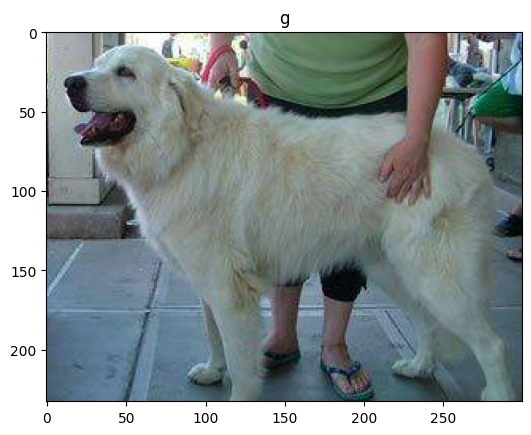

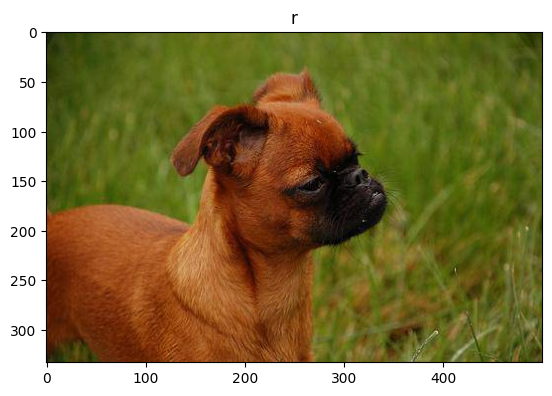

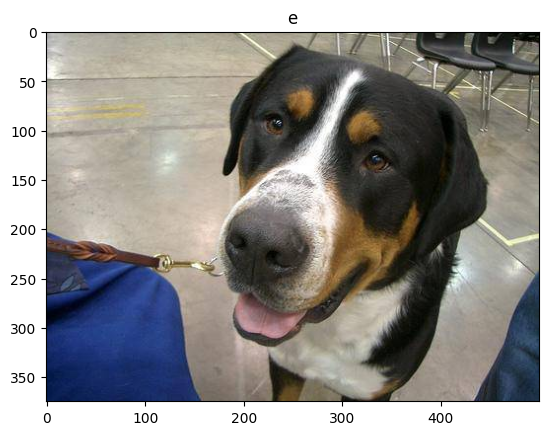

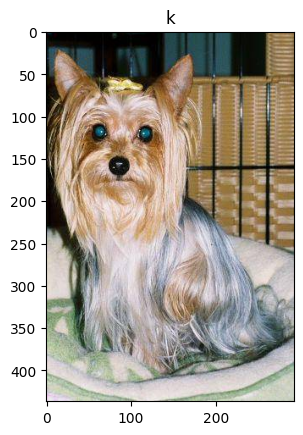

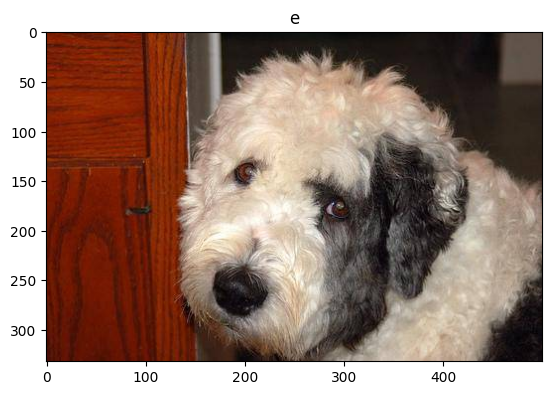

In [34]:
#Training Images

print('Train Images:')
for i in range(5):
  filename = labels.iloc[i]['id']+'.jpg'
  label = labels.iloc[i]['breed']

  img_path = os.path.join(train_dir, filename)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(label)
  plt.show()



Test Images


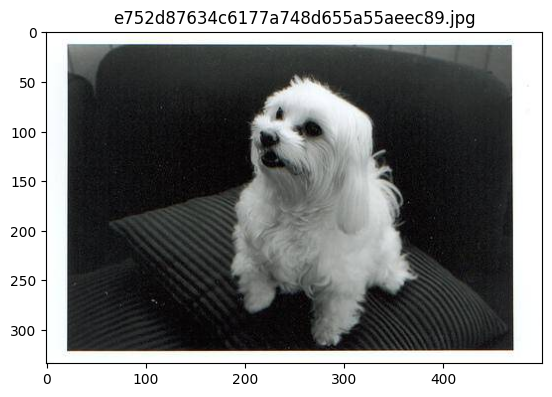

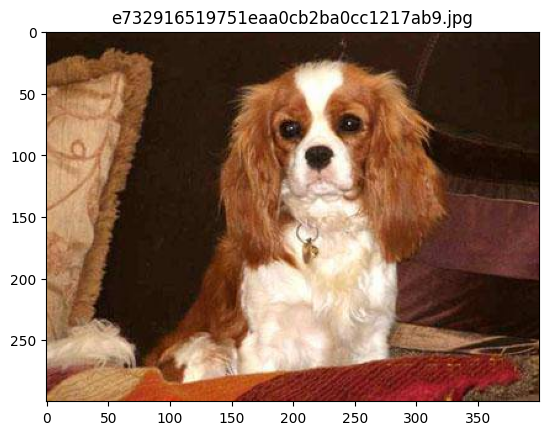

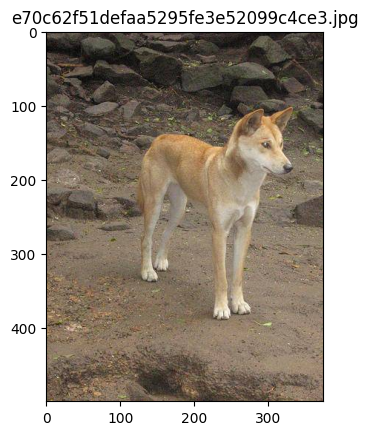

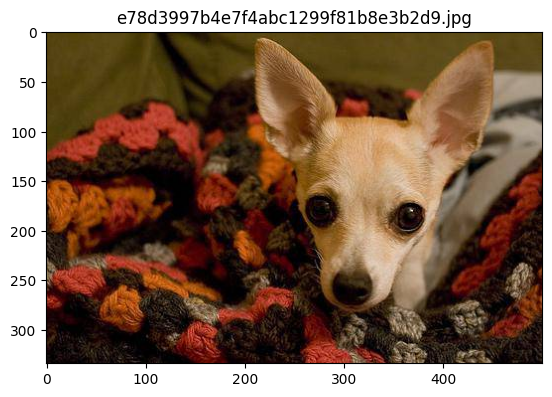

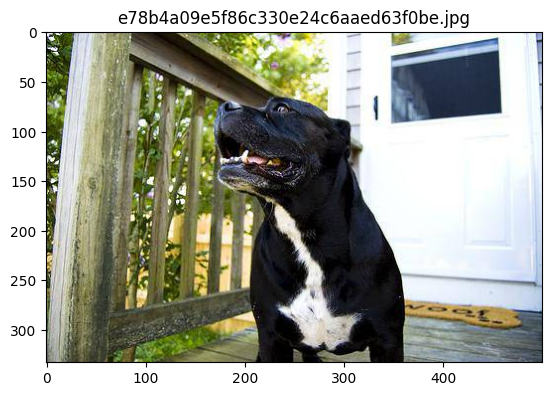

In [22]:
#Test images

#Display the first 5 test images
print('Test Images')

for i in range(5):
  #Get the image file
  filename = os.listdir(test_dir)[i]
  #Load and display the image
  img_path = os.path.join(test_dir, filename)
  img = mpimg.imread(img_path)
  plt.imshow(img)
  plt.title(filename)
  plt.show()

In [23]:
#Sorting of Breeds

breeds = sorted(labels['breed'].unique())
print(breeds)
num_classes = len(breeds)
print(num_classes)

['affenpinscher', 'afghan_hound', 'african_hunting_dog', 'airedale', 'american_staffordshire_terrier', 'appenzeller', 'australian_terrier', 'basenji', 'basset', 'beagle', 'bedlington_terrier', 'bernese_mountain_dog', 'black-and-tan_coonhound', 'blenheim_spaniel', 'bloodhound', 'bluetick', 'border_collie', 'border_terrier', 'borzoi', 'boston_bull', 'bouvier_des_flandres', 'boxer', 'brabancon_griffon', 'briard', 'brittany_spaniel', 'bull_mastiff', 'cairn', 'cardigan', 'chesapeake_bay_retriever', 'chihuahua', 'chow', 'clumber', 'cocker_spaniel', 'collie', 'curly-coated_retriever', 'dandie_dinmont', 'dhole', 'dingo', 'doberman', 'english_foxhound', 'english_setter', 'english_springer', 'entlebucher', 'eskimo_dog', 'flat-coated_retriever', 'french_bulldog', 'german_shepherd', 'german_short-haired_pointer', 'giant_schnauzer', 'golden_retriever', 'gordon_setter', 'great_dane', 'great_pyrenees', 'greater_swiss_mountain_dog', 'groenendael', 'ibizan_hound', 'irish_setter', 'irish_terrier', 'iris

In [24]:
#Mapping func
#Create a mapping from breed to integer label
breed_to_label = {breed: i for i, breed in enumerate(breeds)}
print(breed_to_label)

{'affenpinscher': 0, 'afghan_hound': 1, 'african_hunting_dog': 2, 'airedale': 3, 'american_staffordshire_terrier': 4, 'appenzeller': 5, 'australian_terrier': 6, 'basenji': 7, 'basset': 8, 'beagle': 9, 'bedlington_terrier': 10, 'bernese_mountain_dog': 11, 'black-and-tan_coonhound': 12, 'blenheim_spaniel': 13, 'bloodhound': 14, 'bluetick': 15, 'border_collie': 16, 'border_terrier': 17, 'borzoi': 18, 'boston_bull': 19, 'bouvier_des_flandres': 20, 'boxer': 21, 'brabancon_griffon': 22, 'briard': 23, 'brittany_spaniel': 24, 'bull_mastiff': 25, 'cairn': 26, 'cardigan': 27, 'chesapeake_bay_retriever': 28, 'chihuahua': 29, 'chow': 30, 'clumber': 31, 'cocker_spaniel': 32, 'collie': 33, 'curly-coated_retriever': 34, 'dandie_dinmont': 35, 'dhole': 36, 'dingo': 37, 'doberman': 38, 'english_foxhound': 39, 'english_setter': 40, 'english_springer': 41, 'entlebucher': 42, 'eskimo_dog': 43, 'flat-coated_retriever': 44, 'french_bulldog': 45, 'german_shepherd': 46, 'german_short-haired_pointer': 47, 'gian

In [25]:
#Image Sizing
#Set the image size and batch size

img_size = 224
batch_size = 16

In [26]:
#Preprocessing

def load_and_preprocess_image(img_path, label):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0

    #One-hot encode the label
    label = tf.one_hot(label, num_classes)

    return img, label

In [27]:
def create_dataset(df, train_dir, batch_size):
    filenames = df['id'].apply(lambda x: os.path.join(train_dir, f"{x}.jpg")).values
    labels = df['breed'].map(breed_to_label).values
    dataset = tf.data.Dataset.from_tensor_slices((filenames, labels))
    dataset = dataset.map(load_and_preprocess_image, num_parallel_calls=tf.data.experimental.AUTOTUNE)
    dataset = dataset.batch(batch_size).prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

    return dataset

In [28]:
#MobileNetV2 Architecture
base_model = MobileNetV2(weights='imagenet',include_top=False)

In [29]:
#Activation Function

#Add a global average pooling layer, followed by a dense layer with softmax activation

x = base_model.output
x = GlobalAveragePooling2D()(x)
predictions = Dense(num_classes, activation='softmax')(x)

#Create a new model with the added layers
model = Model(inputs=base_model.input, outputs=predictions)


In [30]:
#Modelling
#Freeze the base model layers

for layer in base_model.layers:
    layer.trainable = False

#Compile the model using the Adam optimizer and
#categorical cross-entropy loss
model.compile(optimizer=Adam(lr=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [32]:
#Calculate the number of batches per epoch

batches_per_epoch = math.ceil(len(labels)/batch_size)

#Train the model for 10 epochs using th.data.Dataset

for epoch in range(10):
    print('Epoch', epoch+1)

    #Create a progress bar object for this epoch

    pbar = tqdm(total=batches_per_epoch)

    #Shuffle the data
    labels = labels.sample(frac=1).reset_index(drop=True)

    #Load and preprocess the data using tf.data.Dataset
    dataset = create_dataset(labels, train_dir, batch_size)

    #TRain the model on the dataset

    for x_batch, y_batch in dataset:
        model.train_on_batch(x_batch, y_batch.numpy()) #convert y_batch to numpy array

        #update the progress bar
        pbar.update(1)
    pbar.close()


Epoch 1


100%|██████████| 639/639 [27:22<00:00,  2.57s/it]


Epoch 2


100%|██████████| 639/639 [08:21<00:00,  1.27it/s]


Epoch 3


100%|██████████| 639/639 [08:22<00:00,  1.27it/s]


Epoch 4


100%|██████████| 639/639 [08:16<00:00,  1.29it/s]


Epoch 5


100%|██████████| 639/639 [08:21<00:00,  1.27it/s]


Epoch 6


100%|██████████| 639/639 [08:24<00:00,  1.27it/s]


Epoch 7


100%|██████████| 639/639 [08:16<00:00,  1.29it/s]


Epoch 8


100%|██████████| 639/639 [08:21<00:00,  1.27it/s]


Epoch 9


100%|██████████| 639/639 [08:22<00:00,  1.27it/s]


Epoch 10


100%|██████████| 639/639 [08:21<00:00,  1.27it/s]


In [33]:
test_filenames = os.listdir(test_dir)

#CReate a function to load and preprocess a test image

def load_and_preprocess_test_image(img_path):
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.resize(img, [img_size, img_size])
    img = tf.cast(img, tf.float32) / 255.0
    return img

#Create a list to store the predictions

predictions_list = []

#LOad and preprocess the test data and make predictions

for filename in tqdm(test_filenames):
    img_path = os.path.join(test_dir, filename)
    img = load_and_preprocess_test_image(img_path)
    img = np.expand_dims(img, axis=0) #Add batch dimension

    prediction = model.predict(img)
    predicted_label = breeds[np.argmax(prediction)] #Convert prediction to label
    predictions_list.append((filename.split('.')[0], predicted_label))

#create a DataFrame from the list of predictions
submission_df = pd.DataFrame(predictions_list, columns=['id','breed'])

#Save the DataFRame to a .csv file
submission_df.to_csv('Dog_breed_Submission.csv', index=False)



  0%|          | 0/10357 [00:00<?, ?it/s]

1/1 [==============================] - 1s 1s/step


  0%|          | 1/10357 [00:01<3:52:12,  1.35s/it]

1/1 [==============================] - 0s 65ms/step


  0%|          | 2/10357 [00:01<1:48:35,  1.59it/s]

1/1 [==============================] - 0s 63ms/step


  0%|          | 3/10357 [00:01<1:10:14,  2.46it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 4/10357 [00:01<52:08,  3.31it/s]  

1/1 [==============================] - 0s 80ms/step


  0%|          | 5/10357 [00:01<42:16,  4.08it/s]

1/1 [==============================] - 0s 77ms/step


  0%|          | 6/10357 [00:02<54:13,  3.18it/s]

1/1 [==============================] - 0s 105ms/step


  0%|          | 7/10357 [00:02<1:05:57,  2.62it/s]

1/1 [==============================] - 0s 102ms/step


  0%|          | 8/10357 [00:03<1:11:15,  2.42it/s]

1/1 [==============================] - 0s 100ms/step


  0%|          | 9/10357 [00:03<1:18:14,  2.20it/s]

1/1 [==============================] - 0s 111ms/step


  0%|          | 10/10357 [00:04<1:20:33,  2.14it/s]

1/1 [==============================] - 0s 111ms/step


  0%|          | 11/10357 [00:04<1:23:37,  2.06it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 12/10357 [00:05<1:26:15,  2.00it/s]

1/1 [==============================] - 0s 63ms/step


  0%|          | 13/10357 [00:05<1:27:14,  1.98it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 14/10357 [00:06<1:24:23,  2.04it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 15/10357 [00:06<1:18:55,  2.18it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 16/10357 [00:07<1:20:34,  2.14it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 17/10357 [00:07<1:20:12,  2.15it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 18/10357 [00:08<1:22:13,  2.10it/s]

1/1 [==============================] - 0s 115ms/step


  0%|          | 19/10357 [00:08<1:27:08,  1.98it/s]

1/1 [==============================] - 0s 96ms/step


  0%|          | 20/10357 [00:09<1:30:17,  1.91it/s]

1/1 [==============================] - 0s 60ms/step


  0%|          | 21/10357 [00:09<1:26:35,  1.99it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 22/10357 [00:10<1:24:15,  2.04it/s]

1/1 [==============================] - 0s 63ms/step


  0%|          | 23/10357 [00:10<1:21:18,  2.12it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 24/10357 [00:11<1:23:43,  2.06it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 25/10357 [00:11<1:17:51,  2.21it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 26/10357 [00:12<1:16:45,  2.24it/s]

1/1 [==============================] - 0s 73ms/step


  0%|          | 27/10357 [00:12<1:17:00,  2.24it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 28/10357 [00:12<1:15:13,  2.29it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 29/10357 [00:13<1:15:23,  2.28it/s]

1/1 [==============================] - 0s 69ms/step


  0%|          | 30/10357 [00:13<1:12:38,  2.37it/s]

1/1 [==============================] - 0s 72ms/step


  0%|          | 31/10357 [00:14<1:13:32,  2.34it/s]

1/1 [==============================] - 0s 71ms/step


  0%|          | 32/10357 [00:14<1:15:01,  2.29it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 33/10357 [00:15<1:16:57,  2.24it/s]

1/1 [==============================] - 0s 63ms/step


  0%|          | 34/10357 [00:15<1:17:39,  2.22it/s]

1/1 [==============================] - 0s 101ms/step


  0%|          | 35/10357 [00:16<1:26:24,  1.99it/s]

1/1 [==============================] - 0s 102ms/step


  0%|          | 36/10357 [00:16<1:23:49,  2.05it/s]

1/1 [==============================] - 0s 103ms/step


  0%|          | 37/10357 [00:17<1:26:04,  2.00it/s]

1/1 [==============================] - 0s 95ms/step


  0%|          | 38/10357 [00:17<1:26:29,  1.99it/s]

1/1 [==============================] - 0s 104ms/step


  0%|          | 39/10357 [00:18<1:25:47,  2.00it/s]

1/1 [==============================] - 0s 98ms/step


  0%|          | 40/10357 [00:18<1:24:11,  2.04it/s]

1/1 [==============================] - 0s 103ms/step


  0%|          | 41/10357 [00:19<1:21:07,  2.12it/s]

1/1 [==============================] - 0s 66ms/step


  0%|          | 42/10357 [00:19<1:29:29,  1.92it/s]

1/1 [==============================] - 0s 61ms/step


  0%|          | 43/10357 [00:20<1:22:15,  2.09it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 44/10357 [00:20<1:16:42,  2.24it/s]

1/1 [==============================] - 0s 67ms/step


  0%|          | 45/10357 [00:20<1:19:28,  2.16it/s]

1/1 [==============================] - 0s 70ms/step


  0%|          | 46/10357 [00:21<1:15:06,  2.29it/s]

1/1 [==============================] - 0s 64ms/step


  0%|          | 47/10357 [00:21<1:11:49,  2.39it/s]

1/1 [==============================] - 0s 67ms/step


  0%|          | 48/10357 [00:22<1:13:20,  2.34it/s]

1/1 [==============================] - 0s 65ms/step


  0%|          | 49/10357 [00:22<1:13:41,  2.33it/s]

1/1 [==============================] - 0s 68ms/step


  0%|          | 50/10357 [00:22<1:10:36,  2.43it/s]

1/1 [==============================] - 0s 81ms/step


  0%|          | 51/10357 [00:23<1:11:20,  2.41it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 52/10357 [00:23<1:12:33,  2.37it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 53/10357 [00:24<1:15:28,  2.28it/s]

1/1 [==============================] - 0s 71ms/step


  1%|          | 54/10357 [00:24<1:16:22,  2.25it/s]

1/1 [==============================] - 0s 63ms/step


  1%|          | 55/10357 [00:25<1:17:24,  2.22it/s]

1/1 [==============================] - 0s 72ms/step


  1%|          | 56/10357 [00:25<1:14:00,  2.32it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 57/10357 [00:26<1:12:30,  2.37it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 58/10357 [00:26<1:10:19,  2.44it/s]

1/1 [==============================] - 0s 69ms/step


  1%|          | 59/10357 [00:26<1:15:00,  2.29it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 60/10357 [00:27<1:16:22,  2.25it/s]

1/1 [==============================] - 0s 62ms/step


  1%|          | 61/10357 [00:27<1:12:50,  2.36it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 62/10357 [00:28<1:22:31,  2.08it/s]

1/1 [==============================] - 0s 58ms/step


  1%|          | 63/10357 [00:28<1:22:22,  2.08it/s]

1/1 [==============================] - 0s 97ms/step


  1%|          | 64/10357 [00:29<1:32:07,  1.86it/s]

1/1 [==============================] - 0s 116ms/step


  1%|          | 65/10357 [00:30<1:31:36,  1.87it/s]

1/1 [==============================] - 0s 105ms/step


  1%|          | 66/10357 [00:30<1:32:04,  1.86it/s]

1/1 [==============================] - 0s 106ms/step


  1%|          | 67/10357 [00:31<1:36:38,  1.77it/s]

1/1 [==============================] - 0s 136ms/step


  1%|          | 68/10357 [00:31<1:33:53,  1.83it/s]

1/1 [==============================] - 0s 96ms/step


  1%|          | 69/10357 [00:32<1:28:07,  1.95it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 70/10357 [00:32<1:31:00,  1.88it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 71/10357 [00:33<1:27:09,  1.97it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 72/10357 [00:33<1:24:32,  2.03it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 73/10357 [00:34<1:19:44,  2.15it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 74/10357 [00:34<1:16:41,  2.23it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 75/10357 [00:34<1:12:57,  2.35it/s]

1/1 [==============================] - 0s 59ms/step


  1%|          | 76/10357 [00:35<1:16:31,  2.24it/s]

1/1 [==============================] - 0s 73ms/step


  1%|          | 77/10357 [00:35<1:15:43,  2.26it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 78/10357 [00:36<1:16:43,  2.23it/s]

1/1 [==============================] - 0s 72ms/step


  1%|          | 79/10357 [00:36<1:15:32,  2.27it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 80/10357 [00:41<4:59:31,  1.75s/it]

1/1 [==============================] - 0s 69ms/step


  1%|          | 81/10357 [00:41<3:49:01,  1.34s/it]

1/1 [==============================] - 0s 70ms/step


  1%|          | 82/10357 [00:42<3:01:37,  1.06s/it]

1/1 [==============================] - 0s 114ms/step


  1%|          | 83/10357 [00:42<2:36:03,  1.10it/s]

1/1 [==============================] - 0s 101ms/step


  1%|          | 84/10357 [00:43<2:20:09,  1.22it/s]

1/1 [==============================] - 0s 101ms/step


  1%|          | 85/10357 [00:43<2:01:53,  1.40it/s]

1/1 [==============================] - 0s 121ms/step


  1%|          | 86/10357 [00:44<1:53:52,  1.50it/s]

1/1 [==============================] - 0s 143ms/step


  1%|          | 87/10357 [00:45<1:52:08,  1.53it/s]

1/1 [==============================] - 0s 121ms/step


  1%|          | 88/10357 [00:45<1:47:52,  1.59it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 89/10357 [00:46<1:41:00,  1.69it/s]

1/1 [==============================] - 0s 63ms/step


  1%|          | 90/10357 [00:46<1:36:18,  1.78it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 91/10357 [00:46<1:26:38,  1.97it/s]

1/1 [==============================] - 0s 63ms/step


  1%|          | 92/10357 [00:47<1:22:14,  2.08it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 93/10357 [00:47<1:17:37,  2.20it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 94/10357 [00:48<1:18:14,  2.19it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 95/10357 [00:48<1:12:35,  2.36it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 96/10357 [00:49<1:13:34,  2.32it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 97/10357 [00:49<1:10:03,  2.44it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 98/10357 [00:49<1:10:11,  2.44it/s]

1/1 [==============================] - 0s 65ms/step


  1%|          | 99/10357 [00:50<1:12:35,  2.35it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 100/10357 [00:50<1:08:35,  2.49it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 101/10357 [00:51<1:10:13,  2.43it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 102/10357 [00:51<1:09:18,  2.47it/s]

1/1 [==============================] - 0s 63ms/step


  1%|          | 103/10357 [00:52<1:17:41,  2.20it/s]

1/1 [==============================] - 0s 120ms/step


  1%|          | 104/10357 [00:52<1:18:47,  2.17it/s]

1/1 [==============================] - 0s 146ms/step


  1%|          | 105/10357 [01:36<38:13:11, 13.42s/it]

1/1 [==============================] - 0s 222ms/step


  1%|          | 106/10357 [02:37<79:20:59, 27.87s/it]

1/1 [==============================] - 0s 217ms/step


  1%|          | 107/10357 [03:17<89:52:55, 31.57s/it]

1/1 [==============================] - 0s 127ms/step


  1%|          | 108/10357 [03:19<64:13:26, 22.56s/it]

1/1 [==============================] - 0s 77ms/step


  1%|          | 109/10357 [03:23<48:17:09, 16.96s/it]

1/1 [==============================] - 0s 151ms/step


  1%|          | 110/10357 [04:04<68:33:25, 24.09s/it]

1/1 [==============================] - 0s 83ms/step


  1%|          | 111/10357 [04:25<66:26:38, 23.35s/it]

1/1 [==============================] - 0s 70ms/step


  1%|          | 112/10357 [04:25<46:39:11, 16.39s/it]

1/1 [==============================] - 0s 72ms/step


  1%|          | 113/10357 [04:26<32:47:21, 11.52s/it]

1/1 [==============================] - 0s 69ms/step


  1%|          | 114/10357 [04:26<23:05:48,  8.12s/it]

1/1 [==============================] - 0s 69ms/step


  1%|          | 115/10357 [04:26<16:18:25,  5.73s/it]

1/1 [==============================] - 0s 64ms/step


  1%|          | 116/10357 [04:26<11:31:54,  4.05s/it]

1/1 [==============================] - 0s 64ms/step


  1%|          | 117/10357 [04:26<8:11:20,  2.88s/it] 

1/1 [==============================] - 0s 67ms/step


  1%|          | 118/10357 [04:26<5:50:36,  2.05s/it]

1/1 [==============================] - 0s 66ms/step


  1%|          | 119/10357 [04:26<4:12:13,  1.48s/it]

1/1 [==============================] - 0s 64ms/step


  1%|          | 120/10357 [04:27<3:03:29,  1.08s/it]

1/1 [==============================] - 0s 87ms/step


  1%|          | 121/10357 [04:27<2:16:31,  1.25it/s]

1/1 [==============================] - 0s 73ms/step


  1%|          | 122/10357 [04:27<1:43:23,  1.65it/s]

1/1 [==============================] - 0s 61ms/step


  1%|          | 123/10357 [04:27<1:20:29,  2.12it/s]

1/1 [==============================] - 0s 68ms/step


  1%|          | 124/10357 [04:27<1:03:24,  2.69it/s]

1/1 [==============================] - 0s 67ms/step


  1%|          | 125/10357 [04:27<51:51,  3.29it/s]  

1/1 [==============================] - 0s 63ms/step


  1%|          | 126/10357 [04:27<43:06,  3.96it/s]

1/1 [==============================] - 0s 64ms/step


  1%|          | 127/10357 [04:28<37:01,  4.61it/s]

1/1 [==============================] - 0s 85ms/step


  1%|          | 128/10357 [04:28<33:46,  5.05it/s]

1/1 [==============================] - 0s 66ms/step


  1%|          | 129/10357 [04:28<30:44,  5.54it/s]

1/1 [==============================] - 0s 65ms/step


  1%|▏         | 130/10357 [04:28<27:47,  6.13it/s]

1/1 [==============================] - 0s 66ms/step


  1%|▏         | 131/10357 [04:28<26:29,  6.43it/s]

1/1 [==============================] - 0s 70ms/step


  1%|▏         | 132/10357 [04:28<26:27,  6.44it/s]

1/1 [==============================] - 0s 62ms/step


  1%|▏         | 133/10357 [04:28<24:48,  6.87it/s]

1/1 [==============================] - 0s 75ms/step


  1%|▏         | 134/10357 [04:29<25:10,  6.77it/s]

1/1 [==============================] - 0s 61ms/step


  1%|▏         | 135/10357 [04:29<24:18,  7.01it/s]

1/1 [==============================] - 0s 60ms/step


  1%|▏         | 136/10357 [04:29<24:01,  7.09it/s]

1/1 [==============================] - 0s 60ms/step


  1%|▏         | 137/10357 [04:29<22:55,  7.43it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▏         | 138/10357 [04:29<23:40,  7.19it/s]

1/1 [==============================] - 0s 63ms/step


  1%|▏         | 139/10357 [04:29<23:48,  7.15it/s]

1/1 [==============================] - 0s 64ms/step


  1%|▏         | 140/10357 [04:29<23:36,  7.21it/s]

1/1 [==============================] - 0s 66ms/step


  1%|▏         | 141/10357 [04:30<24:19,  7.00it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▏         | 142/10357 [04:30<24:38,  6.91it/s]

1/1 [==============================] - 0s 107ms/step


  1%|▏         | 143/10357 [04:30<31:36,  5.38it/s]

1/1 [==============================] - 0s 74ms/step


  1%|▏         | 144/10357 [04:30<29:39,  5.74it/s]

1/1 [==============================] - 0s 93ms/step


  1%|▏         | 145/10357 [04:30<29:59,  5.67it/s]

1/1 [==============================] - 0s 80ms/step


  1%|▏         | 146/10357 [04:30<29:44,  5.72it/s]

1/1 [==============================] - 0s 82ms/step


  1%|▏         | 147/10357 [04:31<29:53,  5.69it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▏         | 148/10357 [04:31<30:10,  5.64it/s]

1/1 [==============================] - 0s 90ms/step


  1%|▏         | 149/10357 [04:31<34:25,  4.94it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▏         | 150/10357 [04:31<32:15,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


  1%|▏         | 151/10357 [04:31<31:16,  5.44it/s]

1/1 [==============================] - 0s 74ms/step


  1%|▏         | 152/10357 [04:32<30:40,  5.54it/s]

1/1 [==============================] - 0s 79ms/step


  1%|▏         | 153/10357 [04:32<29:58,  5.67it/s]

1/1 [==============================] - 0s 81ms/step


  1%|▏         | 154/10357 [04:32<28:49,  5.90it/s]

1/1 [==============================] - 0s 68ms/step


  1%|▏         | 155/10357 [04:32<27:42,  6.14it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 156/10357 [04:32<27:34,  6.16it/s]

1/1 [==============================] - 0s 77ms/step


  2%|▏         | 157/10357 [04:32<27:22,  6.21it/s]

1/1 [==============================] - 0s 75ms/step


  2%|▏         | 158/10357 [04:33<27:33,  6.17it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 159/10357 [04:33<27:14,  6.24it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▏         | 160/10357 [04:33<27:06,  6.27it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 161/10357 [04:33<26:54,  6.31it/s]

1/1 [==============================] - 0s 123ms/step


  2%|▏         | 162/10357 [04:33<31:07,  5.46it/s]

1/1 [==============================] - 0s 99ms/step


  2%|▏         | 163/10357 [04:34<39:24,  4.31it/s]

1/1 [==============================] - 0s 111ms/step


  2%|▏         | 164/10357 [04:34<38:17,  4.44it/s]

1/1 [==============================] - 0s 118ms/step


  2%|▏         | 165/10357 [04:34<37:52,  4.49it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 166/10357 [04:34<36:32,  4.65it/s]

1/1 [==============================] - 0s 135ms/step


  2%|▏         | 167/10357 [04:34<38:13,  4.44it/s]

1/1 [==============================] - 0s 109ms/step


  2%|▏         | 168/10357 [04:35<37:40,  4.51it/s]

1/1 [==============================] - 0s 101ms/step


  2%|▏         | 169/10357 [04:35<39:23,  4.31it/s]

1/1 [==============================] - 0s 114ms/step


  2%|▏         | 170/10357 [04:35<39:17,  4.32it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 171/10357 [04:35<37:26,  4.53it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 172/10357 [04:36<35:52,  4.73it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▏         | 173/10357 [04:36<34:47,  4.88it/s]

1/1 [==============================] - 0s 114ms/step


  2%|▏         | 174/10357 [04:36<37:35,  4.51it/s]

1/1 [==============================] - 0s 117ms/step


  2%|▏         | 175/10357 [04:36<40:58,  4.14it/s]

1/1 [==============================] - 0s 102ms/step


  2%|▏         | 176/10357 [04:37<42:51,  3.96it/s]

1/1 [==============================] - 0s 109ms/step


  2%|▏         | 177/10357 [04:37<40:19,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


  2%|▏         | 178/10357 [04:37<41:27,  4.09it/s]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 179/10357 [04:37<41:52,  4.05it/s]

1/1 [==============================] - 0s 165ms/step


  2%|▏         | 180/10357 [04:38<42:16,  4.01it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 181/10357 [04:38<38:54,  4.36it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 182/10357 [04:38<35:09,  4.82it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 183/10357 [04:38<31:14,  5.43it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 184/10357 [04:38<30:15,  5.60it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 185/10357 [04:38<29:31,  5.74it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 186/10357 [04:38<28:03,  6.04it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 187/10357 [04:39<26:51,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 188/10357 [04:39<25:52,  6.55it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 189/10357 [04:39<24:47,  6.84it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 190/10357 [04:39<24:34,  6.89it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 191/10357 [04:39<24:08,  7.02it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 192/10357 [04:39<24:52,  6.81it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 193/10357 [04:39<24:43,  6.85it/s]

1/1 [==============================] - 0s 71ms/step


  2%|▏         | 194/10357 [04:40<24:51,  6.82it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 195/10357 [04:40<24:27,  6.93it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 196/10357 [04:40<24:40,  6.86it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 197/10357 [04:40<24:07,  7.02it/s]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 198/10357 [04:40<23:35,  7.18it/s]

1/1 [==============================] - 0s 77ms/step


  2%|▏         | 199/10357 [04:40<24:19,  6.96it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 200/10357 [04:40<24:24,  6.94it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 201/10357 [04:41<24:41,  6.85it/s]

1/1 [==============================] - 0s 74ms/step


  2%|▏         | 202/10357 [04:41<25:09,  6.73it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 203/10357 [04:41<25:00,  6.77it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 204/10357 [04:41<25:13,  6.71it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 205/10357 [04:41<24:27,  6.92it/s]

1/1 [==============================] - 0s 92ms/step


  2%|▏         | 206/10357 [04:41<25:20,  6.67it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 207/10357 [04:41<24:32,  6.89it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 208/10357 [04:42<24:42,  6.84it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 209/10357 [04:42<24:37,  6.87it/s]

1/1 [==============================] - 0s 71ms/step


  2%|▏         | 210/10357 [04:42<25:24,  6.66it/s]

1/1 [==============================] - 0s 72ms/step


  2%|▏         | 211/10357 [04:42<25:23,  6.66it/s]

1/1 [==============================] - 0s 66ms/step


  2%|▏         | 212/10357 [04:42<25:17,  6.68it/s]

1/1 [==============================] - 0s 78ms/step


  2%|▏         | 213/10357 [04:42<25:12,  6.71it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 214/10357 [04:43<24:21,  6.94it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 215/10357 [04:43<24:42,  6.84it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 216/10357 [04:43<24:04,  7.02it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 217/10357 [04:43<24:09,  7.00it/s]

1/1 [==============================] - 0s 70ms/step


  2%|▏         | 218/10357 [04:43<23:41,  7.13it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 219/10357 [04:43<23:56,  7.06it/s]

1/1 [==============================] - 0s 84ms/step


  2%|▏         | 220/10357 [04:43<25:34,  6.61it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 221/10357 [04:44<24:29,  6.90it/s]

1/1 [==============================] - 0s 75ms/step


  2%|▏         | 222/10357 [04:44<25:04,  6.74it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 223/10357 [04:44<25:05,  6.73it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 224/10357 [04:44<24:21,  6.93it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 225/10357 [04:44<24:17,  6.95it/s]

1/1 [==============================] - 0s 69ms/step


  2%|▏         | 226/10357 [04:44<24:52,  6.79it/s]

1/1 [==============================] - 0s 80ms/step


  2%|▏         | 227/10357 [04:44<25:18,  6.67it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 228/10357 [04:45<24:53,  6.78it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 229/10357 [04:45<25:20,  6.66it/s]

1/1 [==============================] - 0s 63ms/step


  2%|▏         | 230/10357 [04:45<24:45,  6.82it/s]

1/1 [==============================] - 0s 75ms/step


  2%|▏         | 231/10357 [04:45<24:36,  6.86it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 232/10357 [04:45<24:46,  6.81it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 233/10357 [04:45<24:26,  6.90it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 234/10357 [04:45<24:13,  6.96it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 235/10357 [04:46<24:05,  7.00it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 236/10357 [04:46<24:16,  6.95it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 237/10357 [04:46<23:59,  7.03it/s]

1/1 [==============================] - 0s 68ms/step


  2%|▏         | 238/10357 [04:46<25:00,  6.74it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 239/10357 [04:46<24:50,  6.79it/s]

1/1 [==============================] - 0s 62ms/step


  2%|▏         | 240/10357 [04:46<24:14,  6.95it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 241/10357 [04:46<23:28,  7.18it/s]

1/1 [==============================] - 0s 58ms/step


  2%|▏         | 242/10357 [04:47<23:43,  7.11it/s]

1/1 [==============================] - 0s 64ms/step


  2%|▏         | 243/10357 [04:47<23:13,  7.26it/s]

1/1 [==============================] - 0s 60ms/step


  2%|▏         | 244/10357 [04:47<23:24,  7.20it/s]

1/1 [==============================] - 0s 65ms/step


  2%|▏         | 245/10357 [04:47<22:47,  7.40it/s]

1/1 [==============================] - 0s 57ms/step


  2%|▏         | 246/10357 [04:47<22:06,  7.62it/s]

1/1 [==============================] - 0s 61ms/step


  2%|▏         | 247/10357 [04:47<22:49,  7.38it/s]

1/1 [==============================] - 0s 67ms/step


  2%|▏         | 248/10357 [04:47<22:22,  7.53it/s]

1/1 [==============================] - 0s 71ms/step


  2%|▏         | 249/10357 [04:48<22:31,  7.48it/s]

1/1 [==============================] - 0s 79ms/step


  2%|▏         | 250/10357 [04:48<23:41,  7.11it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 251/10357 [04:48<26:01,  6.47it/s]

1/1 [==============================] - 0s 95ms/step


  2%|▏         | 252/10357 [04:48<31:11,  5.40it/s]

1/1 [==============================] - 0s 97ms/step


  2%|▏         | 253/10357 [04:48<31:46,  5.30it/s]

1/1 [==============================] - 0s 111ms/step


  2%|▏         | 254/10357 [04:49<34:41,  4.85it/s]

1/1 [==============================] - 0s 104ms/step


  2%|▏         | 255/10357 [04:49<37:30,  4.49it/s]

1/1 [==============================] - 0s 105ms/step


  2%|▏         | 256/10357 [04:49<39:42,  4.24it/s]

1/1 [==============================] - 0s 98ms/step


  2%|▏         | 257/10357 [04:49<40:24,  4.17it/s]

1/1 [==============================] - 0s 103ms/step


  2%|▏         | 258/10357 [04:50<37:51,  4.45it/s]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 259/10357 [04:50<37:00,  4.55it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 260/10357 [04:50<39:34,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 261/10357 [04:50<41:45,  4.03it/s]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 262/10357 [04:51<42:53,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 263/10357 [04:51<40:07,  4.19it/s]

1/1 [==============================] - 0s 106ms/step


  3%|▎         | 264/10357 [04:51<42:59,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


  3%|▎         | 265/10357 [04:51<40:36,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


  3%|▎         | 266/10357 [04:52<40:40,  4.13it/s]

1/1 [==============================] - 0s 105ms/step


  3%|▎         | 267/10357 [04:52<38:25,  4.38it/s]

1/1 [==============================] - 0s 99ms/step


  3%|▎         | 268/10357 [04:52<37:14,  4.52it/s]

1/1 [==============================] - 0s 81ms/step


  3%|▎         | 269/10357 [04:52<35:29,  4.74it/s]

1/1 [==============================] - 0s 58ms/step


  3%|▎         | 270/10357 [04:52<30:52,  5.44it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 271/10357 [04:52<28:34,  5.88it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 272/10357 [04:52<26:33,  6.33it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 273/10357 [04:53<26:28,  6.35it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 274/10357 [04:53<25:23,  6.62it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 275/10357 [04:53<25:06,  6.69it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 276/10357 [04:53<24:29,  6.86it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 277/10357 [04:53<23:37,  7.11it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 278/10357 [04:53<22:48,  7.36it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 279/10357 [04:53<22:39,  7.42it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 280/10357 [04:54<22:16,  7.54it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 281/10357 [04:54<22:15,  7.54it/s]

1/1 [==============================] - 0s 78ms/step


  3%|▎         | 282/10357 [04:54<24:05,  6.97it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 283/10357 [04:54<24:11,  6.94it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 284/10357 [04:54<23:30,  7.14it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 285/10357 [04:54<22:39,  7.41it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 286/10357 [04:54<23:02,  7.29it/s]

1/1 [==============================] - 0s 72ms/step


  3%|▎         | 287/10357 [04:55<22:59,  7.30it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 288/10357 [04:55<23:57,  7.00it/s]

1/1 [==============================] - 0s 81ms/step


  3%|▎         | 289/10357 [04:55<24:06,  6.96it/s]

1/1 [==============================] - 0s 71ms/step


  3%|▎         | 290/10357 [04:55<24:31,  6.84it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 291/10357 [04:55<24:23,  6.88it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 292/10357 [04:55<24:21,  6.89it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 293/10357 [04:55<23:51,  7.03it/s]

1/1 [==============================] - 0s 60ms/step


  3%|▎         | 294/10357 [04:56<23:50,  7.04it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 295/10357 [04:56<23:27,  7.15it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 296/10357 [04:56<23:26,  7.15it/s]

1/1 [==============================] - 0s 59ms/step


  3%|▎         | 297/10357 [04:56<23:06,  7.26it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 298/10357 [04:56<23:15,  7.21it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 299/10357 [04:56<24:13,  6.92it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 300/10357 [04:56<23:38,  7.09it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 301/10357 [04:57<24:31,  6.83it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 302/10357 [04:57<24:46,  6.76it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 303/10357 [04:57<25:06,  6.67it/s]

1/1 [==============================] - 0s 65ms/step


  3%|▎         | 304/10357 [04:57<25:04,  6.68it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 305/10357 [04:57<24:51,  6.74it/s]

1/1 [==============================] - 0s 69ms/step


  3%|▎         | 306/10357 [04:57<24:57,  6.71it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 307/10357 [04:57<24:07,  6.94it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 308/10357 [04:58<24:52,  6.73it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 309/10357 [04:58<24:43,  6.77it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 310/10357 [04:58<24:34,  6.81it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 311/10357 [04:58<24:12,  6.92it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 312/10357 [04:58<23:40,  7.07it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 313/10357 [04:58<23:51,  7.02it/s]

1/1 [==============================] - 0s 72ms/step


  3%|▎         | 314/10357 [04:58<24:02,  6.96it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 315/10357 [04:59<23:54,  7.00it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 316/10357 [04:59<23:24,  7.15it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 317/10357 [04:59<24:24,  6.85it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 318/10357 [04:59<24:56,  6.71it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 319/10357 [04:59<24:28,  6.84it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 320/10357 [04:59<24:40,  6.78it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 321/10357 [04:59<23:34,  7.10it/s]

1/1 [==============================] - 0s 61ms/step


  3%|▎         | 322/10357 [05:00<23:58,  6.98it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 323/10357 [05:00<23:16,  7.19it/s]

1/1 [==============================] - 0s 69ms/step


  3%|▎         | 324/10357 [05:00<23:41,  7.06it/s]

1/1 [==============================] - 0s 74ms/step


  3%|▎         | 325/10357 [05:00<23:52,  7.01it/s]

1/1 [==============================] - 0s 77ms/step


  3%|▎         | 326/10357 [05:00<25:14,  6.62it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 327/10357 [05:00<24:15,  6.89it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 328/10357 [05:00<24:30,  6.82it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 329/10357 [05:01<23:49,  7.02it/s]

1/1 [==============================] - 0s 64ms/step


  3%|▎         | 330/10357 [05:01<24:00,  6.96it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 331/10357 [05:01<23:18,  7.17it/s]

1/1 [==============================] - 0s 75ms/step


  3%|▎         | 332/10357 [05:01<23:40,  7.06it/s]

1/1 [==============================] - 0s 70ms/step


  3%|▎         | 333/10357 [05:01<23:48,  7.02it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 334/10357 [05:01<23:35,  7.08it/s]

1/1 [==============================] - 0s 73ms/step


  3%|▎         | 335/10357 [05:02<24:58,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 336/10357 [05:02<24:55,  6.70it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 337/10357 [05:02<24:22,  6.85it/s]

1/1 [==============================] - 0s 63ms/step


  3%|▎         | 338/10357 [05:02<23:38,  7.06it/s]

1/1 [==============================] - 0s 76ms/step


  3%|▎         | 339/10357 [05:02<23:38,  7.06it/s]

1/1 [==============================] - 0s 114ms/step


  3%|▎         | 340/10357 [05:02<27:40,  6.03it/s]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 341/10357 [05:03<30:44,  5.43it/s]

1/1 [==============================] - 0s 110ms/step


  3%|▎         | 342/10357 [05:03<31:21,  5.32it/s]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 343/10357 [05:03<36:27,  4.58it/s]

1/1 [==============================] - 0s 120ms/step


  3%|▎         | 344/10357 [05:03<41:47,  3.99it/s]

1/1 [==============================] - 0s 103ms/step


  3%|▎         | 345/10357 [05:04<39:01,  4.28it/s]

1/1 [==============================] - 0s 100ms/step


  3%|▎         | 346/10357 [05:04<40:51,  4.08it/s]

1/1 [==============================] - 0s 116ms/step


  3%|▎         | 347/10357 [05:04<39:01,  4.27it/s]

1/1 [==============================] - 0s 128ms/step


  3%|▎         | 348/10357 [05:04<40:51,  4.08it/s]

1/1 [==============================] - 0s 105ms/step


  3%|▎         | 349/10357 [05:04<38:11,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


  3%|▎         | 350/10357 [05:05<40:21,  4.13it/s]

1/1 [==============================] - 0s 101ms/step


  3%|▎         | 351/10357 [05:05<41:10,  4.05it/s]

1/1 [==============================] - 0s 97ms/step


  3%|▎         | 352/10357 [05:05<42:02,  3.97it/s]

1/1 [==============================] - 0s 104ms/step


  3%|▎         | 353/10357 [05:05<40:19,  4.14it/s]

1/1 [==============================] - 0s 126ms/step


  3%|▎         | 354/10357 [05:06<42:33,  3.92it/s]

1/1 [==============================] - 0s 114ms/step


  3%|▎         | 355/10357 [05:06<40:05,  4.16it/s]

1/1 [==============================] - 0s 113ms/step


  3%|▎         | 356/10357 [05:06<41:10,  4.05it/s]

1/1 [==============================] - 0s 107ms/step


  3%|▎         | 357/10357 [05:06<38:45,  4.30it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 358/10357 [05:07<35:25,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


  3%|▎         | 359/10357 [05:07<31:43,  5.25it/s]

1/1 [==============================] - 0s 62ms/step


  3%|▎         | 360/10357 [05:07<29:28,  5.65it/s]

1/1 [==============================] - 0s 68ms/step


  3%|▎         | 361/10357 [05:07<27:18,  6.10it/s]

1/1 [==============================] - 0s 66ms/step


  3%|▎         | 362/10357 [05:07<26:30,  6.28it/s]

1/1 [==============================] - 0s 74ms/step


  4%|▎         | 363/10357 [05:07<26:17,  6.33it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▎         | 364/10357 [05:07<25:48,  6.45it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 365/10357 [05:08<24:53,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 366/10357 [05:08<24:52,  6.69it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▎         | 367/10357 [05:08<24:53,  6.69it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▎         | 368/10357 [05:08<24:41,  6.74it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▎         | 369/10357 [05:08<24:32,  6.78it/s]

1/1 [==============================] - 0s 77ms/step


  4%|▎         | 370/10357 [05:08<25:09,  6.62it/s]

1/1 [==============================] - 0s 69ms/step


  4%|▎         | 371/10357 [05:09<25:59,  6.41it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▎         | 372/10357 [05:09<25:20,  6.57it/s]

1/1 [==============================] - 0s 69ms/step


  4%|▎         | 373/10357 [05:09<24:29,  6.80it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▎         | 374/10357 [05:09<24:04,  6.91it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▎         | 375/10357 [05:09<24:02,  6.92it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▎         | 376/10357 [05:09<23:59,  6.93it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▎         | 377/10357 [05:09<23:49,  6.98it/s]

1/1 [==============================] - 0s 69ms/step


  4%|▎         | 378/10357 [05:10<24:22,  6.82it/s]

1/1 [==============================] - 0s 84ms/step


  4%|▎         | 379/10357 [05:10<25:47,  6.45it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▎         | 380/10357 [05:10<25:09,  6.61it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 381/10357 [05:10<24:19,  6.84it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▎         | 382/10357 [05:10<24:22,  6.82it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 383/10357 [05:10<24:48,  6.70it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▎         | 384/10357 [05:10<24:32,  6.77it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▎         | 385/10357 [05:11<24:38,  6.75it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 386/10357 [05:11<24:18,  6.84it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▎         | 387/10357 [05:11<23:25,  7.09it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▎         | 388/10357 [05:11<24:23,  6.81it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▍         | 389/10357 [05:12<1:00:10,  2.76it/s]

1/1 [==============================] - 0s 72ms/step


  4%|▍         | 390/10357 [05:12<49:48,  3.33it/s]  

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 391/10357 [05:12<42:55,  3.87it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 392/10357 [05:12<37:30,  4.43it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 393/10357 [05:12<33:41,  4.93it/s]

1/1 [==============================] - 0s 77ms/step


  4%|▍         | 394/10357 [05:13<32:38,  5.09it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 395/10357 [05:13<29:35,  5.61it/s]

1/1 [==============================] - 0s 73ms/step


  4%|▍         | 396/10357 [05:13<28:27,  5.83it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 397/10357 [05:13<27:23,  6.06it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 398/10357 [05:13<27:29,  6.04it/s]

1/1 [==============================] - 0s 86ms/step


  4%|▍         | 399/10357 [05:13<27:12,  6.10it/s]

1/1 [==============================] - 0s 77ms/step


  4%|▍         | 400/10357 [05:14<27:51,  5.96it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▍         | 401/10357 [05:14<27:09,  6.11it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 402/10357 [05:14<25:49,  6.43it/s]

1/1 [==============================] - 0s 76ms/step


  4%|▍         | 403/10357 [05:14<25:28,  6.51it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▍         | 404/10357 [05:14<25:53,  6.41it/s]

1/1 [==============================] - 0s 75ms/step


  4%|▍         | 405/10357 [05:14<25:30,  6.50it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 406/10357 [05:15<26:13,  6.32it/s]

1/1 [==============================] - 0s 73ms/step


  4%|▍         | 407/10357 [05:15<26:59,  6.14it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 408/10357 [05:15<26:39,  6.22it/s]

1/1 [==============================] - 0s 74ms/step


  4%|▍         | 409/10357 [05:15<26:58,  6.15it/s]

1/1 [==============================] - 0s 74ms/step


  4%|▍         | 410/10357 [05:15<26:48,  6.18it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 411/10357 [05:15<26:05,  6.35it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 412/10357 [05:15<26:11,  6.33it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▍         | 413/10357 [05:16<26:09,  6.34it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 414/10357 [05:16<25:16,  6.55it/s]

1/1 [==============================] - 0s 74ms/step


  4%|▍         | 415/10357 [05:16<26:44,  6.20it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▍         | 416/10357 [05:16<26:43,  6.20it/s]

1/1 [==============================] - 0s 78ms/step


  4%|▍         | 417/10357 [05:16<26:49,  6.17it/s]

1/1 [==============================] - 0s 77ms/step


  4%|▍         | 418/10357 [05:16<26:38,  6.22it/s]

1/1 [==============================] - 0s 120ms/step


  4%|▍         | 419/10357 [05:17<29:17,  5.66it/s]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 420/10357 [05:17<34:10,  4.85it/s]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 421/10357 [05:17<37:41,  4.39it/s]

1/1 [==============================] - 0s 128ms/step


  4%|▍         | 422/10357 [05:17<39:26,  4.20it/s]

1/1 [==============================] - 0s 113ms/step


  4%|▍         | 423/10357 [05:18<37:30,  4.41it/s]

1/1 [==============================] - 0s 110ms/step


  4%|▍         | 424/10357 [05:18<38:07,  4.34it/s]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 425/10357 [05:18<40:42,  4.07it/s]

1/1 [==============================] - 0s 102ms/step


  4%|▍         | 426/10357 [05:18<41:09,  4.02it/s]

1/1 [==============================] - 0s 115ms/step


  4%|▍         | 427/10357 [05:19<39:18,  4.21it/s]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 428/10357 [05:19<38:11,  4.33it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 429/10357 [05:19<35:45,  4.63it/s]

1/1 [==============================] - 0s 99ms/step


  4%|▍         | 430/10357 [05:19<34:04,  4.86it/s]

1/1 [==============================] - 0s 107ms/step


  4%|▍         | 431/10357 [05:20<37:06,  4.46it/s]

1/1 [==============================] - 0s 120ms/step


  4%|▍         | 432/10357 [05:20<37:14,  4.44it/s]

1/1 [==============================] - 0s 101ms/step


  4%|▍         | 433/10357 [05:20<40:45,  4.06it/s]

1/1 [==============================] - 0s 104ms/step


  4%|▍         | 434/10357 [05:20<38:11,  4.33it/s]

1/1 [==============================] - 0s 105ms/step


  4%|▍         | 435/10357 [05:20<40:20,  4.10it/s]

1/1 [==============================] - 0s 103ms/step


  4%|▍         | 436/10357 [05:21<37:58,  4.35it/s]

1/1 [==============================] - 0s 111ms/step


  4%|▍         | 437/10357 [05:21<40:06,  4.12it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 438/10357 [05:21<36:21,  4.55it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▍         | 439/10357 [05:21<31:59,  5.17it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 440/10357 [05:21<29:57,  5.52it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▍         | 441/10357 [05:22<28:59,  5.70it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▍         | 442/10357 [05:22<27:30,  6.01it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 443/10357 [05:22<26:33,  6.22it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 444/10357 [05:22<26:10,  6.31it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 445/10357 [05:22<25:23,  6.51it/s]

1/1 [==============================] - 0s 70ms/step


  4%|▍         | 446/10357 [05:22<24:59,  6.61it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 447/10357 [05:22<24:30,  6.74it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 448/10357 [05:23<23:51,  6.92it/s]

1/1 [==============================] - 0s 60ms/step


  4%|▍         | 449/10357 [05:23<23:12,  7.12it/s]

1/1 [==============================] - 0s 63ms/step


  4%|▍         | 450/10357 [05:23<24:58,  6.61it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 451/10357 [05:23<24:50,  6.65it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 452/10357 [05:23<24:44,  6.67it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 453/10357 [05:23<23:57,  6.89it/s]

1/1 [==============================] - 0s 66ms/step


  4%|▍         | 454/10357 [05:23<23:39,  6.98it/s]

1/1 [==============================] - 0s 71ms/step


  4%|▍         | 455/10357 [05:24<23:53,  6.91it/s]

1/1 [==============================] - 0s 73ms/step


  4%|▍         | 456/10357 [05:24<24:16,  6.80it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 457/10357 [05:24<23:34,  7.00it/s]

1/1 [==============================] - 0s 72ms/step


  4%|▍         | 458/10357 [05:24<24:15,  6.80it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 459/10357 [05:24<24:53,  6.63it/s]

1/1 [==============================] - 0s 65ms/step


  4%|▍         | 460/10357 [05:24<23:52,  6.91it/s]

1/1 [==============================] - 0s 61ms/step


  4%|▍         | 461/10357 [05:25<24:14,  6.80it/s]

1/1 [==============================] - 0s 62ms/step


  4%|▍         | 462/10357 [05:25<23:00,  7.17it/s]

1/1 [==============================] - 0s 72ms/step


  4%|▍         | 463/10357 [05:25<23:49,  6.92it/s]

1/1 [==============================] - 0s 64ms/step


  4%|▍         | 464/10357 [05:25<23:46,  6.93it/s]

1/1 [==============================] - 0s 67ms/step


  4%|▍         | 465/10357 [05:25<24:08,  6.83it/s]

1/1 [==============================] - 0s 68ms/step


  4%|▍         | 466/10357 [05:25<23:26,  7.03it/s]

1/1 [==============================] - 0s 75ms/step


  5%|▍         | 467/10357 [05:25<25:11,  6.54it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 468/10357 [05:26<24:18,  6.78it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▍         | 469/10357 [05:26<24:14,  6.80it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 470/10357 [05:26<23:24,  7.04it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 471/10357 [05:26<23:53,  6.89it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▍         | 472/10357 [05:26<23:38,  6.97it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▍         | 473/10357 [05:26<23:38,  6.97it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 474/10357 [05:26<23:50,  6.91it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 475/10357 [05:27<23:16,  7.08it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▍         | 476/10357 [05:27<24:48,  6.64it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▍         | 477/10357 [05:27<24:32,  6.71it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 478/10357 [05:27<24:26,  6.74it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▍         | 479/10357 [05:27<24:26,  6.74it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 480/10357 [05:27<24:25,  6.74it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 481/10357 [05:27<23:38,  6.96it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▍         | 482/10357 [05:28<23:27,  7.02it/s]

1/1 [==============================] - 0s 71ms/step


  5%|▍         | 483/10357 [05:28<23:56,  6.87it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 484/10357 [05:28<24:06,  6.83it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 485/10357 [05:28<24:19,  6.77it/s]

1/1 [==============================] - 0s 68ms/step


  5%|▍         | 486/10357 [05:28<24:22,  6.75it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▍         | 487/10357 [05:28<24:19,  6.76it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 488/10357 [05:28<23:43,  6.93it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▍         | 489/10357 [05:29<23:15,  7.07it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▍         | 490/10357 [05:29<23:04,  7.13it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▍         | 491/10357 [05:29<23:24,  7.03it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 492/10357 [05:29<22:39,  7.26it/s]

1/1 [==============================] - 0s 74ms/step


  5%|▍         | 493/10357 [05:29<23:24,  7.02it/s]

1/1 [==============================] - 0s 73ms/step


  5%|▍         | 494/10357 [05:29<24:13,  6.79it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▍         | 495/10357 [05:29<23:50,  6.90it/s]

1/1 [==============================] - 0s 80ms/step


  5%|▍         | 496/10357 [05:30<24:20,  6.75it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▍         | 497/10357 [05:30<24:28,  6.71it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▍         | 498/10357 [05:30<24:18,  6.76it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▍         | 499/10357 [05:30<23:30,  6.99it/s]

1/1 [==============================] - 0s 75ms/step


  5%|▍         | 500/10357 [05:30<24:02,  6.83it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▍         | 501/10357 [05:30<24:07,  6.81it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▍         | 502/10357 [05:30<23:59,  6.85it/s]

1/1 [==============================] - 0s 78ms/step


  5%|▍         | 503/10357 [05:31<24:57,  6.58it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▍         | 504/10357 [05:31<24:50,  6.61it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▍         | 505/10357 [05:31<24:02,  6.83it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▍         | 506/10357 [05:31<23:40,  6.93it/s]

1/1 [==============================] - 0s 129ms/step


  5%|▍         | 507/10357 [05:31<29:33,  5.55it/s]

1/1 [==============================] - 0s 120ms/step


  5%|▍         | 508/10357 [05:32<34:13,  4.80it/s]

1/1 [==============================] - 0s 114ms/step


  5%|▍         | 509/10357 [05:32<33:49,  4.85it/s]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 510/10357 [05:32<33:19,  4.92it/s]

1/1 [==============================] - 0s 106ms/step


  5%|▍         | 511/10357 [05:32<37:22,  4.39it/s]

1/1 [==============================] - 0s 102ms/step


  5%|▍         | 512/10357 [05:32<36:19,  4.52it/s]

1/1 [==============================] - 0s 103ms/step


  5%|▍         | 513/10357 [05:33<36:05,  4.55it/s]

1/1 [==============================] - 0s 100ms/step


  5%|▍         | 514/10357 [05:33<35:13,  4.66it/s]

1/1 [==============================] - 0s 96ms/step


  5%|▍         | 515/10357 [05:33<38:18,  4.28it/s]

1/1 [==============================] - 0s 112ms/step


  5%|▍         | 516/10357 [05:33<37:14,  4.41it/s]

1/1 [==============================] - 0s 98ms/step


  5%|▍         | 517/10357 [05:34<36:53,  4.45it/s]

1/1 [==============================] - 0s 101ms/step


  5%|▌         | 518/10357 [05:34<37:05,  4.42it/s]

1/1 [==============================] - 0s 109ms/step


  5%|▌         | 519/10357 [05:34<36:42,  4.47it/s]

1/1 [==============================] - 0s 97ms/step


  5%|▌         | 520/10357 [05:34<35:40,  4.60it/s]

1/1 [==============================] - 0s 99ms/step


  5%|▌         | 521/10357 [05:34<36:31,  4.49it/s]

1/1 [==============================] - 0s 105ms/step


  5%|▌         | 522/10357 [05:35<38:49,  4.22it/s]

1/1 [==============================] - 0s 118ms/step


  5%|▌         | 523/10357 [05:35<40:12,  4.08it/s]

1/1 [==============================] - 0s 104ms/step


  5%|▌         | 524/10357 [05:35<37:58,  4.32it/s]

1/1 [==============================] - 0s 113ms/step


  5%|▌         | 525/10357 [05:35<39:15,  4.17it/s]

1/1 [==============================] - 0s 115ms/step


  5%|▌         | 526/10357 [05:36<38:00,  4.31it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 527/10357 [05:36<35:35,  4.60it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 528/10357 [05:36<31:19,  5.23it/s]

1/1 [==============================] - 0s 71ms/step


  5%|▌         | 529/10357 [05:36<29:11,  5.61it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 530/10357 [05:36<27:34,  5.94it/s]

1/1 [==============================] - 0s 76ms/step


  5%|▌         | 531/10357 [05:36<26:34,  6.16it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 532/10357 [05:37<26:14,  6.24it/s]

1/1 [==============================] - 0s 59ms/step


  5%|▌         | 533/10357 [05:37<25:14,  6.49it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 534/10357 [05:37<25:02,  6.54it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 535/10357 [05:37<24:01,  6.81it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 536/10357 [05:37<23:46,  6.88it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 537/10357 [05:37<22:38,  7.23it/s]

1/1 [==============================] - 0s 80ms/step


  5%|▌         | 538/10357 [05:37<24:03,  6.80it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 539/10357 [05:38<24:17,  6.74it/s]

1/1 [==============================] - 0s 67ms/step


  5%|▌         | 540/10357 [05:38<24:14,  6.75it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 541/10357 [05:38<24:08,  6.78it/s]

1/1 [==============================] - 0s 69ms/step


  5%|▌         | 542/10357 [05:38<23:49,  6.87it/s]

1/1 [==============================] - 0s 61ms/step


  5%|▌         | 543/10357 [05:38<24:03,  6.80it/s]

1/1 [==============================] - 0s 73ms/step


  5%|▌         | 544/10357 [05:38<23:51,  6.85it/s]

1/1 [==============================] - 0s 65ms/step


  5%|▌         | 545/10357 [05:38<23:46,  6.88it/s]

1/1 [==============================] - 0s 72ms/step


  5%|▌         | 546/10357 [05:39<24:17,  6.73it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 547/10357 [05:39<24:22,  6.71it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▌         | 548/10357 [05:39<24:23,  6.70it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 549/10357 [05:39<24:43,  6.61it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 550/10357 [05:39<24:11,  6.76it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 551/10357 [05:39<23:36,  6.92it/s]

1/1 [==============================] - 0s 71ms/step


  5%|▌         | 552/10357 [05:40<23:39,  6.91it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 553/10357 [05:40<25:03,  6.52it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 554/10357 [05:40<24:18,  6.72it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 555/10357 [05:40<23:48,  6.86it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 556/10357 [05:40<24:52,  6.57it/s]

1/1 [==============================] - 0s 68ms/step


  5%|▌         | 557/10357 [05:40<24:30,  6.67it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 558/10357 [05:40<23:40,  6.90it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 559/10357 [05:41<24:02,  6.79it/s]

1/1 [==============================] - 0s 66ms/step


  5%|▌         | 560/10357 [05:41<24:02,  6.79it/s]

1/1 [==============================] - 0s 60ms/step


  5%|▌         | 561/10357 [05:41<23:41,  6.89it/s]

1/1 [==============================] - 0s 63ms/step


  5%|▌         | 562/10357 [05:41<24:01,  6.80it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 563/10357 [05:41<23:14,  7.03it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 564/10357 [05:41<24:20,  6.70it/s]

1/1 [==============================] - 0s 72ms/step


  5%|▌         | 565/10357 [05:41<24:44,  6.60it/s]

1/1 [==============================] - 0s 62ms/step


  5%|▌         | 566/10357 [05:42<24:39,  6.62it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▌         | 567/10357 [05:42<24:42,  6.60it/s]

1/1 [==============================] - 0s 70ms/step


  5%|▌         | 568/10357 [05:42<28:34,  5.71it/s]

1/1 [==============================] - 0s 64ms/step


  5%|▌         | 569/10357 [05:42<27:04,  6.03it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 570/10357 [05:42<25:48,  6.32it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 571/10357 [05:42<24:44,  6.59it/s]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 572/10357 [05:43<24:42,  6.60it/s]

1/1 [==============================] - 0s 77ms/step


  6%|▌         | 573/10357 [05:43<24:38,  6.62it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 574/10357 [05:43<24:42,  6.60it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 575/10357 [05:43<24:37,  6.62it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 576/10357 [05:43<24:17,  6.71it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 577/10357 [05:43<24:32,  6.64it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 578/10357 [05:43<23:53,  6.82it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 579/10357 [05:44<23:54,  6.82it/s]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 580/10357 [05:44<27:52,  5.85it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 581/10357 [05:44<26:14,  6.21it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 582/10357 [05:44<26:32,  6.14it/s]

1/1 [==============================] - 0s 77ms/step


  6%|▌         | 583/10357 [05:44<26:29,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 584/10357 [05:44<25:57,  6.28it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 585/10357 [05:45<25:30,  6.39it/s]

1/1 [==============================] - 0s 75ms/step


  6%|▌         | 586/10357 [05:45<25:13,  6.45it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 587/10357 [05:45<24:35,  6.62it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 588/10357 [05:45<23:59,  6.79it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 589/10357 [05:45<24:23,  6.67it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 590/10357 [05:45<24:14,  6.71it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 591/10357 [05:45<24:13,  6.72it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 592/10357 [05:46<24:20,  6.69it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 593/10357 [05:46<23:53,  6.81it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 594/10357 [05:46<26:50,  6.06it/s]

1/1 [==============================] - 0s 99ms/step


  6%|▌         | 595/10357 [05:46<28:45,  5.66it/s]

1/1 [==============================] - 0s 100ms/step


  6%|▌         | 596/10357 [05:46<33:16,  4.89it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 597/10357 [05:47<35:55,  4.53it/s]

1/1 [==============================] - 0s 127ms/step


  6%|▌         | 598/10357 [05:47<38:27,  4.23it/s]

1/1 [==============================] - 0s 98ms/step


  6%|▌         | 599/10357 [05:47<37:29,  4.34it/s]

1/1 [==============================] - 0s 101ms/step


  6%|▌         | 600/10357 [05:47<38:23,  4.24it/s]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 601/10357 [05:48<36:38,  4.44it/s]

1/1 [==============================] - 0s 109ms/step


  6%|▌         | 602/10357 [05:48<38:36,  4.21it/s]

1/1 [==============================] - 0s 123ms/step


  6%|▌         | 603/10357 [05:48<40:28,  4.02it/s]

1/1 [==============================] - 0s 104ms/step


  6%|▌         | 604/10357 [05:48<38:17,  4.24it/s]

1/1 [==============================] - 0s 101ms/step


  6%|▌         | 605/10357 [05:49<36:52,  4.41it/s]

1/1 [==============================] - 0s 103ms/step


  6%|▌         | 606/10357 [05:49<39:27,  4.12it/s]

1/1 [==============================] - 0s 99ms/step


  6%|▌         | 607/10357 [05:49<41:30,  3.91it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 608/10357 [05:49<38:43,  4.20it/s]

1/1 [==============================] - 0s 113ms/step


  6%|▌         | 609/10357 [05:50<42:55,  3.78it/s]

1/1 [==============================] - 0s 100ms/step


  6%|▌         | 610/10357 [05:50<40:12,  4.04it/s]

1/1 [==============================] - 0s 115ms/step


  6%|▌         | 611/10357 [05:50<41:15,  3.94it/s]

1/1 [==============================] - 0s 102ms/step


  6%|▌         | 612/10357 [05:50<38:21,  4.23it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 613/10357 [05:51<35:02,  4.63it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 614/10357 [05:51<31:48,  5.10it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 615/10357 [05:51<29:03,  5.59it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 616/10357 [05:51<27:19,  5.94it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 617/10357 [05:51<27:16,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 618/10357 [05:51<26:15,  6.18it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 619/10357 [05:51<25:51,  6.28it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 620/10357 [05:52<24:41,  6.57it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▌         | 621/10357 [05:52<24:44,  6.56it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 622/10357 [05:52<24:38,  6.58it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 623/10357 [05:52<24:16,  6.68it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▌         | 624/10357 [05:52<24:42,  6.57it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▌         | 625/10357 [05:52<23:49,  6.81it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 626/10357 [05:52<23:59,  6.76it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 627/10357 [05:53<23:29,  6.90it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 628/10357 [05:53<23:14,  6.98it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 629/10357 [05:53<23:13,  6.98it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▌         | 630/10357 [05:53<22:42,  7.14it/s]

1/1 [==============================] - 0s 73ms/step


  6%|▌         | 631/10357 [05:53<23:02,  7.04it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 632/10357 [05:53<22:32,  7.19it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 633/10357 [05:53<22:08,  7.32it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 634/10357 [05:54<22:09,  7.31it/s]

1/1 [==============================] - 0s 69ms/step


  6%|▌         | 635/10357 [05:54<23:33,  6.88it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 636/10357 [05:54<23:38,  6.85it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 637/10357 [05:54<22:58,  7.05it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▌         | 638/10357 [05:54<23:03,  7.03it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▌         | 639/10357 [05:54<23:43,  6.83it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▌         | 640/10357 [05:54<23:23,  6.92it/s]

1/1 [==============================] - 0s 80ms/step


  6%|▌         | 641/10357 [05:55<24:18,  6.66it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▌         | 642/10357 [05:55<23:32,  6.88it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▌         | 643/10357 [05:55<23:56,  6.76it/s]

1/1 [==============================] - 0s 72ms/step


  6%|▌         | 644/10357 [05:55<24:21,  6.65it/s]

1/1 [==============================] - 0s 78ms/step


  6%|▌         | 645/10357 [05:55<24:29,  6.61it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 646/10357 [05:55<23:48,  6.80it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▌         | 647/10357 [05:55<23:58,  6.75it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▋         | 648/10357 [05:56<23:40,  6.83it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▋         | 649/10357 [05:56<23:18,  6.94it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 650/10357 [05:56<23:21,  6.93it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 651/10357 [05:56<23:08,  6.99it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 652/10357 [05:56<23:00,  7.03it/s]

1/1 [==============================] - 0s 62ms/step


  6%|▋         | 653/10357 [05:56<23:15,  6.96it/s]

1/1 [==============================] - 0s 74ms/step


  6%|▋         | 654/10357 [05:56<23:43,  6.82it/s]

1/1 [==============================] - 0s 68ms/step


  6%|▋         | 655/10357 [05:57<23:34,  6.86it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▋         | 656/10357 [05:57<23:58,  6.75it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▋         | 657/10357 [05:57<23:52,  6.77it/s]

1/1 [==============================] - 0s 63ms/step


  6%|▋         | 658/10357 [05:57<23:32,  6.87it/s]

1/1 [==============================] - 0s 61ms/step


  6%|▋         | 659/10357 [05:57<23:20,  6.93it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 660/10357 [05:57<24:12,  6.67it/s]

1/1 [==============================] - 0s 69ms/step


  6%|▋         | 661/10357 [05:58<24:33,  6.58it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 662/10357 [05:58<23:38,  6.84it/s]

1/1 [==============================] - 0s 65ms/step


  6%|▋         | 663/10357 [05:58<24:03,  6.72it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 664/10357 [05:58<22:55,  7.05it/s]

1/1 [==============================] - 0s 60ms/step


  6%|▋         | 665/10357 [05:58<23:17,  6.94it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▋         | 666/10357 [05:58<23:46,  6.79it/s]

1/1 [==============================] - 0s 69ms/step


  6%|▋         | 667/10357 [05:58<24:12,  6.67it/s]

1/1 [==============================] - 0s 66ms/step


  6%|▋         | 668/10357 [05:59<23:47,  6.79it/s]

1/1 [==============================] - 0s 72ms/step


  6%|▋         | 669/10357 [05:59<24:26,  6.61it/s]

1/1 [==============================] - 0s 67ms/step


  6%|▋         | 670/10357 [05:59<25:16,  6.39it/s]

1/1 [==============================] - 0s 76ms/step


  6%|▋         | 671/10357 [05:59<24:53,  6.49it/s]

1/1 [==============================] - 0s 71ms/step


  6%|▋         | 672/10357 [05:59<24:20,  6.63it/s]

1/1 [==============================] - 0s 64ms/step


  6%|▋         | 673/10357 [05:59<23:48,  6.78it/s]

1/1 [==============================] - 0s 77ms/step


  7%|▋         | 674/10357 [05:59<25:02,  6.45it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 675/10357 [06:00<24:28,  6.59it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 676/10357 [06:00<23:54,  6.75it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 677/10357 [06:00<23:16,  6.93it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 678/10357 [06:00<23:29,  6.87it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 679/10357 [06:00<23:45,  6.79it/s]

1/1 [==============================] - 0s 78ms/step


  7%|▋         | 680/10357 [06:00<28:35,  5.64it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 681/10357 [06:01<29:25,  5.48it/s]

1/1 [==============================] - 0s 99ms/step


  7%|▋         | 682/10357 [06:01<33:57,  4.75it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 683/10357 [06:01<36:13,  4.45it/s]

1/1 [==============================] - 0s 98ms/step


  7%|▋         | 684/10357 [06:01<34:33,  4.66it/s]

1/1 [==============================] - 0s 129ms/step


  7%|▋         | 685/10357 [06:02<35:29,  4.54it/s]

1/1 [==============================] - 0s 130ms/step


  7%|▋         | 686/10357 [06:02<35:54,  4.49it/s]

1/1 [==============================] - 0s 96ms/step


  7%|▋         | 687/10357 [06:02<35:05,  4.59it/s]

1/1 [==============================] - 0s 107ms/step


  7%|▋         | 688/10357 [06:02<38:51,  4.15it/s]

1/1 [==============================] - 0s 121ms/step


  7%|▋         | 689/10357 [06:03<38:08,  4.22it/s]

1/1 [==============================] - 0s 107ms/step


  7%|▋         | 690/10357 [06:03<39:57,  4.03it/s]

1/1 [==============================] - 0s 102ms/step


  7%|▋         | 691/10357 [06:03<37:15,  4.32it/s]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 692/10357 [06:03<36:16,  4.44it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 693/10357 [06:03<37:12,  4.33it/s]

1/1 [==============================] - 0s 112ms/step


  7%|▋         | 694/10357 [06:04<36:45,  4.38it/s]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 695/10357 [06:04<39:41,  4.06it/s]

1/1 [==============================] - 0s 104ms/step


  7%|▋         | 696/10357 [06:04<38:33,  4.18it/s]

1/1 [==============================] - 0s 105ms/step


  7%|▋         | 697/10357 [06:04<38:41,  4.16it/s]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 698/10357 [06:05<38:07,  4.22it/s]

1/1 [==============================] - 0s 110ms/step


  7%|▋         | 699/10357 [06:05<36:38,  4.39it/s]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 700/10357 [06:05<37:43,  4.27it/s]

1/1 [==============================] - 0s 94ms/step


  7%|▋         | 701/10357 [06:05<40:24,  3.98it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 702/10357 [06:06<34:45,  4.63it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 703/10357 [06:06<32:12,  5.00it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 704/10357 [06:06<29:42,  5.41it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 705/10357 [06:06<28:35,  5.63it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 706/10357 [06:06<27:19,  5.89it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 707/10357 [06:06<26:32,  6.06it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 708/10357 [06:07<25:42,  6.25it/s]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 709/10357 [06:07<25:11,  6.38it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 710/10357 [06:07<24:42,  6.51it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 711/10357 [06:07<24:10,  6.65it/s]

1/1 [==============================] - 0s 61ms/step


  7%|▋         | 712/10357 [06:07<24:11,  6.65it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 713/10357 [06:07<23:45,  6.76it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 714/10357 [06:07<24:35,  6.54it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 715/10357 [06:08<24:31,  6.55it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 716/10357 [06:08<25:01,  6.42it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 717/10357 [06:08<24:50,  6.47it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 718/10357 [06:08<23:55,  6.72it/s]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 719/10357 [06:08<23:38,  6.80it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 720/10357 [06:08<23:55,  6.71it/s]

1/1 [==============================] - 0s 73ms/step


  7%|▋         | 721/10357 [06:08<23:49,  6.74it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 722/10357 [06:09<23:52,  6.72it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 723/10357 [06:09<24:29,  6.55it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 724/10357 [06:09<24:39,  6.51it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 725/10357 [06:09<24:35,  6.53it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 726/10357 [06:09<24:22,  6.58it/s]

1/1 [==============================] - 0s 60ms/step


  7%|▋         | 727/10357 [06:09<23:57,  6.70it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 728/10357 [06:10<24:34,  6.53it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 729/10357 [06:10<24:21,  6.59it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 730/10357 [06:10<24:21,  6.59it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 731/10357 [06:10<24:13,  6.62it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 732/10357 [06:10<25:10,  6.37it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 733/10357 [06:10<24:46,  6.48it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 734/10357 [06:10<25:10,  6.37it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 735/10357 [06:11<24:36,  6.51it/s]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 736/10357 [06:11<24:40,  6.50it/s]

1/1 [==============================] - 0s 84ms/step


  7%|▋         | 737/10357 [06:11<28:20,  5.66it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 738/10357 [06:11<26:02,  6.16it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 739/10357 [06:11<25:08,  6.37it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 740/10357 [06:11<25:03,  6.40it/s]

1/1 [==============================] - 0s 76ms/step


  7%|▋         | 741/10357 [06:12<26:20,  6.09it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 742/10357 [06:12<25:29,  6.29it/s]

1/1 [==============================] - 0s 80ms/step


  7%|▋         | 743/10357 [06:12<26:03,  6.15it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 744/10357 [06:12<25:51,  6.20it/s]

1/1 [==============================] - 0s 62ms/step


  7%|▋         | 745/10357 [06:12<25:25,  6.30it/s]

1/1 [==============================] - 0s 75ms/step


  7%|▋         | 746/10357 [06:12<25:06,  6.38it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 747/10357 [06:13<25:07,  6.37it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 748/10357 [06:13<24:19,  6.58it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 749/10357 [06:13<24:00,  6.67it/s]

1/1 [==============================] - 0s 83ms/step


  7%|▋         | 750/10357 [06:13<25:25,  6.30it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 751/10357 [06:13<25:25,  6.30it/s]

1/1 [==============================] - 0s 74ms/step


  7%|▋         | 752/10357 [06:13<24:47,  6.46it/s]

1/1 [==============================] - 0s 65ms/step


  7%|▋         | 753/10357 [06:13<25:02,  6.39it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 754/10357 [06:14<24:47,  6.46it/s]

1/1 [==============================] - 0s 69ms/step


  7%|▋         | 755/10357 [06:14<24:35,  6.51it/s]

1/1 [==============================] - 0s 64ms/step


  7%|▋         | 756/10357 [06:14<24:23,  6.56it/s]

1/1 [==============================] - 0s 63ms/step


  7%|▋         | 757/10357 [06:14<24:40,  6.49it/s]

1/1 [==============================] - 0s 68ms/step


  7%|▋         | 758/10357 [06:14<24:15,  6.60it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 759/10357 [06:14<24:22,  6.56it/s]

1/1 [==============================] - 0s 72ms/step


  7%|▋         | 760/10357 [06:15<25:50,  6.19it/s]

1/1 [==============================] - 0s 67ms/step


  7%|▋         | 761/10357 [06:15<25:21,  6.31it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 762/10357 [06:15<24:27,  6.54it/s]

1/1 [==============================] - 0s 70ms/step


  7%|▋         | 763/10357 [06:15<23:58,  6.67it/s]

1/1 [==============================] - 0s 66ms/step


  7%|▋         | 764/10357 [06:15<24:41,  6.47it/s]

1/1 [==============================] - 0s 59ms/step


  7%|▋         | 765/10357 [06:15<23:43,  6.74it/s]

1/1 [==============================] - 0s 94ms/step


  7%|▋         | 766/10357 [06:16<29:07,  5.49it/s]

1/1 [==============================] - 0s 95ms/step


  7%|▋         | 767/10357 [06:16<29:45,  5.37it/s]

1/1 [==============================] - 0s 110ms/step


  7%|▋         | 768/10357 [06:16<35:13,  4.54it/s]

1/1 [==============================] - 0s 100ms/step


  7%|▋         | 769/10357 [06:16<34:58,  4.57it/s]

1/1 [==============================] - 0s 111ms/step


  7%|▋         | 770/10357 [06:17<38:36,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


  7%|▋         | 771/10357 [06:17<37:39,  4.24it/s]

1/1 [==============================] - 0s 101ms/step


  7%|▋         | 772/10357 [06:17<35:05,  4.55it/s]

1/1 [==============================] - 0s 120ms/step


  7%|▋         | 773/10357 [06:17<38:07,  4.19it/s]

1/1 [==============================] - 0s 114ms/step


  7%|▋         | 774/10357 [06:18<39:51,  4.01it/s]

1/1 [==============================] - 0s 103ms/step


  7%|▋         | 775/10357 [06:18<40:58,  3.90it/s]

1/1 [==============================] - 0s 115ms/step


  7%|▋         | 776/10357 [06:18<41:18,  3.87it/s]

1/1 [==============================] - 0s 112ms/step


  8%|▊         | 777/10357 [06:18<39:27,  4.05it/s]

1/1 [==============================] - 0s 123ms/step


  8%|▊         | 778/10357 [06:19<41:20,  3.86it/s]

1/1 [==============================] - 0s 107ms/step


  8%|▊         | 779/10357 [06:19<38:57,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 780/10357 [06:19<37:15,  4.28it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 781/10357 [06:19<39:03,  4.09it/s]

1/1 [==============================] - 0s 119ms/step


  8%|▊         | 782/10357 [06:19<38:09,  4.18it/s]

1/1 [==============================] - 0s 103ms/step


  8%|▊         | 783/10357 [06:20<36:37,  4.36it/s]

1/1 [==============================] - 0s 98ms/step


  8%|▊         | 784/10357 [06:20<34:46,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


  8%|▊         | 785/10357 [06:20<35:35,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


  8%|▊         | 786/10357 [06:20<34:18,  4.65it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 787/10357 [06:21<33:30,  4.76it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 788/10357 [06:21<31:08,  5.12it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 789/10357 [06:21<28:20,  5.63it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 790/10357 [06:21<26:48,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


  8%|▊         | 791/10357 [06:21<25:49,  6.18it/s]

1/1 [==============================] - 0s 60ms/step


  8%|▊         | 792/10357 [06:21<25:06,  6.35it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 793/10357 [06:21<24:42,  6.45it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 794/10357 [06:22<25:58,  6.14it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 795/10357 [06:22<25:27,  6.26it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 796/10357 [06:22<25:27,  6.26it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 797/10357 [06:22<25:11,  6.32it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 798/10357 [06:22<24:31,  6.49it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 799/10357 [06:22<23:31,  6.77it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 800/10357 [06:22<23:49,  6.69it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 801/10357 [06:23<24:23,  6.53it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 802/10357 [06:23<23:36,  6.75it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 803/10357 [06:23<24:58,  6.38it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 804/10357 [06:23<24:18,  6.55it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 805/10357 [06:23<24:29,  6.50it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 806/10357 [06:23<24:03,  6.62it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 807/10357 [06:24<24:22,  6.53it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 808/10357 [06:24<24:30,  6.49it/s]

1/1 [==============================] - 0s 58ms/step


  8%|▊         | 809/10357 [06:24<23:15,  6.84it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 810/10357 [06:24<23:46,  6.69it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 811/10357 [06:24<23:25,  6.79it/s]

1/1 [==============================] - 0s 74ms/step


  8%|▊         | 812/10357 [06:24<24:47,  6.42it/s]

1/1 [==============================] - 0s 74ms/step


  8%|▊         | 813/10357 [06:24<24:49,  6.41it/s]

1/1 [==============================] - 0s 84ms/step


  8%|▊         | 814/10357 [06:25<25:27,  6.25it/s]

1/1 [==============================] - 0s 72ms/step


  8%|▊         | 815/10357 [06:25<25:18,  6.28it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 816/10357 [06:25<25:57,  6.12it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 817/10357 [06:25<25:27,  6.24it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 818/10357 [06:25<25:21,  6.27it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 819/10357 [06:25<25:22,  6.26it/s]

1/1 [==============================] - 0s 72ms/step


  8%|▊         | 820/10357 [06:26<25:36,  6.21it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 821/10357 [06:26<26:18,  6.04it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 822/10357 [06:26<25:11,  6.31it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 823/10357 [06:26<25:20,  6.27it/s]

1/1 [==============================] - 0s 57ms/step


  8%|▊         | 824/10357 [06:26<24:04,  6.60it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 825/10357 [06:26<24:17,  6.54it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 826/10357 [06:27<23:32,  6.75it/s]

1/1 [==============================] - 0s 79ms/step


  8%|▊         | 827/10357 [06:27<27:53,  5.69it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 828/10357 [06:27<26:14,  6.05it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 829/10357 [06:27<26:08,  6.07it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 830/10357 [06:27<26:15,  6.05it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 831/10357 [06:27<25:19,  6.27it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 832/10357 [06:28<25:17,  6.28it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 833/10357 [06:28<24:57,  6.36it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 834/10357 [06:28<25:09,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 835/10357 [06:28<24:13,  6.55it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 836/10357 [06:28<24:15,  6.54it/s]

1/1 [==============================] - 0s 68ms/step


  8%|▊         | 837/10357 [06:28<24:36,  6.45it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 838/10357 [06:28<25:25,  6.24it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 839/10357 [06:29<25:13,  6.29it/s]

1/1 [==============================] - 0s 73ms/step


  8%|▊         | 840/10357 [06:29<25:01,  6.34it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 841/10357 [06:29<24:34,  6.45it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 842/10357 [06:29<24:39,  6.43it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 843/10357 [06:29<24:16,  6.53it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 844/10357 [06:29<23:54,  6.63it/s]

1/1 [==============================] - 0s 62ms/step


  8%|▊         | 845/10357 [06:30<23:34,  6.73it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 846/10357 [06:30<24:09,  6.56it/s]

1/1 [==============================] - 0s 77ms/step


  8%|▊         | 847/10357 [06:30<25:17,  6.27it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 848/10357 [06:30<25:09,  6.30it/s]

1/1 [==============================] - 0s 70ms/step


  8%|▊         | 849/10357 [06:30<24:55,  6.36it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 850/10357 [06:30<24:42,  6.41it/s]

1/1 [==============================] - 0s 72ms/step


  8%|▊         | 851/10357 [06:30<24:50,  6.38it/s]

1/1 [==============================] - 0s 104ms/step


  8%|▊         | 852/10357 [06:31<27:39,  5.73it/s]

1/1 [==============================] - 0s 114ms/step


  8%|▊         | 853/10357 [06:31<29:29,  5.37it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 854/10357 [06:31<29:31,  5.36it/s]

1/1 [==============================] - 0s 102ms/step


  8%|▊         | 855/10357 [06:31<29:57,  5.29it/s]

1/1 [==============================] - 0s 125ms/step


  8%|▊         | 856/10357 [06:32<36:02,  4.39it/s]

1/1 [==============================] - 0s 109ms/step


  8%|▊         | 857/10357 [06:32<38:22,  4.13it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 858/10357 [06:32<39:21,  4.02it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 859/10357 [06:32<37:41,  4.20it/s]

1/1 [==============================] - 0s 111ms/step


  8%|▊         | 860/10357 [06:33<41:06,  3.85it/s]

1/1 [==============================] - 0s 124ms/step


  8%|▊         | 861/10357 [06:33<39:01,  4.06it/s]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 862/10357 [06:33<38:35,  4.10it/s]

1/1 [==============================] - 0s 116ms/step


  8%|▊         | 863/10357 [06:33<37:19,  4.24it/s]

1/1 [==============================] - 0s 114ms/step


  8%|▊         | 864/10357 [06:34<36:41,  4.31it/s]

1/1 [==============================] - 0s 105ms/step


  8%|▊         | 865/10357 [06:34<40:18,  3.92it/s]

1/1 [==============================] - 0s 109ms/step


  8%|▊         | 866/10357 [06:34<42:07,  3.76it/s]

1/1 [==============================] - 0s 103ms/step


  8%|▊         | 867/10357 [06:34<38:46,  4.08it/s]

1/1 [==============================] - 0s 127ms/step


  8%|▊         | 868/10357 [06:35<38:33,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


  8%|▊         | 869/10357 [06:35<37:40,  4.20it/s]

1/1 [==============================] - 0s 103ms/step


  8%|▊         | 870/10357 [06:35<37:30,  4.22it/s]

1/1 [==============================] - 0s 101ms/step


  8%|▊         | 871/10357 [06:35<35:59,  4.39it/s]

1/1 [==============================] - 0s 111ms/step


  8%|▊         | 872/10357 [06:36<38:57,  4.06it/s]

1/1 [==============================] - 0s 69ms/step


  8%|▊         | 873/10357 [06:36<35:15,  4.48it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 874/10357 [06:36<32:53,  4.80it/s]

1/1 [==============================] - 0s 65ms/step


  8%|▊         | 875/10357 [06:36<30:09,  5.24it/s]

1/1 [==============================] - 0s 61ms/step


  8%|▊         | 876/10357 [06:36<29:00,  5.45it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 877/10357 [06:36<26:58,  5.86it/s]

1/1 [==============================] - 0s 63ms/step


  8%|▊         | 878/10357 [06:36<25:38,  6.16it/s]

1/1 [==============================] - 0s 66ms/step


  8%|▊         | 879/10357 [06:37<25:18,  6.24it/s]

1/1 [==============================] - 0s 64ms/step


  8%|▊         | 880/10357 [06:37<24:26,  6.46it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▊         | 881/10357 [06:37<24:07,  6.55it/s]

1/1 [==============================] - 0s 59ms/step


  9%|▊         | 882/10357 [06:37<23:42,  6.66it/s]

1/1 [==============================] - 0s 70ms/step


  9%|▊         | 883/10357 [06:37<24:45,  6.38it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▊         | 884/10357 [06:37<25:09,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▊         | 885/10357 [06:38<25:18,  6.24it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▊         | 886/10357 [06:38<24:42,  6.39it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▊         | 887/10357 [06:38<25:14,  6.25it/s]

1/1 [==============================] - 0s 85ms/step


  9%|▊         | 888/10357 [06:38<25:31,  6.18it/s]

1/1 [==============================] - 0s 79ms/step


  9%|▊         | 889/10357 [06:38<25:50,  6.11it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▊         | 890/10357 [06:38<26:33,  5.94it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▊         | 891/10357 [06:39<26:19,  5.99it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▊         | 892/10357 [06:39<25:18,  6.23it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▊         | 893/10357 [06:39<25:43,  6.13it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▊         | 894/10357 [06:39<25:25,  6.20it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▊         | 895/10357 [06:39<24:20,  6.48it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▊         | 896/10357 [06:39<24:31,  6.43it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▊         | 897/10357 [06:39<23:38,  6.67it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▊         | 898/10357 [06:40<23:35,  6.68it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▊         | 899/10357 [06:40<23:30,  6.71it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▊         | 900/10357 [06:40<24:02,  6.56it/s]

1/1 [==============================] - 0s 76ms/step


  9%|▊         | 901/10357 [06:40<24:25,  6.45it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▊         | 902/10357 [06:40<24:47,  6.35it/s]

1/1 [==============================] - 0s 72ms/step


  9%|▊         | 903/10357 [06:40<24:58,  6.31it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▊         | 904/10357 [06:41<25:07,  6.27it/s]

1/1 [==============================] - 0s 76ms/step


  9%|▊         | 905/10357 [06:41<28:27,  5.54it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▊         | 906/10357 [06:41<25:59,  6.06it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 907/10357 [06:41<25:40,  6.13it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 908/10357 [06:41<25:07,  6.27it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 909/10357 [06:41<26:34,  5.93it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 910/10357 [06:42<25:59,  6.06it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 911/10357 [06:42<25:36,  6.15it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 912/10357 [06:42<25:21,  6.21it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 913/10357 [06:42<25:30,  6.17it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 914/10357 [06:42<24:28,  6.43it/s]

1/1 [==============================] - 0s 80ms/step


  9%|▉         | 915/10357 [06:42<24:56,  6.31it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 916/10357 [06:43<24:41,  6.37it/s]

1/1 [==============================] - 0s 70ms/step


  9%|▉         | 917/10357 [06:43<25:01,  6.29it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 918/10357 [06:43<25:21,  6.20it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 919/10357 [06:43<24:38,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▉         | 920/10357 [06:43<24:48,  6.34it/s]

1/1 [==============================] - 0s 74ms/step


  9%|▉         | 921/10357 [06:43<24:36,  6.39it/s]

1/1 [==============================] - 0s 73ms/step


  9%|▉         | 922/10357 [06:44<26:08,  6.01it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 923/10357 [06:44<25:06,  6.26it/s]

1/1 [==============================] - 0s 73ms/step


  9%|▉         | 924/10357 [06:44<25:10,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


  9%|▉         | 925/10357 [06:44<24:47,  6.34it/s]

1/1 [==============================] - 0s 73ms/step


  9%|▉         | 926/10357 [06:44<25:32,  6.15it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 927/10357 [06:44<25:15,  6.22it/s]

1/1 [==============================] - 0s 85ms/step


  9%|▉         | 928/10357 [06:44<25:39,  6.13it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 929/10357 [06:45<24:57,  6.30it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 930/10357 [06:45<24:16,  6.47it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 931/10357 [06:45<23:49,  6.59it/s]

1/1 [==============================] - 0s 74ms/step


  9%|▉         | 932/10357 [06:45<24:21,  6.45it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 933/10357 [06:45<24:44,  6.35it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 934/10357 [06:45<25:06,  6.25it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 935/10357 [06:46<25:55,  6.06it/s]

1/1 [==============================] - 0s 108ms/step


  9%|▉         | 936/10357 [06:46<30:53,  5.08it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 937/10357 [06:46<30:55,  5.08it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 938/10357 [06:46<31:19,  5.01it/s]

1/1 [==============================] - 0s 130ms/step


  9%|▉         | 939/10357 [06:47<34:15,  4.58it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 940/10357 [06:47<35:51,  4.38it/s]

1/1 [==============================] - 0s 96ms/step


  9%|▉         | 941/10357 [06:47<39:20,  3.99it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 942/10357 [06:47<39:53,  3.93it/s]

1/1 [==============================] - 0s 109ms/step


  9%|▉         | 943/10357 [06:48<37:52,  4.14it/s]

1/1 [==============================] - 0s 107ms/step


  9%|▉         | 944/10357 [06:48<37:17,  4.21it/s]

1/1 [==============================] - 0s 106ms/step


  9%|▉         | 945/10357 [06:48<39:53,  3.93it/s]

1/1 [==============================] - 0s 100ms/step


  9%|▉         | 946/10357 [06:48<37:33,  4.18it/s]

1/1 [==============================] - 0s 130ms/step


  9%|▉         | 947/10357 [06:49<42:32,  3.69it/s]

1/1 [==============================] - 0s 103ms/step


  9%|▉         | 948/10357 [06:49<39:40,  3.95it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 949/10357 [06:49<38:38,  4.06it/s]

1/1 [==============================] - 0s 110ms/step


  9%|▉         | 950/10357 [06:49<37:26,  4.19it/s]

1/1 [==============================] - 0s 99ms/step


  9%|▉         | 951/10357 [06:49<36:27,  4.30it/s]

1/1 [==============================] - 0s 103ms/step


  9%|▉         | 952/10357 [06:50<35:22,  4.43it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 953/10357 [06:50<38:14,  4.10it/s]

1/1 [==============================] - 0s 104ms/step


  9%|▉         | 954/10357 [06:50<36:16,  4.32it/s]

1/1 [==============================] - 0s 110ms/step


  9%|▉         | 955/10357 [06:50<39:13,  3.99it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 956/10357 [06:51<40:25,  3.88it/s]

1/1 [==============================] - 0s 70ms/step


  9%|▉         | 957/10357 [06:51<35:42,  4.39it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 958/10357 [06:51<32:11,  4.87it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 959/10357 [06:51<29:58,  5.23it/s]

1/1 [==============================] - 0s 72ms/step


  9%|▉         | 960/10357 [06:51<28:26,  5.50it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 961/10357 [06:52<28:14,  5.54it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 962/10357 [06:52<27:01,  5.79it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▉         | 963/10357 [06:52<27:29,  5.69it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 964/10357 [06:52<25:57,  6.03it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 965/10357 [06:52<25:18,  6.18it/s]

1/1 [==============================] - 0s 66ms/step


  9%|▉         | 966/10357 [06:52<25:25,  6.16it/s]

1/1 [==============================] - 0s 62ms/step


  9%|▉         | 967/10357 [06:53<24:56,  6.28it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 968/10357 [06:53<25:04,  6.24it/s]

1/1 [==============================] - 0s 72ms/step


  9%|▉         | 969/10357 [06:53<25:20,  6.17it/s]

1/1 [==============================] - 0s 75ms/step


  9%|▉         | 970/10357 [06:53<26:27,  5.91it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 971/10357 [06:53<25:42,  6.08it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 972/10357 [06:53<25:39,  6.09it/s]

1/1 [==============================] - 0s 69ms/step


  9%|▉         | 973/10357 [06:54<25:28,  6.14it/s]

1/1 [==============================] - 0s 71ms/step


  9%|▉         | 974/10357 [06:54<25:14,  6.20it/s]

1/1 [==============================] - 0s 65ms/step


  9%|▉         | 975/10357 [06:54<24:59,  6.26it/s]

1/1 [==============================] - 0s 67ms/step


  9%|▉         | 976/10357 [06:54<25:38,  6.10it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 977/10357 [06:54<25:12,  6.20it/s]

1/1 [==============================] - 0s 61ms/step


  9%|▉         | 978/10357 [06:54<25:01,  6.25it/s]

1/1 [==============================] - 0s 74ms/step


  9%|▉         | 979/10357 [06:54<25:47,  6.06it/s]

1/1 [==============================] - 0s 68ms/step


  9%|▉         | 980/10357 [06:55<25:13,  6.20it/s]

1/1 [==============================] - 0s 64ms/step


  9%|▉         | 981/10357 [06:55<25:06,  6.22it/s]

1/1 [==============================] - 0s 102ms/step


  9%|▉         | 982/10357 [06:55<26:14,  5.96it/s]

1/1 [==============================] - 0s 74ms/step


  9%|▉         | 983/10357 [06:55<26:23,  5.92it/s]

1/1 [==============================] - 0s 77ms/step


 10%|▉         | 984/10357 [06:55<26:04,  5.99it/s]

1/1 [==============================] - 0s 66ms/step


 10%|▉         | 985/10357 [06:55<25:17,  6.18it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 986/10357 [06:56<25:05,  6.22it/s]

1/1 [==============================] - 0s 66ms/step


 10%|▉         | 987/10357 [06:56<24:45,  6.31it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 988/10357 [06:56<24:51,  6.28it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 989/10357 [06:56<25:44,  6.06it/s]

1/1 [==============================] - 0s 76ms/step


 10%|▉         | 990/10357 [06:56<25:47,  6.05it/s]

1/1 [==============================] - 0s 63ms/step


 10%|▉         | 991/10357 [06:56<25:14,  6.18it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 992/10357 [06:57<24:45,  6.30it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 993/10357 [06:57<24:00,  6.50it/s]

1/1 [==============================] - 0s 60ms/step


 10%|▉         | 994/10357 [06:57<24:15,  6.43it/s]

1/1 [==============================] - 0s 67ms/step


 10%|▉         | 995/10357 [06:57<23:54,  6.52it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 996/10357 [06:57<24:50,  6.28it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 997/10357 [06:57<24:54,  6.26it/s]

1/1 [==============================] - 0s 66ms/step


 10%|▉         | 998/10357 [06:58<25:21,  6.15it/s]

1/1 [==============================] - 0s 68ms/step


 10%|▉         | 999/10357 [06:58<25:05,  6.22it/s]

1/1 [==============================] - 0s 62ms/step


 10%|▉         | 1000/10357 [06:58<24:38,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


 10%|▉         | 1001/10357 [06:58<24:30,  6.36it/s]

1/1 [==============================] - 0s 83ms/step


 10%|▉         | 1002/10357 [06:58<24:52,  6.27it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 1003/10357 [06:58<25:02,  6.23it/s]

1/1 [==============================] - 0s 69ms/step


 10%|▉         | 1004/10357 [06:58<25:13,  6.18it/s]

1/1 [==============================] - 0s 70ms/step


 10%|▉         | 1005/10357 [06:59<24:37,  6.33it/s]

1/1 [==============================] - 0s 72ms/step


 10%|▉         | 1006/10357 [06:59<25:58,  6.00it/s]

1/1 [==============================] - 0s 67ms/step


 10%|▉         | 1007/10357 [06:59<25:39,  6.07it/s]

1/1 [==============================] - 0s 71ms/step


 10%|▉         | 1008/10357 [06:59<25:32,  6.10it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 1009/10357 [06:59<24:48,  6.28it/s]

1/1 [==============================] - 0s 67ms/step


 10%|▉         | 1010/10357 [06:59<24:58,  6.24it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 1011/10357 [07:00<24:59,  6.23it/s]

1/1 [==============================] - 0s 63ms/step


 10%|▉         | 1012/10357 [07:00<24:12,  6.43it/s]

1/1 [==============================] - 0s 66ms/step


 10%|▉         | 1013/10357 [07:00<23:51,  6.53it/s]

1/1 [==============================] - 0s 63ms/step


 10%|▉         | 1014/10357 [07:00<24:11,  6.44it/s]

1/1 [==============================] - 0s 76ms/step


 10%|▉         | 1015/10357 [07:00<25:35,  6.09it/s]

1/1 [==============================] - 0s 64ms/step


 10%|▉         | 1016/10357 [07:00<24:22,  6.39it/s]

1/1 [==============================] - 0s 66ms/step


 10%|▉         | 1017/10357 [07:01<24:37,  6.32it/s]

1/1 [==============================] - 0s 65ms/step


 10%|▉         | 1018/10357 [07:01<24:52,  6.26it/s]

1/1 [==============================] - 0s 96ms/step


 10%|▉         | 1019/10357 [07:01<26:10,  5.95it/s]

1/1 [==============================] - 0s 120ms/step


 10%|▉         | 1020/10357 [07:01<28:18,  5.50it/s]

1/1 [==============================] - 0s 127ms/step


 10%|▉         | 1021/10357 [07:01<30:31,  5.10it/s]

1/1 [==============================] - 0s 106ms/step


 10%|▉         | 1022/10357 [07:02<33:59,  4.58it/s]

1/1 [==============================] - 0s 110ms/step


 10%|▉         | 1023/10357 [07:02<37:49,  4.11it/s]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 1024/10357 [07:02<39:11,  3.97it/s]

1/1 [==============================] - 0s 111ms/step


 10%|▉         | 1025/10357 [07:02<40:14,  3.87it/s]

1/1 [==============================] - 0s 114ms/step


 10%|▉         | 1026/10357 [07:03<41:55,  3.71it/s]

1/1 [==============================] - 0s 103ms/step


 10%|▉         | 1027/10357 [07:03<38:09,  4.08it/s]

1/1 [==============================] - 0s 126ms/step


 10%|▉         | 1028/10357 [07:03<37:19,  4.17it/s]

1/1 [==============================] - 0s 105ms/step


 10%|▉         | 1029/10357 [07:03<38:12,  4.07it/s]

1/1 [==============================] - 0s 103ms/step


 10%|▉         | 1030/10357 [07:04<35:41,  4.36it/s]

1/1 [==============================] - 0s 109ms/step


 10%|▉         | 1031/10357 [07:04<37:16,  4.17it/s]

1/1 [==============================] - 0s 106ms/step


 10%|▉         | 1032/10357 [07:04<39:14,  3.96it/s]

1/1 [==============================] - 0s 119ms/step


 10%|▉         | 1033/10357 [07:04<37:48,  4.11it/s]

1/1 [==============================] - 0s 107ms/step


 10%|▉         | 1034/10357 [07:05<38:59,  3.99it/s]

1/1 [==============================] - 0s 99ms/step


 10%|▉         | 1035/10357 [07:05<36:05,  4.30it/s]

1/1 [==============================] - 0s 100ms/step


 10%|█         | 1036/10357 [07:05<36:46,  4.22it/s]

1/1 [==============================] - 0s 129ms/step


 10%|█         | 1037/10357 [07:05<38:52,  3.99it/s]

1/1 [==============================] - 0s 122ms/step


 10%|█         | 1038/10357 [07:06<37:44,  4.12it/s]

1/1 [==============================] - 0s 98ms/step


 10%|█         | 1039/10357 [07:06<36:06,  4.30it/s]

1/1 [==============================] - 0s 111ms/step


 10%|█         | 1040/10357 [07:06<34:25,  4.51it/s]

1/1 [==============================] - 0s 87ms/step


 10%|█         | 1041/10357 [07:06<33:27,  4.64it/s]

1/1 [==============================] - 0s 71ms/step


 10%|█         | 1042/10357 [07:06<31:01,  5.00it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 1043/10357 [07:07<29:21,  5.29it/s]

1/1 [==============================] - 0s 68ms/step


 10%|█         | 1044/10357 [07:07<27:59,  5.54it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1045/10357 [07:07<26:27,  5.87it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1046/10357 [07:07<25:43,  6.03it/s]

1/1 [==============================] - 0s 60ms/step


 10%|█         | 1047/10357 [07:07<24:50,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1048/10357 [07:07<24:33,  6.32it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 1049/10357 [07:07<25:19,  6.13it/s]

1/1 [==============================] - 0s 86ms/step


 10%|█         | 1050/10357 [07:08<25:46,  6.02it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 1051/10357 [07:08<25:22,  6.11it/s]

1/1 [==============================] - 0s 72ms/step


 10%|█         | 1052/10357 [07:08<25:07,  6.17it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 1053/10357 [07:08<24:48,  6.25it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 1054/10357 [07:08<24:29,  6.33it/s]

1/1 [==============================] - 0s 73ms/step


 10%|█         | 1055/10357 [07:08<24:43,  6.27it/s]

1/1 [==============================] - 0s 70ms/step


 10%|█         | 1056/10357 [07:09<24:55,  6.22it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 1057/10357 [07:09<25:17,  6.13it/s]

1/1 [==============================] - 0s 70ms/step


 10%|█         | 1058/10357 [07:09<25:06,  6.17it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 1059/10357 [07:09<25:07,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1060/10357 [07:09<25:39,  6.04it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 1061/10357 [07:09<24:33,  6.31it/s]

1/1 [==============================] - 0s 70ms/step


 10%|█         | 1062/10357 [07:10<25:12,  6.14it/s]

1/1 [==============================] - 0s 78ms/step


 10%|█         | 1063/10357 [07:10<25:07,  6.17it/s]

1/1 [==============================] - 0s 70ms/step


 10%|█         | 1064/10357 [07:10<25:09,  6.16it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 1065/10357 [07:10<24:23,  6.35it/s]

1/1 [==============================] - 0s 62ms/step


 10%|█         | 1066/10357 [07:10<23:59,  6.46it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 1067/10357 [07:10<24:39,  6.28it/s]

1/1 [==============================] - 0s 68ms/step


 10%|█         | 1068/10357 [07:11<25:08,  6.16it/s]

1/1 [==============================] - 0s 69ms/step


 10%|█         | 1069/10357 [07:11<24:37,  6.29it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 1070/10357 [07:11<25:39,  6.03it/s]

1/1 [==============================] - 0s 69ms/step


 10%|█         | 1071/10357 [07:11<24:34,  6.30it/s]

1/1 [==============================] - 0s 61ms/step


 10%|█         | 1072/10357 [07:11<24:17,  6.37it/s]

1/1 [==============================] - 0s 75ms/step


 10%|█         | 1073/10357 [07:11<24:04,  6.43it/s]

1/1 [==============================] - 0s 65ms/step


 10%|█         | 1074/10357 [07:11<23:46,  6.51it/s]

1/1 [==============================] - 0s 81ms/step


 10%|█         | 1075/10357 [07:12<27:43,  5.58it/s]

1/1 [==============================] - 0s 78ms/step


 10%|█         | 1076/10357 [07:12<27:46,  5.57it/s]

1/1 [==============================] - 0s 69ms/step


 10%|█         | 1077/10357 [07:12<27:16,  5.67it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1078/10357 [07:12<25:38,  6.03it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1079/10357 [07:12<25:58,  5.95it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 1080/10357 [07:13<25:18,  6.11it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 1081/10357 [07:13<25:24,  6.09it/s]

1/1 [==============================] - 0s 79ms/step


 10%|█         | 1082/10357 [07:13<28:35,  5.41it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 1083/10357 [07:13<26:09,  5.91it/s]

1/1 [==============================] - 0s 72ms/step


 10%|█         | 1084/10357 [07:13<25:26,  6.07it/s]

1/1 [==============================] - 0s 66ms/step


 10%|█         | 1085/10357 [07:13<25:25,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


 10%|█         | 1086/10357 [07:14<25:40,  6.02it/s]

1/1 [==============================] - 0s 64ms/step


 10%|█         | 1087/10357 [07:14<24:46,  6.24it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 1088/10357 [07:14<24:47,  6.23it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 1089/10357 [07:14<25:22,  6.09it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 1090/10357 [07:14<24:50,  6.22it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█         | 1091/10357 [07:14<24:29,  6.30it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 1092/10357 [07:15<24:59,  6.18it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 1093/10357 [07:15<24:33,  6.29it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 1094/10357 [07:15<25:23,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1095/10357 [07:15<25:11,  6.13it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█         | 1096/10357 [07:15<24:50,  6.21it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 1097/10357 [07:15<24:03,  6.42it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 1098/10357 [07:15<24:10,  6.39it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1099/10357 [07:16<24:12,  6.37it/s]

1/1 [==============================] - 0s 70ms/step


 11%|█         | 1100/10357 [07:16<24:24,  6.32it/s]

1/1 [==============================] - 0s 71ms/step


 11%|█         | 1101/10357 [07:16<24:14,  6.37it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1102/10357 [07:16<24:54,  6.19it/s]

1/1 [==============================] - 0s 113ms/step


 11%|█         | 1103/10357 [07:16<27:55,  5.52it/s]

1/1 [==============================] - 0s 145ms/step


 11%|█         | 1104/10357 [07:17<34:13,  4.51it/s]

1/1 [==============================] - 0s 102ms/step


 11%|█         | 1105/10357 [07:17<34:42,  4.44it/s]

1/1 [==============================] - 0s 117ms/step


 11%|█         | 1106/10357 [07:17<35:44,  4.31it/s]

1/1 [==============================] - 0s 102ms/step


 11%|█         | 1107/10357 [07:17<35:45,  4.31it/s]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 1108/10357 [07:18<38:45,  3.98it/s]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 1109/10357 [07:18<39:41,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 11%|█         | 1110/10357 [07:18<37:46,  4.08it/s]

1/1 [==============================] - 0s 121ms/step


 11%|█         | 1111/10357 [07:18<37:14,  4.14it/s]

1/1 [==============================] - 0s 124ms/step


 11%|█         | 1112/10357 [07:19<36:07,  4.27it/s]

1/1 [==============================] - 0s 107ms/step


 11%|█         | 1113/10357 [07:19<37:06,  4.15it/s]

1/1 [==============================] - 0s 101ms/step


 11%|█         | 1114/10357 [07:19<38:11,  4.03it/s]

1/1 [==============================] - 0s 109ms/step


 11%|█         | 1115/10357 [07:19<37:38,  4.09it/s]

1/1 [==============================] - 0s 122ms/step


 11%|█         | 1116/10357 [07:20<39:10,  3.93it/s]

1/1 [==============================] - 0s 106ms/step


 11%|█         | 1117/10357 [07:20<36:32,  4.21it/s]

1/1 [==============================] - 0s 137ms/step


 11%|█         | 1118/10357 [07:20<37:10,  4.14it/s]

1/1 [==============================] - 0s 122ms/step


 11%|█         | 1119/10357 [07:20<39:42,  3.88it/s]

1/1 [==============================] - 0s 105ms/step


 11%|█         | 1120/10357 [07:21<41:01,  3.75it/s]

1/1 [==============================] - 0s 109ms/step


 11%|█         | 1121/10357 [07:21<38:52,  3.96it/s]

1/1 [==============================] - 0s 97ms/step


 11%|█         | 1122/10357 [07:21<40:21,  3.81it/s]

1/1 [==============================] - 0s 88ms/step


 11%|█         | 1123/10357 [07:21<37:09,  4.14it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1124/10357 [07:22<32:52,  4.68it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█         | 1125/10357 [07:22<31:03,  4.95it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 1126/10357 [07:22<28:54,  5.32it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1127/10357 [07:22<26:50,  5.73it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█         | 1128/10357 [07:22<26:04,  5.90it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█         | 1129/10357 [07:22<26:55,  5.71it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 1130/10357 [07:22<26:24,  5.82it/s]

1/1 [==============================] - 0s 71ms/step


 11%|█         | 1131/10357 [07:23<25:45,  5.97it/s]

1/1 [==============================] - 0s 76ms/step


 11%|█         | 1132/10357 [07:23<25:19,  6.07it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1133/10357 [07:23<24:40,  6.23it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 1134/10357 [07:23<23:58,  6.41it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1135/10357 [07:23<23:50,  6.45it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█         | 1136/10357 [07:23<24:35,  6.25it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█         | 1137/10357 [07:24<24:28,  6.28it/s]

1/1 [==============================] - 0s 73ms/step


 11%|█         | 1138/10357 [07:24<25:17,  6.07it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 1139/10357 [07:24<25:08,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 1140/10357 [07:24<24:57,  6.15it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 1141/10357 [07:24<24:39,  6.23it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█         | 1142/10357 [07:24<28:04,  5.47it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 1143/10357 [07:25<26:36,  5.77it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█         | 1144/10357 [07:25<24:59,  6.14it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 1145/10357 [07:25<24:54,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


 11%|█         | 1146/10357 [07:25<25:37,  5.99it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█         | 1147/10357 [07:25<25:27,  6.03it/s]

1/1 [==============================] - 0s 74ms/step


 11%|█         | 1148/10357 [07:25<24:53,  6.17it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█         | 1149/10357 [07:26<24:40,  6.22it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 1150/10357 [07:26<24:32,  6.25it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█         | 1151/10357 [07:26<23:43,  6.47it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 1152/10357 [07:26<23:22,  6.56it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 1153/10357 [07:26<23:06,  6.64it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█         | 1154/10357 [07:26<23:40,  6.48it/s]

1/1 [==============================] - 0s 72ms/step


 11%|█         | 1155/10357 [07:27<24:45,  6.19it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█         | 1156/10357 [07:27<24:44,  6.20it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█         | 1157/10357 [07:27<24:29,  6.26it/s]

1/1 [==============================] - 0s 71ms/step


 11%|█         | 1158/10357 [07:27<24:50,  6.17it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 1159/10357 [07:27<24:13,  6.33it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█         | 1160/10357 [07:27<24:08,  6.35it/s]

1/1 [==============================] - 0s 59ms/step


 11%|█         | 1161/10357 [07:27<23:50,  6.43it/s]

1/1 [==============================] - 0s 61ms/step


 11%|█         | 1162/10357 [07:28<23:28,  6.53it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 1163/10357 [07:28<22:56,  6.68it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█         | 1164/10357 [07:28<23:19,  6.57it/s]

1/1 [==============================] - 0s 62ms/step


 11%|█         | 1165/10357 [07:28<24:06,  6.36it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█▏        | 1166/10357 [07:28<23:35,  6.49it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█▏        | 1167/10357 [07:28<24:17,  6.31it/s]

1/1 [==============================] - 0s 82ms/step


 11%|█▏        | 1168/10357 [07:29<24:01,  6.37it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 1169/10357 [07:29<24:15,  6.31it/s]

1/1 [==============================] - 0s 75ms/step


 11%|█▏        | 1170/10357 [07:29<23:55,  6.40it/s]

1/1 [==============================] - 0s 63ms/step


 11%|█▏        | 1171/10357 [07:29<24:08,  6.34it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█▏        | 1172/10357 [07:29<23:02,  6.64it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█▏        | 1173/10357 [07:29<24:13,  6.32it/s]

1/1 [==============================] - 0s 76ms/step


 11%|█▏        | 1174/10357 [07:29<24:38,  6.21it/s]

1/1 [==============================] - 0s 69ms/step


 11%|█▏        | 1175/10357 [07:30<25:42,  5.95it/s]

1/1 [==============================] - 0s 67ms/step


 11%|█▏        | 1176/10357 [07:30<25:05,  6.10it/s]

1/1 [==============================] - 0s 65ms/step


 11%|█▏        | 1177/10357 [07:30<25:05,  6.10it/s]

1/1 [==============================] - 0s 73ms/step


 11%|█▏        | 1178/10357 [07:30<24:44,  6.18it/s]

1/1 [==============================] - 0s 66ms/step


 11%|█▏        | 1179/10357 [07:30<25:02,  6.11it/s]

1/1 [==============================] - 0s 71ms/step


 11%|█▏        | 1180/10357 [07:30<24:44,  6.18it/s]

1/1 [==============================] - 0s 77ms/step


 11%|█▏        | 1181/10357 [07:31<28:54,  5.29it/s]

1/1 [==============================] - 0s 64ms/step


 11%|█▏        | 1182/10357 [07:31<27:40,  5.52it/s]

1/1 [==============================] - 0s 68ms/step


 11%|█▏        | 1183/10357 [07:31<26:29,  5.77it/s]

1/1 [==============================] - 0s 60ms/step


 11%|█▏        | 1184/10357 [07:31<25:43,  5.94it/s]

1/1 [==============================] - 0s 79ms/step


 11%|█▏        | 1185/10357 [07:31<25:15,  6.05it/s]

1/1 [==============================] - 0s 113ms/step


 11%|█▏        | 1186/10357 [07:32<31:36,  4.84it/s]

1/1 [==============================] - 0s 114ms/step


 11%|█▏        | 1187/10357 [07:32<32:56,  4.64it/s]

1/1 [==============================] - 0s 126ms/step


 11%|█▏        | 1188/10357 [07:32<34:56,  4.37it/s]

1/1 [==============================] - 0s 117ms/step


 11%|█▏        | 1189/10357 [07:32<38:00,  4.02it/s]

1/1 [==============================] - 0s 102ms/step


 11%|█▏        | 1190/10357 [07:33<39:18,  3.89it/s]

1/1 [==============================] - 0s 97ms/step


 11%|█▏        | 1191/10357 [07:33<40:49,  3.74it/s]

1/1 [==============================] - 0s 102ms/step


 12%|█▏        | 1192/10357 [07:33<38:01,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


 12%|█▏        | 1193/10357 [07:34<41:14,  3.70it/s]

1/1 [==============================] - 0s 124ms/step


 12%|█▏        | 1194/10357 [07:34<41:37,  3.67it/s]

1/1 [==============================] - 0s 102ms/step


 12%|█▏        | 1195/10357 [07:34<37:24,  4.08it/s]

1/1 [==============================] - 0s 97ms/step


 12%|█▏        | 1196/10357 [07:34<37:44,  4.05it/s]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 1197/10357 [07:34<35:22,  4.32it/s]

1/1 [==============================] - 0s 126ms/step


 12%|█▏        | 1198/10357 [07:35<36:57,  4.13it/s]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 1199/10357 [07:35<38:31,  3.96it/s]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 1200/10357 [07:35<36:58,  4.13it/s]

1/1 [==============================] - 0s 99ms/step


 12%|█▏        | 1201/10357 [07:35<38:13,  3.99it/s]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 1202/10357 [07:36<36:26,  4.19it/s]

1/1 [==============================] - 0s 123ms/step


 12%|█▏        | 1203/10357 [07:36<38:52,  3.92it/s]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 1204/10357 [07:36<39:21,  3.88it/s]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 1205/10357 [07:36<36:30,  4.18it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 1206/10357 [07:37<33:28,  4.56it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 1207/10357 [07:37<31:02,  4.91it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 1208/10357 [07:37<29:57,  5.09it/s]

1/1 [==============================] - 0s 76ms/step


 12%|█▏        | 1209/10357 [07:37<28:26,  5.36it/s]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 1210/10357 [07:37<27:07,  5.62it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 1211/10357 [07:37<26:33,  5.74it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 1212/10357 [07:38<25:23,  6.00it/s]

1/1 [==============================] - 0s 72ms/step


 12%|█▏        | 1213/10357 [07:38<25:20,  6.01it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 1214/10357 [07:38<25:01,  6.09it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1215/10357 [07:38<25:02,  6.09it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 1216/10357 [07:38<24:17,  6.27it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 1217/10357 [07:38<24:35,  6.20it/s]

1/1 [==============================] - 0s 80ms/step


 12%|█▏        | 1218/10357 [07:39<28:20,  5.37it/s]

1/1 [==============================] - 0s 72ms/step


 12%|█▏        | 1219/10357 [07:39<26:33,  5.74it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 1220/10357 [07:39<25:12,  6.04it/s]

1/1 [==============================] - 0s 70ms/step


 12%|█▏        | 1221/10357 [07:39<25:49,  5.90it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 1222/10357 [07:39<25:18,  6.02it/s]

1/1 [==============================] - 0s 75ms/step


 12%|█▏        | 1223/10357 [07:39<24:53,  6.12it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 1224/10357 [07:40<24:56,  6.10it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 1225/10357 [07:40<24:20,  6.25it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1226/10357 [07:40<25:02,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1227/10357 [07:40<25:27,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 1228/10357 [07:40<24:25,  6.23it/s]

1/1 [==============================] - 0s 66ms/step


 12%|█▏        | 1229/10357 [07:40<25:08,  6.05it/s]

1/1 [==============================] - 0s 58ms/step


 12%|█▏        | 1230/10357 [07:41<24:05,  6.31it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 1231/10357 [07:41<23:56,  6.35it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 1232/10357 [07:41<23:13,  6.55it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 1233/10357 [07:41<23:09,  6.57it/s]

1/1 [==============================] - 0s 59ms/step


 12%|█▏        | 1234/10357 [07:41<23:51,  6.37it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1235/10357 [07:41<23:54,  6.36it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 1236/10357 [07:41<23:55,  6.36it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 1237/10357 [07:42<24:18,  6.25it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 1238/10357 [07:42<23:35,  6.44it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 1239/10357 [07:42<24:31,  6.19it/s]

1/1 [==============================] - 0s 78ms/step


 12%|█▏        | 1240/10357 [07:42<24:25,  6.22it/s]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 1241/10357 [07:42<23:57,  6.34it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1242/10357 [07:42<23:19,  6.51it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 1243/10357 [07:43<23:25,  6.48it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 1244/10357 [07:43<24:05,  6.30it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 1245/10357 [07:43<23:28,  6.47it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1246/10357 [07:43<23:44,  6.40it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 1247/10357 [07:43<24:40,  6.15it/s]

1/1 [==============================] - 0s 64ms/step


 12%|█▏        | 1248/10357 [07:43<24:00,  6.33it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 1249/10357 [07:44<24:09,  6.28it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 1250/10357 [07:44<23:18,  6.51it/s]

1/1 [==============================] - 0s 61ms/step


 12%|█▏        | 1251/10357 [07:44<23:10,  6.55it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 1252/10357 [07:44<24:18,  6.24it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 1253/10357 [07:44<23:26,  6.47it/s]

1/1 [==============================] - 0s 69ms/step


 12%|█▏        | 1254/10357 [07:44<25:01,  6.06it/s]

1/1 [==============================] - 0s 70ms/step


 12%|█▏        | 1255/10357 [07:45<24:44,  6.13it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 1256/10357 [07:45<24:40,  6.15it/s]

1/1 [==============================] - 0s 77ms/step


 12%|█▏        | 1257/10357 [07:45<24:38,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 1258/10357 [07:45<24:07,  6.29it/s]

1/1 [==============================] - 0s 73ms/step


 12%|█▏        | 1259/10357 [07:45<24:19,  6.24it/s]

1/1 [==============================] - 0s 70ms/step


 12%|█▏        | 1260/10357 [07:45<24:55,  6.08it/s]

1/1 [==============================] - 0s 71ms/step


 12%|█▏        | 1261/10357 [07:45<24:58,  6.07it/s]

1/1 [==============================] - 0s 60ms/step


 12%|█▏        | 1262/10357 [07:46<24:15,  6.25it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 1263/10357 [07:46<23:27,  6.46it/s]

1/1 [==============================] - 0s 57ms/step


 12%|█▏        | 1264/10357 [07:46<23:25,  6.47it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 1265/10357 [07:46<22:58,  6.60it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 1266/10357 [07:46<22:56,  6.60it/s]

1/1 [==============================] - 0s 62ms/step


 12%|█▏        | 1267/10357 [07:46<23:47,  6.37it/s]

1/1 [==============================] - 0s 81ms/step


 12%|█▏        | 1268/10357 [07:47<24:10,  6.26it/s]

1/1 [==============================] - 0s 114ms/step


 12%|█▏        | 1269/10357 [07:47<29:35,  5.12it/s]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 1270/10357 [07:47<30:28,  4.97it/s]

1/1 [==============================] - 0s 142ms/step


 12%|█▏        | 1271/10357 [07:47<33:38,  4.50it/s]

1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 1272/10357 [07:48<38:01,  3.98it/s]

1/1 [==============================] - 0s 104ms/step


 12%|█▏        | 1273/10357 [07:48<38:40,  3.91it/s]

1/1 [==============================] - 0s 100ms/step


 12%|█▏        | 1274/10357 [07:48<38:42,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


 12%|█▏        | 1275/10357 [07:48<36:50,  4.11it/s]

1/1 [==============================] - 0s 127ms/step


 12%|█▏        | 1276/10357 [07:49<40:11,  3.77it/s]

1/1 [==============================] - 0s 114ms/step


 12%|█▏        | 1277/10357 [07:49<37:55,  3.99it/s]

1/1 [==============================] - 0s 139ms/step


 12%|█▏        | 1278/10357 [07:49<40:00,  3.78it/s]

1/1 [==============================] - 0s 110ms/step


 12%|█▏        | 1279/10357 [07:49<38:33,  3.92it/s]

1/1 [==============================] - 0s 106ms/step


 12%|█▏        | 1280/10357 [07:50<37:26,  4.04it/s]

1/1 [==============================] - 0s 98ms/step


 12%|█▏        | 1281/10357 [07:50<38:50,  3.90it/s]

1/1 [==============================] - 0s 103ms/step


 12%|█▏        | 1282/10357 [07:50<36:36,  4.13it/s]

1/1 [==============================] - 0s 109ms/step


 12%|█▏        | 1283/10357 [07:50<35:45,  4.23it/s]

1/1 [==============================] - 0s 131ms/step


 12%|█▏        | 1284/10357 [07:51<36:14,  4.17it/s]

1/1 [==============================] - 0s 107ms/step


 12%|█▏        | 1285/10357 [07:51<38:36,  3.92it/s]

1/1 [==============================] - 0s 110ms/step


 12%|█▏        | 1286/10357 [07:51<36:55,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


 12%|█▏        | 1287/10357 [07:51<37:37,  4.02it/s]

1/1 [==============================] - 0s 98ms/step


 12%|█▏        | 1288/10357 [07:52<39:35,  3.82it/s]

1/1 [==============================] - 0s 63ms/step


 12%|█▏        | 1289/10357 [07:52<34:33,  4.37it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 1290/10357 [07:52<30:48,  4.90it/s]

1/1 [==============================] - 0s 65ms/step


 12%|█▏        | 1291/10357 [07:52<28:56,  5.22it/s]

1/1 [==============================] - 0s 74ms/step


 12%|█▏        | 1292/10357 [07:52<27:23,  5.51it/s]

1/1 [==============================] - 0s 68ms/step


 12%|█▏        | 1293/10357 [07:52<26:44,  5.65it/s]

1/1 [==============================] - 0s 67ms/step


 12%|█▏        | 1294/10357 [07:53<25:22,  5.95it/s]

1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 1295/10357 [07:53<25:11,  6.00it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1296/10357 [07:53<24:52,  6.07it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 1297/10357 [07:53<26:01,  5.80it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 1298/10357 [07:53<25:00,  6.04it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 1299/10357 [07:53<24:52,  6.07it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 1300/10357 [07:54<24:23,  6.19it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 1301/10357 [07:54<25:12,  5.99it/s]

1/1 [==============================] - 0s 73ms/step


 13%|█▎        | 1302/10357 [07:54<24:22,  6.19it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1303/10357 [07:54<24:22,  6.19it/s]

1/1 [==============================] - 0s 66ms/step


 13%|█▎        | 1304/10357 [07:54<24:24,  6.18it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 1305/10357 [07:54<24:45,  6.09it/s]

1/1 [==============================] - 0s 75ms/step


 13%|█▎        | 1306/10357 [07:55<25:07,  6.01it/s]

1/1 [==============================] - 0s 79ms/step


 13%|█▎        | 1307/10357 [07:55<25:07,  6.00it/s]

1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 1308/10357 [07:55<25:29,  5.92it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 1309/10357 [07:55<29:04,  5.19it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1310/10357 [07:55<26:52,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 1311/10357 [07:55<25:55,  5.81it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1312/10357 [07:56<25:11,  5.98it/s]

1/1 [==============================] - 0s 74ms/step


 13%|█▎        | 1313/10357 [07:56<25:45,  5.85it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1314/10357 [07:56<25:25,  5.93it/s]

1/1 [==============================] - 0s 66ms/step


 13%|█▎        | 1315/10357 [07:56<25:11,  5.98it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 1316/10357 [07:56<24:45,  6.08it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1317/10357 [07:56<24:41,  6.10it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1318/10357 [07:57<24:27,  6.16it/s]

1/1 [==============================] - 0s 71ms/step


 13%|█▎        | 1319/10357 [07:57<24:06,  6.25it/s]

1/1 [==============================] - 0s 71ms/step


 13%|█▎        | 1320/10357 [07:57<24:34,  6.13it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 1321/10357 [07:57<24:28,  6.15it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1322/10357 [07:57<23:40,  6.36it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 1323/10357 [07:57<23:54,  6.30it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 1324/10357 [07:58<24:29,  6.15it/s]

1/1 [==============================] - 0s 75ms/step


 13%|█▎        | 1325/10357 [07:58<25:11,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 1326/10357 [07:58<24:48,  6.07it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1327/10357 [07:58<24:05,  6.25it/s]

1/1 [==============================] - 0s 66ms/step


 13%|█▎        | 1328/10357 [07:58<24:22,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1329/10357 [07:58<23:44,  6.34it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1330/10357 [07:59<23:47,  6.32it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1331/10357 [07:59<23:35,  6.37it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 1332/10357 [07:59<24:00,  6.26it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 1333/10357 [07:59<24:38,  6.10it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1334/10357 [07:59<24:26,  6.15it/s]

1/1 [==============================] - 0s 77ms/step


 13%|█▎        | 1335/10357 [07:59<24:05,  6.24it/s]

1/1 [==============================] - 0s 71ms/step


 13%|█▎        | 1336/10357 [08:00<24:44,  6.08it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 1337/10357 [08:00<24:30,  6.13it/s]

1/1 [==============================] - 0s 64ms/step


 13%|█▎        | 1338/10357 [08:00<23:51,  6.30it/s]

1/1 [==============================] - 0s 83ms/step


 13%|█▎        | 1339/10357 [08:00<24:46,  6.07it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 1340/10357 [08:00<24:11,  6.21it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1341/10357 [08:00<23:27,  6.40it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1342/10357 [08:00<23:44,  6.33it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1343/10357 [08:01<23:34,  6.37it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1344/10357 [08:01<23:29,  6.39it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 1345/10357 [08:01<23:46,  6.32it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1346/10357 [08:01<24:03,  6.24it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1347/10357 [08:01<23:20,  6.43it/s]

1/1 [==============================] - 0s 70ms/step


 13%|█▎        | 1348/10357 [08:01<23:40,  6.34it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 1349/10357 [08:02<24:18,  6.18it/s]

1/1 [==============================] - 0s 108ms/step


 13%|█▎        | 1350/10357 [08:02<27:16,  5.50it/s]

1/1 [==============================] - 0s 138ms/step


 13%|█▎        | 1351/10357 [08:02<33:47,  4.44it/s]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 1352/10357 [08:02<35:49,  4.19it/s]

1/1 [==============================] - 0s 104ms/step


 13%|█▎        | 1353/10357 [08:03<33:32,  4.47it/s]

1/1 [==============================] - 0s 116ms/step


 13%|█▎        | 1354/10357 [08:03<33:12,  4.52it/s]

1/1 [==============================] - 0s 112ms/step


 13%|█▎        | 1355/10357 [08:03<35:25,  4.24it/s]

1/1 [==============================] - 0s 96ms/step


 13%|█▎        | 1356/10357 [08:03<33:39,  4.46it/s]

1/1 [==============================] - 0s 109ms/step


 13%|█▎        | 1357/10357 [08:04<36:55,  4.06it/s]

1/1 [==============================] - 0s 99ms/step


 13%|█▎        | 1358/10357 [08:04<37:40,  3.98it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 1359/10357 [08:04<35:07,  4.27it/s]

1/1 [==============================] - 0s 129ms/step


 13%|█▎        | 1360/10357 [08:04<35:10,  4.26it/s]

1/1 [==============================] - 0s 97ms/step


 13%|█▎        | 1361/10357 [08:05<35:53,  4.18it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 1362/10357 [08:05<37:11,  4.03it/s]

1/1 [==============================] - 0s 102ms/step


 13%|█▎        | 1363/10357 [08:05<34:50,  4.30it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 1364/10357 [08:05<35:07,  4.27it/s]

1/1 [==============================] - 0s 100ms/step


 13%|█▎        | 1365/10357 [08:06<37:18,  4.02it/s]

1/1 [==============================] - 0s 98ms/step


 13%|█▎        | 1366/10357 [08:06<38:12,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


 13%|█▎        | 1367/10357 [08:06<35:25,  4.23it/s]

1/1 [==============================] - 0s 104ms/step


 13%|█▎        | 1368/10357 [08:06<37:52,  3.96it/s]

1/1 [==============================] - 0s 127ms/step


 13%|█▎        | 1369/10357 [08:07<39:02,  3.84it/s]

1/1 [==============================] - 0s 124ms/step


 13%|█▎        | 1370/10357 [08:07<37:16,  4.02it/s]

1/1 [==============================] - 0s 87ms/step


 13%|█▎        | 1371/10357 [08:07<34:40,  4.32it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 1372/10357 [08:07<31:05,  4.82it/s]

1/1 [==============================] - 0s 71ms/step


 13%|█▎        | 1373/10357 [08:07<28:45,  5.21it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 1374/10357 [08:07<27:43,  5.40it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 1375/10357 [08:08<27:01,  5.54it/s]

1/1 [==============================] - 0s 65ms/step


 13%|█▎        | 1376/10357 [08:08<26:08,  5.73it/s]

1/1 [==============================] - 0s 84ms/step


 13%|█▎        | 1377/10357 [08:08<26:18,  5.69it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 1378/10357 [08:08<25:53,  5.78it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1379/10357 [08:08<24:44,  6.05it/s]

1/1 [==============================] - 0s 71ms/step


 13%|█▎        | 1380/10357 [08:08<25:30,  5.86it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1381/10357 [08:09<24:12,  6.18it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 1382/10357 [08:09<23:48,  6.28it/s]

1/1 [==============================] - 0s 66ms/step


 13%|█▎        | 1383/10357 [08:09<23:42,  6.31it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1384/10357 [08:09<23:23,  6.39it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1385/10357 [08:09<23:05,  6.47it/s]

1/1 [==============================] - 0s 73ms/step


 13%|█▎        | 1386/10357 [08:09<24:12,  6.18it/s]

1/1 [==============================] - 0s 68ms/step


 13%|█▎        | 1387/10357 [08:10<24:26,  6.12it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 1388/10357 [08:10<24:40,  6.06it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1389/10357 [08:10<23:51,  6.26it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1390/10357 [08:10<23:36,  6.33it/s]

1/1 [==============================] - 0s 63ms/step


 13%|█▎        | 1391/10357 [08:10<23:22,  6.39it/s]

1/1 [==============================] - 0s 60ms/step


 13%|█▎        | 1392/10357 [08:10<23:25,  6.38it/s]

1/1 [==============================] - 0s 71ms/step


 13%|█▎        | 1393/10357 [08:10<23:23,  6.39it/s]

1/1 [==============================] - 0s 69ms/step


 13%|█▎        | 1394/10357 [08:11<23:40,  6.31it/s]

1/1 [==============================] - 0s 62ms/step


 13%|█▎        | 1395/10357 [08:11<22:57,  6.51it/s]

1/1 [==============================] - 0s 72ms/step


 13%|█▎        | 1396/10357 [08:11<23:04,  6.47it/s]

1/1 [==============================] - 0s 61ms/step


 13%|█▎        | 1397/10357 [08:11<22:52,  6.53it/s]

1/1 [==============================] - 0s 67ms/step


 13%|█▎        | 1398/10357 [08:11<22:36,  6.61it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 1399/10357 [08:11<22:22,  6.68it/s]

1/1 [==============================] - 0s 67ms/step


 14%|█▎        | 1400/10357 [08:12<24:16,  6.15it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 1401/10357 [08:12<23:50,  6.26it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 1402/10357 [08:12<23:06,  6.46it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▎        | 1403/10357 [08:12<23:58,  6.22it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▎        | 1404/10357 [08:12<24:31,  6.08it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▎        | 1405/10357 [08:12<25:01,  5.96it/s]

1/1 [==============================] - 0s 83ms/step


 14%|█▎        | 1406/10357 [08:13<24:36,  6.06it/s]

1/1 [==============================] - 0s 70ms/step


 14%|█▎        | 1407/10357 [08:13<24:00,  6.21it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▎        | 1408/10357 [08:13<24:06,  6.19it/s]

1/1 [==============================] - 0s 62ms/step


 14%|█▎        | 1409/10357 [08:13<24:02,  6.20it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▎        | 1410/10357 [08:13<23:40,  6.30it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▎        | 1411/10357 [08:13<23:14,  6.42it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█▎        | 1412/10357 [08:14<24:23,  6.11it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▎        | 1413/10357 [08:14<25:29,  5.85it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▎        | 1414/10357 [08:14<25:10,  5.92it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▎        | 1415/10357 [08:14<24:18,  6.13it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▎        | 1416/10357 [08:14<24:32,  6.07it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▎        | 1417/10357 [08:14<24:28,  6.09it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▎        | 1418/10357 [08:15<24:43,  6.03it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▎        | 1419/10357 [08:15<24:58,  5.96it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▎        | 1420/10357 [08:15<24:49,  6.00it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▎        | 1421/10357 [08:15<25:09,  5.92it/s]

1/1 [==============================] - 0s 62ms/step


 14%|█▎        | 1422/10357 [08:15<24:59,  5.96it/s]

1/1 [==============================] - 0s 66ms/step


 14%|█▎        | 1423/10357 [08:15<24:51,  5.99it/s]

1/1 [==============================] - 0s 65ms/step


 14%|█▎        | 1424/10357 [08:16<23:58,  6.21it/s]

1/1 [==============================] - 0s 76ms/step


 14%|█▍        | 1425/10357 [08:16<24:16,  6.13it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 1426/10357 [08:16<24:22,  6.11it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 1427/10357 [08:16<23:38,  6.29it/s]

1/1 [==============================] - 0s 77ms/step


 14%|█▍        | 1428/10357 [08:16<23:39,  6.29it/s]

1/1 [==============================] - 0s 70ms/step


 14%|█▍        | 1429/10357 [08:16<23:56,  6.21it/s]

1/1 [==============================] - 0s 64ms/step


 14%|█▍        | 1430/10357 [08:17<24:32,  6.06it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▍        | 1431/10357 [08:17<24:20,  6.11it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 1432/10357 [08:17<24:54,  5.97it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 1433/10357 [08:17<28:35,  5.20it/s]

1/1 [==============================] - 0s 101ms/step


 14%|█▍        | 1434/10357 [08:17<31:41,  4.69it/s]

1/1 [==============================] - 0s 103ms/step


 14%|█▍        | 1435/10357 [08:18<31:03,  4.79it/s]

1/1 [==============================] - 0s 139ms/step


 14%|█▍        | 1436/10357 [08:18<33:36,  4.42it/s]

1/1 [==============================] - 0s 115ms/step


 14%|█▍        | 1437/10357 [08:18<36:23,  4.08it/s]

1/1 [==============================] - 0s 113ms/step


 14%|█▍        | 1438/10357 [08:18<39:09,  3.80it/s]

1/1 [==============================] - 0s 119ms/step


 14%|█▍        | 1439/10357 [08:19<40:41,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 14%|█▍        | 1440/10357 [08:19<39:25,  3.77it/s]

1/1 [==============================] - 0s 117ms/step


 14%|█▍        | 1441/10357 [08:19<41:27,  3.58it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 1442/10357 [08:19<38:25,  3.87it/s]

1/1 [==============================] - 0s 127ms/step


 14%|█▍        | 1443/10357 [08:20<38:49,  3.83it/s]

1/1 [==============================] - 0s 129ms/step


 14%|█▍        | 1444/10357 [08:20<38:03,  3.90it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 1445/10357 [08:20<39:51,  3.73it/s]

1/1 [==============================] - 0s 100ms/step


 14%|█▍        | 1446/10357 [08:20<36:50,  4.03it/s]

1/1 [==============================] - 0s 102ms/step


 14%|█▍        | 1447/10357 [08:21<37:37,  3.95it/s]

1/1 [==============================] - 0s 131ms/step


 14%|█▍        | 1448/10357 [08:21<37:46,  3.93it/s]

1/1 [==============================] - 0s 99ms/step


 14%|█▍        | 1449/10357 [08:21<38:02,  3.90it/s]

1/1 [==============================] - 0s 114ms/step


 14%|█▍        | 1450/10357 [08:21<35:43,  4.15it/s]

1/1 [==============================] - 0s 130ms/step


 14%|█▍        | 1451/10357 [08:22<36:47,  4.03it/s]

1/1 [==============================] - 0s 118ms/step


 14%|█▍        | 1452/10357 [08:22<38:39,  3.84it/s]

1/1 [==============================] - 0s 97ms/step


 14%|█▍        | 1453/10357 [08:22<34:59,  4.24it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 1454/10357 [08:22<32:54,  4.51it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 1455/10357 [08:23<30:22,  4.89it/s]

1/1 [==============================] - 0s 61ms/step


 14%|█▍        | 1456/10357 [08:23<27:59,  5.30it/s]

1/1 [==============================] - 0s 67ms/step


 14%|█▍        | 1457/10357 [08:23<26:57,  5.50it/s]

1/1 [==============================] - 0s 82ms/step


 14%|█▍        | 1458/10357 [08:24<1:00:11,  2.46it/s]

1/1 [==============================] - 0s 77ms/step


 14%|█▍        | 1459/10357 [08:24<49:24,  3.00it/s]  

1/1 [==============================] - 0s 83ms/step


 14%|█▍        | 1460/10357 [08:24<43:17,  3.43it/s]

1/1 [==============================] - 0s 76ms/step


 14%|█▍        | 1461/10357 [08:24<38:57,  3.81it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 1462/10357 [08:25<35:08,  4.22it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 1463/10357 [08:25<32:17,  4.59it/s]

1/1 [==============================] - 0s 70ms/step


 14%|█▍        | 1464/10357 [08:25<30:33,  4.85it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 1465/10357 [08:25<29:29,  5.02it/s]

1/1 [==============================] - 0s 87ms/step


 14%|█▍        | 1466/10357 [08:25<31:29,  4.71it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▍        | 1467/10357 [08:25<29:27,  5.03it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█▍        | 1468/10357 [08:26<29:08,  5.08it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 1469/10357 [08:26<27:11,  5.45it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▍        | 1470/10357 [08:26<26:11,  5.66it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▍        | 1471/10357 [08:26<25:31,  5.80it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 1472/10357 [08:26<27:00,  5.48it/s]

1/1 [==============================] - 0s 78ms/step


 14%|█▍        | 1473/10357 [08:27<26:33,  5.57it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▍        | 1474/10357 [08:27<26:54,  5.50it/s]

1/1 [==============================] - 0s 85ms/step


 14%|█▍        | 1475/10357 [08:27<28:16,  5.24it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 1476/10357 [08:27<27:45,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


 14%|█▍        | 1477/10357 [08:27<27:39,  5.35it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 1478/10357 [08:27<27:41,  5.34it/s]

1/1 [==============================] - 0s 75ms/step


 14%|█▍        | 1479/10357 [08:28<27:22,  5.41it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 1480/10357 [08:28<27:15,  5.43it/s]

1/1 [==============================] - 0s 79ms/step


 14%|█▍        | 1481/10357 [08:28<27:06,  5.46it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 1482/10357 [08:28<26:49,  5.51it/s]

1/1 [==============================] - 0s 81ms/step


 14%|█▍        | 1483/10357 [08:28<26:50,  5.51it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▍        | 1484/10357 [08:29<28:00,  5.28it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 1485/10357 [08:29<26:56,  5.49it/s]

1/1 [==============================] - 0s 84ms/step


 14%|█▍        | 1486/10357 [08:29<26:57,  5.48it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▍        | 1487/10357 [08:29<26:05,  5.66it/s]

1/1 [==============================] - 0s 69ms/step


 14%|█▍        | 1488/10357 [08:29<25:22,  5.83it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 1489/10357 [08:29<25:47,  5.73it/s]

1/1 [==============================] - 0s 70ms/step


 14%|█▍        | 1490/10357 [08:30<25:23,  5.82it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▍        | 1491/10357 [08:30<24:38,  6.00it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 1492/10357 [08:30<25:40,  5.75it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▍        | 1493/10357 [08:30<25:01,  5.90it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 1494/10357 [08:30<25:40,  5.75it/s]

1/1 [==============================] - 0s 80ms/step


 14%|█▍        | 1495/10357 [08:30<25:47,  5.73it/s]

1/1 [==============================] - 0s 72ms/step


 14%|█▍        | 1496/10357 [08:31<25:30,  5.79it/s]

1/1 [==============================] - 0s 73ms/step


 14%|█▍        | 1497/10357 [08:31<25:01,  5.90it/s]

1/1 [==============================] - 0s 71ms/step


 14%|█▍        | 1498/10357 [08:31<25:06,  5.88it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 1499/10357 [08:31<23:59,  6.15it/s]

1/1 [==============================] - 0s 74ms/step


 14%|█▍        | 1500/10357 [08:31<24:40,  5.98it/s]

1/1 [==============================] - 0s 68ms/step


 14%|█▍        | 1501/10357 [08:31<25:14,  5.85it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▍        | 1502/10357 [08:32<24:44,  5.96it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▍        | 1503/10357 [08:32<24:59,  5.90it/s]

1/1 [==============================] - 0s 72ms/step


 15%|█▍        | 1504/10357 [08:32<24:16,  6.08it/s]

1/1 [==============================] - 0s 74ms/step


 15%|█▍        | 1505/10357 [08:32<24:24,  6.04it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▍        | 1506/10357 [08:32<24:04,  6.13it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▍        | 1507/10357 [08:33<26:36,  5.54it/s]

1/1 [==============================] - 0s 133ms/step


 15%|█▍        | 1508/10357 [08:33<32:28,  4.54it/s]

1/1 [==============================] - 0s 113ms/step


 15%|█▍        | 1509/10357 [08:33<35:34,  4.14it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1510/10357 [08:33<39:03,  3.78it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 1511/10357 [08:34<37:48,  3.90it/s]

1/1 [==============================] - 0s 142ms/step


 15%|█▍        | 1512/10357 [08:34<41:22,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 15%|█▍        | 1513/10357 [08:34<39:36,  3.72it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▍        | 1514/10357 [08:35<40:17,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1515/10357 [08:35<38:48,  3.80it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1516/10357 [08:35<41:44,  3.53it/s]

1/1 [==============================] - 0s 122ms/step


 15%|█▍        | 1517/10357 [08:35<39:27,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 15%|█▍        | 1518/10357 [08:36<39:26,  3.74it/s]

1/1 [==============================] - 0s 141ms/step


 15%|█▍        | 1519/10357 [08:36<40:27,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 15%|█▍        | 1520/10357 [08:36<42:44,  3.45it/s]

1/1 [==============================] - 0s 115ms/step


 15%|█▍        | 1521/10357 [08:37<43:26,  3.39it/s]

1/1 [==============================] - 0s 133ms/step


 15%|█▍        | 1522/10357 [08:37<45:01,  3.27it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1523/10357 [08:37<45:21,  3.25it/s]

1/1 [==============================] - 0s 121ms/step


 15%|█▍        | 1524/10357 [08:37<45:55,  3.21it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▍        | 1525/10357 [08:38<39:23,  3.74it/s]

1/1 [==============================] - 0s 80ms/step


 15%|█▍        | 1526/10357 [08:38<36:29,  4.03it/s]

1/1 [==============================] - 0s 87ms/step


 15%|█▍        | 1527/10357 [08:38<34:45,  4.23it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▍        | 1528/10357 [08:38<31:55,  4.61it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▍        | 1529/10357 [08:38<30:46,  4.78it/s]

1/1 [==============================] - 0s 78ms/step


 15%|█▍        | 1530/10357 [08:39<30:31,  4.82it/s]

1/1 [==============================] - 0s 101ms/step


 15%|█▍        | 1531/10357 [08:39<29:49,  4.93it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█▍        | 1532/10357 [08:39<28:27,  5.17it/s]

1/1 [==============================] - 0s 91ms/step


 15%|█▍        | 1533/10357 [08:39<28:50,  5.10it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▍        | 1534/10357 [08:39<28:03,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▍        | 1535/10357 [08:40<28:13,  5.21it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█▍        | 1536/10357 [08:40<29:01,  5.07it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▍        | 1537/10357 [08:40<28:53,  5.09it/s]

1/1 [==============================] - 0s 80ms/step


 15%|█▍        | 1538/10357 [08:40<28:46,  5.11it/s]

1/1 [==============================] - 0s 88ms/step


 15%|█▍        | 1539/10357 [08:40<28:16,  5.20it/s]

1/1 [==============================] - 0s 82ms/step


 15%|█▍        | 1540/10357 [08:41<28:16,  5.20it/s]

1/1 [==============================] - 0s 73ms/step


 15%|█▍        | 1541/10357 [08:41<27:25,  5.36it/s]

1/1 [==============================] - 0s 92ms/step


 15%|█▍        | 1542/10357 [08:41<27:46,  5.29it/s]

1/1 [==============================] - 0s 75ms/step


 15%|█▍        | 1543/10357 [08:41<26:56,  5.45it/s]

1/1 [==============================] - 0s 73ms/step


 15%|█▍        | 1544/10357 [08:41<27:05,  5.42it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▍        | 1545/10357 [08:41<27:39,  5.31it/s]

1/1 [==============================] - 0s 77ms/step


 15%|█▍        | 1546/10357 [08:42<27:54,  5.26it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▍        | 1547/10357 [08:42<27:28,  5.34it/s]

1/1 [==============================] - 0s 71ms/step


 15%|█▍        | 1548/10357 [08:42<28:00,  5.24it/s]

1/1 [==============================] - 0s 72ms/step


 15%|█▍        | 1549/10357 [08:42<26:37,  5.51it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▍        | 1550/10357 [08:42<26:16,  5.58it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▍        | 1551/10357 [08:43<26:00,  5.64it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▍        | 1552/10357 [08:43<24:53,  5.90it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▍        | 1553/10357 [08:43<24:35,  5.97it/s]

1/1 [==============================] - 0s 81ms/step


 15%|█▌        | 1554/10357 [08:43<26:25,  5.55it/s]

1/1 [==============================] - 0s 69ms/step


 15%|█▌        | 1555/10357 [08:43<26:21,  5.57it/s]

1/1 [==============================] - 0s 83ms/step


 15%|█▌        | 1556/10357 [08:43<25:52,  5.67it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▌        | 1557/10357 [08:44<24:44,  5.93it/s]

1/1 [==============================] - 0s 73ms/step


 15%|█▌        | 1558/10357 [08:44<24:52,  5.90it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▌        | 1559/10357 [08:44<24:16,  6.04it/s]

1/1 [==============================] - 0s 94ms/step


 15%|█▌        | 1560/10357 [08:44<24:36,  5.96it/s]

1/1 [==============================] - 0s 75ms/step


 15%|█▌        | 1561/10357 [08:44<24:40,  5.94it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▌        | 1562/10357 [08:44<24:16,  6.04it/s]

1/1 [==============================] - 0s 76ms/step


 15%|█▌        | 1563/10357 [08:45<25:45,  5.69it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▌        | 1564/10357 [08:45<25:18,  5.79it/s]

1/1 [==============================] - 0s 70ms/step


 15%|█▌        | 1565/10357 [08:45<25:28,  5.75it/s]

1/1 [==============================] - 0s 75ms/step


 15%|█▌        | 1566/10357 [08:45<24:06,  6.08it/s]

1/1 [==============================] - 0s 59ms/step


 15%|█▌        | 1567/10357 [08:45<23:44,  6.17it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 1568/10357 [08:45<23:15,  6.30it/s]

1/1 [==============================] - 0s 62ms/step


 15%|█▌        | 1569/10357 [08:46<23:06,  6.34it/s]

1/1 [==============================] - 0s 61ms/step


 15%|█▌        | 1570/10357 [08:46<22:52,  6.40it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▌        | 1571/10357 [08:46<23:00,  6.36it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 1572/10357 [08:46<23:39,  6.19it/s]

1/1 [==============================] - 0s 63ms/step


 15%|█▌        | 1573/10357 [08:46<24:09,  6.06it/s]

1/1 [==============================] - 0s 73ms/step


 15%|█▌        | 1574/10357 [08:46<23:46,  6.16it/s]

1/1 [==============================] - 0s 68ms/step


 15%|█▌        | 1575/10357 [08:47<24:06,  6.07it/s]

1/1 [==============================] - 0s 66ms/step


 15%|█▌        | 1576/10357 [08:47<23:33,  6.21it/s]

1/1 [==============================] - 0s 71ms/step


 15%|█▌        | 1577/10357 [08:47<24:27,  5.98it/s]

1/1 [==============================] - 0s 60ms/step


 15%|█▌        | 1578/10357 [08:47<24:01,  6.09it/s]

1/1 [==============================] - 0s 79ms/step


 15%|█▌        | 1579/10357 [08:47<24:09,  6.06it/s]

1/1 [==============================] - 0s 70ms/step


 15%|█▌        | 1580/10357 [08:47<23:45,  6.16it/s]

1/1 [==============================] - 0s 99ms/step


 15%|█▌        | 1581/10357 [08:48<26:33,  5.51it/s]

1/1 [==============================] - 0s 138ms/step


 15%|█▌        | 1582/10357 [08:48<28:24,  5.15it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█▌        | 1583/10357 [08:48<30:31,  4.79it/s]

1/1 [==============================] - 0s 142ms/step


 15%|█▌        | 1584/10357 [08:48<33:46,  4.33it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█▌        | 1585/10357 [08:49<33:17,  4.39it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█▌        | 1586/10357 [08:49<37:35,  3.89it/s]

1/1 [==============================] - 0s 104ms/step


 15%|█▌        | 1587/10357 [08:49<38:23,  3.81it/s]

1/1 [==============================] - 0s 107ms/step


 15%|█▌        | 1588/10357 [08:49<36:16,  4.03it/s]

1/1 [==============================] - 0s 129ms/step


 15%|█▌        | 1589/10357 [08:50<36:04,  4.05it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▌        | 1590/10357 [08:50<35:46,  4.08it/s]

1/1 [==============================] - 0s 125ms/step


 15%|█▌        | 1591/10357 [08:50<37:20,  3.91it/s]

1/1 [==============================] - 0s 116ms/step


 15%|█▌        | 1592/10357 [08:50<35:42,  4.09it/s]

1/1 [==============================] - 0s 151ms/step


 15%|█▌        | 1593/10357 [08:51<38:12,  3.82it/s]

1/1 [==============================] - 0s 120ms/step


 15%|█▌        | 1594/10357 [08:51<39:49,  3.67it/s]

1/1 [==============================] - 0s 114ms/step


 15%|█▌        | 1595/10357 [08:51<37:06,  3.94it/s]

1/1 [==============================] - 0s 100ms/step


 15%|█▌        | 1596/10357 [08:51<39:08,  3.73it/s]

1/1 [==============================] - 0s 108ms/step


 15%|█▌        | 1597/10357 [08:52<37:10,  3.93it/s]

1/1 [==============================] - 0s 115ms/step


 15%|█▌        | 1598/10357 [08:52<40:32,  3.60it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▌        | 1599/10357 [08:52<37:20,  3.91it/s]

1/1 [==============================] - 0s 111ms/step


 15%|█▌        | 1600/10357 [08:52<36:29,  4.00it/s]

1/1 [==============================] - 0s 123ms/step


 15%|█▌        | 1601/10357 [08:53<36:32,  3.99it/s]

1/1 [==============================] - 0s 105ms/step


 15%|█▌        | 1602/10357 [08:53<38:51,  3.75it/s]

1/1 [==============================] - 0s 65ms/step


 15%|█▌        | 1603/10357 [08:53<34:38,  4.21it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█▌        | 1604/10357 [08:53<31:52,  4.58it/s]

1/1 [==============================] - 0s 84ms/step


 15%|█▌        | 1605/10357 [08:54<29:55,  4.88it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1606/10357 [08:54<29:09,  5.00it/s]

1/1 [==============================] - 0s 63ms/step


 16%|█▌        | 1607/10357 [08:54<27:54,  5.22it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 1608/10357 [08:54<27:09,  5.37it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1609/10357 [08:54<25:58,  5.61it/s]

1/1 [==============================] - 0s 77ms/step


 16%|█▌        | 1610/10357 [08:54<25:27,  5.73it/s]

1/1 [==============================] - 0s 93ms/step


 16%|█▌        | 1611/10357 [08:55<25:40,  5.68it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 1612/10357 [08:55<25:05,  5.81it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 1613/10357 [08:55<24:29,  5.95it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 1614/10357 [08:55<23:37,  6.17it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 1615/10357 [08:55<23:52,  6.10it/s]

1/1 [==============================] - 0s 80ms/step


 16%|█▌        | 1616/10357 [08:55<25:18,  5.75it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 1617/10357 [08:56<24:58,  5.83it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 1618/10357 [08:56<24:20,  5.98it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▌        | 1619/10357 [08:56<23:49,  6.11it/s]

1/1 [==============================] - 0s 80ms/step


 16%|█▌        | 1620/10357 [08:56<23:49,  6.11it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 1621/10357 [08:56<23:52,  6.10it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 1622/10357 [08:56<23:28,  6.20it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▌        | 1623/10357 [08:57<23:38,  6.16it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▌        | 1624/10357 [08:57<24:48,  5.87it/s]

1/1 [==============================] - 0s 69ms/step


 16%|█▌        | 1625/10357 [08:57<25:05,  5.80it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 1626/10357 [08:57<24:50,  5.86it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 1627/10357 [08:57<24:10,  6.02it/s]

1/1 [==============================] - 0s 82ms/step


 16%|█▌        | 1628/10357 [08:57<24:19,  5.98it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 1629/10357 [08:58<23:51,  6.10it/s]

1/1 [==============================] - 0s 88ms/step


 16%|█▌        | 1630/10357 [08:58<24:19,  5.98it/s]

1/1 [==============================] - 0s 77ms/step


 16%|█▌        | 1631/10357 [08:58<24:01,  6.05it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 1632/10357 [08:58<23:58,  6.06it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▌        | 1633/10357 [08:58<23:39,  6.15it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▌        | 1634/10357 [08:58<24:01,  6.05it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1635/10357 [08:59<23:55,  6.08it/s]

1/1 [==============================] - 0s 65ms/step


 16%|█▌        | 1636/10357 [08:59<24:16,  5.99it/s]

1/1 [==============================] - 0s 70ms/step


 16%|█▌        | 1637/10357 [08:59<24:36,  5.91it/s]

1/1 [==============================] - 0s 62ms/step


 16%|█▌        | 1638/10357 [08:59<24:14,  6.00it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1639/10357 [08:59<24:02,  6.04it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▌        | 1640/10357 [08:59<23:27,  6.19it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 1641/10357 [09:00<24:02,  6.04it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▌        | 1642/10357 [09:00<24:41,  5.88it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▌        | 1643/10357 [09:00<25:29,  5.70it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▌        | 1644/10357 [09:00<25:15,  5.75it/s]

1/1 [==============================] - 0s 63ms/step


 16%|█▌        | 1645/10357 [09:00<25:16,  5.74it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 1646/10357 [09:00<24:38,  5.89it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▌        | 1647/10357 [09:01<24:00,  6.04it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 1648/10357 [09:01<24:10,  6.00it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 1649/10357 [09:01<24:31,  5.92it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▌        | 1650/10357 [09:01<24:19,  5.97it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▌        | 1651/10357 [09:01<25:02,  5.79it/s]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 1652/10357 [09:01<24:56,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1653/10357 [09:02<24:22,  5.95it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1654/10357 [09:02<24:20,  5.96it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▌        | 1655/10357 [09:02<24:33,  5.90it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 1656/10357 [09:02<24:03,  6.03it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▌        | 1657/10357 [09:02<23:35,  6.15it/s]

1/1 [==============================] - 0s 70ms/step


 16%|█▌        | 1658/10357 [09:02<24:28,  5.92it/s]

1/1 [==============================] - 0s 61ms/step


 16%|█▌        | 1659/10357 [09:03<23:30,  6.16it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▌        | 1660/10357 [09:03<24:18,  5.96it/s]

1/1 [==============================] - 0s 76ms/step


 16%|█▌        | 1661/10357 [09:03<24:30,  5.91it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▌        | 1662/10357 [09:03<24:47,  5.84it/s]

1/1 [==============================] - 0s 103ms/step


 16%|█▌        | 1663/10357 [09:03<27:48,  5.21it/s]

1/1 [==============================] - 0s 114ms/step


 16%|█▌        | 1664/10357 [09:04<28:20,  5.11it/s]

1/1 [==============================] - 0s 130ms/step


 16%|█▌        | 1665/10357 [09:04<30:15,  4.79it/s]

1/1 [==============================] - 0s 128ms/step


 16%|█▌        | 1666/10357 [09:04<33:33,  4.32it/s]

1/1 [==============================] - 0s 118ms/step


 16%|█▌        | 1667/10357 [09:04<35:40,  4.06it/s]

1/1 [==============================] - 0s 109ms/step


 16%|█▌        | 1668/10357 [09:05<34:09,  4.24it/s]

1/1 [==============================] - 0s 106ms/step


 16%|█▌        | 1669/10357 [09:05<35:27,  4.08it/s]

1/1 [==============================] - 0s 121ms/step


 16%|█▌        | 1670/10357 [09:05<38:38,  3.75it/s]

1/1 [==============================] - 0s 109ms/step


 16%|█▌        | 1671/10357 [09:05<40:16,  3.59it/s]

1/1 [==============================] - 0s 102ms/step


 16%|█▌        | 1672/10357 [09:06<40:02,  3.62it/s]

1/1 [==============================] - 0s 100ms/step


 16%|█▌        | 1673/10357 [09:06<36:34,  3.96it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 1674/10357 [09:06<37:05,  3.90it/s]

1/1 [==============================] - 0s 106ms/step


 16%|█▌        | 1675/10357 [09:06<37:18,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 16%|█▌        | 1676/10357 [09:07<36:14,  3.99it/s]

1/1 [==============================] - 0s 123ms/step


 16%|█▌        | 1677/10357 [09:07<35:24,  4.09it/s]

1/1 [==============================] - 0s 164ms/step


 16%|█▌        | 1678/10357 [09:07<41:33,  3.48it/s]

1/1 [==============================] - 0s 120ms/step


 16%|█▌        | 1679/10357 [09:08<42:04,  3.44it/s]

1/1 [==============================] - 0s 108ms/step


 16%|█▌        | 1680/10357 [09:08<38:48,  3.73it/s]

1/1 [==============================] - 0s 112ms/step


 16%|█▌        | 1681/10357 [09:08<39:15,  3.68it/s]

1/1 [==============================] - 0s 111ms/step


 16%|█▌        | 1682/10357 [09:08<39:38,  3.65it/s]

1/1 [==============================] - 0s 96ms/step


 16%|█▌        | 1683/10357 [09:09<41:12,  3.51it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▋        | 1684/10357 [09:09<37:56,  3.81it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▋        | 1685/10357 [09:09<33:34,  4.31it/s]

1/1 [==============================] - 0s 80ms/step


 16%|█▋        | 1686/10357 [09:09<31:00,  4.66it/s]

1/1 [==============================] - 0s 79ms/step


 16%|█▋        | 1687/10357 [09:09<29:51,  4.84it/s]

1/1 [==============================] - 0s 75ms/step


 16%|█▋        | 1688/10357 [09:10<28:20,  5.10it/s]

1/1 [==============================] - 0s 72ms/step


 16%|█▋        | 1689/10357 [09:10<27:29,  5.26it/s]

1/1 [==============================] - 0s 63ms/step


 16%|█▋        | 1690/10357 [09:10<27:10,  5.32it/s]

1/1 [==============================] - 0s 68ms/step


 16%|█▋        | 1691/10357 [09:10<26:00,  5.55it/s]

1/1 [==============================] - 0s 77ms/step


 16%|█▋        | 1692/10357 [09:10<25:48,  5.60it/s]

1/1 [==============================] - 0s 83ms/step


 16%|█▋        | 1693/10357 [09:10<25:48,  5.59it/s]

1/1 [==============================] - 0s 67ms/step


 16%|█▋        | 1694/10357 [09:11<25:31,  5.65it/s]

1/1 [==============================] - 0s 70ms/step


 16%|█▋        | 1695/10357 [09:11<25:21,  5.69it/s]

1/1 [==============================] - 0s 87ms/step


 16%|█▋        | 1696/10357 [09:11<25:44,  5.61it/s]

1/1 [==============================] - 0s 70ms/step


 16%|█▋        | 1697/10357 [09:11<25:16,  5.71it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▋        | 1698/10357 [09:11<24:39,  5.85it/s]

1/1 [==============================] - 0s 86ms/step


 16%|█▋        | 1699/10357 [09:11<25:18,  5.70it/s]

1/1 [==============================] - 0s 86ms/step


 16%|█▋        | 1700/10357 [09:12<26:05,  5.53it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▋        | 1701/10357 [09:12<25:21,  5.69it/s]

1/1 [==============================] - 0s 74ms/step


 16%|█▋        | 1702/10357 [09:12<26:07,  5.52it/s]

1/1 [==============================] - 0s 64ms/step


 16%|█▋        | 1703/10357 [09:12<25:17,  5.70it/s]

1/1 [==============================] - 0s 81ms/step


 16%|█▋        | 1704/10357 [09:12<25:22,  5.68it/s]

1/1 [==============================] - 0s 77ms/step


 16%|█▋        | 1705/10357 [09:13<26:10,  5.51it/s]

1/1 [==============================] - 0s 73ms/step


 16%|█▋        | 1706/10357 [09:13<25:47,  5.59it/s]

1/1 [==============================] - 0s 71ms/step


 16%|█▋        | 1707/10357 [09:13<24:51,  5.80it/s]

1/1 [==============================] - 0s 66ms/step


 16%|█▋        | 1708/10357 [09:13<25:23,  5.68it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1709/10357 [09:13<24:08,  5.97it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1710/10357 [09:13<24:33,  5.87it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 1711/10357 [09:14<24:14,  5.94it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█▋        | 1712/10357 [09:14<24:33,  5.87it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 1713/10357 [09:14<24:06,  5.97it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 1714/10357 [09:14<24:45,  5.82it/s]

1/1 [==============================] - 0s 78ms/step


 17%|█▋        | 1715/10357 [09:14<24:35,  5.86it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 1716/10357 [09:14<24:49,  5.80it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 1717/10357 [09:15<24:50,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█▋        | 1718/10357 [09:15<24:35,  5.85it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1719/10357 [09:15<24:54,  5.78it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 1720/10357 [09:15<24:49,  5.80it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1721/10357 [09:15<24:31,  5.87it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 1722/10357 [09:15<24:43,  5.82it/s]

1/1 [==============================] - 0s 80ms/step


 17%|█▋        | 1723/10357 [09:16<25:22,  5.67it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 1724/10357 [09:16<25:17,  5.69it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 1725/10357 [09:16<25:02,  5.75it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 1726/10357 [09:16<24:21,  5.91it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1727/10357 [09:16<24:30,  5.87it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 1728/10357 [09:16<23:50,  6.03it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 1729/10357 [09:17<24:00,  5.99it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 1730/10357 [09:17<23:57,  6.00it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█▋        | 1731/10357 [09:17<24:16,  5.92it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1732/10357 [09:17<24:08,  5.95it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 1733/10357 [09:17<23:54,  6.01it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█▋        | 1734/10357 [09:17<23:50,  6.03it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█▋        | 1735/10357 [09:18<23:51,  6.02it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 1736/10357 [09:18<23:39,  6.07it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1737/10357 [09:18<23:39,  6.07it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 1738/10357 [09:18<23:28,  6.12it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█▋        | 1739/10357 [09:18<23:30,  6.11it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1740/10357 [09:19<24:46,  5.80it/s]

1/1 [==============================] - 0s 82ms/step


 17%|█▋        | 1741/10357 [09:19<24:44,  5.80it/s]

1/1 [==============================] - 0s 90ms/step


 17%|█▋        | 1742/10357 [09:19<24:52,  5.77it/s]

1/1 [==============================] - 0s 119ms/step


 17%|█▋        | 1743/10357 [09:19<26:53,  5.34it/s]

1/1 [==============================] - 0s 110ms/step


 17%|█▋        | 1744/10357 [09:19<29:39,  4.84it/s]

1/1 [==============================] - 0s 131ms/step


 17%|█▋        | 1745/10357 [09:20<33:29,  4.29it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 1746/10357 [09:20<33:50,  4.24it/s]

1/1 [==============================] - 0s 136ms/step


 17%|█▋        | 1747/10357 [09:20<37:19,  3.84it/s]

1/1 [==============================] - 0s 112ms/step


 17%|█▋        | 1748/10357 [09:20<38:01,  3.77it/s]

1/1 [==============================] - 0s 104ms/step


 17%|█▋        | 1749/10357 [09:21<36:14,  3.96it/s]

1/1 [==============================] - 0s 146ms/step


 17%|█▋        | 1750/10357 [09:21<36:54,  3.89it/s]

1/1 [==============================] - 0s 145ms/step


 17%|█▋        | 1751/10357 [09:21<36:28,  3.93it/s]

1/1 [==============================] - 0s 138ms/step


 17%|█▋        | 1752/10357 [09:21<36:41,  3.91it/s]

1/1 [==============================] - 0s 115ms/step


 17%|█▋        | 1753/10357 [09:22<35:46,  4.01it/s]

1/1 [==============================] - 0s 144ms/step


 17%|█▋        | 1754/10357 [09:22<35:38,  4.02it/s]

1/1 [==============================] - 0s 98ms/step


 17%|█▋        | 1755/10357 [09:22<36:32,  3.92it/s]

1/1 [==============================] - 0s 122ms/step


 17%|█▋        | 1756/10357 [09:22<37:46,  3.80it/s]

1/1 [==============================] - 0s 103ms/step


 17%|█▋        | 1757/10357 [09:23<36:55,  3.88it/s]

1/1 [==============================] - 0s 162ms/step


 17%|█▋        | 1758/10357 [09:23<39:06,  3.66it/s]

1/1 [==============================] - 0s 134ms/step


 17%|█▋        | 1759/10357 [09:23<39:45,  3.60it/s]

1/1 [==============================] - 0s 106ms/step


 17%|█▋        | 1760/10357 [09:24<39:21,  3.64it/s]

1/1 [==============================] - 0s 105ms/step


 17%|█▋        | 1761/10357 [09:24<36:32,  3.92it/s]

1/1 [==============================] - 0s 140ms/step


 17%|█▋        | 1762/10357 [09:24<36:41,  3.90it/s]

1/1 [==============================] - 0s 127ms/step


 17%|█▋        | 1763/10357 [09:24<35:44,  4.01it/s]

1/1 [==============================] - 0s 117ms/step


 17%|█▋        | 1764/10357 [09:24<33:28,  4.28it/s]

1/1 [==============================] - 0s 117ms/step


 17%|█▋        | 1765/10357 [09:25<32:34,  4.40it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 1766/10357 [09:25<31:02,  4.61it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 1767/10357 [09:25<29:19,  4.88it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 1768/10357 [09:25<29:08,  4.91it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█▋        | 1769/10357 [09:25<28:04,  5.10it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 1770/10357 [09:26<27:12,  5.26it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 1771/10357 [09:26<25:38,  5.58it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 1772/10357 [09:26<24:51,  5.76it/s]

1/1 [==============================] - 0s 72ms/step


 17%|█▋        | 1773/10357 [09:26<24:27,  5.85it/s]

1/1 [==============================] - 0s 76ms/step


 17%|█▋        | 1774/10357 [09:26<24:57,  5.73it/s]

1/1 [==============================] - 0s 63ms/step


 17%|█▋        | 1775/10357 [09:26<24:19,  5.88it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 1776/10357 [09:27<24:21,  5.87it/s]

1/1 [==============================] - 0s 83ms/step


 17%|█▋        | 1777/10357 [09:27<24:28,  5.84it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 1778/10357 [09:27<24:38,  5.80it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 1779/10357 [09:27<24:05,  5.93it/s]

1/1 [==============================] - 0s 88ms/step


 17%|█▋        | 1780/10357 [09:27<24:10,  5.91it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█▋        | 1781/10357 [09:27<23:54,  5.98it/s]

1/1 [==============================] - 0s 79ms/step


 17%|█▋        | 1782/10357 [09:28<23:37,  6.05it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1783/10357 [09:28<23:38,  6.05it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 1784/10357 [09:28<24:36,  5.81it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 1785/10357 [09:28<24:04,  5.93it/s]

1/1 [==============================] - 0s 89ms/step


 17%|█▋        | 1786/10357 [09:28<27:33,  5.18it/s]

1/1 [==============================] - 0s 69ms/step


 17%|█▋        | 1787/10357 [09:29<25:39,  5.57it/s]

1/1 [==============================] - 0s 68ms/step


 17%|█▋        | 1788/10357 [09:29<24:23,  5.86it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 1789/10357 [09:29<24:47,  5.76it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 1790/10357 [09:29<24:20,  5.86it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1791/10357 [09:29<23:59,  5.95it/s]

1/1 [==============================] - 0s 74ms/step


 17%|█▋        | 1792/10357 [09:29<23:37,  6.04it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 1793/10357 [09:30<24:03,  5.93it/s]

1/1 [==============================] - 0s 75ms/step


 17%|█▋        | 1794/10357 [09:30<23:46,  6.00it/s]

1/1 [==============================] - 0s 71ms/step


 17%|█▋        | 1795/10357 [09:30<23:26,  6.09it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 1796/10357 [09:30<23:58,  5.95it/s]

1/1 [==============================] - 0s 66ms/step


 17%|█▋        | 1797/10357 [09:30<24:07,  5.92it/s]

1/1 [==============================] - 0s 86ms/step


 17%|█▋        | 1798/10357 [09:30<27:45,  5.14it/s]

1/1 [==============================] - 0s 65ms/step


 17%|█▋        | 1799/10357 [09:31<26:00,  5.48it/s]

1/1 [==============================] - 0s 72ms/step


 17%|█▋        | 1800/10357 [09:31<25:10,  5.66it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 1801/10357 [09:31<24:59,  5.70it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 1802/10357 [09:31<24:54,  5.72it/s]

1/1 [==============================] - 0s 62ms/step


 17%|█▋        | 1803/10357 [09:31<24:35,  5.80it/s]

1/1 [==============================] - 0s 81ms/step


 17%|█▋        | 1804/10357 [09:31<25:16,  5.64it/s]

1/1 [==============================] - 0s 77ms/step


 17%|█▋        | 1805/10357 [09:32<24:47,  5.75it/s]

1/1 [==============================] - 0s 70ms/step


 17%|█▋        | 1806/10357 [09:32<23:59,  5.94it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 1807/10357 [09:32<23:34,  6.04it/s]

1/1 [==============================] - 0s 72ms/step


 17%|█▋        | 1808/10357 [09:32<23:53,  5.96it/s]

1/1 [==============================] - 0s 67ms/step


 17%|█▋        | 1809/10357 [09:32<23:22,  6.10it/s]

1/1 [==============================] - 0s 84ms/step


 17%|█▋        | 1810/10357 [09:33<26:57,  5.28it/s]

1/1 [==============================] - 0s 64ms/step


 17%|█▋        | 1811/10357 [09:33<25:41,  5.54it/s]

1/1 [==============================] - 0s 73ms/step


 17%|█▋        | 1812/10357 [09:33<24:41,  5.77it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 1813/10357 [09:33<24:45,  5.75it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 1814/10357 [09:33<23:56,  5.95it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1815/10357 [09:33<23:57,  5.94it/s]

1/1 [==============================] - 0s 94ms/step


 18%|█▊        | 1816/10357 [09:34<27:50,  5.11it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1817/10357 [09:34<26:02,  5.47it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 1818/10357 [09:34<24:47,  5.74it/s]

1/1 [==============================] - 0s 86ms/step


 18%|█▊        | 1819/10357 [09:34<25:04,  5.68it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1820/10357 [09:34<25:49,  5.51it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 1821/10357 [09:34<24:50,  5.73it/s]

1/1 [==============================] - 0s 68ms/step


 18%|█▊        | 1822/10357 [09:35<25:33,  5.57it/s]

1/1 [==============================] - 0s 106ms/step


 18%|█▊        | 1823/10357 [09:35<26:15,  5.42it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1824/10357 [09:35<31:13,  4.55it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1825/10357 [09:35<30:06,  4.72it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 1826/10357 [09:36<33:35,  4.23it/s]

1/1 [==============================] - 0s 124ms/step


 18%|█▊        | 1827/10357 [09:36<32:30,  4.37it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1828/10357 [09:36<33:38,  4.23it/s]

1/1 [==============================] - 0s 120ms/step


 18%|█▊        | 1829/10357 [09:36<35:33,  4.00it/s]

1/1 [==============================] - 0s 139ms/step


 18%|█▊        | 1830/10357 [09:37<35:52,  3.96it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1831/10357 [09:37<36:00,  3.95it/s]

1/1 [==============================] - 0s 105ms/step


 18%|█▊        | 1832/10357 [09:37<33:59,  4.18it/s]

1/1 [==============================] - 0s 102ms/step


 18%|█▊        | 1833/10357 [09:37<35:01,  4.06it/s]

1/1 [==============================] - 0s 100ms/step


 18%|█▊        | 1834/10357 [09:38<36:08,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


 18%|█▊        | 1835/10357 [09:38<35:38,  3.99it/s]

1/1 [==============================] - 0s 135ms/step


 18%|█▊        | 1836/10357 [09:38<36:09,  3.93it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1837/10357 [09:38<40:45,  3.48it/s]

1/1 [==============================] - 0s 118ms/step


 18%|█▊        | 1838/10357 [09:39<38:07,  3.72it/s]

1/1 [==============================] - 0s 136ms/step


 18%|█▊        | 1839/10357 [09:39<37:06,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


 18%|█▊        | 1840/10357 [09:39<37:21,  3.80it/s]

1/1 [==============================] - 0s 158ms/step


 18%|█▊        | 1841/10357 [09:39<37:00,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1842/10357 [09:40<35:11,  4.03it/s]

1/1 [==============================] - 0s 138ms/step


 18%|█▊        | 1843/10357 [09:40<36:48,  3.86it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1844/10357 [09:40<38:48,  3.66it/s]

1/1 [==============================] - 0s 101ms/step


 18%|█▊        | 1845/10357 [09:41<38:45,  3.66it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1846/10357 [09:41<35:45,  3.97it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 1847/10357 [09:41<32:19,  4.39it/s]

1/1 [==============================] - 0s 85ms/step


 18%|█▊        | 1848/10357 [09:41<30:09,  4.70it/s]

1/1 [==============================] - 0s 85ms/step


 18%|█▊        | 1849/10357 [09:41<28:28,  4.98it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1850/10357 [09:41<27:28,  5.16it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 1851/10357 [09:42<26:37,  5.32it/s]

1/1 [==============================] - 0s 71ms/step


 18%|█▊        | 1852/10357 [09:42<25:46,  5.50it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 1853/10357 [09:42<25:32,  5.55it/s]

1/1 [==============================] - 0s 92ms/step


 18%|█▊        | 1854/10357 [09:42<25:25,  5.57it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 1855/10357 [09:42<25:48,  5.49it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 1856/10357 [09:43<25:16,  5.61it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 1857/10357 [09:43<24:43,  5.73it/s]

1/1 [==============================] - 0s 62ms/step


 18%|█▊        | 1858/10357 [09:43<24:32,  5.77it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1859/10357 [09:43<24:07,  5.87it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1860/10357 [09:43<24:15,  5.84it/s]

1/1 [==============================] - 0s 80ms/step


 18%|█▊        | 1861/10357 [09:43<23:44,  5.96it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1862/10357 [09:44<23:59,  5.90it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█▊        | 1863/10357 [09:44<25:11,  5.62it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1864/10357 [09:44<24:33,  5.76it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1865/10357 [09:44<24:42,  5.73it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 1866/10357 [09:44<25:24,  5.57it/s]

1/1 [==============================] - 0s 72ms/step


 18%|█▊        | 1867/10357 [09:44<24:54,  5.68it/s]

1/1 [==============================] - 0s 73ms/step


 18%|█▊        | 1868/10357 [09:45<24:49,  5.70it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1869/10357 [09:45<24:32,  5.76it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 1870/10357 [09:45<24:54,  5.68it/s]

1/1 [==============================] - 0s 68ms/step


 18%|█▊        | 1871/10357 [09:45<24:18,  5.82it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 1872/10357 [09:45<26:33,  5.32it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 1873/10357 [09:45<25:12,  5.61it/s]

1/1 [==============================] - 0s 67ms/step


 18%|█▊        | 1874/10357 [09:46<25:06,  5.63it/s]

1/1 [==============================] - 0s 85ms/step


 18%|█▊        | 1875/10357 [09:46<25:13,  5.60it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 1876/10357 [09:46<24:49,  5.69it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 1877/10357 [09:46<24:23,  5.80it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1878/10357 [09:46<24:43,  5.72it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1879/10357 [09:47<24:50,  5.69it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 1880/10357 [09:47<24:23,  5.79it/s]

1/1 [==============================] - 0s 64ms/step


 18%|█▊        | 1881/10357 [09:47<25:10,  5.61it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 1882/10357 [09:47<24:41,  5.72it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1883/10357 [09:47<24:10,  5.84it/s]

1/1 [==============================] - 0s 76ms/step


 18%|█▊        | 1884/10357 [09:47<24:44,  5.71it/s]

1/1 [==============================] - 0s 79ms/step


 18%|█▊        | 1885/10357 [09:48<24:13,  5.83it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1886/10357 [09:48<25:00,  5.65it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1887/10357 [09:48<24:29,  5.76it/s]

1/1 [==============================] - 0s 66ms/step


 18%|█▊        | 1888/10357 [09:48<24:11,  5.84it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1889/10357 [09:48<23:40,  5.96it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1890/10357 [09:48<25:27,  5.54it/s]

1/1 [==============================] - 0s 77ms/step


 18%|█▊        | 1891/10357 [09:49<24:33,  5.75it/s]

1/1 [==============================] - 0s 84ms/step


 18%|█▊        | 1892/10357 [09:49<24:40,  5.72it/s]

1/1 [==============================] - 0s 78ms/step


 18%|█▊        | 1893/10357 [09:49<24:46,  5.69it/s]

1/1 [==============================] - 0s 63ms/step


 18%|█▊        | 1894/10357 [09:49<24:27,  5.77it/s]

1/1 [==============================] - 0s 75ms/step


 18%|█▊        | 1895/10357 [09:49<24:31,  5.75it/s]

1/1 [==============================] - 0s 68ms/step


 18%|█▊        | 1896/10357 [09:50<24:53,  5.67it/s]

1/1 [==============================] - 0s 70ms/step


 18%|█▊        | 1897/10357 [09:50<24:24,  5.78it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1898/10357 [09:50<24:22,  5.78it/s]

1/1 [==============================] - 0s 69ms/step


 18%|█▊        | 1899/10357 [09:50<24:46,  5.69it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 1900/10357 [09:50<24:21,  5.79it/s]

1/1 [==============================] - 0s 74ms/step


 18%|█▊        | 1901/10357 [09:50<24:07,  5.84it/s]

1/1 [==============================] - 0s 87ms/step


 18%|█▊        | 1902/10357 [09:51<25:19,  5.56it/s]

1/1 [==============================] - 0s 82ms/step


 18%|█▊        | 1903/10357 [09:51<25:00,  5.63it/s]

1/1 [==============================] - 0s 103ms/step


 18%|█▊        | 1904/10357 [09:51<29:51,  4.72it/s]

1/1 [==============================] - 0s 119ms/step


 18%|█▊        | 1905/10357 [09:51<30:40,  4.59it/s]

1/1 [==============================] - 0s 114ms/step


 18%|█▊        | 1906/10357 [09:51<31:49,  4.43it/s]

1/1 [==============================] - 0s 129ms/step


 18%|█▊        | 1907/10357 [09:52<35:32,  3.96it/s]

1/1 [==============================] - 0s 105ms/step


 18%|█▊        | 1908/10357 [09:52<37:55,  3.71it/s]

1/1 [==============================] - 0s 116ms/step


 18%|█▊        | 1909/10357 [09:52<36:21,  3.87it/s]

1/1 [==============================] - 0s 133ms/step


 18%|█▊        | 1910/10357 [09:53<37:02,  3.80it/s]

1/1 [==============================] - 0s 127ms/step


 18%|█▊        | 1911/10357 [09:53<35:25,  3.97it/s]

1/1 [==============================] - 0s 145ms/step


 18%|█▊        | 1912/10357 [09:53<37:45,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 18%|█▊        | 1913/10357 [09:53<36:56,  3.81it/s]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 1914/10357 [09:54<38:01,  3.70it/s]

1/1 [==============================] - 0s 107ms/step


 18%|█▊        | 1915/10357 [09:54<38:15,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 18%|█▊        | 1916/10357 [09:54<37:46,  3.72it/s]

1/1 [==============================] - 0s 111ms/step


 19%|█▊        | 1917/10357 [09:54<36:19,  3.87it/s]

1/1 [==============================] - 0s 161ms/step


 19%|█▊        | 1918/10357 [09:55<37:54,  3.71it/s]

1/1 [==============================] - 0s 152ms/step


 19%|█▊        | 1919/10357 [09:55<39:38,  3.55it/s]

1/1 [==============================] - 0s 99ms/step


 19%|█▊        | 1920/10357 [09:55<39:19,  3.58it/s]

1/1 [==============================] - 0s 123ms/step


 19%|█▊        | 1921/10357 [09:56<39:13,  3.59it/s]

1/1 [==============================] - 0s 100ms/step


 19%|█▊        | 1922/10357 [09:56<35:57,  3.91it/s]

1/1 [==============================] - 0s 111ms/step


 19%|█▊        | 1923/10357 [09:56<34:15,  4.10it/s]

1/1 [==============================] - 0s 132ms/step


 19%|█▊        | 1924/10357 [09:56<36:57,  3.80it/s]

1/1 [==============================] - 0s 117ms/step


 19%|█▊        | 1925/10357 [09:57<35:55,  3.91it/s]

1/1 [==============================] - 0s 120ms/step


 19%|█▊        | 1926/10357 [09:57<35:25,  3.97it/s]

1/1 [==============================] - 0s 80ms/step


 19%|█▊        | 1927/10357 [09:57<32:03,  4.38it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▊        | 1928/10357 [09:57<29:26,  4.77it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▊        | 1929/10357 [09:57<27:52,  5.04it/s]

1/1 [==============================] - 0s 63ms/step


 19%|█▊        | 1930/10357 [09:58<26:13,  5.36it/s]

1/1 [==============================] - 0s 77ms/step


 19%|█▊        | 1931/10357 [09:58<25:04,  5.60it/s]

1/1 [==============================] - 0s 86ms/step


 19%|█▊        | 1932/10357 [09:58<25:21,  5.54it/s]

1/1 [==============================] - 0s 85ms/step


 19%|█▊        | 1933/10357 [09:58<24:51,  5.65it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▊        | 1934/10357 [09:58<25:24,  5.52it/s]

1/1 [==============================] - 0s 85ms/step


 19%|█▊        | 1935/10357 [09:58<25:09,  5.58it/s]

1/1 [==============================] - 0s 82ms/step


 19%|█▊        | 1936/10357 [09:59<24:51,  5.64it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▊        | 1937/10357 [09:59<25:01,  5.61it/s]

1/1 [==============================] - 0s 81ms/step


 19%|█▊        | 1938/10357 [09:59<25:00,  5.61it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▊        | 1939/10357 [09:59<24:09,  5.81it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▊        | 1940/10357 [09:59<24:16,  5.78it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▊        | 1941/10357 [09:59<24:12,  5.79it/s]

1/1 [==============================] - 0s 62ms/step


 19%|█▉        | 1942/10357 [10:00<24:26,  5.74it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 1943/10357 [10:00<25:00,  5.61it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 1944/10357 [10:00<25:19,  5.54it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 1945/10357 [10:00<24:52,  5.64it/s]

1/1 [==============================] - 0s 81ms/step


 19%|█▉        | 1946/10357 [10:00<24:49,  5.65it/s]

1/1 [==============================] - 0s 71ms/step


 19%|█▉        | 1947/10357 [10:00<24:04,  5.82it/s]

1/1 [==============================] - 0s 84ms/step


 19%|█▉        | 1948/10357 [10:01<23:51,  5.87it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 1949/10357 [10:01<23:09,  6.05it/s]

1/1 [==============================] - 0s 84ms/step


 19%|█▉        | 1950/10357 [10:01<23:33,  5.95it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 1951/10357 [10:01<22:50,  6.14it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 1952/10357 [10:01<23:06,  6.06it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 1953/10357 [10:01<23:21,  5.99it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 1954/10357 [10:02<24:02,  5.82it/s]

1/1 [==============================] - 0s 76ms/step


 19%|█▉        | 1955/10357 [10:02<24:00,  5.83it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 1956/10357 [10:02<23:52,  5.86it/s]

1/1 [==============================] - 0s 92ms/step


 19%|█▉        | 1957/10357 [10:02<23:48,  5.88it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 1958/10357 [10:02<24:09,  5.80it/s]

1/1 [==============================] - 0s 75ms/step


 19%|█▉        | 1959/10357 [10:03<24:01,  5.83it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▉        | 1960/10357 [10:03<24:26,  5.73it/s]

1/1 [==============================] - 0s 79ms/step


 19%|█▉        | 1961/10357 [10:03<24:44,  5.66it/s]

1/1 [==============================] - 0s 83ms/step


 19%|█▉        | 1962/10357 [10:03<24:24,  5.73it/s]

1/1 [==============================] - 0s 89ms/step


 19%|█▉        | 1963/10357 [10:03<27:47,  5.04it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 1964/10357 [10:03<25:48,  5.42it/s]

1/1 [==============================] - 0s 77ms/step


 19%|█▉        | 1965/10357 [10:04<24:59,  5.60it/s]

1/1 [==============================] - 0s 82ms/step


 19%|█▉        | 1966/10357 [10:04<24:46,  5.64it/s]

1/1 [==============================] - 0s 68ms/step


 19%|█▉        | 1967/10357 [10:04<24:00,  5.83it/s]

1/1 [==============================] - 0s 89ms/step


 19%|█▉        | 1968/10357 [10:04<23:58,  5.83it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 1969/10357 [10:04<25:18,  5.52it/s]

1/1 [==============================] - 0s 80ms/step


 19%|█▉        | 1970/10357 [10:04<24:50,  5.63it/s]

1/1 [==============================] - 0s 81ms/step


 19%|█▉        | 1971/10357 [10:05<24:36,  5.68it/s]

1/1 [==============================] - 0s 89ms/step


 19%|█▉        | 1972/10357 [10:05<24:50,  5.63it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 1973/10357 [10:05<23:45,  5.88it/s]

1/1 [==============================] - 0s 86ms/step


 19%|█▉        | 1974/10357 [10:05<24:23,  5.73it/s]

1/1 [==============================] - 0s 86ms/step


 19%|█▉        | 1975/10357 [10:05<24:10,  5.78it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 1976/10357 [10:06<24:23,  5.73it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 1977/10357 [10:06<23:56,  5.83it/s]

1/1 [==============================] - 0s 66ms/step


 19%|█▉        | 1978/10357 [10:06<24:22,  5.73it/s]

1/1 [==============================] - 0s 84ms/step


 19%|█▉        | 1979/10357 [10:06<24:32,  5.69it/s]

1/1 [==============================] - 0s 82ms/step


 19%|█▉        | 1980/10357 [10:06<24:03,  5.80it/s]

1/1 [==============================] - 0s 89ms/step


 19%|█▉        | 1981/10357 [10:06<24:10,  5.78it/s]

1/1 [==============================] - 0s 73ms/step


 19%|█▉        | 1982/10357 [10:07<23:52,  5.85it/s]

1/1 [==============================] - 0s 76ms/step


 19%|█▉        | 1983/10357 [10:07<24:00,  5.81it/s]

1/1 [==============================] - 0s 105ms/step


 19%|█▉        | 1984/10357 [10:07<28:28,  4.90it/s]

1/1 [==============================] - 0s 115ms/step


 19%|█▉        | 1985/10357 [10:07<28:34,  4.88it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1986/10357 [10:08<33:07,  4.21it/s]

1/1 [==============================] - 0s 108ms/step


 19%|█▉        | 1987/10357 [10:08<33:04,  4.22it/s]

1/1 [==============================] - 0s 125ms/step


 19%|█▉        | 1988/10357 [10:08<35:21,  3.95it/s]

1/1 [==============================] - 0s 131ms/step


 19%|█▉        | 1989/10357 [10:08<35:18,  3.95it/s]

1/1 [==============================] - 0s 114ms/step


 19%|█▉        | 1990/10357 [10:09<37:49,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 19%|█▉        | 1991/10357 [10:09<37:06,  3.76it/s]

1/1 [==============================] - 0s 119ms/step


 19%|█▉        | 1992/10357 [10:09<34:37,  4.03it/s]

1/1 [==============================] - 0s 145ms/step


 19%|█▉        | 1993/10357 [10:09<34:28,  4.04it/s]

1/1 [==============================] - 0s 146ms/step


 19%|█▉        | 1994/10357 [10:10<35:07,  3.97it/s]

1/1 [==============================] - 0s 141ms/step


 19%|█▉        | 1995/10357 [10:10<35:45,  3.90it/s]

1/1 [==============================] - 0s 114ms/step


 19%|█▉        | 1996/10357 [10:10<35:01,  3.98it/s]

1/1 [==============================] - 0s 139ms/step


 19%|█▉        | 1997/10357 [10:10<37:41,  3.70it/s]

1/1 [==============================] - 0s 105ms/step


 19%|█▉        | 1998/10357 [10:11<38:49,  3.59it/s]

1/1 [==============================] - 0s 102ms/step


 19%|█▉        | 1999/10357 [10:11<35:56,  3.88it/s]

1/1 [==============================] - 0s 132ms/step


 19%|█▉        | 2000/10357 [10:11<36:25,  3.82it/s]

1/1 [==============================] - 0s 101ms/step


 19%|█▉        | 2001/10357 [10:11<38:17,  3.64it/s]

1/1 [==============================] - 0s 110ms/step


 19%|█▉        | 2002/10357 [10:12<35:28,  3.93it/s]

1/1 [==============================] - 0s 139ms/step


 19%|█▉        | 2003/10357 [10:12<36:19,  3.83it/s]

1/1 [==============================] - 0s 104ms/step


 19%|█▉        | 2004/10357 [10:12<37:46,  3.69it/s]

1/1 [==============================] - 0s 112ms/step


 19%|█▉        | 2005/10357 [10:13<36:28,  3.82it/s]

1/1 [==============================] - 0s 147ms/step


 19%|█▉        | 2006/10357 [10:13<36:16,  3.84it/s]

1/1 [==============================] - 0s 145ms/step


 19%|█▉        | 2007/10357 [10:13<38:16,  3.64it/s]

1/1 [==============================] - 0s 64ms/step


 19%|█▉        | 2008/10357 [10:13<33:58,  4.10it/s]

1/1 [==============================] - 0s 70ms/step


 19%|█▉        | 2009/10357 [10:13<31:05,  4.48it/s]

1/1 [==============================] - 0s 78ms/step


 19%|█▉        | 2010/10357 [10:14<28:53,  4.81it/s]

1/1 [==============================] - 0s 88ms/step


 19%|█▉        | 2011/10357 [10:14<27:51,  4.99it/s]

1/1 [==============================] - 0s 84ms/step


 19%|█▉        | 2012/10357 [10:14<26:32,  5.24it/s]

1/1 [==============================] - 0s 67ms/step


 19%|█▉        | 2013/10357 [10:14<26:05,  5.33it/s]

1/1 [==============================] - 0s 66ms/step


 19%|█▉        | 2014/10357 [10:14<25:44,  5.40it/s]

1/1 [==============================] - 0s 69ms/step


 19%|█▉        | 2015/10357 [10:14<24:41,  5.63it/s]

1/1 [==============================] - 0s 76ms/step


 19%|█▉        | 2016/10357 [10:15<24:48,  5.60it/s]

1/1 [==============================] - 0s 65ms/step


 19%|█▉        | 2017/10357 [10:15<24:29,  5.68it/s]

1/1 [==============================] - 0s 72ms/step


 19%|█▉        | 2018/10357 [10:15<24:23,  5.70it/s]

1/1 [==============================] - 0s 74ms/step


 19%|█▉        | 2019/10357 [10:15<24:12,  5.74it/s]

1/1 [==============================] - 0s 84ms/step


 20%|█▉        | 2020/10357 [10:15<24:27,  5.68it/s]

1/1 [==============================] - 0s 79ms/step


 20%|█▉        | 2021/10357 [10:16<24:24,  5.69it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 2022/10357 [10:16<24:53,  5.58it/s]

1/1 [==============================] - 0s 74ms/step


 20%|█▉        | 2023/10357 [10:16<25:06,  5.53it/s]

1/1 [==============================] - 0s 74ms/step


 20%|█▉        | 2024/10357 [10:16<24:17,  5.72it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 2025/10357 [10:16<24:05,  5.76it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 2026/10357 [10:16<24:20,  5.70it/s]

1/1 [==============================] - 0s 73ms/step


 20%|█▉        | 2027/10357 [10:17<23:49,  5.83it/s]

1/1 [==============================] - 0s 71ms/step


 20%|█▉        | 2028/10357 [10:17<23:08,  6.00it/s]

1/1 [==============================] - 0s 83ms/step


 20%|█▉        | 2029/10357 [10:17<24:33,  5.65it/s]

1/1 [==============================] - 0s 77ms/step


 20%|█▉        | 2030/10357 [10:17<23:59,  5.78it/s]

1/1 [==============================] - 0s 75ms/step


 20%|█▉        | 2031/10357 [10:17<24:39,  5.63it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 2032/10357 [10:17<23:51,  5.82it/s]

1/1 [==============================] - 0s 66ms/step


 20%|█▉        | 2033/10357 [10:18<23:17,  5.96it/s]

1/1 [==============================] - 0s 75ms/step


 20%|█▉        | 2034/10357 [10:18<23:17,  5.95it/s]

1/1 [==============================] - 0s 69ms/step


 20%|█▉        | 2035/10357 [10:18<24:05,  5.76it/s]

1/1 [==============================] - 0s 85ms/step


 20%|█▉        | 2036/10357 [10:18<23:48,  5.82it/s]

1/1 [==============================] - 0s 72ms/step


 20%|█▉        | 2037/10357 [10:18<23:19,  5.95it/s]

1/1 [==============================] - 0s 83ms/step


 20%|█▉        | 2038/10357 [10:18<23:23,  5.93it/s]

1/1 [==============================] - 0s 80ms/step


 20%|█▉        | 2039/10357 [10:19<23:44,  5.84it/s]

1/1 [==============================] - 0s 71ms/step


 20%|█▉        | 2040/10357 [10:19<24:20,  5.69it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 2041/10357 [10:19<24:58,  5.55it/s]

1/1 [==============================] - 0s 77ms/step


 20%|█▉        | 2042/10357 [10:19<24:28,  5.66it/s]

1/1 [==============================] - 0s 82ms/step


 20%|█▉        | 2043/10357 [10:19<24:26,  5.67it/s]

1/1 [==============================] - 0s 74ms/step


 20%|█▉        | 2044/10357 [10:20<24:23,  5.68it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 2045/10357 [10:20<24:25,  5.67it/s]

1/1 [==============================] - 0s 64ms/step


 20%|█▉        | 2046/10357 [10:20<24:04,  5.75it/s]

1/1 [==============================] - 0s 76ms/step


 20%|█▉        | 2047/10357 [10:20<24:22,  5.68it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 2048/10357 [10:20<23:52,  5.80it/s]

1/1 [==============================] - 0s 73ms/step


 20%|█▉        | 2049/10357 [10:20<24:42,  5.61it/s]

1/1 [==============================] - 0s 80ms/step


 20%|█▉        | 2050/10357 [10:21<24:11,  5.72it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 2051/10357 [10:21<24:26,  5.66it/s]

1/1 [==============================] - 0s 89ms/step


 20%|█▉        | 2052/10357 [10:21<24:29,  5.65it/s]

1/1 [==============================] - 0s 91ms/step


 20%|█▉        | 2053/10357 [10:21<24:43,  5.60it/s]

1/1 [==============================] - 0s 77ms/step


 20%|█▉        | 2054/10357 [10:21<24:15,  5.71it/s]

1/1 [==============================] - 0s 90ms/step


 20%|█▉        | 2055/10357 [10:21<24:19,  5.69it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 2056/10357 [10:22<24:08,  5.73it/s]

1/1 [==============================] - 0s 81ms/step


 20%|█▉        | 2057/10357 [10:22<23:45,  5.82it/s]

1/1 [==============================] - 0s 73ms/step


 20%|█▉        | 2058/10357 [10:22<24:33,  5.63it/s]

1/1 [==============================] - 0s 66ms/step


 20%|█▉        | 2059/10357 [10:22<24:27,  5.65it/s]

1/1 [==============================] - 0s 88ms/step


 20%|█▉        | 2060/10357 [10:22<24:41,  5.60it/s]

1/1 [==============================] - 0s 91ms/step


 20%|█▉        | 2061/10357 [10:23<25:02,  5.52it/s]

1/1 [==============================] - 0s 89ms/step


 20%|█▉        | 2062/10357 [10:23<24:43,  5.59it/s]

1/1 [==============================] - 0s 78ms/step


 20%|█▉        | 2063/10357 [10:23<24:17,  5.69it/s]

1/1 [==============================] - 0s 75ms/step


 20%|█▉        | 2064/10357 [10:23<24:31,  5.63it/s]

1/1 [==============================] - 0s 99ms/step


 20%|█▉        | 2065/10357 [10:23<25:22,  5.45it/s]

1/1 [==============================] - 0s 115ms/step


 20%|█▉        | 2066/10357 [10:24<30:29,  4.53it/s]

1/1 [==============================] - 0s 119ms/step


 20%|█▉        | 2067/10357 [10:24<31:30,  4.38it/s]

1/1 [==============================] - 0s 124ms/step


 20%|█▉        | 2068/10357 [10:24<32:34,  4.24it/s]

1/1 [==============================] - 0s 119ms/step


 20%|█▉        | 2069/10357 [10:24<33:05,  4.17it/s]

1/1 [==============================] - 0s 125ms/step


 20%|█▉        | 2070/10357 [10:25<35:04,  3.94it/s]

1/1 [==============================] - 0s 116ms/step


 20%|█▉        | 2071/10357 [10:25<33:54,  4.07it/s]

1/1 [==============================] - 0s 113ms/step


 20%|██        | 2072/10357 [10:25<35:13,  3.92it/s]

1/1 [==============================] - 0s 139ms/step


 20%|██        | 2073/10357 [10:25<34:02,  4.06it/s]

1/1 [==============================] - 0s 106ms/step


 20%|██        | 2074/10357 [10:26<31:31,  4.38it/s]

1/1 [==============================] - 0s 153ms/step


 20%|██        | 2075/10357 [10:26<33:51,  4.08it/s]

1/1 [==============================] - 0s 138ms/step


 20%|██        | 2076/10357 [10:26<34:40,  3.98it/s]

1/1 [==============================] - 0s 111ms/step


 20%|██        | 2077/10357 [10:26<33:40,  4.10it/s]

1/1 [==============================] - 0s 142ms/step


 20%|██        | 2078/10357 [10:27<34:32,  3.99it/s]

1/1 [==============================] - 0s 146ms/step


 20%|██        | 2079/10357 [10:27<35:16,  3.91it/s]

1/1 [==============================] - 0s 146ms/step


 20%|██        | 2080/10357 [10:27<35:59,  3.83it/s]

1/1 [==============================] - 0s 160ms/step


 20%|██        | 2081/10357 [10:27<37:33,  3.67it/s]

1/1 [==============================] - 0s 120ms/step


 20%|██        | 2082/10357 [10:28<38:09,  3.61it/s]

1/1 [==============================] - 0s 139ms/step


 20%|██        | 2083/10357 [10:28<36:42,  3.76it/s]

1/1 [==============================] - 0s 108ms/step


 20%|██        | 2084/10357 [10:28<37:25,  3.68it/s]

1/1 [==============================] - 0s 130ms/step


 20%|██        | 2085/10357 [10:28<37:59,  3.63it/s]

1/1 [==============================] - 0s 114ms/step


 20%|██        | 2086/10357 [10:29<38:03,  3.62it/s]

1/1 [==============================] - 0s 99ms/step


 20%|██        | 2087/10357 [10:29<38:17,  3.60it/s]

1/1 [==============================] - 0s 116ms/step


 20%|██        | 2088/10357 [10:29<36:20,  3.79it/s]

1/1 [==============================] - 0s 178ms/step


 20%|██        | 2089/10357 [10:30<36:43,  3.75it/s]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 2090/10357 [10:30<33:27,  4.12it/s]

1/1 [==============================] - 0s 72ms/step


 20%|██        | 2091/10357 [10:30<31:35,  4.36it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 2092/10357 [10:30<29:23,  4.69it/s]

1/1 [==============================] - 0s 71ms/step


 20%|██        | 2093/10357 [10:30<28:52,  4.77it/s]

1/1 [==============================] - 0s 81ms/step


 20%|██        | 2094/10357 [10:30<27:07,  5.08it/s]

1/1 [==============================] - 0s 95ms/step


 20%|██        | 2095/10357 [10:31<27:17,  5.04it/s]

1/1 [==============================] - 0s 71ms/step


 20%|██        | 2096/10357 [10:31<25:53,  5.32it/s]

1/1 [==============================] - 0s 84ms/step


 20%|██        | 2097/10357 [10:31<25:02,  5.50it/s]

1/1 [==============================] - 0s 74ms/step


 20%|██        | 2098/10357 [10:31<24:26,  5.63it/s]

1/1 [==============================] - 0s 73ms/step


 20%|██        | 2099/10357 [10:31<24:07,  5.71it/s]

1/1 [==============================] - 0s 92ms/step


 20%|██        | 2100/10357 [10:32<27:45,  4.96it/s]

1/1 [==============================] - 0s 65ms/step


 20%|██        | 2101/10357 [10:32<25:40,  5.36it/s]

1/1 [==============================] - 0s 70ms/step


 20%|██        | 2102/10357 [10:32<26:05,  5.27it/s]

1/1 [==============================] - 0s 78ms/step


 20%|██        | 2103/10357 [10:32<25:08,  5.47it/s]

1/1 [==============================] - 0s 97ms/step


 20%|██        | 2104/10357 [10:32<25:01,  5.50it/s]

1/1 [==============================] - 0s 88ms/step


 20%|██        | 2105/10357 [10:33<25:45,  5.34it/s]

1/1 [==============================] - 0s 87ms/step


 20%|██        | 2106/10357 [10:33<25:31,  5.39it/s]

1/1 [==============================] - 0s 69ms/step


 20%|██        | 2107/10357 [10:33<25:01,  5.49it/s]

1/1 [==============================] - 0s 91ms/step


 20%|██        | 2108/10357 [10:33<27:47,  4.95it/s]

1/1 [==============================] - 0s 67ms/step


 20%|██        | 2109/10357 [10:33<25:36,  5.37it/s]

1/1 [==============================] - 0s 83ms/step


 20%|██        | 2110/10357 [10:33<25:53,  5.31it/s]

1/1 [==============================] - 0s 74ms/step


 20%|██        | 2111/10357 [10:34<25:50,  5.32it/s]

1/1 [==============================] - 0s 92ms/step


 20%|██        | 2112/10357 [10:34<25:51,  5.31it/s]

1/1 [==============================] - 0s 85ms/step


 20%|██        | 2113/10357 [10:34<25:06,  5.47it/s]

1/1 [==============================] - 0s 72ms/step


 20%|██        | 2114/10357 [10:34<24:08,  5.69it/s]

1/1 [==============================] - 0s 92ms/step


 20%|██        | 2115/10357 [10:34<24:09,  5.69it/s]

1/1 [==============================] - 0s 83ms/step


 20%|██        | 2116/10357 [10:35<24:02,  5.71it/s]

1/1 [==============================] - 0s 81ms/step


 20%|██        | 2117/10357 [10:35<24:12,  5.67it/s]

1/1 [==============================] - 0s 85ms/step


 20%|██        | 2118/10357 [10:35<24:54,  5.51it/s]

1/1 [==============================] - 0s 86ms/step


 20%|██        | 2119/10357 [10:35<24:19,  5.65it/s]

1/1 [==============================] - 0s 76ms/step


 20%|██        | 2120/10357 [10:35<25:19,  5.42it/s]

1/1 [==============================] - 0s 79ms/step


 20%|██        | 2121/10357 [10:35<24:50,  5.53it/s]

1/1 [==============================] - 0s 79ms/step


 20%|██        | 2122/10357 [10:36<25:10,  5.45it/s]

1/1 [==============================] - 0s 72ms/step


 20%|██        | 2123/10357 [10:36<24:28,  5.61it/s]

1/1 [==============================] - 0s 85ms/step


 21%|██        | 2124/10357 [10:36<24:53,  5.51it/s]

1/1 [==============================] - 0s 83ms/step


 21%|██        | 2125/10357 [10:36<24:24,  5.62it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██        | 2126/10357 [10:36<24:16,  5.65it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██        | 2127/10357 [10:36<24:17,  5.65it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██        | 2128/10357 [10:37<24:54,  5.51it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 2129/10357 [10:37<24:36,  5.57it/s]

1/1 [==============================] - 0s 78ms/step


 21%|██        | 2130/10357 [10:37<25:00,  5.48it/s]

1/1 [==============================] - 0s 69ms/step


 21%|██        | 2131/10357 [10:37<24:09,  5.67it/s]

1/1 [==============================] - 0s 75ms/step


 21%|██        | 2132/10357 [10:37<24:38,  5.56it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██        | 2133/10357 [10:38<24:13,  5.66it/s]

1/1 [==============================] - 0s 81ms/step


 21%|██        | 2134/10357 [10:38<24:22,  5.62it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██        | 2135/10357 [10:38<24:35,  5.57it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██        | 2136/10357 [10:38<24:27,  5.60it/s]

1/1 [==============================] - 0s 73ms/step


 21%|██        | 2137/10357 [10:38<24:43,  5.54it/s]

1/1 [==============================] - 0s 83ms/step


 21%|██        | 2138/10357 [10:38<24:58,  5.48it/s]

1/1 [==============================] - 0s 74ms/step


 21%|██        | 2139/10357 [10:39<24:20,  5.63it/s]

1/1 [==============================] - 0s 91ms/step


 21%|██        | 2140/10357 [10:39<24:07,  5.68it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██        | 2141/10357 [10:39<23:51,  5.74it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██        | 2142/10357 [10:39<24:35,  5.57it/s]

1/1 [==============================] - 0s 76ms/step


 21%|██        | 2143/10357 [10:39<24:11,  5.66it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 2144/10357 [10:40<24:00,  5.70it/s]

1/1 [==============================] - 0s 121ms/step


 21%|██        | 2145/10357 [10:40<25:19,  5.40it/s]

1/1 [==============================] - 0s 126ms/step


 21%|██        | 2146/10357 [10:40<30:41,  4.46it/s]

1/1 [==============================] - 0s 124ms/step


 21%|██        | 2147/10357 [10:40<34:04,  4.02it/s]

1/1 [==============================] - 0s 101ms/step


 21%|██        | 2148/10357 [10:41<32:54,  4.16it/s]

1/1 [==============================] - 0s 108ms/step


 21%|██        | 2149/10357 [10:41<35:43,  3.83it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 2150/10357 [10:41<33:32,  4.08it/s]

1/1 [==============================] - 0s 118ms/step


 21%|██        | 2151/10357 [10:41<32:51,  4.16it/s]

1/1 [==============================] - 0s 156ms/step


 21%|██        | 2152/10357 [10:42<33:38,  4.07it/s]

1/1 [==============================] - 0s 152ms/step


 21%|██        | 2153/10357 [10:42<35:37,  3.84it/s]

1/1 [==============================] - 0s 154ms/step


 21%|██        | 2154/10357 [10:42<36:32,  3.74it/s]

1/1 [==============================] - 0s 173ms/step


 21%|██        | 2155/10357 [10:42<37:58,  3.60it/s]

1/1 [==============================] - 0s 115ms/step


 21%|██        | 2156/10357 [10:43<36:41,  3.73it/s]

1/1 [==============================] - 0s 173ms/step


 21%|██        | 2157/10357 [10:43<37:35,  3.64it/s]

1/1 [==============================] - 0s 150ms/step


 21%|██        | 2158/10357 [10:43<38:26,  3.55it/s]

1/1 [==============================] - 0s 117ms/step


 21%|██        | 2159/10357 [10:44<40:06,  3.41it/s]

1/1 [==============================] - 0s 109ms/step


 21%|██        | 2160/10357 [10:44<39:18,  3.48it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 2161/10357 [10:44<39:23,  3.47it/s]

1/1 [==============================] - 0s 117ms/step


 21%|██        | 2162/10357 [10:44<37:04,  3.68it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██        | 2163/10357 [10:45<37:05,  3.68it/s]

1/1 [==============================] - 0s 110ms/step


 21%|██        | 2164/10357 [10:45<39:20,  3.47it/s]

1/1 [==============================] - 0s 112ms/step


 21%|██        | 2165/10357 [10:45<39:09,  3.49it/s]

1/1 [==============================] - 0s 128ms/step


 21%|██        | 2166/10357 [10:46<37:12,  3.67it/s]

1/1 [==============================] - 0s 96ms/step


 21%|██        | 2167/10357 [10:46<36:51,  3.70it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██        | 2168/10357 [10:46<33:55,  4.02it/s]

1/1 [==============================] - 0s 70ms/step


 21%|██        | 2169/10357 [10:46<30:30,  4.47it/s]

1/1 [==============================] - 0s 78ms/step


 21%|██        | 2170/10357 [10:46<28:13,  4.84it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██        | 2171/10357 [10:47<30:14,  4.51it/s]

1/1 [==============================] - 0s 62ms/step


 21%|██        | 2172/10357 [10:47<28:05,  4.86it/s]

1/1 [==============================] - 0s 78ms/step


 21%|██        | 2173/10357 [10:47<26:37,  5.12it/s]

1/1 [==============================] - 0s 87ms/step


 21%|██        | 2174/10357 [10:47<25:34,  5.33it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██        | 2175/10357 [10:47<28:03,  4.86it/s]

1/1 [==============================] - 0s 65ms/step


 21%|██        | 2176/10357 [10:47<26:07,  5.22it/s]

1/1 [==============================] - 0s 73ms/step


 21%|██        | 2177/10357 [10:48<25:52,  5.27it/s]

1/1 [==============================] - 0s 83ms/step


 21%|██        | 2178/10357 [10:48<25:17,  5.39it/s]

1/1 [==============================] - 0s 90ms/step


 21%|██        | 2179/10357 [10:48<24:46,  5.50it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 2180/10357 [10:48<24:39,  5.53it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██        | 2181/10357 [10:48<24:55,  5.47it/s]

1/1 [==============================] - 0s 98ms/step


 21%|██        | 2182/10357 [10:49<25:01,  5.45it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██        | 2183/10357 [10:49<25:35,  5.32it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██        | 2184/10357 [10:49<25:10,  5.41it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██        | 2185/10357 [10:49<24:30,  5.56it/s]

1/1 [==============================] - 0s 93ms/step


 21%|██        | 2186/10357 [10:49<24:15,  5.61it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██        | 2187/10357 [10:49<24:18,  5.60it/s]

1/1 [==============================] - 0s 91ms/step


 21%|██        | 2188/10357 [10:50<24:30,  5.56it/s]

1/1 [==============================] - 0s 85ms/step


 21%|██        | 2189/10357 [10:50<24:05,  5.65it/s]

1/1 [==============================] - 0s 69ms/step


 21%|██        | 2190/10357 [10:50<24:16,  5.61it/s]

1/1 [==============================] - 0s 87ms/step


 21%|██        | 2191/10357 [10:50<24:01,  5.67it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██        | 2192/10357 [10:50<23:40,  5.75it/s]

1/1 [==============================] - 0s 76ms/step


 21%|██        | 2193/10357 [10:51<24:19,  5.59it/s]

1/1 [==============================] - 0s 96ms/step


 21%|██        | 2194/10357 [10:51<27:25,  4.96it/s]

1/1 [==============================] - 0s 72ms/step


 21%|██        | 2195/10357 [10:51<25:32,  5.33it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██        | 2196/10357 [10:51<24:46,  5.49it/s]

1/1 [==============================] - 0s 72ms/step


 21%|██        | 2197/10357 [10:51<24:10,  5.63it/s]

1/1 [==============================] - 0s 85ms/step


 21%|██        | 2198/10357 [10:51<23:39,  5.75it/s]

1/1 [==============================] - 0s 75ms/step


 21%|██        | 2199/10357 [10:52<24:15,  5.60it/s]

1/1 [==============================] - 0s 91ms/step


 21%|██        | 2200/10357 [10:52<24:47,  5.48it/s]

1/1 [==============================] - 0s 85ms/step


 21%|██▏       | 2201/10357 [10:52<24:14,  5.61it/s]

1/1 [==============================] - 0s 93ms/step


 21%|██▏       | 2202/10357 [10:52<24:12,  5.62it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██▏       | 2203/10357 [10:52<24:06,  5.64it/s]

1/1 [==============================] - 0s 81ms/step


 21%|██▏       | 2204/10357 [10:53<24:03,  5.65it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██▏       | 2205/10357 [10:53<24:16,  5.60it/s]

1/1 [==============================] - 0s 64ms/step


 21%|██▏       | 2206/10357 [10:53<25:08,  5.40it/s]

1/1 [==============================] - 0s 79ms/step


 21%|██▏       | 2207/10357 [10:53<25:11,  5.39it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██▏       | 2208/10357 [10:53<25:41,  5.29it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██▏       | 2209/10357 [10:53<25:18,  5.37it/s]

1/1 [==============================] - 0s 88ms/step


 21%|██▏       | 2210/10357 [10:54<25:19,  5.36it/s]

1/1 [==============================] - 0s 101ms/step


 21%|██▏       | 2211/10357 [10:54<25:39,  5.29it/s]

1/1 [==============================] - 0s 84ms/step


 21%|██▏       | 2212/10357 [10:54<24:46,  5.48it/s]

1/1 [==============================] - 0s 72ms/step


 21%|██▏       | 2213/10357 [10:54<24:36,  5.52it/s]

1/1 [==============================] - 0s 71ms/step


 21%|██▏       | 2214/10357 [10:54<24:10,  5.61it/s]

1/1 [==============================] - 0s 80ms/step


 21%|██▏       | 2215/10357 [10:55<23:59,  5.66it/s]

1/1 [==============================] - 0s 77ms/step


 21%|██▏       | 2216/10357 [10:55<24:08,  5.62it/s]

1/1 [==============================] - 0s 99ms/step


 21%|██▏       | 2217/10357 [10:55<27:58,  4.85it/s]

1/1 [==============================] - 0s 72ms/step


 21%|██▏       | 2218/10357 [10:55<26:05,  5.20it/s]

1/1 [==============================] - 0s 82ms/step


 21%|██▏       | 2219/10357 [10:55<25:10,  5.39it/s]

1/1 [==============================] - 0s 74ms/step


 21%|██▏       | 2220/10357 [10:56<24:47,  5.47it/s]

1/1 [==============================] - 0s 85ms/step


 21%|██▏       | 2221/10357 [10:56<23:55,  5.67it/s]

1/1 [==============================] - 0s 98ms/step


 21%|██▏       | 2222/10357 [10:56<27:11,  4.99it/s]

1/1 [==============================] - 0s 89ms/step


 21%|██▏       | 2223/10357 [10:56<26:33,  5.10it/s]

1/1 [==============================] - 0s 125ms/step


 21%|██▏       | 2224/10357 [10:56<29:14,  4.64it/s]

1/1 [==============================] - 0s 102ms/step


 21%|██▏       | 2225/10357 [10:57<32:27,  4.18it/s]

1/1 [==============================] - 0s 101ms/step


 21%|██▏       | 2226/10357 [10:57<31:32,  4.30it/s]

1/1 [==============================] - 0s 150ms/step


 22%|██▏       | 2227/10357 [10:57<35:18,  3.84it/s]

1/1 [==============================] - 0s 99ms/step


 22%|██▏       | 2228/10357 [10:57<32:42,  4.14it/s]

1/1 [==============================] - 0s 93ms/step


 22%|██▏       | 2229/10357 [10:58<33:19,  4.06it/s]

1/1 [==============================] - 0s 139ms/step


 22%|██▏       | 2230/10357 [10:58<36:15,  3.73it/s]

1/1 [==============================] - 0s 104ms/step


 22%|██▏       | 2231/10357 [10:58<33:36,  4.03it/s]

1/1 [==============================] - 0s 135ms/step


 22%|██▏       | 2232/10357 [10:59<37:03,  3.65it/s]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 2233/10357 [10:59<36:37,  3.70it/s]

1/1 [==============================] - 0s 162ms/step


 22%|██▏       | 2234/10357 [10:59<37:30,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 22%|██▏       | 2235/10357 [10:59<39:03,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 22%|██▏       | 2236/10357 [11:00<37:25,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 22%|██▏       | 2237/10357 [11:00<36:14,  3.74it/s]

1/1 [==============================] - 0s 156ms/step


 22%|██▏       | 2238/10357 [11:00<38:11,  3.54it/s]

1/1 [==============================] - 0s 175ms/step


 22%|██▏       | 2239/10357 [11:00<38:14,  3.54it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 2240/10357 [11:01<37:02,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 22%|██▏       | 2241/10357 [11:01<35:43,  3.79it/s]

1/1 [==============================] - 0s 141ms/step


 22%|██▏       | 2242/10357 [11:01<35:09,  3.85it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 2243/10357 [11:02<36:36,  3.69it/s]

1/1 [==============================] - 0s 144ms/step


 22%|██▏       | 2244/10357 [11:02<37:19,  3.62it/s]

1/1 [==============================] - 0s 112ms/step


 22%|██▏       | 2245/10357 [11:02<37:01,  3.65it/s]

1/1 [==============================] - 0s 69ms/step


 22%|██▏       | 2246/10357 [11:02<32:18,  4.18it/s]

1/1 [==============================] - 0s 82ms/step


 22%|██▏       | 2247/10357 [11:02<30:17,  4.46it/s]

1/1 [==============================] - 0s 90ms/step


 22%|██▏       | 2248/10357 [11:03<28:14,  4.79it/s]

1/1 [==============================] - 0s 94ms/step


 22%|██▏       | 2249/10357 [11:03<29:58,  4.51it/s]

1/1 [==============================] - 0s 64ms/step


 22%|██▏       | 2250/10357 [11:03<27:14,  4.96it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 2251/10357 [11:03<26:51,  5.03it/s]

1/1 [==============================] - 0s 81ms/step


 22%|██▏       | 2252/10357 [11:03<25:55,  5.21it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 2253/10357 [11:04<25:37,  5.27it/s]

1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 2254/10357 [11:04<24:55,  5.42it/s]

1/1 [==============================] - 0s 70ms/step


 22%|██▏       | 2255/10357 [11:04<24:51,  5.43it/s]

1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 2256/10357 [11:04<24:03,  5.61it/s]

1/1 [==============================] - 0s 76ms/step


 22%|██▏       | 2257/10357 [11:04<23:27,  5.76it/s]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 2258/10357 [11:04<23:51,  5.66it/s]

1/1 [==============================] - 0s 80ms/step


 22%|██▏       | 2259/10357 [11:05<23:32,  5.73it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 2260/10357 [11:05<24:17,  5.55it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2261/10357 [11:05<23:56,  5.64it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2262/10357 [11:05<24:26,  5.52it/s]

1/1 [==============================] - 0s 75ms/step


 22%|██▏       | 2263/10357 [11:05<24:27,  5.51it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2264/10357 [11:06<24:36,  5.48it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 2265/10357 [11:06<24:39,  5.47it/s]

1/1 [==============================] - 0s 74ms/step


 22%|██▏       | 2266/10357 [11:06<23:53,  5.64it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 2267/10357 [11:06<23:35,  5.72it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 2268/10357 [11:06<23:18,  5.78it/s]

1/1 [==============================] - 0s 78ms/step


 22%|██▏       | 2269/10357 [11:06<24:39,  5.47it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 2270/10357 [11:07<25:38,  5.26it/s]

1/1 [==============================] - 0s 88ms/step


 22%|██▏       | 2271/10357 [11:07<24:58,  5.40it/s]

1/1 [==============================] - 0s 87ms/step


 22%|██▏       | 2272/10357 [11:07<24:55,  5.41it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 2273/10357 [11:07<24:44,  5.44it/s]

1/1 [==============================] - 0s 77ms/step


 22%|██▏       | 2274/10357 [11:07<24:18,  5.54it/s]

1/1 [==============================] - 0s 75ms/step


 22%|██▏       | 2275/10357 [11:08<23:56,  5.62it/s]

1/1 [==============================] - 0s 85ms/step


 22%|██▏       | 2276/10357 [11:08<24:32,  5.49it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 2277/10357 [11:08<24:19,  5.54it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 2278/10357 [11:08<25:18,  5.32it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 2279/10357 [11:08<24:30,  5.49it/s]

1/1 [==============================] - 0s 97ms/step


 22%|██▏       | 2280/10357 [11:08<24:38,  5.46it/s]

1/1 [==============================] - 0s 88ms/step


 22%|██▏       | 2281/10357 [11:09<24:25,  5.51it/s]

1/1 [==============================] - 0s 82ms/step


 22%|██▏       | 2282/10357 [11:09<24:39,  5.46it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 2283/10357 [11:09<24:15,  5.55it/s]

1/1 [==============================] - 0s 102ms/step


 22%|██▏       | 2284/10357 [11:09<24:28,  5.50it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 2285/10357 [11:09<24:16,  5.54it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2286/10357 [11:10<23:59,  5.61it/s]

1/1 [==============================] - 0s 91ms/step


 22%|██▏       | 2287/10357 [11:10<25:38,  5.24it/s]

1/1 [==============================] - 0s 94ms/step


 22%|██▏       | 2288/10357 [11:10<28:23,  4.74it/s]

1/1 [==============================] - 0s 66ms/step


 22%|██▏       | 2289/10357 [11:10<26:42,  5.03it/s]

1/1 [==============================] - 0s 90ms/step


 22%|██▏       | 2290/10357 [11:10<25:45,  5.22it/s]

1/1 [==============================] - 0s 85ms/step


 22%|██▏       | 2291/10357 [11:11<25:03,  5.37it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2292/10357 [11:11<24:38,  5.45it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 2293/10357 [11:11<25:09,  5.34it/s]

1/1 [==============================] - 0s 71ms/step


 22%|██▏       | 2294/10357 [11:11<24:53,  5.40it/s]

1/1 [==============================] - 0s 73ms/step


 22%|██▏       | 2295/10357 [11:11<24:41,  5.44it/s]

1/1 [==============================] - 0s 84ms/step


 22%|██▏       | 2296/10357 [11:11<24:05,  5.58it/s]

1/1 [==============================] - 0s 86ms/step


 22%|██▏       | 2297/10357 [11:12<24:05,  5.58it/s]

1/1 [==============================] - 0s 83ms/step


 22%|██▏       | 2298/10357 [11:12<24:14,  5.54it/s]

1/1 [==============================] - 0s 94ms/step


 22%|██▏       | 2299/10357 [11:12<28:15,  4.75it/s]

1/1 [==============================] - 0s 108ms/step


 22%|██▏       | 2300/10357 [11:12<31:37,  4.25it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 2301/10357 [11:13<31:06,  4.32it/s]

1/1 [==============================] - 0s 132ms/step


 22%|██▏       | 2302/10357 [11:13<33:21,  4.02it/s]

1/1 [==============================] - 0s 130ms/step


 22%|██▏       | 2303/10357 [11:13<33:13,  4.04it/s]

1/1 [==============================] - 0s 101ms/step


 22%|██▏       | 2304/10357 [11:13<35:19,  3.80it/s]

1/1 [==============================] - 0s 133ms/step


 22%|██▏       | 2305/10357 [11:14<37:10,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 22%|██▏       | 2306/10357 [11:14<37:10,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 22%|██▏       | 2307/10357 [11:14<37:08,  3.61it/s]

1/1 [==============================] - 0s 139ms/step


 22%|██▏       | 2308/10357 [11:15<36:12,  3.70it/s]

1/1 [==============================] - 0s 141ms/step


 22%|██▏       | 2309/10357 [11:15<35:19,  3.80it/s]

1/1 [==============================] - 0s 139ms/step


 22%|██▏       | 2310/10357 [11:15<34:37,  3.87it/s]

1/1 [==============================] - 0s 171ms/step


 22%|██▏       | 2311/10357 [11:15<36:56,  3.63it/s]

1/1 [==============================] - 0s 148ms/step


 22%|██▏       | 2312/10357 [11:16<36:03,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 22%|██▏       | 2313/10357 [11:16<37:59,  3.53it/s]

1/1 [==============================] - 0s 128ms/step


 22%|██▏       | 2314/10357 [11:16<38:38,  3.47it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 2315/10357 [11:16<38:29,  3.48it/s]

1/1 [==============================] - 0s 106ms/step


 22%|██▏       | 2316/10357 [11:17<37:53,  3.54it/s]

1/1 [==============================] - 0s 114ms/step


 22%|██▏       | 2317/10357 [11:17<34:31,  3.88it/s]

1/1 [==============================] - 0s 105ms/step


 22%|██▏       | 2318/10357 [11:17<34:41,  3.86it/s]

1/1 [==============================] - 0s 117ms/step


 22%|██▏       | 2319/10357 [11:18<36:17,  3.69it/s]

1/1 [==============================] - 0s 109ms/step


 22%|██▏       | 2320/10357 [11:18<36:38,  3.66it/s]

1/1 [==============================] - 0s 98ms/step


 22%|██▏       | 2321/10357 [11:18<36:41,  3.65it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2322/10357 [11:18<35:07,  3.81it/s]

1/1 [==============================] - 0s 99ms/step


 22%|██▏       | 2323/10357 [11:18<32:08,  4.17it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2324/10357 [11:19<29:41,  4.51it/s]

1/1 [==============================] - 0s 89ms/step


 22%|██▏       | 2325/10357 [11:19<28:40,  4.67it/s]

1/1 [==============================] - 0s 87ms/step


 22%|██▏       | 2326/10357 [11:19<26:54,  4.97it/s]

1/1 [==============================] - 0s 79ms/step


 22%|██▏       | 2327/10357 [11:19<25:43,  5.20it/s]

1/1 [==============================] - 0s 97ms/step


 22%|██▏       | 2328/10357 [11:19<25:38,  5.22it/s]

1/1 [==============================] - 0s 94ms/step


 22%|██▏       | 2329/10357 [11:20<28:13,  4.74it/s]

1/1 [==============================] - 0s 68ms/step


 22%|██▏       | 2330/10357 [11:20<25:52,  5.17it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2331/10357 [11:20<25:00,  5.35it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 2332/10357 [11:20<24:14,  5.52it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 2333/10357 [11:20<23:50,  5.61it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 2334/10357 [11:21<25:00,  5.35it/s]

1/1 [==============================] - 0s 76ms/step


 23%|██▎       | 2335/10357 [11:21<24:03,  5.56it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2336/10357 [11:21<23:51,  5.60it/s]

1/1 [==============================] - 0s 98ms/step


 23%|██▎       | 2337/10357 [11:21<26:40,  5.01it/s]

1/1 [==============================] - 0s 61ms/step


 23%|██▎       | 2338/10357 [11:21<24:11,  5.53it/s]

1/1 [==============================] - 0s 93ms/step


 23%|██▎       | 2339/10357 [11:21<25:15,  5.29it/s]

1/1 [==============================] - 0s 94ms/step


 23%|██▎       | 2340/10357 [11:22<27:50,  4.80it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 2341/10357 [11:22<25:20,  5.27it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 2342/10357 [11:22<24:54,  5.36it/s]

1/1 [==============================] - 0s 73ms/step


 23%|██▎       | 2343/10357 [11:22<24:17,  5.50it/s]

1/1 [==============================] - 0s 71ms/step


 23%|██▎       | 2344/10357 [11:22<24:17,  5.50it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██▎       | 2345/10357 [11:23<25:02,  5.33it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 2346/10357 [11:23<24:22,  5.48it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 2347/10357 [11:23<24:32,  5.44it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 2348/10357 [11:23<25:09,  5.31it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██▎       | 2349/10357 [11:23<24:44,  5.39it/s]

1/1 [==============================] - 0s 98ms/step


 23%|██▎       | 2350/10357 [11:24<24:42,  5.40it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 2351/10357 [11:24<24:29,  5.45it/s]

1/1 [==============================] - 0s 78ms/step


 23%|██▎       | 2352/10357 [11:24<24:43,  5.40it/s]

1/1 [==============================] - 0s 96ms/step


 23%|██▎       | 2353/10357 [11:24<24:17,  5.49it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██▎       | 2354/10357 [11:24<24:03,  5.54it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██▎       | 2355/10357 [11:24<24:08,  5.52it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2356/10357 [11:25<25:06,  5.31it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2357/10357 [11:25<24:27,  5.45it/s]

1/1 [==============================] - 0s 89ms/step


 23%|██▎       | 2358/10357 [11:25<23:47,  5.61it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 2359/10357 [11:25<23:49,  5.59it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 2360/10357 [11:25<23:16,  5.73it/s]

1/1 [==============================] - 0s 79ms/step


 23%|██▎       | 2361/10357 [11:25<23:21,  5.71it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 2362/10357 [11:26<23:32,  5.66it/s]

1/1 [==============================] - 0s 73ms/step


 23%|██▎       | 2363/10357 [11:26<23:14,  5.73it/s]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 2364/10357 [11:26<23:52,  5.58it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 2365/10357 [11:26<24:00,  5.55it/s]

1/1 [==============================] - 0s 74ms/step


 23%|██▎       | 2366/10357 [11:26<23:36,  5.64it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 2367/10357 [11:27<23:08,  5.76it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 2368/10357 [11:27<23:40,  5.62it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2369/10357 [11:27<23:53,  5.57it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2370/10357 [11:27<23:38,  5.63it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 2371/10357 [11:27<23:19,  5.71it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 2372/10357 [11:27<23:41,  5.62it/s]

1/1 [==============================] - 0s 84ms/step


 23%|██▎       | 2373/10357 [11:28<23:31,  5.65it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 2374/10357 [11:28<25:09,  5.29it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 2375/10357 [11:28<24:20,  5.47it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 2376/10357 [11:28<24:37,  5.40it/s]

1/1 [==============================] - 0s 102ms/step


 23%|██▎       | 2377/10357 [11:28<27:32,  4.83it/s]

1/1 [==============================] - 0s 101ms/step


 23%|██▎       | 2378/10357 [11:29<27:35,  4.82it/s]

1/1 [==============================] - 0s 144ms/step


 23%|██▎       | 2379/10357 [11:29<28:32,  4.66it/s]

1/1 [==============================] - 0s 112ms/step


 23%|██▎       | 2380/10357 [11:29<29:54,  4.45it/s]

1/1 [==============================] - 0s 98ms/step


 23%|██▎       | 2381/10357 [11:29<31:34,  4.21it/s]

1/1 [==============================] - 0s 108ms/step


 23%|██▎       | 2382/10357 [11:30<30:30,  4.36it/s]

1/1 [==============================] - 0s 155ms/step


 23%|██▎       | 2383/10357 [11:30<33:18,  3.99it/s]

1/1 [==============================] - 0s 136ms/step


 23%|██▎       | 2384/10357 [11:30<32:58,  4.03it/s]

1/1 [==============================] - 0s 135ms/step


 23%|██▎       | 2385/10357 [11:30<33:19,  3.99it/s]

1/1 [==============================] - 0s 148ms/step


 23%|██▎       | 2386/10357 [11:31<32:57,  4.03it/s]

1/1 [==============================] - 0s 141ms/step


 23%|██▎       | 2387/10357 [11:31<35:41,  3.72it/s]

1/1 [==============================] - 0s 133ms/step


 23%|██▎       | 2388/10357 [11:31<34:52,  3.81it/s]

1/1 [==============================] - 0s 168ms/step


 23%|██▎       | 2389/10357 [11:32<36:44,  3.61it/s]

1/1 [==============================] - 0s 159ms/step


 23%|██▎       | 2390/10357 [11:32<36:21,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


 23%|██▎       | 2391/10357 [11:32<36:14,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 23%|██▎       | 2392/10357 [11:32<36:47,  3.61it/s]

1/1 [==============================] - 0s 116ms/step


 23%|██▎       | 2393/10357 [11:33<36:15,  3.66it/s]

1/1 [==============================] - 0s 111ms/step


 23%|██▎       | 2394/10357 [11:33<36:16,  3.66it/s]

1/1 [==============================] - 0s 166ms/step


 23%|██▎       | 2395/10357 [11:33<36:39,  3.62it/s]

1/1 [==============================] - 0s 182ms/step


 23%|██▎       | 2396/10357 [11:33<38:09,  3.48it/s]

1/1 [==============================] - 0s 125ms/step


 23%|██▎       | 2397/10357 [11:34<38:58,  3.40it/s]

1/1 [==============================] - 0s 157ms/step


 23%|██▎       | 2398/10357 [11:34<38:40,  3.43it/s]

1/1 [==============================] - 0s 170ms/step


 23%|██▎       | 2399/10357 [11:34<36:53,  3.60it/s]

1/1 [==============================] - 0s 123ms/step


 23%|██▎       | 2400/10357 [11:35<37:36,  3.53it/s]

1/1 [==============================] - 0s 105ms/step


 23%|██▎       | 2401/10357 [11:35<36:17,  3.65it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 2402/10357 [11:35<32:25,  4.09it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 2403/10357 [11:35<29:47,  4.45it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██▎       | 2404/10357 [11:35<28:11,  4.70it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██▎       | 2405/10357 [11:36<27:14,  4.87it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██▎       | 2406/10357 [11:36<25:43,  5.15it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 2407/10357 [11:36<24:36,  5.39it/s]

1/1 [==============================] - 0s 100ms/step


 23%|██▎       | 2408/10357 [11:36<27:06,  4.89it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██▎       | 2409/10357 [11:36<25:53,  5.12it/s]

1/1 [==============================] - 0s 82ms/step


 23%|██▎       | 2410/10357 [11:37<25:23,  5.21it/s]

1/1 [==============================] - 0s 86ms/step


 23%|██▎       | 2411/10357 [11:37<25:02,  5.29it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██▎       | 2412/10357 [11:37<24:37,  5.38it/s]

1/1 [==============================] - 0s 81ms/step


 23%|██▎       | 2413/10357 [11:37<23:49,  5.56it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 2414/10357 [11:37<23:43,  5.58it/s]

1/1 [==============================] - 0s 111ms/step


 23%|██▎       | 2415/10357 [11:37<24:36,  5.38it/s]

1/1 [==============================] - 0s 75ms/step


 23%|██▎       | 2416/10357 [11:38<23:56,  5.53it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 2417/10357 [11:38<23:49,  5.55it/s]

1/1 [==============================] - 0s 80ms/step


 23%|██▎       | 2418/10357 [11:38<24:29,  5.40it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██▎       | 2419/10357 [11:38<27:14,  4.86it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 2420/10357 [11:38<25:26,  5.20it/s]

1/1 [==============================] - 0s 92ms/step


 23%|██▎       | 2421/10357 [11:39<25:38,  5.16it/s]

1/1 [==============================] - 0s 85ms/step


 23%|██▎       | 2422/10357 [11:39<25:07,  5.26it/s]

1/1 [==============================] - 0s 93ms/step


 23%|██▎       | 2423/10357 [11:39<24:25,  5.42it/s]

1/1 [==============================] - 0s 77ms/step


 23%|██▎       | 2424/10357 [11:39<23:45,  5.56it/s]

1/1 [==============================] - 0s 91ms/step


 23%|██▎       | 2425/10357 [11:39<23:47,  5.56it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 2426/10357 [11:39<22:49,  5.79it/s]

1/1 [==============================] - 0s 64ms/step


 23%|██▎       | 2427/10357 [11:40<24:27,  5.40it/s]

1/1 [==============================] - 0s 72ms/step


 23%|██▎       | 2428/10357 [11:40<23:44,  5.57it/s]

1/1 [==============================] - 0s 70ms/step


 23%|██▎       | 2429/10357 [11:40<23:29,  5.62it/s]

1/1 [==============================] - 0s 90ms/step


 23%|██▎       | 2430/10357 [11:40<23:55,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


 23%|██▎       | 2431/10357 [11:40<23:45,  5.56it/s]

1/1 [==============================] - 0s 87ms/step


 23%|██▎       | 2432/10357 [11:41<23:37,  5.59it/s]

1/1 [==============================] - 0s 93ms/step


 23%|██▎       | 2433/10357 [11:41<27:13,  4.85it/s]

1/1 [==============================] - 0s 61ms/step


 24%|██▎       | 2434/10357 [11:41<24:51,  5.31it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██▎       | 2435/10357 [11:41<27:34,  4.79it/s]

1/1 [==============================] - 0s 68ms/step


 24%|██▎       | 2436/10357 [11:41<25:51,  5.10it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██▎       | 2437/10357 [11:42<25:00,  5.28it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▎       | 2438/10357 [11:42<25:37,  5.15it/s]

1/1 [==============================] - 0s 101ms/step


 24%|██▎       | 2439/10357 [11:42<25:45,  5.12it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▎       | 2440/10357 [11:42<24:54,  5.30it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██▎       | 2441/10357 [11:42<24:36,  5.36it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██▎       | 2442/10357 [11:43<23:58,  5.50it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▎       | 2443/10357 [11:43<23:59,  5.50it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▎       | 2444/10357 [11:43<24:49,  5.31it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██▎       | 2445/10357 [11:43<27:23,  4.81it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▎       | 2446/10357 [11:43<25:37,  5.15it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▎       | 2447/10357 [11:43<25:03,  5.26it/s]

1/1 [==============================] - 0s 86ms/step


 24%|██▎       | 2448/10357 [11:44<24:13,  5.44it/s]

1/1 [==============================] - 0s 95ms/step


 24%|██▎       | 2449/10357 [11:44<24:17,  5.43it/s]

1/1 [==============================] - 0s 90ms/step


 24%|██▎       | 2450/10357 [11:44<23:53,  5.52it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██▎       | 2451/10357 [11:44<23:34,  5.59it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██▎       | 2452/10357 [11:44<24:12,  5.44it/s]

1/1 [==============================] - 0s 72ms/step


 24%|██▎       | 2453/10357 [11:45<25:07,  5.24it/s]

1/1 [==============================] - 0s 83ms/step


 24%|██▎       | 2454/10357 [11:45<25:17,  5.21it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▎       | 2455/10357 [11:45<27:23,  4.81it/s]

1/1 [==============================] - 0s 150ms/step


 24%|██▎       | 2456/10357 [11:45<32:41,  4.03it/s]

1/1 [==============================] - 0s 121ms/step


 24%|██▎       | 2457/10357 [11:46<32:00,  4.11it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▎       | 2458/10357 [11:46<33:45,  3.90it/s]

1/1 [==============================] - 0s 103ms/step


 24%|██▎       | 2459/10357 [11:46<32:25,  4.06it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▍       | 2460/10357 [11:46<31:56,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


 24%|██▍       | 2461/10357 [11:47<30:59,  4.25it/s]

1/1 [==============================] - 0s 147ms/step


 24%|██▍       | 2462/10357 [11:47<32:06,  4.10it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██▍       | 2463/10357 [11:47<31:39,  4.16it/s]

1/1 [==============================] - 0s 144ms/step


 24%|██▍       | 2464/10357 [11:47<31:35,  4.16it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 2465/10357 [11:48<33:04,  3.98it/s]

1/1 [==============================] - 0s 170ms/step


 24%|██▍       | 2466/10357 [11:48<36:17,  3.62it/s]

1/1 [==============================] - 0s 125ms/step


 24%|██▍       | 2467/10357 [11:48<37:53,  3.47it/s]

1/1 [==============================] - 0s 129ms/step


 24%|██▍       | 2468/10357 [11:48<35:24,  3.71it/s]

1/1 [==============================] - 0s 140ms/step


 24%|██▍       | 2469/10357 [11:49<34:08,  3.85it/s]

1/1 [==============================] - 0s 151ms/step


 24%|██▍       | 2470/10357 [11:49<34:38,  3.79it/s]

1/1 [==============================] - 0s 146ms/step


 24%|██▍       | 2471/10357 [11:49<35:56,  3.66it/s]

1/1 [==============================] - 0s 190ms/step


 24%|██▍       | 2472/10357 [11:50<40:46,  3.22it/s]

1/1 [==============================] - 0s 132ms/step


 24%|██▍       | 2473/10357 [11:50<40:26,  3.25it/s]

1/1 [==============================] - 0s 200ms/step


 24%|██▍       | 2474/10357 [11:50<41:45,  3.15it/s]

1/1 [==============================] - 0s 172ms/step


 24%|██▍       | 2475/10357 [11:51<42:52,  3.06it/s]

1/1 [==============================] - 0s 170ms/step


 24%|██▍       | 2476/10357 [11:51<44:26,  2.96it/s]

1/1 [==============================] - 0s 141ms/step


 24%|██▍       | 2477/10357 [11:51<45:21,  2.89it/s]

1/1 [==============================] - 0s 173ms/step


 24%|██▍       | 2478/10357 [11:52<43:29,  3.02it/s]

1/1 [==============================] - 0s 184ms/step


 24%|██▍       | 2479/10357 [11:52<45:32,  2.88it/s]

1/1 [==============================] - 0s 199ms/step


 24%|██▍       | 2480/10357 [11:53<49:29,  2.65it/s]

1/1 [==============================] - 0s 112ms/step


 24%|██▍       | 2481/10357 [11:53<46:48,  2.80it/s]

1/1 [==============================] - 0s 75ms/step


 24%|██▍       | 2482/10357 [11:53<39:54,  3.29it/s]

1/1 [==============================] - 0s 115ms/step


 24%|██▍       | 2483/10357 [11:53<39:34,  3.32it/s]

1/1 [==============================] - 0s 102ms/step


 24%|██▍       | 2484/10357 [11:54<38:36,  3.40it/s]

1/1 [==============================] - 0s 90ms/step


 24%|██▍       | 2485/10357 [11:54<34:47,  3.77it/s]

1/1 [==============================] - 0s 157ms/step


 24%|██▍       | 2486/10357 [11:54<34:26,  3.81it/s]

1/1 [==============================] - 0s 280ms/step


 24%|██▍       | 2487/10357 [11:55<48:02,  2.73it/s]

1/1 [==============================] - 0s 154ms/step


 24%|██▍       | 2488/10357 [11:55<54:28,  2.41it/s]

1/1 [==============================] - 0s 411ms/step


 24%|██▍       | 2489/10357 [11:56<1:05:01,  2.02it/s]

1/1 [==============================] - 0s 344ms/step


 24%|██▍       | 2490/10357 [11:56<1:08:58,  1.90it/s]

1/1 [==============================] - 0s 152ms/step


 24%|██▍       | 2491/10357 [11:57<57:58,  2.26it/s]  

1/1 [==============================] - 0s 149ms/step


 24%|██▍       | 2492/10357 [11:57<51:20,  2.55it/s]

1/1 [==============================] - 0s 153ms/step


 24%|██▍       | 2493/10357 [11:57<46:03,  2.85it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 2494/10357 [11:58<46:12,  2.84it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██▍       | 2495/10357 [11:58<42:52,  3.06it/s]

1/1 [==============================] - 0s 93ms/step


 24%|██▍       | 2496/10357 [11:58<40:05,  3.27it/s]

1/1 [==============================] - 0s 80ms/step


 24%|██▍       | 2497/10357 [11:58<35:58,  3.64it/s]

1/1 [==============================] - 0s 98ms/step


 24%|██▍       | 2498/10357 [11:59<35:15,  3.71it/s]

1/1 [==============================] - 0s 62ms/step


 24%|██▍       | 2499/10357 [11:59<30:44,  4.26it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 2500/10357 [11:59<28:28,  4.60it/s]

1/1 [==============================] - 0s 106ms/step


 24%|██▍       | 2501/10357 [11:59<27:19,  4.79it/s]

1/1 [==============================] - 0s 90ms/step


 24%|██▍       | 2502/10357 [11:59<26:06,  5.01it/s]

1/1 [==============================] - 0s 93ms/step


 24%|██▍       | 2503/10357 [12:00<28:11,  4.64it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▍       | 2504/10357 [12:00<25:40,  5.10it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 2505/10357 [12:00<25:07,  5.21it/s]

1/1 [==============================] - 0s 65ms/step


 24%|██▍       | 2506/10357 [12:00<25:14,  5.19it/s]

1/1 [==============================] - 0s 90ms/step


 24%|██▍       | 2507/10357 [12:00<25:29,  5.13it/s]

1/1 [==============================] - 0s 92ms/step


 24%|██▍       | 2508/10357 [12:00<28:01,  4.67it/s]

1/1 [==============================] - 0s 67ms/step


 24%|██▍       | 2509/10357 [12:01<25:24,  5.15it/s]

1/1 [==============================] - 0s 96ms/step


 24%|██▍       | 2510/10357 [12:01<27:58,  4.68it/s]

1/1 [==============================] - 0s 73ms/step


 24%|██▍       | 2511/10357 [12:01<25:43,  5.08it/s]

1/1 [==============================] - 0s 82ms/step


 24%|██▍       | 2512/10357 [12:01<25:40,  5.09it/s]

1/1 [==============================] - 0s 88ms/step


 24%|██▍       | 2513/10357 [12:01<25:02,  5.22it/s]

1/1 [==============================] - 0s 98ms/step


 24%|██▍       | 2514/10357 [12:02<25:10,  5.19it/s]

1/1 [==============================] - 0s 77ms/step


 24%|██▍       | 2515/10357 [12:02<25:05,  5.21it/s]

1/1 [==============================] - 0s 74ms/step


 24%|██▍       | 2516/10357 [12:02<24:07,  5.42it/s]

1/1 [==============================] - 0s 81ms/step


 24%|██▍       | 2517/10357 [12:02<23:40,  5.52it/s]

1/1 [==============================] - 0s 91ms/step


 24%|██▍       | 2518/10357 [12:02<23:51,  5.48it/s]

1/1 [==============================] - 0s 84ms/step


 24%|██▍       | 2519/10357 [12:03<24:27,  5.34it/s]

1/1 [==============================] - 0s 127ms/step


 24%|██▍       | 2520/10357 [12:03<27:34,  4.74it/s]

1/1 [==============================] - 0s 118ms/step


 24%|██▍       | 2521/10357 [12:03<27:36,  4.73it/s]

1/1 [==============================] - 0s 138ms/step


 24%|██▍       | 2522/10357 [12:03<29:28,  4.43it/s]

1/1 [==============================] - 0s 160ms/step


 24%|██▍       | 2523/10357 [12:04<31:56,  4.09it/s]

1/1 [==============================] - 0s 140ms/step


 24%|██▍       | 2524/10357 [12:04<34:25,  3.79it/s]

1/1 [==============================] - 0s 137ms/step


 24%|██▍       | 2525/10357 [12:04<36:44,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 24%|██▍       | 2526/10357 [12:05<37:51,  3.45it/s]

1/1 [==============================] - 0s 100ms/step


 24%|██▍       | 2527/10357 [12:05<38:12,  3.41it/s]

1/1 [==============================] - 0s 111ms/step


 24%|██▍       | 2528/10357 [12:05<38:12,  3.42it/s]

1/1 [==============================] - 0s 122ms/step


 24%|██▍       | 2529/10357 [12:05<36:41,  3.56it/s]

1/1 [==============================] - 0s 139ms/step


 24%|██▍       | 2530/10357 [12:06<36:18,  3.59it/s]

1/1 [==============================] - 0s 104ms/step


 24%|██▍       | 2531/10357 [12:06<35:28,  3.68it/s]

1/1 [==============================] - 0s 99ms/step


 24%|██▍       | 2532/10357 [12:06<35:18,  3.69it/s]

1/1 [==============================] - 0s 164ms/step


 24%|██▍       | 2533/10357 [12:06<37:58,  3.43it/s]

1/1 [==============================] - 0s 123ms/step


 24%|██▍       | 2534/10357 [12:08<1:14:04,  1.76it/s]

1/1 [==============================] - 0s 133ms/step


 24%|██▍       | 2535/10357 [12:08<1:03:10,  2.06it/s]

1/1 [==============================] - 0s 151ms/step


 24%|██▍       | 2536/10357 [12:08<57:32,  2.27it/s]  

1/1 [==============================] - 0s 107ms/step


 24%|██▍       | 2537/10357 [12:09<49:30,  2.63it/s]

1/1 [==============================] - 0s 96ms/step


 25%|██▍       | 2538/10357 [12:09<42:33,  3.06it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▍       | 2539/10357 [12:09<36:41,  3.55it/s]

1/1 [==============================] - 0s 148ms/step


 25%|██▍       | 2540/10357 [12:09<39:27,  3.30it/s]

1/1 [==============================] - 0s 82ms/step


 25%|██▍       | 2541/10357 [12:10<35:40,  3.65it/s]

1/1 [==============================] - 0s 85ms/step


 25%|██▍       | 2542/10357 [12:10<46:36,  2.79it/s]

1/1 [==============================] - 0s 95ms/step


 25%|██▍       | 2543/10357 [12:10<40:49,  3.19it/s]

1/1 [==============================] - 0s 96ms/step


 25%|██▍       | 2544/10357 [12:10<36:40,  3.55it/s]

1/1 [==============================] - 0s 87ms/step


 25%|██▍       | 2545/10357 [12:11<33:56,  3.84it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▍       | 2546/10357 [12:11<32:13,  4.04it/s]

1/1 [==============================] - 0s 90ms/step


 25%|██▍       | 2547/10357 [12:11<30:29,  4.27it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▍       | 2548/10357 [12:11<28:38,  4.54it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▍       | 2549/10357 [12:12<28:01,  4.64it/s]

1/1 [==============================] - 0s 98ms/step


 25%|██▍       | 2550/10357 [12:12<28:46,  4.52it/s]

1/1 [==============================] - 0s 108ms/step


 25%|██▍       | 2551/10357 [12:12<29:17,  4.44it/s]

1/1 [==============================] - 0s 91ms/step


 25%|██▍       | 2552/10357 [12:12<28:05,  4.63it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▍       | 2553/10357 [12:12<27:34,  4.72it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▍       | 2554/10357 [12:13<26:40,  4.88it/s]

1/1 [==============================] - 0s 104ms/step


 25%|██▍       | 2555/10357 [12:13<26:32,  4.90it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 2556/10357 [12:13<26:50,  4.84it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▍       | 2557/10357 [12:13<26:38,  4.88it/s]

1/1 [==============================] - 0s 84ms/step


 25%|██▍       | 2558/10357 [12:13<26:19,  4.94it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▍       | 2559/10357 [12:14<26:40,  4.87it/s]

1/1 [==============================] - 0s 100ms/step


 25%|██▍       | 2560/10357 [12:14<26:49,  4.85it/s]

1/1 [==============================] - 0s 96ms/step


 25%|██▍       | 2561/10357 [12:14<26:34,  4.89it/s]

1/1 [==============================] - 0s 97ms/step


 25%|██▍       | 2562/10357 [12:14<26:22,  4.93it/s]

1/1 [==============================] - 0s 105ms/step


 25%|██▍       | 2563/10357 [12:14<26:36,  4.88it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▍       | 2564/10357 [12:15<26:36,  4.88it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▍       | 2565/10357 [12:15<26:43,  4.86it/s]

1/1 [==============================] - 0s 109ms/step


 25%|██▍       | 2566/10357 [12:15<26:54,  4.83it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 2567/10357 [12:15<26:27,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


 25%|██▍       | 2568/10357 [12:15<27:03,  4.80it/s]

1/1 [==============================] - 0s 98ms/step


 25%|██▍       | 2569/10357 [12:16<26:14,  4.95it/s]

1/1 [==============================] - 0s 99ms/step


 25%|██▍       | 2570/10357 [12:16<26:13,  4.95it/s]

1/1 [==============================] - 0s 112ms/step


 25%|██▍       | 2571/10357 [12:16<26:05,  4.97it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▍       | 2572/10357 [12:16<24:57,  5.20it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▍       | 2573/10357 [12:16<24:43,  5.25it/s]

1/1 [==============================] - 0s 77ms/step


 25%|██▍       | 2574/10357 [12:17<24:42,  5.25it/s]

1/1 [==============================] - 0s 99ms/step


 25%|██▍       | 2575/10357 [12:17<24:51,  5.22it/s]

1/1 [==============================] - 0s 103ms/step


 25%|██▍       | 2576/10357 [12:17<25:08,  5.16it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▍       | 2577/10357 [12:17<27:15,  4.76it/s]

1/1 [==============================] - 0s 95ms/step


 25%|██▍       | 2578/10357 [12:17<26:38,  4.87it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▍       | 2579/10357 [12:18<26:34,  4.88it/s]

1/1 [==============================] - 0s 91ms/step


 25%|██▍       | 2580/10357 [12:18<26:46,  4.84it/s]

1/1 [==============================] - 0s 98ms/step


 25%|██▍       | 2581/10357 [12:18<26:18,  4.93it/s]

1/1 [==============================] - 0s 96ms/step


 25%|██▍       | 2582/10357 [12:18<26:34,  4.88it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▍       | 2583/10357 [12:18<26:17,  4.93it/s]

1/1 [==============================] - 0s 144ms/step


 25%|██▍       | 2584/10357 [12:19<27:22,  4.73it/s]

1/1 [==============================] - 0s 155ms/step


 25%|██▍       | 2585/10357 [12:19<30:14,  4.28it/s]

1/1 [==============================] - 0s 132ms/step


 25%|██▍       | 2586/10357 [12:19<32:44,  3.96it/s]

1/1 [==============================] - 0s 128ms/step


 25%|██▍       | 2587/10357 [12:19<32:20,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 25%|██▍       | 2588/10357 [12:20<33:34,  3.86it/s]

1/1 [==============================] - 0s 127ms/step


 25%|██▍       | 2589/10357 [12:20<33:50,  3.83it/s]

1/1 [==============================] - 0s 166ms/step


 25%|██▌       | 2590/10357 [12:20<38:53,  3.33it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 2591/10357 [12:21<36:24,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 25%|██▌       | 2592/10357 [12:21<37:25,  3.46it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▌       | 2593/10357 [12:21<37:22,  3.46it/s]

1/1 [==============================] - 0s 114ms/step


 25%|██▌       | 2594/10357 [12:22<39:13,  3.30it/s]

1/1 [==============================] - 0s 124ms/step


 25%|██▌       | 2595/10357 [12:22<36:43,  3.52it/s]

1/1 [==============================] - 0s 117ms/step


 25%|██▌       | 2596/10357 [12:22<37:27,  3.45it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 2597/10357 [12:22<37:59,  3.40it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 2598/10357 [12:23<37:03,  3.49it/s]

1/1 [==============================] - 0s 137ms/step


 25%|██▌       | 2599/10357 [12:23<35:17,  3.66it/s]

1/1 [==============================] - 0s 123ms/step


 25%|██▌       | 2600/10357 [12:23<35:54,  3.60it/s]

1/1 [==============================] - 0s 185ms/step


 25%|██▌       | 2601/10357 [12:24<37:48,  3.42it/s]

1/1 [==============================] - 0s 168ms/step


 25%|██▌       | 2602/10357 [12:24<41:50,  3.09it/s]

1/1 [==============================] - 0s 129ms/step


 25%|██▌       | 2603/10357 [12:24<43:41,  2.96it/s]

1/1 [==============================] - 0s 157ms/step


 25%|██▌       | 2604/10357 [12:25<43:59,  2.94it/s]

1/1 [==============================] - 0s 137ms/step


 25%|██▌       | 2605/10357 [12:25<41:24,  3.12it/s]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 2606/10357 [12:25<37:44,  3.42it/s]

1/1 [==============================] - 0s 105ms/step


 25%|██▌       | 2607/10357 [12:25<37:35,  3.44it/s]

1/1 [==============================] - 0s 86ms/step


 25%|██▌       | 2608/10357 [12:26<34:00,  3.80it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 2609/10357 [12:26<32:09,  4.01it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▌       | 2610/10357 [12:26<30:46,  4.19it/s]

1/1 [==============================] - 0s 119ms/step


 25%|██▌       | 2611/10357 [12:26<32:29,  3.97it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 2612/10357 [12:27<30:23,  4.25it/s]

1/1 [==============================] - 0s 90ms/step


 25%|██▌       | 2613/10357 [12:27<29:59,  4.30it/s]

1/1 [==============================] - 0s 90ms/step


 25%|██▌       | 2614/10357 [12:27<28:34,  4.52it/s]

1/1 [==============================] - 0s 89ms/step


 25%|██▌       | 2615/10357 [12:27<28:17,  4.56it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▌       | 2616/10357 [12:27<27:51,  4.63it/s]

1/1 [==============================] - 0s 95ms/step


 25%|██▌       | 2617/10357 [12:28<27:24,  4.71it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 2618/10357 [12:28<27:23,  4.71it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 2619/10357 [12:28<27:05,  4.76it/s]

1/1 [==============================] - 0s 95ms/step


 25%|██▌       | 2620/10357 [12:28<26:35,  4.85it/s]

1/1 [==============================] - 0s 92ms/step


 25%|██▌       | 2621/10357 [12:28<27:51,  4.63it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▌       | 2622/10357 [12:29<26:58,  4.78it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 2623/10357 [12:29<26:54,  4.79it/s]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 2624/10357 [12:29<26:34,  4.85it/s]

1/1 [==============================] - 0s 93ms/step


 25%|██▌       | 2625/10357 [12:29<26:32,  4.85it/s]

1/1 [==============================] - 0s 98ms/step


 25%|██▌       | 2626/10357 [12:29<26:38,  4.84it/s]

1/1 [==============================] - 0s 100ms/step


 25%|██▌       | 2627/10357 [12:30<26:47,  4.81it/s]

1/1 [==============================] - 0s 102ms/step


 25%|██▌       | 2628/10357 [12:30<27:22,  4.70it/s]

1/1 [==============================] - 0s 106ms/step


 25%|██▌       | 2629/10357 [12:30<27:15,  4.73it/s]

1/1 [==============================] - 0s 90ms/step


 25%|██▌       | 2630/10357 [12:30<28:13,  4.56it/s]

1/1 [==============================] - 0s 99ms/step


 25%|██▌       | 2631/10357 [12:31<27:43,  4.64it/s]

1/1 [==============================] - 0s 105ms/step


 25%|██▌       | 2632/10357 [12:31<27:47,  4.63it/s]

1/1 [==============================] - 0s 81ms/step


 25%|██▌       | 2633/10357 [12:31<27:50,  4.62it/s]

1/1 [==============================] - 0s 84ms/step


 25%|██▌       | 2634/10357 [12:31<26:33,  4.85it/s]

1/1 [==============================] - 0s 85ms/step


 25%|██▌       | 2635/10357 [12:31<26:33,  4.85it/s]

1/1 [==============================] - 0s 79ms/step


 25%|██▌       | 2636/10357 [12:32<26:16,  4.90it/s]

1/1 [==============================] - 0s 95ms/step


 25%|██▌       | 2637/10357 [12:32<25:53,  4.97it/s]

1/1 [==============================] - 0s 95ms/step


 25%|██▌       | 2638/10357 [12:32<25:52,  4.97it/s]

1/1 [==============================] - 0s 85ms/step


 25%|██▌       | 2639/10357 [12:32<26:20,  4.88it/s]

1/1 [==============================] - 0s 94ms/step


 25%|██▌       | 2640/10357 [12:32<26:24,  4.87it/s]

1/1 [==============================] - 0s 88ms/step


 25%|██▌       | 2641/10357 [12:33<25:46,  4.99it/s]

1/1 [==============================] - 0s 111ms/step


 26%|██▌       | 2642/10357 [12:33<28:13,  4.56it/s]

1/1 [==============================] - 0s 79ms/step


 26%|██▌       | 2643/10357 [12:33<25:54,  4.96it/s]

1/1 [==============================] - 0s 93ms/step


 26%|██▌       | 2644/10357 [12:33<25:30,  5.04it/s]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 2645/10357 [12:34<28:38,  4.49it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 2646/10357 [12:34<26:20,  4.88it/s]

1/1 [==============================] - 0s 76ms/step


 26%|██▌       | 2647/10357 [12:34<25:56,  4.95it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██▌       | 2648/10357 [12:34<26:06,  4.92it/s]

1/1 [==============================] - 0s 86ms/step


 26%|██▌       | 2649/10357 [12:34<25:09,  5.11it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██▌       | 2650/10357 [12:34<25:24,  5.06it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 2651/10357 [12:35<24:47,  5.18it/s]

1/1 [==============================] - 0s 92ms/step


 26%|██▌       | 2652/10357 [12:35<24:14,  5.30it/s]

1/1 [==============================] - 0s 92ms/step


 26%|██▌       | 2653/10357 [12:35<24:21,  5.27it/s]

1/1 [==============================] - 0s 152ms/step


 26%|██▌       | 2654/10357 [12:35<26:51,  4.78it/s]

1/1 [==============================] - 0s 138ms/step


 26%|██▌       | 2655/10357 [12:36<29:27,  4.36it/s]

1/1 [==============================] - 0s 182ms/step


 26%|██▌       | 2656/10357 [12:36<33:39,  3.81it/s]

1/1 [==============================] - 0s 145ms/step


 26%|██▌       | 2657/10357 [12:36<33:19,  3.85it/s]

1/1 [==============================] - 0s 131ms/step


 26%|██▌       | 2658/10357 [12:36<33:13,  3.86it/s]

1/1 [==============================] - 0s 130ms/step


 26%|██▌       | 2659/10357 [12:37<35:09,  3.65it/s]

1/1 [==============================] - 0s 174ms/step


 26%|██▌       | 2660/10357 [12:37<35:59,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 2661/10357 [12:37<35:18,  3.63it/s]

1/1 [==============================] - 0s 172ms/step


 26%|██▌       | 2662/10357 [12:38<35:39,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 2663/10357 [12:38<34:54,  3.67it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▌       | 2664/10357 [12:38<33:44,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 26%|██▌       | 2665/10357 [12:38<35:23,  3.62it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 2666/10357 [12:39<34:29,  3.72it/s]

1/1 [==============================] - 0s 101ms/step


 26%|██▌       | 2667/10357 [12:39<32:37,  3.93it/s]

1/1 [==============================] - 0s 142ms/step


 26%|██▌       | 2668/10357 [12:39<33:56,  3.78it/s]

1/1 [==============================] - 0s 191ms/step


 26%|██▌       | 2669/10357 [12:39<35:37,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 26%|██▌       | 2670/10357 [12:40<35:22,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 26%|██▌       | 2671/10357 [12:40<35:41,  3.59it/s]

1/1 [==============================] - 0s 140ms/step


 26%|██▌       | 2672/10357 [12:40<36:07,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 26%|██▌       | 2673/10357 [12:41<35:40,  3.59it/s]

1/1 [==============================] - 0s 146ms/step


 26%|██▌       | 2674/10357 [12:41<35:57,  3.56it/s]

1/1 [==============================] - 0s 192ms/step


 26%|██▌       | 2675/10357 [12:41<36:58,  3.46it/s]

1/1 [==============================] - 0s 157ms/step


 26%|██▌       | 2676/10357 [12:41<36:55,  3.47it/s]

1/1 [==============================] - 0s 142ms/step


 26%|██▌       | 2677/10357 [12:42<35:37,  3.59it/s]

1/1 [==============================] - 0s 109ms/step


 26%|██▌       | 2678/10357 [12:42<35:39,  3.59it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██▌       | 2679/10357 [12:42<34:25,  3.72it/s]

1/1 [==============================] - 0s 63ms/step


 26%|██▌       | 2680/10357 [12:42<29:56,  4.27it/s]

1/1 [==============================] - 0s 93ms/step


 26%|██▌       | 2681/10357 [12:43<30:40,  4.17it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 2682/10357 [12:43<28:00,  4.57it/s]

1/1 [==============================] - 0s 69ms/step


 26%|██▌       | 2683/10357 [12:43<26:30,  4.82it/s]

1/1 [==============================] - 0s 76ms/step


 26%|██▌       | 2684/10357 [12:43<25:54,  4.94it/s]

1/1 [==============================] - 0s 99ms/step


 26%|██▌       | 2685/10357 [12:43<25:22,  5.04it/s]

1/1 [==============================] - 0s 74ms/step


 26%|██▌       | 2686/10357 [12:43<24:21,  5.25it/s]

1/1 [==============================] - 0s 95ms/step


 26%|██▌       | 2687/10357 [12:44<24:33,  5.21it/s]

1/1 [==============================] - 0s 81ms/step


 26%|██▌       | 2688/10357 [12:44<23:42,  5.39it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 2689/10357 [12:44<23:23,  5.46it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 2690/10357 [12:44<26:15,  4.86it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▌       | 2691/10357 [12:44<24:08,  5.29it/s]

1/1 [==============================] - 0s 93ms/step


 26%|██▌       | 2692/10357 [12:45<24:35,  5.20it/s]

1/1 [==============================] - 0s 76ms/step


 26%|██▌       | 2693/10357 [12:45<24:02,  5.31it/s]

1/1 [==============================] - 0s 82ms/step


 26%|██▌       | 2694/10357 [12:45<23:11,  5.51it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██▌       | 2695/10357 [12:45<23:30,  5.43it/s]

1/1 [==============================] - 0s 83ms/step


 26%|██▌       | 2696/10357 [12:45<22:51,  5.59it/s]

1/1 [==============================] - 0s 91ms/step


 26%|██▌       | 2697/10357 [12:46<22:44,  5.61it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 2698/10357 [12:46<23:32,  5.42it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 2699/10357 [12:46<26:29,  4.82it/s]

1/1 [==============================] - 0s 66ms/step


 26%|██▌       | 2700/10357 [12:46<25:15,  5.05it/s]

1/1 [==============================] - 0s 79ms/step


 26%|██▌       | 2701/10357 [12:46<24:44,  5.16it/s]

1/1 [==============================] - 0s 75ms/step


 26%|██▌       | 2702/10357 [12:47<24:32,  5.20it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 2703/10357 [12:47<25:13,  5.06it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▌       | 2704/10357 [12:47<24:59,  5.10it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██▌       | 2705/10357 [12:47<24:35,  5.18it/s]

1/1 [==============================] - 0s 98ms/step


 26%|██▌       | 2706/10357 [12:47<24:18,  5.24it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 2707/10357 [12:47<24:12,  5.27it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██▌       | 2708/10357 [12:48<27:15,  4.68it/s]

1/1 [==============================] - 0s 67ms/step


 26%|██▌       | 2709/10357 [12:48<24:57,  5.11it/s]

1/1 [==============================] - 0s 89ms/step


 26%|██▌       | 2710/10357 [12:48<24:41,  5.16it/s]

1/1 [==============================] - 0s 92ms/step


 26%|██▌       | 2711/10357 [12:48<24:18,  5.24it/s]

1/1 [==============================] - 0s 99ms/step


 26%|██▌       | 2712/10357 [12:48<23:51,  5.34it/s]

1/1 [==============================] - 0s 86ms/step


 26%|██▌       | 2713/10357 [12:49<23:44,  5.37it/s]

1/1 [==============================] - 0s 93ms/step


 26%|██▌       | 2714/10357 [12:49<24:04,  5.29it/s]

1/1 [==============================] - 0s 86ms/step


 26%|██▌       | 2715/10357 [12:49<23:14,  5.48it/s]

1/1 [==============================] - 0s 87ms/step


 26%|██▌       | 2716/10357 [12:49<23:14,  5.48it/s]

1/1 [==============================] - 0s 88ms/step


 26%|██▌       | 2717/10357 [12:49<23:14,  5.48it/s]

1/1 [==============================] - 0s 77ms/step


 26%|██▌       | 2718/10357 [12:50<23:57,  5.31it/s]

1/1 [==============================] - 0s 97ms/step


 26%|██▋       | 2719/10357 [12:50<26:45,  4.76it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▋       | 2720/10357 [12:50<24:25,  5.21it/s]

1/1 [==============================] - 0s 90ms/step


 26%|██▋       | 2721/10357 [12:50<24:26,  5.21it/s]

1/1 [==============================] - 0s 96ms/step


 26%|██▋       | 2722/10357 [12:50<24:20,  5.23it/s]

1/1 [==============================] - 0s 95ms/step


 26%|██▋       | 2723/10357 [12:51<26:43,  4.76it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▋       | 2724/10357 [12:51<24:24,  5.21it/s]

1/1 [==============================] - 0s 93ms/step


 26%|██▋       | 2725/10357 [12:51<24:08,  5.27it/s]

1/1 [==============================] - 0s 78ms/step


 26%|██▋       | 2726/10357 [12:51<23:24,  5.43it/s]

1/1 [==============================] - 0s 94ms/step


 26%|██▋       | 2727/10357 [12:51<23:00,  5.53it/s]

1/1 [==============================] - 0s 95ms/step


 26%|██▋       | 2728/10357 [12:52<25:20,  5.02it/s]

1/1 [==============================] - 0s 62ms/step


 26%|██▋       | 2729/10357 [12:52<23:17,  5.46it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▋       | 2730/10357 [12:52<26:49,  4.74it/s]

1/1 [==============================] - 0s 101ms/step


 26%|██▋       | 2731/10357 [12:52<29:10,  4.36it/s]

1/1 [==============================] - 0s 103ms/step


 26%|██▋       | 2732/10357 [12:53<30:55,  4.11it/s]

1/1 [==============================] - 0s 137ms/step


 26%|██▋       | 2733/10357 [12:53<30:36,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


 26%|██▋       | 2734/10357 [12:53<32:21,  3.93it/s]

1/1 [==============================] - 0s 136ms/step


 26%|██▋       | 2735/10357 [12:53<34:40,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 26%|██▋       | 2736/10357 [12:54<34:09,  3.72it/s]

1/1 [==============================] - 0s 149ms/step


 26%|██▋       | 2737/10357 [12:54<33:14,  3.82it/s]

1/1 [==============================] - 0s 118ms/step


 26%|██▋       | 2738/10357 [12:54<31:52,  3.98it/s]

1/1 [==============================] - 0s 115ms/step


 26%|██▋       | 2739/10357 [12:54<31:47,  3.99it/s]

1/1 [==============================] - 0s 141ms/step


 26%|██▋       | 2740/10357 [12:55<32:51,  3.86it/s]

1/1 [==============================] - 0s 135ms/step


 26%|██▋       | 2741/10357 [12:55<33:31,  3.79it/s]

1/1 [==============================] - 0s 158ms/step


 26%|██▋       | 2742/10357 [12:55<33:43,  3.76it/s]

1/1 [==============================] - 0s 146ms/step


 26%|██▋       | 2743/10357 [12:55<34:52,  3.64it/s]

1/1 [==============================] - 0s 173ms/step


 26%|██▋       | 2744/10357 [12:56<35:23,  3.59it/s]

1/1 [==============================] - 0s 109ms/step


 27%|██▋       | 2745/10357 [12:56<34:04,  3.72it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2746/10357 [12:56<31:59,  3.96it/s]

1/1 [==============================] - 0s 104ms/step


 27%|██▋       | 2747/10357 [12:56<32:30,  3.90it/s]

1/1 [==============================] - 0s 120ms/step


 27%|██▋       | 2748/10357 [12:57<31:26,  4.03it/s]

1/1 [==============================] - 0s 145ms/step


 27%|██▋       | 2749/10357 [12:57<31:48,  3.99it/s]

1/1 [==============================] - 0s 145ms/step


 27%|██▋       | 2750/10357 [12:57<33:00,  3.84it/s]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 2751/10357 [12:58<33:44,  3.76it/s]

1/1 [==============================] - 0s 157ms/step


 27%|██▋       | 2752/10357 [12:58<34:24,  3.68it/s]

1/1 [==============================] - 0s 129ms/step


 27%|██▋       | 2753/10357 [12:58<35:18,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 2754/10357 [12:58<36:53,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2755/10357 [12:59<33:42,  3.76it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██▋       | 2756/10357 [12:59<31:09,  4.07it/s]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 2757/10357 [12:59<28:33,  4.43it/s]

1/1 [==============================] - 0s 94ms/step


 27%|██▋       | 2758/10357 [12:59<30:07,  4.20it/s]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 2759/10357 [13:00<31:23,  4.03it/s]

1/1 [==============================] - 0s 96ms/step


 27%|██▋       | 2760/10357 [13:00<29:16,  4.33it/s]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 2761/10357 [13:00<30:53,  4.10it/s]

1/1 [==============================] - 0s 67ms/step


 27%|██▋       | 2762/10357 [13:00<27:42,  4.57it/s]

1/1 [==============================] - 0s 86ms/step


 27%|██▋       | 2763/10357 [13:00<26:24,  4.79it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 2764/10357 [13:01<26:04,  4.85it/s]

1/1 [==============================] - 0s 83ms/step


 27%|██▋       | 2765/10357 [13:01<25:13,  5.02it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2766/10357 [13:01<24:47,  5.10it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 2767/10357 [13:01<26:53,  4.70it/s]

1/1 [==============================] - 0s 64ms/step


 27%|██▋       | 2768/10357 [13:01<24:50,  5.09it/s]

1/1 [==============================] - 0s 89ms/step


 27%|██▋       | 2769/10357 [13:02<24:07,  5.24it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2770/10357 [13:02<28:06,  4.50it/s]

1/1 [==============================] - 0s 68ms/step


 27%|██▋       | 2771/10357 [13:02<25:26,  4.97it/s]

1/1 [==============================] - 0s 80ms/step


 27%|██▋       | 2772/10357 [13:02<24:08,  5.24it/s]

1/1 [==============================] - 0s 88ms/step


 27%|██▋       | 2773/10357 [13:02<23:24,  5.40it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 2774/10357 [13:02<22:58,  5.50it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 2775/10357 [13:03<23:12,  5.45it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 2776/10357 [13:03<22:26,  5.63it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2777/10357 [13:03<22:34,  5.60it/s]

1/1 [==============================] - 0s 87ms/step


 27%|██▋       | 2778/10357 [13:03<22:15,  5.67it/s]

1/1 [==============================] - 0s 83ms/step


 27%|██▋       | 2779/10357 [13:03<22:01,  5.73it/s]

1/1 [==============================] - 0s 78ms/step


 27%|██▋       | 2780/10357 [13:04<21:39,  5.83it/s]

1/1 [==============================] - 0s 100ms/step


 27%|██▋       | 2781/10357 [13:04<21:58,  5.74it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 2782/10357 [13:04<21:44,  5.81it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 2783/10357 [13:04<22:06,  5.71it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 2784/10357 [13:04<25:01,  5.04it/s]

1/1 [==============================] - 0s 69ms/step


 27%|██▋       | 2785/10357 [13:04<23:23,  5.39it/s]

1/1 [==============================] - 0s 84ms/step


 27%|██▋       | 2786/10357 [13:05<22:56,  5.50it/s]

1/1 [==============================] - 0s 79ms/step


 27%|██▋       | 2787/10357 [13:05<24:31,  5.14it/s]

1/1 [==============================] - 0s 102ms/step


 27%|██▋       | 2788/10357 [13:05<24:14,  5.20it/s]

1/1 [==============================] - 0s 85ms/step


 27%|██▋       | 2789/10357 [13:05<23:51,  5.29it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2790/10357 [13:05<26:11,  4.82it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 2791/10357 [13:06<24:32,  5.14it/s]

1/1 [==============================] - 0s 113ms/step


 27%|██▋       | 2792/10357 [13:06<24:37,  5.12it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 2793/10357 [13:06<23:46,  5.30it/s]

1/1 [==============================] - 0s 108ms/step


 27%|██▋       | 2794/10357 [13:06<26:14,  4.80it/s]

1/1 [==============================] - 0s 71ms/step


 27%|██▋       | 2795/10357 [13:06<23:52,  5.28it/s]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 2796/10357 [13:07<27:04,  4.66it/s]

1/1 [==============================] - 0s 79ms/step


 27%|██▋       | 2797/10357 [13:07<25:36,  4.92it/s]

1/1 [==============================] - 0s 98ms/step


 27%|██▋       | 2798/10357 [13:07<27:39,  4.55it/s]

1/1 [==============================] - 0s 60ms/step


 27%|██▋       | 2799/10357 [13:07<24:20,  5.17it/s]

1/1 [==============================] - 0s 85ms/step


 27%|██▋       | 2800/10357 [13:07<23:27,  5.37it/s]

1/1 [==============================] - 0s 91ms/step


 27%|██▋       | 2801/10357 [13:08<25:33,  4.93it/s]

1/1 [==============================] - 0s 62ms/step


 27%|██▋       | 2802/10357 [13:08<23:45,  5.30it/s]

1/1 [==============================] - 0s 82ms/step


 27%|██▋       | 2803/10357 [13:08<22:35,  5.57it/s]

1/1 [==============================] - 0s 107ms/step


 27%|██▋       | 2804/10357 [13:08<22:58,  5.48it/s]

1/1 [==============================] - 0s 95ms/step


 27%|██▋       | 2805/10357 [13:08<23:49,  5.28it/s]

1/1 [==============================] - 0s 127ms/step


 27%|██▋       | 2806/10357 [13:09<27:56,  4.50it/s]

1/1 [==============================] - 0s 149ms/step


 27%|██▋       | 2807/10357 [13:09<29:34,  4.26it/s]

1/1 [==============================] - 0s 105ms/step


 27%|██▋       | 2808/10357 [13:09<31:30,  3.99it/s]

1/1 [==============================] - 0s 94ms/step


 27%|██▋       | 2809/10357 [13:09<31:44,  3.96it/s]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 2810/10357 [13:10<33:12,  3.79it/s]

1/1 [==============================] - 0s 124ms/step


 27%|██▋       | 2811/10357 [13:10<31:27,  4.00it/s]

1/1 [==============================] - 0s 148ms/step


 27%|██▋       | 2812/10357 [13:10<31:58,  3.93it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 2813/10357 [13:11<33:32,  3.75it/s]

1/1 [==============================] - 0s 140ms/step


 27%|██▋       | 2814/10357 [13:11<34:22,  3.66it/s]

1/1 [==============================] - 0s 157ms/step


 27%|██▋       | 2815/10357 [13:11<34:09,  3.68it/s]

1/1 [==============================] - 0s 135ms/step


 27%|██▋       | 2816/10357 [13:11<34:34,  3.63it/s]

1/1 [==============================] - 0s 149ms/step


 27%|██▋       | 2817/10357 [13:12<34:37,  3.63it/s]

1/1 [==============================] - 0s 160ms/step


 27%|██▋       | 2818/10357 [13:12<34:47,  3.61it/s]

1/1 [==============================] - 0s 152ms/step


 27%|██▋       | 2819/10357 [13:12<34:41,  3.62it/s]

1/1 [==============================] - 0s 140ms/step


 27%|██▋       | 2820/10357 [13:12<33:34,  3.74it/s]

1/1 [==============================] - 0s 143ms/step


 27%|██▋       | 2821/10357 [13:13<32:08,  3.91it/s]

1/1 [==============================] - 0s 161ms/step


 27%|██▋       | 2822/10357 [13:13<33:45,  3.72it/s]

1/1 [==============================] - 0s 112ms/step


 27%|██▋       | 2823/10357 [13:13<35:53,  3.50it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 2824/10357 [13:14<35:24,  3.55it/s]

1/1 [==============================] - 0s 137ms/step


 27%|██▋       | 2825/10357 [13:14<34:33,  3.63it/s]

1/1 [==============================] - 0s 119ms/step


 27%|██▋       | 2826/10357 [13:14<32:46,  3.83it/s]

1/1 [==============================] - 0s 164ms/step


 27%|██▋       | 2827/10357 [13:14<34:19,  3.66it/s]

1/1 [==============================] - 0s 154ms/step


 27%|██▋       | 2828/10357 [13:15<35:13,  3.56it/s]

1/1 [==============================] - 0s 110ms/step


 27%|██▋       | 2829/10357 [13:15<35:46,  3.51it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 2830/10357 [13:15<32:59,  3.80it/s]

1/1 [==============================] - 0s 109ms/step


 27%|██▋       | 2831/10357 [13:15<31:33,  3.97it/s]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 2832/10357 [13:16<31:52,  3.94it/s]

1/1 [==============================] - 0s 77ms/step


 27%|██▋       | 2833/10357 [13:16<29:10,  4.30it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2834/10357 [13:16<27:14,  4.60it/s]

1/1 [==============================] - 0s 103ms/step


 27%|██▋       | 2835/10357 [13:16<28:24,  4.41it/s]

1/1 [==============================] - 0s 66ms/step


 27%|██▋       | 2836/10357 [13:16<26:04,  4.81it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2837/10357 [13:17<24:47,  5.06it/s]

1/1 [==============================] - 0s 83ms/step


 27%|██▋       | 2838/10357 [13:17<24:01,  5.21it/s]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 2839/10357 [13:17<23:49,  5.26it/s]

1/1 [==============================] - 0s 88ms/step


 27%|██▋       | 2840/10357 [13:17<23:53,  5.24it/s]

1/1 [==============================] - 0s 101ms/step


 27%|██▋       | 2841/10357 [13:17<23:59,  5.22it/s]

1/1 [==============================] - 0s 90ms/step


 27%|██▋       | 2842/10357 [13:18<26:24,  4.74it/s]

1/1 [==============================] - 0s 70ms/step


 27%|██▋       | 2843/10357 [13:18<24:44,  5.06it/s]

1/1 [==============================] - 0s 92ms/step


 27%|██▋       | 2844/10357 [13:18<24:26,  5.12it/s]

1/1 [==============================] - 0s 86ms/step


 27%|██▋       | 2845/10357 [13:18<24:00,  5.21it/s]

1/1 [==============================] - 0s 80ms/step


 27%|██▋       | 2846/10357 [13:18<24:15,  5.16it/s]

1/1 [==============================] - 0s 99ms/step


 27%|██▋       | 2847/10357 [13:19<24:26,  5.12it/s]

1/1 [==============================] - 0s 97ms/step


 27%|██▋       | 2848/10357 [13:19<27:37,  4.53it/s]

1/1 [==============================] - 0s 71ms/step


 28%|██▊       | 2849/10357 [13:19<25:25,  4.92it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 2850/10357 [13:19<24:37,  5.08it/s]

1/1 [==============================] - 0s 100ms/step


 28%|██▊       | 2851/10357 [13:19<26:40,  4.69it/s]

1/1 [==============================] - 0s 67ms/step


 28%|██▊       | 2852/10357 [13:20<24:56,  5.01it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 2853/10357 [13:20<26:52,  4.65it/s]

1/1 [==============================] - 0s 82ms/step


 28%|██▊       | 2854/10357 [13:20<27:43,  4.51it/s]

1/1 [==============================] - 0s 72ms/step


 28%|██▊       | 2855/10357 [13:20<28:04,  4.45it/s]

1/1 [==============================] - 0s 69ms/step


 28%|██▊       | 2856/10357 [13:20<25:47,  4.85it/s]

1/1 [==============================] - 0s 77ms/step


 28%|██▊       | 2857/10357 [13:21<25:52,  4.83it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██▊       | 2858/10357 [13:21<24:57,  5.01it/s]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 2859/10357 [13:21<24:27,  5.11it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██▊       | 2860/10357 [13:21<26:47,  4.66it/s]

1/1 [==============================] - 0s 67ms/step


 28%|██▊       | 2861/10357 [13:21<24:32,  5.09it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██▊       | 2862/10357 [13:22<24:45,  5.04it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██▊       | 2863/10357 [13:22<26:49,  4.66it/s]

1/1 [==============================] - 0s 62ms/step


 28%|██▊       | 2864/10357 [13:22<24:11,  5.16it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██▊       | 2865/10357 [13:22<24:03,  5.19it/s]

1/1 [==============================] - 0s 102ms/step


 28%|██▊       | 2866/10357 [13:23<27:10,  4.60it/s]

1/1 [==============================] - 0s 76ms/step


 28%|██▊       | 2867/10357 [13:23<25:16,  4.94it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 2868/10357 [13:23<24:52,  5.02it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 2869/10357 [13:23<24:09,  5.17it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 2870/10357 [13:23<23:43,  5.26it/s]

1/1 [==============================] - 0s 107ms/step


 28%|██▊       | 2871/10357 [13:24<26:06,  4.78it/s]

1/1 [==============================] - 0s 74ms/step


 28%|██▊       | 2872/10357 [13:24<23:54,  5.22it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██▊       | 2873/10357 [13:24<26:10,  4.77it/s]

1/1 [==============================] - 0s 70ms/step


 28%|██▊       | 2874/10357 [13:24<24:01,  5.19it/s]

1/1 [==============================] - 0s 81ms/step


 28%|██▊       | 2875/10357 [13:24<23:34,  5.29it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 2876/10357 [13:24<23:24,  5.33it/s]

1/1 [==============================] - 0s 105ms/step


 28%|██▊       | 2877/10357 [13:25<26:10,  4.76it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 2878/10357 [13:25<24:12,  5.15it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 2879/10357 [13:25<23:54,  5.21it/s]

1/1 [==============================] - 0s 122ms/step


 28%|██▊       | 2880/10357 [13:25<27:40,  4.50it/s]

1/1 [==============================] - 0s 108ms/step


 28%|██▊       | 2881/10357 [13:26<27:44,  4.49it/s]

1/1 [==============================] - 0s 171ms/step


 28%|██▊       | 2882/10357 [13:26<30:29,  4.09it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 2883/10357 [13:26<29:29,  4.22it/s]

1/1 [==============================] - 0s 124ms/step


 28%|██▊       | 2884/10357 [13:26<30:29,  4.08it/s]

1/1 [==============================] - 0s 158ms/step


 28%|██▊       | 2885/10357 [13:27<32:22,  3.85it/s]

1/1 [==============================] - 0s 156ms/step


 28%|██▊       | 2886/10357 [13:27<33:54,  3.67it/s]

1/1 [==============================] - 0s 170ms/step


 28%|██▊       | 2887/10357 [13:27<34:13,  3.64it/s]

1/1 [==============================] - 0s 115ms/step


 28%|██▊       | 2888/10357 [13:28<35:28,  3.51it/s]

1/1 [==============================] - 0s 105ms/step


 28%|██▊       | 2889/10357 [13:28<33:20,  3.73it/s]

1/1 [==============================] - 0s 169ms/step


 28%|██▊       | 2890/10357 [13:28<35:47,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 28%|██▊       | 2891/10357 [13:28<33:38,  3.70it/s]

1/1 [==============================] - 0s 186ms/step


 28%|██▊       | 2892/10357 [13:29<35:12,  3.53it/s]

1/1 [==============================] - 0s 145ms/step


 28%|██▊       | 2893/10357 [13:29<33:23,  3.73it/s]

1/1 [==============================] - 0s 146ms/step


 28%|██▊       | 2894/10357 [13:29<35:25,  3.51it/s]

1/1 [==============================] - 0s 172ms/step


 28%|██▊       | 2895/10357 [13:29<35:41,  3.48it/s]

1/1 [==============================] - 0s 157ms/step


 28%|██▊       | 2896/10357 [13:30<34:36,  3.59it/s]

1/1 [==============================] - 0s 144ms/step


 28%|██▊       | 2897/10357 [13:30<34:45,  3.58it/s]

1/1 [==============================] - 0s 125ms/step


 28%|██▊       | 2898/10357 [13:30<35:28,  3.50it/s]

1/1 [==============================] - 0s 100ms/step


 28%|██▊       | 2899/10357 [13:31<34:50,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 28%|██▊       | 2900/10357 [13:31<35:18,  3.52it/s]

1/1 [==============================] - 0s 155ms/step


 28%|██▊       | 2901/10357 [13:31<36:04,  3.44it/s]

1/1 [==============================] - 0s 107ms/step


 28%|██▊       | 2902/10357 [13:31<36:40,  3.39it/s]

1/1 [==============================] - 0s 140ms/step


 28%|██▊       | 2903/10357 [13:32<35:27,  3.50it/s]

1/1 [==============================] - 0s 128ms/step


 28%|██▊       | 2904/10357 [13:32<35:52,  3.46it/s]

1/1 [==============================] - 0s 117ms/step


 28%|██▊       | 2905/10357 [13:32<35:28,  3.50it/s]

1/1 [==============================] - 0s 72ms/step


 28%|██▊       | 2906/10357 [13:32<30:50,  4.03it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 2907/10357 [13:33<31:04,  4.00it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 2908/10357 [13:33<27:32,  4.51it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 2909/10357 [13:33<28:31,  4.35it/s]

1/1 [==============================] - 0s 71ms/step


 28%|██▊       | 2910/10357 [13:33<27:08,  4.57it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 2911/10357 [13:34<25:42,  4.83it/s]

1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 2912/10357 [13:34<27:31,  4.51it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 2913/10357 [13:34<24:37,  5.04it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██▊       | 2914/10357 [13:34<26:29,  4.68it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 2915/10357 [13:34<24:20,  5.10it/s]

1/1 [==============================] - 0s 105ms/step


 28%|██▊       | 2916/10357 [13:35<26:37,  4.66it/s]

1/1 [==============================] - 0s 74ms/step


 28%|██▊       | 2917/10357 [13:35<24:19,  5.10it/s]

1/1 [==============================] - 0s 92ms/step


 28%|██▊       | 2918/10357 [13:35<26:45,  4.63it/s]

1/1 [==============================] - 0s 64ms/step


 28%|██▊       | 2919/10357 [13:35<25:11,  4.92it/s]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 2920/10357 [13:35<25:24,  4.88it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██▊       | 2921/10357 [13:36<27:34,  4.50it/s]

1/1 [==============================] - 0s 65ms/step


 28%|██▊       | 2922/10357 [13:36<24:32,  5.05it/s]

1/1 [==============================] - 0s 97ms/step


 28%|██▊       | 2923/10357 [13:36<23:50,  5.20it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 2924/10357 [13:36<23:20,  5.31it/s]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 2925/10357 [13:36<24:10,  5.12it/s]

1/1 [==============================] - 0s 100ms/step


 28%|██▊       | 2926/10357 [13:37<23:36,  5.25it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 2927/10357 [13:37<23:35,  5.25it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 2928/10357 [13:37<23:38,  5.24it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██▊       | 2929/10357 [13:37<23:42,  5.22it/s]

1/1 [==============================] - 0s 95ms/step


 28%|██▊       | 2930/10357 [13:37<23:21,  5.30it/s]

1/1 [==============================] - 0s 89ms/step


 28%|██▊       | 2931/10357 [13:37<23:11,  5.34it/s]

1/1 [==============================] - 0s 98ms/step


 28%|██▊       | 2932/10357 [13:38<25:47,  4.80it/s]

1/1 [==============================] - 0s 61ms/step


 28%|██▊       | 2933/10357 [13:38<23:51,  5.19it/s]

1/1 [==============================] - 0s 80ms/step


 28%|██▊       | 2934/10357 [13:38<23:50,  5.19it/s]

1/1 [==============================] - 0s 99ms/step


 28%|██▊       | 2935/10357 [13:38<26:00,  4.76it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 2936/10357 [13:39<25:26,  4.86it/s]

1/1 [==============================] - 0s 81ms/step


 28%|██▊       | 2937/10357 [13:39<24:33,  5.04it/s]

1/1 [==============================] - 0s 96ms/step


 28%|██▊       | 2938/10357 [13:39<24:11,  5.11it/s]

1/1 [==============================] - 0s 101ms/step


 28%|██▊       | 2939/10357 [13:39<26:15,  4.71it/s]

1/1 [==============================] - 0s 66ms/step


 28%|██▊       | 2940/10357 [13:39<24:29,  5.05it/s]

1/1 [==============================] - 0s 110ms/step


 28%|██▊       | 2941/10357 [13:40<24:36,  5.02it/s]

1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 2942/10357 [13:40<26:28,  4.67it/s]

1/1 [==============================] - 0s 63ms/step


 28%|██▊       | 2943/10357 [13:40<24:26,  5.06it/s]

1/1 [==============================] - 0s 87ms/step


 28%|██▊       | 2944/10357 [13:40<26:34,  4.65it/s]

1/1 [==============================] - 0s 69ms/step


 28%|██▊       | 2945/10357 [13:40<24:49,  4.98it/s]

1/1 [==============================] - 0s 103ms/step


 28%|██▊       | 2946/10357 [13:41<24:37,  5.02it/s]

1/1 [==============================] - 0s 91ms/step


 28%|██▊       | 2947/10357 [13:41<26:53,  4.59it/s]

1/1 [==============================] - 0s 72ms/step


 28%|██▊       | 2948/10357 [13:41<24:52,  4.97it/s]

1/1 [==============================] - 0s 90ms/step


 28%|██▊       | 2949/10357 [13:41<23:54,  5.16it/s]

1/1 [==============================] - 0s 94ms/step


 28%|██▊       | 2950/10357 [13:41<23:30,  5.25it/s]

1/1 [==============================] - 0s 123ms/step


 28%|██▊       | 2951/10357 [13:42<23:47,  5.19it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██▊       | 2952/10357 [13:42<26:03,  4.74it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▊       | 2953/10357 [13:42<24:29,  5.04it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▊       | 2954/10357 [13:42<24:54,  4.95it/s]

1/1 [==============================] - 0s 146ms/step


 29%|██▊       | 2955/10357 [13:42<28:00,  4.41it/s]

1/1 [==============================] - 0s 133ms/step


 29%|██▊       | 2956/10357 [13:43<28:22,  4.35it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▊       | 2957/10357 [13:43<29:33,  4.17it/s]

1/1 [==============================] - 0s 158ms/step


 29%|██▊       | 2958/10357 [13:43<32:11,  3.83it/s]

1/1 [==============================] - 0s 132ms/step


 29%|██▊       | 2959/10357 [13:43<31:35,  3.90it/s]

1/1 [==============================] - 0s 141ms/step


 29%|██▊       | 2960/10357 [13:44<30:38,  4.02it/s]

1/1 [==============================] - 0s 142ms/step


 29%|██▊       | 2961/10357 [13:44<30:46,  4.00it/s]

1/1 [==============================] - 0s 113ms/step


 29%|██▊       | 2962/10357 [13:44<28:51,  4.27it/s]

1/1 [==============================] - 0s 168ms/step


 29%|██▊       | 2963/10357 [13:45<32:24,  3.80it/s]

1/1 [==============================] - 0s 145ms/step


 29%|██▊       | 2964/10357 [13:45<32:08,  3.83it/s]

1/1 [==============================] - 0s 118ms/step


 29%|██▊       | 2965/10357 [13:45<30:44,  4.01it/s]

1/1 [==============================] - 0s 138ms/step


 29%|██▊       | 2966/10357 [13:45<30:59,  3.98it/s]

1/1 [==============================] - 0s 133ms/step


 29%|██▊       | 2967/10357 [13:45<30:34,  4.03it/s]

1/1 [==============================] - 0s 116ms/step


 29%|██▊       | 2968/10357 [13:46<30:14,  4.07it/s]

1/1 [==============================] - 0s 160ms/step


 29%|██▊       | 2969/10357 [13:46<31:45,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 29%|██▊       | 2970/10357 [13:46<30:58,  3.98it/s]

1/1 [==============================] - 0s 110ms/step


 29%|██▊       | 2971/10357 [13:46<30:06,  4.09it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▊       | 2972/10357 [13:47<30:50,  3.99it/s]

1/1 [==============================] - 0s 130ms/step


 29%|██▊       | 2973/10357 [13:47<31:16,  3.94it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██▊       | 2974/10357 [13:47<31:38,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 29%|██▊       | 2975/10357 [13:48<32:45,  3.75it/s]

1/1 [==============================] - 0s 143ms/step


 29%|██▊       | 2976/10357 [13:48<31:50,  3.86it/s]

1/1 [==============================] - 0s 174ms/step


 29%|██▊       | 2977/10357 [13:48<32:58,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 29%|██▉       | 2978/10357 [13:48<35:02,  3.51it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 2979/10357 [13:49<34:09,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 29%|██▉       | 2980/10357 [13:49<37:04,  3.32it/s]

1/1 [==============================] - 0s 125ms/step


 29%|██▉       | 2981/10357 [13:49<34:31,  3.56it/s]

1/1 [==============================] - 0s 104ms/step


 29%|██▉       | 2982/10357 [13:49<31:32,  3.90it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 2983/10357 [13:50<31:23,  3.92it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██▉       | 2984/10357 [13:50<28:46,  4.27it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 2985/10357 [13:50<26:43,  4.60it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 2986/10357 [13:50<26:54,  4.56it/s]

1/1 [==============================] - 0s 107ms/step


 29%|██▉       | 2987/10357 [13:51<28:19,  4.34it/s]

1/1 [==============================] - 0s 97ms/step


 29%|██▉       | 2988/10357 [13:51<26:32,  4.63it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██▉       | 2989/10357 [13:51<29:07,  4.22it/s]

1/1 [==============================] - 0s 111ms/step


 29%|██▉       | 2990/10357 [13:51<27:51,  4.41it/s]

1/1 [==============================] - 0s 112ms/step


 29%|██▉       | 2991/10357 [13:51<28:50,  4.26it/s]

1/1 [==============================] - 0s 75ms/step


 29%|██▉       | 2992/10357 [13:52<26:53,  4.56it/s]

1/1 [==============================] - 0s 77ms/step


 29%|██▉       | 2993/10357 [13:52<25:32,  4.81it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▉       | 2994/10357 [13:52<24:58,  4.91it/s]

1/1 [==============================] - 0s 83ms/step


 29%|██▉       | 2995/10357 [13:52<23:55,  5.13it/s]

1/1 [==============================] - 0s 82ms/step


 29%|██▉       | 2996/10357 [13:52<23:59,  5.11it/s]

1/1 [==============================] - 0s 84ms/step


 29%|██▉       | 2997/10357 [13:53<23:08,  5.30it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██▉       | 2998/10357 [13:53<23:14,  5.28it/s]

1/1 [==============================] - 0s 101ms/step


 29%|██▉       | 2999/10357 [13:53<23:06,  5.31it/s]

1/1 [==============================] - 0s 87ms/step


 29%|██▉       | 3000/10357 [13:53<22:48,  5.38it/s]

1/1 [==============================] - 0s 90ms/step


 29%|██▉       | 3001/10357 [13:53<22:15,  5.51it/s]

1/1 [==============================] - 0s 101ms/step


 29%|██▉       | 3002/10357 [13:53<22:28,  5.46it/s]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 3003/10357 [13:54<24:59,  4.91it/s]

1/1 [==============================] - 0s 58ms/step


 29%|██▉       | 3004/10357 [13:54<22:53,  5.35it/s]

1/1 [==============================] - 0s 88ms/step


 29%|██▉       | 3005/10357 [13:54<22:31,  5.44it/s]

1/1 [==============================] - 0s 94ms/step


 29%|██▉       | 3006/10357 [13:54<25:10,  4.87it/s]

1/1 [==============================] - 0s 70ms/step


 29%|██▉       | 3007/10357 [13:55<24:11,  5.06it/s]

1/1 [==============================] - 0s 81ms/step


 29%|██▉       | 3008/10357 [13:55<23:11,  5.28it/s]

1/1 [==============================] - 0s 77ms/step


 29%|██▉       | 3009/10357 [13:55<22:30,  5.44it/s]

1/1 [==============================] - 0s 92ms/step


 29%|██▉       | 3010/10357 [13:55<22:04,  5.55it/s]

1/1 [==============================] - 0s 99ms/step


 29%|██▉       | 3011/10357 [13:55<22:14,  5.50it/s]

1/1 [==============================] - 0s 112ms/step


 29%|██▉       | 3012/10357 [13:55<22:54,  5.34it/s]

1/1 [==============================] - 0s 103ms/step


 29%|██▉       | 3013/10357 [13:56<23:14,  5.27it/s]

1/1 [==============================] - 0s 109ms/step


 29%|██▉       | 3014/10357 [13:56<25:33,  4.79it/s]

1/1 [==============================] - 0s 74ms/step


 29%|██▉       | 3015/10357 [13:56<23:32,  5.20it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 3016/10357 [13:56<23:27,  5.21it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 3017/10357 [13:56<23:17,  5.25it/s]

1/1 [==============================] - 0s 107ms/step


 29%|██▉       | 3018/10357 [13:57<23:58,  5.10it/s]

1/1 [==============================] - 0s 108ms/step


 29%|██▉       | 3019/10357 [13:57<24:11,  5.05it/s]

1/1 [==============================] - 0s 106ms/step


 29%|██▉       | 3020/10357 [13:57<26:10,  4.67it/s]

1/1 [==============================] - 0s 68ms/step


 29%|██▉       | 3021/10357 [13:57<24:20,  5.02it/s]

1/1 [==============================] - 0s 95ms/step


 29%|██▉       | 3022/10357 [13:57<23:45,  5.15it/s]

1/1 [==============================] - 0s 100ms/step


 29%|██▉       | 3023/10357 [13:58<26:01,  4.70it/s]

1/1 [==============================] - 0s 67ms/step


 29%|██▉       | 3024/10357 [13:58<24:22,  5.01it/s]

1/1 [==============================] - 0s 105ms/step


 29%|██▉       | 3025/10357 [13:58<26:21,  4.64it/s]

1/1 [==============================] - 0s 66ms/step


 29%|██▉       | 3026/10357 [13:58<24:23,  5.01it/s]

1/1 [==============================] - 0s 98ms/step


 29%|██▉       | 3027/10357 [13:58<26:14,  4.65it/s]

1/1 [==============================] - 0s 76ms/step


 29%|██▉       | 3028/10357 [13:59<24:06,  5.07it/s]

1/1 [==============================] - 0s 102ms/step


 29%|██▉       | 3029/10357 [13:59<26:19,  4.64it/s]

1/1 [==============================] - 0s 71ms/step


 29%|██▉       | 3030/10357 [13:59<24:44,  4.94it/s]

1/1 [==============================] - 0s 129ms/step


 29%|██▉       | 3031/10357 [13:59<26:47,  4.56it/s]

1/1 [==============================] - 0s 135ms/step


 29%|██▉       | 3032/10357 [14:00<27:00,  4.52it/s]

1/1 [==============================] - 0s 122ms/step


 29%|██▉       | 3033/10357 [14:00<28:30,  4.28it/s]

1/1 [==============================] - 0s 147ms/step


 29%|██▉       | 3034/10357 [14:00<29:26,  4.15it/s]

1/1 [==============================] - 0s 103ms/step


 29%|██▉       | 3035/10357 [14:00<31:28,  3.88it/s]

1/1 [==============================] - 0s 130ms/step


 29%|██▉       | 3036/10357 [14:01<31:05,  3.92it/s]

1/1 [==============================] - 0s 136ms/step


 29%|██▉       | 3037/10357 [14:01<30:09,  4.04it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██▉       | 3038/10357 [14:01<31:15,  3.90it/s]

1/1 [==============================] - 0s 113ms/step


 29%|██▉       | 3039/10357 [14:01<32:44,  3.73it/s]

1/1 [==============================] - 0s 139ms/step


 29%|██▉       | 3040/10357 [14:02<31:17,  3.90it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 3041/10357 [14:02<31:35,  3.86it/s]

1/1 [==============================] - 0s 129ms/step


 29%|██▉       | 3042/10357 [14:02<32:12,  3.79it/s]

1/1 [==============================] - 0s 173ms/step


 29%|██▉       | 3043/10357 [14:02<33:28,  3.64it/s]

1/1 [==============================] - 0s 109ms/step


 29%|██▉       | 3044/10357 [14:03<32:55,  3.70it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 3045/10357 [14:03<33:47,  3.61it/s]

1/1 [==============================] - 0s 127ms/step


 29%|██▉       | 3046/10357 [14:03<32:37,  3.73it/s]

1/1 [==============================] - 0s 142ms/step


 29%|██▉       | 3047/10357 [14:04<32:00,  3.81it/s]

1/1 [==============================] - 0s 119ms/step


 29%|██▉       | 3048/10357 [14:04<30:18,  4.02it/s]

1/1 [==============================] - 0s 112ms/step


 29%|██▉       | 3049/10357 [14:04<30:17,  4.02it/s]

1/1 [==============================] - 0s 96ms/step


 29%|██▉       | 3050/10357 [14:04<30:53,  3.94it/s]

1/1 [==============================] - 0s 169ms/step


 29%|██▉       | 3051/10357 [14:05<33:35,  3.62it/s]

1/1 [==============================] - 0s 155ms/step


 29%|██▉       | 3052/10357 [14:05<34:33,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 29%|██▉       | 3053/10357 [14:05<35:48,  3.40it/s]

1/1 [==============================] - 0s 107ms/step


 29%|██▉       | 3054/10357 [14:06<35:26,  3.43it/s]

1/1 [==============================] - 0s 114ms/step


 29%|██▉       | 3055/10357 [14:06<32:27,  3.75it/s]

1/1 [==============================] - 0s 133ms/step


 30%|██▉       | 3056/10357 [14:06<33:56,  3.59it/s]

1/1 [==============================] - 0s 116ms/step


 30%|██▉       | 3057/10357 [14:06<31:31,  3.86it/s]

1/1 [==============================] - 0s 104ms/step


 30%|██▉       | 3058/10357 [14:06<31:23,  3.88it/s]

1/1 [==============================] - 0s 110ms/step


 30%|██▉       | 3059/10357 [14:07<32:09,  3.78it/s]

1/1 [==============================] - 0s 96ms/step


 30%|██▉       | 3060/10357 [14:07<31:50,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


 30%|██▉       | 3061/10357 [14:07<32:27,  3.75it/s]

1/1 [==============================] - 0s 101ms/step


 30%|██▉       | 3062/10357 [14:08<29:50,  4.07it/s]

1/1 [==============================] - 0s 98ms/step


 30%|██▉       | 3063/10357 [14:08<30:03,  4.04it/s]

1/1 [==============================] - 0s 112ms/step


 30%|██▉       | 3064/10357 [14:08<30:17,  4.01it/s]

1/1 [==============================] - 0s 101ms/step


 30%|██▉       | 3065/10357 [14:08<30:22,  4.00it/s]

1/1 [==============================] - 0s 97ms/step


 30%|██▉       | 3066/10357 [14:08<28:02,  4.33it/s]

1/1 [==============================] - 0s 94ms/step


 30%|██▉       | 3067/10357 [14:09<26:51,  4.52it/s]

1/1 [==============================] - 0s 106ms/step


 30%|██▉       | 3068/10357 [14:09<28:42,  4.23it/s]

1/1 [==============================] - 0s 69ms/step


 30%|██▉       | 3069/10357 [14:09<25:52,  4.69it/s]

1/1 [==============================] - 0s 106ms/step


 30%|██▉       | 3070/10357 [14:09<27:38,  4.39it/s]

1/1 [==============================] - 0s 64ms/step


 30%|██▉       | 3071/10357 [14:10<25:30,  4.76it/s]

1/1 [==============================] - 0s 74ms/step


 30%|██▉       | 3072/10357 [14:10<24:19,  4.99it/s]

1/1 [==============================] - 0s 83ms/step


 30%|██▉       | 3073/10357 [14:10<23:42,  5.12it/s]

1/1 [==============================] - 0s 91ms/step


 30%|██▉       | 3074/10357 [14:10<25:34,  4.75it/s]

1/1 [==============================] - 0s 59ms/step


 30%|██▉       | 3075/10357 [14:10<22:47,  5.33it/s]

1/1 [==============================] - 0s 101ms/step


 30%|██▉       | 3076/10357 [14:10<23:05,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


 30%|██▉       | 3077/10357 [14:11<23:20,  5.20it/s]

1/1 [==============================] - 0s 100ms/step


 30%|██▉       | 3078/10357 [14:11<25:23,  4.78it/s]

1/1 [==============================] - 0s 61ms/step


 30%|██▉       | 3079/10357 [14:11<23:05,  5.25it/s]

1/1 [==============================] - 0s 86ms/step


 30%|██▉       | 3080/10357 [14:11<22:32,  5.38it/s]

1/1 [==============================] - 0s 110ms/step


 30%|██▉       | 3081/10357 [14:11<23:03,  5.26it/s]

1/1 [==============================] - 0s 99ms/step


 30%|██▉       | 3082/10357 [14:12<22:55,  5.29it/s]

1/1 [==============================] - 0s 91ms/step


 30%|██▉       | 3083/10357 [14:12<22:44,  5.33it/s]

1/1 [==============================] - 0s 86ms/step


 30%|██▉       | 3084/10357 [14:12<23:20,  5.19it/s]

1/1 [==============================] - 0s 94ms/step


 30%|██▉       | 3085/10357 [14:12<23:20,  5.19it/s]

1/1 [==============================] - 0s 91ms/step


 30%|██▉       | 3086/10357 [14:12<23:39,  5.12it/s]

1/1 [==============================] - 0s 98ms/step


 30%|██▉       | 3087/10357 [14:13<23:44,  5.11it/s]

1/1 [==============================] - 0s 99ms/step


 30%|██▉       | 3088/10357 [14:13<26:04,  4.65it/s]

1/1 [==============================] - 0s 68ms/step


 30%|██▉       | 3089/10357 [14:13<23:54,  5.07it/s]

1/1 [==============================] - 0s 92ms/step


 30%|██▉       | 3090/10357 [14:13<26:00,  4.66it/s]

1/1 [==============================] - 0s 63ms/step


 30%|██▉       | 3091/10357 [14:13<23:49,  5.08it/s]

1/1 [==============================] - 0s 112ms/step


 30%|██▉       | 3092/10357 [14:14<26:00,  4.65it/s]

1/1 [==============================] - 0s 65ms/step


 30%|██▉       | 3093/10357 [14:14<23:33,  5.14it/s]

1/1 [==============================] - 0s 87ms/step


 30%|██▉       | 3094/10357 [14:14<22:43,  5.33it/s]

1/1 [==============================] - 0s 82ms/step


 30%|██▉       | 3095/10357 [14:14<23:00,  5.26it/s]

1/1 [==============================] - 0s 83ms/step


 30%|██▉       | 3096/10357 [14:14<22:10,  5.46it/s]

1/1 [==============================] - 0s 113ms/step


 30%|██▉       | 3097/10357 [14:15<23:14,  5.21it/s]

1/1 [==============================] - 0s 80ms/step


 30%|██▉       | 3098/10357 [14:15<22:32,  5.37it/s]

1/1 [==============================] - 0s 87ms/step


 30%|██▉       | 3099/10357 [14:15<22:25,  5.40it/s]

1/1 [==============================] - 0s 84ms/step


 30%|██▉       | 3100/10357 [14:15<22:05,  5.48it/s]

1/1 [==============================] - 0s 89ms/step


 30%|██▉       | 3101/10357 [14:15<22:05,  5.47it/s]

1/1 [==============================] - 0s 86ms/step


 30%|██▉       | 3102/10357 [14:16<24:45,  4.89it/s]

1/1 [==============================] - 0s 66ms/step


 30%|██▉       | 3103/10357 [14:16<23:13,  5.20it/s]

1/1 [==============================] - 0s 96ms/step


 30%|██▉       | 3104/10357 [14:16<25:36,  4.72it/s]

1/1 [==============================] - 0s 69ms/step


 30%|██▉       | 3105/10357 [14:16<23:43,  5.09it/s]

1/1 [==============================] - 0s 132ms/step


 30%|██▉       | 3106/10357 [14:16<26:55,  4.49it/s]

1/1 [==============================] - 0s 146ms/step


 30%|██▉       | 3107/10357 [14:17<28:25,  4.25it/s]

1/1 [==============================] - 0s 111ms/step


 30%|███       | 3108/10357 [14:17<28:31,  4.24it/s]

1/1 [==============================] - 0s 136ms/step


 30%|███       | 3109/10357 [14:17<29:22,  4.11it/s]

1/1 [==============================] - 0s 155ms/step


 30%|███       | 3110/10357 [14:17<30:17,  3.99it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███       | 3111/10357 [14:18<32:15,  3.74it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███       | 3112/10357 [14:18<33:43,  3.58it/s]

1/1 [==============================] - 0s 145ms/step


 30%|███       | 3113/10357 [14:18<33:07,  3.64it/s]

1/1 [==============================] - 0s 144ms/step


 30%|███       | 3114/10357 [14:19<33:23,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███       | 3115/10357 [14:19<33:37,  3.59it/s]

1/1 [==============================] - 0s 153ms/step


 30%|███       | 3116/10357 [14:19<33:45,  3.58it/s]

1/1 [==============================] - 0s 156ms/step


 30%|███       | 3117/10357 [14:19<33:44,  3.58it/s]

1/1 [==============================] - 0s 148ms/step


 30%|███       | 3118/10357 [14:20<33:11,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


 30%|███       | 3119/10357 [14:20<34:39,  3.48it/s]

1/1 [==============================] - 0s 103ms/step


 30%|███       | 3120/10357 [14:20<34:41,  3.48it/s]

1/1 [==============================] - 0s 107ms/step


 30%|███       | 3121/10357 [14:21<32:50,  3.67it/s]

1/1 [==============================] - 0s 102ms/step


 30%|███       | 3122/10357 [14:21<34:16,  3.52it/s]

1/1 [==============================] - 0s 130ms/step


 30%|███       | 3123/10357 [14:21<32:34,  3.70it/s]

1/1 [==============================] - 0s 162ms/step


 30%|███       | 3124/10357 [14:21<32:04,  3.76it/s]

1/1 [==============================] - 0s 178ms/step


 30%|███       | 3125/10357 [14:22<35:17,  3.42it/s]

1/1 [==============================] - 0s 136ms/step


 30%|███       | 3126/10357 [14:22<33:20,  3.62it/s]

1/1 [==============================] - 0s 132ms/step


 30%|███       | 3127/10357 [14:22<32:40,  3.69it/s]

1/1 [==============================] - 0s 160ms/step


 30%|███       | 3128/10357 [14:22<33:09,  3.63it/s]

1/1 [==============================] - 0s 144ms/step


 30%|███       | 3129/10357 [14:23<34:31,  3.49it/s]

1/1 [==============================] - 0s 126ms/step


 30%|███       | 3130/10357 [14:23<33:58,  3.55it/s]

1/1 [==============================] - 0s 101ms/step


 30%|███       | 3131/10357 [14:23<33:21,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 30%|███       | 3132/10357 [14:24<31:00,  3.88it/s]

1/1 [==============================] - 0s 104ms/step


 30%|███       | 3133/10357 [14:24<30:48,  3.91it/s]

1/1 [==============================] - 0s 95ms/step


 30%|███       | 3134/10357 [14:24<30:48,  3.91it/s]

1/1 [==============================] - 0s 102ms/step


 30%|███       | 3135/10357 [14:24<31:33,  3.81it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 3136/10357 [14:25<28:33,  4.22it/s]

1/1 [==============================] - 0s 89ms/step


 30%|███       | 3137/10357 [14:25<26:17,  4.58it/s]

1/1 [==============================] - 0s 94ms/step


 30%|███       | 3138/10357 [14:25<25:12,  4.77it/s]

1/1 [==============================] - 0s 105ms/step


 30%|███       | 3139/10357 [14:25<27:49,  4.32it/s]

1/1 [==============================] - 0s 68ms/step


 30%|███       | 3140/10357 [14:25<25:40,  4.69it/s]

1/1 [==============================] - 0s 110ms/step


 30%|███       | 3141/10357 [14:26<27:31,  4.37it/s]

1/1 [==============================] - 0s 83ms/step


 30%|███       | 3142/10357 [14:26<28:04,  4.28it/s]

1/1 [==============================] - 0s 62ms/step


 30%|███       | 3143/10357 [14:26<24:42,  4.86it/s]

1/1 [==============================] - 0s 91ms/step


 30%|███       | 3144/10357 [14:26<26:56,  4.46it/s]

1/1 [==============================] - 0s 64ms/step


 30%|███       | 3145/10357 [14:26<24:21,  4.93it/s]

1/1 [==============================] - 0s 118ms/step


 30%|███       | 3146/10357 [14:27<26:13,  4.58it/s]

1/1 [==============================] - 0s 71ms/step


 30%|███       | 3147/10357 [14:27<25:07,  4.78it/s]

1/1 [==============================] - 0s 111ms/step


 30%|███       | 3148/10357 [14:27<27:18,  4.40it/s]

1/1 [==============================] - 0s 70ms/step


 30%|███       | 3149/10357 [14:27<24:29,  4.91it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███       | 3150/10357 [14:28<26:59,  4.45it/s]

1/1 [==============================] - 0s 75ms/step


 30%|███       | 3151/10357 [14:28<24:26,  4.91it/s]

1/1 [==============================] - 0s 93ms/step


 30%|███       | 3152/10357 [14:28<23:37,  5.08it/s]

1/1 [==============================] - 0s 98ms/step


 30%|███       | 3153/10357 [14:28<22:59,  5.22it/s]

1/1 [==============================] - 0s 90ms/step


 30%|███       | 3154/10357 [14:28<25:10,  4.77it/s]

1/1 [==============================] - 0s 58ms/step


 30%|███       | 3155/10357 [14:28<22:22,  5.37it/s]

1/1 [==============================] - 0s 97ms/step


 30%|███       | 3156/10357 [14:29<22:15,  5.39it/s]

1/1 [==============================] - 0s 85ms/step


 30%|███       | 3157/10357 [14:29<21:47,  5.51it/s]

1/1 [==============================] - 0s 96ms/step


 30%|███       | 3158/10357 [14:29<21:30,  5.58it/s]

1/1 [==============================] - 0s 115ms/step


 31%|███       | 3159/10357 [14:29<22:21,  5.36it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███       | 3160/10357 [14:29<24:35,  4.88it/s]

1/1 [==============================] - 0s 71ms/step


 31%|███       | 3161/10357 [14:30<23:30,  5.10it/s]

1/1 [==============================] - 0s 99ms/step


 31%|███       | 3162/10357 [14:30<25:33,  4.69it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███       | 3163/10357 [14:30<23:38,  5.07it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███       | 3164/10357 [14:30<22:41,  5.28it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 3165/10357 [14:30<25:25,  4.72it/s]

1/1 [==============================] - 0s 73ms/step


 31%|███       | 3166/10357 [14:31<23:25,  5.12it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 3167/10357 [14:31<22:42,  5.28it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 3168/10357 [14:31<21:54,  5.47it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███       | 3169/10357 [14:31<21:24,  5.60it/s]

1/1 [==============================] - 0s 92ms/step


 31%|███       | 3170/10357 [14:31<21:21,  5.61it/s]

1/1 [==============================] - 0s 99ms/step


 31%|███       | 3171/10357 [14:31<22:01,  5.44it/s]

1/1 [==============================] - 0s 105ms/step


 31%|███       | 3172/10357 [14:32<22:13,  5.39it/s]

1/1 [==============================] - 0s 94ms/step


 31%|███       | 3173/10357 [14:32<22:13,  5.39it/s]

1/1 [==============================] - 0s 86ms/step


 31%|███       | 3174/10357 [14:32<21:38,  5.53it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 3175/10357 [14:32<21:33,  5.55it/s]

1/1 [==============================] - 0s 92ms/step


 31%|███       | 3176/10357 [14:32<24:05,  4.97it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 3177/10357 [14:33<22:14,  5.38it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 3178/10357 [14:33<21:36,  5.54it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███       | 3179/10357 [14:33<24:27,  4.89it/s]

1/1 [==============================] - 0s 91ms/step


 31%|███       | 3180/10357 [14:33<23:49,  5.02it/s]

1/1 [==============================] - 0s 158ms/step


 31%|███       | 3181/10357 [14:33<25:09,  4.76it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███       | 3182/10357 [14:34<26:59,  4.43it/s]

1/1 [==============================] - 0s 134ms/step


 31%|███       | 3183/10357 [14:34<26:47,  4.46it/s]

1/1 [==============================] - 0s 169ms/step


 31%|███       | 3184/10357 [14:34<29:07,  4.10it/s]

1/1 [==============================] - 0s 137ms/step


 31%|███       | 3185/10357 [14:34<28:59,  4.12it/s]

1/1 [==============================] - 0s 151ms/step


 31%|███       | 3186/10357 [14:35<29:50,  4.01it/s]

1/1 [==============================] - 0s 123ms/step


 31%|███       | 3187/10357 [14:35<30:02,  3.98it/s]

1/1 [==============================] - 0s 140ms/step


 31%|███       | 3188/10357 [14:35<30:49,  3.88it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 3189/10357 [14:36<31:15,  3.82it/s]

1/1 [==============================] - 0s 130ms/step


 31%|███       | 3190/10357 [14:36<30:29,  3.92it/s]

1/1 [==============================] - 0s 149ms/step


 31%|███       | 3191/10357 [14:36<30:48,  3.88it/s]

1/1 [==============================] - 0s 157ms/step


 31%|███       | 3192/10357 [14:36<31:11,  3.83it/s]

1/1 [==============================] - 0s 145ms/step


 31%|███       | 3193/10357 [14:37<32:34,  3.67it/s]

1/1 [==============================] - 0s 143ms/step


 31%|███       | 3194/10357 [14:37<32:19,  3.69it/s]

1/1 [==============================] - 0s 143ms/step


 31%|███       | 3195/10357 [14:37<31:59,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 31%|███       | 3196/10357 [14:37<30:18,  3.94it/s]

1/1 [==============================] - 0s 144ms/step


 31%|███       | 3197/10357 [14:38<31:22,  3.80it/s]

1/1 [==============================] - 0s 168ms/step


 31%|███       | 3198/10357 [14:38<33:24,  3.57it/s]

1/1 [==============================] - 0s 147ms/step


 31%|███       | 3199/10357 [14:38<31:51,  3.75it/s]

1/1 [==============================] - 0s 136ms/step


 31%|███       | 3200/10357 [14:38<32:29,  3.67it/s]

1/1 [==============================] - 0s 139ms/step


 31%|███       | 3201/10357 [14:39<34:14,  3.48it/s]

1/1 [==============================] - 0s 173ms/step


 31%|███       | 3202/10357 [14:39<34:44,  3.43it/s]

1/1 [==============================] - 0s 148ms/step


 31%|███       | 3203/10357 [14:39<34:14,  3.48it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 3204/10357 [14:40<35:01,  3.40it/s]

1/1 [==============================] - 0s 119ms/step


 31%|███       | 3205/10357 [14:40<33:02,  3.61it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 3206/10357 [14:40<32:32,  3.66it/s]

1/1 [==============================] - 0s 106ms/step


 31%|███       | 3207/10357 [14:40<31:56,  3.73it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███       | 3208/10357 [14:41<31:56,  3.73it/s]

1/1 [==============================] - 0s 106ms/step


 31%|███       | 3209/10357 [14:41<29:29,  4.04it/s]

1/1 [==============================] - 0s 110ms/step


 31%|███       | 3210/10357 [14:41<30:10,  3.95it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 3211/10357 [14:41<27:36,  4.31it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███       | 3212/10357 [14:42<28:38,  4.16it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███       | 3213/10357 [14:42<29:33,  4.03it/s]

1/1 [==============================] - 0s 120ms/step


 31%|███       | 3214/10357 [14:42<28:16,  4.21it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███       | 3215/10357 [14:42<26:19,  4.52it/s]

1/1 [==============================] - 0s 105ms/step


 31%|███       | 3216/10357 [14:43<27:26,  4.34it/s]

1/1 [==============================] - 0s 63ms/step


 31%|███       | 3217/10357 [14:43<25:31,  4.66it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███       | 3218/10357 [14:43<27:10,  4.38it/s]

1/1 [==============================] - 0s 66ms/step


 31%|███       | 3219/10357 [14:43<25:28,  4.67it/s]

1/1 [==============================] - 0s 104ms/step


 31%|███       | 3220/10357 [14:43<24:52,  4.78it/s]

1/1 [==============================] - 0s 99ms/step


 31%|███       | 3221/10357 [14:44<24:17,  4.90it/s]

1/1 [==============================] - 0s 95ms/step


 31%|███       | 3222/10357 [14:44<26:04,  4.56it/s]

1/1 [==============================] - 0s 61ms/step


 31%|███       | 3223/10357 [14:44<23:38,  5.03it/s]

1/1 [==============================] - 0s 115ms/step


 31%|███       | 3224/10357 [14:44<25:46,  4.61it/s]

1/1 [==============================] - 0s 77ms/step


 31%|███       | 3225/10357 [14:44<24:17,  4.89it/s]

1/1 [==============================] - 0s 87ms/step


 31%|███       | 3226/10357 [14:45<24:31,  4.85it/s]

1/1 [==============================] - 0s 80ms/step


 31%|███       | 3227/10357 [14:45<25:01,  4.75it/s]

1/1 [==============================] - 0s 98ms/step


 31%|███       | 3228/10357 [14:45<24:04,  4.94it/s]

1/1 [==============================] - 0s 113ms/step


 31%|███       | 3229/10357 [14:45<26:25,  4.50it/s]

1/1 [==============================] - 0s 81ms/step


 31%|███       | 3230/10357 [14:45<24:59,  4.75it/s]

1/1 [==============================] - 0s 115ms/step


 31%|███       | 3231/10357 [14:46<25:06,  4.73it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███       | 3232/10357 [14:46<24:22,  4.87it/s]

1/1 [==============================] - 0s 96ms/step


 31%|███       | 3233/10357 [14:46<26:06,  4.55it/s]

1/1 [==============================] - 0s 84ms/step


 31%|███       | 3234/10357 [14:46<24:35,  4.83it/s]

1/1 [==============================] - 0s 102ms/step


 31%|███       | 3235/10357 [14:46<24:49,  4.78it/s]

1/1 [==============================] - 0s 117ms/step


 31%|███       | 3236/10357 [14:47<24:53,  4.77it/s]

1/1 [==============================] - 0s 101ms/step


 31%|███▏      | 3237/10357 [14:47<26:52,  4.41it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███▏      | 3238/10357 [14:47<24:21,  4.87it/s]

1/1 [==============================] - 0s 137ms/step


 31%|███▏      | 3239/10357 [14:47<26:35,  4.46it/s]

1/1 [==============================] - 0s 69ms/step


 31%|███▏      | 3240/10357 [14:48<24:09,  4.91it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███▏      | 3241/10357 [14:48<26:26,  4.49it/s]

1/1 [==============================] - 0s 64ms/step


 31%|███▏      | 3242/10357 [14:48<24:08,  4.91it/s]

1/1 [==============================] - 0s 85ms/step


 31%|███▏      | 3243/10357 [14:48<23:11,  5.11it/s]

1/1 [==============================] - 0s 108ms/step


 31%|███▏      | 3244/10357 [14:48<24:25,  4.86it/s]

1/1 [==============================] - 0s 114ms/step


 31%|███▏      | 3245/10357 [14:49<24:58,  4.75it/s]

1/1 [==============================] - 0s 97ms/step


 31%|███▏      | 3246/10357 [14:49<27:05,  4.37it/s]

1/1 [==============================] - 0s 68ms/step


 31%|███▏      | 3247/10357 [14:49<24:36,  4.82it/s]

1/1 [==============================] - 0s 102ms/step


 31%|███▏      | 3248/10357 [14:49<26:42,  4.44it/s]

1/1 [==============================] - 0s 75ms/step


 31%|███▏      | 3249/10357 [14:49<25:06,  4.72it/s]

1/1 [==============================] - 0s 100ms/step


 31%|███▏      | 3250/10357 [14:50<26:53,  4.40it/s]

1/1 [==============================] - 0s 60ms/step


 31%|███▏      | 3251/10357 [14:50<24:32,  4.83it/s]

1/1 [==============================] - 0s 125ms/step


 31%|███▏      | 3252/10357 [14:50<27:32,  4.30it/s]

1/1 [==============================] - 0s 132ms/step


 31%|███▏      | 3253/10357 [14:51<30:38,  3.86it/s]

1/1 [==============================] - 0s 138ms/step


 31%|███▏      | 3254/10357 [14:51<31:03,  3.81it/s]

1/1 [==============================] - 0s 130ms/step


 31%|███▏      | 3255/10357 [14:51<31:46,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 31%|███▏      | 3256/10357 [14:51<31:34,  3.75it/s]

1/1 [==============================] - 0s 127ms/step


 31%|███▏      | 3257/10357 [14:52<30:32,  3.87it/s]

1/1 [==============================] - 0s 133ms/step


 31%|███▏      | 3258/10357 [14:52<29:29,  4.01it/s]

1/1 [==============================] - 0s 118ms/step


 31%|███▏      | 3259/10357 [14:52<29:28,  4.01it/s]

1/1 [==============================] - 0s 144ms/step


 31%|███▏      | 3260/10357 [14:52<29:29,  4.01it/s]

1/1 [==============================] - 0s 184ms/step


 31%|███▏      | 3261/10357 [14:53<32:20,  3.66it/s]

1/1 [==============================] - 0s 137ms/step


 31%|███▏      | 3262/10357 [14:53<34:03,  3.47it/s]

1/1 [==============================] - 0s 185ms/step


 32%|███▏      | 3263/10357 [14:53<34:43,  3.40it/s]

1/1 [==============================] - 0s 182ms/step


 32%|███▏      | 3264/10357 [14:54<37:16,  3.17it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 3265/10357 [14:54<34:56,  3.38it/s]

1/1 [==============================] - 0s 133ms/step


 32%|███▏      | 3266/10357 [14:54<32:50,  3.60it/s]

1/1 [==============================] - 0s 149ms/step


 32%|███▏      | 3267/10357 [14:54<33:29,  3.53it/s]

1/1 [==============================] - 0s 165ms/step


 32%|███▏      | 3268/10357 [14:55<35:13,  3.35it/s]

1/1 [==============================] - 0s 138ms/step


 32%|███▏      | 3269/10357 [14:55<34:05,  3.46it/s]

1/1 [==============================] - 0s 179ms/step


 32%|███▏      | 3270/10357 [14:55<35:55,  3.29it/s]

1/1 [==============================] - 0s 155ms/step


 32%|███▏      | 3271/10357 [14:56<35:27,  3.33it/s]

1/1 [==============================] - 0s 175ms/step


 32%|███▏      | 3272/10357 [14:56<36:08,  3.27it/s]

1/1 [==============================] - 0s 167ms/step


 32%|███▏      | 3273/10357 [14:56<36:56,  3.20it/s]

1/1 [==============================] - 0s 173ms/step


 32%|███▏      | 3274/10357 [14:57<37:55,  3.11it/s]

1/1 [==============================] - 0s 143ms/step


 32%|███▏      | 3275/10357 [14:57<35:22,  3.34it/s]

1/1 [==============================] - 0s 124ms/step


 32%|███▏      | 3276/10357 [14:57<32:42,  3.61it/s]

1/1 [==============================] - 0s 109ms/step


 32%|███▏      | 3277/10357 [14:57<30:13,  3.90it/s]

1/1 [==============================] - 0s 107ms/step


 32%|███▏      | 3278/10357 [14:58<28:50,  4.09it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 3279/10357 [14:58<28:47,  4.10it/s]

1/1 [==============================] - 0s 117ms/step


 32%|███▏      | 3280/10357 [14:58<30:13,  3.90it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3281/10357 [14:58<30:18,  3.89it/s]

1/1 [==============================] - 0s 106ms/step


 32%|███▏      | 3282/10357 [14:59<27:58,  4.21it/s]

1/1 [==============================] - 0s 115ms/step


 32%|███▏      | 3283/10357 [14:59<26:40,  4.42it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 3284/10357 [14:59<25:28,  4.63it/s]

1/1 [==============================] - 0s 109ms/step


 32%|███▏      | 3285/10357 [14:59<27:51,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 3286/10357 [14:59<28:44,  4.10it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3287/10357 [15:00<27:24,  4.30it/s]

1/1 [==============================] - 0s 107ms/step


 32%|███▏      | 3288/10357 [15:00<29:24,  4.01it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3289/10357 [15:00<28:19,  4.16it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 3290/10357 [15:00<28:57,  4.07it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 3291/10357 [15:01<29:16,  4.02it/s]

1/1 [==============================] - 0s 93ms/step


 32%|███▏      | 3292/10357 [15:01<27:09,  4.34it/s]

1/1 [==============================] - 0s 109ms/step


 32%|███▏      | 3293/10357 [15:01<26:15,  4.48it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███▏      | 3294/10357 [15:01<27:45,  4.24it/s]

1/1 [==============================] - 0s 79ms/step


 32%|███▏      | 3295/10357 [15:02<25:52,  4.55it/s]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 3296/10357 [15:02<25:35,  4.60it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 3297/10357 [15:02<27:48,  4.23it/s]

1/1 [==============================] - 0s 72ms/step


 32%|███▏      | 3298/10357 [15:02<25:48,  4.56it/s]

1/1 [==============================] - 0s 96ms/step


 32%|███▏      | 3299/10357 [15:02<24:43,  4.76it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 3300/10357 [15:03<24:53,  4.72it/s]

1/1 [==============================] - 0s 92ms/step


 32%|███▏      | 3301/10357 [15:03<26:50,  4.38it/s]

1/1 [==============================] - 0s 62ms/step


 32%|███▏      | 3302/10357 [15:03<24:23,  4.82it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 3303/10357 [15:03<27:11,  4.32it/s]

1/1 [==============================] - 0s 64ms/step


 32%|███▏      | 3304/10357 [15:03<25:02,  4.70it/s]

1/1 [==============================] - 0s 97ms/step


 32%|███▏      | 3305/10357 [15:04<27:02,  4.35it/s]

1/1 [==============================] - 0s 65ms/step


 32%|███▏      | 3306/10357 [15:04<24:44,  4.75it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 3307/10357 [15:04<27:02,  4.34it/s]

1/1 [==============================] - 0s 67ms/step


 32%|███▏      | 3308/10357 [15:04<25:26,  4.62it/s]

1/1 [==============================] - 0s 111ms/step


 32%|███▏      | 3309/10357 [15:05<24:45,  4.75it/s]

1/1 [==============================] - 0s 102ms/step


 32%|███▏      | 3310/10357 [15:05<24:31,  4.79it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 3311/10357 [15:05<26:29,  4.43it/s]

1/1 [==============================] - 0s 71ms/step


 32%|███▏      | 3312/10357 [15:05<24:16,  4.84it/s]

1/1 [==============================] - 0s 101ms/step


 32%|███▏      | 3313/10357 [15:05<27:01,  4.34it/s]

1/1 [==============================] - 0s 80ms/step


 32%|███▏      | 3314/10357 [15:06<25:13,  4.65it/s]

1/1 [==============================] - 0s 98ms/step


 32%|███▏      | 3315/10357 [15:06<24:38,  4.76it/s]

1/1 [==============================] - 0s 115ms/step


 32%|███▏      | 3316/10357 [15:06<24:46,  4.74it/s]

1/1 [==============================] - 0s 120ms/step


 32%|███▏      | 3317/10357 [15:06<26:10,  4.48it/s]

1/1 [==============================] - 0s 82ms/step


 32%|███▏      | 3318/10357 [15:07<24:43,  4.75it/s]

1/1 [==============================] - 0s 108ms/step


 32%|███▏      | 3319/10357 [15:07<26:28,  4.43it/s]

1/1 [==============================] - 0s 144ms/step


 32%|███▏      | 3320/10357 [15:07<28:43,  4.08it/s]

1/1 [==============================] - 0s 155ms/step


 32%|███▏      | 3321/10357 [15:07<29:27,  3.98it/s]

1/1 [==============================] - 0s 148ms/step


 32%|███▏      | 3322/10357 [15:08<30:24,  3.86it/s]

1/1 [==============================] - 0s 164ms/step


 32%|███▏      | 3323/10357 [15:08<31:20,  3.74it/s]

1/1 [==============================] - 0s 139ms/step


 32%|███▏      | 3324/10357 [15:08<30:24,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 32%|███▏      | 3325/10357 [15:08<31:22,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 3326/10357 [15:09<31:29,  3.72it/s]

1/1 [==============================] - 0s 144ms/step


 32%|███▏      | 3327/10357 [15:09<32:25,  3.61it/s]

1/1 [==============================] - 0s 177ms/step


 32%|███▏      | 3328/10357 [15:09<34:43,  3.37it/s]

1/1 [==============================] - 0s 132ms/step


 32%|███▏      | 3329/10357 [15:10<35:22,  3.31it/s]

1/1 [==============================] - 0s 146ms/step


 32%|███▏      | 3330/10357 [15:10<33:54,  3.45it/s]

1/1 [==============================] - 0s 146ms/step


 32%|███▏      | 3331/10357 [15:10<33:14,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 32%|███▏      | 3332/10357 [15:10<33:49,  3.46it/s]

1/1 [==============================] - 0s 142ms/step


 32%|███▏      | 3333/10357 [15:11<33:19,  3.51it/s]

1/1 [==============================] - 0s 154ms/step


 32%|███▏      | 3334/10357 [15:11<33:23,  3.50it/s]

1/1 [==============================] - 0s 127ms/step


 32%|███▏      | 3335/10357 [15:11<33:49,  3.46it/s]

1/1 [==============================] - 0s 147ms/step


 32%|███▏      | 3336/10357 [15:12<33:08,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 32%|███▏      | 3337/10357 [15:12<33:11,  3.53it/s]

1/1 [==============================] - 0s 135ms/step


 32%|███▏      | 3338/10357 [15:12<32:00,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


 32%|███▏      | 3339/10357 [15:12<32:21,  3.62it/s]

1/1 [==============================] - 0s 211ms/step


 32%|███▏      | 3340/10357 [15:13<35:21,  3.31it/s]

1/1 [==============================] - 0s 131ms/step


 32%|███▏      | 3341/10357 [15:13<34:18,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 32%|███▏      | 3342/10357 [15:13<35:04,  3.33it/s]

1/1 [==============================] - 0s 139ms/step


 32%|███▏      | 3343/10357 [15:14<33:15,  3.52it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 3344/10357 [15:14<33:35,  3.48it/s]

1/1 [==============================] - 0s 102ms/step


 32%|███▏      | 3345/10357 [15:14<30:14,  3.86it/s]

1/1 [==============================] - 0s 102ms/step


 32%|███▏      | 3346/10357 [15:14<30:15,  3.86it/s]

1/1 [==============================] - 0s 108ms/step


 32%|███▏      | 3347/10357 [15:15<30:55,  3.78it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 3348/10357 [15:15<31:01,  3.76it/s]

1/1 [==============================] - 0s 102ms/step


 32%|███▏      | 3349/10357 [15:15<32:03,  3.64it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3350/10357 [15:15<32:12,  3.63it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 3351/10357 [15:16<31:30,  3.71it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 3352/10357 [15:16<31:07,  3.75it/s]

1/1 [==============================] - 0s 81ms/step


 32%|███▏      | 3353/10357 [15:16<27:54,  4.18it/s]

1/1 [==============================] - 0s 106ms/step


 32%|███▏      | 3354/10357 [15:16<28:58,  4.03it/s]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 3355/10357 [15:17<26:03,  4.48it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3356/10357 [15:17<27:13,  4.29it/s]

1/1 [==============================] - 0s 68ms/step


 32%|███▏      | 3357/10357 [15:17<24:57,  4.67it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3358/10357 [15:17<28:00,  4.16it/s]

1/1 [==============================] - 0s 69ms/step


 32%|███▏      | 3359/10357 [15:17<25:27,  4.58it/s]

1/1 [==============================] - 0s 95ms/step


 32%|███▏      | 3360/10357 [15:18<24:27,  4.77it/s]

1/1 [==============================] - 0s 103ms/step


 32%|███▏      | 3361/10357 [15:18<24:15,  4.81it/s]

1/1 [==============================] - 0s 137ms/step


 32%|███▏      | 3362/10357 [15:18<26:20,  4.43it/s]

1/1 [==============================] - 0s 76ms/step


 32%|███▏      | 3363/10357 [15:18<24:39,  4.73it/s]

1/1 [==============================] - 0s 90ms/step


 32%|███▏      | 3364/10357 [15:19<24:50,  4.69it/s]

1/1 [==============================] - 0s 100ms/step


 32%|███▏      | 3365/10357 [15:19<24:27,  4.77it/s]

1/1 [==============================] - 0s 107ms/step


 32%|███▏      | 3366/10357 [15:19<24:12,  4.81it/s]

1/1 [==============================] - 0s 117ms/step


 33%|███▎      | 3367/10357 [15:19<24:45,  4.71it/s]

1/1 [==============================] - 0s 107ms/step


 33%|███▎      | 3368/10357 [15:19<27:24,  4.25it/s]

1/1 [==============================] - 0s 84ms/step


 33%|███▎      | 3369/10357 [15:20<25:15,  4.61it/s]

1/1 [==============================] - 0s 96ms/step


 33%|███▎      | 3370/10357 [15:20<26:30,  4.39it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 3371/10357 [15:20<24:40,  4.72it/s]

1/1 [==============================] - 0s 119ms/step


 33%|███▎      | 3372/10357 [15:20<26:17,  4.43it/s]

1/1 [==============================] - 0s 82ms/step


 33%|███▎      | 3373/10357 [15:21<24:30,  4.75it/s]

1/1 [==============================] - 0s 93ms/step


 33%|███▎      | 3374/10357 [15:21<23:44,  4.90it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 3375/10357 [15:21<26:43,  4.35it/s]

1/1 [==============================] - 0s 66ms/step


 33%|███▎      | 3376/10357 [15:21<24:27,  4.76it/s]

1/1 [==============================] - 0s 116ms/step


 33%|███▎      | 3377/10357 [15:21<24:41,  4.71it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 3378/10357 [15:22<27:04,  4.30it/s]

1/1 [==============================] - 0s 81ms/step


 33%|███▎      | 3379/10357 [15:22<25:01,  4.65it/s]

1/1 [==============================] - 0s 103ms/step


 33%|███▎      | 3380/10357 [15:22<24:02,  4.84it/s]

1/1 [==============================] - 0s 96ms/step


 33%|███▎      | 3381/10357 [15:22<25:57,  4.48it/s]

1/1 [==============================] - 0s 91ms/step


 33%|███▎      | 3382/10357 [15:22<24:58,  4.65it/s]

1/1 [==============================] - 0s 112ms/step


 33%|███▎      | 3383/10357 [15:23<27:21,  4.25it/s]

1/1 [==============================] - 0s 72ms/step


 33%|███▎      | 3384/10357 [15:23<25:54,  4.49it/s]

1/1 [==============================] - 0s 101ms/step


 33%|███▎      | 3385/10357 [15:23<27:31,  4.22it/s]

1/1 [==============================] - 0s 76ms/step


 33%|███▎      | 3386/10357 [15:23<25:14,  4.60it/s]

1/1 [==============================] - 0s 95ms/step


 33%|███▎      | 3387/10357 [15:24<27:39,  4.20it/s]

1/1 [==============================] - 0s 101ms/step


 33%|███▎      | 3388/10357 [15:24<26:06,  4.45it/s]

1/1 [==============================] - 0s 107ms/step


 33%|███▎      | 3389/10357 [15:24<28:45,  4.04it/s]

1/1 [==============================] - 0s 114ms/step


 33%|███▎      | 3390/10357 [15:24<30:34,  3.80it/s]

1/1 [==============================] - 0s 128ms/step


 33%|███▎      | 3391/10357 [15:25<32:05,  3.62it/s]

1/1 [==============================] - 0s 109ms/step


 33%|███▎      | 3392/10357 [15:25<33:21,  3.48it/s]

1/1 [==============================] - 0s 167ms/step


 33%|███▎      | 3393/10357 [15:25<35:32,  3.27it/s]

1/1 [==============================] - 0s 125ms/step


 33%|███▎      | 3394/10357 [15:26<34:12,  3.39it/s]

1/1 [==============================] - 0s 155ms/step


 33%|███▎      | 3395/10357 [15:26<33:26,  3.47it/s]

1/1 [==============================] - 0s 103ms/step


 33%|███▎      | 3396/10357 [15:26<30:38,  3.79it/s]

1/1 [==============================] - 0s 200ms/step


 33%|███▎      | 3397/10357 [15:26<32:11,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 33%|███▎      | 3398/10357 [15:27<32:20,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 3399/10357 [15:27<31:42,  3.66it/s]

1/1 [==============================] - 0s 168ms/step


 33%|███▎      | 3400/10357 [15:27<32:38,  3.55it/s]

1/1 [==============================] - 0s 186ms/step


 33%|███▎      | 3401/10357 [15:28<33:40,  3.44it/s]

1/1 [==============================] - 0s 152ms/step


 33%|███▎      | 3402/10357 [15:28<34:25,  3.37it/s]

1/1 [==============================] - 0s 150ms/step


 33%|███▎      | 3403/10357 [15:28<34:56,  3.32it/s]

1/1 [==============================] - 0s 164ms/step


 33%|███▎      | 3404/10357 [15:29<35:12,  3.29it/s]

1/1 [==============================] - 0s 143ms/step


 33%|███▎      | 3405/10357 [15:29<33:41,  3.44it/s]

1/1 [==============================] - 0s 146ms/step


 33%|███▎      | 3406/10357 [15:29<33:29,  3.46it/s]

1/1 [==============================] - 0s 142ms/step


 33%|███▎      | 3407/10357 [15:29<33:38,  3.44it/s]

1/1 [==============================] - 0s 138ms/step


 33%|███▎      | 3408/10357 [15:30<34:23,  3.37it/s]

1/1 [==============================] - 0s 133ms/step


 33%|███▎      | 3409/10357 [15:30<34:24,  3.37it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 3410/10357 [15:30<34:30,  3.36it/s]

1/1 [==============================] - 0s 142ms/step


 33%|███▎      | 3411/10357 [15:31<36:28,  3.17it/s]

1/1 [==============================] - 0s 139ms/step


 33%|███▎      | 3412/10357 [15:31<34:23,  3.37it/s]

1/1 [==============================] - 0s 104ms/step


 33%|███▎      | 3413/10357 [15:31<34:07,  3.39it/s]

1/1 [==============================] - 0s 103ms/step


 33%|███▎      | 3414/10357 [15:31<30:57,  3.74it/s]

1/1 [==============================] - 0s 113ms/step


 33%|███▎      | 3415/10357 [15:32<31:28,  3.68it/s]

1/1 [==============================] - 0s 113ms/step


 33%|███▎      | 3416/10357 [15:32<31:32,  3.67it/s]

1/1 [==============================] - 0s 96ms/step


 33%|███▎      | 3417/10357 [15:32<28:35,  4.04it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 3418/10357 [15:32<26:55,  4.29it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 3419/10357 [15:33<25:43,  4.50it/s]

1/1 [==============================] - 0s 123ms/step


 33%|███▎      | 3420/10357 [15:33<25:55,  4.46it/s]

1/1 [==============================] - 0s 122ms/step


 33%|███▎      | 3421/10357 [15:33<25:45,  4.49it/s]

1/1 [==============================] - 0s 100ms/step


 33%|███▎      | 3422/10357 [15:33<25:24,  4.55it/s]

1/1 [==============================] - 0s 97ms/step


 33%|███▎      | 3423/10357 [15:34<27:27,  4.21it/s]

1/1 [==============================] - 0s 110ms/step


 33%|███▎      | 3424/10357 [15:34<28:23,  4.07it/s]

1/1 [==============================] - 0s 117ms/step


 33%|███▎      | 3425/10357 [15:34<29:41,  3.89it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 3426/10357 [15:34<28:20,  4.08it/s]

1/1 [==============================] - 0s 97ms/step


 33%|███▎      | 3427/10357 [15:35<28:50,  4.00it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 3428/10357 [15:35<25:52,  4.46it/s]

1/1 [==============================] - 0s 111ms/step


 33%|███▎      | 3429/10357 [15:35<24:51,  4.65it/s]

1/1 [==============================] - 0s 91ms/step


 33%|███▎      | 3430/10357 [15:35<23:44,  4.86it/s]

1/1 [==============================] - 0s 115ms/step


 33%|███▎      | 3431/10357 [15:35<25:36,  4.51it/s]

1/1 [==============================] - 0s 77ms/step


 33%|███▎      | 3432/10357 [15:36<23:49,  4.85it/s]

1/1 [==============================] - 0s 99ms/step


 33%|███▎      | 3433/10357 [15:36<25:36,  4.51it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 3434/10357 [15:36<23:26,  4.92it/s]

1/1 [==============================] - 0s 107ms/step


 33%|███▎      | 3435/10357 [15:36<23:20,  4.94it/s]

1/1 [==============================] - 0s 108ms/step


 33%|███▎      | 3436/10357 [15:36<23:10,  4.98it/s]

1/1 [==============================] - 0s 108ms/step


 33%|███▎      | 3437/10357 [15:37<23:34,  4.89it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 3438/10357 [15:37<25:46,  4.47it/s]

1/1 [==============================] - 0s 86ms/step


 33%|███▎      | 3439/10357 [15:37<24:13,  4.76it/s]

1/1 [==============================] - 0s 96ms/step


 33%|███▎      | 3440/10357 [15:37<25:49,  4.46it/s]

1/1 [==============================] - 0s 69ms/step


 33%|███▎      | 3441/10357 [15:37<24:49,  4.64it/s]

1/1 [==============================] - 0s 98ms/step


 33%|███▎      | 3442/10357 [15:38<24:19,  4.74it/s]

1/1 [==============================] - 0s 106ms/step


 33%|███▎      | 3443/10357 [15:38<23:55,  4.82it/s]

1/1 [==============================] - 0s 99ms/step


 33%|███▎      | 3444/10357 [15:38<25:42,  4.48it/s]

1/1 [==============================] - 0s 73ms/step


 33%|███▎      | 3445/10357 [15:38<23:58,  4.81it/s]

1/1 [==============================] - 0s 94ms/step


 33%|███▎      | 3446/10357 [15:39<28:10,  4.09it/s]

1/1 [==============================] - 0s 70ms/step


 33%|███▎      | 3447/10357 [15:39<25:13,  4.57it/s]

1/1 [==============================] - 0s 99ms/step


 33%|███▎      | 3448/10357 [15:39<23:53,  4.82it/s]

1/1 [==============================] - 0s 105ms/step


 33%|███▎      | 3449/10357 [15:39<25:56,  4.44it/s]

1/1 [==============================] - 0s 64ms/step


 33%|███▎      | 3450/10357 [15:39<23:56,  4.81it/s]

1/1 [==============================] - 0s 101ms/step


 33%|███▎      | 3451/10357 [15:40<26:25,  4.36it/s]

1/1 [==============================] - 0s 63ms/step


 33%|███▎      | 3452/10357 [15:40<24:27,  4.71it/s]

1/1 [==============================] - 0s 98ms/step


 33%|███▎      | 3453/10357 [15:40<23:22,  4.92it/s]

1/1 [==============================] - 0s 99ms/step


 33%|███▎      | 3454/10357 [15:40<25:53,  4.44it/s]

1/1 [==============================] - 0s 74ms/step


 33%|███▎      | 3455/10357 [15:40<23:36,  4.87it/s]

1/1 [==============================] - 0s 101ms/step


 33%|███▎      | 3456/10357 [15:41<23:20,  4.93it/s]

1/1 [==============================] - 0s 102ms/step


 33%|███▎      | 3457/10357 [15:41<25:08,  4.57it/s]

1/1 [==============================] - 0s 105ms/step


 33%|███▎      | 3458/10357 [15:41<27:01,  4.26it/s]

1/1 [==============================] - 0s 171ms/step


 33%|███▎      | 3459/10357 [15:41<28:52,  3.98it/s]

1/1 [==============================] - 0s 115ms/step


 33%|███▎      | 3460/10357 [15:42<27:45,  4.14it/s]

1/1 [==============================] - 0s 157ms/step


 33%|███▎      | 3461/10357 [15:42<30:14,  3.80it/s]

1/1 [==============================] - 0s 144ms/step


 33%|███▎      | 3462/10357 [15:42<30:14,  3.80it/s]

1/1 [==============================] - 0s 142ms/step


 33%|███▎      | 3463/10357 [15:43<30:39,  3.75it/s]

1/1 [==============================] - 0s 129ms/step


 33%|███▎      | 3464/10357 [15:43<30:23,  3.78it/s]

1/1 [==============================] - 0s 177ms/step


 33%|███▎      | 3465/10357 [15:43<31:39,  3.63it/s]

1/1 [==============================] - 0s 138ms/step


 33%|███▎      | 3466/10357 [15:43<32:01,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 33%|███▎      | 3467/10357 [15:44<33:07,  3.47it/s]

1/1 [==============================] - 0s 126ms/step


 33%|███▎      | 3468/10357 [15:44<34:02,  3.37it/s]

1/1 [==============================] - 0s 106ms/step


 33%|███▎      | 3469/10357 [15:44<31:22,  3.66it/s]

1/1 [==============================] - 0s 152ms/step


 34%|███▎      | 3470/10357 [15:45<32:17,  3.55it/s]

1/1 [==============================] - 0s 129ms/step


 34%|███▎      | 3471/10357 [15:45<30:59,  3.70it/s]

1/1 [==============================] - 0s 169ms/step


 34%|███▎      | 3472/10357 [15:45<32:16,  3.56it/s]

1/1 [==============================] - 0s 148ms/step


 34%|███▎      | 3473/10357 [15:45<31:32,  3.64it/s]

1/1 [==============================] - 0s 191ms/step


 34%|███▎      | 3474/10357 [15:46<32:40,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▎      | 3475/10357 [15:46<31:58,  3.59it/s]

1/1 [==============================] - 0s 144ms/step


 34%|███▎      | 3476/10357 [15:46<31:00,  3.70it/s]

1/1 [==============================] - 0s 178ms/step


 34%|███▎      | 3477/10357 [15:46<31:26,  3.65it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▎      | 3478/10357 [15:47<31:31,  3.64it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▎      | 3479/10357 [15:47<31:50,  3.60it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███▎      | 3480/10357 [15:47<32:30,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 34%|███▎      | 3481/10357 [15:48<34:38,  3.31it/s]

1/1 [==============================] - 0s 128ms/step


 34%|███▎      | 3482/10357 [15:48<34:48,  3.29it/s]

1/1 [==============================] - 0s 100ms/step


 34%|███▎      | 3483/10357 [15:48<33:19,  3.44it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▎      | 3484/10357 [15:48<31:59,  3.58it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▎      | 3485/10357 [15:49<31:24,  3.65it/s]

1/1 [==============================] - 0s 101ms/step


 34%|███▎      | 3486/10357 [15:49<28:23,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▎      | 3487/10357 [15:49<29:08,  3.93it/s]

1/1 [==============================] - 0s 99ms/step


 34%|███▎      | 3488/10357 [15:49<29:09,  3.93it/s]

1/1 [==============================] - 0s 112ms/step


 34%|███▎      | 3489/10357 [15:50<29:32,  3.87it/s]

1/1 [==============================] - 0s 103ms/step


 34%|███▎      | 3490/10357 [15:50<28:30,  4.01it/s]

1/1 [==============================] - 0s 108ms/step


 34%|███▎      | 3491/10357 [15:50<27:55,  4.10it/s]

1/1 [==============================] - 0s 114ms/step


 34%|███▎      | 3492/10357 [15:50<26:37,  4.30it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▎      | 3493/10357 [15:51<26:04,  4.39it/s]

1/1 [==============================] - 0s 101ms/step


 34%|███▎      | 3494/10357 [15:51<26:51,  4.26it/s]

1/1 [==============================] - 0s 103ms/step


 34%|███▎      | 3495/10357 [15:51<25:17,  4.52it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 3496/10357 [15:51<24:16,  4.71it/s]

1/1 [==============================] - 0s 106ms/step


 34%|███▍      | 3497/10357 [15:51<23:56,  4.77it/s]

1/1 [==============================] - 0s 105ms/step


 34%|███▍      | 3498/10357 [15:52<26:23,  4.33it/s]

1/1 [==============================] - 0s 108ms/step


 34%|███▍      | 3499/10357 [15:52<25:20,  4.51it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 3500/10357 [15:52<26:32,  4.31it/s]

1/1 [==============================] - 0s 89ms/step


 34%|███▍      | 3501/10357 [15:52<25:23,  4.50it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▍      | 3502/10357 [15:53<26:32,  4.30it/s]

1/1 [==============================] - 0s 77ms/step


 34%|███▍      | 3503/10357 [15:53<24:29,  4.67it/s]

1/1 [==============================] - 0s 95ms/step


 34%|███▍      | 3504/10357 [15:53<23:51,  4.79it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 3505/10357 [15:53<25:44,  4.44it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███▍      | 3506/10357 [15:53<23:56,  4.77it/s]

1/1 [==============================] - 0s 108ms/step


 34%|███▍      | 3507/10357 [15:54<24:21,  4.69it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▍      | 3508/10357 [15:54<23:36,  4.83it/s]

1/1 [==============================] - 0s 110ms/step


 34%|███▍      | 3509/10357 [15:54<23:18,  4.90it/s]

1/1 [==============================] - 0s 112ms/step


 34%|███▍      | 3510/10357 [15:54<25:12,  4.53it/s]

1/1 [==============================] - 0s 87ms/step


 34%|███▍      | 3511/10357 [15:54<23:26,  4.87it/s]

1/1 [==============================] - 0s 97ms/step


 34%|███▍      | 3512/10357 [15:55<25:21,  4.50it/s]

1/1 [==============================] - 0s 70ms/step


 34%|███▍      | 3513/10357 [15:55<23:14,  4.91it/s]

1/1 [==============================] - 0s 96ms/step


 34%|███▍      | 3514/10357 [15:55<25:13,  4.52it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███▍      | 3515/10357 [15:55<23:37,  4.83it/s]

1/1 [==============================] - 0s 94ms/step


 34%|███▍      | 3516/10357 [15:56<23:18,  4.89it/s]

1/1 [==============================] - 0s 101ms/step


 34%|███▍      | 3517/10357 [15:56<25:23,  4.49it/s]

1/1 [==============================] - 0s 74ms/step


 34%|███▍      | 3518/10357 [15:56<23:56,  4.76it/s]

1/1 [==============================] - 0s 105ms/step


 34%|███▍      | 3519/10357 [15:56<23:14,  4.90it/s]

1/1 [==============================] - 0s 119ms/step


 34%|███▍      | 3520/10357 [15:56<23:26,  4.86it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▍      | 3521/10357 [15:57<25:09,  4.53it/s]

1/1 [==============================] - 0s 78ms/step


 34%|███▍      | 3522/10357 [15:57<23:17,  4.89it/s]

1/1 [==============================] - 0s 105ms/step


 34%|███▍      | 3523/10357 [15:57<24:58,  4.56it/s]

1/1 [==============================] - 0s 91ms/step


 34%|███▍      | 3524/10357 [15:57<23:38,  4.82it/s]

1/1 [==============================] - 0s 114ms/step


 34%|███▍      | 3525/10357 [15:57<24:00,  4.74it/s]

1/1 [==============================] - 0s 103ms/step


 34%|███▍      | 3526/10357 [15:58<25:37,  4.44it/s]

1/1 [==============================] - 0s 88ms/step


 34%|███▍      | 3527/10357 [15:58<23:51,  4.77it/s]

1/1 [==============================] - 0s 136ms/step


 34%|███▍      | 3528/10357 [15:58<24:47,  4.59it/s]

1/1 [==============================] - 0s 106ms/step


 34%|███▍      | 3529/10357 [15:58<24:36,  4.62it/s]

1/1 [==============================] - 0s 112ms/step


 34%|███▍      | 3530/10357 [15:59<27:19,  4.16it/s]

1/1 [==============================] - 0s 124ms/step


 34%|███▍      | 3531/10357 [15:59<26:22,  4.31it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 3532/10357 [15:59<26:58,  4.22it/s]

1/1 [==============================] - 0s 148ms/step


 34%|███▍      | 3533/10357 [15:59<28:47,  3.95it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 3534/10357 [16:00<30:18,  3.75it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▍      | 3535/10357 [16:00<30:14,  3.76it/s]

1/1 [==============================] - 0s 111ms/step


 34%|███▍      | 3536/10357 [16:00<31:15,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 34%|███▍      | 3537/10357 [16:01<32:17,  3.52it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 3538/10357 [16:01<33:41,  3.37it/s]

1/1 [==============================] - 0s 146ms/step


 34%|███▍      | 3539/10357 [16:01<33:00,  3.44it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▍      | 3540/10357 [16:01<33:34,  3.38it/s]

1/1 [==============================] - 0s 173ms/step


 34%|███▍      | 3541/10357 [16:02<33:10,  3.42it/s]

1/1 [==============================] - 0s 154ms/step


 34%|███▍      | 3542/10357 [16:02<31:56,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 34%|███▍      | 3543/10357 [16:02<33:52,  3.35it/s]

1/1 [==============================] - 0s 155ms/step


 34%|███▍      | 3544/10357 [16:03<33:36,  3.38it/s]

1/1 [==============================] - 0s 171ms/step


 34%|███▍      | 3545/10357 [16:03<34:46,  3.26it/s]

1/1 [==============================] - 0s 135ms/step


 34%|███▍      | 3546/10357 [16:03<34:51,  3.26it/s]

1/1 [==============================] - 0s 149ms/step


 34%|███▍      | 3547/10357 [16:04<34:18,  3.31it/s]

1/1 [==============================] - 0s 121ms/step


 34%|███▍      | 3548/10357 [16:04<34:07,  3.33it/s]

1/1 [==============================] - 0s 147ms/step


 34%|███▍      | 3549/10357 [16:04<32:19,  3.51it/s]

1/1 [==============================] - 0s 179ms/step


 34%|███▍      | 3550/10357 [16:04<33:20,  3.40it/s]

1/1 [==============================] - 0s 101ms/step


 34%|███▍      | 3551/10357 [16:05<34:07,  3.32it/s]

1/1 [==============================] - 0s 139ms/step


 34%|███▍      | 3552/10357 [16:05<34:10,  3.32it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▍      | 3553/10357 [16:05<32:31,  3.49it/s]

1/1 [==============================] - 0s 104ms/step


 34%|███▍      | 3554/10357 [16:06<31:39,  3.58it/s]

1/1 [==============================] - 0s 94ms/step


 34%|███▍      | 3555/10357 [16:06<30:49,  3.68it/s]

1/1 [==============================] - 0s 113ms/step


 34%|███▍      | 3556/10357 [16:06<28:27,  3.98it/s]

1/1 [==============================] - 0s 100ms/step


 34%|███▍      | 3557/10357 [16:06<26:54,  4.21it/s]

1/1 [==============================] - 0s 103ms/step


 34%|███▍      | 3558/10357 [16:06<27:42,  4.09it/s]

1/1 [==============================] - 0s 106ms/step


 34%|███▍      | 3559/10357 [16:07<26:04,  4.35it/s]

1/1 [==============================] - 0s 99ms/step


 34%|███▍      | 3560/10357 [16:07<25:37,  4.42it/s]

1/1 [==============================] - 0s 109ms/step


 34%|███▍      | 3561/10357 [16:07<26:24,  4.29it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▍      | 3562/10357 [16:07<24:44,  4.58it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▍      | 3563/10357 [16:07<23:33,  4.81it/s]

1/1 [==============================] - 0s 100ms/step


 34%|███▍      | 3564/10357 [16:08<22:48,  4.96it/s]

1/1 [==============================] - 0s 105ms/step


 34%|███▍      | 3565/10357 [16:08<24:41,  4.58it/s]

1/1 [==============================] - 0s 109ms/step


 34%|███▍      | 3566/10357 [16:08<26:14,  4.31it/s]

1/1 [==============================] - 0s 113ms/step


 34%|███▍      | 3567/10357 [16:08<25:13,  4.49it/s]

1/1 [==============================] - 0s 101ms/step


 34%|███▍      | 3568/10357 [16:09<26:28,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


 34%|███▍      | 3569/10357 [16:09<27:59,  4.04it/s]

1/1 [==============================] - 0s 99ms/step


 34%|███▍      | 3570/10357 [16:09<28:22,  3.99it/s]

1/1 [==============================] - 0s 102ms/step


 34%|███▍      | 3571/10357 [16:09<26:34,  4.26it/s]

1/1 [==============================] - 0s 118ms/step


 34%|███▍      | 3572/10357 [16:10<28:30,  3.97it/s]

1/1 [==============================] - 0s 105ms/step


 34%|███▍      | 3573/10357 [16:10<27:22,  4.13it/s]

1/1 [==============================] - 0s 107ms/step


 35%|███▍      | 3574/10357 [16:10<25:58,  4.35it/s]

1/1 [==============================] - 0s 103ms/step


 35%|███▍      | 3575/10357 [16:10<25:45,  4.39it/s]

1/1 [==============================] - 0s 106ms/step


 35%|███▍      | 3576/10357 [16:11<27:05,  4.17it/s]

1/1 [==============================] - 0s 101ms/step


 35%|███▍      | 3577/10357 [16:11<25:25,  4.44it/s]

1/1 [==============================] - 0s 107ms/step


 35%|███▍      | 3578/10357 [16:11<27:08,  4.16it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▍      | 3579/10357 [16:12<47:56,  2.36it/s]

1/1 [==============================] - 0s 108ms/step


 35%|███▍      | 3580/10357 [16:12<40:45,  2.77it/s]

1/1 [==============================] - 0s 133ms/step


 35%|███▍      | 3581/10357 [16:12<38:55,  2.90it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▍      | 3582/10357 [16:13<33:30,  3.37it/s]

1/1 [==============================] - 0s 103ms/step


 35%|███▍      | 3583/10357 [16:13<30:25,  3.71it/s]

1/1 [==============================] - 0s 113ms/step


 35%|███▍      | 3584/10357 [16:13<28:47,  3.92it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 3585/10357 [16:13<30:37,  3.69it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███▍      | 3586/10357 [16:14<27:41,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


 35%|███▍      | 3587/10357 [16:14<27:27,  4.11it/s]

1/1 [==============================] - 0s 106ms/step


 35%|███▍      | 3588/10357 [16:14<28:41,  3.93it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▍      | 3589/10357 [16:14<25:58,  4.34it/s]

1/1 [==============================] - 0s 139ms/step


 35%|███▍      | 3590/10357 [16:15<28:37,  3.94it/s]

1/1 [==============================] - 0s 81ms/step


 35%|███▍      | 3591/10357 [16:15<25:52,  4.36it/s]

1/1 [==============================] - 0s 110ms/step


 35%|███▍      | 3592/10357 [16:15<27:37,  4.08it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▍      | 3593/10357 [16:15<27:59,  4.03it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▍      | 3594/10357 [16:16<29:29,  3.82it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███▍      | 3595/10357 [16:16<31:38,  3.56it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███▍      | 3596/10357 [16:16<33:33,  3.36it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 3597/10357 [16:17<34:29,  3.27it/s]

1/1 [==============================] - 0s 190ms/step


 35%|███▍      | 3598/10357 [16:17<36:29,  3.09it/s]

1/1 [==============================] - 0s 159ms/step


 35%|███▍      | 3599/10357 [16:17<35:44,  3.15it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 3600/10357 [16:17<34:05,  3.30it/s]

1/1 [==============================] - 0s 169ms/step


 35%|███▍      | 3601/10357 [16:18<33:33,  3.36it/s]

1/1 [==============================] - 0s 170ms/step


 35%|███▍      | 3602/10357 [16:18<33:27,  3.37it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▍      | 3603/10357 [16:18<32:17,  3.49it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 3604/10357 [16:19<31:53,  3.53it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▍      | 3605/10357 [16:19<34:42,  3.24it/s]

1/1 [==============================] - 0s 153ms/step


 35%|███▍      | 3606/10357 [16:19<34:56,  3.22it/s]

1/1 [==============================] - 0s 184ms/step


 35%|███▍      | 3607/10357 [16:20<35:33,  3.16it/s]

1/1 [==============================] - 0s 175ms/step


 35%|███▍      | 3608/10357 [16:20<35:15,  3.19it/s]

1/1 [==============================] - 0s 170ms/step


 35%|███▍      | 3609/10357 [16:20<34:25,  3.27it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▍      | 3610/10357 [16:21<35:16,  3.19it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 3611/10357 [16:21<32:42,  3.44it/s]

1/1 [==============================] - 0s 174ms/step


 35%|███▍      | 3612/10357 [16:21<32:39,  3.44it/s]

1/1 [==============================] - 0s 154ms/step


 35%|███▍      | 3613/10357 [16:21<33:11,  3.39it/s]

1/1 [==============================] - 0s 149ms/step


 35%|███▍      | 3614/10357 [16:22<36:31,  3.08it/s]

1/1 [==============================] - 0s 128ms/step


 35%|███▍      | 3615/10357 [16:22<35:36,  3.15it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▍      | 3616/10357 [16:22<32:33,  3.45it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▍      | 3617/10357 [16:23<30:05,  3.73it/s]

1/1 [==============================] - 0s 119ms/step


 35%|███▍      | 3618/10357 [16:23<30:36,  3.67it/s]

1/1 [==============================] - 0s 149ms/step


 35%|███▍      | 3619/10357 [16:23<29:46,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▍      | 3620/10357 [16:23<30:28,  3.69it/s]

1/1 [==============================] - 0s 122ms/step


 35%|███▍      | 3621/10357 [16:24<28:48,  3.90it/s]

1/1 [==============================] - 0s 112ms/step


 35%|███▍      | 3622/10357 [16:24<27:57,  4.01it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▍      | 3623/10357 [16:24<26:42,  4.20it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▍      | 3624/10357 [16:24<26:54,  4.17it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▌      | 3625/10357 [16:25<28:13,  3.98it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▌      | 3626/10357 [16:25<29:33,  3.79it/s]

1/1 [==============================] - 0s 96ms/step


 35%|███▌      | 3627/10357 [16:25<27:40,  4.05it/s]

1/1 [==============================] - 0s 127ms/step


 35%|███▌      | 3628/10357 [16:25<27:46,  4.04it/s]

1/1 [==============================] - 0s 115ms/step


 35%|███▌      | 3629/10357 [16:25<26:16,  4.27it/s]

1/1 [==============================] - 0s 116ms/step


 35%|███▌      | 3630/10357 [16:26<25:55,  4.33it/s]

1/1 [==============================] - 0s 104ms/step


 35%|███▌      | 3631/10357 [16:26<26:16,  4.27it/s]

1/1 [==============================] - 0s 110ms/step


 35%|███▌      | 3632/10357 [16:26<24:59,  4.49it/s]

1/1 [==============================] - 0s 133ms/step


 35%|███▌      | 3633/10357 [16:26<27:37,  4.06it/s]

1/1 [==============================] - 0s 77ms/step


 35%|███▌      | 3634/10357 [16:27<25:33,  4.38it/s]

1/1 [==============================] - 0s 113ms/step


 35%|███▌      | 3635/10357 [16:27<25:03,  4.47it/s]

1/1 [==============================] - 0s 114ms/step


 35%|███▌      | 3636/10357 [16:27<24:40,  4.54it/s]

1/1 [==============================] - 0s 150ms/step


 35%|███▌      | 3637/10357 [16:27<25:30,  4.39it/s]

1/1 [==============================] - 0s 131ms/step


 35%|███▌      | 3638/10357 [16:28<27:42,  4.04it/s]

1/1 [==============================] - 0s 90ms/step


 35%|███▌      | 3639/10357 [16:28<26:07,  4.29it/s]

1/1 [==============================] - 0s 84ms/step


 35%|███▌      | 3640/10357 [16:28<26:13,  4.27it/s]

1/1 [==============================] - 0s 103ms/step


 35%|███▌      | 3641/10357 [16:28<25:22,  4.41it/s]

1/1 [==============================] - 0s 114ms/step


 35%|███▌      | 3642/10357 [16:28<25:49,  4.33it/s]

1/1 [==============================] - 0s 120ms/step


 35%|███▌      | 3643/10357 [16:29<27:42,  4.04it/s]

1/1 [==============================] - 0s 85ms/step


 35%|███▌      | 3644/10357 [16:29<25:56,  4.31it/s]

1/1 [==============================] - 0s 111ms/step


 35%|███▌      | 3645/10357 [16:29<27:49,  4.02it/s]

1/1 [==============================] - 0s 104ms/step


 35%|███▌      | 3646/10357 [16:30<28:33,  3.92it/s]

1/1 [==============================] - 0s 87ms/step


 35%|███▌      | 3647/10357 [16:30<26:30,  4.22it/s]

1/1 [==============================] - 0s 112ms/step


 35%|███▌      | 3648/10357 [16:30<25:48,  4.33it/s]

1/1 [==============================] - 0s 116ms/step


 35%|███▌      | 3649/10357 [16:30<26:01,  4.30it/s]

1/1 [==============================] - 0s 116ms/step


 35%|███▌      | 3650/10357 [16:30<28:09,  3.97it/s]

1/1 [==============================] - 0s 99ms/step


 35%|███▌      | 3651/10357 [16:31<26:21,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


 35%|███▌      | 3652/10357 [16:31<27:59,  3.99it/s]

1/1 [==============================] - 0s 80ms/step


 35%|███▌      | 3653/10357 [16:31<25:41,  4.35it/s]

1/1 [==============================] - 0s 124ms/step


 35%|███▌      | 3654/10357 [16:31<27:51,  4.01it/s]

1/1 [==============================] - 0s 86ms/step


 35%|███▌      | 3655/10357 [16:32<26:40,  4.19it/s]

1/1 [==============================] - 0s 165ms/step


 35%|███▌      | 3656/10357 [16:32<29:56,  3.73it/s]

1/1 [==============================] - 0s 157ms/step


 35%|███▌      | 3657/10357 [16:32<32:35,  3.43it/s]

1/1 [==============================] - 0s 169ms/step


 35%|███▌      | 3658/10357 [16:33<35:56,  3.11it/s]

1/1 [==============================] - 0s 146ms/step


 35%|███▌      | 3659/10357 [16:33<34:16,  3.26it/s]

1/1 [==============================] - 0s 172ms/step


 35%|███▌      | 3660/10357 [16:33<34:51,  3.20it/s]

1/1 [==============================] - 0s 177ms/step


 35%|███▌      | 3661/10357 [16:34<35:11,  3.17it/s]

1/1 [==============================] - 0s 126ms/step


 35%|███▌      | 3662/10357 [16:34<35:06,  3.18it/s]

1/1 [==============================] - 0s 123ms/step


 35%|███▌      | 3663/10357 [16:34<32:16,  3.46it/s]

1/1 [==============================] - 0s 136ms/step


 35%|███▌      | 3664/10357 [16:34<31:21,  3.56it/s]

1/1 [==============================] - 0s 177ms/step


 35%|███▌      | 3665/10357 [16:35<32:38,  3.42it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▌      | 3666/10357 [16:35<31:56,  3.49it/s]

1/1 [==============================] - 0s 180ms/step


 35%|███▌      | 3667/10357 [16:35<33:07,  3.37it/s]

1/1 [==============================] - 0s 151ms/step


 35%|███▌      | 3668/10357 [16:36<32:40,  3.41it/s]

1/1 [==============================] - 0s 204ms/step


 35%|███▌      | 3669/10357 [16:36<35:42,  3.12it/s]

1/1 [==============================] - 0s 121ms/step


 35%|███▌      | 3670/10357 [16:36<33:06,  3.37it/s]

1/1 [==============================] - 0s 116ms/step


 35%|███▌      | 3671/10357 [16:37<33:08,  3.36it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▌      | 3672/10357 [16:37<33:14,  3.35it/s]

1/1 [==============================] - 0s 118ms/step


 35%|███▌      | 3673/10357 [16:37<33:47,  3.30it/s]

1/1 [==============================] - 0s 156ms/step


 35%|███▌      | 3674/10357 [16:37<32:38,  3.41it/s]

1/1 [==============================] - 0s 160ms/step


 35%|███▌      | 3675/10357 [16:38<32:54,  3.38it/s]

1/1 [==============================] - 0s 168ms/step


 35%|███▌      | 3676/10357 [16:38<34:01,  3.27it/s]

1/1 [==============================] - 0s 198ms/step


 36%|███▌      | 3677/10357 [16:38<35:36,  3.13it/s]

1/1 [==============================] - 0s 124ms/step


 36%|███▌      | 3678/10357 [16:39<35:09,  3.17it/s]

1/1 [==============================] - 0s 115ms/step


 36%|███▌      | 3679/10357 [16:39<34:39,  3.21it/s]

1/1 [==============================] - 0s 111ms/step


 36%|███▌      | 3680/10357 [16:39<33:50,  3.29it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███▌      | 3681/10357 [16:40<30:43,  3.62it/s]

1/1 [==============================] - 0s 113ms/step


 36%|███▌      | 3682/10357 [16:40<28:31,  3.90it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 3683/10357 [16:40<26:20,  4.22it/s]

1/1 [==============================] - 0s 113ms/step


 36%|███▌      | 3684/10357 [16:40<27:56,  3.98it/s]

1/1 [==============================] - 0s 123ms/step


 36%|███▌      | 3685/10357 [16:41<29:56,  3.71it/s]

1/1 [==============================] - 0s 106ms/step


 36%|███▌      | 3686/10357 [16:41<27:40,  4.02it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▌      | 3687/10357 [16:41<28:26,  3.91it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███▌      | 3688/10357 [16:41<29:34,  3.76it/s]

1/1 [==============================] - 0s 112ms/step


 36%|███▌      | 3689/10357 [16:42<29:51,  3.72it/s]

1/1 [==============================] - 0s 106ms/step


 36%|███▌      | 3690/10357 [16:42<30:06,  3.69it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▌      | 3691/10357 [16:42<30:40,  3.62it/s]

1/1 [==============================] - 0s 78ms/step


 36%|███▌      | 3692/10357 [16:42<26:56,  4.12it/s]

1/1 [==============================] - 0s 115ms/step


 36%|███▌      | 3693/10357 [16:43<26:26,  4.20it/s]

1/1 [==============================] - 0s 113ms/step


 36%|███▌      | 3694/10357 [16:43<27:23,  4.05it/s]

1/1 [==============================] - 0s 84ms/step


 36%|███▌      | 3695/10357 [16:43<25:16,  4.39it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███▌      | 3696/10357 [16:43<26:21,  4.21it/s]

1/1 [==============================] - 0s 81ms/step


 36%|███▌      | 3697/10357 [16:43<24:23,  4.55it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▌      | 3698/10357 [16:44<25:37,  4.33it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 3699/10357 [16:44<23:34,  4.71it/s]

1/1 [==============================] - 0s 111ms/step


 36%|███▌      | 3700/10357 [16:44<25:18,  4.38it/s]

1/1 [==============================] - 0s 86ms/step


 36%|███▌      | 3701/10357 [16:44<23:32,  4.71it/s]

1/1 [==============================] - 0s 116ms/step


 36%|███▌      | 3702/10357 [16:45<26:08,  4.24it/s]

1/1 [==============================] - 0s 79ms/step


 36%|███▌      | 3703/10357 [16:45<24:22,  4.55it/s]

1/1 [==============================] - 0s 107ms/step


 36%|███▌      | 3704/10357 [16:45<25:58,  4.27it/s]

1/1 [==============================] - 0s 64ms/step


 36%|███▌      | 3705/10357 [16:45<24:00,  4.62it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▌      | 3706/10357 [16:45<25:16,  4.39it/s]

1/1 [==============================] - 0s 68ms/step


 36%|███▌      | 3707/10357 [16:46<22:55,  4.84it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▌      | 3708/10357 [16:46<24:30,  4.52it/s]

1/1 [==============================] - 0s 73ms/step


 36%|███▌      | 3709/10357 [16:46<22:34,  4.91it/s]

1/1 [==============================] - 0s 91ms/step


 36%|███▌      | 3710/10357 [16:46<23:57,  4.62it/s]

1/1 [==============================] - 0s 70ms/step


 36%|███▌      | 3711/10357 [16:46<24:00,  4.61it/s]

1/1 [==============================] - 0s 104ms/step


 36%|███▌      | 3712/10357 [16:47<25:33,  4.33it/s]

1/1 [==============================] - 0s 89ms/step


 36%|███▌      | 3713/10357 [16:47<23:50,  4.65it/s]

1/1 [==============================] - 0s 96ms/step


 36%|███▌      | 3714/10357 [16:47<23:05,  4.79it/s]

1/1 [==============================] - 0s 106ms/step


 36%|███▌      | 3715/10357 [16:47<24:53,  4.45it/s]

1/1 [==============================] - 0s 80ms/step


 36%|███▌      | 3716/10357 [16:48<23:14,  4.76it/s]

1/1 [==============================] - 0s 97ms/step


 36%|███▌      | 3717/10357 [16:48<22:28,  4.92it/s]

1/1 [==============================] - 0s 115ms/step


 36%|███▌      | 3718/10357 [16:48<22:31,  4.91it/s]

1/1 [==============================] - 0s 96ms/step


 36%|███▌      | 3719/10357 [16:48<23:56,  4.62it/s]

1/1 [==============================] - 0s 112ms/step


 36%|███▌      | 3720/10357 [16:48<26:30,  4.17it/s]

1/1 [==============================] - 0s 75ms/step


 36%|███▌      | 3721/10357 [16:49<23:56,  4.62it/s]

1/1 [==============================] - 0s 131ms/step


 36%|███▌      | 3722/10357 [16:49<24:12,  4.57it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 3723/10357 [16:49<25:50,  4.28it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▌      | 3724/10357 [16:49<27:51,  3.97it/s]

1/1 [==============================] - 0s 142ms/step


 36%|███▌      | 3725/10357 [16:50<27:59,  3.95it/s]

1/1 [==============================] - 0s 147ms/step


 36%|███▌      | 3726/10357 [16:50<29:04,  3.80it/s]

1/1 [==============================] - 0s 130ms/step


 36%|███▌      | 3727/10357 [16:50<28:04,  3.94it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▌      | 3728/10357 [16:50<27:06,  4.08it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 3729/10357 [16:51<29:09,  3.79it/s]

1/1 [==============================] - 0s 151ms/step


 36%|███▌      | 3730/10357 [16:51<29:22,  3.76it/s]

1/1 [==============================] - 0s 157ms/step


 36%|███▌      | 3731/10357 [16:51<29:14,  3.78it/s]

1/1 [==============================] - 0s 164ms/step


 36%|███▌      | 3732/10357 [16:52<30:15,  3.65it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 3733/10357 [16:52<30:07,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 36%|███▌      | 3734/10357 [16:52<29:44,  3.71it/s]

1/1 [==============================] - 0s 141ms/step


 36%|███▌      | 3735/10357 [16:52<29:13,  3.78it/s]

1/1 [==============================] - 0s 153ms/step


 36%|███▌      | 3736/10357 [16:53<30:34,  3.61it/s]

1/1 [==============================] - 0s 132ms/step


 36%|███▌      | 3737/10357 [16:53<29:42,  3.71it/s]

1/1 [==============================] - 0s 114ms/step


 36%|███▌      | 3738/10357 [16:53<30:09,  3.66it/s]

1/1 [==============================] - 0s 142ms/step


 36%|███▌      | 3739/10357 [16:53<29:12,  3.78it/s]

1/1 [==============================] - 0s 113ms/step


 36%|███▌      | 3740/10357 [16:54<28:50,  3.82it/s]

1/1 [==============================] - 0s 98ms/step


 36%|███▌      | 3741/10357 [16:54<29:16,  3.77it/s]

1/1 [==============================] - 0s 99ms/step


 36%|███▌      | 3742/10357 [16:54<29:51,  3.69it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▌      | 3743/10357 [16:55<30:42,  3.59it/s]

1/1 [==============================] - 0s 128ms/step


 36%|███▌      | 3744/10357 [16:55<29:15,  3.77it/s]

1/1 [==============================] - 0s 158ms/step


 36%|███▌      | 3745/10357 [16:55<30:19,  3.63it/s]

1/1 [==============================] - 0s 174ms/step


 36%|███▌      | 3746/10357 [16:55<31:17,  3.52it/s]

1/1 [==============================] - 0s 182ms/step


 36%|███▌      | 3747/10357 [16:56<33:08,  3.32it/s]

1/1 [==============================] - 0s 141ms/step


 36%|███▌      | 3748/10357 [16:56<31:39,  3.48it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▌      | 3749/10357 [16:56<32:19,  3.41it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 3750/10357 [16:57<30:57,  3.56it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▌      | 3751/10357 [16:57<27:59,  3.93it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▌      | 3752/10357 [16:57<28:20,  3.88it/s]

1/1 [==============================] - 0s 99ms/step


 36%|███▌      | 3753/10357 [16:57<28:05,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▌      | 3754/10357 [16:57<26:03,  4.22it/s]

1/1 [==============================] - 0s 118ms/step


 36%|███▋      | 3755/10357 [16:58<26:47,  4.11it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███▋      | 3756/10357 [16:58<25:52,  4.25it/s]

1/1 [==============================] - 0s 110ms/step


 36%|███▋      | 3757/10357 [16:58<25:26,  4.32it/s]

1/1 [==============================] - 0s 108ms/step


 36%|███▋      | 3758/10357 [16:58<24:37,  4.47it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▋      | 3759/10357 [16:59<26:37,  4.13it/s]

1/1 [==============================] - 0s 103ms/step


 36%|███▋      | 3760/10357 [16:59<24:53,  4.42it/s]

1/1 [==============================] - 0s 93ms/step


 36%|███▋      | 3761/10357 [16:59<23:28,  4.68it/s]

1/1 [==============================] - 0s 103ms/step


 36%|███▋      | 3762/10357 [16:59<25:47,  4.26it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▋      | 3763/10357 [17:00<26:40,  4.12it/s]

1/1 [==============================] - 0s 117ms/step


 36%|███▋      | 3764/10357 [17:00<25:47,  4.26it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▋      | 3765/10357 [17:00<26:42,  4.11it/s]

1/1 [==============================] - 0s 127ms/step


 36%|███▋      | 3766/10357 [17:00<27:47,  3.95it/s]

1/1 [==============================] - 0s 107ms/step


 36%|███▋      | 3767/10357 [17:01<28:16,  3.88it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▋      | 3768/10357 [17:01<25:54,  4.24it/s]

1/1 [==============================] - 0s 100ms/step


 36%|███▋      | 3769/10357 [17:01<27:07,  4.05it/s]

1/1 [==============================] - 0s 101ms/step


 36%|███▋      | 3770/10357 [17:01<25:13,  4.35it/s]

1/1 [==============================] - 0s 103ms/step


 36%|███▋      | 3771/10357 [17:01<26:34,  4.13it/s]

1/1 [==============================] - 0s 104ms/step


 36%|███▋      | 3772/10357 [17:02<27:07,  4.04it/s]

1/1 [==============================] - 0s 97ms/step


 36%|███▋      | 3773/10357 [17:02<27:54,  3.93it/s]

1/1 [==============================] - 0s 95ms/step


 36%|███▋      | 3774/10357 [17:02<25:23,  4.32it/s]

1/1 [==============================] - 0s 102ms/step


 36%|███▋      | 3775/10357 [17:02<26:22,  4.16it/s]

1/1 [==============================] - 0s 98ms/step


 36%|███▋      | 3776/10357 [17:03<26:46,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


 36%|███▋      | 3777/10357 [17:03<27:05,  4.05it/s]

1/1 [==============================] - 0s 98ms/step


 36%|███▋      | 3778/10357 [17:03<24:43,  4.44it/s]

1/1 [==============================] - 0s 119ms/step


 36%|███▋      | 3779/10357 [17:03<25:53,  4.23it/s]

1/1 [==============================] - 0s 117ms/step


 36%|███▋      | 3780/10357 [17:04<27:23,  4.00it/s]

1/1 [==============================] - 0s 111ms/step


 37%|███▋      | 3781/10357 [17:04<28:26,  3.85it/s]

1/1 [==============================] - 0s 109ms/step


 37%|███▋      | 3782/10357 [17:04<28:41,  3.82it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 3783/10357 [17:05<29:14,  3.75it/s]

1/1 [==============================] - 0s 70ms/step


 37%|███▋      | 3784/10357 [17:05<25:43,  4.26it/s]

1/1 [==============================] - 0s 98ms/step


 37%|███▋      | 3785/10357 [17:05<26:40,  4.11it/s]

1/1 [==============================] - 0s 82ms/step


 37%|███▋      | 3786/10357 [17:05<24:01,  4.56it/s]

1/1 [==============================] - 0s 110ms/step


 37%|███▋      | 3787/10357 [17:05<25:17,  4.33it/s]

1/1 [==============================] - 0s 96ms/step


 37%|███▋      | 3788/10357 [17:06<24:03,  4.55it/s]

1/1 [==============================] - 0s 105ms/step


 37%|███▋      | 3789/10357 [17:06<25:17,  4.33it/s]

1/1 [==============================] - 0s 77ms/step


 37%|███▋      | 3790/10357 [17:06<23:41,  4.62it/s]

1/1 [==============================] - 0s 154ms/step


 37%|███▋      | 3791/10357 [17:06<24:37,  4.44it/s]

1/1 [==============================] - 0s 152ms/step


 37%|███▋      | 3792/10357 [17:07<27:26,  3.99it/s]

1/1 [==============================] - 0s 106ms/step


 37%|███▋      | 3793/10357 [17:07<28:06,  3.89it/s]

1/1 [==============================] - 0s 105ms/step


 37%|███▋      | 3794/10357 [17:07<28:59,  3.77it/s]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 3795/10357 [17:07<29:25,  3.72it/s]

1/1 [==============================] - 0s 160ms/step


 37%|███▋      | 3796/10357 [17:08<31:11,  3.51it/s]

1/1 [==============================] - 0s 173ms/step


 37%|███▋      | 3797/10357 [17:08<31:09,  3.51it/s]

1/1 [==============================] - 0s 124ms/step


 37%|███▋      | 3798/10357 [17:08<30:14,  3.61it/s]

1/1 [==============================] - 0s 175ms/step


 37%|███▋      | 3799/10357 [17:09<31:44,  3.44it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 3800/10357 [17:09<30:26,  3.59it/s]

1/1 [==============================] - 0s 140ms/step


 37%|███▋      | 3801/10357 [17:09<31:20,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 37%|███▋      | 3802/10357 [17:09<29:59,  3.64it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 3803/10357 [17:10<31:38,  3.45it/s]

1/1 [==============================] - 0s 113ms/step


 37%|███▋      | 3804/10357 [17:10<30:49,  3.54it/s]

1/1 [==============================] - 0s 97ms/step


 37%|███▋      | 3805/10357 [17:10<27:58,  3.90it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 3806/10357 [17:10<28:03,  3.89it/s]

1/1 [==============================] - 0s 156ms/step


 37%|███▋      | 3807/10357 [17:11<30:01,  3.64it/s]

1/1 [==============================] - 0s 170ms/step


 37%|███▋      | 3808/10357 [17:11<32:24,  3.37it/s]

1/1 [==============================] - 0s 131ms/step


 37%|███▋      | 3809/10357 [17:11<31:03,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 3810/10357 [17:12<31:39,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 37%|███▋      | 3811/10357 [17:12<33:25,  3.26it/s]

1/1 [==============================] - 0s 135ms/step


 37%|███▋      | 3812/10357 [17:12<31:17,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 3813/10357 [17:12<30:05,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 37%|███▋      | 3814/10357 [17:13<28:21,  3.85it/s]

1/1 [==============================] - 0s 137ms/step


 37%|███▋      | 3815/10357 [17:13<27:58,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 37%|███▋      | 3816/10357 [17:13<27:00,  4.04it/s]

1/1 [==============================] - 0s 140ms/step


 37%|███▋      | 3817/10357 [17:13<28:24,  3.84it/s]

1/1 [==============================] - 0s 170ms/step


 37%|███▋      | 3818/10357 [17:14<29:37,  3.68it/s]

1/1 [==============================] - 0s 112ms/step


 37%|███▋      | 3819/10357 [17:14<27:18,  3.99it/s]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 3820/10357 [17:14<28:08,  3.87it/s]

1/1 [==============================] - 0s 98ms/step


 37%|███▋      | 3821/10357 [17:14<28:07,  3.87it/s]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 3822/10357 [17:15<28:20,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 3823/10357 [17:15<26:31,  4.11it/s]

1/1 [==============================] - 0s 121ms/step


 37%|███▋      | 3824/10357 [17:15<27:11,  4.00it/s]

1/1 [==============================] - 0s 102ms/step


 37%|███▋      | 3825/10357 [17:15<27:44,  3.93it/s]

1/1 [==============================] - 0s 99ms/step


 37%|███▋      | 3826/10357 [17:16<26:04,  4.17it/s]

1/1 [==============================] - 0s 105ms/step


 37%|███▋      | 3827/10357 [17:16<27:15,  3.99it/s]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 3828/10357 [17:16<27:29,  3.96it/s]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 3829/10357 [17:16<26:17,  4.14it/s]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 3830/10357 [17:17<24:25,  4.46it/s]

1/1 [==============================] - 0s 105ms/step


 37%|███▋      | 3831/10357 [17:17<25:31,  4.26it/s]

1/1 [==============================] - 0s 114ms/step


 37%|███▋      | 3832/10357 [17:17<24:21,  4.46it/s]

1/1 [==============================] - 0s 115ms/step


 37%|███▋      | 3833/10357 [17:17<23:25,  4.64it/s]

1/1 [==============================] - 0s 103ms/step


 37%|███▋      | 3834/10357 [17:17<22:31,  4.83it/s]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 3835/10357 [17:18<24:46,  4.39it/s]

1/1 [==============================] - 0s 104ms/step


 37%|███▋      | 3836/10357 [17:18<23:27,  4.63it/s]

1/1 [==============================] - 0s 98ms/step


 37%|███▋      | 3837/10357 [17:18<22:40,  4.79it/s]

1/1 [==============================] - 0s 123ms/step


 37%|███▋      | 3838/10357 [17:18<22:40,  4.79it/s]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 3839/10357 [17:19<24:26,  4.44it/s]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 3840/10357 [17:19<25:22,  4.28it/s]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 3841/10357 [17:19<26:08,  4.16it/s]

1/1 [==============================] - 0s 101ms/step


 37%|███▋      | 3842/10357 [17:19<26:38,  4.08it/s]

1/1 [==============================] - 0s 105ms/step


 37%|███▋      | 3843/10357 [17:20<26:51,  4.04it/s]

1/1 [==============================] - 0s 103ms/step


 37%|███▋      | 3844/10357 [17:20<25:11,  4.31it/s]

1/1 [==============================] - 0s 95ms/step


 37%|███▋      | 3845/10357 [17:20<25:58,  4.18it/s]

1/1 [==============================] - 0s 92ms/step


 37%|███▋      | 3846/10357 [17:20<23:37,  4.59it/s]

1/1 [==============================] - 0s 107ms/step


 37%|███▋      | 3847/10357 [17:20<22:41,  4.78it/s]

1/1 [==============================] - 0s 103ms/step


 37%|███▋      | 3848/10357 [17:21<24:24,  4.44it/s]

1/1 [==============================] - 0s 104ms/step


 37%|███▋      | 3849/10357 [17:21<23:31,  4.61it/s]

1/1 [==============================] - 0s 106ms/step


 37%|███▋      | 3850/10357 [17:21<22:40,  4.78it/s]

1/1 [==============================] - 0s 99ms/step


 37%|███▋      | 3851/10357 [17:21<24:10,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


 37%|███▋      | 3852/10357 [17:22<22:47,  4.76it/s]

1/1 [==============================] - 0s 96ms/step


 37%|███▋      | 3853/10357 [17:22<24:21,  4.45it/s]

1/1 [==============================] - 0s 93ms/step


 37%|███▋      | 3854/10357 [17:22<24:53,  4.35it/s]

1/1 [==============================] - 0s 90ms/step


 37%|███▋      | 3855/10357 [17:22<23:17,  4.65it/s]

1/1 [==============================] - 0s 96ms/step


 37%|███▋      | 3856/10357 [17:22<25:20,  4.28it/s]

1/1 [==============================] - 0s 63ms/step


 37%|███▋      | 3857/10357 [17:23<23:09,  4.68it/s]

1/1 [==============================] - 0s 103ms/step


 37%|███▋      | 3858/10357 [17:23<24:24,  4.44it/s]

1/1 [==============================] - 0s 65ms/step


 37%|███▋      | 3859/10357 [17:23<22:08,  4.89it/s]

1/1 [==============================] - 0s 104ms/step


 37%|███▋      | 3860/10357 [17:23<23:46,  4.55it/s]

1/1 [==============================] - 0s 79ms/step


 37%|███▋      | 3861/10357 [17:23<22:00,  4.92it/s]

1/1 [==============================] - 0s 97ms/step


 37%|███▋      | 3862/10357 [17:24<21:41,  4.99it/s]

1/1 [==============================] - 0s 120ms/step


 37%|███▋      | 3863/10357 [17:24<23:28,  4.61it/s]

1/1 [==============================] - 0s 142ms/step


 37%|███▋      | 3864/10357 [17:24<24:39,  4.39it/s]

1/1 [==============================] - 0s 125ms/step


 37%|███▋      | 3865/10357 [17:24<26:50,  4.03it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 3866/10357 [17:25<27:23,  3.95it/s]

1/1 [==============================] - 0s 174ms/step


 37%|███▋      | 3867/10357 [17:25<29:05,  3.72it/s]

1/1 [==============================] - 0s 166ms/step


 37%|███▋      | 3868/10357 [17:25<30:09,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


 37%|███▋      | 3869/10357 [17:26<29:18,  3.69it/s]

1/1 [==============================] - 0s 153ms/step


 37%|███▋      | 3870/10357 [17:26<30:34,  3.54it/s]

1/1 [==============================] - 0s 107ms/step


 37%|███▋      | 3871/10357 [17:26<29:12,  3.70it/s]

1/1 [==============================] - 0s 149ms/step


 37%|███▋      | 3872/10357 [17:26<30:05,  3.59it/s]

1/1 [==============================] - 0s 146ms/step


 37%|███▋      | 3873/10357 [17:27<29:56,  3.61it/s]

1/1 [==============================] - 0s 113ms/step


 37%|███▋      | 3874/10357 [17:27<28:09,  3.84it/s]

1/1 [==============================] - 0s 107ms/step


 37%|███▋      | 3875/10357 [17:27<28:02,  3.85it/s]

1/1 [==============================] - 0s 141ms/step


 37%|███▋      | 3876/10357 [17:27<28:38,  3.77it/s]

1/1 [==============================] - 0s 140ms/step


 37%|███▋      | 3877/10357 [17:28<27:55,  3.87it/s]

1/1 [==============================] - 0s 118ms/step


 37%|███▋      | 3878/10357 [17:28<27:02,  3.99it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 3879/10357 [17:28<27:58,  3.86it/s]

1/1 [==============================] - 0s 102ms/step


 37%|███▋      | 3880/10357 [17:29<29:45,  3.63it/s]

1/1 [==============================] - 0s 174ms/step


 37%|███▋      | 3881/10357 [17:29<30:11,  3.57it/s]

1/1 [==============================] - 0s 143ms/step


 37%|███▋      | 3882/10357 [17:29<30:01,  3.59it/s]

1/1 [==============================] - 0s 128ms/step


 37%|███▋      | 3883/10357 [17:29<29:02,  3.72it/s]

1/1 [==============================] - 0s 176ms/step


 38%|███▊      | 3884/10357 [17:30<30:53,  3.49it/s]

1/1 [==============================] - 0s 133ms/step


 38%|███▊      | 3885/10357 [17:30<29:59,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 38%|███▊      | 3886/10357 [17:30<30:16,  3.56it/s]

1/1 [==============================] - 0s 145ms/step


 38%|███▊      | 3887/10357 [17:30<29:40,  3.63it/s]

1/1 [==============================] - 0s 142ms/step


 38%|███▊      | 3888/10357 [17:31<30:13,  3.57it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3889/10357 [17:31<29:33,  3.65it/s]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 3890/10357 [17:31<28:59,  3.72it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3891/10357 [17:32<28:42,  3.75it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3892/10357 [17:32<28:16,  3.81it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 3893/10357 [17:32<27:41,  3.89it/s]

1/1 [==============================] - 0s 113ms/step


 38%|███▊      | 3894/10357 [17:32<25:36,  4.21it/s]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 3895/10357 [17:33<26:23,  4.08it/s]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 3896/10357 [17:33<24:25,  4.41it/s]

1/1 [==============================] - 0s 104ms/step


 38%|███▊      | 3897/10357 [17:33<26:16,  4.10it/s]

1/1 [==============================] - 0s 114ms/step


 38%|███▊      | 3898/10357 [17:33<25:02,  4.30it/s]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 3899/10357 [17:33<25:58,  4.14it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3900/10357 [17:34<26:12,  4.11it/s]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 3901/10357 [17:34<24:31,  4.39it/s]

1/1 [==============================] - 0s 112ms/step


 38%|███▊      | 3902/10357 [17:34<23:28,  4.58it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3903/10357 [17:34<24:50,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 3904/10357 [17:35<23:22,  4.60it/s]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 3905/10357 [17:35<22:31,  4.77it/s]

1/1 [==============================] - 0s 101ms/step


 38%|███▊      | 3906/10357 [17:35<24:27,  4.40it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3907/10357 [17:35<25:19,  4.24it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3908/10357 [17:36<26:10,  4.11it/s]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 3909/10357 [17:36<24:26,  4.40it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3910/10357 [17:36<25:36,  4.20it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3911/10357 [17:36<26:04,  4.12it/s]

1/1 [==============================] - 0s 111ms/step


 38%|███▊      | 3912/10357 [17:36<26:44,  4.02it/s]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 3913/10357 [17:37<26:55,  3.99it/s]

1/1 [==============================] - 0s 92ms/step


 38%|███▊      | 3914/10357 [17:37<24:42,  4.35it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3915/10357 [17:37<26:13,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


 38%|███▊      | 3916/10357 [17:37<25:08,  4.27it/s]

1/1 [==============================] - 0s 90ms/step


 38%|███▊      | 3917/10357 [17:38<25:49,  4.16it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3918/10357 [17:38<26:23,  4.07it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 3919/10357 [17:38<26:41,  4.02it/s]

1/1 [==============================] - 0s 134ms/step


 38%|███▊      | 3920/10357 [17:38<25:51,  4.15it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3921/10357 [17:39<26:33,  4.04it/s]

1/1 [==============================] - 0s 111ms/step


 38%|███▊      | 3922/10357 [17:39<24:59,  4.29it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3923/10357 [17:39<23:37,  4.54it/s]

1/1 [==============================] - 0s 108ms/step


 38%|███▊      | 3924/10357 [17:39<23:27,  4.57it/s]

1/1 [==============================] - 0s 126ms/step


 38%|███▊      | 3925/10357 [17:39<23:22,  4.59it/s]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 3926/10357 [17:40<22:19,  4.80it/s]

1/1 [==============================] - 0s 114ms/step


 38%|███▊      | 3927/10357 [17:40<21:59,  4.87it/s]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 3928/10357 [17:40<21:10,  5.06it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3929/10357 [17:40<20:49,  5.15it/s]

1/1 [==============================] - 0s 111ms/step


 38%|███▊      | 3930/10357 [17:40<22:48,  4.70it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 3931/10357 [17:41<23:46,  4.50it/s]

1/1 [==============================] - 0s 119ms/step


 38%|███▊      | 3932/10357 [17:41<24:50,  4.31it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 3933/10357 [17:41<25:45,  4.16it/s]

1/1 [==============================] - 0s 115ms/step


 38%|███▊      | 3934/10357 [17:42<27:33,  3.89it/s]

1/1 [==============================] - 0s 150ms/step


 38%|███▊      | 3935/10357 [17:42<28:37,  3.74it/s]

1/1 [==============================] - 0s 100ms/step


 38%|███▊      | 3936/10357 [17:42<27:02,  3.96it/s]

1/1 [==============================] - 0s 132ms/step


 38%|███▊      | 3937/10357 [17:42<28:44,  3.72it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3938/10357 [17:43<28:10,  3.80it/s]

1/1 [==============================] - 0s 171ms/step


 38%|███▊      | 3939/10357 [17:43<28:09,  3.80it/s]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 3940/10357 [17:43<28:53,  3.70it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3941/10357 [17:43<29:06,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 38%|███▊      | 3942/10357 [17:44<29:19,  3.65it/s]

1/1 [==============================] - 0s 159ms/step


 38%|███▊      | 3943/10357 [17:44<29:06,  3.67it/s]

1/1 [==============================] - 0s 146ms/step


 38%|███▊      | 3944/10357 [17:44<29:16,  3.65it/s]

1/1 [==============================] - 0s 164ms/step


 38%|███▊      | 3945/10357 [17:45<29:36,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 3946/10357 [17:45<28:55,  3.69it/s]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 3947/10357 [17:45<26:07,  4.09it/s]

1/1 [==============================] - 0s 141ms/step


 38%|███▊      | 3948/10357 [17:45<25:36,  4.17it/s]

1/1 [==============================] - 0s 156ms/step


 38%|███▊      | 3949/10357 [17:45<26:29,  4.03it/s]

1/1 [==============================] - 0s 156ms/step


 38%|███▊      | 3950/10357 [17:46<28:32,  3.74it/s]

1/1 [==============================] - 0s 144ms/step


 38%|███▊      | 3951/10357 [17:46<27:49,  3.84it/s]

1/1 [==============================] - 0s 197ms/step


 38%|███▊      | 3952/10357 [17:46<30:01,  3.56it/s]

1/1 [==============================] - 0s 153ms/step


 38%|███▊      | 3953/10357 [17:47<30:54,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


 38%|███▊      | 3954/10357 [17:47<31:34,  3.38it/s]

1/1 [==============================] - 0s 138ms/step


 38%|███▊      | 3955/10357 [17:47<29:23,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 38%|███▊      | 3956/10357 [17:48<30:17,  3.52it/s]

1/1 [==============================] - 0s 160ms/step


 38%|███▊      | 3957/10357 [17:48<30:39,  3.48it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3958/10357 [17:48<27:46,  3.84it/s]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 3959/10357 [17:48<27:53,  3.82it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3960/10357 [17:49<27:42,  3.85it/s]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 3961/10357 [17:49<27:50,  3.83it/s]

1/1 [==============================] - 0s 116ms/step


 38%|███▊      | 3962/10357 [17:49<27:33,  3.87it/s]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 3963/10357 [17:49<25:07,  4.24it/s]

1/1 [==============================] - 0s 91ms/step


 38%|███▊      | 3964/10357 [17:49<25:31,  4.17it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3965/10357 [17:50<25:50,  4.12it/s]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 3966/10357 [17:50<24:07,  4.42it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3967/10357 [17:50<26:01,  4.09it/s]

1/1 [==============================] - 0s 110ms/step


 38%|███▊      | 3968/10357 [17:50<24:57,  4.27it/s]

1/1 [==============================] - 0s 100ms/step


 38%|███▊      | 3969/10357 [17:51<23:26,  4.54it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3970/10357 [17:51<22:35,  4.71it/s]

1/1 [==============================] - 0s 94ms/step


 38%|███▊      | 3971/10357 [17:51<23:47,  4.47it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3972/10357 [17:51<22:47,  4.67it/s]

1/1 [==============================] - 0s 113ms/step


 38%|███▊      | 3973/10357 [17:51<22:02,  4.83it/s]

1/1 [==============================] - 0s 93ms/step


 38%|███▊      | 3974/10357 [17:52<23:21,  4.56it/s]

1/1 [==============================] - 0s 96ms/step


 38%|███▊      | 3975/10357 [17:52<22:07,  4.81it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3976/10357 [17:52<24:11,  4.40it/s]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 3977/10357 [17:52<25:10,  4.22it/s]

1/1 [==============================] - 0s 98ms/step


 38%|███▊      | 3978/10357 [17:53<24:16,  4.38it/s]

1/1 [==============================] - 0s 117ms/step


 38%|███▊      | 3979/10357 [17:53<25:04,  4.24it/s]

1/1 [==============================] - 0s 105ms/step


 38%|███▊      | 3980/10357 [17:53<23:35,  4.50it/s]

1/1 [==============================] - 0s 107ms/step


 38%|███▊      | 3981/10357 [17:53<25:37,  4.15it/s]

1/1 [==============================] - 0s 99ms/step


 38%|███▊      | 3982/10357 [17:54<24:16,  4.38it/s]

1/1 [==============================] - 0s 102ms/step


 38%|███▊      | 3983/10357 [17:54<22:59,  4.62it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3984/10357 [17:54<22:21,  4.75it/s]

1/1 [==============================] - 0s 97ms/step


 38%|███▊      | 3985/10357 [17:54<24:26,  4.35it/s]

1/1 [==============================] - 0s 110ms/step


 38%|███▊      | 3986/10357 [17:54<25:42,  4.13it/s]

1/1 [==============================] - 0s 95ms/step


 38%|███▊      | 3987/10357 [17:55<26:14,  4.05it/s]

1/1 [==============================] - 0s 115ms/step


 39%|███▊      | 3988/10357 [17:55<26:43,  3.97it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▊      | 3989/10357 [17:55<26:56,  3.94it/s]

1/1 [==============================] - 0s 94ms/step


 39%|███▊      | 3990/10357 [17:55<26:54,  3.94it/s]

1/1 [==============================] - 0s 105ms/step


 39%|███▊      | 3991/10357 [17:56<26:57,  3.94it/s]

1/1 [==============================] - 0s 109ms/step


 39%|███▊      | 3992/10357 [17:56<25:08,  4.22it/s]

1/1 [==============================] - 0s 86ms/step


 39%|███▊      | 3993/10357 [17:56<22:52,  4.64it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▊      | 3994/10357 [17:56<25:04,  4.23it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▊      | 3995/10357 [17:57<25:40,  4.13it/s]

1/1 [==============================] - 0s 112ms/step


 39%|███▊      | 3996/10357 [17:57<26:21,  4.02it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▊      | 3997/10357 [17:57<24:25,  4.34it/s]

1/1 [==============================] - 0s 96ms/step


 39%|███▊      | 3998/10357 [17:57<24:55,  4.25it/s]

1/1 [==============================] - 0s 97ms/step


 39%|███▊      | 3999/10357 [17:58<25:36,  4.14it/s]

1/1 [==============================] - 0s 110ms/step


 39%|███▊      | 4000/10357 [17:58<23:57,  4.42it/s]

1/1 [==============================] - 0s 105ms/step


 39%|███▊      | 4001/10357 [17:58<24:34,  4.31it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▊      | 4002/10357 [17:58<25:49,  4.10it/s]

1/1 [==============================] - 0s 150ms/step


 39%|███▊      | 4003/10357 [17:59<27:10,  3.90it/s]

1/1 [==============================] - 0s 146ms/step


 39%|███▊      | 4004/10357 [17:59<28:14,  3.75it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▊      | 4005/10357 [17:59<28:27,  3.72it/s]

1/1 [==============================] - 0s 137ms/step


 39%|███▊      | 4006/10357 [17:59<28:16,  3.74it/s]

1/1 [==============================] - 0s 112ms/step


 39%|███▊      | 4007/10357 [18:00<27:33,  3.84it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▊      | 4008/10357 [18:00<26:05,  4.06it/s]

1/1 [==============================] - 0s 122ms/step


 39%|███▊      | 4009/10357 [18:00<27:41,  3.82it/s]

1/1 [==============================] - 0s 101ms/step


 39%|███▊      | 4010/10357 [18:00<27:42,  3.82it/s]

1/1 [==============================] - 0s 157ms/step


 39%|███▊      | 4011/10357 [18:01<29:18,  3.61it/s]

1/1 [==============================] - 0s 145ms/step


 39%|███▊      | 4012/10357 [18:01<29:22,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 39%|███▊      | 4013/10357 [18:01<27:35,  3.83it/s]

1/1 [==============================] - 0s 173ms/step


 39%|███▉      | 4014/10357 [18:02<28:40,  3.69it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 4015/10357 [18:02<28:13,  3.74it/s]

1/1 [==============================] - 0s 165ms/step


 39%|███▉      | 4016/10357 [18:02<29:16,  3.61it/s]

1/1 [==============================] - 0s 121ms/step


 39%|███▉      | 4017/10357 [18:02<29:16,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 39%|███▉      | 4018/10357 [18:03<27:49,  3.80it/s]

1/1 [==============================] - 0s 160ms/step


 39%|███▉      | 4019/10357 [18:03<27:53,  3.79it/s]

1/1 [==============================] - 0s 103ms/step


 39%|███▉      | 4020/10357 [18:03<28:09,  3.75it/s]

1/1 [==============================] - 0s 147ms/step


 39%|███▉      | 4021/10357 [18:03<28:33,  3.70it/s]

1/1 [==============================] - 0s 106ms/step


 39%|███▉      | 4022/10357 [18:04<29:21,  3.60it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 4023/10357 [18:04<28:32,  3.70it/s]

1/1 [==============================] - 0s 114ms/step


 39%|███▉      | 4024/10357 [18:04<26:27,  3.99it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 4025/10357 [18:04<25:31,  4.14it/s]

1/1 [==============================] - 0s 141ms/step


 39%|███▉      | 4026/10357 [18:05<25:47,  4.09it/s]

1/1 [==============================] - 0s 142ms/step


 39%|███▉      | 4027/10357 [18:05<27:12,  3.88it/s]

1/1 [==============================] - 0s 113ms/step


 39%|███▉      | 4028/10357 [18:05<28:43,  3.67it/s]

1/1 [==============================] - 0s 116ms/step


 39%|███▉      | 4029/10357 [18:05<26:58,  3.91it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▉      | 4030/10357 [18:06<24:58,  4.22it/s]

1/1 [==============================] - 0s 103ms/step


 39%|███▉      | 4031/10357 [18:06<25:42,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▉      | 4032/10357 [18:06<26:23,  3.99it/s]

1/1 [==============================] - 0s 118ms/step


 39%|███▉      | 4033/10357 [18:06<27:09,  3.88it/s]

1/1 [==============================] - 0s 101ms/step


 39%|███▉      | 4034/10357 [18:07<27:09,  3.88it/s]

1/1 [==============================] - 0s 129ms/step


 39%|███▉      | 4035/10357 [18:07<25:51,  4.08it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▉      | 4036/10357 [18:07<26:41,  3.95it/s]

1/1 [==============================] - 0s 118ms/step


 39%|███▉      | 4037/10357 [18:07<26:25,  3.99it/s]

1/1 [==============================] - 0s 104ms/step


 39%|███▉      | 4038/10357 [18:08<24:33,  4.29it/s]

1/1 [==============================] - 0s 133ms/step


 39%|███▉      | 4039/10357 [18:08<25:27,  4.14it/s]

1/1 [==============================] - 0s 102ms/step


 39%|███▉      | 4040/10357 [18:08<23:45,  4.43it/s]

1/1 [==============================] - 0s 107ms/step


 39%|███▉      | 4041/10357 [18:08<23:10,  4.54it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 4042/10357 [18:09<24:24,  4.31it/s]

1/1 [==============================] - 0s 97ms/step


 39%|███▉      | 4043/10357 [18:09<25:16,  4.16it/s]

1/1 [==============================] - 0s 106ms/step


 39%|███▉      | 4044/10357 [18:09<26:00,  4.05it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 4045/10357 [18:09<26:38,  3.95it/s]

1/1 [==============================] - 0s 104ms/step


 39%|███▉      | 4046/10357 [18:10<25:28,  4.13it/s]

1/1 [==============================] - 0s 109ms/step


 39%|███▉      | 4047/10357 [18:10<25:57,  4.05it/s]

1/1 [==============================] - 0s 96ms/step


 39%|███▉      | 4048/10357 [18:10<23:37,  4.45it/s]

1/1 [==============================] - 0s 87ms/step


 39%|███▉      | 4049/10357 [18:10<22:32,  4.66it/s]

1/1 [==============================] - 0s 99ms/step


 39%|███▉      | 4050/10357 [18:10<21:25,  4.91it/s]

1/1 [==============================] - 0s 90ms/step


 39%|███▉      | 4051/10357 [18:11<20:12,  5.20it/s]

1/1 [==============================] - 0s 92ms/step


 39%|███▉      | 4052/10357 [18:11<20:06,  5.23it/s]

1/1 [==============================] - 0s 105ms/step


 39%|███▉      | 4053/10357 [18:11<19:48,  5.30it/s]

1/1 [==============================] - 0s 88ms/step


 39%|███▉      | 4054/10357 [18:11<21:28,  4.89it/s]

1/1 [==============================] - 0s 99ms/step


 39%|███▉      | 4055/10357 [18:11<24:00,  4.37it/s]

1/1 [==============================] - 0s 105ms/step


 39%|███▉      | 4056/10357 [18:12<23:09,  4.53it/s]

1/1 [==============================] - 0s 104ms/step


 39%|███▉      | 4057/10357 [18:12<24:21,  4.31it/s]

1/1 [==============================] - 0s 96ms/step


 39%|███▉      | 4058/10357 [18:12<24:56,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▉      | 4059/10357 [18:12<23:05,  4.54it/s]

1/1 [==============================] - 0s 107ms/step


 39%|███▉      | 4060/10357 [18:13<24:21,  4.31it/s]

1/1 [==============================] - 0s 97ms/step


 39%|███▉      | 4061/10357 [18:13<24:48,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


 39%|███▉      | 4062/10357 [18:13<25:18,  4.15it/s]

1/1 [==============================] - 0s 128ms/step


 39%|███▉      | 4063/10357 [18:13<26:47,  3.92it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 4064/10357 [18:14<27:36,  3.80it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 4065/10357 [18:14<26:11,  4.00it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 4066/10357 [18:14<23:43,  4.42it/s]

1/1 [==============================] - 0s 92ms/step


 39%|███▉      | 4067/10357 [18:14<24:25,  4.29it/s]

1/1 [==============================] - 0s 103ms/step


 39%|███▉      | 4068/10357 [18:14<23:13,  4.51it/s]

1/1 [==============================] - 0s 113ms/step


 39%|███▉      | 4069/10357 [18:15<22:28,  4.66it/s]

1/1 [==============================] - 0s 96ms/step


 39%|███▉      | 4070/10357 [18:15<21:28,  4.88it/s]

1/1 [==============================] - 0s 105ms/step


 39%|███▉      | 4071/10357 [18:15<23:02,  4.55it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 4072/10357 [18:15<24:39,  4.25it/s]

1/1 [==============================] - 0s 152ms/step


 39%|███▉      | 4073/10357 [18:16<25:33,  4.10it/s]

1/1 [==============================] - 0s 99ms/step


 39%|███▉      | 4074/10357 [18:16<24:13,  4.32it/s]

1/1 [==============================] - 0s 165ms/step


 39%|███▉      | 4075/10357 [18:16<25:16,  4.14it/s]

1/1 [==============================] - 0s 145ms/step


 39%|███▉      | 4076/10357 [18:16<25:52,  4.04it/s]

1/1 [==============================] - 0s 95ms/step


 39%|███▉      | 4077/10357 [18:17<26:11,  4.00it/s]

1/1 [==============================] - 0s 147ms/step


 39%|███▉      | 4078/10357 [18:17<26:54,  3.89it/s]

1/1 [==============================] - 0s 156ms/step


 39%|███▉      | 4079/10357 [18:17<28:46,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 39%|███▉      | 4080/10357 [18:17<28:23,  3.68it/s]

1/1 [==============================] - 0s 135ms/step


 39%|███▉      | 4081/10357 [18:18<27:31,  3.80it/s]

1/1 [==============================] - 0s 134ms/step


 39%|███▉      | 4082/10357 [18:18<28:33,  3.66it/s]

1/1 [==============================] - 0s 180ms/step


 39%|███▉      | 4083/10357 [18:18<31:00,  3.37it/s]

1/1 [==============================] - 0s 138ms/step


 39%|███▉      | 4084/10357 [18:19<30:16,  3.45it/s]

1/1 [==============================] - 0s 154ms/step


 39%|███▉      | 4085/10357 [18:19<28:50,  3.63it/s]

1/1 [==============================] - 0s 143ms/step


 39%|███▉      | 4086/10357 [18:19<28:15,  3.70it/s]

1/1 [==============================] - 0s 148ms/step


 39%|███▉      | 4087/10357 [18:19<29:16,  3.57it/s]

1/1 [==============================] - 0s 143ms/step


 39%|███▉      | 4088/10357 [18:20<28:52,  3.62it/s]

1/1 [==============================] - 0s 144ms/step


 39%|███▉      | 4089/10357 [18:20<28:32,  3.66it/s]

1/1 [==============================] - 0s 148ms/step


 39%|███▉      | 4090/10357 [18:20<28:31,  3.66it/s]

1/1 [==============================] - 0s 162ms/step


 39%|███▉      | 4091/10357 [18:21<29:43,  3.51it/s]

1/1 [==============================] - 0s 138ms/step


 40%|███▉      | 4092/10357 [18:21<28:54,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 40%|███▉      | 4093/10357 [18:21<30:28,  3.43it/s]

1/1 [==============================] - 0s 132ms/step


 40%|███▉      | 4094/10357 [18:21<29:02,  3.60it/s]

1/1 [==============================] - 0s 145ms/step


 40%|███▉      | 4095/10357 [18:22<29:18,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 40%|███▉      | 4096/10357 [18:22<29:11,  3.57it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███▉      | 4097/10357 [18:22<29:47,  3.50it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███▉      | 4098/10357 [18:23<28:44,  3.63it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███▉      | 4099/10357 [18:23<26:45,  3.90it/s]

1/1 [==============================] - 0s 107ms/step


 40%|███▉      | 4100/10357 [18:23<27:53,  3.74it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███▉      | 4101/10357 [18:23<27:35,  3.78it/s]

1/1 [==============================] - 0s 103ms/step


 40%|███▉      | 4102/10357 [18:24<27:13,  3.83it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███▉      | 4103/10357 [18:24<24:48,  4.20it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███▉      | 4104/10357 [18:24<25:48,  4.04it/s]

1/1 [==============================] - 0s 98ms/step


 40%|███▉      | 4105/10357 [18:24<25:59,  4.01it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███▉      | 4106/10357 [18:24<26:03,  4.00it/s]

1/1 [==============================] - 0s 113ms/step


 40%|███▉      | 4107/10357 [18:25<24:38,  4.23it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 4108/10357 [18:25<26:27,  3.94it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███▉      | 4109/10357 [18:25<26:56,  3.87it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███▉      | 4110/10357 [18:26<27:30,  3.79it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███▉      | 4111/10357 [18:26<27:02,  3.85it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███▉      | 4112/10357 [18:26<27:12,  3.83it/s]

1/1 [==============================] - 0s 99ms/step


 40%|███▉      | 4113/10357 [18:26<26:42,  3.90it/s]

1/1 [==============================] - 0s 97ms/step


 40%|███▉      | 4114/10357 [18:27<26:33,  3.92it/s]

1/1 [==============================] - 0s 116ms/step


 40%|███▉      | 4115/10357 [18:27<24:55,  4.17it/s]

1/1 [==============================] - 0s 119ms/step


 40%|███▉      | 4116/10357 [18:27<25:09,  4.14it/s]

1/1 [==============================] - 0s 110ms/step


 40%|███▉      | 4117/10357 [18:27<26:08,  3.98it/s]

1/1 [==============================] - 0s 97ms/step


 40%|███▉      | 4118/10357 [18:28<26:12,  3.97it/s]

1/1 [==============================] - 0s 93ms/step


 40%|███▉      | 4119/10357 [18:28<26:10,  3.97it/s]

1/1 [==============================] - 0s 107ms/step


 40%|███▉      | 4120/10357 [18:28<27:06,  3.83it/s]

1/1 [==============================] - 0s 97ms/step


 40%|███▉      | 4121/10357 [18:28<24:34,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███▉      | 4122/10357 [18:29<25:23,  4.09it/s]

1/1 [==============================] - 0s 102ms/step


 40%|███▉      | 4123/10357 [18:29<25:31,  4.07it/s]

1/1 [==============================] - 0s 89ms/step


 40%|███▉      | 4124/10357 [18:29<25:34,  4.06it/s]

1/1 [==============================] - 0s 95ms/step


 40%|███▉      | 4125/10357 [18:29<26:27,  3.93it/s]

1/1 [==============================] - 0s 100ms/step


 40%|███▉      | 4126/10357 [18:30<26:48,  3.87it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███▉      | 4127/10357 [18:30<27:16,  3.81it/s]

1/1 [==============================] - 0s 117ms/step


 40%|███▉      | 4128/10357 [18:30<25:34,  4.06it/s]

1/1 [==============================] - 0s 116ms/step


 40%|███▉      | 4129/10357 [18:30<24:15,  4.28it/s]

1/1 [==============================] - 0s 96ms/step


 40%|███▉      | 4130/10357 [18:30<24:46,  4.19it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███▉      | 4131/10357 [18:31<23:10,  4.48it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███▉      | 4132/10357 [18:31<23:52,  4.35it/s]

1/1 [==============================] - 0s 106ms/step


 40%|███▉      | 4133/10357 [18:31<22:12,  4.67it/s]

1/1 [==============================] - 0s 113ms/step


 40%|███▉      | 4134/10357 [18:31<23:30,  4.41it/s]

1/1 [==============================] - 0s 101ms/step


 40%|███▉      | 4135/10357 [18:32<25:33,  4.06it/s]

1/1 [==============================] - 0s 121ms/step


 40%|███▉      | 4136/10357 [18:32<24:14,  4.28it/s]

1/1 [==============================] - 0s 94ms/step


 40%|███▉      | 4137/10357 [18:32<24:49,  4.18it/s]

1/1 [==============================] - 0s 120ms/step


 40%|███▉      | 4138/10357 [18:32<26:14,  3.95it/s]

1/1 [==============================] - 0s 149ms/step


 40%|███▉      | 4139/10357 [18:33<25:47,  4.02it/s]

1/1 [==============================] - 0s 123ms/step


 40%|███▉      | 4140/10357 [18:33<27:39,  3.75it/s]

1/1 [==============================] - 0s 115ms/step


 40%|███▉      | 4141/10357 [18:33<27:58,  3.70it/s]

1/1 [==============================] - 0s 111ms/step


 40%|███▉      | 4142/10357 [18:33<26:53,  3.85it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 4143/10357 [18:34<26:40,  3.88it/s]

1/1 [==============================] - 0s 132ms/step


 40%|████      | 4144/10357 [18:34<28:21,  3.65it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 4145/10357 [18:34<27:44,  3.73it/s]

1/1 [==============================] - 0s 172ms/step


 40%|████      | 4146/10357 [18:35<28:39,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 40%|████      | 4147/10357 [18:35<28:27,  3.64it/s]

1/1 [==============================] - 0s 140ms/step


 40%|████      | 4148/10357 [18:35<28:13,  3.67it/s]

1/1 [==============================] - 0s 139ms/step


 40%|████      | 4149/10357 [18:35<27:04,  3.82it/s]

1/1 [==============================] - 0s 151ms/step


 40%|████      | 4150/10357 [18:36<26:48,  3.86it/s]

1/1 [==============================] - 0s 101ms/step


 40%|████      | 4151/10357 [18:36<28:24,  3.64it/s]

1/1 [==============================] - 0s 103ms/step


 40%|████      | 4152/10357 [18:36<28:38,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


 40%|████      | 4153/10357 [18:36<28:25,  3.64it/s]

1/1 [==============================] - 0s 162ms/step


 40%|████      | 4154/10357 [18:37<28:45,  3.60it/s]

1/1 [==============================] - 0s 163ms/step


 40%|████      | 4155/10357 [18:37<29:44,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 40%|████      | 4156/10357 [18:37<29:12,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 40%|████      | 4157/10357 [18:38<29:40,  3.48it/s]

1/1 [==============================] - 0s 172ms/step


 40%|████      | 4158/10357 [18:38<29:49,  3.46it/s]

1/1 [==============================] - 0s 106ms/step


 40%|████      | 4159/10357 [18:38<29:54,  3.45it/s]

1/1 [==============================] - 0s 107ms/step


 40%|████      | 4160/10357 [18:38<29:31,  3.50it/s]

1/1 [==============================] - 0s 174ms/step


 40%|████      | 4161/10357 [18:39<30:01,  3.44it/s]

1/1 [==============================] - 0s 149ms/step


 40%|████      | 4162/10357 [18:39<30:01,  3.44it/s]

1/1 [==============================] - 0s 102ms/step


 40%|████      | 4163/10357 [18:39<29:07,  3.54it/s]

1/1 [==============================] - 0s 105ms/step


 40%|████      | 4164/10357 [18:40<28:30,  3.62it/s]

1/1 [==============================] - 0s 107ms/step


 40%|████      | 4165/10357 [18:40<28:02,  3.68it/s]

1/1 [==============================] - 0s 111ms/step


 40%|████      | 4166/10357 [18:40<25:50,  3.99it/s]

1/1 [==============================] - 0s 98ms/step


 40%|████      | 4167/10357 [18:40<26:06,  3.95it/s]

1/1 [==============================] - 0s 107ms/step


 40%|████      | 4168/10357 [18:41<24:11,  4.26it/s]

1/1 [==============================] - 0s 99ms/step


 40%|████      | 4169/10357 [18:41<24:49,  4.15it/s]

1/1 [==============================] - 0s 100ms/step


 40%|████      | 4170/10357 [18:41<24:09,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


 40%|████      | 4171/10357 [18:41<23:03,  4.47it/s]

1/1 [==============================] - 0s 94ms/step


 40%|████      | 4172/10357 [18:41<21:48,  4.73it/s]

1/1 [==============================] - 0s 100ms/step


 40%|████      | 4173/10357 [18:42<21:18,  4.84it/s]

1/1 [==============================] - 0s 103ms/step


 40%|████      | 4174/10357 [18:42<22:58,  4.49it/s]

1/1 [==============================] - 0s 101ms/step


 40%|████      | 4175/10357 [18:42<22:08,  4.65it/s]

1/1 [==============================] - 0s 98ms/step


 40%|████      | 4176/10357 [18:42<23:21,  4.41it/s]

1/1 [==============================] - 0s 100ms/step


 40%|████      | 4177/10357 [18:43<24:18,  4.24it/s]

1/1 [==============================] - 0s 99ms/step


 40%|████      | 4178/10357 [18:43<22:59,  4.48it/s]

1/1 [==============================] - 0s 93ms/step


 40%|████      | 4179/10357 [18:43<24:54,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


 40%|████      | 4180/10357 [18:43<23:23,  4.40it/s]

1/1 [==============================] - 0s 91ms/step


 40%|████      | 4181/10357 [18:43<24:28,  4.21it/s]

1/1 [==============================] - 0s 104ms/step


 40%|████      | 4182/10357 [18:44<22:54,  4.49it/s]

1/1 [==============================] - 0s 99ms/step


 40%|████      | 4183/10357 [18:44<24:10,  4.26it/s]

1/1 [==============================] - 0s 112ms/step


 40%|████      | 4184/10357 [18:44<23:32,  4.37it/s]

1/1 [==============================] - 0s 104ms/step


 40%|████      | 4185/10357 [18:44<24:38,  4.17it/s]

1/1 [==============================] - 0s 103ms/step


 40%|████      | 4186/10357 [18:45<23:09,  4.44it/s]

1/1 [==============================] - 0s 103ms/step


 40%|████      | 4187/10357 [18:45<24:11,  4.25it/s]

1/1 [==============================] - 0s 94ms/step


 40%|████      | 4188/10357 [18:45<25:11,  4.08it/s]

1/1 [==============================] - 0s 101ms/step


 40%|████      | 4189/10357 [18:45<23:32,  4.37it/s]

1/1 [==============================] - 0s 99ms/step


 40%|████      | 4190/10357 [18:45<22:03,  4.66it/s]

1/1 [==============================] - 0s 93ms/step


 40%|████      | 4191/10357 [18:46<23:12,  4.43it/s]

1/1 [==============================] - 0s 101ms/step


 40%|████      | 4192/10357 [18:46<22:10,  4.63it/s]

1/1 [==============================] - 0s 119ms/step


 40%|████      | 4193/10357 [18:46<21:50,  4.70it/s]

1/1 [==============================] - 0s 109ms/step


 40%|████      | 4194/10357 [18:46<23:16,  4.41it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████      | 4195/10357 [18:47<24:06,  4.26it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████      | 4196/10357 [18:47<23:10,  4.43it/s]

1/1 [==============================] - 0s 99ms/step


 41%|████      | 4197/10357 [18:47<24:12,  4.24it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████      | 4198/10357 [18:47<25:47,  3.98it/s]

1/1 [==============================] - 0s 93ms/step


 41%|████      | 4199/10357 [18:48<25:53,  3.96it/s]

1/1 [==============================] - 0s 107ms/step


 41%|████      | 4200/10357 [18:48<24:25,  4.20it/s]

1/1 [==============================] - 0s 103ms/step


 41%|████      | 4201/10357 [18:48<24:57,  4.11it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████      | 4202/10357 [18:48<26:24,  3.88it/s]

1/1 [==============================] - 0s 124ms/step


 41%|████      | 4203/10357 [18:49<25:26,  4.03it/s]

1/1 [==============================] - 0s 114ms/step


 41%|████      | 4204/10357 [18:49<25:45,  3.98it/s]

1/1 [==============================] - 0s 117ms/step


 41%|████      | 4205/10357 [18:49<26:32,  3.86it/s]

1/1 [==============================] - 0s 169ms/step


 41%|████      | 4206/10357 [18:49<27:52,  3.68it/s]

1/1 [==============================] - 0s 166ms/step


 41%|████      | 4207/10357 [18:50<29:37,  3.46it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████      | 4208/10357 [18:50<28:21,  3.61it/s]

1/1 [==============================] - 0s 165ms/step


 41%|████      | 4209/10357 [18:50<30:07,  3.40it/s]

1/1 [==============================] - 0s 131ms/step


 41%|████      | 4210/10357 [18:51<29:27,  3.48it/s]

1/1 [==============================] - 0s 142ms/step


 41%|████      | 4211/10357 [18:51<28:35,  3.58it/s]

1/1 [==============================] - 0s 98ms/step


 41%|████      | 4212/10357 [18:51<29:19,  3.49it/s]

1/1 [==============================] - 0s 178ms/step


 41%|████      | 4213/10357 [18:52<30:15,  3.38it/s]

1/1 [==============================] - 0s 180ms/step


 41%|████      | 4214/10357 [18:52<31:20,  3.27it/s]

1/1 [==============================] - 0s 163ms/step


 41%|████      | 4215/10357 [18:52<30:45,  3.33it/s]

1/1 [==============================] - 0s 106ms/step


 41%|████      | 4216/10357 [18:52<28:09,  3.64it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████      | 4217/10357 [18:53<27:13,  3.76it/s]

1/1 [==============================] - 0s 130ms/step


 41%|████      | 4218/10357 [18:53<25:24,  4.03it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 4219/10357 [18:53<24:35,  4.16it/s]

1/1 [==============================] - 0s 103ms/step


 41%|████      | 4220/10357 [18:53<26:00,  3.93it/s]

1/1 [==============================] - 0s 109ms/step


 41%|████      | 4221/10357 [18:54<26:32,  3.85it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 4222/10357 [18:54<26:45,  3.82it/s]

1/1 [==============================] - 0s 138ms/step


 41%|████      | 4223/10357 [18:54<29:02,  3.52it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████      | 4224/10357 [18:54<27:41,  3.69it/s]

1/1 [==============================] - 0s 130ms/step


 41%|████      | 4225/10357 [18:55<27:56,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 41%|████      | 4226/10357 [18:55<26:28,  3.86it/s]

1/1 [==============================] - 0s 105ms/step


 41%|████      | 4227/10357 [18:55<27:18,  3.74it/s]

1/1 [==============================] - 0s 110ms/step


 41%|████      | 4228/10357 [18:56<27:26,  3.72it/s]

1/1 [==============================] - 0s 109ms/step


 41%|████      | 4229/10357 [18:56<27:57,  3.65it/s]

1/1 [==============================] - 0s 112ms/step


 41%|████      | 4230/10357 [18:56<26:08,  3.91it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████      | 4231/10357 [18:56<27:17,  3.74it/s]

1/1 [==============================] - 0s 102ms/step


 41%|████      | 4232/10357 [18:57<26:21,  3.87it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████      | 4233/10357 [18:57<24:50,  4.11it/s]

1/1 [==============================] - 0s 98ms/step


 41%|████      | 4234/10357 [18:57<23:25,  4.36it/s]

1/1 [==============================] - 0s 100ms/step


 41%|████      | 4235/10357 [18:57<24:17,  4.20it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████      | 4236/10357 [18:57<24:29,  4.16it/s]

1/1 [==============================] - 0s 106ms/step


 41%|████      | 4237/10357 [18:58<23:02,  4.43it/s]

1/1 [==============================] - 0s 113ms/step


 41%|████      | 4238/10357 [18:58<22:25,  4.55it/s]

1/1 [==============================] - 0s 115ms/step


 41%|████      | 4239/10357 [18:58<23:28,  4.34it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████      | 4240/10357 [18:58<22:20,  4.56it/s]

1/1 [==============================] - 0s 115ms/step


 41%|████      | 4241/10357 [18:59<22:25,  4.55it/s]

1/1 [==============================] - 0s 107ms/step


 41%|████      | 4242/10357 [18:59<21:33,  4.73it/s]

1/1 [==============================] - 0s 115ms/step


 41%|████      | 4243/10357 [18:59<21:34,  4.72it/s]

1/1 [==============================] - 0s 122ms/step


 41%|████      | 4244/10357 [18:59<21:32,  4.73it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████      | 4245/10357 [18:59<23:25,  4.35it/s]

1/1 [==============================] - 0s 100ms/step


 41%|████      | 4246/10357 [19:00<24:37,  4.14it/s]

1/1 [==============================] - 0s 98ms/step


 41%|████      | 4247/10357 [19:00<25:12,  4.04it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████      | 4248/10357 [19:00<25:48,  3.94it/s]

1/1 [==============================] - 0s 96ms/step


 41%|████      | 4249/10357 [19:00<26:53,  3.79it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████      | 4250/10357 [19:01<26:29,  3.84it/s]

1/1 [==============================] - 0s 99ms/step


 41%|████      | 4251/10357 [19:01<26:43,  3.81it/s]

1/1 [==============================] - 0s 96ms/step


 41%|████      | 4252/10357 [19:01<26:20,  3.86it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████      | 4253/10357 [19:02<26:33,  3.83it/s]

1/1 [==============================] - 0s 104ms/step


 41%|████      | 4254/10357 [19:02<26:25,  3.85it/s]

1/1 [==============================] - 0s 99ms/step


 41%|████      | 4255/10357 [19:02<24:09,  4.21it/s]

1/1 [==============================] - 0s 94ms/step


 41%|████      | 4256/10357 [19:02<22:52,  4.45it/s]

1/1 [==============================] - 0s 95ms/step


 41%|████      | 4257/10357 [19:02<23:56,  4.25it/s]

1/1 [==============================] - 0s 110ms/step


 41%|████      | 4258/10357 [19:03<25:40,  3.96it/s]

1/1 [==============================] - 0s 106ms/step


 41%|████      | 4259/10357 [19:03<23:45,  4.28it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████      | 4260/10357 [19:03<23:06,  4.40it/s]

1/1 [==============================] - 0s 102ms/step


 41%|████      | 4261/10357 [19:03<21:54,  4.64it/s]

1/1 [==============================] - 0s 105ms/step


 41%|████      | 4262/10357 [19:03<21:11,  4.79it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████      | 4263/10357 [19:04<22:41,  4.48it/s]

1/1 [==============================] - 0s 108ms/step


 41%|████      | 4264/10357 [19:04<23:48,  4.27it/s]

1/1 [==============================] - 0s 115ms/step


 41%|████      | 4265/10357 [19:04<24:51,  4.08it/s]

1/1 [==============================] - 0s 95ms/step


 41%|████      | 4266/10357 [19:05<25:16,  4.02it/s]

1/1 [==============================] - 0s 123ms/step


 41%|████      | 4267/10357 [19:05<25:54,  3.92it/s]

1/1 [==============================] - 0s 93ms/step


 41%|████      | 4268/10357 [19:05<25:53,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████      | 4269/10357 [19:05<23:31,  4.31it/s]

1/1 [==============================] - 0s 95ms/step


 41%|████      | 4270/10357 [19:05<24:02,  4.22it/s]

1/1 [==============================] - 0s 94ms/step


 41%|████      | 4271/10357 [19:06<21:59,  4.61it/s]

1/1 [==============================] - 0s 97ms/step


 41%|████      | 4272/10357 [19:06<23:22,  4.34it/s]

1/1 [==============================] - 0s 95ms/step


 41%|████▏     | 4273/10357 [19:06<24:01,  4.22it/s]

1/1 [==============================] - 0s 92ms/step


 41%|████▏     | 4274/10357 [19:06<24:58,  4.06it/s]

1/1 [==============================] - 0s 94ms/step


 41%|████▏     | 4275/10357 [19:07<25:04,  4.04it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████▏     | 4276/10357 [19:07<26:01,  3.89it/s]

1/1 [==============================] - 0s 152ms/step


 41%|████▏     | 4277/10357 [19:07<26:44,  3.79it/s]

1/1 [==============================] - 0s 165ms/step


 41%|████▏     | 4278/10357 [19:08<27:46,  3.65it/s]

1/1 [==============================] - 0s 143ms/step


 41%|████▏     | 4279/10357 [19:08<28:52,  3.51it/s]

1/1 [==============================] - 0s 144ms/step


 41%|████▏     | 4280/10357 [19:08<27:48,  3.64it/s]

1/1 [==============================] - 0s 164ms/step


 41%|████▏     | 4281/10357 [19:08<29:17,  3.46it/s]

1/1 [==============================] - 0s 161ms/step


 41%|████▏     | 4282/10357 [19:09<28:33,  3.55it/s]

1/1 [==============================] - 0s 131ms/step


 41%|████▏     | 4283/10357 [19:09<27:50,  3.64it/s]

1/1 [==============================] - 0s 191ms/step


 41%|████▏     | 4284/10357 [19:09<28:47,  3.51it/s]

1/1 [==============================] - 0s 137ms/step


 41%|████▏     | 4285/10357 [19:10<30:27,  3.32it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████▏     | 4286/10357 [19:10<28:22,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 41%|████▏     | 4287/10357 [19:10<29:04,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 41%|████▏     | 4288/10357 [19:10<29:14,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 41%|████▏     | 4289/10357 [19:11<29:13,  3.46it/s]

1/1 [==============================] - 0s 101ms/step


 41%|████▏     | 4290/10357 [19:11<29:05,  3.48it/s]

1/1 [==============================] - 0s 142ms/step


 41%|████▏     | 4291/10357 [19:11<28:07,  3.59it/s]

1/1 [==============================] - 0s 109ms/step


 41%|████▏     | 4292/10357 [19:11<26:29,  3.82it/s]

1/1 [==============================] - 0s 128ms/step


 41%|████▏     | 4293/10357 [19:12<26:02,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 41%|████▏     | 4294/10357 [19:12<26:35,  3.80it/s]

1/1 [==============================] - 0s 103ms/step


 41%|████▏     | 4295/10357 [19:12<27:15,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 41%|████▏     | 4296/10357 [19:13<27:46,  3.64it/s]

1/1 [==============================] - 0s 107ms/step


 41%|████▏     | 4297/10357 [19:13<26:02,  3.88it/s]

1/1 [==============================] - 0s 120ms/step


 41%|████▏     | 4298/10357 [19:13<27:10,  3.72it/s]

1/1 [==============================] - 0s 144ms/step


 42%|████▏     | 4299/10357 [19:13<26:29,  3.81it/s]

1/1 [==============================] - 0s 126ms/step


 42%|████▏     | 4300/10357 [19:14<26:36,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


 42%|████▏     | 4301/10357 [19:14<27:20,  3.69it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 4302/10357 [19:14<26:59,  3.74it/s]

1/1 [==============================] - 0s 107ms/step


 42%|████▏     | 4303/10357 [19:14<25:20,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 42%|████▏     | 4304/10357 [19:15<23:34,  4.28it/s]

1/1 [==============================] - 0s 98ms/step


 42%|████▏     | 4305/10357 [19:15<21:58,  4.59it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████▏     | 4306/10357 [19:15<23:32,  4.28it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████▏     | 4307/10357 [19:15<24:07,  4.18it/s]

1/1 [==============================] - 0s 96ms/step


 42%|████▏     | 4308/10357 [19:16<24:27,  4.12it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 4309/10357 [19:16<24:51,  4.05it/s]

1/1 [==============================] - 0s 109ms/step


 42%|████▏     | 4310/10357 [19:16<23:26,  4.30it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 4311/10357 [19:16<24:08,  4.17it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████▏     | 4312/10357 [19:17<25:09,  4.00it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4313/10357 [19:17<25:10,  4.00it/s]

1/1 [==============================] - 0s 122ms/step


 42%|████▏     | 4314/10357 [19:17<23:49,  4.23it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 4315/10357 [19:17<22:21,  4.50it/s]

1/1 [==============================] - 0s 109ms/step


 42%|████▏     | 4316/10357 [19:17<21:38,  4.65it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4317/10357 [19:18<21:16,  4.73it/s]

1/1 [==============================] - 0s 96ms/step


 42%|████▏     | 4318/10357 [19:18<22:37,  4.45it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 4319/10357 [19:18<22:10,  4.54it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 4320/10357 [19:18<21:53,  4.60it/s]

1/1 [==============================] - 0s 98ms/step


 42%|████▏     | 4321/10357 [19:18<20:38,  4.88it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████▏     | 4322/10357 [19:19<22:06,  4.55it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████▏     | 4323/10357 [19:19<23:21,  4.31it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████▏     | 4324/10357 [19:19<22:13,  4.52it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████▏     | 4325/10357 [19:19<23:28,  4.28it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 4326/10357 [19:20<22:04,  4.55it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 4327/10357 [19:20<23:05,  4.35it/s]

1/1 [==============================] - 0s 109ms/step


 42%|████▏     | 4328/10357 [19:20<22:28,  4.47it/s]

1/1 [==============================] - 0s 95ms/step


 42%|████▏     | 4329/10357 [19:20<24:17,  4.14it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4330/10357 [19:21<24:42,  4.07it/s]

1/1 [==============================] - 0s 109ms/step


 42%|████▏     | 4331/10357 [19:21<23:17,  4.31it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 4332/10357 [19:21<24:38,  4.08it/s]

1/1 [==============================] - 0s 104ms/step


 42%|████▏     | 4333/10357 [19:21<22:54,  4.38it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 4334/10357 [19:21<23:43,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████▏     | 4335/10357 [19:22<22:39,  4.43it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████▏     | 4336/10357 [19:22<23:30,  4.27it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4337/10357 [19:22<22:05,  4.54it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████▏     | 4338/10357 [19:22<24:02,  4.17it/s]

1/1 [==============================] - 0s 124ms/step


 42%|████▏     | 4339/10357 [19:23<23:24,  4.28it/s]

1/1 [==============================] - 0s 115ms/step


 42%|████▏     | 4340/10357 [19:23<22:16,  4.50it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████▏     | 4341/10357 [19:23<21:06,  4.75it/s]

1/1 [==============================] - 0s 111ms/step


 42%|████▏     | 4342/10357 [19:23<22:24,  4.47it/s]

1/1 [==============================] - 0s 120ms/step


 42%|████▏     | 4343/10357 [19:23<22:04,  4.54it/s]

1/1 [==============================] - 0s 119ms/step


 42%|████▏     | 4344/10357 [19:24<23:36,  4.25it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 4345/10357 [19:24<25:13,  3.97it/s]

1/1 [==============================] - 0s 161ms/step


 42%|████▏     | 4346/10357 [19:24<25:55,  3.86it/s]

1/1 [==============================] - 0s 131ms/step


 42%|████▏     | 4347/10357 [19:25<26:06,  3.84it/s]

1/1 [==============================] - 0s 151ms/step


 42%|████▏     | 4348/10357 [19:25<26:52,  3.73it/s]

1/1 [==============================] - 0s 147ms/step


 42%|████▏     | 4349/10357 [19:25<26:56,  3.72it/s]

1/1 [==============================] - 0s 157ms/step


 42%|████▏     | 4350/10357 [19:25<27:30,  3.64it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 4351/10357 [19:26<26:45,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████▏     | 4352/10357 [19:26<26:14,  3.81it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 4353/10357 [19:26<26:27,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 42%|████▏     | 4354/10357 [19:26<27:03,  3.70it/s]

1/1 [==============================] - 0s 142ms/step


 42%|████▏     | 4355/10357 [19:27<27:43,  3.61it/s]

1/1 [==============================] - 0s 155ms/step


 42%|████▏     | 4356/10357 [19:27<28:44,  3.48it/s]

1/1 [==============================] - 0s 140ms/step


 42%|████▏     | 4357/10357 [19:27<28:16,  3.54it/s]

1/1 [==============================] - 0s 149ms/step


 42%|████▏     | 4358/10357 [19:28<26:55,  3.71it/s]

1/1 [==============================] - 0s 176ms/step


 42%|████▏     | 4359/10357 [19:28<28:13,  3.54it/s]

1/1 [==============================] - 0s 136ms/step


 42%|████▏     | 4360/10357 [19:28<27:32,  3.63it/s]

1/1 [==============================] - 0s 164ms/step


 42%|████▏     | 4361/10357 [19:28<27:31,  3.63it/s]

1/1 [==============================] - 0s 134ms/step


 42%|████▏     | 4362/10357 [19:29<27:36,  3.62it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4363/10357 [19:29<27:19,  3.66it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 4364/10357 [19:29<26:52,  3.72it/s]

1/1 [==============================] - 0s 204ms/step


 42%|████▏     | 4365/10357 [19:30<29:18,  3.41it/s]

1/1 [==============================] - 0s 174ms/step


 42%|████▏     | 4366/10357 [19:30<30:03,  3.32it/s]

1/1 [==============================] - 0s 118ms/step


 42%|████▏     | 4367/10357 [19:30<28:00,  3.56it/s]

1/1 [==============================] - 0s 139ms/step


 42%|████▏     | 4368/10357 [19:30<26:45,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


 42%|████▏     | 4369/10357 [19:31<27:11,  3.67it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████▏     | 4370/10357 [19:31<25:31,  3.91it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4371/10357 [19:31<27:00,  3.69it/s]

1/1 [==============================] - 0s 103ms/step


 42%|████▏     | 4372/10357 [19:31<26:37,  3.75it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████▏     | 4373/10357 [19:32<24:33,  4.06it/s]

1/1 [==============================] - 0s 113ms/step


 42%|████▏     | 4374/10357 [19:32<23:47,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 4375/10357 [19:32<24:17,  4.10it/s]

1/1 [==============================] - 0s 116ms/step


 42%|████▏     | 4376/10357 [19:32<23:00,  4.33it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 4377/10357 [19:33<23:36,  4.22it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████▏     | 4378/10357 [19:33<21:27,  4.64it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████▏     | 4379/10357 [19:33<21:06,  4.72it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████▏     | 4380/10357 [19:33<20:04,  4.96it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████▏     | 4381/10357 [19:33<21:12,  4.69it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 4382/10357 [19:34<22:21,  4.45it/s]

1/1 [==============================] - 0s 107ms/step


 42%|████▏     | 4383/10357 [19:34<21:31,  4.63it/s]

1/1 [==============================] - 0s 106ms/step


 42%|████▏     | 4384/10357 [19:34<21:12,  4.70it/s]

1/1 [==============================] - 0s 89ms/step


 42%|████▏     | 4385/10357 [19:34<22:31,  4.42it/s]

1/1 [==============================] - 0s 94ms/step


 42%|████▏     | 4386/10357 [19:35<23:22,  4.26it/s]

1/1 [==============================] - 0s 108ms/step


 42%|████▏     | 4387/10357 [19:35<23:53,  4.16it/s]

1/1 [==============================] - 0s 110ms/step


 42%|████▏     | 4388/10357 [19:35<24:02,  4.14it/s]

1/1 [==============================] - 0s 105ms/step


 42%|████▏     | 4389/10357 [19:35<24:38,  4.04it/s]

1/1 [==============================] - 0s 96ms/step


 42%|████▏     | 4390/10357 [19:36<24:33,  4.05it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 4391/10357 [19:36<25:16,  3.93it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 4392/10357 [19:36<23:31,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 42%|████▏     | 4393/10357 [19:36<24:47,  4.01it/s]

1/1 [==============================] - 0s 112ms/step


 42%|████▏     | 4394/10357 [19:36<23:26,  4.24it/s]

1/1 [==============================] - 0s 101ms/step


 42%|████▏     | 4395/10357 [19:37<23:55,  4.15it/s]

1/1 [==============================] - 0s 99ms/step


 42%|████▏     | 4396/10357 [19:37<24:17,  4.09it/s]

1/1 [==============================] - 0s 123ms/step


 42%|████▏     | 4397/10357 [19:37<23:15,  4.27it/s]

1/1 [==============================] - 0s 102ms/step


 42%|████▏     | 4398/10357 [19:37<22:08,  4.49it/s]

1/1 [==============================] - 0s 114ms/step


 42%|████▏     | 4399/10357 [19:38<21:34,  4.60it/s]

1/1 [==============================] - 0s 114ms/step


 42%|████▏     | 4400/10357 [19:38<21:43,  4.57it/s]

1/1 [==============================] - 0s 100ms/step


 42%|████▏     | 4401/10357 [19:38<23:12,  4.28it/s]

1/1 [==============================] - 0s 97ms/step


 43%|████▎     | 4402/10357 [19:38<23:00,  4.32it/s]

1/1 [==============================] - 0s 114ms/step


 43%|████▎     | 4403/10357 [19:39<23:51,  4.16it/s]

1/1 [==============================] - 0s 109ms/step


 43%|████▎     | 4404/10357 [19:39<24:03,  4.12it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████▎     | 4405/10357 [19:39<22:23,  4.43it/s]

1/1 [==============================] - 0s 110ms/step


 43%|████▎     | 4406/10357 [19:39<21:55,  4.52it/s]

1/1 [==============================] - 0s 114ms/step


 43%|████▎     | 4407/10357 [19:39<21:27,  4.62it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████▎     | 4408/10357 [19:40<20:32,  4.83it/s]

1/1 [==============================] - 0s 106ms/step


 43%|████▎     | 4409/10357 [19:40<20:35,  4.81it/s]

1/1 [==============================] - 0s 98ms/step


 43%|████▎     | 4410/10357 [19:40<20:23,  4.86it/s]

1/1 [==============================] - 0s 107ms/step


 43%|████▎     | 4411/10357 [19:40<20:18,  4.88it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████▎     | 4412/10357 [19:40<20:30,  4.83it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████▎     | 4413/10357 [19:41<19:58,  4.96it/s]

1/1 [==============================] - 0s 108ms/step


 43%|████▎     | 4414/10357 [19:41<21:19,  4.64it/s]

1/1 [==============================] - 0s 94ms/step


 43%|████▎     | 4415/10357 [19:41<22:14,  4.45it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 4416/10357 [19:41<23:22,  4.24it/s]

1/1 [==============================] - 0s 133ms/step


 43%|████▎     | 4417/10357 [19:42<23:48,  4.16it/s]

1/1 [==============================] - 0s 135ms/step


 43%|████▎     | 4418/10357 [19:42<24:22,  4.06it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 4419/10357 [19:42<24:57,  3.96it/s]

1/1 [==============================] - 0s 108ms/step


 43%|████▎     | 4420/10357 [19:42<25:37,  3.86it/s]

1/1 [==============================] - 0s 151ms/step


 43%|████▎     | 4421/10357 [19:43<25:38,  3.86it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 4422/10357 [19:43<27:08,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 43%|████▎     | 4423/10357 [19:43<25:50,  3.83it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 4424/10357 [19:43<25:39,  3.85it/s]

1/1 [==============================] - 0s 105ms/step


 43%|████▎     | 4425/10357 [19:44<26:14,  3.77it/s]

1/1 [==============================] - 0s 143ms/step


 43%|████▎     | 4426/10357 [19:44<26:01,  3.80it/s]

1/1 [==============================] - 0s 152ms/step


 43%|████▎     | 4427/10357 [19:44<26:55,  3.67it/s]

1/1 [==============================] - 0s 146ms/step


 43%|████▎     | 4428/10357 [19:45<27:40,  3.57it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 4429/10357 [19:45<28:14,  3.50it/s]

1/1 [==============================] - 0s 136ms/step


 43%|████▎     | 4430/10357 [19:45<28:09,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 43%|████▎     | 4431/10357 [19:45<27:32,  3.59it/s]

1/1 [==============================] - 0s 136ms/step


 43%|████▎     | 4432/10357 [19:46<26:52,  3.67it/s]

1/1 [==============================] - 0s 141ms/step


 43%|████▎     | 4433/10357 [19:46<26:15,  3.76it/s]

1/1 [==============================] - 0s 168ms/step


 43%|████▎     | 4434/10357 [19:46<27:47,  3.55it/s]

1/1 [==============================] - 0s 147ms/step


 43%|████▎     | 4435/10357 [19:47<31:20,  3.15it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 4436/10357 [19:47<31:39,  3.12it/s]

1/1 [==============================] - 0s 169ms/step


 43%|████▎     | 4437/10357 [19:47<30:31,  3.23it/s]

1/1 [==============================] - 0s 163ms/step


 43%|████▎     | 4438/10357 [19:48<29:49,  3.31it/s]

1/1 [==============================] - 0s 156ms/step


 43%|████▎     | 4439/10357 [19:48<31:30,  3.13it/s]

1/1 [==============================] - 0s 149ms/step


 43%|████▎     | 4440/10357 [19:48<30:14,  3.26it/s]

1/1 [==============================] - 0s 120ms/step


 43%|████▎     | 4441/10357 [19:49<29:38,  3.33it/s]

1/1 [==============================] - 0s 137ms/step


 43%|████▎     | 4442/10357 [19:49<29:36,  3.33it/s]

1/1 [==============================] - 0s 109ms/step


 43%|████▎     | 4443/10357 [19:49<27:10,  3.63it/s]

1/1 [==============================] - 0s 109ms/step


 43%|████▎     | 4444/10357 [19:49<25:52,  3.81it/s]

1/1 [==============================] - 0s 115ms/step


 43%|████▎     | 4445/10357 [19:50<27:21,  3.60it/s]

1/1 [==============================] - 0s 115ms/step


 43%|████▎     | 4446/10357 [19:50<27:14,  3.62it/s]

1/1 [==============================] - 0s 116ms/step


 43%|████▎     | 4447/10357 [19:50<27:41,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 43%|████▎     | 4448/10357 [19:50<27:18,  3.61it/s]

1/1 [==============================] - 0s 106ms/step


 43%|████▎     | 4449/10357 [19:51<26:40,  3.69it/s]

1/1 [==============================] - 0s 105ms/step


 43%|████▎     | 4450/10357 [19:51<26:22,  3.73it/s]

1/1 [==============================] - 0s 124ms/step


 43%|████▎     | 4451/10357 [19:51<26:51,  3.67it/s]

1/1 [==============================] - 0s 93ms/step


 43%|████▎     | 4452/10357 [19:51<24:04,  4.09it/s]

1/1 [==============================] - 0s 106ms/step


 43%|████▎     | 4453/10357 [19:52<25:23,  3.87it/s]

1/1 [==============================] - 0s 97ms/step


 43%|████▎     | 4454/10357 [19:52<25:06,  3.92it/s]

1/1 [==============================] - 0s 117ms/step


 43%|████▎     | 4455/10357 [19:52<23:17,  4.22it/s]

1/1 [==============================] - 0s 96ms/step


 43%|████▎     | 4456/10357 [19:52<21:37,  4.55it/s]

1/1 [==============================] - 0s 91ms/step


 43%|████▎     | 4457/10357 [19:52<20:39,  4.76it/s]

1/1 [==============================] - 0s 109ms/step


 43%|████▎     | 4458/10357 [19:53<20:13,  4.86it/s]

1/1 [==============================] - 0s 108ms/step


 43%|████▎     | 4459/10357 [19:53<20:11,  4.87it/s]

1/1 [==============================] - 0s 96ms/step


 43%|████▎     | 4460/10357 [19:53<21:35,  4.55it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████▎     | 4461/10357 [19:53<22:36,  4.35it/s]

1/1 [==============================] - 0s 122ms/step


 43%|████▎     | 4462/10357 [19:54<23:56,  4.10it/s]

1/1 [==============================] - 0s 96ms/step


 43%|████▎     | 4463/10357 [19:54<24:29,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 43%|████▎     | 4464/10357 [19:54<22:32,  4.36it/s]

1/1 [==============================] - 0s 106ms/step


 43%|████▎     | 4465/10357 [19:54<22:02,  4.46it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████▎     | 4466/10357 [19:55<22:43,  4.32it/s]

1/1 [==============================] - 0s 94ms/step


 43%|████▎     | 4467/10357 [19:55<23:26,  4.19it/s]

1/1 [==============================] - 0s 105ms/step


 43%|████▎     | 4468/10357 [19:55<22:06,  4.44it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████▎     | 4469/10357 [19:55<21:58,  4.46it/s]

1/1 [==============================] - 0s 105ms/step


 43%|████▎     | 4470/10357 [19:56<23:04,  4.25it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████▎     | 4471/10357 [19:56<22:35,  4.34it/s]

1/1 [==============================] - 0s 99ms/step


 43%|████▎     | 4472/10357 [19:56<23:30,  4.17it/s]

1/1 [==============================] - 0s 98ms/step


 43%|████▎     | 4473/10357 [19:56<23:54,  4.10it/s]

1/1 [==============================] - 0s 97ms/step


 43%|████▎     | 4474/10357 [19:56<22:40,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████▎     | 4475/10357 [19:57<23:19,  4.20it/s]

1/1 [==============================] - 0s 90ms/step


 43%|████▎     | 4476/10357 [19:57<23:30,  4.17it/s]

1/1 [==============================] - 0s 97ms/step


 43%|████▎     | 4477/10357 [19:57<23:37,  4.15it/s]

1/1 [==============================] - 0s 101ms/step


 43%|████▎     | 4478/10357 [19:57<23:56,  4.09it/s]

1/1 [==============================] - 0s 93ms/step


 43%|████▎     | 4479/10357 [19:58<22:06,  4.43it/s]

1/1 [==============================] - 0s 112ms/step


 43%|████▎     | 4480/10357 [19:58<23:12,  4.22it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████▎     | 4481/10357 [19:58<21:51,  4.48it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████▎     | 4482/10357 [19:58<21:42,  4.51it/s]

1/1 [==============================] - 0s 113ms/step


 43%|████▎     | 4483/10357 [19:58<21:06,  4.64it/s]

1/1 [==============================] - 0s 94ms/step


 43%|████▎     | 4484/10357 [19:59<21:47,  4.49it/s]

1/1 [==============================] - 0s 100ms/step


 43%|████▎     | 4485/10357 [19:59<20:30,  4.77it/s]

1/1 [==============================] - 0s 119ms/step


 43%|████▎     | 4486/10357 [19:59<22:13,  4.40it/s]

1/1 [==============================] - 0s 136ms/step


 43%|████▎     | 4487/10357 [19:59<23:01,  4.25it/s]

1/1 [==============================] - 0s 145ms/step


 43%|████▎     | 4488/10357 [20:00<24:21,  4.02it/s]

1/1 [==============================] - 0s 102ms/step


 43%|████▎     | 4489/10357 [20:00<25:34,  3.82it/s]

1/1 [==============================] - 0s 165ms/step


 43%|████▎     | 4490/10357 [20:00<25:54,  3.77it/s]

1/1 [==============================] - 0s 128ms/step


 43%|████▎     | 4491/10357 [20:01<25:57,  3.77it/s]

1/1 [==============================] - 0s 132ms/step


 43%|████▎     | 4492/10357 [20:01<24:59,  3.91it/s]

1/1 [==============================] - 0s 142ms/step


 43%|████▎     | 4493/10357 [20:01<25:35,  3.82it/s]

1/1 [==============================] - 0s 175ms/step


 43%|████▎     | 4494/10357 [20:01<26:31,  3.68it/s]

1/1 [==============================] - 0s 97ms/step


 43%|████▎     | 4495/10357 [20:02<26:42,  3.66it/s]

1/1 [==============================] - 0s 105ms/step


 43%|████▎     | 4496/10357 [20:02<26:20,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 43%|████▎     | 4497/10357 [20:02<27:48,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 43%|████▎     | 4498/10357 [20:02<27:41,  3.53it/s]

1/1 [==============================] - 0s 180ms/step


 43%|████▎     | 4499/10357 [20:03<28:04,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 43%|████▎     | 4500/10357 [20:03<28:31,  3.42it/s]

1/1 [==============================] - 0s 140ms/step


 43%|████▎     | 4501/10357 [20:03<27:41,  3.52it/s]

1/1 [==============================] - 0s 107ms/step


 43%|████▎     | 4502/10357 [20:04<27:40,  3.53it/s]

1/1 [==============================] - 0s 171ms/step


 43%|████▎     | 4503/10357 [20:04<27:27,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 43%|████▎     | 4504/10357 [20:04<26:44,  3.65it/s]

1/1 [==============================] - 0s 138ms/step


 43%|████▎     | 4505/10357 [20:04<26:42,  3.65it/s]

1/1 [==============================] - 0s 144ms/step


 44%|████▎     | 4506/10357 [20:05<26:53,  3.63it/s]

1/1 [==============================] - 0s 135ms/step


 44%|████▎     | 4507/10357 [20:05<27:47,  3.51it/s]

1/1 [==============================] - 0s 170ms/step


 44%|████▎     | 4508/10357 [20:05<27:57,  3.49it/s]

1/1 [==============================] - 0s 111ms/step


 44%|████▎     | 4509/10357 [20:06<28:31,  3.42it/s]

1/1 [==============================] - 0s 105ms/step


 44%|████▎     | 4510/10357 [20:06<27:38,  3.53it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▎     | 4511/10357 [20:06<26:43,  3.65it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▎     | 4512/10357 [20:06<26:33,  3.67it/s]

1/1 [==============================] - 0s 110ms/step


 44%|████▎     | 4513/10357 [20:07<24:25,  3.99it/s]

1/1 [==============================] - 0s 107ms/step


 44%|████▎     | 4514/10357 [20:07<22:46,  4.28it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▎     | 4515/10357 [20:07<22:28,  4.33it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▎     | 4516/10357 [20:07<23:18,  4.18it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████▎     | 4517/10357 [20:07<21:53,  4.45it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▎     | 4518/10357 [20:08<20:20,  4.78it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████▎     | 4519/10357 [20:08<21:41,  4.49it/s]

1/1 [==============================] - 0s 98ms/step


 44%|████▎     | 4520/10357 [20:08<23:08,  4.20it/s]

1/1 [==============================] - 0s 98ms/step


 44%|████▎     | 4521/10357 [20:08<23:39,  4.11it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▎     | 4522/10357 [20:09<24:15,  4.01it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████▎     | 4523/10357 [20:09<22:36,  4.30it/s]

1/1 [==============================] - 0s 110ms/step


 44%|████▎     | 4524/10357 [20:09<23:27,  4.14it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████▎     | 4525/10357 [20:09<24:18,  4.00it/s]

1/1 [==============================] - 0s 120ms/step


 44%|████▎     | 4526/10357 [20:10<23:12,  4.19it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████▎     | 4527/10357 [20:10<24:11,  4.02it/s]

1/1 [==============================] - 0s 112ms/step


 44%|████▎     | 4528/10357 [20:10<24:56,  3.89it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████▎     | 4529/10357 [20:10<24:54,  3.90it/s]

1/1 [==============================] - 0s 105ms/step


 44%|████▎     | 4530/10357 [20:11<23:03,  4.21it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████▎     | 4531/10357 [20:11<23:19,  4.16it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████▍     | 4532/10357 [20:11<21:28,  4.52it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████▍     | 4533/10357 [20:11<23:36,  4.11it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████▍     | 4534/10357 [20:12<22:04,  4.40it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████▍     | 4535/10357 [20:12<23:14,  4.17it/s]

1/1 [==============================] - 0s 109ms/step


 44%|████▍     | 4536/10357 [20:12<24:24,  3.98it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 4537/10357 [20:12<23:14,  4.17it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▍     | 4538/10357 [20:13<23:30,  4.13it/s]

1/1 [==============================] - 0s 93ms/step


 44%|████▍     | 4539/10357 [20:13<21:40,  4.47it/s]

1/1 [==============================] - 0s 107ms/step


 44%|████▍     | 4540/10357 [20:13<21:07,  4.59it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████▍     | 4541/10357 [20:13<20:12,  4.80it/s]

1/1 [==============================] - 0s 125ms/step


 44%|████▍     | 4542/10357 [20:13<22:48,  4.25it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████▍     | 4543/10357 [20:14<21:45,  4.45it/s]

1/1 [==============================] - 0s 109ms/step


 44%|████▍     | 4544/10357 [20:14<22:38,  4.28it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 4545/10357 [20:14<23:09,  4.18it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████▍     | 4546/10357 [20:14<21:46,  4.45it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████▍     | 4547/10357 [20:15<22:48,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


 44%|████▍     | 4548/10357 [20:15<23:30,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


 44%|████▍     | 4549/10357 [20:15<23:54,  4.05it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 4550/10357 [20:15<24:39,  3.92it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████▍     | 4551/10357 [20:16<24:42,  3.92it/s]

1/1 [==============================] - 0s 149ms/step


 44%|████▍     | 4552/10357 [20:16<24:28,  3.95it/s]

1/1 [==============================] - 0s 139ms/step


 44%|████▍     | 4553/10357 [20:16<26:18,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 44%|████▍     | 4554/10357 [20:16<26:04,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 44%|████▍     | 4555/10357 [20:17<27:04,  3.57it/s]

1/1 [==============================] - 0s 147ms/step


 44%|████▍     | 4556/10357 [20:17<27:38,  3.50it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▍     | 4557/10357 [20:17<26:39,  3.63it/s]

1/1 [==============================] - 0s 150ms/step


 44%|████▍     | 4558/10357 [20:18<25:52,  3.74it/s]

1/1 [==============================] - 0s 164ms/step


 44%|████▍     | 4559/10357 [20:18<26:44,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


 44%|████▍     | 4560/10357 [20:18<26:30,  3.65it/s]

1/1 [==============================] - 0s 136ms/step


 44%|████▍     | 4561/10357 [20:18<25:56,  3.72it/s]

1/1 [==============================] - 0s 166ms/step


 44%|████▍     | 4562/10357 [20:19<26:25,  3.66it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 4563/10357 [20:19<26:57,  3.58it/s]

1/1 [==============================] - 0s 98ms/step


 44%|████▍     | 4564/10357 [20:19<26:46,  3.61it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 4565/10357 [20:19<26:25,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▍     | 4566/10357 [20:20<26:52,  3.59it/s]

1/1 [==============================] - 0s 99ms/step


 44%|████▍     | 4567/10357 [20:20<26:13,  3.68it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████▍     | 4568/10357 [20:20<26:48,  3.60it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████▍     | 4569/10357 [20:21<26:30,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 44%|████▍     | 4570/10357 [20:21<26:42,  3.61it/s]

1/1 [==============================] - 0s 138ms/step


 44%|████▍     | 4571/10357 [20:21<25:42,  3.75it/s]

1/1 [==============================] - 0s 107ms/step


 44%|████▍     | 4572/10357 [20:21<26:25,  3.65it/s]

1/1 [==============================] - 0s 129ms/step


 44%|████▍     | 4573/10357 [20:22<24:47,  3.89it/s]

1/1 [==============================] - 0s 188ms/step


 44%|████▍     | 4574/10357 [20:22<25:40,  3.75it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████▍     | 4575/10357 [20:22<26:45,  3.60it/s]

1/1 [==============================] - 0s 161ms/step


 44%|████▍     | 4576/10357 [20:23<26:49,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


 44%|████▍     | 4577/10357 [20:23<27:14,  3.54it/s]

1/1 [==============================] - 0s 132ms/step


 44%|████▍     | 4578/10357 [20:23<26:06,  3.69it/s]

1/1 [==============================] - 0s 95ms/step


 44%|████▍     | 4579/10357 [20:23<23:40,  4.07it/s]

1/1 [==============================] - 0s 95ms/step


 44%|████▍     | 4580/10357 [20:23<23:57,  4.02it/s]

1/1 [==============================] - 0s 112ms/step


 44%|████▍     | 4581/10357 [20:24<22:32,  4.27it/s]

1/1 [==============================] - 0s 97ms/step


 44%|████▍     | 4582/10357 [20:24<22:59,  4.19it/s]

1/1 [==============================] - 0s 113ms/step


 44%|████▍     | 4583/10357 [20:24<21:57,  4.38it/s]

1/1 [==============================] - 0s 102ms/step


 44%|████▍     | 4584/10357 [20:24<22:48,  4.22it/s]

1/1 [==============================] - 0s 123ms/step


 44%|████▍     | 4585/10357 [20:25<22:10,  4.34it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████▍     | 4586/10357 [20:25<21:28,  4.48it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████▍     | 4587/10357 [20:25<20:26,  4.70it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████▍     | 4588/10357 [20:25<20:37,  4.66it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████▍     | 4589/10357 [20:25<21:43,  4.42it/s]

1/1 [==============================] - 0s 103ms/step


 44%|████▍     | 4590/10357 [20:26<22:31,  4.27it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████▍     | 4591/10357 [20:26<21:05,  4.56it/s]

1/1 [==============================] - 0s 98ms/step


 44%|████▍     | 4592/10357 [20:26<21:58,  4.37it/s]

1/1 [==============================] - 0s 95ms/step


 44%|████▍     | 4593/10357 [20:26<22:38,  4.24it/s]

1/1 [==============================] - 0s 104ms/step


 44%|████▍     | 4594/10357 [20:27<24:10,  3.97it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▍     | 4595/10357 [20:27<24:40,  3.89it/s]

1/1 [==============================] - 0s 92ms/step


 44%|████▍     | 4596/10357 [20:27<24:42,  3.89it/s]

1/1 [==============================] - 0s 98ms/step


 44%|████▍     | 4597/10357 [20:27<24:35,  3.90it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▍     | 4598/10357 [20:28<24:32,  3.91it/s]

1/1 [==============================] - 0s 93ms/step


 44%|████▍     | 4599/10357 [20:28<24:52,  3.86it/s]

1/1 [==============================] - 0s 93ms/step


 44%|████▍     | 4600/10357 [20:28<25:01,  3.83it/s]

1/1 [==============================] - 0s 106ms/step


 44%|████▍     | 4601/10357 [20:28<23:11,  4.14it/s]

1/1 [==============================] - 0s 93ms/step


 44%|████▍     | 4602/10357 [20:29<23:21,  4.11it/s]

1/1 [==============================] - 0s 116ms/step


 44%|████▍     | 4603/10357 [20:29<24:36,  3.90it/s]

1/1 [==============================] - 0s 96ms/step


 44%|████▍     | 4604/10357 [20:29<24:30,  3.91it/s]

1/1 [==============================] - 0s 101ms/step


 44%|████▍     | 4605/10357 [20:30<24:54,  3.85it/s]

1/1 [==============================] - 0s 108ms/step


 44%|████▍     | 4606/10357 [20:30<25:12,  3.80it/s]

1/1 [==============================] - 0s 117ms/step


 44%|████▍     | 4607/10357 [20:30<24:09,  3.97it/s]

1/1 [==============================] - 0s 115ms/step


 44%|████▍     | 4608/10357 [20:30<24:55,  3.84it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████▍     | 4609/10357 [20:31<23:16,  4.12it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████▍     | 4610/10357 [20:31<21:49,  4.39it/s]

1/1 [==============================] - 0s 92ms/step


 45%|████▍     | 4611/10357 [20:31<22:48,  4.20it/s]

1/1 [==============================] - 0s 97ms/step


 45%|████▍     | 4612/10357 [20:31<21:44,  4.40it/s]

1/1 [==============================] - 0s 112ms/step


 45%|████▍     | 4613/10357 [20:31<20:54,  4.58it/s]

1/1 [==============================] - 0s 113ms/step


 45%|████▍     | 4614/10357 [20:32<23:12,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


 45%|████▍     | 4615/10357 [20:32<21:58,  4.36it/s]

1/1 [==============================] - 0s 100ms/step


 45%|████▍     | 4616/10357 [20:32<20:29,  4.67it/s]

1/1 [==============================] - 0s 99ms/step


 45%|████▍     | 4617/10357 [20:32<22:04,  4.33it/s]

1/1 [==============================] - 0s 113ms/step


 45%|████▍     | 4618/10357 [20:33<21:28,  4.45it/s]

1/1 [==============================] - 0s 102ms/step


 45%|████▍     | 4619/10357 [20:33<22:17,  4.29it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████▍     | 4620/10357 [20:33<22:53,  4.18it/s]

1/1 [==============================] - 0s 168ms/step


 45%|████▍     | 4621/10357 [20:33<24:07,  3.96it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 4622/10357 [20:34<25:43,  3.72it/s]

1/1 [==============================] - 0s 160ms/step


 45%|████▍     | 4623/10357 [20:34<25:34,  3.74it/s]

1/1 [==============================] - 0s 152ms/step


 45%|████▍     | 4624/10357 [20:34<26:09,  3.65it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 4625/10357 [20:34<25:48,  3.70it/s]

1/1 [==============================] - 0s 150ms/step


 45%|████▍     | 4626/10357 [20:35<25:15,  3.78it/s]

1/1 [==============================] - 0s 97ms/step


 45%|████▍     | 4627/10357 [20:35<25:10,  3.79it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▍     | 4628/10357 [20:35<26:27,  3.61it/s]

1/1 [==============================] - 0s 176ms/step


 45%|████▍     | 4629/10357 [20:36<26:37,  3.59it/s]

1/1 [==============================] - 0s 133ms/step


 45%|████▍     | 4630/10357 [20:36<26:56,  3.54it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▍     | 4631/10357 [20:36<25:57,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▍     | 4632/10357 [20:36<26:47,  3.56it/s]

1/1 [==============================] - 0s 142ms/step


 45%|████▍     | 4633/10357 [20:37<25:42,  3.71it/s]

1/1 [==============================] - 0s 157ms/step


 45%|████▍     | 4634/10357 [20:37<27:47,  3.43it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 4635/10357 [20:37<26:37,  3.58it/s]

1/1 [==============================] - 0s 134ms/step


 45%|████▍     | 4636/10357 [20:38<27:20,  3.49it/s]

1/1 [==============================] - 0s 161ms/step


 45%|████▍     | 4637/10357 [20:38<27:18,  3.49it/s]

1/1 [==============================] - 0s 135ms/step


 45%|████▍     | 4638/10357 [20:38<26:02,  3.66it/s]

1/1 [==============================] - 0s 124ms/step


 45%|████▍     | 4639/10357 [20:38<27:45,  3.43it/s]

1/1 [==============================] - 0s 107ms/step


 45%|████▍     | 4640/10357 [20:39<25:49,  3.69it/s]

1/1 [==============================] - 0s 145ms/step


 45%|████▍     | 4641/10357 [20:39<25:36,  3.72it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▍     | 4642/10357 [20:39<24:15,  3.93it/s]

1/1 [==============================] - 0s 166ms/step


 45%|████▍     | 4643/10357 [20:39<26:21,  3.61it/s]

1/1 [==============================] - 0s 188ms/step


 45%|████▍     | 4644/10357 [20:40<28:23,  3.35it/s]

1/1 [==============================] - 0s 118ms/step


 45%|████▍     | 4645/10357 [20:40<26:33,  3.59it/s]

1/1 [==============================] - 0s 90ms/step


 45%|████▍     | 4646/10357 [20:40<26:42,  3.56it/s]

1/1 [==============================] - 0s 110ms/step


 45%|████▍     | 4647/10357 [20:41<26:45,  3.56it/s]

1/1 [==============================] - 0s 97ms/step


 45%|████▍     | 4648/10357 [20:41<25:51,  3.68it/s]

1/1 [==============================] - 0s 93ms/step


 45%|████▍     | 4649/10357 [20:41<23:19,  4.08it/s]

1/1 [==============================] - 0s 97ms/step


 45%|████▍     | 4650/10357 [20:41<24:09,  3.94it/s]

1/1 [==============================] - 0s 106ms/step


 45%|████▍     | 4651/10357 [20:42<24:04,  3.95it/s]

1/1 [==============================] - 0s 102ms/step


 45%|████▍     | 4652/10357 [20:42<24:07,  3.94it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▍     | 4653/10357 [20:42<23:02,  4.13it/s]

1/1 [==============================] - 0s 119ms/step


 45%|████▍     | 4654/10357 [20:42<24:02,  3.95it/s]

1/1 [==============================] - 0s 108ms/step


 45%|████▍     | 4655/10357 [20:43<24:04,  3.95it/s]

1/1 [==============================] - 0s 113ms/step


 45%|████▍     | 4656/10357 [20:43<22:52,  4.15it/s]

1/1 [==============================] - 0s 111ms/step


 45%|████▍     | 4657/10357 [20:44<44:59,  2.11it/s]

1/1 [==============================] - 0s 114ms/step


 45%|████▍     | 4658/10357 [20:44<39:04,  2.43it/s]

1/1 [==============================] - 0s 131ms/step


 45%|████▍     | 4659/10357 [20:44<35:18,  2.69it/s]

1/1 [==============================] - 0s 113ms/step


 45%|████▍     | 4660/10357 [20:45<32:09,  2.95it/s]

1/1 [==============================] - 0s 110ms/step


 45%|████▌     | 4661/10357 [20:45<30:29,  3.11it/s]

1/1 [==============================] - 0s 114ms/step


 45%|████▌     | 4662/10357 [20:45<29:30,  3.22it/s]

1/1 [==============================] - 0s 140ms/step


 45%|████▌     | 4663/10357 [20:45<27:23,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 4664/10357 [20:46<25:17,  3.75it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▌     | 4665/10357 [20:46<26:19,  3.60it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 4666/10357 [20:46<26:23,  3.59it/s]

1/1 [==============================] - 0s 134ms/step


 45%|████▌     | 4667/10357 [20:46<24:58,  3.80it/s]

1/1 [==============================] - 0s 109ms/step


 45%|████▌     | 4668/10357 [20:47<23:07,  4.10it/s]

1/1 [==============================] - 0s 108ms/step


 45%|████▌     | 4669/10357 [20:47<24:16,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 4670/10357 [20:47<23:11,  4.09it/s]

1/1 [==============================] - 0s 132ms/step


 45%|████▌     | 4671/10357 [20:47<22:49,  4.15it/s]

1/1 [==============================] - 0s 113ms/step


 45%|████▌     | 4672/10357 [20:48<24:16,  3.90it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▌     | 4673/10357 [20:48<25:04,  3.78it/s]

1/1 [==============================] - 0s 116ms/step


 45%|████▌     | 4674/10357 [20:48<24:14,  3.91it/s]

1/1 [==============================] - 0s 113ms/step


 45%|████▌     | 4675/10357 [20:48<23:21,  4.05it/s]

1/1 [==============================] - 0s 103ms/step


 45%|████▌     | 4676/10357 [20:49<22:46,  4.16it/s]

1/1 [==============================] - 0s 131ms/step


 45%|████▌     | 4677/10357 [20:49<23:57,  3.95it/s]

1/1 [==============================] - 0s 142ms/step


 45%|████▌     | 4678/10357 [20:49<23:31,  4.02it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▌     | 4679/10357 [20:49<22:24,  4.22it/s]

1/1 [==============================] - 0s 148ms/step


 45%|████▌     | 4680/10357 [20:50<22:57,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


 45%|████▌     | 4681/10357 [20:50<23:15,  4.07it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▌     | 4682/10357 [20:50<22:12,  4.26it/s]

1/1 [==============================] - 0s 131ms/step


 45%|████▌     | 4683/10357 [20:50<24:51,  3.80it/s]

1/1 [==============================] - 0s 176ms/step


 45%|████▌     | 4684/10357 [20:51<26:39,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 45%|████▌     | 4685/10357 [20:51<27:04,  3.49it/s]

1/1 [==============================] - 0s 117ms/step


 45%|████▌     | 4686/10357 [20:51<27:46,  3.40it/s]

1/1 [==============================] - 0s 137ms/step


 45%|████▌     | 4687/10357 [20:52<28:54,  3.27it/s]

1/1 [==============================] - 0s 151ms/step


 45%|████▌     | 4688/10357 [20:52<27:32,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 45%|████▌     | 4689/10357 [20:52<27:21,  3.45it/s]

1/1 [==============================] - 0s 215ms/step


 45%|████▌     | 4690/10357 [20:53<29:02,  3.25it/s]

1/1 [==============================] - 0s 176ms/step


 45%|████▌     | 4691/10357 [20:53<31:28,  3.00it/s]

1/1 [==============================] - 0s 169ms/step


 45%|████▌     | 4692/10357 [20:53<30:06,  3.14it/s]

1/1 [==============================] - 0s 155ms/step


 45%|████▌     | 4693/10357 [20:53<29:11,  3.23it/s]

1/1 [==============================] - 0s 128ms/step


 45%|████▌     | 4694/10357 [20:54<27:58,  3.37it/s]

1/1 [==============================] - 0s 185ms/step


 45%|████▌     | 4695/10357 [20:54<28:11,  3.35it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▌     | 4696/10357 [20:54<27:17,  3.46it/s]

1/1 [==============================] - 0s 180ms/step


 45%|████▌     | 4697/10357 [20:55<28:34,  3.30it/s]

1/1 [==============================] - 0s 180ms/step


 45%|████▌     | 4698/10357 [20:55<29:18,  3.22it/s]

1/1 [==============================] - 0s 178ms/step


 45%|████▌     | 4699/10357 [20:55<29:26,  3.20it/s]

1/1 [==============================] - 0s 159ms/step


 45%|████▌     | 4700/10357 [20:56<30:03,  3.14it/s]

1/1 [==============================] - 0s 168ms/step


 45%|████▌     | 4701/10357 [20:56<29:45,  3.17it/s]

1/1 [==============================] - 0s 149ms/step


 45%|████▌     | 4702/10357 [20:56<29:06,  3.24it/s]

1/1 [==============================] - 0s 134ms/step


 45%|████▌     | 4703/10357 [20:56<27:10,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 45%|████▌     | 4704/10357 [20:57<28:10,  3.34it/s]

1/1 [==============================] - 0s 190ms/step


 45%|████▌     | 4705/10357 [20:57<29:02,  3.24it/s]

1/1 [==============================] - 0s 170ms/step


 45%|████▌     | 4706/10357 [20:57<30:38,  3.07it/s]

1/1 [==============================] - 0s 164ms/step


 45%|████▌     | 4707/10357 [20:58<29:45,  3.16it/s]

1/1 [==============================] - 0s 121ms/step


 45%|████▌     | 4708/10357 [20:58<27:08,  3.47it/s]

1/1 [==============================] - 0s 108ms/step


 45%|████▌     | 4709/10357 [20:58<27:34,  3.41it/s]

1/1 [==============================] - 0s 115ms/step


 45%|████▌     | 4710/10357 [20:59<25:29,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 45%|████▌     | 4711/10357 [20:59<24:14,  3.88it/s]

1/1 [==============================] - 0s 111ms/step


 45%|████▌     | 4712/10357 [20:59<22:52,  4.11it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████▌     | 4713/10357 [20:59<24:03,  3.91it/s]

1/1 [==============================] - 0s 112ms/step


 46%|████▌     | 4714/10357 [21:00<24:58,  3.77it/s]

1/1 [==============================] - 0s 108ms/step


 46%|████▌     | 4715/10357 [21:00<25:11,  3.73it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████▌     | 4716/10357 [21:00<25:33,  3.68it/s]

1/1 [==============================] - 0s 131ms/step


 46%|████▌     | 4717/10357 [21:00<24:14,  3.88it/s]

1/1 [==============================] - 0s 135ms/step


 46%|████▌     | 4718/10357 [21:01<25:50,  3.64it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 4719/10357 [21:01<24:17,  3.87it/s]

1/1 [==============================] - 0s 110ms/step


 46%|████▌     | 4720/10357 [21:01<23:03,  4.07it/s]

1/1 [==============================] - 0s 110ms/step


 46%|████▌     | 4721/10357 [21:01<23:51,  3.94it/s]

1/1 [==============================] - 0s 107ms/step


 46%|████▌     | 4722/10357 [21:02<22:42,  4.14it/s]

1/1 [==============================] - 0s 112ms/step


 46%|████▌     | 4723/10357 [21:02<21:54,  4.29it/s]

1/1 [==============================] - 0s 110ms/step


 46%|████▌     | 4724/10357 [21:02<20:44,  4.53it/s]

1/1 [==============================] - 0s 109ms/step


 46%|████▌     | 4725/10357 [21:02<22:25,  4.19it/s]

1/1 [==============================] - 0s 110ms/step


 46%|████▌     | 4726/10357 [21:03<24:13,  3.87it/s]

1/1 [==============================] - 0s 117ms/step


 46%|████▌     | 4727/10357 [21:03<22:44,  4.13it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 4728/10357 [21:03<23:51,  3.93it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████▌     | 4729/10357 [21:03<24:07,  3.89it/s]

1/1 [==============================] - 0s 145ms/step


 46%|████▌     | 4730/10357 [21:04<24:53,  3.77it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 4731/10357 [21:04<25:33,  3.67it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████▌     | 4732/10357 [21:04<24:09,  3.88it/s]

1/1 [==============================] - 0s 136ms/step


 46%|████▌     | 4733/10357 [21:04<25:01,  3.74it/s]

1/1 [==============================] - 0s 116ms/step


 46%|████▌     | 4734/10357 [21:05<25:32,  3.67it/s]

1/1 [==============================] - 0s 115ms/step


 46%|████▌     | 4735/10357 [21:05<24:45,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 4736/10357 [21:05<23:21,  4.01it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▌     | 4737/10357 [21:05<24:26,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 4738/10357 [21:06<23:17,  4.02it/s]

1/1 [==============================] - 0s 138ms/step


 46%|████▌     | 4739/10357 [21:06<24:20,  3.85it/s]

1/1 [==============================] - 0s 131ms/step


 46%|████▌     | 4740/10357 [21:06<24:59,  3.75it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 4741/10357 [21:06<24:33,  3.81it/s]

1/1 [==============================] - 0s 128ms/step


 46%|████▌     | 4742/10357 [21:07<25:22,  3.69it/s]

1/1 [==============================] - 0s 125ms/step


 46%|████▌     | 4743/10357 [21:07<24:11,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


 46%|████▌     | 4744/10357 [21:07<24:09,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████▌     | 4745/10357 [21:08<24:53,  3.76it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▌     | 4746/10357 [21:08<23:35,  3.96it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 4747/10357 [21:08<25:15,  3.70it/s]

1/1 [==============================] - 0s 138ms/step


 46%|████▌     | 4748/10357 [21:08<25:01,  3.74it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 4749/10357 [21:09<26:06,  3.58it/s]

1/1 [==============================] - 0s 173ms/step


 46%|████▌     | 4750/10357 [21:09<26:37,  3.51it/s]

1/1 [==============================] - 0s 128ms/step


 46%|████▌     | 4751/10357 [21:09<25:00,  3.74it/s]

1/1 [==============================] - 0s 157ms/step


 46%|████▌     | 4752/10357 [21:09<25:06,  3.72it/s]

1/1 [==============================] - 0s 193ms/step


 46%|████▌     | 4753/10357 [21:10<28:01,  3.33it/s]

1/1 [==============================] - 0s 165ms/step


 46%|████▌     | 4754/10357 [21:10<28:16,  3.30it/s]

1/1 [==============================] - 0s 171ms/step


 46%|████▌     | 4755/10357 [21:10<29:07,  3.21it/s]

1/1 [==============================] - 0s 102ms/step


 46%|████▌     | 4756/10357 [21:11<28:06,  3.32it/s]

1/1 [==============================] - 0s 122ms/step


 46%|████▌     | 4757/10357 [21:11<26:24,  3.53it/s]

1/1 [==============================] - 0s 163ms/step


 46%|████▌     | 4758/10357 [21:11<26:39,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 46%|████▌     | 4759/10357 [21:12<26:25,  3.53it/s]

1/1 [==============================] - 0s 129ms/step


 46%|████▌     | 4760/10357 [21:12<25:47,  3.62it/s]

1/1 [==============================] - 0s 149ms/step


 46%|████▌     | 4761/10357 [21:12<26:12,  3.56it/s]

1/1 [==============================] - 0s 200ms/step


 46%|████▌     | 4762/10357 [21:12<29:12,  3.19it/s]

1/1 [==============================] - 0s 209ms/step


 46%|████▌     | 4763/10357 [21:13<30:16,  3.08it/s]

1/1 [==============================] - 0s 155ms/step


 46%|████▌     | 4764/10357 [21:13<29:10,  3.20it/s]

1/1 [==============================] - 0s 169ms/step


 46%|████▌     | 4765/10357 [21:13<29:09,  3.20it/s]

1/1 [==============================] - 0s 189ms/step


 46%|████▌     | 4766/10357 [21:14<30:09,  3.09it/s]

1/1 [==============================] - 0s 162ms/step


 46%|████▌     | 4767/10357 [21:14<30:04,  3.10it/s]

1/1 [==============================] - 0s 164ms/step


 46%|████▌     | 4768/10357 [21:14<28:58,  3.22it/s]

1/1 [==============================] - 0s 123ms/step


 46%|████▌     | 4769/10357 [21:15<27:27,  3.39it/s]

1/1 [==============================] - 0s 136ms/step


 46%|████▌     | 4770/10357 [21:15<25:58,  3.58it/s]

1/1 [==============================] - 0s 135ms/step


 46%|████▌     | 4771/10357 [21:15<26:27,  3.52it/s]

1/1 [==============================] - 0s 102ms/step


 46%|████▌     | 4772/10357 [21:15<26:10,  3.56it/s]

1/1 [==============================] - 0s 109ms/step


 46%|████▌     | 4773/10357 [21:16<25:30,  3.65it/s]

1/1 [==============================] - 0s 97ms/step


 46%|████▌     | 4774/10357 [21:16<22:49,  4.08it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 4775/10357 [21:16<23:33,  3.95it/s]

1/1 [==============================] - 0s 105ms/step


 46%|████▌     | 4776/10357 [21:16<23:47,  3.91it/s]

1/1 [==============================] - 0s 118ms/step


 46%|████▌     | 4777/10357 [21:17<24:27,  3.80it/s]

1/1 [==============================] - 0s 100ms/step


 46%|████▌     | 4778/10357 [21:17<24:39,  3.77it/s]

1/1 [==============================] - 0s 109ms/step


 46%|████▌     | 4779/10357 [21:17<25:25,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 4780/10357 [21:18<25:01,  3.71it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████▌     | 4781/10357 [21:18<25:08,  3.70it/s]

1/1 [==============================] - 0s 102ms/step


 46%|████▌     | 4782/10357 [21:18<23:10,  4.01it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████▌     | 4783/10357 [21:18<21:43,  4.28it/s]

1/1 [==============================] - 0s 107ms/step


 46%|████▌     | 4784/10357 [21:18<22:00,  4.22it/s]

1/1 [==============================] - 0s 106ms/step


 46%|████▌     | 4785/10357 [21:19<22:31,  4.12it/s]

1/1 [==============================] - 0s 97ms/step


 46%|████▌     | 4786/10357 [21:19<20:57,  4.43it/s]

1/1 [==============================] - 0s 103ms/step


 46%|████▌     | 4787/10357 [21:19<20:00,  4.64it/s]

1/1 [==============================] - 0s 121ms/step


 46%|████▌     | 4788/10357 [21:19<20:50,  4.45it/s]

1/1 [==============================] - 0s 100ms/step


 46%|████▌     | 4789/10357 [21:20<22:14,  4.17it/s]

1/1 [==============================] - 0s 102ms/step


 46%|████▌     | 4790/10357 [21:20<22:24,  4.14it/s]

1/1 [==============================] - 0s 103ms/step


 46%|████▋     | 4791/10357 [21:20<23:04,  4.02it/s]

1/1 [==============================] - 0s 105ms/step


 46%|████▋     | 4792/10357 [21:20<21:17,  4.36it/s]

1/1 [==============================] - 0s 108ms/step


 46%|████▋     | 4793/10357 [21:20<20:23,  4.55it/s]

1/1 [==============================] - 0s 107ms/step


 46%|████▋     | 4794/10357 [21:21<21:17,  4.36it/s]

1/1 [==============================] - 0s 96ms/step


 46%|████▋     | 4795/10357 [21:21<19:57,  4.65it/s]

1/1 [==============================] - 0s 91ms/step


 46%|████▋     | 4796/10357 [21:21<19:19,  4.80it/s]

1/1 [==============================] - 0s 129ms/step


 46%|████▋     | 4797/10357 [21:21<21:22,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


 46%|████▋     | 4798/10357 [21:22<22:10,  4.18it/s]

1/1 [==============================] - 0s 103ms/step


 46%|████▋     | 4799/10357 [21:22<22:44,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


 46%|████▋     | 4800/10357 [21:22<23:07,  4.00it/s]

1/1 [==============================] - 0s 119ms/step


 46%|████▋     | 4801/10357 [21:22<22:10,  4.18it/s]

1/1 [==============================] - 0s 95ms/step


 46%|████▋     | 4802/10357 [21:23<22:17,  4.15it/s]

1/1 [==============================] - 0s 110ms/step


 46%|████▋     | 4803/10357 [21:23<22:35,  4.10it/s]

1/1 [==============================] - 0s 97ms/step


 46%|████▋     | 4804/10357 [21:23<22:36,  4.09it/s]

1/1 [==============================] - 0s 99ms/step


 46%|████▋     | 4805/10357 [21:23<20:40,  4.48it/s]

1/1 [==============================] - 0s 106ms/step


 46%|████▋     | 4806/10357 [21:24<20:13,  4.57it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████▋     | 4807/10357 [21:24<21:17,  4.34it/s]

1/1 [==============================] - 0s 98ms/step


 46%|████▋     | 4808/10357 [21:24<20:18,  4.55it/s]

1/1 [==============================] - 0s 101ms/step


 46%|████▋     | 4809/10357 [21:24<19:08,  4.83it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████▋     | 4810/10357 [21:24<18:18,  5.05it/s]

1/1 [==============================] - 0s 114ms/step


 46%|████▋     | 4811/10357 [21:25<19:58,  4.63it/s]

1/1 [==============================] - 0s 94ms/step


 46%|████▋     | 4812/10357 [21:25<19:15,  4.80it/s]

1/1 [==============================] - 0s 104ms/step


 46%|████▋     | 4813/10357 [21:25<20:33,  4.49it/s]

1/1 [==============================] - 0s 120ms/step


 46%|████▋     | 4814/10357 [21:25<20:21,  4.54it/s]

1/1 [==============================] - 0s 113ms/step


 46%|████▋     | 4815/10357 [21:25<19:56,  4.63it/s]

1/1 [==============================] - 0s 137ms/step


 46%|████▋     | 4816/10357 [21:26<20:19,  4.54it/s]

1/1 [==============================] - 0s 125ms/step


 47%|████▋     | 4817/10357 [21:26<21:51,  4.23it/s]

1/1 [==============================] - 0s 141ms/step


 47%|████▋     | 4818/10357 [21:26<22:17,  4.14it/s]

1/1 [==============================] - 0s 145ms/step


 47%|████▋     | 4819/10357 [21:26<23:00,  4.01it/s]

1/1 [==============================] - 0s 146ms/step


 47%|████▋     | 4820/10357 [21:27<23:46,  3.88it/s]

1/1 [==============================] - 0s 184ms/step


 47%|████▋     | 4821/10357 [21:27<25:40,  3.59it/s]

1/1 [==============================] - 0s 194ms/step


 47%|████▋     | 4822/10357 [21:27<27:17,  3.38it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████▋     | 4823/10357 [21:28<25:56,  3.56it/s]

1/1 [==============================] - 0s 157ms/step


 47%|████▋     | 4824/10357 [21:28<25:38,  3.60it/s]

1/1 [==============================] - 0s 170ms/step


 47%|████▋     | 4825/10357 [21:28<26:13,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 47%|████▋     | 4826/10357 [21:28<24:43,  3.73it/s]

1/1 [==============================] - 0s 189ms/step


 47%|████▋     | 4827/10357 [21:29<26:20,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 47%|████▋     | 4828/10357 [21:29<25:19,  3.64it/s]

1/1 [==============================] - 0s 99ms/step


 47%|████▋     | 4829/10357 [21:29<24:53,  3.70it/s]

1/1 [==============================] - 0s 134ms/step


 47%|████▋     | 4830/10357 [21:30<23:46,  3.87it/s]

1/1 [==============================] - 0s 167ms/step


 47%|████▋     | 4831/10357 [21:30<24:57,  3.69it/s]

1/1 [==============================] - 0s 101ms/step


 47%|████▋     | 4832/10357 [21:30<25:35,  3.60it/s]

1/1 [==============================] - 0s 114ms/step


 47%|████▋     | 4833/10357 [21:30<26:23,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 4834/10357 [21:31<25:40,  3.59it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 4835/10357 [21:31<25:31,  3.60it/s]

1/1 [==============================] - 0s 178ms/step


 47%|████▋     | 4836/10357 [21:31<26:20,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 47%|████▋     | 4837/10357 [21:32<25:49,  3.56it/s]

1/1 [==============================] - 0s 166ms/step


 47%|████▋     | 4838/10357 [21:32<25:57,  3.54it/s]

1/1 [==============================] - 0s 102ms/step


 47%|████▋     | 4839/10357 [21:32<26:44,  3.44it/s]

1/1 [==============================] - 0s 106ms/step


 47%|████▋     | 4840/10357 [21:32<25:43,  3.57it/s]

1/1 [==============================] - 0s 115ms/step


 47%|████▋     | 4841/10357 [21:33<26:09,  3.51it/s]

1/1 [==============================] - 0s 104ms/step


 47%|████▋     | 4842/10357 [21:33<23:31,  3.91it/s]

1/1 [==============================] - 0s 127ms/step


 47%|████▋     | 4843/10357 [21:33<22:24,  4.10it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████▋     | 4844/10357 [21:33<22:45,  4.04it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████▋     | 4845/10357 [21:34<23:08,  3.97it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████▋     | 4846/10357 [21:34<21:18,  4.31it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████▋     | 4847/10357 [21:34<21:52,  4.20it/s]

1/1 [==============================] - 0s 102ms/step


 47%|████▋     | 4848/10357 [21:34<22:35,  4.07it/s]

1/1 [==============================] - 0s 104ms/step


 47%|████▋     | 4849/10357 [21:34<21:03,  4.36it/s]

1/1 [==============================] - 0s 102ms/step


 47%|████▋     | 4850/10357 [21:35<22:43,  4.04it/s]

1/1 [==============================] - 0s 101ms/step


 47%|████▋     | 4851/10357 [21:35<22:58,  4.00it/s]

1/1 [==============================] - 0s 104ms/step


 47%|████▋     | 4852/10357 [21:35<23:47,  3.86it/s]

1/1 [==============================] - 0s 110ms/step


 47%|████▋     | 4853/10357 [21:36<21:55,  4.18it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████▋     | 4854/10357 [21:36<22:11,  4.13it/s]

1/1 [==============================] - 0s 114ms/step


 47%|████▋     | 4855/10357 [21:36<21:09,  4.33it/s]

1/1 [==============================] - 0s 108ms/step


 47%|████▋     | 4856/10357 [21:36<20:00,  4.58it/s]

1/1 [==============================] - 0s 113ms/step


 47%|████▋     | 4857/10357 [21:36<21:27,  4.27it/s]

1/1 [==============================] - 0s 106ms/step


 47%|████▋     | 4858/10357 [21:37<20:13,  4.53it/s]

1/1 [==============================] - 0s 106ms/step


 47%|████▋     | 4859/10357 [21:37<20:07,  4.55it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████▋     | 4860/10357 [21:37<20:56,  4.37it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████▋     | 4861/10357 [21:37<22:21,  4.10it/s]

1/1 [==============================] - 0s 91ms/step


 47%|████▋     | 4862/10357 [21:38<20:41,  4.42it/s]

1/1 [==============================] - 0s 105ms/step


 47%|████▋     | 4863/10357 [21:38<19:59,  4.58it/s]

1/1 [==============================] - 0s 106ms/step


 47%|████▋     | 4864/10357 [21:38<20:54,  4.38it/s]

1/1 [==============================] - 0s 96ms/step


 47%|████▋     | 4865/10357 [21:38<21:26,  4.27it/s]

1/1 [==============================] - 0s 103ms/step


 47%|████▋     | 4866/10357 [21:38<21:41,  4.22it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████▋     | 4867/10357 [21:39<19:56,  4.59it/s]

1/1 [==============================] - 0s 92ms/step


 47%|████▋     | 4868/10357 [21:39<19:25,  4.71it/s]

1/1 [==============================] - 0s 93ms/step


 47%|████▋     | 4869/10357 [21:39<18:08,  5.04it/s]

1/1 [==============================] - 0s 96ms/step


 47%|████▋     | 4870/10357 [21:39<17:43,  5.16it/s]

1/1 [==============================] - 0s 107ms/step


 47%|████▋     | 4871/10357 [21:39<18:21,  4.98it/s]

1/1 [==============================] - 0s 114ms/step


 47%|████▋     | 4872/10357 [21:40<19:45,  4.63it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████▋     | 4873/10357 [21:40<18:37,  4.91it/s]

1/1 [==============================] - 0s 105ms/step


 47%|████▋     | 4874/10357 [21:40<19:49,  4.61it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████▋     | 4875/10357 [21:40<20:43,  4.41it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████▋     | 4876/10357 [21:41<21:50,  4.18it/s]

1/1 [==============================] - 0s 102ms/step


 47%|████▋     | 4877/10357 [21:41<20:33,  4.44it/s]

1/1 [==============================] - 0s 95ms/step


 47%|████▋     | 4878/10357 [21:41<21:14,  4.30it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████▋     | 4879/10357 [21:41<21:41,  4.21it/s]

1/1 [==============================] - 0s 106ms/step


 47%|████▋     | 4880/10357 [21:41<20:21,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


 47%|████▋     | 4881/10357 [21:42<21:44,  4.20it/s]

1/1 [==============================] - 0s 100ms/step


 47%|████▋     | 4882/10357 [21:42<20:26,  4.46it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████▋     | 4883/10357 [21:42<21:05,  4.33it/s]

1/1 [==============================] - 0s 136ms/step


 47%|████▋     | 4884/10357 [21:42<21:10,  4.31it/s]

1/1 [==============================] - 0s 155ms/step


 47%|████▋     | 4885/10357 [21:43<24:17,  3.75it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 4886/10357 [21:43<24:15,  3.76it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████▋     | 4887/10357 [21:43<25:01,  3.64it/s]

1/1 [==============================] - 0s 112ms/step


 47%|████▋     | 4888/10357 [21:44<25:16,  3.61it/s]

1/1 [==============================] - 0s 145ms/step


 47%|████▋     | 4889/10357 [21:44<24:20,  3.75it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 4890/10357 [21:44<23:55,  3.81it/s]

1/1 [==============================] - 0s 164ms/step


 47%|████▋     | 4891/10357 [21:44<24:56,  3.65it/s]

1/1 [==============================] - 0s 130ms/step


 47%|████▋     | 4892/10357 [21:45<25:22,  3.59it/s]

1/1 [==============================] - 0s 126ms/step


 47%|████▋     | 4893/10357 [21:45<25:19,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


 47%|████▋     | 4894/10357 [21:45<24:40,  3.69it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████▋     | 4895/10357 [21:46<24:23,  3.73it/s]

1/1 [==============================] - 0s 121ms/step


 47%|████▋     | 4896/10357 [21:46<23:54,  3.81it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████▋     | 4897/10357 [21:46<25:06,  3.62it/s]

1/1 [==============================] - 0s 98ms/step


 47%|████▋     | 4898/10357 [21:46<25:40,  3.54it/s]

1/1 [==============================] - 0s 122ms/step


 47%|████▋     | 4899/10357 [21:47<24:20,  3.74it/s]

1/1 [==============================] - 0s 180ms/step


 47%|████▋     | 4900/10357 [21:47<26:02,  3.49it/s]

1/1 [==============================] - 0s 135ms/step


 47%|████▋     | 4901/10357 [21:47<25:27,  3.57it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 4902/10357 [21:47<24:39,  3.69it/s]

1/1 [==============================] - 0s 171ms/step


 47%|████▋     | 4903/10357 [21:48<25:57,  3.50it/s]

1/1 [==============================] - 0s 161ms/step


 47%|████▋     | 4904/10357 [21:48<27:51,  3.26it/s]

1/1 [==============================] - 0s 140ms/step


 47%|████▋     | 4905/10357 [21:48<26:19,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


 47%|████▋     | 4906/10357 [21:49<25:50,  3.52it/s]

1/1 [==============================] - 0s 124ms/step


 47%|████▋     | 4907/10357 [21:49<24:31,  3.70it/s]

1/1 [==============================] - 0s 125ms/step


 47%|████▋     | 4908/10357 [21:49<23:06,  3.93it/s]

1/1 [==============================] - 0s 152ms/step


 47%|████▋     | 4909/10357 [21:49<23:54,  3.80it/s]

1/1 [==============================] - 0s 153ms/step


 47%|████▋     | 4910/10357 [21:50<24:30,  3.70it/s]

1/1 [==============================] - 0s 109ms/step


 47%|████▋     | 4911/10357 [21:50<23:14,  3.90it/s]

1/1 [==============================] - 0s 109ms/step


 47%|████▋     | 4912/10357 [21:50<23:37,  3.84it/s]

1/1 [==============================] - 0s 113ms/step


 47%|████▋     | 4913/10357 [21:50<22:00,  4.12it/s]

1/1 [==============================] - 0s 97ms/step


 47%|████▋     | 4914/10357 [21:51<22:28,  4.04it/s]

1/1 [==============================] - 0s 100ms/step


 47%|████▋     | 4915/10357 [21:51<20:47,  4.36it/s]

1/1 [==============================] - 0s 114ms/step


 47%|████▋     | 4916/10357 [21:51<20:21,  4.46it/s]

1/1 [==============================] - 0s 96ms/step


 47%|████▋     | 4917/10357 [21:51<21:25,  4.23it/s]

1/1 [==============================] - 0s 139ms/step


 47%|████▋     | 4918/10357 [21:52<21:31,  4.21it/s]

1/1 [==============================] - 0s 120ms/step


 47%|████▋     | 4919/10357 [21:52<20:36,  4.40it/s]

1/1 [==============================] - 0s 97ms/step


 48%|████▊     | 4920/10357 [21:52<21:39,  4.18it/s]

1/1 [==============================] - 0s 100ms/step


 48%|████▊     | 4921/10357 [21:52<23:04,  3.93it/s]

1/1 [==============================] - 0s 94ms/step


 48%|████▊     | 4922/10357 [21:53<23:02,  3.93it/s]

1/1 [==============================] - 0s 95ms/step


 48%|████▊     | 4923/10357 [21:53<21:17,  4.25it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 4924/10357 [21:53<21:42,  4.17it/s]

1/1 [==============================] - 0s 98ms/step


 48%|████▊     | 4925/10357 [21:53<20:22,  4.44it/s]

1/1 [==============================] - 0s 106ms/step


 48%|████▊     | 4926/10357 [21:53<19:39,  4.60it/s]

1/1 [==============================] - 0s 97ms/step


 48%|████▊     | 4927/10357 [21:54<20:42,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


 48%|████▊     | 4928/10357 [21:54<21:18,  4.25it/s]

1/1 [==============================] - 0s 110ms/step


 48%|████▊     | 4929/10357 [21:54<20:40,  4.38it/s]

1/1 [==============================] - 0s 104ms/step


 48%|████▊     | 4930/10357 [21:54<20:00,  4.52it/s]

1/1 [==============================] - 0s 107ms/step


 48%|████▊     | 4931/10357 [21:55<21:34,  4.19it/s]

1/1 [==============================] - 0s 117ms/step


 48%|████▊     | 4932/10357 [21:55<22:02,  4.10it/s]

1/1 [==============================] - 0s 111ms/step


 48%|████▊     | 4933/10357 [21:55<20:37,  4.38it/s]

1/1 [==============================] - 0s 107ms/step


 48%|████▊     | 4934/10357 [21:55<19:39,  4.60it/s]

1/1 [==============================] - 0s 95ms/step


 48%|████▊     | 4935/10357 [21:55<18:50,  4.80it/s]

1/1 [==============================] - 0s 112ms/step


 48%|████▊     | 4936/10357 [21:56<18:24,  4.91it/s]

1/1 [==============================] - 0s 100ms/step


 48%|████▊     | 4937/10357 [21:56<17:55,  5.04it/s]

1/1 [==============================] - 0s 101ms/step


 48%|████▊     | 4938/10357 [21:56<20:01,  4.51it/s]

1/1 [==============================] - 0s 101ms/step


 48%|████▊     | 4939/10357 [21:56<19:09,  4.71it/s]

1/1 [==============================] - 0s 102ms/step


 48%|████▊     | 4940/10357 [21:56<18:51,  4.79it/s]

1/1 [==============================] - 0s 93ms/step


 48%|████▊     | 4941/10357 [21:57<20:00,  4.51it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 4942/10357 [21:57<19:30,  4.63it/s]

1/1 [==============================] - 0s 95ms/step


 48%|████▊     | 4943/10357 [21:57<20:31,  4.40it/s]

1/1 [==============================] - 0s 108ms/step


 48%|████▊     | 4944/10357 [21:57<19:20,  4.66it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 4945/10357 [21:58<18:45,  4.81it/s]

1/1 [==============================] - 0s 96ms/step


 48%|████▊     | 4946/10357 [21:58<20:14,  4.45it/s]

1/1 [==============================] - 0s 108ms/step


 48%|████▊     | 4947/10357 [21:58<19:32,  4.62it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 4948/10357 [21:58<20:33,  4.38it/s]

1/1 [==============================] - 0s 106ms/step


 48%|████▊     | 4949/10357 [21:58<19:17,  4.67it/s]

1/1 [==============================] - 0s 95ms/step


 48%|████▊     | 4950/10357 [21:59<20:39,  4.36it/s]

1/1 [==============================] - 0s 98ms/step


 48%|████▊     | 4951/10357 [21:59<21:57,  4.10it/s]

1/1 [==============================] - 0s 110ms/step


 48%|████▊     | 4952/10357 [21:59<20:30,  4.39it/s]

1/1 [==============================] - 0s 110ms/step


 48%|████▊     | 4953/10357 [21:59<21:10,  4.25it/s]

1/1 [==============================] - 0s 122ms/step


 48%|████▊     | 4954/10357 [22:00<20:51,  4.32it/s]

1/1 [==============================] - 0s 137ms/step


 48%|████▊     | 4955/10357 [22:00<21:06,  4.27it/s]

1/1 [==============================] - 0s 154ms/step


 48%|████▊     | 4956/10357 [22:00<22:38,  3.98it/s]

1/1 [==============================] - 0s 163ms/step


 48%|████▊     | 4957/10357 [22:00<24:06,  3.73it/s]

1/1 [==============================] - 0s 150ms/step


 48%|████▊     | 4958/10357 [22:01<24:59,  3.60it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 4959/10357 [22:01<24:44,  3.64it/s]

1/1 [==============================] - 0s 146ms/step


 48%|████▊     | 4960/10357 [22:01<24:32,  3.67it/s]

1/1 [==============================] - 0s 179ms/step


 48%|████▊     | 4961/10357 [22:02<25:12,  3.57it/s]

1/1 [==============================] - 0s 157ms/step


 48%|████▊     | 4962/10357 [22:02<25:32,  3.52it/s]

1/1 [==============================] - 0s 111ms/step


 48%|████▊     | 4963/10357 [22:02<25:39,  3.50it/s]

1/1 [==============================] - 0s 174ms/step


 48%|████▊     | 4964/10357 [22:02<26:19,  3.41it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 4965/10357 [22:03<25:31,  3.52it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 4966/10357 [22:03<25:58,  3.46it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 4967/10357 [22:03<25:55,  3.47it/s]

1/1 [==============================] - 0s 102ms/step


 48%|████▊     | 4968/10357 [22:04<23:27,  3.83it/s]

1/1 [==============================] - 0s 108ms/step


 48%|████▊     | 4969/10357 [22:04<24:21,  3.69it/s]

1/1 [==============================] - 0s 99ms/step


 48%|████▊     | 4970/10357 [22:04<24:25,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 48%|████▊     | 4971/10357 [22:04<24:56,  3.60it/s]

1/1 [==============================] - 0s 145ms/step


 48%|████▊     | 4972/10357 [22:05<25:53,  3.47it/s]

1/1 [==============================] - 0s 149ms/step


 48%|████▊     | 4973/10357 [22:05<27:26,  3.27it/s]

1/1 [==============================] - 0s 155ms/step


 48%|████▊     | 4974/10357 [22:05<26:23,  3.40it/s]

1/1 [==============================] - 0s 136ms/step


 48%|████▊     | 4975/10357 [22:06<25:40,  3.49it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 4976/10357 [22:06<24:31,  3.66it/s]

1/1 [==============================] - 0s 170ms/step


 48%|████▊     | 4977/10357 [22:06<26:07,  3.43it/s]

1/1 [==============================] - 0s 113ms/step


 48%|████▊     | 4978/10357 [22:06<24:53,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 4979/10357 [22:07<23:41,  3.78it/s]

1/1 [==============================] - 0s 179ms/step


 48%|████▊     | 4980/10357 [22:07<24:41,  3.63it/s]

1/1 [==============================] - 0s 114ms/step


 48%|████▊     | 4981/10357 [22:07<23:08,  3.87it/s]

1/1 [==============================] - 0s 102ms/step


 48%|████▊     | 4982/10357 [22:07<23:40,  3.78it/s]

1/1 [==============================] - 0s 104ms/step


 48%|████▊     | 4983/10357 [22:08<21:54,  4.09it/s]

1/1 [==============================] - 0s 109ms/step


 48%|████▊     | 4984/10357 [22:08<22:12,  4.03it/s]

1/1 [==============================] - 0s 120ms/step


 48%|████▊     | 4985/10357 [22:08<21:19,  4.20it/s]

1/1 [==============================] - 0s 96ms/step


 48%|████▊     | 4986/10357 [22:08<22:18,  4.01it/s]

1/1 [==============================] - 0s 101ms/step


 48%|████▊     | 4987/10357 [22:09<23:05,  3.88it/s]

1/1 [==============================] - 0s 104ms/step


 48%|████▊     | 4988/10357 [22:09<23:24,  3.82it/s]

1/1 [==============================] - 0s 130ms/step


 48%|████▊     | 4989/10357 [22:09<22:03,  4.06it/s]

1/1 [==============================] - 0s 114ms/step


 48%|████▊     | 4990/10357 [22:09<22:53,  3.91it/s]

1/1 [==============================] - 0s 107ms/step


 48%|████▊     | 4991/10357 [22:10<21:41,  4.12it/s]

1/1 [==============================] - 0s 105ms/step


 48%|████▊     | 4992/10357 [22:10<22:20,  4.00it/s]

1/1 [==============================] - 0s 101ms/step


 48%|████▊     | 4993/10357 [22:10<23:01,  3.88it/s]

1/1 [==============================] - 0s 96ms/step


 48%|████▊     | 4994/10357 [22:10<22:46,  3.92it/s]

1/1 [==============================] - 0s 119ms/step


 48%|████▊     | 4995/10357 [22:11<23:03,  3.87it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 4996/10357 [22:11<21:31,  4.15it/s]

1/1 [==============================] - 0s 104ms/step


 48%|████▊     | 4997/10357 [22:11<20:14,  4.41it/s]

1/1 [==============================] - 0s 91ms/step


 48%|████▊     | 4998/10357 [22:11<21:25,  4.17it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 4999/10357 [22:12<22:37,  3.95it/s]

1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 5000/10357 [22:12<21:10,  4.22it/s]

1/1 [==============================] - 0s 114ms/step


 48%|████▊     | 5001/10357 [22:12<22:56,  3.89it/s]

1/1 [==============================] - 0s 107ms/step


 48%|████▊     | 5002/10357 [22:12<23:48,  3.75it/s]

1/1 [==============================] - 0s 102ms/step


 48%|████▊     | 5003/10357 [22:13<23:26,  3.81it/s]

1/1 [==============================] - 0s 105ms/step


 48%|████▊     | 5004/10357 [22:13<21:28,  4.15it/s]

1/1 [==============================] - 0s 111ms/step


 48%|████▊     | 5005/10357 [22:13<22:16,  4.00it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 5006/10357 [22:13<23:30,  3.79it/s]

1/1 [==============================] - 0s 141ms/step


 48%|████▊     | 5007/10357 [22:14<22:29,  3.97it/s]

1/1 [==============================] - 0s 105ms/step


 48%|████▊     | 5008/10357 [22:14<23:09,  3.85it/s]

1/1 [==============================] - 0s 99ms/step


 48%|████▊     | 5009/10357 [22:14<23:13,  3.84it/s]

1/1 [==============================] - 0s 121ms/step


 48%|████▊     | 5010/10357 [22:14<21:46,  4.09it/s]

1/1 [==============================] - 0s 115ms/step


 48%|████▊     | 5011/10357 [22:15<21:02,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 48%|████▊     | 5012/10357 [22:15<21:27,  4.15it/s]

1/1 [==============================] - 0s 100ms/step


 48%|████▊     | 5013/10357 [22:15<21:39,  4.11it/s]

1/1 [==============================] - 0s 96ms/step


 48%|████▊     | 5014/10357 [22:15<21:57,  4.06it/s]

1/1 [==============================] - 0s 103ms/step


 48%|████▊     | 5015/10357 [22:16<22:06,  4.03it/s]

1/1 [==============================] - 0s 101ms/step


 48%|████▊     | 5016/10357 [22:16<22:24,  3.97it/s]

1/1 [==============================] - 0s 104ms/step


 48%|████▊     | 5017/10357 [22:16<21:07,  4.21it/s]

1/1 [==============================] - 0s 104ms/step


 48%|████▊     | 5018/10357 [22:16<19:51,  4.48it/s]

1/1 [==============================] - 0s 105ms/step


 48%|████▊     | 5019/10357 [22:16<18:57,  4.69it/s]

1/1 [==============================] - 0s 97ms/step


 48%|████▊     | 5020/10357 [22:17<20:13,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


 48%|████▊     | 5021/10357 [22:17<21:03,  4.22it/s]

1/1 [==============================] - 0s 116ms/step


 48%|████▊     | 5022/10357 [22:17<21:37,  4.11it/s]

1/1 [==============================] - 0s 144ms/step


 48%|████▊     | 5023/10357 [22:18<22:15,  3.99it/s]

1/1 [==============================] - 0s 142ms/step


 49%|████▊     | 5024/10357 [22:18<22:23,  3.97it/s]

1/1 [==============================] - 0s 149ms/step


 49%|████▊     | 5025/10357 [22:18<23:08,  3.84it/s]

1/1 [==============================] - 0s 147ms/step


 49%|████▊     | 5026/10357 [22:18<23:43,  3.74it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▊     | 5027/10357 [22:19<24:59,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


 49%|████▊     | 5028/10357 [22:19<25:16,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▊     | 5029/10357 [22:19<24:29,  3.63it/s]

1/1 [==============================] - 0s 147ms/step


 49%|████▊     | 5030/10357 [22:19<24:16,  3.66it/s]

1/1 [==============================] - 0s 142ms/step


 49%|████▊     | 5031/10357 [22:20<24:59,  3.55it/s]

1/1 [==============================] - 0s 101ms/step


 49%|████▊     | 5032/10357 [22:20<24:25,  3.63it/s]

1/1 [==============================] - 0s 168ms/step


 49%|████▊     | 5033/10357 [22:20<24:41,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 49%|████▊     | 5034/10357 [22:21<25:10,  3.52it/s]

1/1 [==============================] - 0s 130ms/step


 49%|████▊     | 5035/10357 [22:21<25:32,  3.47it/s]

1/1 [==============================] - 0s 103ms/step


 49%|████▊     | 5036/10357 [22:21<25:29,  3.48it/s]

1/1 [==============================] - 0s 103ms/step


 49%|████▊     | 5037/10357 [22:21<24:57,  3.55it/s]

1/1 [==============================] - 0s 105ms/step


 49%|████▊     | 5038/10357 [22:22<24:55,  3.56it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▊     | 5039/10357 [22:22<24:02,  3.69it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▊     | 5040/10357 [22:22<24:56,  3.55it/s]

1/1 [==============================] - 0s 133ms/step


 49%|████▊     | 5041/10357 [22:23<24:05,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 49%|████▊     | 5042/10357 [22:23<23:16,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 49%|████▊     | 5043/10357 [22:23<23:17,  3.80it/s]

1/1 [==============================] - 0s 144ms/step


 49%|████▊     | 5044/10357 [22:23<24:23,  3.63it/s]

1/1 [==============================] - 0s 145ms/step


 49%|████▊     | 5045/10357 [22:24<24:07,  3.67it/s]

1/1 [==============================] - 0s 164ms/step


 49%|████▊     | 5046/10357 [22:24<23:53,  3.71it/s]

1/1 [==============================] - 0s 131ms/step


 49%|████▊     | 5047/10357 [22:24<23:34,  3.75it/s]

1/1 [==============================] - 0s 106ms/step


 49%|████▊     | 5048/10357 [22:24<24:51,  3.56it/s]

1/1 [==============================] - 0s 112ms/step


 49%|████▊     | 5049/10357 [22:25<23:17,  3.80it/s]

1/1 [==============================] - 0s 115ms/step


 49%|████▉     | 5050/10357 [22:25<21:47,  4.06it/s]

1/1 [==============================] - 0s 114ms/step


 49%|████▉     | 5051/10357 [22:25<21:05,  4.19it/s]

1/1 [==============================] - 0s 105ms/step


 49%|████▉     | 5052/10357 [22:25<22:33,  3.92it/s]

1/1 [==============================] - 0s 111ms/step


 49%|████▉     | 5053/10357 [22:26<23:05,  3.83it/s]

1/1 [==============================] - 0s 101ms/step


 49%|████▉     | 5054/10357 [22:26<21:17,  4.15it/s]

1/1 [==============================] - 0s 106ms/step


 49%|████▉     | 5055/10357 [22:26<22:07,  3.99it/s]

1/1 [==============================] - 0s 97ms/step


 49%|████▉     | 5056/10357 [22:26<22:55,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


 49%|████▉     | 5057/10357 [22:27<22:11,  3.98it/s]

1/1 [==============================] - 0s 111ms/step


 49%|████▉     | 5058/10357 [22:27<23:34,  3.74it/s]

1/1 [==============================] - 0s 96ms/step


 49%|████▉     | 5059/10357 [22:27<21:20,  4.14it/s]

1/1 [==============================] - 0s 109ms/step


 49%|████▉     | 5060/10357 [22:27<20:49,  4.24it/s]

1/1 [==============================] - 0s 114ms/step


 49%|████▉     | 5061/10357 [22:28<20:35,  4.29it/s]

1/1 [==============================] - 0s 101ms/step


 49%|████▉     | 5062/10357 [22:28<21:42,  4.06it/s]

1/1 [==============================] - 0s 113ms/step


 49%|████▉     | 5063/10357 [22:28<20:48,  4.24it/s]

1/1 [==============================] - 0s 124ms/step


 49%|████▉     | 5064/10357 [22:28<20:43,  4.26it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 5065/10357 [22:29<21:25,  4.12it/s]

1/1 [==============================] - 0s 104ms/step


 49%|████▉     | 5066/10357 [22:29<22:07,  3.99it/s]

1/1 [==============================] - 0s 95ms/step


 49%|████▉     | 5067/10357 [22:29<21:57,  4.01it/s]

1/1 [==============================] - 0s 94ms/step


 49%|████▉     | 5068/10357 [22:29<21:59,  4.01it/s]

1/1 [==============================] - 0s 104ms/step


 49%|████▉     | 5069/10357 [22:30<22:39,  3.89it/s]

1/1 [==============================] - 0s 116ms/step


 49%|████▉     | 5070/10357 [22:30<23:19,  3.78it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 5071/10357 [22:30<23:46,  3.71it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 5072/10357 [22:30<22:44,  3.87it/s]

1/1 [==============================] - 0s 111ms/step


 49%|████▉     | 5073/10357 [22:31<23:28,  3.75it/s]

1/1 [==============================] - 0s 97ms/step


 49%|████▉     | 5074/10357 [22:31<23:20,  3.77it/s]

1/1 [==============================] - 0s 99ms/step


 49%|████▉     | 5075/10357 [22:31<23:14,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 49%|████▉     | 5076/10357 [22:32<23:09,  3.80it/s]

1/1 [==============================] - 0s 111ms/step


 49%|████▉     | 5077/10357 [22:32<23:06,  3.81it/s]

1/1 [==============================] - 0s 99ms/step


 49%|████▉     | 5078/10357 [22:32<22:55,  3.84it/s]

1/1 [==============================] - 0s 104ms/step


 49%|████▉     | 5079/10357 [22:32<21:31,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


 49%|████▉     | 5080/10357 [22:32<21:51,  4.02it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 5081/10357 [22:33<22:16,  3.95it/s]

1/1 [==============================] - 0s 104ms/step


 49%|████▉     | 5082/10357 [22:33<22:20,  3.94it/s]

1/1 [==============================] - 0s 98ms/step


 49%|████▉     | 5083/10357 [22:33<20:35,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


 49%|████▉     | 5084/10357 [22:33<21:19,  4.12it/s]

1/1 [==============================] - 0s 98ms/step


 49%|████▉     | 5085/10357 [22:34<22:26,  3.91it/s]

1/1 [==============================] - 0s 107ms/step


 49%|████▉     | 5086/10357 [22:34<22:26,  3.92it/s]

1/1 [==============================] - 0s 128ms/step


 49%|████▉     | 5087/10357 [22:34<21:23,  4.10it/s]

1/1 [==============================] - 0s 91ms/step


 49%|████▉     | 5088/10357 [22:34<20:13,  4.34it/s]

1/1 [==============================] - 0s 103ms/step


 49%|████▉     | 5089/10357 [22:35<21:18,  4.12it/s]

1/1 [==============================] - 0s 101ms/step


 49%|████▉     | 5090/10357 [22:35<21:50,  4.02it/s]

1/1 [==============================] - 0s 147ms/step


 49%|████▉     | 5091/10357 [22:35<23:17,  3.77it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 5092/10357 [22:36<24:01,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 49%|████▉     | 5093/10357 [22:36<22:39,  3.87it/s]

1/1 [==============================] - 0s 99ms/step


 49%|████▉     | 5094/10357 [22:36<23:19,  3.76it/s]

1/1 [==============================] - 0s 100ms/step


 49%|████▉     | 5095/10357 [22:36<23:18,  3.76it/s]

1/1 [==============================] - 0s 95ms/step


 49%|████▉     | 5096/10357 [22:37<23:24,  3.74it/s]

1/1 [==============================] - 0s 166ms/step


 49%|████▉     | 5097/10357 [22:37<24:41,  3.55it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 5098/10357 [22:37<25:13,  3.48it/s]

1/1 [==============================] - 0s 126ms/step


 49%|████▉     | 5099/10357 [22:37<25:08,  3.49it/s]

1/1 [==============================] - 0s 139ms/step


 49%|████▉     | 5100/10357 [22:38<23:54,  3.66it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 5101/10357 [22:38<23:47,  3.68it/s]

1/1 [==============================] - 0s 150ms/step


 49%|████▉     | 5102/10357 [22:38<24:38,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 49%|████▉     | 5103/10357 [22:39<25:27,  3.44it/s]

1/1 [==============================] - 0s 193ms/step


 49%|████▉     | 5104/10357 [22:39<25:36,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


 49%|████▉     | 5105/10357 [22:39<26:14,  3.34it/s]

1/1 [==============================] - 0s 187ms/step


 49%|████▉     | 5106/10357 [22:40<27:48,  3.15it/s]

1/1 [==============================] - 0s 130ms/step


 49%|████▉     | 5107/10357 [22:40<26:04,  3.36it/s]

1/1 [==============================] - 0s 177ms/step


 49%|████▉     | 5108/10357 [22:40<26:21,  3.32it/s]

1/1 [==============================] - 0s 146ms/step


 49%|████▉     | 5109/10357 [22:40<24:33,  3.56it/s]

1/1 [==============================] - 0s 151ms/step


 49%|████▉     | 5110/10357 [22:41<25:22,  3.45it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 5111/10357 [22:41<23:50,  3.67it/s]

1/1 [==============================] - 0s 155ms/step


 49%|████▉     | 5112/10357 [22:41<24:30,  3.57it/s]

1/1 [==============================] - 0s 137ms/step


 49%|████▉     | 5113/10357 [22:41<23:28,  3.72it/s]

1/1 [==============================] - 0s 101ms/step


 49%|████▉     | 5114/10357 [22:42<22:08,  3.95it/s]

1/1 [==============================] - 0s 99ms/step


 49%|████▉     | 5115/10357 [22:42<20:26,  4.27it/s]

1/1 [==============================] - 0s 115ms/step


 49%|████▉     | 5116/10357 [22:42<20:04,  4.35it/s]

1/1 [==============================] - 0s 113ms/step


 49%|████▉     | 5117/10357 [22:42<21:35,  4.04it/s]

1/1 [==============================] - 0s 107ms/step


 49%|████▉     | 5118/10357 [22:43<21:46,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


 49%|████▉     | 5119/10357 [22:43<19:50,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


 49%|████▉     | 5120/10357 [22:43<20:46,  4.20it/s]

1/1 [==============================] - 0s 94ms/step


 49%|████▉     | 5121/10357 [22:43<22:03,  3.96it/s]

1/1 [==============================] - 0s 103ms/step


 49%|████▉     | 5122/10357 [22:44<20:33,  4.24it/s]

1/1 [==============================] - 0s 102ms/step


 49%|████▉     | 5123/10357 [22:44<21:30,  4.06it/s]

1/1 [==============================] - 0s 110ms/step


 49%|████▉     | 5124/10357 [22:44<20:11,  4.32it/s]

1/1 [==============================] - 0s 123ms/step


 49%|████▉     | 5125/10357 [22:44<19:25,  4.49it/s]

1/1 [==============================] - 0s 112ms/step


 49%|████▉     | 5126/10357 [22:45<20:59,  4.15it/s]

1/1 [==============================] - 0s 116ms/step


 50%|████▉     | 5127/10357 [22:45<20:07,  4.33it/s]

1/1 [==============================] - 0s 97ms/step


 50%|████▉     | 5128/10357 [22:45<20:39,  4.22it/s]

1/1 [==============================] - 0s 102ms/step


 50%|████▉     | 5129/10357 [22:45<19:29,  4.47it/s]

1/1 [==============================] - 0s 111ms/step


 50%|████▉     | 5130/10357 [22:45<19:16,  4.52it/s]

1/1 [==============================] - 0s 109ms/step


 50%|████▉     | 5131/10357 [22:46<18:28,  4.71it/s]

1/1 [==============================] - 0s 112ms/step


 50%|████▉     | 5132/10357 [22:46<20:14,  4.30it/s]

1/1 [==============================] - 0s 113ms/step


 50%|████▉     | 5133/10357 [22:46<20:56,  4.16it/s]

1/1 [==============================] - 0s 115ms/step


 50%|████▉     | 5134/10357 [22:46<19:43,  4.41it/s]

1/1 [==============================] - 0s 98ms/step


 50%|████▉     | 5135/10357 [22:47<21:27,  4.06it/s]

1/1 [==============================] - 0s 98ms/step


 50%|████▉     | 5136/10357 [22:47<21:55,  3.97it/s]

1/1 [==============================] - 0s 103ms/step


 50%|████▉     | 5137/10357 [22:47<22:09,  3.93it/s]

1/1 [==============================] - 0s 101ms/step


 50%|████▉     | 5138/10357 [22:47<20:59,  4.14it/s]

1/1 [==============================] - 0s 116ms/step


 50%|████▉     | 5139/10357 [22:48<20:55,  4.16it/s]

1/1 [==============================] - 0s 111ms/step


 50%|████▉     | 5140/10357 [22:48<21:20,  4.07it/s]

1/1 [==============================] - 0s 107ms/step


 50%|████▉     | 5141/10357 [22:48<22:04,  3.94it/s]

1/1 [==============================] - 0s 120ms/step


 50%|████▉     | 5142/10357 [22:48<22:14,  3.91it/s]

1/1 [==============================] - 0s 109ms/step


 50%|████▉     | 5143/10357 [22:49<20:53,  4.16it/s]

1/1 [==============================] - 0s 99ms/step


 50%|████▉     | 5144/10357 [22:49<21:22,  4.06it/s]

1/1 [==============================] - 0s 99ms/step


 50%|████▉     | 5145/10357 [22:49<21:43,  4.00it/s]

1/1 [==============================] - 0s 112ms/step


 50%|████▉     | 5146/10357 [22:49<20:34,  4.22it/s]

1/1 [==============================] - 0s 106ms/step


 50%|████▉     | 5147/10357 [22:50<21:13,  4.09it/s]

1/1 [==============================] - 0s 93ms/step


 50%|████▉     | 5148/10357 [22:50<21:21,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 50%|████▉     | 5149/10357 [22:50<21:39,  4.01it/s]

1/1 [==============================] - 0s 103ms/step


 50%|████▉     | 5150/10357 [22:50<22:26,  3.87it/s]

1/1 [==============================] - 0s 107ms/step


 50%|████▉     | 5151/10357 [22:51<22:56,  3.78it/s]

1/1 [==============================] - 0s 103ms/step


 50%|████▉     | 5152/10357 [22:51<21:44,  3.99it/s]

1/1 [==============================] - 0s 106ms/step


 50%|████▉     | 5153/10357 [22:51<20:19,  4.27it/s]

1/1 [==============================] - 0s 102ms/step


 50%|████▉     | 5154/10357 [22:51<19:24,  4.47it/s]

1/1 [==============================] - 0s 115ms/step


 50%|████▉     | 5155/10357 [22:51<20:32,  4.22it/s]

1/1 [==============================] - 0s 119ms/step


 50%|████▉     | 5156/10357 [22:52<22:30,  3.85it/s]

1/1 [==============================] - 0s 95ms/step


 50%|████▉     | 5157/10357 [22:52<23:05,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 50%|████▉     | 5158/10357 [22:52<23:13,  3.73it/s]

1/1 [==============================] - 0s 155ms/step


 50%|████▉     | 5159/10357 [22:53<23:23,  3.70it/s]

1/1 [==============================] - 0s 159ms/step


 50%|████▉     | 5160/10357 [22:53<23:53,  3.62it/s]

1/1 [==============================] - 0s 153ms/step


 50%|████▉     | 5161/10357 [22:53<24:48,  3.49it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 5162/10357 [22:53<23:44,  3.65it/s]

1/1 [==============================] - 0s 102ms/step


 50%|████▉     | 5163/10357 [22:54<24:19,  3.56it/s]

1/1 [==============================] - 0s 148ms/step


 50%|████▉     | 5164/10357 [22:54<23:39,  3.66it/s]

1/1 [==============================] - 0s 121ms/step


 50%|████▉     | 5165/10357 [22:54<22:48,  3.80it/s]

1/1 [==============================] - 0s 182ms/step


 50%|████▉     | 5166/10357 [22:55<24:07,  3.59it/s]

1/1 [==============================] - 0s 115ms/step


 50%|████▉     | 5167/10357 [22:55<24:34,  3.52it/s]

1/1 [==============================] - 0s 100ms/step


 50%|████▉     | 5168/10357 [22:55<24:14,  3.57it/s]

1/1 [==============================] - 0s 118ms/step


 50%|████▉     | 5169/10357 [22:55<22:57,  3.77it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 5170/10357 [22:56<22:59,  3.76it/s]

1/1 [==============================] - 0s 152ms/step


 50%|████▉     | 5171/10357 [22:56<23:27,  3.68it/s]

1/1 [==============================] - 0s 136ms/step


 50%|████▉     | 5172/10357 [22:56<23:31,  3.67it/s]

1/1 [==============================] - 0s 187ms/step


 50%|████▉     | 5173/10357 [22:57<24:48,  3.48it/s]

1/1 [==============================] - 0s 166ms/step


 50%|████▉     | 5174/10357 [22:57<26:19,  3.28it/s]

1/1 [==============================] - 0s 154ms/step


 50%|████▉     | 5175/10357 [22:57<25:56,  3.33it/s]

1/1 [==============================] - 0s 145ms/step


 50%|████▉     | 5176/10357 [22:57<26:38,  3.24it/s]

1/1 [==============================] - 0s 158ms/step


 50%|████▉     | 5177/10357 [22:58<25:55,  3.33it/s]

1/1 [==============================] - 0s 144ms/step


 50%|████▉     | 5178/10357 [22:58<25:00,  3.45it/s]

1/1 [==============================] - 0s 156ms/step


 50%|█████     | 5179/10357 [22:58<24:15,  3.56it/s]

1/1 [==============================] - 0s 112ms/step


 50%|█████     | 5180/10357 [22:59<23:25,  3.68it/s]

1/1 [==============================] - 0s 104ms/step


 50%|█████     | 5181/10357 [22:59<21:25,  4.03it/s]

1/1 [==============================] - 0s 117ms/step


 50%|█████     | 5182/10357 [22:59<21:40,  3.98it/s]

1/1 [==============================] - 0s 101ms/step


 50%|█████     | 5183/10357 [22:59<21:58,  3.93it/s]

1/1 [==============================] - 0s 109ms/step


 50%|█████     | 5184/10357 [23:00<21:57,  3.93it/s]

1/1 [==============================] - 0s 109ms/step


 50%|█████     | 5185/10357 [23:00<20:33,  4.19it/s]

1/1 [==============================] - 0s 130ms/step


 50%|█████     | 5186/10357 [23:00<19:54,  4.33it/s]

1/1 [==============================] - 0s 94ms/step


 50%|█████     | 5187/10357 [23:00<20:20,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 50%|█████     | 5188/10357 [23:00<19:00,  4.53it/s]

1/1 [==============================] - 0s 92ms/step


 50%|█████     | 5189/10357 [23:01<20:10,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


 50%|█████     | 5190/10357 [23:01<18:46,  4.59it/s]

1/1 [==============================] - 0s 112ms/step


 50%|█████     | 5191/10357 [23:01<18:11,  4.73it/s]

1/1 [==============================] - 0s 96ms/step


 50%|█████     | 5192/10357 [23:01<19:20,  4.45it/s]

1/1 [==============================] - 0s 111ms/step


 50%|█████     | 5193/10357 [23:02<20:25,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


 50%|█████     | 5194/10357 [23:02<19:40,  4.37it/s]

1/1 [==============================] - 0s 95ms/step


 50%|█████     | 5195/10357 [23:02<20:15,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


 50%|█████     | 5196/10357 [23:02<20:59,  4.10it/s]

1/1 [==============================] - 0s 95ms/step


 50%|█████     | 5197/10357 [23:03<22:03,  3.90it/s]

1/1 [==============================] - 0s 96ms/step


 50%|█████     | 5198/10357 [23:03<20:19,  4.23it/s]

1/1 [==============================] - 0s 99ms/step


 50%|█████     | 5199/10357 [23:03<20:27,  4.20it/s]

1/1 [==============================] - 0s 115ms/step


 50%|█████     | 5200/10357 [23:03<20:50,  4.12it/s]

1/1 [==============================] - 0s 114ms/step


 50%|█████     | 5201/10357 [23:04<21:38,  3.97it/s]

1/1 [==============================] - 0s 117ms/step


 50%|█████     | 5202/10357 [23:04<22:00,  3.90it/s]

1/1 [==============================] - 0s 109ms/step


 50%|█████     | 5203/10357 [23:04<21:12,  4.05it/s]

1/1 [==============================] - 0s 103ms/step


 50%|█████     | 5204/10357 [23:04<21:59,  3.90it/s]

1/1 [==============================] - 0s 117ms/step


 50%|█████     | 5205/10357 [23:05<22:03,  3.89it/s]

1/1 [==============================] - 0s 112ms/step


 50%|█████     | 5206/10357 [23:05<22:06,  3.88it/s]

1/1 [==============================] - 0s 92ms/step


 50%|█████     | 5207/10357 [23:05<21:49,  3.93it/s]

1/1 [==============================] - 0s 97ms/step


 50%|█████     | 5208/10357 [23:05<21:50,  3.93it/s]

1/1 [==============================] - 0s 122ms/step


 50%|█████     | 5209/10357 [23:05<20:31,  4.18it/s]

1/1 [==============================] - 0s 97ms/step


 50%|█████     | 5210/10357 [23:06<21:21,  4.02it/s]

1/1 [==============================] - 0s 110ms/step


 50%|█████     | 5211/10357 [23:06<20:19,  4.22it/s]

1/1 [==============================] - 0s 109ms/step


 50%|█████     | 5212/10357 [23:06<20:23,  4.21it/s]

1/1 [==============================] - 0s 104ms/step


 50%|█████     | 5213/10357 [23:06<21:01,  4.08it/s]

1/1 [==============================] - 0s 148ms/step


 50%|█████     | 5214/10357 [23:07<21:06,  4.06it/s]

1/1 [==============================] - 0s 95ms/step


 50%|█████     | 5215/10357 [23:07<21:23,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 50%|█████     | 5216/10357 [23:07<21:34,  3.97it/s]

1/1 [==============================] - 0s 97ms/step


 50%|█████     | 5217/10357 [23:08<22:20,  3.83it/s]

1/1 [==============================] - 0s 111ms/step


 50%|█████     | 5218/10357 [23:08<22:35,  3.79it/s]

1/1 [==============================] - 0s 103ms/step


 50%|█████     | 5219/10357 [23:08<23:10,  3.69it/s]

1/1 [==============================] - 0s 112ms/step


 50%|█████     | 5220/10357 [23:08<21:29,  3.98it/s]

1/1 [==============================] - 0s 130ms/step


 50%|█████     | 5221/10357 [23:09<22:12,  3.85it/s]

1/1 [==============================] - 0s 152ms/step


 50%|█████     | 5222/10357 [23:09<21:35,  3.96it/s]

1/1 [==============================] - 0s 139ms/step


 50%|█████     | 5223/10357 [23:09<23:08,  3.70it/s]

1/1 [==============================] - 0s 144ms/step


 50%|█████     | 5224/10357 [23:09<23:40,  3.61it/s]

1/1 [==============================] - 0s 139ms/step


 50%|█████     | 5225/10357 [23:10<22:41,  3.77it/s]

1/1 [==============================] - 0s 172ms/step


 50%|█████     | 5226/10357 [23:10<23:12,  3.68it/s]

1/1 [==============================] - 0s 144ms/step


 50%|█████     | 5227/10357 [23:10<23:00,  3.72it/s]

1/1 [==============================] - 0s 150ms/step


 50%|█████     | 5228/10357 [23:10<22:20,  3.83it/s]

1/1 [==============================] - 0s 141ms/step


 50%|█████     | 5229/10357 [23:11<23:18,  3.67it/s]

1/1 [==============================] - 0s 179ms/step


 50%|█████     | 5230/10357 [23:11<24:47,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


 51%|█████     | 5231/10357 [23:11<24:39,  3.46it/s]

1/1 [==============================] - 0s 99ms/step


 51%|█████     | 5232/10357 [23:12<24:04,  3.55it/s]

1/1 [==============================] - 0s 110ms/step


 51%|█████     | 5233/10357 [23:12<24:16,  3.52it/s]

1/1 [==============================] - 0s 158ms/step


 51%|█████     | 5234/10357 [23:12<24:01,  3.55it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████     | 5235/10357 [23:13<25:00,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 51%|█████     | 5236/10357 [23:13<25:55,  3.29it/s]

1/1 [==============================] - 0s 146ms/step


 51%|█████     | 5237/10357 [23:13<25:08,  3.39it/s]

1/1 [==============================] - 0s 137ms/step


 51%|█████     | 5238/10357 [23:13<26:12,  3.26it/s]

1/1 [==============================] - 0s 103ms/step


 51%|█████     | 5239/10357 [23:14<23:46,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████     | 5240/10357 [23:14<23:29,  3.63it/s]

1/1 [==============================] - 0s 130ms/step


 51%|█████     | 5241/10357 [23:14<23:06,  3.69it/s]

1/1 [==============================] - 0s 131ms/step


 51%|█████     | 5242/10357 [23:14<22:53,  3.72it/s]

1/1 [==============================] - 0s 107ms/step


 51%|█████     | 5243/10357 [23:15<23:40,  3.60it/s]

1/1 [==============================] - 0s 176ms/step


 51%|█████     | 5244/10357 [23:15<24:16,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 51%|█████     | 5245/10357 [23:15<25:03,  3.40it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████     | 5246/10357 [23:16<23:51,  3.57it/s]

1/1 [==============================] - 0s 144ms/step


 51%|█████     | 5247/10357 [23:16<24:32,  3.47it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 5248/10357 [23:16<23:19,  3.65it/s]

1/1 [==============================] - 0s 115ms/step


 51%|█████     | 5249/10357 [23:16<21:34,  3.95it/s]

1/1 [==============================] - 0s 102ms/step


 51%|█████     | 5250/10357 [23:17<20:09,  4.22it/s]

1/1 [==============================] - 0s 116ms/step


 51%|█████     | 5251/10357 [23:17<20:43,  4.11it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 5252/10357 [23:17<20:48,  4.09it/s]

1/1 [==============================] - 0s 98ms/step


 51%|█████     | 5253/10357 [23:17<21:05,  4.03it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 5254/10357 [23:18<21:12,  4.01it/s]

1/1 [==============================] - 0s 94ms/step


 51%|█████     | 5255/10357 [23:18<19:21,  4.39it/s]

1/1 [==============================] - 0s 100ms/step


 51%|█████     | 5256/10357 [23:18<20:34,  4.13it/s]

1/1 [==============================] - 0s 96ms/step


 51%|█████     | 5257/10357 [23:18<20:52,  4.07it/s]

1/1 [==============================] - 0s 101ms/step


 51%|█████     | 5258/10357 [23:19<21:33,  3.94it/s]

1/1 [==============================] - 0s 114ms/step


 51%|█████     | 5259/10357 [23:19<20:16,  4.19it/s]

1/1 [==============================] - 0s 99ms/step


 51%|█████     | 5260/10357 [23:19<20:49,  4.08it/s]

1/1 [==============================] - 0s 100ms/step


 51%|█████     | 5261/10357 [23:19<21:32,  3.94it/s]

1/1 [==============================] - 0s 118ms/step


 51%|█████     | 5262/10357 [23:20<22:25,  3.79it/s]

1/1 [==============================] - 0s 102ms/step


 51%|█████     | 5263/10357 [23:20<22:26,  3.78it/s]

1/1 [==============================] - 0s 97ms/step


 51%|█████     | 5264/10357 [23:20<20:27,  4.15it/s]

1/1 [==============================] - 0s 102ms/step


 51%|█████     | 5265/10357 [23:20<21:39,  3.92it/s]

1/1 [==============================] - 0s 130ms/step


 51%|█████     | 5266/10357 [23:21<22:39,  3.75it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 5267/10357 [23:21<22:23,  3.79it/s]

1/1 [==============================] - 0s 110ms/step


 51%|█████     | 5268/10357 [23:21<22:11,  3.82it/s]

1/1 [==============================] - 0s 106ms/step


 51%|█████     | 5269/10357 [23:21<22:15,  3.81it/s]

1/1 [==============================] - 0s 107ms/step


 51%|█████     | 5270/10357 [23:22<22:10,  3.82it/s]

1/1 [==============================] - 0s 106ms/step


 51%|█████     | 5271/10357 [23:22<20:12,  4.19it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 5272/10357 [23:22<20:33,  4.12it/s]

1/1 [==============================] - 0s 105ms/step


 51%|█████     | 5273/10357 [23:22<20:41,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


 51%|█████     | 5274/10357 [23:23<21:42,  3.90it/s]

1/1 [==============================] - 0s 100ms/step


 51%|█████     | 5275/10357 [23:23<21:42,  3.90it/s]

1/1 [==============================] - 0s 116ms/step


 51%|█████     | 5276/10357 [23:23<20:25,  4.15it/s]

1/1 [==============================] - 0s 125ms/step


 51%|█████     | 5277/10357 [23:23<19:54,  4.25it/s]

1/1 [==============================] - 0s 113ms/step


 51%|█████     | 5278/10357 [23:24<19:30,  4.34it/s]

1/1 [==============================] - 0s 118ms/step


 51%|█████     | 5279/10357 [23:24<18:49,  4.49it/s]

1/1 [==============================] - 0s 105ms/step


 51%|█████     | 5280/10357 [23:24<20:00,  4.23it/s]

1/1 [==============================] - 0s 110ms/step


 51%|█████     | 5281/10357 [23:24<18:52,  4.48it/s]

1/1 [==============================] - 0s 97ms/step


 51%|█████     | 5282/10357 [23:24<18:05,  4.67it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████     | 5283/10357 [23:25<17:47,  4.75it/s]

1/1 [==============================] - 0s 127ms/step


 51%|█████     | 5284/10357 [23:25<17:55,  4.72it/s]

1/1 [==============================] - 0s 104ms/step


 51%|█████     | 5285/10357 [23:25<17:20,  4.87it/s]

1/1 [==============================] - 0s 101ms/step


 51%|█████     | 5286/10357 [23:25<18:37,  4.54it/s]

1/1 [==============================] - 0s 99ms/step


 51%|█████     | 5287/10357 [23:26<19:34,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


 51%|█████     | 5288/10357 [23:26<20:12,  4.18it/s]

1/1 [==============================] - 0s 97ms/step


 51%|█████     | 5289/10357 [23:26<20:41,  4.08it/s]

1/1 [==============================] - 0s 115ms/step


 51%|█████     | 5290/10357 [23:26<20:07,  4.20it/s]

1/1 [==============================] - 0s 144ms/step


 51%|█████     | 5291/10357 [23:27<20:57,  4.03it/s]

1/1 [==============================] - 0s 173ms/step


 51%|█████     | 5292/10357 [23:27<22:55,  3.68it/s]

1/1 [==============================] - 0s 147ms/step


 51%|█████     | 5293/10357 [23:27<23:02,  3.66it/s]

1/1 [==============================] - 0s 160ms/step


 51%|█████     | 5294/10357 [23:27<24:29,  3.45it/s]

1/1 [==============================] - 0s 161ms/step


 51%|█████     | 5295/10357 [23:28<24:44,  3.41it/s]

1/1 [==============================] - 0s 188ms/step


 51%|█████     | 5296/10357 [23:28<25:32,  3.30it/s]

1/1 [==============================] - 0s 153ms/step


 51%|█████     | 5297/10357 [23:28<26:31,  3.18it/s]

1/1 [==============================] - 0s 152ms/step


 51%|█████     | 5298/10357 [23:29<25:32,  3.30it/s]

1/1 [==============================] - 0s 136ms/step


 51%|█████     | 5299/10357 [23:29<24:52,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


 51%|█████     | 5300/10357 [23:29<23:16,  3.62it/s]

1/1 [==============================] - 0s 110ms/step


 51%|█████     | 5301/10357 [23:30<24:19,  3.47it/s]

1/1 [==============================] - 0s 184ms/step


 51%|█████     | 5302/10357 [23:30<24:58,  3.37it/s]

1/1 [==============================] - 0s 133ms/step


 51%|█████     | 5303/10357 [23:30<24:09,  3.49it/s]

1/1 [==============================] - 0s 170ms/step


 51%|█████     | 5304/10357 [23:30<24:39,  3.41it/s]

1/1 [==============================] - 0s 172ms/step


 51%|█████     | 5305/10357 [23:31<25:10,  3.35it/s]

1/1 [==============================] - 0s 111ms/step


 51%|█████     | 5306/10357 [23:31<23:47,  3.54it/s]

1/1 [==============================] - 0s 119ms/step


 51%|█████     | 5307/10357 [23:31<22:40,  3.71it/s]

1/1 [==============================] - 0s 99ms/step


 51%|█████▏    | 5308/10357 [23:31<22:21,  3.76it/s]

1/1 [==============================] - 0s 154ms/step


 51%|█████▏    | 5309/10357 [23:32<22:45,  3.70it/s]

1/1 [==============================] - 0s 137ms/step


 51%|█████▏    | 5310/10357 [23:32<22:44,  3.70it/s]

1/1 [==============================] - 0s 146ms/step


 51%|█████▏    | 5311/10357 [23:32<23:24,  3.59it/s]

1/1 [==============================] - 0s 167ms/step


 51%|█████▏    | 5312/10357 [23:33<24:10,  3.48it/s]

1/1 [==============================] - 0s 130ms/step


 51%|█████▏    | 5313/10357 [23:33<23:50,  3.53it/s]

1/1 [==============================] - 0s 134ms/step


 51%|█████▏    | 5314/10357 [23:33<23:34,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 51%|█████▏    | 5315/10357 [23:33<21:35,  3.89it/s]

1/1 [==============================] - 0s 112ms/step


 51%|█████▏    | 5316/10357 [23:34<21:46,  3.86it/s]

1/1 [==============================] - 0s 103ms/step


 51%|█████▏    | 5317/10357 [23:34<21:32,  3.90it/s]

1/1 [==============================] - 0s 104ms/step


 51%|█████▏    | 5318/10357 [23:34<20:10,  4.16it/s]

1/1 [==============================] - 0s 119ms/step


 51%|█████▏    | 5319/10357 [23:34<21:07,  3.97it/s]

1/1 [==============================] - 0s 122ms/step


 51%|█████▏    | 5320/10357 [23:35<20:27,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


 51%|█████▏    | 5321/10357 [23:35<21:16,  3.94it/s]

1/1 [==============================] - 0s 97ms/step


 51%|█████▏    | 5322/10357 [23:35<19:29,  4.31it/s]

1/1 [==============================] - 0s 101ms/step


 51%|█████▏    | 5323/10357 [23:35<18:09,  4.62it/s]

1/1 [==============================] - 0s 96ms/step


 51%|█████▏    | 5324/10357 [23:35<17:57,  4.67it/s]

1/1 [==============================] - 0s 105ms/step


 51%|█████▏    | 5325/10357 [23:36<17:27,  4.80it/s]

1/1 [==============================] - 0s 98ms/step


 51%|█████▏    | 5326/10357 [23:36<16:54,  4.96it/s]

1/1 [==============================] - 0s 105ms/step


 51%|█████▏    | 5327/10357 [23:36<18:54,  4.43it/s]

1/1 [==============================] - 0s 109ms/step


 51%|█████▏    | 5328/10357 [23:36<18:08,  4.62it/s]

1/1 [==============================] - 0s 96ms/step


 51%|█████▏    | 5329/10357 [23:37<19:38,  4.27it/s]

1/1 [==============================] - 0s 106ms/step


 51%|█████▏    | 5330/10357 [23:37<18:42,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


 51%|█████▏    | 5331/10357 [23:37<19:22,  4.32it/s]

1/1 [==============================] - 0s 95ms/step


 51%|█████▏    | 5332/10357 [23:37<21:33,  3.89it/s]

1/1 [==============================] - 0s 112ms/step


 51%|█████▏    | 5333/10357 [23:38<20:28,  4.09it/s]

1/1 [==============================] - 0s 93ms/step


 52%|█████▏    | 5334/10357 [23:38<18:41,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


 52%|█████▏    | 5335/10357 [23:38<19:38,  4.26it/s]

1/1 [==============================] - 0s 125ms/step


 52%|█████▏    | 5336/10357 [23:38<21:29,  3.89it/s]

1/1 [==============================] - 0s 124ms/step


 52%|█████▏    | 5337/10357 [23:39<22:38,  3.70it/s]

1/1 [==============================] - 0s 115ms/step


 52%|█████▏    | 5338/10357 [23:39<22:36,  3.70it/s]

1/1 [==============================] - 0s 94ms/step


 52%|█████▏    | 5339/10357 [23:39<22:27,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 52%|█████▏    | 5340/10357 [23:39<22:37,  3.69it/s]

1/1 [==============================] - 0s 113ms/step


 52%|█████▏    | 5341/10357 [23:40<21:18,  3.92it/s]

1/1 [==============================] - 0s 100ms/step


 52%|█████▏    | 5342/10357 [23:40<19:33,  4.27it/s]

1/1 [==============================] - 0s 106ms/step


 52%|█████▏    | 5343/10357 [23:40<18:40,  4.47it/s]

1/1 [==============================] - 0s 107ms/step


 52%|█████▏    | 5344/10357 [23:40<20:03,  4.16it/s]

1/1 [==============================] - 0s 116ms/step


 52%|█████▏    | 5345/10357 [23:40<19:30,  4.28it/s]

1/1 [==============================] - 0s 123ms/step


 52%|█████▏    | 5346/10357 [23:41<19:40,  4.25it/s]

1/1 [==============================] - 0s 118ms/step


 52%|█████▏    | 5347/10357 [23:41<19:19,  4.32it/s]

1/1 [==============================] - 0s 93ms/step


 52%|█████▏    | 5348/10357 [23:41<18:07,  4.60it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 5349/10357 [23:41<19:12,  4.35it/s]

1/1 [==============================] - 0s 121ms/step


 52%|█████▏    | 5350/10357 [23:42<20:03,  4.16it/s]

1/1 [==============================] - 0s 102ms/step


 52%|█████▏    | 5351/10357 [23:42<18:42,  4.46it/s]

1/1 [==============================] - 0s 91ms/step


 52%|█████▏    | 5352/10357 [23:42<19:47,  4.22it/s]

1/1 [==============================] - 0s 101ms/step


 52%|█████▏    | 5353/10357 [23:42<20:52,  4.00it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 5354/10357 [23:43<21:11,  3.94it/s]

1/1 [==============================] - 0s 106ms/step


 52%|█████▏    | 5355/10357 [23:43<19:42,  4.23it/s]

1/1 [==============================] - 0s 104ms/step


 52%|█████▏    | 5356/10357 [23:43<20:32,  4.06it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████▏    | 5357/10357 [23:43<20:36,  4.04it/s]

1/1 [==============================] - 0s 145ms/step


 52%|█████▏    | 5358/10357 [23:44<22:04,  3.77it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████▏    | 5359/10357 [23:44<23:05,  3.61it/s]

1/1 [==============================] - 0s 101ms/step


 52%|█████▏    | 5360/10357 [23:44<23:25,  3.56it/s]

1/1 [==============================] - 0s 158ms/step


 52%|█████▏    | 5361/10357 [23:45<22:49,  3.65it/s]

1/1 [==============================] - 0s 114ms/step


 52%|█████▏    | 5362/10357 [23:45<23:44,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 5363/10357 [23:45<23:36,  3.52it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 5364/10357 [23:45<23:05,  3.60it/s]

1/1 [==============================] - 0s 142ms/step


 52%|█████▏    | 5365/10357 [23:46<23:21,  3.56it/s]

1/1 [==============================] - 0s 129ms/step


 52%|█████▏    | 5366/10357 [23:46<22:39,  3.67it/s]

1/1 [==============================] - 0s 139ms/step


 52%|█████▏    | 5367/10357 [23:46<21:27,  3.88it/s]

1/1 [==============================] - 0s 152ms/step


 52%|█████▏    | 5368/10357 [23:46<22:39,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 52%|█████▏    | 5369/10357 [23:47<23:13,  3.58it/s]

1/1 [==============================] - 0s 141ms/step


 52%|█████▏    | 5370/10357 [23:47<22:43,  3.66it/s]

1/1 [==============================] - 0s 166ms/step


 52%|█████▏    | 5371/10357 [23:47<25:52,  3.21it/s]

1/1 [==============================] - 0s 137ms/step


 52%|█████▏    | 5372/10357 [23:48<25:17,  3.29it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 5373/10357 [23:48<24:28,  3.39it/s]

1/1 [==============================] - 0s 144ms/step


 52%|█████▏    | 5374/10357 [23:48<23:23,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 5375/10357 [23:49<23:07,  3.59it/s]

1/1 [==============================] - 0s 145ms/step


 52%|█████▏    | 5376/10357 [23:49<22:35,  3.68it/s]

1/1 [==============================] - 0s 97ms/step


 52%|█████▏    | 5377/10357 [23:49<22:41,  3.66it/s]

1/1 [==============================] - 0s 156ms/step


 52%|█████▏    | 5378/10357 [23:49<22:35,  3.67it/s]

1/1 [==============================] - 0s 135ms/step


 52%|█████▏    | 5379/10357 [23:50<22:52,  3.63it/s]

1/1 [==============================] - 0s 165ms/step


 52%|█████▏    | 5380/10357 [23:50<23:32,  3.52it/s]

1/1 [==============================] - 0s 179ms/step


 52%|█████▏    | 5381/10357 [23:50<24:19,  3.41it/s]

1/1 [==============================] - 0s 102ms/step


 52%|█████▏    | 5382/10357 [23:50<24:05,  3.44it/s]

1/1 [==============================] - 0s 103ms/step


 52%|█████▏    | 5383/10357 [23:51<21:33,  3.85it/s]

1/1 [==============================] - 0s 107ms/step


 52%|█████▏    | 5384/10357 [23:51<19:55,  4.16it/s]

1/1 [==============================] - 0s 106ms/step


 52%|█████▏    | 5385/10357 [23:51<18:43,  4.42it/s]

1/1 [==============================] - 0s 121ms/step


 52%|█████▏    | 5386/10357 [23:51<18:12,  4.55it/s]

1/1 [==============================] - 0s 107ms/step


 52%|█████▏    | 5387/10357 [23:51<17:46,  4.66it/s]

1/1 [==============================] - 0s 94ms/step


 52%|█████▏    | 5388/10357 [23:52<16:50,  4.92it/s]

1/1 [==============================] - 0s 111ms/step


 52%|█████▏    | 5389/10357 [23:52<18:55,  4.37it/s]

1/1 [==============================] - 0s 96ms/step


 52%|█████▏    | 5390/10357 [23:52<17:39,  4.69it/s]

1/1 [==============================] - 0s 130ms/step


 52%|█████▏    | 5391/10357 [23:52<19:24,  4.26it/s]

1/1 [==============================] - 0s 107ms/step


 52%|█████▏    | 5392/10357 [23:53<20:00,  4.13it/s]

1/1 [==============================] - 0s 97ms/step


 52%|█████▏    | 5393/10357 [23:53<20:20,  4.07it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 5394/10357 [23:53<20:18,  4.07it/s]

1/1 [==============================] - 0s 121ms/step


 52%|█████▏    | 5395/10357 [23:53<21:02,  3.93it/s]

1/1 [==============================] - 0s 96ms/step


 52%|█████▏    | 5396/10357 [23:54<21:13,  3.90it/s]

1/1 [==============================] - 0s 93ms/step


 52%|█████▏    | 5397/10357 [23:54<19:50,  4.17it/s]

1/1 [==============================] - 0s 120ms/step


 52%|█████▏    | 5398/10357 [23:54<19:23,  4.26it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 5399/10357 [23:54<19:59,  4.13it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 5400/10357 [23:55<20:18,  4.07it/s]

1/1 [==============================] - 0s 111ms/step


 52%|█████▏    | 5401/10357 [23:55<18:59,  4.35it/s]

1/1 [==============================] - 0s 110ms/step


 52%|█████▏    | 5402/10357 [23:55<18:13,  4.53it/s]

1/1 [==============================] - 0s 105ms/step


 52%|█████▏    | 5403/10357 [23:55<17:35,  4.69it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 5404/10357 [23:55<16:46,  4.92it/s]

1/1 [==============================] - 0s 100ms/step


 52%|█████▏    | 5405/10357 [23:56<18:34,  4.44it/s]

1/1 [==============================] - 0s 116ms/step


 52%|█████▏    | 5406/10357 [23:56<18:06,  4.56it/s]

1/1 [==============================] - 0s 95ms/step


 52%|█████▏    | 5407/10357 [23:56<19:26,  4.24it/s]

1/1 [==============================] - 0s 99ms/step


 52%|█████▏    | 5408/10357 [23:56<20:21,  4.05it/s]

1/1 [==============================] - 0s 117ms/step


 52%|█████▏    | 5409/10357 [23:57<19:31,  4.22it/s]

1/1 [==============================] - 0s 107ms/step


 52%|█████▏    | 5410/10357 [23:57<19:57,  4.13it/s]

1/1 [==============================] - 0s 104ms/step


 52%|█████▏    | 5411/10357 [23:57<20:08,  4.09it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 5412/10357 [23:57<18:38,  4.42it/s]

1/1 [==============================] - 0s 102ms/step


 52%|█████▏    | 5413/10357 [23:58<18:10,  4.53it/s]

1/1 [==============================] - 0s 121ms/step


 52%|█████▏    | 5414/10357 [23:58<18:14,  4.52it/s]

1/1 [==============================] - 0s 92ms/step


 52%|█████▏    | 5415/10357 [23:58<19:02,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


 52%|█████▏    | 5416/10357 [23:58<19:39,  4.19it/s]

1/1 [==============================] - 0s 98ms/step


 52%|█████▏    | 5417/10357 [23:59<20:39,  3.99it/s]

1/1 [==============================] - 0s 105ms/step


 52%|█████▏    | 5418/10357 [23:59<21:14,  3.88it/s]

1/1 [==============================] - 0s 103ms/step


 52%|█████▏    | 5419/10357 [23:59<21:14,  3.87it/s]

1/1 [==============================] - 0s 108ms/step


 52%|█████▏    | 5420/10357 [23:59<21:15,  3.87it/s]

1/1 [==============================] - 0s 107ms/step


 52%|█████▏    | 5421/10357 [24:00<21:07,  3.89it/s]

1/1 [==============================] - 0s 106ms/step


 52%|█████▏    | 5422/10357 [24:00<21:50,  3.77it/s]

1/1 [==============================] - 0s 96ms/step


 52%|█████▏    | 5423/10357 [24:00<21:52,  3.76it/s]

1/1 [==============================] - 0s 97ms/step


 52%|█████▏    | 5424/10357 [24:00<19:51,  4.14it/s]

1/1 [==============================] - 0s 153ms/step


 52%|█████▏    | 5425/10357 [24:01<22:17,  3.69it/s]

1/1 [==============================] - 0s 155ms/step


 52%|█████▏    | 5426/10357 [24:01<23:13,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


 52%|█████▏    | 5427/10357 [24:01<23:21,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 52%|█████▏    | 5428/10357 [24:02<23:21,  3.52it/s]

1/1 [==============================] - 0s 100ms/step


 52%|█████▏    | 5429/10357 [24:02<22:31,  3.65it/s]

1/1 [==============================] - 0s 113ms/step


 52%|█████▏    | 5430/10357 [24:02<20:55,  3.92it/s]

1/1 [==============================] - 0s 121ms/step


 52%|█████▏    | 5431/10357 [24:02<20:56,  3.92it/s]

1/1 [==============================] - 0s 176ms/step


 52%|█████▏    | 5432/10357 [24:03<22:47,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 52%|█████▏    | 5433/10357 [24:03<21:54,  3.75it/s]

1/1 [==============================] - 0s 157ms/step


 52%|█████▏    | 5434/10357 [24:03<22:51,  3.59it/s]

1/1 [==============================] - 0s 162ms/step


 52%|█████▏    | 5435/10357 [24:03<23:14,  3.53it/s]

1/1 [==============================] - 0s 112ms/step


 52%|█████▏    | 5436/10357 [24:04<23:23,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 52%|█████▏    | 5437/10357 [24:04<22:15,  3.69it/s]

1/1 [==============================] - 0s 180ms/step


 53%|█████▎    | 5438/10357 [24:04<23:14,  3.53it/s]

1/1 [==============================] - 0s 149ms/step


 53%|█████▎    | 5439/10357 [24:05<23:49,  3.44it/s]

1/1 [==============================] - 0s 169ms/step


 53%|█████▎    | 5440/10357 [24:05<23:46,  3.45it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5441/10357 [24:05<23:35,  3.47it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 5442/10357 [24:05<24:02,  3.41it/s]

1/1 [==============================] - 0s 147ms/step


 53%|█████▎    | 5443/10357 [24:06<23:35,  3.47it/s]

1/1 [==============================] - 0s 179ms/step


 53%|█████▎    | 5444/10357 [24:06<24:09,  3.39it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████▎    | 5445/10357 [24:06<24:40,  3.32it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 5446/10357 [24:07<24:19,  3.37it/s]

1/1 [==============================] - 0s 171ms/step


 53%|█████▎    | 5447/10357 [24:07<24:38,  3.32it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████▎    | 5448/10357 [24:07<24:02,  3.40it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5449/10357 [24:08<23:07,  3.54it/s]

1/1 [==============================] - 0s 109ms/step


 53%|█████▎    | 5450/10357 [24:08<23:06,  3.54it/s]

1/1 [==============================] - 0s 114ms/step


 53%|█████▎    | 5451/10357 [24:08<21:56,  3.73it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5452/10357 [24:08<22:02,  3.71it/s]

1/1 [==============================] - 0s 109ms/step


 53%|█████▎    | 5453/10357 [24:08<20:14,  4.04it/s]

1/1 [==============================] - 0s 92ms/step


 53%|█████▎    | 5454/10357 [24:09<20:08,  4.06it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 5455/10357 [24:09<18:59,  4.30it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████▎    | 5456/10357 [24:09<19:52,  4.11it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 5457/10357 [24:09<19:58,  4.09it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5458/10357 [24:10<18:43,  4.36it/s]

1/1 [==============================] - 0s 101ms/step


 53%|█████▎    | 5459/10357 [24:10<19:23,  4.21it/s]

1/1 [==============================] - 0s 97ms/step


 53%|█████▎    | 5460/10357 [24:10<18:09,  4.50it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5461/10357 [24:10<17:12,  4.74it/s]

1/1 [==============================] - 0s 117ms/step


 53%|█████▎    | 5462/10357 [24:11<18:08,  4.50it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████▎    | 5463/10357 [24:11<19:13,  4.24it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████▎    | 5464/10357 [24:11<18:15,  4.46it/s]

1/1 [==============================] - 0s 93ms/step


 53%|█████▎    | 5465/10357 [24:11<17:25,  4.68it/s]

1/1 [==============================] - 0s 110ms/step


 53%|█████▎    | 5466/10357 [24:11<18:19,  4.45it/s]

1/1 [==============================] - 0s 103ms/step


 53%|█████▎    | 5467/10357 [24:12<19:34,  4.17it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████▎    | 5468/10357 [24:12<18:24,  4.43it/s]

1/1 [==============================] - 0s 108ms/step


 53%|█████▎    | 5469/10357 [24:12<20:01,  4.07it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████▎    | 5470/10357 [24:12<20:20,  4.00it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 5471/10357 [24:13<19:27,  4.19it/s]

1/1 [==============================] - 0s 118ms/step


 53%|█████▎    | 5472/10357 [24:13<18:29,  4.40it/s]

1/1 [==============================] - 0s 95ms/step


 53%|█████▎    | 5473/10357 [24:13<19:07,  4.26it/s]

1/1 [==============================] - 0s 96ms/step


 53%|█████▎    | 5474/10357 [24:13<17:46,  4.58it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████▎    | 5475/10357 [24:14<18:45,  4.34it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████▎    | 5476/10357 [24:14<19:53,  4.09it/s]

1/1 [==============================] - 0s 89ms/step


 53%|█████▎    | 5477/10357 [24:14<18:01,  4.51it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████▎    | 5478/10357 [24:14<17:58,  4.52it/s]

1/1 [==============================] - 0s 99ms/step


 53%|█████▎    | 5479/10357 [24:14<18:42,  4.34it/s]

1/1 [==============================] - 0s 100ms/step


 53%|█████▎    | 5480/10357 [24:15<17:34,  4.62it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████▎    | 5481/10357 [24:15<18:39,  4.35it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5482/10357 [24:15<17:41,  4.59it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████▎    | 5483/10357 [24:15<17:09,  4.74it/s]

1/1 [==============================] - 0s 95ms/step


 53%|█████▎    | 5484/10357 [24:16<18:31,  4.38it/s]

1/1 [==============================] - 0s 141ms/step


 53%|█████▎    | 5485/10357 [24:16<19:32,  4.16it/s]

1/1 [==============================] - 0s 128ms/step


 53%|█████▎    | 5486/10357 [24:16<21:06,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 53%|█████▎    | 5487/10357 [24:16<22:10,  3.66it/s]

1/1 [==============================] - 0s 175ms/step


 53%|█████▎    | 5488/10357 [24:17<26:13,  3.09it/s]

1/1 [==============================] - 0s 133ms/step


 53%|█████▎    | 5489/10357 [24:17<24:56,  3.25it/s]

1/1 [==============================] - 0s 114ms/step


 53%|█████▎    | 5490/10357 [24:17<24:52,  3.26it/s]

1/1 [==============================] - 0s 156ms/step


 53%|█████▎    | 5491/10357 [24:18<24:44,  3.28it/s]

1/1 [==============================] - 0s 117ms/step


 53%|█████▎    | 5492/10357 [24:18<24:52,  3.26it/s]

1/1 [==============================] - 0s 111ms/step


 53%|█████▎    | 5493/10357 [24:18<24:08,  3.36it/s]

1/1 [==============================] - 0s 101ms/step


 53%|█████▎    | 5494/10357 [24:19<23:48,  3.40it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████▎    | 5495/10357 [24:19<23:48,  3.40it/s]

1/1 [==============================] - 0s 103ms/step


 53%|█████▎    | 5496/10357 [24:19<21:46,  3.72it/s]

1/1 [==============================] - 0s 148ms/step


 53%|█████▎    | 5497/10357 [24:19<22:29,  3.60it/s]

1/1 [==============================] - 0s 116ms/step


 53%|█████▎    | 5498/10357 [24:20<21:16,  3.81it/s]

1/1 [==============================] - 0s 158ms/step


 53%|█████▎    | 5499/10357 [24:20<22:27,  3.60it/s]

1/1 [==============================] - 0s 132ms/step


 53%|█████▎    | 5500/10357 [24:20<22:03,  3.67it/s]

1/1 [==============================] - 0s 155ms/step


 53%|█████▎    | 5501/10357 [24:21<22:02,  3.67it/s]

1/1 [==============================] - 0s 125ms/step


 53%|█████▎    | 5502/10357 [24:21<22:26,  3.61it/s]

1/1 [==============================] - 0s 161ms/step


 53%|█████▎    | 5503/10357 [24:21<22:30,  3.59it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5504/10357 [24:21<23:19,  3.47it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████▎    | 5505/10357 [24:22<21:48,  3.71it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 5506/10357 [24:22<21:55,  3.69it/s]

1/1 [==============================] - 0s 145ms/step


 53%|█████▎    | 5507/10357 [24:22<22:03,  3.67it/s]

1/1 [==============================] - 0s 123ms/step


 53%|█████▎    | 5508/10357 [24:22<20:49,  3.88it/s]

1/1 [==============================] - 0s 97ms/step


 53%|█████▎    | 5509/10357 [24:23<20:50,  3.88it/s]

1/1 [==============================] - 0s 176ms/step


 53%|█████▎    | 5510/10357 [24:23<21:26,  3.77it/s]

1/1 [==============================] - 0s 106ms/step


 53%|█████▎    | 5511/10357 [24:23<21:57,  3.68it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 5512/10357 [24:24<22:16,  3.62it/s]

1/1 [==============================] - 0s 165ms/step


 53%|█████▎    | 5513/10357 [24:24<22:33,  3.58it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████▎    | 5514/10357 [24:24<22:38,  3.56it/s]

1/1 [==============================] - 0s 137ms/step


 53%|█████▎    | 5515/10357 [24:24<21:24,  3.77it/s]

1/1 [==============================] - 0s 126ms/step


 53%|█████▎    | 5516/10357 [24:25<22:06,  3.65it/s]

1/1 [==============================] - 0s 101ms/step


 53%|█████▎    | 5517/10357 [24:25<21:30,  3.75it/s]

1/1 [==============================] - 0s 96ms/step


 53%|█████▎    | 5518/10357 [24:25<21:28,  3.76it/s]

1/1 [==============================] - 0s 95ms/step


 53%|█████▎    | 5519/10357 [24:25<21:04,  3.83it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████▎    | 5520/10357 [24:26<19:31,  4.13it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████▎    | 5521/10357 [24:26<18:32,  4.35it/s]

1/1 [==============================] - 0s 97ms/step


 53%|█████▎    | 5522/10357 [24:26<17:12,  4.68it/s]

1/1 [==============================] - 0s 98ms/step


 53%|█████▎    | 5523/10357 [24:26<18:25,  4.37it/s]

1/1 [==============================] - 0s 118ms/step


 53%|█████▎    | 5524/10357 [24:26<17:47,  4.53it/s]

1/1 [==============================] - 0s 105ms/step


 53%|█████▎    | 5525/10357 [24:27<17:24,  4.63it/s]

1/1 [==============================] - 0s 97ms/step


 53%|█████▎    | 5526/10357 [24:27<18:32,  4.34it/s]

1/1 [==============================] - 0s 97ms/step


 53%|█████▎    | 5527/10357 [24:27<19:33,  4.12it/s]

1/1 [==============================] - 0s 107ms/step


 53%|█████▎    | 5528/10357 [24:27<18:20,  4.39it/s]

1/1 [==============================] - 0s 114ms/step


 53%|█████▎    | 5529/10357 [24:28<17:40,  4.55it/s]

1/1 [==============================] - 0s 104ms/step


 53%|█████▎    | 5530/10357 [24:28<19:12,  4.19it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████▎    | 5531/10357 [24:28<18:24,  4.37it/s]

1/1 [==============================] - 0s 94ms/step


 53%|█████▎    | 5532/10357 [24:28<18:57,  4.24it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 5533/10357 [24:29<19:50,  4.05it/s]

1/1 [==============================] - 0s 94ms/step


 53%|█████▎    | 5534/10357 [24:29<18:08,  4.43it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 5535/10357 [24:29<17:43,  4.54it/s]

1/1 [==============================] - 0s 96ms/step


 53%|█████▎    | 5536/10357 [24:29<16:47,  4.78it/s]

1/1 [==============================] - 0s 113ms/step


 53%|█████▎    | 5537/10357 [24:29<17:28,  4.60it/s]

1/1 [==============================] - 0s 121ms/step


 53%|█████▎    | 5538/10357 [24:30<17:23,  4.62it/s]

1/1 [==============================] - 0s 102ms/step


 53%|█████▎    | 5539/10357 [24:30<18:30,  4.34it/s]

1/1 [==============================] - 0s 112ms/step


 53%|█████▎    | 5540/10357 [24:30<19:32,  4.11it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▎    | 5541/10357 [24:30<20:08,  3.98it/s]

1/1 [==============================] - 0s 98ms/step


 54%|█████▎    | 5542/10357 [24:31<18:26,  4.35it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████▎    | 5543/10357 [24:31<19:34,  4.10it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████▎    | 5544/10357 [24:31<19:54,  4.03it/s]

1/1 [==============================] - 0s 97ms/step


 54%|█████▎    | 5545/10357 [24:31<19:52,  4.04it/s]

1/1 [==============================] - 0s 98ms/step


 54%|█████▎    | 5546/10357 [24:32<18:33,  4.32it/s]

1/1 [==============================] - 0s 124ms/step


 54%|█████▎    | 5547/10357 [24:32<18:22,  4.36it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████▎    | 5548/10357 [24:32<19:06,  4.20it/s]

1/1 [==============================] - 0s 114ms/step


 54%|█████▎    | 5549/10357 [24:32<20:13,  3.96it/s]

1/1 [==============================] - 0s 108ms/step


 54%|█████▎    | 5550/10357 [24:32<18:52,  4.24it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████▎    | 5551/10357 [24:33<19:37,  4.08it/s]

1/1 [==============================] - 0s 93ms/step


 54%|█████▎    | 5552/10357 [24:33<19:49,  4.04it/s]

1/1 [==============================] - 0s 94ms/step


 54%|█████▎    | 5553/10357 [24:33<20:07,  3.98it/s]

1/1 [==============================] - 0s 105ms/step


 54%|█████▎    | 5554/10357 [24:34<20:27,  3.91it/s]

1/1 [==============================] - 0s 111ms/step


 54%|█████▎    | 5555/10357 [24:34<20:25,  3.92it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▎    | 5556/10357 [24:34<20:44,  3.86it/s]

1/1 [==============================] - 0s 103ms/step


 54%|█████▎    | 5557/10357 [24:34<21:03,  3.80it/s]

1/1 [==============================] - 0s 88ms/step


 54%|█████▎    | 5558/10357 [24:35<20:41,  3.86it/s]

1/1 [==============================] - 0s 145ms/step


 54%|█████▎    | 5559/10357 [24:35<20:42,  3.86it/s]

1/1 [==============================] - 0s 130ms/step


 54%|█████▎    | 5560/10357 [24:35<21:33,  3.71it/s]

1/1 [==============================] - 0s 161ms/step


 54%|█████▎    | 5561/10357 [24:35<22:13,  3.60it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████▎    | 5562/10357 [24:36<22:42,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 54%|█████▎    | 5563/10357 [24:36<23:07,  3.45it/s]

1/1 [==============================] - 0s 99ms/step


 54%|█████▎    | 5564/10357 [24:36<23:02,  3.47it/s]

1/1 [==============================] - 0s 101ms/step


 54%|█████▎    | 5565/10357 [24:37<23:33,  3.39it/s]

1/1 [==============================] - 0s 113ms/step


 54%|█████▎    | 5566/10357 [24:37<21:55,  3.64it/s]

1/1 [==============================] - 0s 109ms/step


 54%|█████▍    | 5567/10357 [24:37<20:18,  3.93it/s]

1/1 [==============================] - 0s 135ms/step


 54%|█████▍    | 5568/10357 [24:37<20:28,  3.90it/s]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 5569/10357 [24:38<21:18,  3.75it/s]

1/1 [==============================] - 0s 179ms/step


 54%|█████▍    | 5570/10357 [24:38<22:19,  3.57it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▍    | 5571/10357 [24:38<22:57,  3.48it/s]

1/1 [==============================] - 0s 102ms/step


 54%|█████▍    | 5572/10357 [24:39<22:47,  3.50it/s]

1/1 [==============================] - 0s 112ms/step


 54%|█████▍    | 5573/10357 [24:39<21:26,  3.72it/s]

1/1 [==============================] - 0s 189ms/step


 54%|█████▍    | 5574/10357 [24:39<23:24,  3.41it/s]

1/1 [==============================] - 0s 127ms/step


 54%|█████▍    | 5575/10357 [24:39<21:58,  3.63it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▍    | 5576/10357 [24:40<21:54,  3.64it/s]

1/1 [==============================] - 0s 139ms/step


 54%|█████▍    | 5577/10357 [24:40<21:47,  3.66it/s]

1/1 [==============================] - 0s 99ms/step


 54%|█████▍    | 5578/10357 [24:40<21:09,  3.76it/s]

1/1 [==============================] - 0s 162ms/step


 54%|█████▍    | 5579/10357 [24:40<21:09,  3.77it/s]

1/1 [==============================] - 0s 137ms/step


 54%|█████▍    | 5580/10357 [24:41<21:23,  3.72it/s]

1/1 [==============================] - 0s 169ms/step


 54%|█████▍    | 5581/10357 [24:41<22:08,  3.59it/s]

1/1 [==============================] - 0s 136ms/step


 54%|█████▍    | 5582/10357 [24:41<21:56,  3.63it/s]

1/1 [==============================] - 0s 192ms/step


 54%|█████▍    | 5583/10357 [24:42<23:57,  3.32it/s]

1/1 [==============================] - 0s 113ms/step


 54%|█████▍    | 5584/10357 [24:42<24:06,  3.30it/s]

1/1 [==============================] - 0s 107ms/step


 54%|█████▍    | 5585/10357 [24:42<21:38,  3.68it/s]

1/1 [==============================] - 0s 93ms/step


 54%|█████▍    | 5586/10357 [24:42<19:21,  4.11it/s]

1/1 [==============================] - 0s 102ms/step


 54%|█████▍    | 5587/10357 [24:42<18:19,  4.34it/s]

1/1 [==============================] - 0s 100ms/step


 54%|█████▍    | 5588/10357 [24:43<19:16,  4.12it/s]

1/1 [==============================] - 0s 95ms/step


 54%|█████▍    | 5589/10357 [24:43<17:41,  4.49it/s]

1/1 [==============================] - 0s 107ms/step


 54%|█████▍    | 5590/10357 [24:43<18:29,  4.30it/s]

1/1 [==============================] - 0s 129ms/step


 54%|█████▍    | 5591/10357 [24:43<20:17,  3.92it/s]

1/1 [==============================] - 0s 104ms/step


 54%|█████▍    | 5592/10357 [24:44<19:02,  4.17it/s]

1/1 [==============================] - 0s 94ms/step


 54%|█████▍    | 5593/10357 [24:44<17:54,  4.43it/s]

1/1 [==============================] - 0s 101ms/step


 54%|█████▍    | 5594/10357 [24:44<18:37,  4.26it/s]

1/1 [==============================] - 0s 118ms/step


 54%|█████▍    | 5595/10357 [24:44<17:45,  4.47it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████▍    | 5596/10357 [24:45<18:35,  4.27it/s]

1/1 [==============================] - 0s 110ms/step


 54%|█████▍    | 5597/10357 [24:45<17:41,  4.49it/s]

1/1 [==============================] - 0s 103ms/step


 54%|█████▍    | 5598/10357 [24:45<18:26,  4.30it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▍    | 5599/10357 [24:45<18:39,  4.25it/s]

1/1 [==============================] - 0s 105ms/step


 54%|█████▍    | 5600/10357 [24:46<19:51,  3.99it/s]

1/1 [==============================] - 0s 98ms/step


 54%|█████▍    | 5601/10357 [24:46<20:17,  3.91it/s]

1/1 [==============================] - 0s 103ms/step


 54%|█████▍    | 5602/10357 [24:46<18:36,  4.26it/s]

1/1 [==============================] - 0s 102ms/step


 54%|█████▍    | 5603/10357 [24:46<17:33,  4.51it/s]

1/1 [==============================] - 0s 98ms/step


 54%|█████▍    | 5604/10357 [24:46<18:16,  4.33it/s]

1/1 [==============================] - 0s 101ms/step


 54%|█████▍    | 5605/10357 [24:47<18:51,  4.20it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▍    | 5606/10357 [24:47<17:21,  4.56it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▍    | 5607/10357 [24:47<18:29,  4.28it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████▍    | 5608/10357 [24:47<17:56,  4.41it/s]

1/1 [==============================] - 0s 94ms/step


 54%|█████▍    | 5609/10357 [24:48<18:48,  4.21it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████▍    | 5610/10357 [24:48<19:25,  4.07it/s]

1/1 [==============================] - 0s 101ms/step


 54%|█████▍    | 5611/10357 [24:48<17:56,  4.41it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████▍    | 5612/10357 [24:48<17:05,  4.63it/s]

1/1 [==============================] - 0s 116ms/step


 54%|█████▍    | 5613/10357 [24:49<17:02,  4.64it/s]

1/1 [==============================] - 0s 111ms/step


 54%|█████▍    | 5614/10357 [24:49<18:09,  4.35it/s]

1/1 [==============================] - 0s 109ms/step


 54%|█████▍    | 5615/10357 [24:49<17:17,  4.57it/s]

1/1 [==============================] - 0s 93ms/step


 54%|█████▍    | 5616/10357 [24:49<18:18,  4.32it/s]

1/1 [==============================] - 0s 114ms/step


 54%|█████▍    | 5617/10357 [24:49<19:00,  4.16it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████▍    | 5618/10357 [24:50<19:00,  4.16it/s]

1/1 [==============================] - 0s 102ms/step


 54%|█████▍    | 5619/10357 [24:50<19:40,  4.01it/s]

1/1 [==============================] - 0s 102ms/step


 54%|█████▍    | 5620/10357 [24:50<19:35,  4.03it/s]

1/1 [==============================] - 0s 96ms/step


 54%|█████▍    | 5621/10357 [24:50<19:42,  4.01it/s]

1/1 [==============================] - 0s 99ms/step


 54%|█████▍    | 5622/10357 [24:51<19:58,  3.95it/s]

1/1 [==============================] - 0s 106ms/step


 54%|█████▍    | 5623/10357 [24:51<18:41,  4.22it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████▍    | 5624/10357 [24:51<18:06,  4.36it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▍    | 5625/10357 [24:51<18:49,  4.19it/s]

1/1 [==============================] - 0s 112ms/step


 54%|█████▍    | 5626/10357 [24:52<17:48,  4.43it/s]

1/1 [==============================] - 0s 116ms/step


 54%|█████▍    | 5627/10357 [24:52<18:46,  4.20it/s]

1/1 [==============================] - 0s 135ms/step


 54%|█████▍    | 5628/10357 [24:52<18:26,  4.27it/s]

1/1 [==============================] - 0s 120ms/step


 54%|█████▍    | 5629/10357 [24:52<20:13,  3.90it/s]

1/1 [==============================] - 0s 153ms/step


 54%|█████▍    | 5630/10357 [24:53<21:33,  3.66it/s]

1/1 [==============================] - 0s 133ms/step


 54%|█████▍    | 5631/10357 [24:53<21:18,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 54%|█████▍    | 5632/10357 [24:53<20:44,  3.80it/s]

1/1 [==============================] - 0s 154ms/step


 54%|█████▍    | 5633/10357 [24:53<20:15,  3.89it/s]

1/1 [==============================] - 0s 149ms/step


 54%|█████▍    | 5634/10357 [24:54<20:27,  3.85it/s]

1/1 [==============================] - 0s 165ms/step


 54%|█████▍    | 5635/10357 [24:54<20:57,  3.75it/s]

1/1 [==============================] - 0s 164ms/step


 54%|█████▍    | 5636/10357 [24:54<21:33,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 54%|█████▍    | 5637/10357 [24:55<20:24,  3.86it/s]

1/1 [==============================] - 0s 134ms/step


 54%|█████▍    | 5638/10357 [24:55<20:33,  3.83it/s]

1/1 [==============================] - 0s 135ms/step


 54%|█████▍    | 5639/10357 [24:55<20:31,  3.83it/s]

1/1 [==============================] - 0s 128ms/step


 54%|█████▍    | 5640/10357 [24:55<20:33,  3.82it/s]

1/1 [==============================] - 0s 187ms/step


 54%|█████▍    | 5641/10357 [24:56<21:34,  3.64it/s]

1/1 [==============================] - 0s 115ms/step


 54%|█████▍    | 5642/10357 [24:56<22:13,  3.54it/s]

1/1 [==============================] - 0s 130ms/step


 54%|█████▍    | 5643/10357 [24:56<22:27,  3.50it/s]

1/1 [==============================] - 0s 147ms/step


 54%|█████▍    | 5644/10357 [24:56<21:41,  3.62it/s]

1/1 [==============================] - 0s 184ms/step


 55%|█████▍    | 5645/10357 [24:57<22:56,  3.42it/s]

1/1 [==============================] - 0s 123ms/step


 55%|█████▍    | 5646/10357 [24:57<22:03,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▍    | 5647/10357 [24:57<21:09,  3.71it/s]

1/1 [==============================] - 0s 193ms/step


 55%|█████▍    | 5648/10357 [24:58<22:00,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 55%|█████▍    | 5649/10357 [24:58<21:23,  3.67it/s]

1/1 [==============================] - 0s 166ms/step


 55%|█████▍    | 5650/10357 [24:58<22:30,  3.49it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████▍    | 5651/10357 [24:58<22:47,  3.44it/s]

1/1 [==============================] - 0s 183ms/step


 55%|█████▍    | 5652/10357 [24:59<22:57,  3.42it/s]

1/1 [==============================] - 0s 104ms/step


 55%|█████▍    | 5653/10357 [24:59<23:12,  3.38it/s]

1/1 [==============================] - 0s 117ms/step


 55%|█████▍    | 5654/10357 [24:59<21:38,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 55%|█████▍    | 5655/10357 [25:00<21:46,  3.60it/s]

1/1 [==============================] - 0s 111ms/step


 55%|█████▍    | 5656/10357 [25:00<20:05,  3.90it/s]

1/1 [==============================] - 0s 96ms/step


 55%|█████▍    | 5657/10357 [25:00<19:59,  3.92it/s]

1/1 [==============================] - 0s 96ms/step


 55%|█████▍    | 5658/10357 [25:00<18:30,  4.23it/s]

1/1 [==============================] - 0s 112ms/step


 55%|█████▍    | 5659/10357 [25:00<18:08,  4.32it/s]

1/1 [==============================] - 0s 102ms/step


 55%|█████▍    | 5660/10357 [25:01<18:34,  4.21it/s]

1/1 [==============================] - 0s 105ms/step


 55%|█████▍    | 5661/10357 [25:01<18:55,  4.14it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████▍    | 5662/10357 [25:01<18:03,  4.33it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▍    | 5663/10357 [25:01<17:58,  4.35it/s]

1/1 [==============================] - 0s 109ms/step


 55%|█████▍    | 5664/10357 [25:02<18:50,  4.15it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████▍    | 5665/10357 [25:02<17:59,  4.35it/s]

1/1 [==============================] - 0s 106ms/step


 55%|█████▍    | 5666/10357 [25:02<18:22,  4.25it/s]

1/1 [==============================] - 0s 97ms/step


 55%|█████▍    | 5667/10357 [25:02<18:35,  4.20it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████▍    | 5668/10357 [25:03<19:02,  4.10it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████▍    | 5669/10357 [25:03<19:31,  4.00it/s]

1/1 [==============================] - 0s 98ms/step


 55%|█████▍    | 5670/10357 [25:03<17:57,  4.35it/s]

1/1 [==============================] - 0s 133ms/step


 55%|█████▍    | 5671/10357 [25:03<17:54,  4.36it/s]

1/1 [==============================] - 0s 128ms/step


 55%|█████▍    | 5672/10357 [25:04<19:26,  4.02it/s]

1/1 [==============================] - 0s 93ms/step


 55%|█████▍    | 5673/10357 [25:04<19:22,  4.03it/s]

1/1 [==============================] - 0s 99ms/step


 55%|█████▍    | 5674/10357 [25:04<19:27,  4.01it/s]

1/1 [==============================] - 0s 112ms/step


 55%|█████▍    | 5675/10357 [25:04<19:39,  3.97it/s]

1/1 [==============================] - 0s 135ms/step


 55%|█████▍    | 5676/10357 [25:05<20:14,  3.85it/s]

1/1 [==============================] - 0s 104ms/step


 55%|█████▍    | 5677/10357 [25:05<18:56,  4.12it/s]

1/1 [==============================] - 0s 105ms/step


 55%|█████▍    | 5678/10357 [25:05<19:29,  4.00it/s]

1/1 [==============================] - 0s 116ms/step


 55%|█████▍    | 5679/10357 [25:05<18:33,  4.20it/s]

1/1 [==============================] - 0s 145ms/step


 55%|█████▍    | 5680/10357 [25:06<18:45,  4.16it/s]

1/1 [==============================] - 0s 107ms/step


 55%|█████▍    | 5681/10357 [25:06<19:25,  4.01it/s]

1/1 [==============================] - 0s 98ms/step


 55%|█████▍    | 5682/10357 [25:06<19:37,  3.97it/s]

1/1 [==============================] - 0s 103ms/step


 55%|█████▍    | 5683/10357 [25:06<18:19,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


 55%|█████▍    | 5684/10357 [25:06<17:18,  4.50it/s]

1/1 [==============================] - 0s 141ms/step


 55%|█████▍    | 5685/10357 [25:07<18:08,  4.29it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████▍    | 5686/10357 [25:07<17:47,  4.38it/s]

1/1 [==============================] - 0s 98ms/step


 55%|█████▍    | 5687/10357 [25:07<18:22,  4.23it/s]

1/1 [==============================] - 0s 99ms/step


 55%|█████▍    | 5688/10357 [25:07<19:06,  4.07it/s]

1/1 [==============================] - 0s 131ms/step


 55%|█████▍    | 5689/10357 [25:08<20:06,  3.87it/s]

1/1 [==============================] - 0s 110ms/step


 55%|█████▍    | 5690/10357 [25:08<18:42,  4.16it/s]

1/1 [==============================] - 0s 115ms/step


 55%|█████▍    | 5691/10357 [25:08<17:42,  4.39it/s]

1/1 [==============================] - 0s 105ms/step


 55%|█████▍    | 5692/10357 [25:08<16:51,  4.61it/s]

1/1 [==============================] - 0s 107ms/step


 55%|█████▍    | 5693/10357 [25:09<16:15,  4.78it/s]

1/1 [==============================] - 0s 111ms/step


 55%|█████▍    | 5694/10357 [25:09<16:12,  4.80it/s]

1/1 [==============================] - 0s 104ms/step


 55%|█████▍    | 5695/10357 [25:09<17:34,  4.42it/s]

1/1 [==============================] - 0s 138ms/step


 55%|█████▍    | 5696/10357 [25:09<17:36,  4.41it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 5697/10357 [25:10<18:10,  4.27it/s]

1/1 [==============================] - 0s 154ms/step


 55%|█████▌    | 5698/10357 [25:10<19:07,  4.06it/s]

1/1 [==============================] - 0s 106ms/step


 55%|█████▌    | 5699/10357 [25:10<19:54,  3.90it/s]

1/1 [==============================] - 0s 130ms/step


 55%|█████▌    | 5700/10357 [25:10<20:03,  3.87it/s]

1/1 [==============================] - 0s 152ms/step


 55%|█████▌    | 5701/10357 [25:11<19:58,  3.89it/s]

1/1 [==============================] - 0s 162ms/step


 55%|█████▌    | 5702/10357 [25:11<20:10,  3.84it/s]

1/1 [==============================] - 0s 117ms/step


 55%|█████▌    | 5703/10357 [25:11<19:58,  3.88it/s]

1/1 [==============================] - 0s 143ms/step


 55%|█████▌    | 5704/10357 [25:11<19:29,  3.98it/s]

1/1 [==============================] - 0s 131ms/step


 55%|█████▌    | 5705/10357 [25:12<19:57,  3.89it/s]

1/1 [==============================] - 0s 137ms/step


 55%|█████▌    | 5706/10357 [25:12<20:03,  3.87it/s]

1/1 [==============================] - 0s 134ms/step


 55%|█████▌    | 5707/10357 [25:12<21:35,  3.59it/s]

1/1 [==============================] - 0s 177ms/step


 55%|█████▌    | 5708/10357 [25:12<21:59,  3.52it/s]

1/1 [==============================] - 0s 126ms/step


 55%|█████▌    | 5709/10357 [25:13<20:51,  3.71it/s]

1/1 [==============================] - 0s 100ms/step


 55%|█████▌    | 5710/10357 [25:13<21:37,  3.58it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 5711/10357 [25:13<20:22,  3.80it/s]

1/1 [==============================] - 0s 167ms/step


 55%|█████▌    | 5712/10357 [25:14<21:03,  3.68it/s]

1/1 [==============================] - 0s 150ms/step


 55%|█████▌    | 5713/10357 [25:14<20:41,  3.74it/s]

1/1 [==============================] - 0s 142ms/step


 55%|█████▌    | 5714/10357 [25:14<21:27,  3.61it/s]

1/1 [==============================] - 0s 139ms/step


 55%|█████▌    | 5715/10357 [25:14<22:02,  3.51it/s]

1/1 [==============================] - 0s 145ms/step


 55%|█████▌    | 5716/10357 [25:15<22:11,  3.49it/s]

1/1 [==============================] - 0s 136ms/step


 55%|█████▌    | 5717/10357 [25:15<22:25,  3.45it/s]

1/1 [==============================] - 0s 180ms/step


 55%|█████▌    | 5718/10357 [25:15<22:30,  3.44it/s]

1/1 [==============================] - 0s 157ms/step


 55%|█████▌    | 5719/10357 [25:16<22:26,  3.45it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 5720/10357 [25:16<21:51,  3.54it/s]

1/1 [==============================] - 0s 93ms/step


 55%|█████▌    | 5721/10357 [25:16<21:04,  3.67it/s]

1/1 [==============================] - 0s 128ms/step


 55%|█████▌    | 5722/10357 [25:16<19:35,  3.94it/s]

1/1 [==============================] - 0s 99ms/step


 55%|█████▌    | 5723/10357 [25:17<19:34,  3.94it/s]

1/1 [==============================] - 0s 105ms/step


 55%|█████▌    | 5724/10357 [25:17<18:03,  4.28it/s]

1/1 [==============================] - 0s 121ms/step


 55%|█████▌    | 5725/10357 [25:17<19:09,  4.03it/s]

1/1 [==============================] - 0s 93ms/step


 55%|█████▌    | 5726/10357 [25:17<19:20,  3.99it/s]

1/1 [==============================] - 0s 92ms/step


 55%|█████▌    | 5727/10357 [25:17<17:40,  4.36it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████▌    | 5728/10357 [25:18<18:21,  4.20it/s]

1/1 [==============================] - 0s 90ms/step


 55%|█████▌    | 5729/10357 [25:18<16:55,  4.56it/s]

1/1 [==============================] - 0s 106ms/step


 55%|█████▌    | 5730/10357 [25:18<17:47,  4.33it/s]

1/1 [==============================] - 0s 108ms/step


 55%|█████▌    | 5731/10357 [25:18<16:54,  4.56it/s]

1/1 [==============================] - 0s 101ms/step


 55%|█████▌    | 5732/10357 [25:19<18:22,  4.20it/s]

1/1 [==============================] - 0s 104ms/step


 55%|█████▌    | 5733/10357 [25:19<19:18,  3.99it/s]

1/1 [==============================] - 0s 113ms/step


 55%|█████▌    | 5734/10357 [25:20<36:46,  2.10it/s]

1/1 [==============================] - 0s 114ms/step


 55%|█████▌    | 5735/10357 [25:20<31:59,  2.41it/s]

1/1 [==============================] - 0s 150ms/step


 55%|█████▌    | 5736/10357 [25:20<29:09,  2.64it/s]

1/1 [==============================] - 0s 114ms/step


 55%|█████▌    | 5737/10357 [25:21<27:02,  2.85it/s]

1/1 [==============================] - 0s 136ms/step


 55%|█████▌    | 5738/10357 [25:21<26:06,  2.95it/s]

1/1 [==============================] - 0s 136ms/step


 55%|█████▌    | 5739/10357 [25:21<23:33,  3.27it/s]

1/1 [==============================] - 0s 116ms/step


 55%|█████▌    | 5740/10357 [25:22<22:36,  3.40it/s]

1/1 [==============================] - 0s 127ms/step


 55%|█████▌    | 5741/10357 [25:22<20:44,  3.71it/s]

1/1 [==============================] - 0s 124ms/step


 55%|█████▌    | 5742/10357 [25:22<21:14,  3.62it/s]

1/1 [==============================] - 0s 106ms/step


 55%|█████▌    | 5743/10357 [25:22<21:59,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 55%|█████▌    | 5744/10357 [25:23<22:15,  3.45it/s]

1/1 [==============================] - 0s 113ms/step


 55%|█████▌    | 5745/10357 [25:23<20:31,  3.75it/s]

1/1 [==============================] - 0s 116ms/step


 55%|█████▌    | 5746/10357 [25:23<20:40,  3.72it/s]

1/1 [==============================] - 0s 132ms/step


 55%|█████▌    | 5747/10357 [25:23<21:15,  3.61it/s]

1/1 [==============================] - 0s 151ms/step


 55%|█████▌    | 5748/10357 [25:24<21:59,  3.49it/s]

1/1 [==============================] - 0s 108ms/step


 56%|█████▌    | 5749/10357 [25:24<21:41,  3.54it/s]

1/1 [==============================] - 0s 113ms/step


 56%|█████▌    | 5750/10357 [25:24<21:35,  3.56it/s]

1/1 [==============================] - 0s 110ms/step


 56%|█████▌    | 5751/10357 [25:25<20:33,  3.73it/s]

1/1 [==============================] - 0s 143ms/step


 56%|█████▌    | 5752/10357 [25:25<19:50,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 56%|█████▌    | 5753/10357 [25:25<19:11,  4.00it/s]

1/1 [==============================] - 0s 129ms/step


 56%|█████▌    | 5754/10357 [25:25<19:50,  3.87it/s]

1/1 [==============================] - 0s 110ms/step


 56%|█████▌    | 5755/10357 [25:26<20:15,  3.79it/s]

1/1 [==============================] - 0s 132ms/step


 56%|█████▌    | 5756/10357 [25:26<20:47,  3.69it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▌    | 5757/10357 [25:26<20:42,  3.70it/s]

1/1 [==============================] - 0s 200ms/step


 56%|█████▌    | 5758/10357 [25:26<22:49,  3.36it/s]

1/1 [==============================] - 0s 178ms/step


 56%|█████▌    | 5759/10357 [25:27<23:23,  3.27it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 5760/10357 [25:27<24:43,  3.10it/s]

1/1 [==============================] - 0s 140ms/step


 56%|█████▌    | 5761/10357 [25:27<23:38,  3.24it/s]

1/1 [==============================] - 0s 173ms/step


 56%|█████▌    | 5762/10357 [25:28<23:40,  3.23it/s]

1/1 [==============================] - 0s 181ms/step


 56%|█████▌    | 5763/10357 [25:28<23:54,  3.20it/s]

1/1 [==============================] - 0s 170ms/step


 56%|█████▌    | 5764/10357 [25:28<23:33,  3.25it/s]

1/1 [==============================] - 0s 175ms/step


 56%|█████▌    | 5765/10357 [25:29<23:32,  3.25it/s]

1/1 [==============================] - 0s 169ms/step


 56%|█████▌    | 5766/10357 [25:29<24:07,  3.17it/s]

1/1 [==============================] - 0s 139ms/step


 56%|█████▌    | 5767/10357 [25:29<23:01,  3.32it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 5768/10357 [25:30<23:27,  3.26it/s]

1/1 [==============================] - 0s 115ms/step


 56%|█████▌    | 5769/10357 [25:30<22:49,  3.35it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▌    | 5770/10357 [25:30<22:44,  3.36it/s]

1/1 [==============================] - 0s 193ms/step


 56%|█████▌    | 5771/10357 [25:31<23:51,  3.20it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▌    | 5772/10357 [25:31<23:26,  3.26it/s]

1/1 [==============================] - 0s 183ms/step


 56%|█████▌    | 5773/10357 [25:31<23:03,  3.31it/s]

1/1 [==============================] - 0s 167ms/step


 56%|█████▌    | 5774/10357 [25:31<22:50,  3.34it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▌    | 5775/10357 [25:32<22:33,  3.38it/s]

1/1 [==============================] - 0s 143ms/step


 56%|█████▌    | 5776/10357 [25:32<22:23,  3.41it/s]

1/1 [==============================] - 0s 180ms/step


 56%|█████▌    | 5777/10357 [25:32<23:04,  3.31it/s]

1/1 [==============================] - 0s 171ms/step


 56%|█████▌    | 5778/10357 [25:33<24:55,  3.06it/s]

1/1 [==============================] - 0s 151ms/step


 56%|█████▌    | 5779/10357 [25:33<24:15,  3.15it/s]

1/1 [==============================] - 0s 139ms/step


 56%|█████▌    | 5780/10357 [25:33<23:34,  3.23it/s]

1/1 [==============================] - 0s 122ms/step


 56%|█████▌    | 5781/10357 [25:34<22:10,  3.44it/s]

1/1 [==============================] - 0s 118ms/step


 56%|█████▌    | 5782/10357 [25:34<20:11,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 56%|█████▌    | 5783/10357 [25:34<19:33,  3.90it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 5784/10357 [25:34<20:35,  3.70it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 5785/10357 [25:35<21:10,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 5786/10357 [25:35<20:34,  3.70it/s]

1/1 [==============================] - 0s 109ms/step


 56%|█████▌    | 5787/10357 [25:35<20:35,  3.70it/s]

1/1 [==============================] - 0s 114ms/step


 56%|█████▌    | 5788/10357 [25:35<19:08,  3.98it/s]

1/1 [==============================] - 0s 143ms/step


 56%|█████▌    | 5789/10357 [25:36<18:52,  4.03it/s]

1/1 [==============================] - 0s 114ms/step


 56%|█████▌    | 5790/10357 [25:36<20:06,  3.79it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████▌    | 5791/10357 [25:36<18:31,  4.11it/s]

1/1 [==============================] - 0s 133ms/step


 56%|█████▌    | 5792/10357 [25:36<19:26,  3.91it/s]

1/1 [==============================] - 0s 114ms/step


 56%|█████▌    | 5793/10357 [25:37<18:37,  4.08it/s]

1/1 [==============================] - 0s 128ms/step


 56%|█████▌    | 5794/10357 [25:37<18:45,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 5795/10357 [25:37<18:57,  4.01it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▌    | 5796/10357 [25:37<18:17,  4.15it/s]

1/1 [==============================] - 0s 127ms/step


 56%|█████▌    | 5797/10357 [25:37<18:07,  4.19it/s]

1/1 [==============================] - 0s 114ms/step


 56%|█████▌    | 5798/10357 [25:38<17:55,  4.24it/s]

1/1 [==============================] - 0s 125ms/step


 56%|█████▌    | 5799/10357 [25:38<17:31,  4.34it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 5800/10357 [25:38<17:32,  4.33it/s]

1/1 [==============================] - 0s 119ms/step


 56%|█████▌    | 5801/10357 [25:38<17:17,  4.39it/s]

1/1 [==============================] - 0s 133ms/step


 56%|█████▌    | 5802/10357 [25:39<17:31,  4.33it/s]

1/1 [==============================] - 0s 118ms/step


 56%|█████▌    | 5803/10357 [25:39<19:02,  3.98it/s]

1/1 [==============================] - 0s 135ms/step


 56%|█████▌    | 5804/10357 [25:39<19:13,  3.95it/s]

1/1 [==============================] - 0s 115ms/step


 56%|█████▌    | 5805/10357 [25:39<19:40,  3.86it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 5806/10357 [25:40<18:34,  4.08it/s]

1/1 [==============================] - 0s 117ms/step


 56%|█████▌    | 5807/10357 [25:40<19:42,  3.85it/s]

1/1 [==============================] - 0s 130ms/step


 56%|█████▌    | 5808/10357 [25:40<20:25,  3.71it/s]

1/1 [==============================] - 0s 140ms/step


 56%|█████▌    | 5809/10357 [25:41<19:48,  3.83it/s]

1/1 [==============================] - 0s 113ms/step


 56%|█████▌    | 5810/10357 [25:41<18:41,  4.05it/s]

1/1 [==============================] - 0s 111ms/step


 56%|█████▌    | 5811/10357 [25:41<19:38,  3.86it/s]

1/1 [==============================] - 0s 124ms/step


 56%|█████▌    | 5812/10357 [25:41<18:57,  3.99it/s]

1/1 [==============================] - 0s 134ms/step


 56%|█████▌    | 5813/10357 [25:41<19:04,  3.97it/s]

1/1 [==============================] - 0s 116ms/step


 56%|█████▌    | 5814/10357 [25:42<18:35,  4.07it/s]

1/1 [==============================] - 0s 135ms/step


 56%|█████▌    | 5815/10357 [25:42<20:34,  3.68it/s]

1/1 [==============================] - 0s 117ms/step


 56%|█████▌    | 5816/10357 [25:42<19:09,  3.95it/s]

1/1 [==============================] - 0s 140ms/step


 56%|█████▌    | 5817/10357 [25:43<20:35,  3.67it/s]

1/1 [==============================] - 0s 115ms/step


 56%|█████▌    | 5818/10357 [25:43<20:54,  3.62it/s]

1/1 [==============================] - 0s 116ms/step


 56%|█████▌    | 5819/10357 [25:43<21:24,  3.53it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▌    | 5820/10357 [25:43<21:12,  3.57it/s]

1/1 [==============================] - 0s 166ms/step


 56%|█████▌    | 5821/10357 [25:44<20:54,  3.62it/s]

1/1 [==============================] - 0s 147ms/step


 56%|█████▌    | 5822/10357 [25:44<22:09,  3.41it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▌    | 5823/10357 [25:44<22:03,  3.43it/s]

1/1 [==============================] - 0s 198ms/step


 56%|█████▌    | 5824/10357 [25:45<23:38,  3.20it/s]

1/1 [==============================] - 0s 154ms/step


 56%|█████▌    | 5825/10357 [25:45<22:52,  3.30it/s]

1/1 [==============================] - 0s 189ms/step


 56%|█████▋    | 5826/10357 [25:45<23:48,  3.17it/s]

1/1 [==============================] - 0s 189ms/step


 56%|█████▋    | 5827/10357 [25:46<24:02,  3.14it/s]

1/1 [==============================] - 0s 201ms/step


 56%|█████▋    | 5828/10357 [25:46<24:22,  3.10it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▋    | 5829/10357 [25:46<23:08,  3.26it/s]

1/1 [==============================] - 0s 206ms/step


 56%|█████▋    | 5830/10357 [25:47<23:23,  3.23it/s]

1/1 [==============================] - 0s 153ms/step


 56%|█████▋    | 5831/10357 [25:47<23:07,  3.26it/s]

1/1 [==============================] - 0s 178ms/step


 56%|█████▋    | 5832/10357 [25:47<22:53,  3.30it/s]

1/1 [==============================] - 0s 134ms/step


 56%|█████▋    | 5833/10357 [25:47<21:52,  3.45it/s]

1/1 [==============================] - 0s 179ms/step


 56%|█████▋    | 5834/10357 [25:48<21:58,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 56%|█████▋    | 5835/10357 [25:48<21:50,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 56%|█████▋    | 5836/10357 [25:48<21:37,  3.48it/s]

1/1 [==============================] - 0s 192ms/step


 56%|█████▋    | 5837/10357 [25:49<23:10,  3.25it/s]

1/1 [==============================] - 0s 148ms/step


 56%|█████▋    | 5838/10357 [25:49<21:52,  3.44it/s]

1/1 [==============================] - 0s 161ms/step


 56%|█████▋    | 5839/10357 [25:49<22:28,  3.35it/s]

1/1 [==============================] - 0s 138ms/step


 56%|█████▋    | 5840/10357 [25:50<24:09,  3.12it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████▋    | 5841/10357 [25:50<23:33,  3.19it/s]

1/1 [==============================] - 0s 105ms/step


 56%|█████▋    | 5842/10357 [25:50<23:00,  3.27it/s]

1/1 [==============================] - 0s 107ms/step


 56%|█████▋    | 5843/10357 [25:50<21:51,  3.44it/s]

1/1 [==============================] - 0s 110ms/step


 56%|█████▋    | 5844/10357 [25:51<21:19,  3.53it/s]

1/1 [==============================] - 0s 99ms/step


 56%|█████▋    | 5845/10357 [25:51<20:38,  3.64it/s]

1/1 [==============================] - 0s 110ms/step


 56%|█████▋    | 5846/10357 [25:51<20:04,  3.74it/s]

1/1 [==============================] - 0s 97ms/step


 56%|█████▋    | 5847/10357 [25:51<19:51,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 56%|█████▋    | 5848/10357 [25:52<19:40,  3.82it/s]

1/1 [==============================] - 0s 100ms/step


 56%|█████▋    | 5849/10357 [25:52<20:05,  3.74it/s]

1/1 [==============================] - 0s 116ms/step


 56%|█████▋    | 5850/10357 [25:52<18:48,  3.99it/s]

1/1 [==============================] - 0s 99ms/step


 56%|█████▋    | 5851/10357 [25:52<19:01,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 5852/10357 [25:53<17:50,  4.21it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████▋    | 5853/10357 [25:53<16:38,  4.51it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 5854/10357 [25:53<17:31,  4.28it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 5855/10357 [25:53<18:00,  4.17it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 5856/10357 [25:54<17:32,  4.28it/s]

1/1 [==============================] - 0s 104ms/step


 57%|█████▋    | 5857/10357 [25:54<16:56,  4.43it/s]

1/1 [==============================] - 0s 98ms/step


 57%|█████▋    | 5858/10357 [25:54<17:50,  4.20it/s]

1/1 [==============================] - 0s 121ms/step


 57%|█████▋    | 5859/10357 [25:54<18:29,  4.05it/s]

1/1 [==============================] - 0s 111ms/step


 57%|█████▋    | 5860/10357 [25:54<17:17,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5861/10357 [25:55<18:02,  4.15it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████▋    | 5862/10357 [25:55<18:37,  4.02it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 5863/10357 [25:55<18:43,  4.00it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 5864/10357 [25:56<18:43,  4.00it/s]

1/1 [==============================] - 0s 113ms/step


 57%|█████▋    | 5865/10357 [25:56<18:59,  3.94it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████▋    | 5866/10357 [25:56<19:42,  3.80it/s]

1/1 [==============================] - 0s 98ms/step


 57%|█████▋    | 5867/10357 [25:56<18:25,  4.06it/s]

1/1 [==============================] - 0s 108ms/step


 57%|█████▋    | 5868/10357 [25:57<18:39,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5869/10357 [25:57<17:14,  4.34it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████▋    | 5870/10357 [25:57<17:44,  4.21it/s]

1/1 [==============================] - 0s 89ms/step


 57%|█████▋    | 5871/10357 [25:57<17:51,  4.19it/s]

1/1 [==============================] - 0s 92ms/step


 57%|█████▋    | 5872/10357 [25:57<16:12,  4.61it/s]

1/1 [==============================] - 0s 112ms/step


 57%|█████▋    | 5873/10357 [25:58<16:39,  4.49it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 5874/10357 [25:58<17:12,  4.34it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████▋    | 5875/10357 [25:58<16:16,  4.59it/s]

1/1 [==============================] - 0s 97ms/step


 57%|█████▋    | 5876/10357 [25:58<15:11,  4.91it/s]

1/1 [==============================] - 0s 95ms/step


 57%|█████▋    | 5877/10357 [25:58<16:06,  4.64it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 5878/10357 [25:59<17:05,  4.37it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 5879/10357 [25:59<17:30,  4.26it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████▋    | 5880/10357 [25:59<17:47,  4.19it/s]

1/1 [==============================] - 0s 101ms/step


 57%|█████▋    | 5881/10357 [25:59<18:06,  4.12it/s]

1/1 [==============================] - 0s 92ms/step


 57%|█████▋    | 5882/10357 [26:00<16:35,  4.50it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████▋    | 5883/10357 [26:00<16:09,  4.62it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5884/10357 [26:00<17:09,  4.34it/s]

1/1 [==============================] - 0s 112ms/step


 57%|█████▋    | 5885/10357 [26:00<18:19,  4.07it/s]

1/1 [==============================] - 0s 152ms/step


 57%|█████▋    | 5886/10357 [26:01<18:56,  3.94it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 5887/10357 [26:01<19:42,  3.78it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 5888/10357 [26:01<20:03,  3.71it/s]

1/1 [==============================] - 0s 135ms/step


 57%|█████▋    | 5889/10357 [26:01<19:26,  3.83it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████▋    | 5890/10357 [26:02<19:51,  3.75it/s]

1/1 [==============================] - 0s 134ms/step


 57%|█████▋    | 5891/10357 [26:02<19:20,  3.85it/s]

1/1 [==============================] - 0s 132ms/step


 57%|█████▋    | 5892/10357 [26:02<20:20,  3.66it/s]

1/1 [==============================] - 0s 134ms/step


 57%|█████▋    | 5893/10357 [26:03<20:39,  3.60it/s]

1/1 [==============================] - 0s 188ms/step


 57%|█████▋    | 5894/10357 [26:03<21:16,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 57%|█████▋    | 5895/10357 [26:03<21:10,  3.51it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5896/10357 [26:03<21:27,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 5897/10357 [26:04<20:36,  3.61it/s]

1/1 [==============================] - 0s 181ms/step


 57%|█████▋    | 5898/10357 [26:04<21:06,  3.52it/s]

1/1 [==============================] - 0s 139ms/step


 57%|█████▋    | 5899/10357 [26:04<20:44,  3.58it/s]

1/1 [==============================] - 0s 133ms/step


 57%|█████▋    | 5900/10357 [26:05<20:37,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 57%|█████▋    | 5901/10357 [26:05<20:28,  3.63it/s]

1/1 [==============================] - 0s 139ms/step


 57%|█████▋    | 5902/10357 [26:05<19:30,  3.80it/s]

1/1 [==============================] - 0s 142ms/step


 57%|█████▋    | 5903/10357 [26:05<19:29,  3.81it/s]

1/1 [==============================] - 0s 135ms/step


 57%|█████▋    | 5904/10357 [26:06<19:10,  3.87it/s]

1/1 [==============================] - 0s 166ms/step


 57%|█████▋    | 5905/10357 [26:06<20:08,  3.68it/s]

1/1 [==============================] - 0s 180ms/step


 57%|█████▋    | 5906/10357 [26:06<21:07,  3.51it/s]

1/1 [==============================] - 0s 124ms/step


 57%|█████▋    | 5907/10357 [26:06<20:09,  3.68it/s]

1/1 [==============================] - 0s 159ms/step


 57%|█████▋    | 5908/10357 [26:07<19:50,  3.74it/s]

1/1 [==============================] - 0s 140ms/step


 57%|█████▋    | 5909/10357 [26:07<20:03,  3.70it/s]

1/1 [==============================] - 0s 114ms/step


 57%|█████▋    | 5910/10357 [26:07<20:52,  3.55it/s]

1/1 [==============================] - 0s 115ms/step


 57%|█████▋    | 5911/10357 [26:08<20:43,  3.57it/s]

1/1 [==============================] - 0s 102ms/step


 57%|█████▋    | 5912/10357 [26:08<20:10,  3.67it/s]

1/1 [==============================] - 0s 97ms/step


 57%|█████▋    | 5913/10357 [26:08<18:21,  4.04it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████▋    | 5914/10357 [26:08<17:17,  4.28it/s]

1/1 [==============================] - 0s 106ms/step


 57%|█████▋    | 5915/10357 [26:08<16:42,  4.43it/s]

1/1 [==============================] - 0s 108ms/step


 57%|█████▋    | 5916/10357 [26:09<16:22,  4.52it/s]

1/1 [==============================] - 0s 95ms/step


 57%|█████▋    | 5917/10357 [26:09<15:53,  4.66it/s]

1/1 [==============================] - 0s 107ms/step


 57%|█████▋    | 5918/10357 [26:09<15:32,  4.76it/s]

1/1 [==============================] - 0s 112ms/step


 57%|█████▋    | 5919/10357 [26:09<15:30,  4.77it/s]

1/1 [==============================] - 0s 113ms/step


 57%|█████▋    | 5920/10357 [26:09<15:56,  4.64it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████▋    | 5921/10357 [26:10<16:38,  4.44it/s]

1/1 [==============================] - 0s 91ms/step


 57%|█████▋    | 5922/10357 [26:10<16:55,  4.37it/s]

1/1 [==============================] - 0s 95ms/step


 57%|█████▋    | 5923/10357 [26:10<17:34,  4.20it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5924/10357 [26:10<16:13,  4.55it/s]

1/1 [==============================] - 0s 126ms/step


 57%|█████▋    | 5925/10357 [26:11<16:17,  4.54it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 5926/10357 [26:11<16:53,  4.37it/s]

1/1 [==============================] - 0s 97ms/step


 57%|█████▋    | 5927/10357 [26:11<15:44,  4.69it/s]

1/1 [==============================] - 0s 112ms/step


 57%|█████▋    | 5928/10357 [26:11<16:01,  4.61it/s]

1/1 [==============================] - 0s 130ms/step


 57%|█████▋    | 5929/10357 [26:11<16:02,  4.60it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 5930/10357 [26:12<17:17,  4.27it/s]

1/1 [==============================] - 0s 108ms/step


 57%|█████▋    | 5931/10357 [26:12<16:23,  4.50it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 5932/10357 [26:12<17:04,  4.32it/s]

1/1 [==============================] - 0s 94ms/step


 57%|█████▋    | 5933/10357 [26:12<15:58,  4.61it/s]

1/1 [==============================] - 0s 129ms/step


 57%|█████▋    | 5934/10357 [26:13<16:06,  4.57it/s]

1/1 [==============================] - 0s 98ms/step


 57%|█████▋    | 5935/10357 [26:13<15:18,  4.81it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 5936/10357 [26:13<14:47,  4.98it/s]

1/1 [==============================] - 0s 97ms/step


 57%|█████▋    | 5937/10357 [26:13<15:13,  4.84it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5938/10357 [26:13<16:20,  4.51it/s]

1/1 [==============================] - 0s 127ms/step


 57%|█████▋    | 5939/10357 [26:14<16:05,  4.58it/s]

1/1 [==============================] - 0s 103ms/step


 57%|█████▋    | 5940/10357 [26:14<16:36,  4.43it/s]

1/1 [==============================] - 0s 115ms/step


 57%|█████▋    | 5941/10357 [26:14<15:47,  4.66it/s]

1/1 [==============================] - 0s 96ms/step


 57%|█████▋    | 5942/10357 [26:14<16:39,  4.42it/s]

1/1 [==============================] - 0s 98ms/step


 57%|█████▋    | 5943/10357 [26:15<16:11,  4.54it/s]

1/1 [==============================] - 0s 123ms/step


 57%|█████▋    | 5944/10357 [26:15<17:37,  4.17it/s]

1/1 [==============================] - 0s 111ms/step


 57%|█████▋    | 5945/10357 [26:15<16:19,  4.50it/s]

1/1 [==============================] - 0s 108ms/step


 57%|█████▋    | 5946/10357 [26:15<16:15,  4.52it/s]

1/1 [==============================] - 0s 113ms/step


 57%|█████▋    | 5947/10357 [26:16<17:00,  4.32it/s]

1/1 [==============================] - 0s 116ms/step


 57%|█████▋    | 5948/10357 [26:16<17:56,  4.09it/s]

1/1 [==============================] - 0s 114ms/step


 57%|█████▋    | 5949/10357 [26:16<16:51,  4.36it/s]

1/1 [==============================] - 0s 99ms/step


 57%|█████▋    | 5950/10357 [26:16<15:55,  4.61it/s]

1/1 [==============================] - 0s 92ms/step


 57%|█████▋    | 5951/10357 [26:16<16:43,  4.39it/s]

1/1 [==============================] - 0s 118ms/step


 57%|█████▋    | 5952/10357 [26:17<16:03,  4.57it/s]

1/1 [==============================] - 0s 100ms/step


 57%|█████▋    | 5953/10357 [26:17<16:40,  4.40it/s]

1/1 [==============================] - 0s 105ms/step


 57%|█████▋    | 5954/10357 [26:17<16:05,  4.56it/s]

1/1 [==============================] - 0s 150ms/step


 57%|█████▋    | 5955/10357 [26:17<16:27,  4.46it/s]

1/1 [==============================] - 0s 141ms/step


 58%|█████▊    | 5956/10357 [26:18<17:13,  4.26it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████▊    | 5957/10357 [26:18<18:19,  4.00it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████▊    | 5958/10357 [26:18<18:44,  3.91it/s]

1/1 [==============================] - 0s 161ms/step


 58%|█████▊    | 5959/10357 [26:18<18:55,  3.87it/s]

1/1 [==============================] - 0s 169ms/step


 58%|█████▊    | 5960/10357 [26:19<19:55,  3.68it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 5961/10357 [26:19<20:39,  3.55it/s]

1/1 [==============================] - 0s 101ms/step


 58%|█████▊    | 5962/10357 [26:19<20:40,  3.54it/s]

1/1 [==============================] - 0s 115ms/step


 58%|█████▊    | 5963/10357 [26:20<20:49,  3.52it/s]

1/1 [==============================] - 0s 112ms/step


 58%|█████▊    | 5964/10357 [26:20<20:59,  3.49it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████▊    | 5965/10357 [26:20<20:46,  3.52it/s]

1/1 [==============================] - 0s 109ms/step


 58%|█████▊    | 5966/10357 [26:20<20:59,  3.49it/s]

1/1 [==============================] - 0s 137ms/step


 58%|█████▊    | 5967/10357 [26:21<20:46,  3.52it/s]

1/1 [==============================] - 0s 148ms/step


 58%|█████▊    | 5968/10357 [26:21<20:06,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████▊    | 5969/10357 [26:21<19:04,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


 58%|█████▊    | 5970/10357 [26:21<18:25,  3.97it/s]

1/1 [==============================] - 0s 161ms/step


 58%|█████▊    | 5971/10357 [26:22<19:27,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 58%|█████▊    | 5972/10357 [26:22<20:38,  3.54it/s]

1/1 [==============================] - 0s 173ms/step


 58%|█████▊    | 5973/10357 [26:22<21:03,  3.47it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████▊    | 5974/10357 [26:23<20:44,  3.52it/s]

1/1 [==============================] - 0s 140ms/step


 58%|█████▊    | 5975/10357 [26:23<20:33,  3.55it/s]

1/1 [==============================] - 0s 162ms/step


 58%|█████▊    | 5976/10357 [26:23<20:18,  3.60it/s]

1/1 [==============================] - 0s 164ms/step


 58%|█████▊    | 5977/10357 [26:23<20:50,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 5978/10357 [26:24<20:28,  3.57it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 5979/10357 [26:24<21:35,  3.38it/s]

1/1 [==============================] - 0s 101ms/step


 58%|█████▊    | 5980/10357 [26:24<20:55,  3.48it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 5981/10357 [26:25<19:32,  3.73it/s]

1/1 [==============================] - 0s 113ms/step


 58%|█████▊    | 5982/10357 [26:25<19:24,  3.76it/s]

1/1 [==============================] - 0s 106ms/step


 58%|█████▊    | 5983/10357 [26:25<17:37,  4.14it/s]

1/1 [==============================] - 0s 94ms/step


 58%|█████▊    | 5984/10357 [26:25<18:19,  3.98it/s]

1/1 [==============================] - 0s 97ms/step


 58%|█████▊    | 5985/10357 [26:25<17:28,  4.17it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 5986/10357 [26:26<16:15,  4.48it/s]

1/1 [==============================] - 0s 94ms/step


 58%|█████▊    | 5987/10357 [26:26<17:00,  4.28it/s]

1/1 [==============================] - 0s 92ms/step


 58%|█████▊    | 5988/10357 [26:26<17:30,  4.16it/s]

1/1 [==============================] - 0s 107ms/step


 58%|█████▊    | 5989/10357 [26:26<16:50,  4.32it/s]

1/1 [==============================] - 0s 125ms/step


 58%|█████▊    | 5990/10357 [26:27<16:47,  4.34it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 5991/10357 [26:27<15:45,  4.62it/s]

1/1 [==============================] - 0s 99ms/step


 58%|█████▊    | 5992/10357 [26:27<16:37,  4.38it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 5993/10357 [26:27<17:29,  4.16it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 5994/10357 [26:28<16:41,  4.36it/s]

1/1 [==============================] - 0s 99ms/step


 58%|█████▊    | 5995/10357 [26:28<17:20,  4.19it/s]

1/1 [==============================] - 0s 97ms/step


 58%|█████▊    | 5996/10357 [26:28<15:56,  4.56it/s]

1/1 [==============================] - 0s 95ms/step


 58%|█████▊    | 5997/10357 [26:28<17:15,  4.21it/s]

1/1 [==============================] - 0s 113ms/step


 58%|█████▊    | 5998/10357 [26:28<17:04,  4.26it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 5999/10357 [26:29<18:00,  4.03it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 6000/10357 [26:29<17:23,  4.18it/s]

1/1 [==============================] - 0s 112ms/step


 58%|█████▊    | 6001/10357 [26:29<18:08,  4.00it/s]

1/1 [==============================] - 0s 99ms/step


 58%|█████▊    | 6002/10357 [26:29<16:39,  4.36it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████▊    | 6003/10357 [26:30<17:19,  4.19it/s]

1/1 [==============================] - 0s 97ms/step


 58%|█████▊    | 6004/10357 [26:30<16:26,  4.41it/s]

1/1 [==============================] - 0s 99ms/step


 58%|█████▊    | 6005/10357 [26:30<15:41,  4.62it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████▊    | 6006/10357 [26:30<15:09,  4.78it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████▊    | 6007/10357 [26:30<15:03,  4.82it/s]

1/1 [==============================] - 0s 135ms/step


 58%|█████▊    | 6008/10357 [26:31<17:07,  4.23it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████▊    | 6009/10357 [26:31<17:28,  4.15it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████▊    | 6010/10357 [26:31<17:39,  4.10it/s]

1/1 [==============================] - 0s 113ms/step


 58%|█████▊    | 6011/10357 [26:32<18:22,  3.94it/s]

1/1 [==============================] - 0s 123ms/step


 58%|█████▊    | 6012/10357 [26:32<17:33,  4.12it/s]

1/1 [==============================] - 0s 96ms/step


 58%|█████▊    | 6013/10357 [26:32<17:35,  4.12it/s]

1/1 [==============================] - 0s 112ms/step


 58%|█████▊    | 6014/10357 [26:32<18:04,  4.01it/s]

1/1 [==============================] - 0s 89ms/step


 58%|█████▊    | 6015/10357 [26:32<16:28,  4.39it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████▊    | 6016/10357 [26:33<17:34,  4.12it/s]

1/1 [==============================] - 0s 110ms/step


 58%|█████▊    | 6017/10357 [26:33<17:59,  4.02it/s]

1/1 [==============================] - 0s 115ms/step


 58%|█████▊    | 6018/10357 [26:33<16:59,  4.26it/s]

1/1 [==============================] - 0s 103ms/step


 58%|█████▊    | 6019/10357 [26:33<17:40,  4.09it/s]

1/1 [==============================] - 0s 99ms/step


 58%|█████▊    | 6020/10357 [26:34<17:43,  4.08it/s]

1/1 [==============================] - 0s 111ms/step


 58%|█████▊    | 6021/10357 [26:34<18:09,  3.98it/s]

1/1 [==============================] - 0s 94ms/step


 58%|█████▊    | 6022/10357 [26:34<17:55,  4.03it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 6023/10357 [26:34<18:26,  3.92it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 6024/10357 [26:35<18:25,  3.92it/s]

1/1 [==============================] - 0s 137ms/step


 58%|█████▊    | 6025/10357 [26:35<19:30,  3.70it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 6026/10357 [26:35<19:41,  3.66it/s]

1/1 [==============================] - 0s 95ms/step


 58%|█████▊    | 6027/10357 [26:36<19:22,  3.72it/s]

1/1 [==============================] - 0s 127ms/step


 58%|█████▊    | 6028/10357 [26:36<18:35,  3.88it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 6029/10357 [26:36<19:50,  3.63it/s]

1/1 [==============================] - 0s 156ms/step


 58%|█████▊    | 6030/10357 [26:36<19:28,  3.70it/s]

1/1 [==============================] - 0s 139ms/step


 58%|█████▊    | 6031/10357 [26:37<20:04,  3.59it/s]

1/1 [==============================] - 0s 120ms/step


 58%|█████▊    | 6032/10357 [26:37<20:19,  3.55it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 6033/10357 [26:37<19:51,  3.63it/s]

1/1 [==============================] - 0s 186ms/step


 58%|█████▊    | 6034/10357 [26:38<21:19,  3.38it/s]

1/1 [==============================] - 0s 131ms/step


 58%|█████▊    | 6035/10357 [26:38<21:08,  3.41it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 6036/10357 [26:38<20:57,  3.44it/s]

1/1 [==============================] - 0s 141ms/step


 58%|█████▊    | 6037/10357 [26:38<20:50,  3.46it/s]

1/1 [==============================] - 0s 147ms/step


 58%|█████▊    | 6038/10357 [26:39<20:20,  3.54it/s]

1/1 [==============================] - 0s 138ms/step


 58%|█████▊    | 6039/10357 [26:39<19:30,  3.69it/s]

1/1 [==============================] - 0s 150ms/step


 58%|█████▊    | 6040/10357 [26:39<19:13,  3.74it/s]

1/1 [==============================] - 0s 178ms/step


 58%|█████▊    | 6041/10357 [26:40<19:49,  3.63it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████▊    | 6042/10357 [26:40<19:40,  3.66it/s]

1/1 [==============================] - 0s 116ms/step


 58%|█████▊    | 6043/10357 [26:40<19:54,  3.61it/s]

1/1 [==============================] - 0s 146ms/step


 58%|█████▊    | 6044/10357 [26:40<20:22,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 58%|█████▊    | 6045/10357 [26:41<20:05,  3.58it/s]

1/1 [==============================] - 0s 139ms/step


 58%|█████▊    | 6046/10357 [26:41<20:08,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 58%|█████▊    | 6047/10357 [26:41<19:01,  3.77it/s]

1/1 [==============================] - 0s 134ms/step


 58%|█████▊    | 6048/10357 [26:41<19:36,  3.66it/s]

1/1 [==============================] - 0s 86ms/step


 58%|█████▊    | 6049/10357 [26:42<17:13,  4.17it/s]

1/1 [==============================] - 0s 104ms/step


 58%|█████▊    | 6050/10357 [26:42<17:11,  4.17it/s]

1/1 [==============================] - 0s 97ms/step


 58%|█████▊    | 6051/10357 [26:42<16:34,  4.33it/s]

1/1 [==============================] - 0s 102ms/step


 58%|█████▊    | 6052/10357 [26:42<15:27,  4.64it/s]

1/1 [==============================] - 0s 108ms/step


 58%|█████▊    | 6053/10357 [26:42<15:20,  4.67it/s]

1/1 [==============================] - 0s 118ms/step


 58%|█████▊    | 6054/10357 [26:43<14:57,  4.79it/s]

1/1 [==============================] - 0s 98ms/step


 58%|█████▊    | 6055/10357 [26:43<14:29,  4.95it/s]

1/1 [==============================] - 0s 105ms/step


 58%|█████▊    | 6056/10357 [26:43<14:14,  5.04it/s]

1/1 [==============================] - 0s 114ms/step


 58%|█████▊    | 6057/10357 [26:43<14:10,  5.06it/s]

1/1 [==============================] - 0s 111ms/step


 58%|█████▊    | 6058/10357 [26:43<13:54,  5.15it/s]

1/1 [==============================] - 0s 103ms/step


 59%|█████▊    | 6059/10357 [26:44<15:02,  4.76it/s]

1/1 [==============================] - 0s 98ms/step


 59%|█████▊    | 6060/10357 [26:44<16:06,  4.44it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▊    | 6061/10357 [26:44<16:42,  4.28it/s]

1/1 [==============================] - 0s 104ms/step


 59%|█████▊    | 6062/10357 [26:44<15:44,  4.55it/s]

1/1 [==============================] - 0s 100ms/step


 59%|█████▊    | 6063/10357 [26:45<16:59,  4.21it/s]

1/1 [==============================] - 0s 106ms/step


 59%|█████▊    | 6064/10357 [26:45<17:26,  4.10it/s]

1/1 [==============================] - 0s 123ms/step


 59%|█████▊    | 6065/10357 [26:45<16:50,  4.25it/s]

1/1 [==============================] - 0s 97ms/step


 59%|█████▊    | 6066/10357 [26:45<17:18,  4.13it/s]

1/1 [==============================] - 0s 102ms/step


 59%|█████▊    | 6067/10357 [26:46<16:28,  4.34it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▊    | 6068/10357 [26:46<17:22,  4.11it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▊    | 6069/10357 [26:46<17:38,  4.05it/s]

1/1 [==============================] - 0s 97ms/step


 59%|█████▊    | 6070/10357 [26:46<17:37,  4.05it/s]

1/1 [==============================] - 0s 106ms/step


 59%|█████▊    | 6071/10357 [26:47<18:03,  3.96it/s]

1/1 [==============================] - 0s 106ms/step


 59%|█████▊    | 6072/10357 [26:47<17:15,  4.14it/s]

1/1 [==============================] - 0s 101ms/step


 59%|█████▊    | 6073/10357 [26:47<16:14,  4.40it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████▊    | 6074/10357 [26:47<15:50,  4.51it/s]

1/1 [==============================] - 0s 101ms/step


 59%|█████▊    | 6075/10357 [26:47<15:05,  4.73it/s]

1/1 [==============================] - 0s 104ms/step


 59%|█████▊    | 6076/10357 [26:48<14:21,  4.97it/s]

1/1 [==============================] - 0s 104ms/step


 59%|█████▊    | 6077/10357 [26:48<14:25,  4.95it/s]

1/1 [==============================] - 0s 120ms/step


 59%|█████▊    | 6078/10357 [26:48<14:25,  4.95it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▊    | 6079/10357 [26:48<14:00,  5.09it/s]

1/1 [==============================] - 0s 100ms/step


 59%|█████▊    | 6080/10357 [26:48<13:52,  5.14it/s]

1/1 [==============================] - 0s 107ms/step


 59%|█████▊    | 6081/10357 [26:49<15:25,  4.62it/s]

1/1 [==============================] - 0s 98ms/step


 59%|█████▊    | 6082/10357 [26:49<16:16,  4.38it/s]

1/1 [==============================] - 0s 117ms/step


 59%|█████▊    | 6083/10357 [26:49<17:12,  4.14it/s]

1/1 [==============================] - 0s 104ms/step


 59%|█████▊    | 6084/10357 [26:49<17:36,  4.04it/s]

1/1 [==============================] - 0s 93ms/step


 59%|█████▉    | 6085/10357 [26:50<15:58,  4.46it/s]

1/1 [==============================] - 0s 109ms/step


 59%|█████▉    | 6086/10357 [26:50<16:55,  4.21it/s]

1/1 [==============================] - 0s 98ms/step


 59%|█████▉    | 6087/10357 [26:50<15:33,  4.57it/s]

1/1 [==============================] - 0s 113ms/step


 59%|█████▉    | 6088/10357 [26:50<15:23,  4.62it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████▉    | 6089/10357 [26:51<16:16,  4.37it/s]

1/1 [==============================] - 0s 115ms/step


 59%|█████▉    | 6090/10357 [26:51<16:47,  4.23it/s]

1/1 [==============================] - 0s 94ms/step


 59%|█████▉    | 6091/10357 [26:51<17:20,  4.10it/s]

1/1 [==============================] - 0s 91ms/step


 59%|█████▉    | 6092/10357 [26:51<17:30,  4.06it/s]

1/1 [==============================] - 0s 100ms/step


 59%|█████▉    | 6093/10357 [26:51<16:17,  4.36it/s]

1/1 [==============================] - 0s 118ms/step


 59%|█████▉    | 6094/10357 [26:52<15:50,  4.49it/s]

1/1 [==============================] - 0s 137ms/step


 59%|█████▉    | 6095/10357 [26:52<16:28,  4.31it/s]

1/1 [==============================] - 0s 138ms/step


 59%|█████▉    | 6096/10357 [26:52<17:13,  4.12it/s]

1/1 [==============================] - 0s 159ms/step


 59%|█████▉    | 6097/10357 [26:52<17:49,  3.98it/s]

1/1 [==============================] - 0s 134ms/step


 59%|█████▉    | 6098/10357 [26:53<17:22,  4.08it/s]

1/1 [==============================] - 0s 131ms/step


 59%|█████▉    | 6099/10357 [26:53<17:28,  4.06it/s]

1/1 [==============================] - 0s 146ms/step


 59%|█████▉    | 6100/10357 [26:53<17:49,  3.98it/s]

1/1 [==============================] - 0s 139ms/step


 59%|█████▉    | 6101/10357 [26:53<17:58,  3.95it/s]

1/1 [==============================] - 0s 113ms/step


 59%|█████▉    | 6102/10357 [26:54<18:37,  3.81it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████▉    | 6103/10357 [26:54<18:45,  3.78it/s]

1/1 [==============================] - 0s 118ms/step


 59%|█████▉    | 6104/10357 [26:54<18:08,  3.91it/s]

1/1 [==============================] - 0s 146ms/step


 59%|█████▉    | 6105/10357 [26:55<18:16,  3.88it/s]

1/1 [==============================] - 0s 97ms/step


 59%|█████▉    | 6106/10357 [26:55<18:58,  3.73it/s]

1/1 [==============================] - 0s 103ms/step


 59%|█████▉    | 6107/10357 [26:55<18:57,  3.74it/s]

1/1 [==============================] - 0s 162ms/step


 59%|█████▉    | 6108/10357 [26:55<19:04,  3.71it/s]

1/1 [==============================] - 0s 170ms/step


 59%|█████▉    | 6109/10357 [26:56<19:01,  3.72it/s]

1/1 [==============================] - 0s 128ms/step


 59%|█████▉    | 6110/10357 [26:56<18:55,  3.74it/s]

1/1 [==============================] - 0s 169ms/step


 59%|█████▉    | 6111/10357 [26:56<19:02,  3.72it/s]

1/1 [==============================] - 0s 146ms/step


 59%|█████▉    | 6112/10357 [26:56<19:30,  3.63it/s]

1/1 [==============================] - 0s 118ms/step


 59%|█████▉    | 6113/10357 [26:57<17:58,  3.93it/s]

1/1 [==============================] - 0s 133ms/step


 59%|█████▉    | 6114/10357 [26:57<17:19,  4.08it/s]

1/1 [==============================] - 0s 143ms/step


 59%|█████▉    | 6115/10357 [26:57<17:38,  4.01it/s]

1/1 [==============================] - 0s 136ms/step


 59%|█████▉    | 6116/10357 [26:57<18:00,  3.93it/s]

1/1 [==============================] - 0s 142ms/step


 59%|█████▉    | 6117/10357 [26:58<17:51,  3.96it/s]

1/1 [==============================] - 0s 157ms/step


 59%|█████▉    | 6118/10357 [26:58<19:08,  3.69it/s]

1/1 [==============================] - 0s 164ms/step


 59%|█████▉    | 6119/10357 [26:58<19:28,  3.63it/s]

1/1 [==============================] - 0s 135ms/step


 59%|█████▉    | 6120/10357 [26:59<19:26,  3.63it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▉    | 6121/10357 [26:59<17:25,  4.05it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▉    | 6122/10357 [26:59<17:37,  4.00it/s]

1/1 [==============================] - 0s 101ms/step


 59%|█████▉    | 6123/10357 [26:59<17:54,  3.94it/s]

1/1 [==============================] - 0s 102ms/step


 59%|█████▉    | 6124/10357 [26:59<16:54,  4.17it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▉    | 6125/10357 [27:00<16:10,  4.36it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████▉    | 6126/10357 [27:00<16:28,  4.28it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▉    | 6127/10357 [27:00<17:14,  4.09it/s]

1/1 [==============================] - 0s 115ms/step


 59%|█████▉    | 6128/10357 [27:00<18:01,  3.91it/s]

1/1 [==============================] - 0s 102ms/step


 59%|█████▉    | 6129/10357 [27:01<16:53,  4.17it/s]

1/1 [==============================] - 0s 101ms/step


 59%|█████▉    | 6130/10357 [27:01<16:14,  4.34it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▉    | 6131/10357 [27:01<15:46,  4.47it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████▉    | 6132/10357 [27:01<15:10,  4.64it/s]

1/1 [==============================] - 0s 133ms/step


 59%|█████▉    | 6133/10357 [27:01<15:01,  4.68it/s]

1/1 [==============================] - 0s 110ms/step


 59%|█████▉    | 6134/10357 [27:02<16:14,  4.33it/s]

1/1 [==============================] - 0s 98ms/step


 59%|█████▉    | 6135/10357 [27:02<17:03,  4.13it/s]

1/1 [==============================] - 0s 92ms/step


 59%|█████▉    | 6136/10357 [27:02<15:59,  4.40it/s]

1/1 [==============================] - 0s 106ms/step


 59%|█████▉    | 6137/10357 [27:02<14:57,  4.70it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████▉    | 6138/10357 [27:03<14:59,  4.69it/s]

1/1 [==============================] - 0s 95ms/step


 59%|█████▉    | 6139/10357 [27:03<14:41,  4.79it/s]

1/1 [==============================] - 0s 114ms/step


 59%|█████▉    | 6140/10357 [27:03<14:27,  4.86it/s]

1/1 [==============================] - 0s 112ms/step


 59%|█████▉    | 6141/10357 [27:03<15:35,  4.51it/s]

1/1 [==============================] - 0s 117ms/step


 59%|█████▉    | 6142/10357 [27:03<15:25,  4.56it/s]

1/1 [==============================] - 0s 94ms/step


 59%|█████▉    | 6143/10357 [27:04<16:19,  4.30it/s]

1/1 [==============================] - 0s 97ms/step


 59%|█████▉    | 6144/10357 [27:04<15:38,  4.49it/s]

1/1 [==============================] - 0s 106ms/step


 59%|█████▉    | 6145/10357 [27:04<14:55,  4.70it/s]

1/1 [==============================] - 0s 111ms/step


 59%|█████▉    | 6146/10357 [27:04<14:30,  4.84it/s]

1/1 [==============================] - 0s 147ms/step


 59%|█████▉    | 6147/10357 [27:05<15:13,  4.61it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 6148/10357 [27:05<15:38,  4.48it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████▉    | 6149/10357 [27:05<15:27,  4.54it/s]

1/1 [==============================] - 0s 117ms/step


 59%|█████▉    | 6150/10357 [27:05<16:19,  4.29it/s]

1/1 [==============================] - 0s 109ms/step


 59%|█████▉    | 6151/10357 [27:05<15:31,  4.51it/s]

1/1 [==============================] - 0s 121ms/step


 59%|█████▉    | 6152/10357 [27:06<15:40,  4.47it/s]

1/1 [==============================] - 0s 99ms/step


 59%|█████▉    | 6153/10357 [27:06<15:00,  4.67it/s]

1/1 [==============================] - 0s 93ms/step


 59%|█████▉    | 6154/10357 [27:06<14:26,  4.85it/s]

1/1 [==============================] - 0s 97ms/step


 59%|█████▉    | 6155/10357 [27:06<15:26,  4.53it/s]

1/1 [==============================] - 0s 100ms/step


 59%|█████▉    | 6156/10357 [27:06<14:52,  4.71it/s]

1/1 [==============================] - 0s 122ms/step


 59%|█████▉    | 6157/10357 [27:07<15:03,  4.65it/s]

1/1 [==============================] - 0s 103ms/step


 59%|█████▉    | 6158/10357 [27:07<15:52,  4.41it/s]

1/1 [==============================] - 0s 100ms/step


 59%|█████▉    | 6159/10357 [27:07<14:53,  4.70it/s]

1/1 [==============================] - 0s 105ms/step


 59%|█████▉    | 6160/10357 [27:07<14:38,  4.78it/s]

1/1 [==============================] - 0s 96ms/step


 59%|█████▉    | 6161/10357 [27:08<15:38,  4.47it/s]

1/1 [==============================] - 0s 108ms/step


 59%|█████▉    | 6162/10357 [27:08<16:58,  4.12it/s]

1/1 [==============================] - 0s 97ms/step


 60%|█████▉    | 6163/10357 [27:08<17:03,  4.10it/s]

1/1 [==============================] - 0s 106ms/step


 60%|█████▉    | 6164/10357 [27:08<17:15,  4.05it/s]

1/1 [==============================] - 0s 139ms/step


 60%|█████▉    | 6165/10357 [27:09<17:32,  3.98it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 6166/10357 [27:09<18:54,  3.69it/s]

1/1 [==============================] - 0s 143ms/step


 60%|█████▉    | 6167/10357 [27:09<18:54,  3.69it/s]

1/1 [==============================] - 0s 144ms/step


 60%|█████▉    | 6168/10357 [27:09<18:27,  3.78it/s]

1/1 [==============================] - 0s 136ms/step


 60%|█████▉    | 6169/10357 [27:10<18:22,  3.80it/s]

1/1 [==============================] - 0s 154ms/step


 60%|█████▉    | 6170/10357 [27:10<18:35,  3.75it/s]

1/1 [==============================] - 0s 99ms/step


 60%|█████▉    | 6171/10357 [27:10<18:38,  3.74it/s]

1/1 [==============================] - 0s 117ms/step


 60%|█████▉    | 6172/10357 [27:11<17:55,  3.89it/s]

1/1 [==============================] - 0s 148ms/step


 60%|█████▉    | 6173/10357 [27:11<18:16,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 6174/10357 [27:11<17:53,  3.90it/s]

1/1 [==============================] - 0s 153ms/step


 60%|█████▉    | 6175/10357 [27:11<19:03,  3.66it/s]

1/1 [==============================] - 0s 169ms/step


 60%|█████▉    | 6176/10357 [27:12<19:16,  3.62it/s]

1/1 [==============================] - 0s 134ms/step


 60%|█████▉    | 6177/10357 [27:12<18:54,  3.69it/s]

1/1 [==============================] - 0s 130ms/step


 60%|█████▉    | 6178/10357 [27:12<18:50,  3.70it/s]

1/1 [==============================] - 0s 129ms/step


 60%|█████▉    | 6179/10357 [27:12<18:59,  3.67it/s]

1/1 [==============================] - 0s 108ms/step


 60%|█████▉    | 6180/10357 [27:13<19:37,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 60%|█████▉    | 6181/10357 [27:13<18:26,  3.78it/s]

1/1 [==============================] - 0s 121ms/step


 60%|█████▉    | 6182/10357 [27:13<17:32,  3.97it/s]

1/1 [==============================] - 0s 151ms/step


 60%|█████▉    | 6183/10357 [27:13<18:15,  3.81it/s]

1/1 [==============================] - 0s 148ms/step


 60%|█████▉    | 6184/10357 [27:14<17:51,  3.89it/s]

1/1 [==============================] - 0s 150ms/step


 60%|█████▉    | 6185/10357 [27:14<18:32,  3.75it/s]

1/1 [==============================] - 0s 158ms/step


 60%|█████▉    | 6186/10357 [27:14<19:06,  3.64it/s]

1/1 [==============================] - 0s 152ms/step


 60%|█████▉    | 6187/10357 [27:15<19:11,  3.62it/s]

1/1 [==============================] - 0s 123ms/step


 60%|█████▉    | 6188/10357 [27:15<19:04,  3.64it/s]

1/1 [==============================] - 0s 173ms/step


 60%|█████▉    | 6189/10357 [27:15<19:04,  3.64it/s]

1/1 [==============================] - 0s 156ms/step


 60%|█████▉    | 6190/10357 [27:15<19:16,  3.60it/s]

1/1 [==============================] - 0s 150ms/step


 60%|█████▉    | 6191/10357 [27:16<18:43,  3.71it/s]

1/1 [==============================] - 0s 107ms/step


 60%|█████▉    | 6192/10357 [27:16<19:26,  3.57it/s]

1/1 [==============================] - 0s 96ms/step


 60%|█████▉    | 6193/10357 [27:16<18:48,  3.69it/s]

1/1 [==============================] - 0s 113ms/step


 60%|█████▉    | 6194/10357 [27:17<19:00,  3.65it/s]

1/1 [==============================] - 0s 119ms/step


 60%|█████▉    | 6195/10357 [27:17<17:31,  3.96it/s]

1/1 [==============================] - 0s 96ms/step


 60%|█████▉    | 6196/10357 [27:17<16:15,  4.27it/s]

1/1 [==============================] - 0s 105ms/step


 60%|█████▉    | 6197/10357 [27:17<16:30,  4.20it/s]

1/1 [==============================] - 0s 114ms/step


 60%|█████▉    | 6198/10357 [27:17<15:29,  4.47it/s]

1/1 [==============================] - 0s 104ms/step


 60%|█████▉    | 6199/10357 [27:18<16:12,  4.28it/s]

1/1 [==============================] - 0s 132ms/step


 60%|█████▉    | 6200/10357 [27:18<16:53,  4.10it/s]

1/1 [==============================] - 0s 122ms/step


 60%|█████▉    | 6201/10357 [27:18<16:25,  4.22it/s]

1/1 [==============================] - 0s 96ms/step


 60%|█████▉    | 6202/10357 [27:18<16:48,  4.12it/s]

1/1 [==============================] - 0s 100ms/step


 60%|█████▉    | 6203/10357 [27:19<17:51,  3.88it/s]

1/1 [==============================] - 0s 97ms/step


 60%|█████▉    | 6204/10357 [27:19<16:11,  4.27it/s]

1/1 [==============================] - 0s 119ms/step


 60%|█████▉    | 6205/10357 [27:19<16:59,  4.07it/s]

1/1 [==============================] - 0s 114ms/step


 60%|█████▉    | 6206/10357 [27:19<17:05,  4.05it/s]

1/1 [==============================] - 0s 129ms/step


 60%|█████▉    | 6207/10357 [27:20<18:05,  3.82it/s]

1/1 [==============================] - 0s 107ms/step


 60%|█████▉    | 6208/10357 [27:20<16:33,  4.18it/s]

1/1 [==============================] - 0s 114ms/step


 60%|█████▉    | 6209/10357 [27:20<17:14,  4.01it/s]

1/1 [==============================] - 0s 104ms/step


 60%|█████▉    | 6210/10357 [27:20<17:49,  3.88it/s]

1/1 [==============================] - 0s 136ms/step


 60%|█████▉    | 6211/10357 [27:21<17:58,  3.85it/s]

1/1 [==============================] - 0s 95ms/step


 60%|█████▉    | 6212/10357 [27:21<16:08,  4.28it/s]

1/1 [==============================] - 0s 96ms/step


 60%|█████▉    | 6213/10357 [27:21<16:41,  4.14it/s]

1/1 [==============================] - 0s 97ms/step


 60%|█████▉    | 6214/10357 [27:21<17:06,  4.04it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████    | 6215/10357 [27:22<16:59,  4.06it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████    | 6216/10357 [27:22<16:04,  4.29it/s]

1/1 [==============================] - 0s 95ms/step


 60%|██████    | 6217/10357 [27:22<15:11,  4.54it/s]

1/1 [==============================] - 0s 127ms/step


 60%|██████    | 6218/10357 [27:22<15:04,  4.57it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████    | 6219/10357 [27:22<14:47,  4.66it/s]

1/1 [==============================] - 0s 111ms/step


 60%|██████    | 6220/10357 [27:23<15:06,  4.57it/s]

1/1 [==============================] - 0s 103ms/step


 60%|██████    | 6221/10357 [27:23<16:25,  4.20it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████    | 6222/10357 [27:23<15:32,  4.43it/s]

1/1 [==============================] - 0s 114ms/step


 60%|██████    | 6223/10357 [27:23<14:55,  4.62it/s]

1/1 [==============================] - 0s 100ms/step


 60%|██████    | 6224/10357 [27:24<15:35,  4.42it/s]

1/1 [==============================] - 0s 111ms/step


 60%|██████    | 6225/10357 [27:24<16:16,  4.23it/s]

1/1 [==============================] - 0s 119ms/step


 60%|██████    | 6226/10357 [27:24<15:57,  4.32it/s]

1/1 [==============================] - 0s 114ms/step


 60%|██████    | 6227/10357 [27:24<15:33,  4.42it/s]

1/1 [==============================] - 0s 111ms/step


 60%|██████    | 6228/10357 [27:24<14:54,  4.62it/s]

1/1 [==============================] - 0s 97ms/step


 60%|██████    | 6229/10357 [27:25<14:09,  4.86it/s]

1/1 [==============================] - 0s 140ms/step


 60%|██████    | 6230/10357 [27:25<15:07,  4.55it/s]

1/1 [==============================] - 0s 132ms/step


 60%|██████    | 6231/10357 [27:25<16:02,  4.29it/s]

1/1 [==============================] - 0s 95ms/step


 60%|██████    | 6232/10357 [27:25<16:48,  4.09it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 6233/10357 [27:26<16:52,  4.07it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████    | 6234/10357 [27:26<15:34,  4.41it/s]

1/1 [==============================] - 0s 97ms/step


 60%|██████    | 6235/10357 [27:26<16:08,  4.26it/s]

1/1 [==============================] - 0s 106ms/step


 60%|██████    | 6236/10357 [27:26<17:45,  3.87it/s]

1/1 [==============================] - 0s 152ms/step


 60%|██████    | 6237/10357 [27:27<17:42,  3.88it/s]

1/1 [==============================] - 0s 149ms/step


 60%|██████    | 6238/10357 [27:27<18:25,  3.73it/s]

1/1 [==============================] - 0s 97ms/step


 60%|██████    | 6239/10357 [27:27<18:17,  3.75it/s]

1/1 [==============================] - 0s 162ms/step


 60%|██████    | 6240/10357 [27:27<18:22,  3.73it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 6241/10357 [27:28<18:50,  3.64it/s]

1/1 [==============================] - 0s 137ms/step


 60%|██████    | 6242/10357 [27:28<19:19,  3.55it/s]

1/1 [==============================] - 0s 100ms/step


 60%|██████    | 6243/10357 [27:28<19:02,  3.60it/s]

1/1 [==============================] - 0s 132ms/step


 60%|██████    | 6244/10357 [27:29<19:40,  3.49it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████    | 6245/10357 [27:29<20:09,  3.40it/s]

1/1 [==============================] - 0s 100ms/step


 60%|██████    | 6246/10357 [27:29<19:49,  3.46it/s]

1/1 [==============================] - 0s 140ms/step


 60%|██████    | 6247/10357 [27:30<19:26,  3.52it/s]

1/1 [==============================] - 0s 107ms/step


 60%|██████    | 6248/10357 [27:30<18:59,  3.61it/s]

1/1 [==============================] - 0s 190ms/step


 60%|██████    | 6249/10357 [27:30<20:03,  3.41it/s]

1/1 [==============================] - 0s 154ms/step


 60%|██████    | 6250/10357 [27:30<20:02,  3.42it/s]

1/1 [==============================] - 0s 150ms/step


 60%|██████    | 6251/10357 [27:31<19:37,  3.49it/s]

1/1 [==============================] - 0s 159ms/step


 60%|██████    | 6252/10357 [27:31<20:24,  3.35it/s]

1/1 [==============================] - 0s 129ms/step


 60%|██████    | 6253/10357 [27:31<19:21,  3.53it/s]

1/1 [==============================] - 0s 141ms/step


 60%|██████    | 6254/10357 [27:32<19:17,  3.54it/s]

1/1 [==============================] - 0s 163ms/step


 60%|██████    | 6255/10357 [27:32<18:46,  3.64it/s]

1/1 [==============================] - 0s 138ms/step


 60%|██████    | 6256/10357 [27:32<18:05,  3.78it/s]

1/1 [==============================] - 0s 139ms/step


 60%|██████    | 6257/10357 [27:32<17:39,  3.87it/s]

1/1 [==============================] - 0s 130ms/step


 60%|██████    | 6258/10357 [27:33<18:03,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


 60%|██████    | 6259/10357 [27:33<19:17,  3.54it/s]

1/1 [==============================] - 0s 94ms/step


 60%|██████    | 6260/10357 [27:33<17:33,  3.89it/s]

1/1 [==============================] - 0s 105ms/step


 60%|██████    | 6261/10357 [27:33<17:32,  3.89it/s]

1/1 [==============================] - 0s 106ms/step


 60%|██████    | 6262/10357 [27:34<17:12,  3.96it/s]

1/1 [==============================] - 0s 102ms/step


 60%|██████    | 6263/10357 [27:34<17:38,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


 60%|██████    | 6264/10357 [27:34<17:34,  3.88it/s]

1/1 [==============================] - 0s 97ms/step


 60%|██████    | 6265/10357 [27:34<17:35,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


 61%|██████    | 6266/10357 [27:35<17:37,  3.87it/s]

1/1 [==============================] - 0s 92ms/step


 61%|██████    | 6267/10357 [27:35<17:27,  3.90it/s]

1/1 [==============================] - 0s 114ms/step


 61%|██████    | 6268/10357 [27:35<17:12,  3.96it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████    | 6269/10357 [27:35<17:00,  4.01it/s]

1/1 [==============================] - 0s 91ms/step


 61%|██████    | 6270/10357 [27:36<17:14,  3.95it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 6271/10357 [27:36<17:29,  3.89it/s]

1/1 [==============================] - 0s 96ms/step


 61%|██████    | 6272/10357 [27:36<17:28,  3.90it/s]

1/1 [==============================] - 0s 95ms/step


 61%|██████    | 6273/10357 [27:36<17:16,  3.94it/s]

1/1 [==============================] - 0s 102ms/step


 61%|██████    | 6274/10357 [27:37<15:56,  4.27it/s]

1/1 [==============================] - 0s 91ms/step


 61%|██████    | 6275/10357 [27:37<16:26,  4.14it/s]

1/1 [==============================] - 0s 88ms/step


 61%|██████    | 6276/10357 [27:37<15:20,  4.43it/s]

1/1 [==============================] - 0s 107ms/step


 61%|██████    | 6277/10357 [27:37<15:43,  4.33it/s]

1/1 [==============================] - 0s 96ms/step


 61%|██████    | 6278/10357 [27:37<16:02,  4.24it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████    | 6279/10357 [27:38<16:34,  4.10it/s]

1/1 [==============================] - 0s 90ms/step


 61%|██████    | 6280/10357 [27:38<16:51,  4.03it/s]

1/1 [==============================] - 0s 102ms/step


 61%|██████    | 6281/10357 [27:38<15:56,  4.26it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████    | 6282/10357 [27:38<16:29,  4.12it/s]

1/1 [==============================] - 0s 106ms/step


 61%|██████    | 6283/10357 [27:39<15:22,  4.42it/s]

1/1 [==============================] - 0s 105ms/step


 61%|██████    | 6284/10357 [27:39<16:04,  4.22it/s]

1/1 [==============================] - 0s 107ms/step


 61%|██████    | 6285/10357 [27:39<15:17,  4.44it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████    | 6286/10357 [27:39<15:53,  4.27it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 6287/10357 [27:40<15:47,  4.29it/s]

1/1 [==============================] - 0s 109ms/step


 61%|██████    | 6288/10357 [27:40<14:51,  4.57it/s]

1/1 [==============================] - 0s 95ms/step


 61%|██████    | 6289/10357 [27:40<16:02,  4.23it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 6290/10357 [27:40<15:24,  4.40it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 6291/10357 [27:40<14:51,  4.56it/s]

1/1 [==============================] - 0s 140ms/step


 61%|██████    | 6292/10357 [27:41<16:39,  4.07it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 6293/10357 [27:41<16:56,  4.00it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████    | 6294/10357 [27:41<15:33,  4.35it/s]

1/1 [==============================] - 0s 91ms/step


 61%|██████    | 6295/10357 [27:41<16:02,  4.22it/s]

1/1 [==============================] - 0s 115ms/step


 61%|██████    | 6296/10357 [27:42<16:53,  4.01it/s]

1/1 [==============================] - 0s 116ms/step


 61%|██████    | 6297/10357 [27:42<15:59,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 61%|██████    | 6298/10357 [27:42<16:39,  4.06it/s]

1/1 [==============================] - 0s 110ms/step


 61%|██████    | 6299/10357 [27:42<15:39,  4.32it/s]

1/1 [==============================] - 0s 100ms/step


 61%|██████    | 6300/10357 [27:43<16:11,  4.17it/s]

1/1 [==============================] - 0s 96ms/step


 61%|██████    | 6301/10357 [27:43<16:54,  4.00it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 6302/10357 [27:43<17:10,  3.93it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 6303/10357 [27:44<17:56,  3.77it/s]

1/1 [==============================] - 0s 135ms/step


 61%|██████    | 6304/10357 [27:44<17:37,  3.83it/s]

1/1 [==============================] - 0s 142ms/step


 61%|██████    | 6305/10357 [27:44<18:02,  3.74it/s]

1/1 [==============================] - 0s 185ms/step


 61%|██████    | 6306/10357 [27:44<19:06,  3.53it/s]

1/1 [==============================] - 0s 183ms/step


 61%|██████    | 6307/10357 [27:45<19:56,  3.39it/s]

1/1 [==============================] - 0s 119ms/step


 61%|██████    | 6308/10357 [27:45<19:28,  3.47it/s]

1/1 [==============================] - 0s 155ms/step


 61%|██████    | 6309/10357 [27:45<19:14,  3.51it/s]

1/1 [==============================] - 0s 168ms/step


 61%|██████    | 6310/10357 [27:46<19:32,  3.45it/s]

1/1 [==============================] - 0s 97ms/step


 61%|██████    | 6311/10357 [27:46<18:44,  3.60it/s]

1/1 [==============================] - 0s 166ms/step


 61%|██████    | 6312/10357 [27:46<18:37,  3.62it/s]

1/1 [==============================] - 0s 149ms/step


 61%|██████    | 6313/10357 [27:46<19:10,  3.51it/s]

1/1 [==============================] - 0s 109ms/step


 61%|██████    | 6314/10357 [27:47<19:23,  3.47it/s]

1/1 [==============================] - 0s 105ms/step


 61%|██████    | 6315/10357 [27:47<19:19,  3.49it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████    | 6316/10357 [27:47<19:25,  3.47it/s]

1/1 [==============================] - 0s 138ms/step


 61%|██████    | 6317/10357 [27:48<19:04,  3.53it/s]

1/1 [==============================] - 0s 188ms/step


 61%|██████    | 6318/10357 [27:48<19:54,  3.38it/s]

1/1 [==============================] - 0s 138ms/step


 61%|██████    | 6319/10357 [27:48<19:18,  3.49it/s]

1/1 [==============================] - 0s 113ms/step


 61%|██████    | 6320/10357 [27:48<17:44,  3.79it/s]

1/1 [==============================] - 0s 114ms/step


 61%|██████    | 6321/10357 [27:49<19:08,  3.52it/s]

1/1 [==============================] - 0s 106ms/step


 61%|██████    | 6322/10357 [27:49<18:39,  3.60it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████    | 6323/10357 [27:49<19:07,  3.52it/s]

1/1 [==============================] - 0s 146ms/step


 61%|██████    | 6324/10357 [27:49<18:44,  3.59it/s]

1/1 [==============================] - 0s 137ms/step


 61%|██████    | 6325/10357 [27:50<17:43,  3.79it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 6326/10357 [27:50<17:14,  3.90it/s]

1/1 [==============================] - 0s 151ms/step


 61%|██████    | 6327/10357 [27:50<17:38,  3.81it/s]

1/1 [==============================] - 0s 157ms/step


 61%|██████    | 6328/10357 [27:51<18:05,  3.71it/s]

1/1 [==============================] - 0s 116ms/step


 61%|██████    | 6329/10357 [27:51<16:46,  4.00it/s]

1/1 [==============================] - 0s 103ms/step


 61%|██████    | 6330/10357 [27:51<15:55,  4.21it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████    | 6331/10357 [27:51<15:18,  4.38it/s]

1/1 [==============================] - 0s 124ms/step


 61%|██████    | 6332/10357 [27:51<15:55,  4.21it/s]

1/1 [==============================] - 0s 101ms/step


 61%|██████    | 6333/10357 [27:52<15:50,  4.23it/s]

1/1 [==============================] - 0s 126ms/step


 61%|██████    | 6334/10357 [27:52<17:06,  3.92it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 6335/10357 [27:52<15:53,  4.22it/s]

1/1 [==============================] - 0s 101ms/step


 61%|██████    | 6336/10357 [27:52<16:13,  4.13it/s]

1/1 [==============================] - 0s 112ms/step


 61%|██████    | 6337/10357 [27:53<15:14,  4.39it/s]

1/1 [==============================] - 0s 89ms/step


 61%|██████    | 6338/10357 [27:53<14:09,  4.73it/s]

1/1 [==============================] - 0s 109ms/step


 61%|██████    | 6339/10357 [27:53<15:33,  4.30it/s]

1/1 [==============================] - 0s 102ms/step


 61%|██████    | 6340/10357 [27:53<16:01,  4.18it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████    | 6341/10357 [27:53<15:17,  4.38it/s]

1/1 [==============================] - 0s 103ms/step


 61%|██████    | 6342/10357 [27:54<16:12,  4.13it/s]

1/1 [==============================] - 0s 93ms/step


 61%|██████    | 6343/10357 [27:54<16:22,  4.09it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████▏   | 6344/10357 [27:54<14:48,  4.52it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████▏   | 6345/10357 [27:54<15:24,  4.34it/s]

1/1 [==============================] - 0s 102ms/step


 61%|██████▏   | 6346/10357 [27:55<14:27,  4.62it/s]

1/1 [==============================] - 0s 107ms/step


 61%|██████▏   | 6347/10357 [27:55<14:57,  4.47it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████▏   | 6348/10357 [27:55<14:22,  4.65it/s]

1/1 [==============================] - 0s 97ms/step


 61%|██████▏   | 6349/10357 [27:55<15:06,  4.42it/s]

1/1 [==============================] - 0s 112ms/step


 61%|██████▏   | 6350/10357 [27:56<14:56,  4.47it/s]

1/1 [==============================] - 0s 101ms/step


 61%|██████▏   | 6351/10357 [27:56<14:58,  4.46it/s]

1/1 [==============================] - 0s 94ms/step


 61%|██████▏   | 6352/10357 [27:56<15:36,  4.28it/s]

1/1 [==============================] - 0s 96ms/step


 61%|██████▏   | 6353/10357 [27:56<16:11,  4.12it/s]

1/1 [==============================] - 0s 102ms/step


 61%|██████▏   | 6354/10357 [27:57<16:41,  4.00it/s]

1/1 [==============================] - 0s 130ms/step


 61%|██████▏   | 6355/10357 [27:57<16:02,  4.16it/s]

1/1 [==============================] - 0s 121ms/step


 61%|██████▏   | 6356/10357 [27:57<15:30,  4.30it/s]

1/1 [==============================] - 0s 95ms/step


 61%|██████▏   | 6357/10357 [27:57<14:14,  4.68it/s]

1/1 [==============================] - 0s 104ms/step


 61%|██████▏   | 6358/10357 [27:57<15:03,  4.43it/s]

1/1 [==============================] - 0s 118ms/step


 61%|██████▏   | 6359/10357 [27:58<14:27,  4.61it/s]

1/1 [==============================] - 0s 97ms/step


 61%|██████▏   | 6360/10357 [27:58<15:20,  4.34it/s]

1/1 [==============================] - 0s 99ms/step


 61%|██████▏   | 6361/10357 [27:58<15:39,  4.25it/s]

1/1 [==============================] - 0s 98ms/step


 61%|██████▏   | 6362/10357 [27:58<14:32,  4.58it/s]

1/1 [==============================] - 0s 103ms/step


 61%|██████▏   | 6363/10357 [27:59<15:15,  4.36it/s]

1/1 [==============================] - 0s 95ms/step


 61%|██████▏   | 6364/10357 [27:59<14:43,  4.52it/s]

1/1 [==============================] - 0s 97ms/step


 61%|██████▏   | 6365/10357 [27:59<15:35,  4.27it/s]

1/1 [==============================] - 0s 100ms/step


 61%|██████▏   | 6366/10357 [27:59<16:15,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


 61%|██████▏   | 6367/10357 [27:59<15:30,  4.29it/s]

1/1 [==============================] - 0s 128ms/step


 61%|██████▏   | 6368/10357 [28:00<15:34,  4.27it/s]

1/1 [==============================] - 0s 99ms/step


 61%|██████▏   | 6369/10357 [28:00<16:33,  4.02it/s]

1/1 [==============================] - 0s 118ms/step


 62%|██████▏   | 6370/10357 [28:00<17:07,  3.88it/s]

1/1 [==============================] - 0s 99ms/step


 62%|██████▏   | 6371/10357 [28:01<17:15,  3.85it/s]

1/1 [==============================] - 0s 144ms/step


 62%|██████▏   | 6372/10357 [28:01<16:56,  3.92it/s]

1/1 [==============================] - 0s 103ms/step


 62%|██████▏   | 6373/10357 [28:01<17:05,  3.88it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 6374/10357 [28:01<17:14,  3.85it/s]

1/1 [==============================] - 0s 154ms/step


 62%|██████▏   | 6375/10357 [28:02<17:56,  3.70it/s]

1/1 [==============================] - 0s 144ms/step


 62%|██████▏   | 6376/10357 [28:02<19:05,  3.48it/s]

1/1 [==============================] - 0s 143ms/step


 62%|██████▏   | 6377/10357 [28:02<18:48,  3.53it/s]

1/1 [==============================] - 0s 100ms/step


 62%|██████▏   | 6378/10357 [28:03<19:16,  3.44it/s]

1/1 [==============================] - 0s 97ms/step


 62%|██████▏   | 6379/10357 [28:03<19:06,  3.47it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 6380/10357 [28:03<18:37,  3.56it/s]

1/1 [==============================] - 0s 100ms/step


 62%|██████▏   | 6381/10357 [28:03<18:35,  3.57it/s]

1/1 [==============================] - 0s 115ms/step


 62%|██████▏   | 6382/10357 [28:04<19:16,  3.44it/s]

1/1 [==============================] - 0s 189ms/step


 62%|██████▏   | 6383/10357 [28:04<20:16,  3.27it/s]

1/1 [==============================] - 0s 134ms/step


 62%|██████▏   | 6384/10357 [28:04<19:20,  3.42it/s]

1/1 [==============================] - 0s 133ms/step


 62%|██████▏   | 6385/10357 [28:05<18:57,  3.49it/s]

1/1 [==============================] - 0s 188ms/step


 62%|██████▏   | 6386/10357 [28:05<19:40,  3.36it/s]

1/1 [==============================] - 0s 173ms/step


 62%|██████▏   | 6387/10357 [28:05<20:26,  3.24it/s]

1/1 [==============================] - 0s 99ms/step


 62%|██████▏   | 6388/10357 [28:05<19:57,  3.31it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 6389/10357 [28:06<19:24,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


 62%|██████▏   | 6390/10357 [28:06<19:48,  3.34it/s]

1/1 [==============================] - 0s 175ms/step


 62%|██████▏   | 6391/10357 [28:06<19:15,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


 62%|██████▏   | 6392/10357 [28:07<18:53,  3.50it/s]

1/1 [==============================] - 0s 146ms/step


 62%|██████▏   | 6393/10357 [28:07<19:07,  3.46it/s]

1/1 [==============================] - 0s 163ms/step


 62%|██████▏   | 6394/10357 [28:07<19:13,  3.44it/s]

1/1 [==============================] - 0s 143ms/step


 62%|██████▏   | 6395/10357 [28:08<20:07,  3.28it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 6396/10357 [28:08<19:10,  3.44it/s]

1/1 [==============================] - 0s 114ms/step


 62%|██████▏   | 6397/10357 [28:08<18:14,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 6398/10357 [28:08<17:36,  3.75it/s]

1/1 [==============================] - 0s 101ms/step


 62%|██████▏   | 6399/10357 [28:09<17:16,  3.82it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 6400/10357 [28:09<15:53,  4.15it/s]

1/1 [==============================] - 0s 103ms/step


 62%|██████▏   | 6401/10357 [28:09<16:09,  4.08it/s]

1/1 [==============================] - 0s 105ms/step


 62%|██████▏   | 6402/10357 [28:09<16:33,  3.98it/s]

1/1 [==============================] - 0s 115ms/step


 62%|██████▏   | 6403/10357 [28:10<16:57,  3.89it/s]

1/1 [==============================] - 0s 132ms/step


 62%|██████▏   | 6404/10357 [28:10<16:42,  3.94it/s]

1/1 [==============================] - 0s 101ms/step


 62%|██████▏   | 6405/10357 [28:10<16:48,  3.92it/s]

1/1 [==============================] - 0s 104ms/step


 62%|██████▏   | 6406/10357 [28:10<15:38,  4.21it/s]

1/1 [==============================] - 0s 105ms/step


 62%|██████▏   | 6407/10357 [28:10<15:15,  4.32it/s]

1/1 [==============================] - 0s 104ms/step


 62%|██████▏   | 6408/10357 [28:11<16:01,  4.11it/s]

1/1 [==============================] - 0s 128ms/step


 62%|██████▏   | 6409/10357 [28:11<15:24,  4.27it/s]

1/1 [==============================] - 0s 99ms/step


 62%|██████▏   | 6410/10357 [28:11<16:03,  4.10it/s]

1/1 [==============================] - 0s 129ms/step


 62%|██████▏   | 6411/10357 [28:11<15:32,  4.23it/s]

1/1 [==============================] - 0s 103ms/step


 62%|██████▏   | 6412/10357 [28:12<16:02,  4.10it/s]

1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 6413/10357 [28:12<16:19,  4.03it/s]

1/1 [==============================] - 0s 116ms/step


 62%|██████▏   | 6414/10357 [28:12<15:50,  4.15it/s]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 6415/10357 [28:12<14:41,  4.47it/s]

1/1 [==============================] - 0s 114ms/step


 62%|██████▏   | 6416/10357 [28:13<14:34,  4.51it/s]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 6417/10357 [28:13<14:23,  4.56it/s]

1/1 [==============================] - 0s 123ms/step


 62%|██████▏   | 6418/10357 [28:13<14:13,  4.61it/s]

1/1 [==============================] - 0s 108ms/step


 62%|██████▏   | 6419/10357 [28:13<13:51,  4.73it/s]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 6420/10357 [28:13<14:41,  4.47it/s]

1/1 [==============================] - 0s 114ms/step


 62%|██████▏   | 6421/10357 [28:14<14:13,  4.61it/s]

1/1 [==============================] - 0s 100ms/step


 62%|██████▏   | 6422/10357 [28:14<15:23,  4.26it/s]

1/1 [==============================] - 0s 108ms/step


 62%|██████▏   | 6423/10357 [28:14<15:55,  4.12it/s]

1/1 [==============================] - 0s 119ms/step


 62%|██████▏   | 6424/10357 [28:14<15:11,  4.31it/s]

1/1 [==============================] - 0s 113ms/step


 62%|██████▏   | 6425/10357 [28:15<15:06,  4.34it/s]

1/1 [==============================] - 0s 113ms/step


 62%|██████▏   | 6426/10357 [28:15<15:48,  4.14it/s]

1/1 [==============================] - 0s 110ms/step


 62%|██████▏   | 6427/10357 [28:15<15:00,  4.36it/s]

1/1 [==============================] - 0s 108ms/step


 62%|██████▏   | 6428/10357 [28:15<14:13,  4.60it/s]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 6429/10357 [28:15<14:54,  4.39it/s]

1/1 [==============================] - 0s 98ms/step


 62%|██████▏   | 6430/10357 [28:16<16:27,  3.98it/s]

1/1 [==============================] - 0s 97ms/step


 62%|██████▏   | 6431/10357 [28:16<16:45,  3.91it/s]

1/1 [==============================] - 0s 102ms/step


 62%|██████▏   | 6432/10357 [28:16<16:52,  3.88it/s]

1/1 [==============================] - 0s 106ms/step


 62%|██████▏   | 6433/10357 [28:17<16:48,  3.89it/s]

1/1 [==============================] - 0s 95ms/step


 62%|██████▏   | 6434/10357 [28:17<15:44,  4.15it/s]

1/1 [==============================] - 0s 90ms/step


 62%|██████▏   | 6435/10357 [28:17<15:47,  4.14it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 6436/10357 [28:17<15:50,  4.13it/s]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 6437/10357 [28:18<16:06,  4.06it/s]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 6438/10357 [28:18<15:19,  4.26it/s]

1/1 [==============================] - 0s 103ms/step


 62%|██████▏   | 6439/10357 [28:18<14:28,  4.51it/s]

1/1 [==============================] - 0s 102ms/step


 62%|██████▏   | 6440/10357 [28:18<15:22,  4.24it/s]

1/1 [==============================] - 0s 97ms/step


 62%|██████▏   | 6441/10357 [28:18<16:03,  4.07it/s]

1/1 [==============================] - 0s 96ms/step


 62%|██████▏   | 6442/10357 [28:19<14:45,  4.42it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 6443/10357 [28:19<15:10,  4.30it/s]

1/1 [==============================] - 0s 115ms/step


 62%|██████▏   | 6444/10357 [28:19<14:45,  4.42it/s]

1/1 [==============================] - 0s 111ms/step


 62%|██████▏   | 6445/10357 [28:19<14:23,  4.53it/s]

1/1 [==============================] - 0s 152ms/step


 62%|██████▏   | 6446/10357 [28:20<15:12,  4.29it/s]

1/1 [==============================] - 0s 138ms/step


 62%|██████▏   | 6447/10357 [28:20<15:58,  4.08it/s]

1/1 [==============================] - 0s 166ms/step


 62%|██████▏   | 6448/10357 [28:20<17:18,  3.76it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 6449/10357 [28:20<17:35,  3.70it/s]

1/1 [==============================] - 0s 111ms/step


 62%|██████▏   | 6450/10357 [28:21<18:06,  3.60it/s]

1/1 [==============================] - 0s 109ms/step


 62%|██████▏   | 6451/10357 [28:21<18:11,  3.58it/s]

1/1 [==============================] - 0s 127ms/step


 62%|██████▏   | 6452/10357 [28:21<18:18,  3.56it/s]

1/1 [==============================] - 0s 98ms/step


 62%|██████▏   | 6453/10357 [28:22<18:17,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 62%|██████▏   | 6454/10357 [28:22<18:20,  3.55it/s]

1/1 [==============================] - 0s 133ms/step


 62%|██████▏   | 6455/10357 [28:22<18:19,  3.55it/s]

1/1 [==============================] - 0s 185ms/step


 62%|██████▏   | 6456/10357 [28:22<18:45,  3.46it/s]

1/1 [==============================] - 0s 107ms/step


 62%|██████▏   | 6457/10357 [28:23<17:35,  3.70it/s]

1/1 [==============================] - 0s 167ms/step


 62%|██████▏   | 6458/10357 [28:23<17:56,  3.62it/s]

1/1 [==============================] - 0s 169ms/step


 62%|██████▏   | 6459/10357 [28:23<18:40,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 62%|██████▏   | 6460/10357 [28:24<19:12,  3.38it/s]

1/1 [==============================] - 0s 165ms/step


 62%|██████▏   | 6461/10357 [28:24<18:54,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


 62%|██████▏   | 6462/10357 [28:24<18:28,  3.51it/s]

1/1 [==============================] - 0s 153ms/step


 62%|██████▏   | 6463/10357 [28:24<18:42,  3.47it/s]

1/1 [==============================] - 0s 131ms/step


 62%|██████▏   | 6464/10357 [28:25<19:03,  3.40it/s]

1/1 [==============================] - 0s 135ms/step


 62%|██████▏   | 6465/10357 [28:25<19:36,  3.31it/s]

1/1 [==============================] - 0s 120ms/step


 62%|██████▏   | 6466/10357 [28:25<18:55,  3.43it/s]

1/1 [==============================] - 0s 125ms/step


 62%|██████▏   | 6467/10357 [28:26<18:12,  3.56it/s]

1/1 [==============================] - 0s 94ms/step


 62%|██████▏   | 6468/10357 [28:26<17:42,  3.66it/s]

1/1 [==============================] - 0s 92ms/step


 62%|██████▏   | 6469/10357 [28:26<17:15,  3.76it/s]

1/1 [==============================] - 0s 101ms/step


 62%|██████▏   | 6470/10357 [28:26<16:47,  3.86it/s]

1/1 [==============================] - 0s 108ms/step


 62%|██████▏   | 6471/10357 [28:27<15:27,  4.19it/s]

1/1 [==============================] - 0s 93ms/step


 62%|██████▏   | 6472/10357 [28:27<14:11,  4.56it/s]

1/1 [==============================] - 0s 130ms/step


 62%|██████▏   | 6473/10357 [28:27<15:22,  4.21it/s]

1/1 [==============================] - 0s 113ms/step


 63%|██████▎   | 6474/10357 [28:27<14:52,  4.35it/s]

1/1 [==============================] - 0s 102ms/step


 63%|██████▎   | 6475/10357 [28:27<15:17,  4.23it/s]

1/1 [==============================] - 0s 105ms/step


 63%|██████▎   | 6476/10357 [28:28<15:45,  4.10it/s]

1/1 [==============================] - 0s 110ms/step


 63%|██████▎   | 6477/10357 [28:28<15:01,  4.30it/s]

1/1 [==============================] - 0s 95ms/step


 63%|██████▎   | 6478/10357 [28:28<15:19,  4.22it/s]

1/1 [==============================] - 0s 98ms/step


 63%|██████▎   | 6479/10357 [28:28<15:59,  4.04it/s]

1/1 [==============================] - 0s 108ms/step


 63%|██████▎   | 6480/10357 [28:29<15:09,  4.26it/s]

1/1 [==============================] - 0s 94ms/step


 63%|██████▎   | 6481/10357 [28:29<15:32,  4.16it/s]

1/1 [==============================] - 0s 102ms/step


 63%|██████▎   | 6482/10357 [28:29<15:44,  4.10it/s]

1/1 [==============================] - 0s 97ms/step


 63%|██████▎   | 6483/10357 [28:29<16:12,  3.99it/s]

1/1 [==============================] - 0s 104ms/step


 63%|██████▎   | 6484/10357 [28:30<15:17,  4.22it/s]

1/1 [==============================] - 0s 99ms/step


 63%|██████▎   | 6485/10357 [28:30<16:08,  4.00it/s]

1/1 [==============================] - 0s 115ms/step


 63%|██████▎   | 6486/10357 [28:30<15:33,  4.15it/s]

1/1 [==============================] - 0s 105ms/step


 63%|██████▎   | 6487/10357 [28:30<16:45,  3.85it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6488/10357 [28:31<15:47,  4.09it/s]

1/1 [==============================] - 0s 94ms/step


 63%|██████▎   | 6489/10357 [28:31<14:30,  4.45it/s]

1/1 [==============================] - 0s 115ms/step


 63%|██████▎   | 6490/10357 [28:31<15:18,  4.21it/s]

1/1 [==============================] - 0s 118ms/step


 63%|██████▎   | 6491/10357 [28:31<15:54,  4.05it/s]

1/1 [==============================] - 0s 125ms/step


 63%|██████▎   | 6492/10357 [28:32<16:41,  3.86it/s]

1/1 [==============================] - 0s 105ms/step


 63%|██████▎   | 6493/10357 [28:32<15:30,  4.15it/s]

1/1 [==============================] - 0s 93ms/step


 63%|██████▎   | 6494/10357 [28:32<15:55,  4.04it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6495/10357 [28:32<16:24,  3.92it/s]

1/1 [==============================] - 0s 127ms/step


 63%|██████▎   | 6496/10357 [28:33<15:36,  4.12it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6497/10357 [28:33<15:57,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


 63%|██████▎   | 6498/10357 [28:33<16:23,  3.92it/s]

1/1 [==============================] - 0s 92ms/step


 63%|██████▎   | 6499/10357 [28:33<14:55,  4.31it/s]

1/1 [==============================] - 0s 99ms/step


 63%|██████▎   | 6500/10357 [28:34<15:43,  4.09it/s]

1/1 [==============================] - 0s 97ms/step


 63%|██████▎   | 6501/10357 [28:34<16:44,  3.84it/s]

1/1 [==============================] - 0s 119ms/step


 63%|██████▎   | 6502/10357 [28:34<17:25,  3.69it/s]

1/1 [==============================] - 0s 110ms/step


 63%|██████▎   | 6503/10357 [28:34<17:21,  3.70it/s]

1/1 [==============================] - 0s 113ms/step


 63%|██████▎   | 6504/10357 [28:35<16:13,  3.96it/s]

1/1 [==============================] - 0s 118ms/step


 63%|██████▎   | 6505/10357 [28:35<15:40,  4.10it/s]

1/1 [==============================] - 0s 94ms/step


 63%|██████▎   | 6506/10357 [28:35<15:36,  4.11it/s]

1/1 [==============================] - 0s 106ms/step


 63%|██████▎   | 6507/10357 [28:35<16:09,  3.97it/s]

1/1 [==============================] - 0s 98ms/step


 63%|██████▎   | 6508/10357 [28:36<16:40,  3.85it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 6509/10357 [28:36<16:36,  3.86it/s]

1/1 [==============================] - 0s 103ms/step


 63%|██████▎   | 6510/10357 [28:36<17:25,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 63%|██████▎   | 6511/10357 [28:37<17:48,  3.60it/s]

1/1 [==============================] - 0s 129ms/step


 63%|██████▎   | 6512/10357 [28:37<16:46,  3.82it/s]

1/1 [==============================] - 0s 174ms/step


 63%|██████▎   | 6513/10357 [28:37<17:19,  3.70it/s]

1/1 [==============================] - 0s 156ms/step


 63%|██████▎   | 6514/10357 [28:37<16:47,  3.82it/s]

1/1 [==============================] - 0s 149ms/step


 63%|██████▎   | 6515/10357 [28:38<16:52,  3.80it/s]

1/1 [==============================] - 0s 136ms/step


 63%|██████▎   | 6516/10357 [28:38<16:30,  3.88it/s]

1/1 [==============================] - 0s 147ms/step


 63%|██████▎   | 6517/10357 [28:38<15:59,  4.00it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 6518/10357 [28:38<16:40,  3.84it/s]

1/1 [==============================] - 0s 151ms/step


 63%|██████▎   | 6519/10357 [28:39<17:32,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


 63%|██████▎   | 6520/10357 [28:39<17:16,  3.70it/s]

1/1 [==============================] - 0s 162ms/step


 63%|██████▎   | 6521/10357 [28:39<16:55,  3.78it/s]

1/1 [==============================] - 0s 150ms/step


 63%|██████▎   | 6522/10357 [28:39<16:48,  3.80it/s]

1/1 [==============================] - 0s 94ms/step


 63%|██████▎   | 6523/10357 [28:40<16:59,  3.76it/s]

1/1 [==============================] - 0s 120ms/step


 63%|██████▎   | 6524/10357 [28:40<16:21,  3.91it/s]

1/1 [==============================] - 0s 99ms/step


 63%|██████▎   | 6525/10357 [28:40<16:44,  3.82it/s]

1/1 [==============================] - 0s 99ms/step


 63%|██████▎   | 6526/10357 [28:40<15:41,  4.07it/s]

1/1 [==============================] - 0s 160ms/step


 63%|██████▎   | 6527/10357 [28:41<16:38,  3.83it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 6528/10357 [28:41<17:09,  3.72it/s]

1/1 [==============================] - 0s 165ms/step


 63%|██████▎   | 6529/10357 [28:41<17:44,  3.59it/s]

1/1 [==============================] - 0s 181ms/step


 63%|██████▎   | 6530/10357 [28:42<19:04,  3.34it/s]

1/1 [==============================] - 0s 101ms/step


 63%|██████▎   | 6531/10357 [28:42<18:42,  3.41it/s]

1/1 [==============================] - 0s 115ms/step


 63%|██████▎   | 6532/10357 [28:42<17:18,  3.68it/s]

1/1 [==============================] - 0s 132ms/step


 63%|██████▎   | 6533/10357 [28:42<16:16,  3.92it/s]

1/1 [==============================] - 0s 121ms/step


 63%|██████▎   | 6534/10357 [28:43<15:36,  4.08it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 6535/10357 [28:43<15:01,  4.24it/s]

1/1 [==============================] - 0s 101ms/step


 63%|██████▎   | 6536/10357 [28:43<15:47,  4.03it/s]

1/1 [==============================] - 0s 107ms/step


 63%|██████▎   | 6537/10357 [28:43<14:54,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


 63%|██████▎   | 6538/10357 [28:43<14:42,  4.33it/s]

1/1 [==============================] - 0s 119ms/step


 63%|██████▎   | 6539/10357 [28:44<15:08,  4.20it/s]

1/1 [==============================] - 0s 91ms/step


 63%|██████▎   | 6540/10357 [28:44<14:37,  4.35it/s]

1/1 [==============================] - 0s 92ms/step


 63%|██████▎   | 6541/10357 [28:44<13:58,  4.55it/s]

1/1 [==============================] - 0s 106ms/step


 63%|██████▎   | 6542/10357 [28:44<15:01,  4.23it/s]

1/1 [==============================] - 0s 103ms/step


 63%|██████▎   | 6543/10357 [28:45<15:53,  4.00it/s]

1/1 [==============================] - 0s 95ms/step


 63%|██████▎   | 6544/10357 [28:45<14:58,  4.24it/s]

1/1 [==============================] - 0s 110ms/step


 63%|██████▎   | 6545/10357 [28:45<15:31,  4.09it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6546/10357 [28:45<15:45,  4.03it/s]

1/1 [==============================] - 0s 100ms/step


 63%|██████▎   | 6547/10357 [28:46<14:48,  4.29it/s]

1/1 [==============================] - 0s 101ms/step


 63%|██████▎   | 6548/10357 [28:46<14:27,  4.39it/s]

1/1 [==============================] - 0s 102ms/step


 63%|██████▎   | 6549/10357 [28:46<15:15,  4.16it/s]

1/1 [==============================] - 0s 110ms/step


 63%|██████▎   | 6550/10357 [28:46<15:36,  4.06it/s]

1/1 [==============================] - 0s 122ms/step


 63%|██████▎   | 6551/10357 [28:47<16:00,  3.96it/s]

1/1 [==============================] - 0s 105ms/step


 63%|██████▎   | 6552/10357 [28:47<14:59,  4.23it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6553/10357 [28:47<14:10,  4.47it/s]

1/1 [==============================] - 0s 97ms/step


 63%|██████▎   | 6554/10357 [28:47<13:58,  4.54it/s]

1/1 [==============================] - 0s 104ms/step


 63%|██████▎   | 6555/10357 [28:47<13:35,  4.66it/s]

1/1 [==============================] - 0s 114ms/step


 63%|██████▎   | 6556/10357 [28:48<14:56,  4.24it/s]

1/1 [==============================] - 0s 93ms/step


 63%|██████▎   | 6557/10357 [28:48<15:13,  4.16it/s]

1/1 [==============================] - 0s 111ms/step


 63%|██████▎   | 6558/10357 [28:48<14:24,  4.39it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6559/10357 [28:48<13:22,  4.73it/s]

1/1 [==============================] - 0s 96ms/step


 63%|██████▎   | 6560/10357 [28:49<13:05,  4.83it/s]

1/1 [==============================] - 0s 106ms/step


 63%|██████▎   | 6561/10357 [28:49<13:20,  4.74it/s]

1/1 [==============================] - 0s 98ms/step


 63%|██████▎   | 6562/10357 [28:49<14:26,  4.38it/s]

1/1 [==============================] - 0s 111ms/step


 63%|██████▎   | 6563/10357 [28:49<14:10,  4.46it/s]

1/1 [==============================] - 0s 108ms/step


 63%|██████▎   | 6564/10357 [28:50<15:22,  4.11it/s]

1/1 [==============================] - 0s 105ms/step


 63%|██████▎   | 6565/10357 [28:50<15:45,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 63%|██████▎   | 6566/10357 [28:50<15:47,  4.00it/s]

1/1 [==============================] - 0s 114ms/step


 63%|██████▎   | 6567/10357 [28:50<14:54,  4.24it/s]

1/1 [==============================] - 0s 107ms/step


 63%|██████▎   | 6568/10357 [28:50<15:05,  4.19it/s]

1/1 [==============================] - 0s 144ms/step


 63%|██████▎   | 6569/10357 [28:51<15:14,  4.14it/s]

1/1 [==============================] - 0s 97ms/step


 63%|██████▎   | 6570/10357 [28:51<15:37,  4.04it/s]

1/1 [==============================] - 0s 97ms/step


 63%|██████▎   | 6571/10357 [28:51<15:48,  3.99it/s]

1/1 [==============================] - 0s 99ms/step


 63%|██████▎   | 6572/10357 [28:52<16:15,  3.88it/s]

1/1 [==============================] - 0s 112ms/step


 63%|██████▎   | 6573/10357 [28:52<15:17,  4.12it/s]

1/1 [==============================] - 0s 114ms/step


 63%|██████▎   | 6574/10357 [28:52<15:47,  3.99it/s]

1/1 [==============================] - 0s 141ms/step


 63%|██████▎   | 6575/10357 [28:52<15:25,  4.08it/s]

1/1 [==============================] - 0s 133ms/step


 63%|██████▎   | 6576/10357 [28:53<16:30,  3.82it/s]

1/1 [==============================] - 0s 100ms/step


 64%|██████▎   | 6577/10357 [28:53<16:21,  3.85it/s]

1/1 [==============================] - 0s 150ms/step


 64%|██████▎   | 6578/10357 [28:53<16:03,  3.92it/s]

1/1 [==============================] - 0s 113ms/step


 64%|██████▎   | 6579/10357 [28:53<16:29,  3.82it/s]

1/1 [==============================] - 0s 183ms/step


 64%|██████▎   | 6580/10357 [28:54<17:38,  3.57it/s]

1/1 [==============================] - 0s 133ms/step


 64%|██████▎   | 6581/10357 [28:54<17:46,  3.54it/s]

1/1 [==============================] - 0s 104ms/step


 64%|██████▎   | 6582/10357 [28:54<17:43,  3.55it/s]

1/1 [==============================] - 0s 98ms/step


 64%|██████▎   | 6583/10357 [28:54<17:24,  3.61it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▎   | 6584/10357 [28:55<17:52,  3.52it/s]

1/1 [==============================] - 0s 127ms/step


 64%|██████▎   | 6585/10357 [28:55<18:32,  3.39it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████▎   | 6586/10357 [28:55<17:52,  3.52it/s]

1/1 [==============================] - 0s 102ms/step


 64%|██████▎   | 6587/10357 [28:56<17:58,  3.49it/s]

1/1 [==============================] - 0s 103ms/step


 64%|██████▎   | 6588/10357 [28:56<17:48,  3.53it/s]

1/1 [==============================] - 0s 148ms/step


 64%|██████▎   | 6589/10357 [28:56<17:48,  3.53it/s]

1/1 [==============================] - 0s 143ms/step


 64%|██████▎   | 6590/10357 [28:56<17:43,  3.54it/s]

1/1 [==============================] - 0s 188ms/step


 64%|██████▎   | 6591/10357 [28:57<19:00,  3.30it/s]

1/1 [==============================] - 0s 145ms/step


 64%|██████▎   | 6592/10357 [28:57<17:44,  3.54it/s]

1/1 [==============================] - 0s 137ms/step


 64%|██████▎   | 6593/10357 [28:57<17:13,  3.64it/s]

1/1 [==============================] - 0s 144ms/step


 64%|██████▎   | 6594/10357 [28:58<16:52,  3.72it/s]

1/1 [==============================] - 0s 123ms/step


 64%|██████▎   | 6595/10357 [28:58<16:24,  3.82it/s]

1/1 [==============================] - 0s 157ms/step


 64%|██████▎   | 6596/10357 [28:58<16:31,  3.79it/s]

1/1 [==============================] - 0s 111ms/step


 64%|██████▎   | 6597/10357 [28:58<16:42,  3.75it/s]

1/1 [==============================] - 0s 143ms/step


 64%|██████▎   | 6598/10357 [28:59<17:17,  3.62it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████▎   | 6599/10357 [28:59<18:08,  3.45it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▎   | 6600/10357 [28:59<17:47,  3.52it/s]

1/1 [==============================] - 0s 112ms/step


 64%|██████▎   | 6601/10357 [29:00<17:39,  3.54it/s]

1/1 [==============================] - 0s 101ms/step


 64%|██████▎   | 6602/10357 [29:00<17:18,  3.62it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▍   | 6603/10357 [29:00<17:09,  3.65it/s]

1/1 [==============================] - 0s 138ms/step


 64%|██████▍   | 6604/10357 [29:00<16:12,  3.86it/s]

1/1 [==============================] - 0s 95ms/step


 64%|██████▍   | 6605/10357 [29:01<16:10,  3.87it/s]

1/1 [==============================] - 0s 96ms/step


 64%|██████▍   | 6606/10357 [29:01<15:14,  4.10it/s]

1/1 [==============================] - 0s 108ms/step


 64%|██████▍   | 6607/10357 [29:01<15:44,  3.97it/s]

1/1 [==============================] - 0s 100ms/step


 64%|██████▍   | 6608/10357 [29:01<14:38,  4.27it/s]

1/1 [==============================] - 0s 98ms/step


 64%|██████▍   | 6609/10357 [29:01<15:28,  4.04it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████▍   | 6610/10357 [29:02<15:39,  3.99it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▍   | 6611/10357 [29:02<14:19,  4.36it/s]

1/1 [==============================] - 0s 91ms/step


 64%|██████▍   | 6612/10357 [29:02<14:36,  4.27it/s]

1/1 [==============================] - 0s 132ms/step


 64%|██████▍   | 6613/10357 [29:02<14:32,  4.29it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████▍   | 6614/10357 [29:03<13:54,  4.48it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 6615/10357 [29:03<14:41,  4.25it/s]

1/1 [==============================] - 0s 141ms/step


 64%|██████▍   | 6616/10357 [29:03<15:36,  4.00it/s]

1/1 [==============================] - 0s 143ms/step


 64%|██████▍   | 6617/10357 [29:03<16:18,  3.82it/s]

1/1 [==============================] - 0s 108ms/step


 64%|██████▍   | 6618/10357 [29:04<15:16,  4.08it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████▍   | 6619/10357 [29:04<15:12,  4.10it/s]

1/1 [==============================] - 0s 109ms/step


 64%|██████▍   | 6620/10357 [29:04<14:19,  4.35it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████▍   | 6621/10357 [29:04<13:33,  4.59it/s]

1/1 [==============================] - 0s 118ms/step


 64%|██████▍   | 6622/10357 [29:04<13:18,  4.68it/s]

1/1 [==============================] - 0s 129ms/step


 64%|██████▍   | 6623/10357 [29:05<13:27,  4.63it/s]

1/1 [==============================] - 0s 120ms/step


 64%|██████▍   | 6624/10357 [29:05<13:25,  4.63it/s]

1/1 [==============================] - 0s 94ms/step


 64%|██████▍   | 6625/10357 [29:05<14:23,  4.32it/s]

1/1 [==============================] - 0s 104ms/step


 64%|██████▍   | 6626/10357 [29:05<15:04,  4.12it/s]

1/1 [==============================] - 0s 90ms/step


 64%|██████▍   | 6627/10357 [29:06<15:29,  4.01it/s]

1/1 [==============================] - 0s 96ms/step


 64%|██████▍   | 6628/10357 [29:06<15:36,  3.98it/s]

1/1 [==============================] - 0s 91ms/step


 64%|██████▍   | 6629/10357 [29:06<15:28,  4.02it/s]

1/1 [==============================] - 0s 107ms/step


 64%|██████▍   | 6630/10357 [29:06<14:40,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▍   | 6631/10357 [29:07<15:28,  4.01it/s]

1/1 [==============================] - 0s 106ms/step


 64%|██████▍   | 6632/10357 [29:07<14:25,  4.30it/s]

1/1 [==============================] - 0s 97ms/step


 64%|██████▍   | 6633/10357 [29:07<15:02,  4.12it/s]

1/1 [==============================] - 0s 99ms/step


 64%|██████▍   | 6634/10357 [29:07<15:16,  4.06it/s]

1/1 [==============================] - 0s 116ms/step


 64%|██████▍   | 6635/10357 [29:08<14:46,  4.20it/s]

1/1 [==============================] - 0s 101ms/step


 64%|██████▍   | 6636/10357 [29:08<13:40,  4.54it/s]

1/1 [==============================] - 0s 108ms/step


 64%|██████▍   | 6637/10357 [29:08<14:48,  4.19it/s]

1/1 [==============================] - 0s 100ms/step


 64%|██████▍   | 6638/10357 [29:08<15:01,  4.13it/s]

1/1 [==============================] - 0s 96ms/step


 64%|██████▍   | 6639/10357 [29:09<15:28,  4.01it/s]

1/1 [==============================] - 0s 104ms/step


 64%|██████▍   | 6640/10357 [29:09<15:22,  4.03it/s]

1/1 [==============================] - 0s 100ms/step


 64%|██████▍   | 6641/10357 [29:09<15:37,  3.96it/s]

1/1 [==============================] - 0s 168ms/step


 64%|██████▍   | 6642/10357 [29:09<16:38,  3.72it/s]

1/1 [==============================] - 0s 163ms/step


 64%|██████▍   | 6643/10357 [29:10<17:50,  3.47it/s]

1/1 [==============================] - 0s 150ms/step


 64%|██████▍   | 6644/10357 [29:10<17:24,  3.56it/s]

1/1 [==============================] - 0s 142ms/step


 64%|██████▍   | 6645/10357 [29:10<16:32,  3.74it/s]

1/1 [==============================] - 0s 163ms/step


 64%|██████▍   | 6646/10357 [29:11<16:49,  3.68it/s]

1/1 [==============================] - 0s 151ms/step


 64%|██████▍   | 6647/10357 [29:11<17:28,  3.54it/s]

1/1 [==============================] - 0s 154ms/step


 64%|██████▍   | 6648/10357 [29:11<17:27,  3.54it/s]

1/1 [==============================] - 0s 186ms/step


 64%|██████▍   | 6649/10357 [29:11<18:13,  3.39it/s]

1/1 [==============================] - 0s 185ms/step


 64%|██████▍   | 6650/10357 [29:12<18:35,  3.32it/s]

1/1 [==============================] - 0s 162ms/step


 64%|██████▍   | 6651/10357 [29:12<19:30,  3.17it/s]

1/1 [==============================] - 0s 172ms/step


 64%|██████▍   | 6652/10357 [29:12<19:21,  3.19it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████▍   | 6653/10357 [29:13<17:54,  3.45it/s]

1/1 [==============================] - 0s 135ms/step


 64%|██████▍   | 6654/10357 [29:13<17:14,  3.58it/s]

1/1 [==============================] - 0s 141ms/step


 64%|██████▍   | 6655/10357 [29:13<17:24,  3.54it/s]

1/1 [==============================] - 0s 155ms/step


 64%|██████▍   | 6656/10357 [29:14<17:49,  3.46it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▍   | 6657/10357 [29:14<16:53,  3.65it/s]

1/1 [==============================] - 0s 175ms/step


 64%|██████▍   | 6658/10357 [29:14<17:13,  3.58it/s]

1/1 [==============================] - 0s 98ms/step


 64%|██████▍   | 6659/10357 [29:14<17:22,  3.55it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████▍   | 6660/10357 [29:15<18:01,  3.42it/s]

1/1 [==============================] - 0s 146ms/step


 64%|██████▍   | 6661/10357 [29:15<17:21,  3.55it/s]

1/1 [==============================] - 0s 161ms/step


 64%|██████▍   | 6662/10357 [29:15<17:39,  3.49it/s]

1/1 [==============================] - 0s 142ms/step


 64%|██████▍   | 6663/10357 [29:15<17:01,  3.62it/s]

1/1 [==============================] - 0s 121ms/step


 64%|██████▍   | 6664/10357 [29:16<17:13,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


 64%|██████▍   | 6665/10357 [29:16<16:51,  3.65it/s]

1/1 [==============================] - 0s 113ms/step


 64%|██████▍   | 6666/10357 [29:16<15:26,  3.99it/s]

1/1 [==============================] - 0s 107ms/step


 64%|██████▍   | 6667/10357 [29:16<14:42,  4.18it/s]

1/1 [==============================] - 0s 115ms/step


 64%|██████▍   | 6668/10357 [29:17<14:06,  4.36it/s]

1/1 [==============================] - 0s 105ms/step


 64%|██████▍   | 6669/10357 [29:17<14:51,  4.14it/s]

1/1 [==============================] - 0s 101ms/step


 64%|██████▍   | 6670/10357 [29:17<13:50,  4.44it/s]

1/1 [==============================] - 0s 106ms/step


 64%|██████▍   | 6671/10357 [29:17<13:40,  4.49it/s]

1/1 [==============================] - 0s 101ms/step


 64%|██████▍   | 6672/10357 [29:18<13:59,  4.39it/s]

1/1 [==============================] - 0s 102ms/step


 64%|██████▍   | 6673/10357 [29:18<14:28,  4.24it/s]

1/1 [==============================] - 0s 92ms/step


 64%|██████▍   | 6674/10357 [29:18<13:19,  4.61it/s]

1/1 [==============================] - 0s 93ms/step


 64%|██████▍   | 6675/10357 [29:18<12:25,  4.94it/s]

1/1 [==============================] - 0s 104ms/step


 64%|██████▍   | 6676/10357 [29:18<12:35,  4.87it/s]

1/1 [==============================] - 0s 89ms/step


 64%|██████▍   | 6677/10357 [29:19<13:31,  4.53it/s]

1/1 [==============================] - 0s 122ms/step


 64%|██████▍   | 6678/10357 [29:19<14:38,  4.19it/s]

1/1 [==============================] - 0s 111ms/step


 64%|██████▍   | 6679/10357 [29:19<14:54,  4.11it/s]

1/1 [==============================] - 0s 114ms/step


 64%|██████▍   | 6680/10357 [29:19<15:27,  3.96it/s]

1/1 [==============================] - 0s 114ms/step


 65%|██████▍   | 6681/10357 [29:20<15:16,  4.01it/s]

1/1 [==============================] - 0s 93ms/step


 65%|██████▍   | 6682/10357 [29:20<14:15,  4.30it/s]

1/1 [==============================] - 0s 88ms/step


 65%|██████▍   | 6683/10357 [29:20<13:08,  4.66it/s]

1/1 [==============================] - 0s 94ms/step


 65%|██████▍   | 6684/10357 [29:20<14:01,  4.36it/s]

1/1 [==============================] - 0s 96ms/step


 65%|██████▍   | 6685/10357 [29:20<13:45,  4.45it/s]

1/1 [==============================] - 0s 108ms/step


 65%|██████▍   | 6686/10357 [29:21<13:43,  4.46it/s]

1/1 [==============================] - 0s 96ms/step


 65%|██████▍   | 6687/10357 [29:21<15:00,  4.08it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▍   | 6688/10357 [29:21<15:20,  3.98it/s]

1/1 [==============================] - 0s 119ms/step


 65%|██████▍   | 6689/10357 [29:22<15:30,  3.94it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▍   | 6690/10357 [29:22<14:27,  4.23it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▍   | 6691/10357 [29:22<15:12,  4.02it/s]

1/1 [==============================] - 0s 93ms/step


 65%|██████▍   | 6692/10357 [29:22<15:07,  4.04it/s]

1/1 [==============================] - 0s 105ms/step


 65%|██████▍   | 6693/10357 [29:23<15:10,  4.02it/s]

1/1 [==============================] - 0s 97ms/step


 65%|██████▍   | 6694/10357 [29:23<15:29,  3.94it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▍   | 6695/10357 [29:23<15:28,  3.94it/s]

1/1 [==============================] - 0s 99ms/step


 65%|██████▍   | 6696/10357 [29:23<16:00,  3.81it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▍   | 6697/10357 [29:24<15:48,  3.86it/s]

1/1 [==============================] - 0s 98ms/step


 65%|██████▍   | 6698/10357 [29:24<15:59,  3.81it/s]

1/1 [==============================] - 0s 100ms/step


 65%|██████▍   | 6699/10357 [29:24<15:52,  3.84it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▍   | 6700/10357 [29:24<14:47,  4.12it/s]

1/1 [==============================] - 0s 111ms/step


 65%|██████▍   | 6701/10357 [29:25<15:05,  4.04it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▍   | 6702/10357 [29:25<15:10,  4.01it/s]

1/1 [==============================] - 0s 99ms/step


 65%|██████▍   | 6703/10357 [29:25<15:08,  4.02it/s]

1/1 [==============================] - 0s 100ms/step


 65%|██████▍   | 6704/10357 [29:25<15:20,  3.97it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▍   | 6705/10357 [29:25<14:15,  4.27it/s]

1/1 [==============================] - 0s 107ms/step


 65%|██████▍   | 6706/10357 [29:26<13:58,  4.35it/s]

1/1 [==============================] - 0s 104ms/step


 65%|██████▍   | 6707/10357 [29:26<13:12,  4.61it/s]

1/1 [==============================] - 0s 104ms/step


 65%|██████▍   | 6708/10357 [29:26<13:00,  4.68it/s]

1/1 [==============================] - 0s 120ms/step


 65%|██████▍   | 6709/10357 [29:26<14:06,  4.31it/s]

1/1 [==============================] - 0s 162ms/step


 65%|██████▍   | 6710/10357 [29:27<14:56,  4.07it/s]

1/1 [==============================] - 0s 138ms/step


 65%|██████▍   | 6711/10357 [29:27<15:17,  3.97it/s]

1/1 [==============================] - 0s 123ms/step


 65%|██████▍   | 6712/10357 [29:27<14:54,  4.08it/s]

1/1 [==============================] - 0s 163ms/step


 65%|██████▍   | 6713/10357 [29:27<15:29,  3.92it/s]

1/1 [==============================] - 0s 146ms/step


 65%|██████▍   | 6714/10357 [29:28<16:22,  3.71it/s]

1/1 [==============================] - 0s 146ms/step


 65%|██████▍   | 6715/10357 [29:28<16:07,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████▍   | 6716/10357 [29:28<16:08,  3.76it/s]

1/1 [==============================] - 0s 135ms/step


 65%|██████▍   | 6717/10357 [29:29<15:58,  3.80it/s]

1/1 [==============================] - 0s 181ms/step


 65%|██████▍   | 6718/10357 [29:29<17:00,  3.56it/s]

1/1 [==============================] - 0s 179ms/step


 65%|██████▍   | 6719/10357 [29:29<17:37,  3.44it/s]

1/1 [==============================] - 0s 168ms/step


 65%|██████▍   | 6720/10357 [29:29<17:25,  3.48it/s]

1/1 [==============================] - 0s 143ms/step


 65%|██████▍   | 6721/10357 [29:30<17:10,  3.53it/s]

1/1 [==============================] - 0s 134ms/step


 65%|██████▍   | 6722/10357 [29:30<16:51,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 65%|██████▍   | 6723/10357 [29:30<17:18,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 65%|██████▍   | 6724/10357 [29:31<17:11,  3.52it/s]

1/1 [==============================] - 0s 99ms/step


 65%|██████▍   | 6725/10357 [29:31<16:44,  3.61it/s]

1/1 [==============================] - 0s 153ms/step


 65%|██████▍   | 6726/10357 [29:31<16:30,  3.67it/s]

1/1 [==============================] - 0s 154ms/step


 65%|██████▍   | 6727/10357 [29:31<16:56,  3.57it/s]

1/1 [==============================] - 0s 181ms/step


 65%|██████▍   | 6728/10357 [29:32<17:34,  3.44it/s]

1/1 [==============================] - 0s 150ms/step


 65%|██████▍   | 6729/10357 [29:32<17:58,  3.36it/s]

1/1 [==============================] - 0s 136ms/step


 65%|██████▍   | 6730/10357 [29:32<16:46,  3.60it/s]

1/1 [==============================] - 0s 175ms/step


 65%|██████▍   | 6731/10357 [29:33<17:19,  3.49it/s]

1/1 [==============================] - 0s 181ms/step


 65%|██████▍   | 6732/10357 [29:33<17:54,  3.37it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 6733/10357 [29:33<17:33,  3.44it/s]

1/1 [==============================] - 0s 100ms/step


 65%|██████▌   | 6734/10357 [29:33<15:53,  3.80it/s]

1/1 [==============================] - 0s 98ms/step


 65%|██████▌   | 6735/10357 [29:34<16:10,  3.73it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 6736/10357 [29:34<15:54,  3.79it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 6737/10357 [29:34<14:44,  4.09it/s]

1/1 [==============================] - 0s 109ms/step


 65%|██████▌   | 6738/10357 [29:34<14:21,  4.20it/s]

1/1 [==============================] - 0s 117ms/step


 65%|██████▌   | 6739/10357 [29:35<15:05,  4.00it/s]

1/1 [==============================] - 0s 103ms/step


 65%|██████▌   | 6740/10357 [29:35<15:23,  3.92it/s]

1/1 [==============================] - 0s 98ms/step


 65%|██████▌   | 6741/10357 [29:35<14:38,  4.12it/s]

1/1 [==============================] - 0s 128ms/step


 65%|██████▌   | 6742/10357 [29:35<15:11,  3.96it/s]

1/1 [==============================] - 0s 96ms/step


 65%|██████▌   | 6743/10357 [29:36<15:07,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 65%|██████▌   | 6744/10357 [29:36<13:39,  4.41it/s]

1/1 [==============================] - 0s 99ms/step


 65%|██████▌   | 6745/10357 [29:36<14:14,  4.22it/s]

1/1 [==============================] - 0s 94ms/step


 65%|██████▌   | 6746/10357 [29:36<13:15,  4.54it/s]

1/1 [==============================] - 0s 104ms/step


 65%|██████▌   | 6747/10357 [29:36<12:38,  4.76it/s]

1/1 [==============================] - 0s 94ms/step


 65%|██████▌   | 6748/10357 [29:37<12:26,  4.83it/s]

1/1 [==============================] - 0s 133ms/step


 65%|██████▌   | 6749/10357 [29:37<12:50,  4.68it/s]

1/1 [==============================] - 0s 106ms/step


 65%|██████▌   | 6750/10357 [29:37<12:21,  4.86it/s]

1/1 [==============================] - 0s 103ms/step


 65%|██████▌   | 6751/10357 [29:37<12:01,  5.00it/s]

1/1 [==============================] - 0s 112ms/step


 65%|██████▌   | 6752/10357 [29:37<13:11,  4.56it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▌   | 6753/10357 [29:38<12:54,  4.65it/s]

1/1 [==============================] - 0s 119ms/step


 65%|██████▌   | 6754/10357 [29:38<12:38,  4.75it/s]

1/1 [==============================] - 0s 99ms/step


 65%|██████▌   | 6755/10357 [29:38<12:01,  4.99it/s]

1/1 [==============================] - 0s 125ms/step


 65%|██████▌   | 6756/10357 [29:38<12:17,  4.88it/s]

1/1 [==============================] - 0s 105ms/step


 65%|██████▌   | 6757/10357 [29:38<12:16,  4.89it/s]

1/1 [==============================] - 0s 110ms/step


 65%|██████▌   | 6758/10357 [29:39<12:23,  4.84it/s]

1/1 [==============================] - 0s 108ms/step


 65%|██████▌   | 6759/10357 [29:39<13:17,  4.51it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▌   | 6760/10357 [29:39<13:58,  4.29it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▌   | 6761/10357 [29:39<14:36,  4.10it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▌   | 6762/10357 [29:40<13:43,  4.36it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 6763/10357 [29:40<13:21,  4.48it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▌   | 6764/10357 [29:40<14:25,  4.15it/s]

1/1 [==============================] - 0s 91ms/step


 65%|██████▌   | 6765/10357 [29:40<14:38,  4.09it/s]

1/1 [==============================] - 0s 99ms/step


 65%|██████▌   | 6766/10357 [29:41<13:46,  4.34it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 6767/10357 [29:41<14:22,  4.16it/s]

1/1 [==============================] - 0s 96ms/step


 65%|██████▌   | 6768/10357 [29:41<14:55,  4.01it/s]

1/1 [==============================] - 0s 95ms/step


 65%|██████▌   | 6769/10357 [29:41<15:16,  3.92it/s]

1/1 [==============================] - 0s 118ms/step


 65%|██████▌   | 6770/10357 [29:42<14:23,  4.15it/s]

1/1 [==============================] - 0s 114ms/step


 65%|██████▌   | 6771/10357 [29:42<13:45,  4.34it/s]

1/1 [==============================] - 0s 102ms/step


 65%|██████▌   | 6772/10357 [29:42<13:13,  4.52it/s]

1/1 [==============================] - 0s 97ms/step


 65%|██████▌   | 6773/10357 [29:42<13:57,  4.28it/s]

1/1 [==============================] - 0s 101ms/step


 65%|██████▌   | 6774/10357 [29:42<13:13,  4.51it/s]

1/1 [==============================] - 0s 112ms/step


 65%|██████▌   | 6775/10357 [29:43<14:47,  4.03it/s]

1/1 [==============================] - 0s 109ms/step


 65%|██████▌   | 6776/10357 [29:43<15:14,  3.91it/s]

1/1 [==============================] - 0s 139ms/step


 65%|██████▌   | 6777/10357 [29:43<14:56,  3.99it/s]

1/1 [==============================] - 0s 124ms/step


 65%|██████▌   | 6778/10357 [29:44<14:38,  4.07it/s]

1/1 [==============================] - 0s 148ms/step


 65%|██████▌   | 6779/10357 [29:44<14:48,  4.03it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▌   | 6780/10357 [29:44<15:38,  3.81it/s]

1/1 [==============================] - 0s 174ms/step


 65%|██████▌   | 6781/10357 [29:44<16:18,  3.65it/s]

1/1 [==============================] - 0s 98ms/step


 65%|██████▌   | 6782/10357 [29:45<16:21,  3.64it/s]

1/1 [==============================] - 0s 159ms/step


 65%|██████▌   | 6783/10357 [29:45<16:26,  3.62it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▌   | 6784/10357 [29:45<16:00,  3.72it/s]

1/1 [==============================] - 0s 155ms/step


 66%|██████▌   | 6785/10357 [29:45<16:25,  3.62it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 6786/10357 [29:46<17:28,  3.41it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 6787/10357 [29:46<16:53,  3.52it/s]

1/1 [==============================] - 0s 179ms/step


 66%|██████▌   | 6788/10357 [29:46<17:17,  3.44it/s]

1/1 [==============================] - 0s 173ms/step


 66%|██████▌   | 6789/10357 [29:47<17:27,  3.41it/s]

1/1 [==============================] - 0s 141ms/step


 66%|██████▌   | 6790/10357 [29:47<16:49,  3.53it/s]

1/1 [==============================] - 0s 98ms/step


 66%|██████▌   | 6791/10357 [29:47<16:43,  3.55it/s]

1/1 [==============================] - 0s 141ms/step


 66%|██████▌   | 6792/10357 [29:47<16:18,  3.64it/s]

1/1 [==============================] - 0s 143ms/step


 66%|██████▌   | 6793/10357 [29:48<15:59,  3.71it/s]

1/1 [==============================] - 0s 115ms/step


 66%|██████▌   | 6794/10357 [29:48<15:06,  3.93it/s]

1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 6795/10357 [29:48<14:51,  4.00it/s]

1/1 [==============================] - 0s 178ms/step


 66%|██████▌   | 6796/10357 [29:48<15:39,  3.79it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 6797/10357 [29:49<15:41,  3.78it/s]

1/1 [==============================] - 0s 172ms/step


 66%|██████▌   | 6798/10357 [29:49<16:18,  3.64it/s]

1/1 [==============================] - 0s 119ms/step


 66%|██████▌   | 6799/10357 [29:49<15:16,  3.88it/s]

1/1 [==============================] - 0s 150ms/step


 66%|██████▌   | 6800/10357 [29:49<14:58,  3.96it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 6801/10357 [29:50<14:41,  4.03it/s]

1/1 [==============================] - 0s 142ms/step


 66%|██████▌   | 6802/10357 [29:50<14:55,  3.97it/s]

1/1 [==============================] - 0s 136ms/step


 66%|██████▌   | 6803/10357 [29:50<14:46,  4.01it/s]

1/1 [==============================] - 0s 130ms/step


 66%|██████▌   | 6804/10357 [29:50<14:29,  4.09it/s]

1/1 [==============================] - 0s 137ms/step


 66%|██████▌   | 6805/10357 [29:51<14:27,  4.09it/s]

1/1 [==============================] - 0s 95ms/step


 66%|██████▌   | 6806/10357 [29:51<14:57,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 6807/10357 [29:51<14:04,  4.21it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 6808/10357 [29:51<14:55,  3.96it/s]

1/1 [==============================] - 0s 115ms/step


 66%|██████▌   | 6809/10357 [29:52<15:10,  3.90it/s]

1/1 [==============================] - 0s 97ms/step


 66%|██████▌   | 6810/10357 [29:52<15:31,  3.81it/s]

1/1 [==============================] - 0s 106ms/step


 66%|██████▌   | 6811/10357 [29:52<14:55,  3.96it/s]

1/1 [==============================] - 0s 98ms/step


 66%|██████▌   | 6812/10357 [29:52<13:49,  4.28it/s]

1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 6813/10357 [29:53<14:37,  4.04it/s]

1/1 [==============================] - 0s 98ms/step


 66%|██████▌   | 6814/10357 [29:53<14:42,  4.01it/s]

1/1 [==============================] - 0s 113ms/step


 66%|██████▌   | 6815/10357 [29:53<13:37,  4.33it/s]

1/1 [==============================] - 0s 114ms/step


 66%|██████▌   | 6816/10357 [29:53<13:17,  4.44it/s]

1/1 [==============================] - 0s 101ms/step


 66%|██████▌   | 6817/10357 [29:54<12:33,  4.70it/s]

1/1 [==============================] - 0s 124ms/step


 66%|██████▌   | 6818/10357 [29:54<13:25,  4.39it/s]

1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 6819/10357 [29:54<12:51,  4.58it/s]

1/1 [==============================] - 0s 105ms/step


 66%|██████▌   | 6820/10357 [29:54<13:34,  4.34it/s]

1/1 [==============================] - 0s 112ms/step


 66%|██████▌   | 6821/10357 [29:55<29:50,  1.97it/s]

1/1 [==============================] - 0s 109ms/step


 66%|██████▌   | 6822/10357 [29:56<24:54,  2.37it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 6823/10357 [29:56<21:38,  2.72it/s]

1/1 [==============================] - 0s 104ms/step


 66%|██████▌   | 6824/10357 [29:56<18:42,  3.15it/s]

1/1 [==============================] - 0s 113ms/step


 66%|██████▌   | 6825/10357 [29:56<16:57,  3.47it/s]

1/1 [==============================] - 0s 144ms/step


 66%|██████▌   | 6826/10357 [29:57<16:17,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 66%|██████▌   | 6827/10357 [29:57<15:35,  3.77it/s]

1/1 [==============================] - 0s 128ms/step


 66%|██████▌   | 6828/10357 [29:57<15:17,  3.84it/s]

1/1 [==============================] - 0s 118ms/step


 66%|██████▌   | 6829/10357 [29:57<14:51,  3.96it/s]

1/1 [==============================] - 0s 133ms/step


 66%|██████▌   | 6830/10357 [29:58<14:31,  4.05it/s]

1/1 [==============================] - 0s 113ms/step


 66%|██████▌   | 6831/10357 [29:58<15:05,  3.90it/s]

1/1 [==============================] - 0s 125ms/step


 66%|██████▌   | 6832/10357 [29:58<14:28,  4.06it/s]

1/1 [==============================] - 0s 112ms/step


 66%|██████▌   | 6833/10357 [29:58<13:33,  4.33it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▌   | 6834/10357 [29:58<12:58,  4.52it/s]

1/1 [==============================] - 0s 135ms/step


 66%|██████▌   | 6835/10357 [29:59<13:04,  4.49it/s]

1/1 [==============================] - 0s 109ms/step


 66%|██████▌   | 6836/10357 [29:59<12:56,  4.53it/s]

1/1 [==============================] - 0s 108ms/step


 66%|██████▌   | 6837/10357 [29:59<13:58,  4.20it/s]

1/1 [==============================] - 0s 110ms/step


 66%|██████▌   | 6838/10357 [29:59<13:39,  4.30it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████▌   | 6839/10357 [30:00<14:01,  4.18it/s]

1/1 [==============================] - 0s 115ms/step


 66%|██████▌   | 6840/10357 [30:00<13:26,  4.36it/s]

1/1 [==============================] - 0s 117ms/step


 66%|██████▌   | 6841/10357 [30:00<13:20,  4.39it/s]

1/1 [==============================] - 0s 137ms/step


 66%|██████▌   | 6842/10357 [30:00<13:16,  4.41it/s]

1/1 [==============================] - 0s 116ms/step


 66%|██████▌   | 6843/10357 [30:00<12:49,  4.57it/s]

1/1 [==============================] - 0s 123ms/step


 66%|██████▌   | 6844/10357 [30:01<14:11,  4.13it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 6845/10357 [30:01<14:04,  4.16it/s]

1/1 [==============================] - 0s 174ms/step


 66%|██████▌   | 6846/10357 [30:01<15:33,  3.76it/s]

1/1 [==============================] - 0s 149ms/step


 66%|██████▌   | 6847/10357 [30:02<16:04,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


 66%|██████▌   | 6848/10357 [30:02<17:03,  3.43it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▌   | 6849/10357 [30:02<17:01,  3.43it/s]

1/1 [==============================] - 0s 184ms/step


 66%|██████▌   | 6850/10357 [30:03<17:38,  3.31it/s]

1/1 [==============================] - 0s 195ms/step


 66%|██████▌   | 6851/10357 [30:03<18:00,  3.24it/s]

1/1 [==============================] - 0s 184ms/step


 66%|██████▌   | 6852/10357 [30:03<18:34,  3.15it/s]

1/1 [==============================] - 0s 162ms/step


 66%|██████▌   | 6853/10357 [30:04<18:18,  3.19it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▌   | 6854/10357 [30:04<17:47,  3.28it/s]

1/1 [==============================] - 0s 156ms/step


 66%|██████▌   | 6855/10357 [30:04<17:58,  3.25it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▌   | 6856/10357 [30:04<17:33,  3.32it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▌   | 6857/10357 [30:05<18:01,  3.24it/s]

1/1 [==============================] - 0s 159ms/step


 66%|██████▌   | 6858/10357 [30:05<18:17,  3.19it/s]

1/1 [==============================] - 0s 179ms/step


 66%|██████▌   | 6859/10357 [30:05<18:24,  3.17it/s]

1/1 [==============================] - 0s 112ms/step


 66%|██████▌   | 6860/10357 [30:06<18:25,  3.16it/s]

1/1 [==============================] - 0s 127ms/step


 66%|██████▌   | 6861/10357 [30:06<16:58,  3.43it/s]

1/1 [==============================] - 0s 159ms/step


 66%|██████▋   | 6862/10357 [30:06<16:41,  3.49it/s]

1/1 [==============================] - 0s 112ms/step


 66%|██████▋   | 6863/10357 [30:07<17:06,  3.40it/s]

1/1 [==============================] - 0s 145ms/step


 66%|██████▋   | 6864/10357 [30:07<17:16,  3.37it/s]

1/1 [==============================] - 0s 183ms/step


 66%|██████▋   | 6865/10357 [30:07<17:48,  3.27it/s]

1/1 [==============================] - 0s 151ms/step


 66%|██████▋   | 6866/10357 [30:07<17:55,  3.25it/s]

1/1 [==============================] - 0s 163ms/step


 66%|██████▋   | 6867/10357 [30:08<17:29,  3.32it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▋   | 6868/10357 [30:08<18:08,  3.20it/s]

1/1 [==============================] - 0s 139ms/step


 66%|██████▋   | 6869/10357 [30:08<18:31,  3.14it/s]

1/1 [==============================] - 0s 115ms/step


 66%|██████▋   | 6870/10357 [30:09<17:59,  3.23it/s]

1/1 [==============================] - 0s 113ms/step


 66%|██████▋   | 6871/10357 [30:09<17:47,  3.27it/s]

1/1 [==============================] - 0s 137ms/step


 66%|██████▋   | 6872/10357 [30:09<16:57,  3.42it/s]

1/1 [==============================] - 0s 114ms/step


 66%|██████▋   | 6873/10357 [30:10<16:47,  3.46it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▋   | 6874/10357 [30:10<15:40,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▋   | 6875/10357 [30:10<15:53,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 66%|██████▋   | 6876/10357 [30:10<15:54,  3.65it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▋   | 6877/10357 [30:11<16:22,  3.54it/s]

1/1 [==============================] - 0s 126ms/step


 66%|██████▋   | 6878/10357 [30:11<16:15,  3.57it/s]

1/1 [==============================] - 0s 122ms/step


 66%|██████▋   | 6879/10357 [30:11<15:21,  3.77it/s]

1/1 [==============================] - 0s 135ms/step


 66%|██████▋   | 6880/10357 [30:11<15:57,  3.63it/s]

1/1 [==============================] - 0s 141ms/step


 66%|██████▋   | 6881/10357 [30:12<16:50,  3.44it/s]

1/1 [==============================] - 0s 131ms/step


 66%|██████▋   | 6882/10357 [30:12<17:36,  3.29it/s]

1/1 [==============================] - 0s 116ms/step


 66%|██████▋   | 6883/10357 [30:12<15:59,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 66%|██████▋   | 6884/10357 [30:13<15:00,  3.85it/s]

1/1 [==============================] - 0s 111ms/step


 66%|██████▋   | 6885/10357 [30:13<14:34,  3.97it/s]

1/1 [==============================] - 0s 117ms/step


 66%|██████▋   | 6886/10357 [30:13<15:33,  3.72it/s]

1/1 [==============================] - 0s 129ms/step


 66%|██████▋   | 6887/10357 [30:13<15:54,  3.64it/s]

1/1 [==============================] - 0s 136ms/step


 67%|██████▋   | 6888/10357 [30:14<16:27,  3.51it/s]

1/1 [==============================] - 0s 115ms/step


 67%|██████▋   | 6889/10357 [30:14<15:20,  3.77it/s]

1/1 [==============================] - 0s 116ms/step


 67%|██████▋   | 6890/10357 [30:14<15:27,  3.74it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 6891/10357 [30:14<15:05,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 6892/10357 [30:15<14:48,  3.90it/s]

1/1 [==============================] - 0s 112ms/step


 67%|██████▋   | 6893/10357 [30:15<13:59,  4.12it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 6894/10357 [30:15<14:40,  3.93it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 6895/10357 [30:15<14:24,  4.00it/s]

1/1 [==============================] - 0s 113ms/step


 67%|██████▋   | 6896/10357 [30:16<13:44,  4.20it/s]

1/1 [==============================] - 0s 117ms/step


 67%|██████▋   | 6897/10357 [30:16<14:41,  3.93it/s]

1/1 [==============================] - 0s 119ms/step


 67%|██████▋   | 6898/10357 [30:16<15:23,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 67%|██████▋   | 6899/10357 [30:17<16:16,  3.54it/s]

1/1 [==============================] - 0s 139ms/step


 67%|██████▋   | 6900/10357 [30:17<16:48,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 67%|██████▋   | 6901/10357 [30:17<15:43,  3.66it/s]

1/1 [==============================] - 0s 130ms/step


 67%|██████▋   | 6902/10357 [30:17<15:51,  3.63it/s]

1/1 [==============================] - 0s 133ms/step


 67%|██████▋   | 6903/10357 [30:18<15:03,  3.82it/s]

1/1 [==============================] - 0s 142ms/step


 67%|██████▋   | 6904/10357 [30:18<14:38,  3.93it/s]

1/1 [==============================] - 0s 116ms/step


 67%|██████▋   | 6905/10357 [30:18<13:51,  4.15it/s]

1/1 [==============================] - 0s 118ms/step


 67%|██████▋   | 6906/10357 [30:18<14:28,  3.97it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 6907/10357 [30:19<16:09,  3.56it/s]

1/1 [==============================] - 0s 160ms/step


 67%|██████▋   | 6908/10357 [30:19<16:11,  3.55it/s]

1/1 [==============================] - 0s 155ms/step


 67%|██████▋   | 6909/10357 [30:19<15:48,  3.64it/s]

1/1 [==============================] - 0s 159ms/step


 67%|██████▋   | 6910/10357 [30:19<16:04,  3.57it/s]

1/1 [==============================] - 0s 188ms/step


 67%|██████▋   | 6911/10357 [30:20<17:08,  3.35it/s]

1/1 [==============================] - 0s 177ms/step


 67%|██████▋   | 6912/10357 [30:20<17:37,  3.26it/s]

1/1 [==============================] - 0s 182ms/step


 67%|██████▋   | 6913/10357 [30:20<17:33,  3.27it/s]

1/1 [==============================] - 0s 141ms/step


 67%|██████▋   | 6914/10357 [30:21<16:54,  3.39it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 6915/10357 [30:21<16:28,  3.48it/s]

1/1 [==============================] - 0s 115ms/step


 67%|██████▋   | 6916/10357 [30:21<16:57,  3.38it/s]

1/1 [==============================] - 0s 118ms/step


 67%|██████▋   | 6917/10357 [30:22<16:55,  3.39it/s]

1/1 [==============================] - 0s 135ms/step


 67%|██████▋   | 6918/10357 [30:22<17:17,  3.31it/s]

1/1 [==============================] - 0s 168ms/step


 67%|██████▋   | 6919/10357 [30:22<17:14,  3.32it/s]

1/1 [==============================] - 0s 186ms/step


 67%|██████▋   | 6920/10357 [30:23<17:44,  3.23it/s]

1/1 [==============================] - 0s 143ms/step


 67%|██████▋   | 6921/10357 [30:23<17:40,  3.24it/s]

1/1 [==============================] - 0s 102ms/step


 67%|██████▋   | 6922/10357 [30:23<16:51,  3.40it/s]

1/1 [==============================] - 0s 103ms/step


 67%|██████▋   | 6923/10357 [30:23<16:32,  3.46it/s]

1/1 [==============================] - 0s 167ms/step


 67%|██████▋   | 6924/10357 [30:24<16:41,  3.43it/s]

1/1 [==============================] - 0s 145ms/step


 67%|██████▋   | 6925/10357 [30:24<16:55,  3.38it/s]

1/1 [==============================] - 0s 159ms/step


 67%|██████▋   | 6926/10357 [30:24<16:58,  3.37it/s]

1/1 [==============================] - 0s 142ms/step


 67%|██████▋   | 6927/10357 [30:25<16:37,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 67%|██████▋   | 6928/10357 [30:25<17:14,  3.31it/s]

1/1 [==============================] - 0s 133ms/step


 67%|██████▋   | 6929/10357 [30:25<16:45,  3.41it/s]

1/1 [==============================] - 0s 102ms/step


 67%|██████▋   | 6930/10357 [30:25<15:36,  3.66it/s]

1/1 [==============================] - 0s 127ms/step


 67%|██████▋   | 6931/10357 [30:26<15:59,  3.57it/s]

1/1 [==============================] - 0s 100ms/step


 67%|██████▋   | 6932/10357 [30:26<15:50,  3.60it/s]

1/1 [==============================] - 0s 99ms/step


 67%|██████▋   | 6933/10357 [30:26<14:37,  3.90it/s]

1/1 [==============================] - 0s 139ms/step


 67%|██████▋   | 6934/10357 [30:26<16:08,  3.53it/s]

1/1 [==============================] - 0s 123ms/step


 67%|██████▋   | 6935/10357 [30:27<16:15,  3.51it/s]

1/1 [==============================] - 0s 116ms/step


 67%|██████▋   | 6936/10357 [30:27<15:04,  3.78it/s]

1/1 [==============================] - 0s 98ms/step


 67%|██████▋   | 6937/10357 [30:27<15:05,  3.78it/s]

1/1 [==============================] - 0s 115ms/step


 67%|██████▋   | 6938/10357 [30:28<15:07,  3.77it/s]

1/1 [==============================] - 0s 97ms/step


 67%|██████▋   | 6939/10357 [30:28<13:53,  4.10it/s]

1/1 [==============================] - 0s 112ms/step


 67%|██████▋   | 6940/10357 [30:28<14:15,  4.00it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████▋   | 6941/10357 [30:28<13:24,  4.25it/s]

1/1 [==============================] - 0s 111ms/step


 67%|██████▋   | 6942/10357 [30:28<13:16,  4.29it/s]

1/1 [==============================] - 0s 101ms/step


 67%|██████▋   | 6943/10357 [30:29<12:48,  4.44it/s]

1/1 [==============================] - 0s 121ms/step


 67%|██████▋   | 6944/10357 [30:29<13:39,  4.17it/s]

1/1 [==============================] - 0s 110ms/step


 67%|██████▋   | 6945/10357 [30:29<13:07,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


 67%|██████▋   | 6946/10357 [30:29<12:37,  4.50it/s]

1/1 [==============================] - 0s 117ms/step


 67%|██████▋   | 6947/10357 [30:30<12:58,  4.38it/s]

1/1 [==============================] - 0s 120ms/step


 67%|██████▋   | 6948/10357 [30:30<13:28,  4.22it/s]

1/1 [==============================] - 0s 115ms/step


 67%|██████▋   | 6949/10357 [30:30<13:11,  4.31it/s]

1/1 [==============================] - 0s 100ms/step


 67%|██████▋   | 6950/10357 [30:30<14:03,  4.04it/s]

1/1 [==============================] - 0s 110ms/step


 67%|██████▋   | 6951/10357 [30:31<13:20,  4.25it/s]

1/1 [==============================] - 0s 129ms/step


 67%|██████▋   | 6952/10357 [30:31<13:25,  4.23it/s]

1/1 [==============================] - 0s 110ms/step


 67%|██████▋   | 6953/10357 [30:31<13:53,  4.08it/s]

1/1 [==============================] - 0s 104ms/step


 67%|██████▋   | 6954/10357 [30:31<14:25,  3.93it/s]

1/1 [==============================] - 0s 103ms/step


 67%|██████▋   | 6955/10357 [30:32<14:29,  3.91it/s]

1/1 [==============================] - 0s 113ms/step


 67%|██████▋   | 6956/10357 [30:32<14:36,  3.88it/s]

1/1 [==============================] - 0s 110ms/step


 67%|██████▋   | 6957/10357 [30:32<15:02,  3.77it/s]

1/1 [==============================] - 0s 131ms/step


 67%|██████▋   | 6958/10357 [30:32<14:03,  4.03it/s]

1/1 [==============================] - 0s 95ms/step


 67%|██████▋   | 6959/10357 [30:33<14:12,  3.99it/s]

1/1 [==============================] - 0s 117ms/step


 67%|██████▋   | 6960/10357 [30:33<13:35,  4.16it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████▋   | 6961/10357 [30:33<14:26,  3.92it/s]

1/1 [==============================] - 0s 125ms/step


 67%|██████▋   | 6962/10357 [30:33<14:38,  3.86it/s]

1/1 [==============================] - 0s 101ms/step


 67%|██████▋   | 6963/10357 [30:34<14:54,  3.79it/s]

1/1 [==============================] - 0s 104ms/step


 67%|██████▋   | 6964/10357 [30:34<13:49,  4.09it/s]

1/1 [==============================] - 0s 111ms/step


 67%|██████▋   | 6965/10357 [30:34<13:16,  4.26it/s]

1/1 [==============================] - 0s 116ms/step


 67%|██████▋   | 6966/10357 [30:34<13:30,  4.18it/s]

1/1 [==============================] - 0s 94ms/step


 67%|██████▋   | 6967/10357 [30:35<14:01,  4.03it/s]

1/1 [==============================] - 0s 139ms/step


 67%|██████▋   | 6968/10357 [30:35<13:52,  4.07it/s]

1/1 [==============================] - 0s 101ms/step


 67%|██████▋   | 6969/10357 [30:35<14:18,  3.94it/s]

1/1 [==============================] - 0s 154ms/step


 67%|██████▋   | 6970/10357 [30:35<14:32,  3.88it/s]

1/1 [==============================] - 0s 134ms/step


 67%|██████▋   | 6971/10357 [30:36<13:58,  4.04it/s]

1/1 [==============================] - 0s 143ms/step


 67%|██████▋   | 6972/10357 [30:36<14:59,  3.76it/s]

1/1 [==============================] - 0s 134ms/step


 67%|██████▋   | 6973/10357 [30:36<14:38,  3.85it/s]

1/1 [==============================] - 0s 165ms/step


 67%|██████▋   | 6974/10357 [30:36<15:36,  3.61it/s]

1/1 [==============================] - 0s 109ms/step


 67%|██████▋   | 6975/10357 [30:37<14:52,  3.79it/s]

1/1 [==============================] - 0s 139ms/step


 67%|██████▋   | 6976/10357 [30:37<14:54,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 67%|██████▋   | 6977/10357 [30:37<15:46,  3.57it/s]

1/1 [==============================] - 0s 141ms/step


 67%|██████▋   | 6978/10357 [30:38<15:37,  3.61it/s]

1/1 [==============================] - 0s 105ms/step


 67%|██████▋   | 6979/10357 [30:38<15:57,  3.53it/s]

1/1 [==============================] - 0s 98ms/step


 67%|██████▋   | 6980/10357 [30:38<15:35,  3.61it/s]

1/1 [==============================] - 0s 172ms/step


 67%|██████▋   | 6981/10357 [30:38<15:44,  3.57it/s]

1/1 [==============================] - 0s 111ms/step


 67%|██████▋   | 6982/10357 [30:39<15:05,  3.73it/s]

1/1 [==============================] - 0s 135ms/step


 67%|██████▋   | 6983/10357 [30:39<14:48,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 67%|██████▋   | 6984/10357 [30:39<15:00,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 67%|██████▋   | 6985/10357 [30:39<14:41,  3.83it/s]

1/1 [==============================] - 0s 162ms/step


 67%|██████▋   | 6986/10357 [30:40<15:56,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 67%|██████▋   | 6987/10357 [30:40<16:06,  3.49it/s]

1/1 [==============================] - 0s 158ms/step


 67%|██████▋   | 6988/10357 [30:40<16:24,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


 67%|██████▋   | 6989/10357 [30:41<16:11,  3.47it/s]

1/1 [==============================] - 0s 161ms/step


 67%|██████▋   | 6990/10357 [30:41<16:13,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████▊   | 6991/10357 [30:41<16:02,  3.50it/s]

1/1 [==============================] - 0s 156ms/step


 68%|██████▊   | 6992/10357 [30:41<16:42,  3.36it/s]

1/1 [==============================] - 0s 129ms/step


 68%|██████▊   | 6993/10357 [30:42<16:11,  3.46it/s]

1/1 [==============================] - 0s 114ms/step


 68%|██████▊   | 6994/10357 [30:42<16:35,  3.38it/s]

1/1 [==============================] - 0s 114ms/step


 68%|██████▊   | 6995/10357 [30:42<15:39,  3.58it/s]

1/1 [==============================] - 0s 138ms/step


 68%|██████▊   | 6996/10357 [30:43<15:57,  3.51it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 6997/10357 [30:43<15:57,  3.51it/s]

1/1 [==============================] - 0s 104ms/step


 68%|██████▊   | 6998/10357 [30:43<15:34,  3.59it/s]

1/1 [==============================] - 0s 99ms/step


 68%|██████▊   | 6999/10357 [30:43<14:22,  3.90it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████▊   | 7000/10357 [30:44<14:31,  3.85it/s]

1/1 [==============================] - 0s 113ms/step


 68%|██████▊   | 7001/10357 [30:44<14:33,  3.84it/s]

1/1 [==============================] - 0s 107ms/step


 68%|██████▊   | 7002/10357 [30:44<13:44,  4.07it/s]

1/1 [==============================] - 0s 105ms/step


 68%|██████▊   | 7003/10357 [30:44<12:45,  4.38it/s]

1/1 [==============================] - 0s 104ms/step


 68%|██████▊   | 7004/10357 [30:45<13:36,  4.11it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7005/10357 [30:45<13:53,  4.02it/s]

1/1 [==============================] - 0s 130ms/step


 68%|██████▊   | 7006/10357 [30:45<13:26,  4.15it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 7007/10357 [30:45<12:53,  4.33it/s]

1/1 [==============================] - 0s 127ms/step


 68%|██████▊   | 7008/10357 [30:45<12:32,  4.45it/s]

1/1 [==============================] - 0s 122ms/step


 68%|██████▊   | 7009/10357 [30:46<12:28,  4.48it/s]

1/1 [==============================] - 0s 114ms/step


 68%|██████▊   | 7010/10357 [30:46<13:11,  4.23it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 7011/10357 [30:46<12:21,  4.51it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 7012/10357 [30:46<12:21,  4.51it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7013/10357 [30:47<12:06,  4.60it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████▊   | 7014/10357 [30:47<12:04,  4.61it/s]

1/1 [==============================] - 0s 113ms/step


 68%|██████▊   | 7015/10357 [30:47<13:20,  4.17it/s]

1/1 [==============================] - 0s 95ms/step


 68%|██████▊   | 7016/10357 [30:47<13:31,  4.12it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 7017/10357 [30:48<12:33,  4.44it/s]

1/1 [==============================] - 0s 134ms/step


 68%|██████▊   | 7018/10357 [30:48<12:33,  4.43it/s]

1/1 [==============================] - 0s 106ms/step


 68%|██████▊   | 7019/10357 [30:48<13:09,  4.23it/s]

1/1 [==============================] - 0s 101ms/step


 68%|██████▊   | 7020/10357 [30:48<12:12,  4.55it/s]

1/1 [==============================] - 0s 106ms/step


 68%|██████▊   | 7021/10357 [30:48<12:45,  4.36it/s]

1/1 [==============================] - 0s 128ms/step


 68%|██████▊   | 7022/10357 [30:49<12:39,  4.39it/s]

1/1 [==============================] - 0s 112ms/step


 68%|██████▊   | 7023/10357 [30:49<13:09,  4.22it/s]

1/1 [==============================] - 0s 93ms/step


 68%|██████▊   | 7024/10357 [30:49<12:07,  4.58it/s]

1/1 [==============================] - 0s 110ms/step


 68%|██████▊   | 7025/10357 [30:49<11:51,  4.68it/s]

1/1 [==============================] - 0s 121ms/step


 68%|██████▊   | 7026/10357 [30:50<11:55,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7027/10357 [30:50<11:25,  4.86it/s]

1/1 [==============================] - 0s 94ms/step


 68%|██████▊   | 7028/10357 [30:50<11:09,  4.97it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7029/10357 [30:50<11:09,  4.97it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████▊   | 7030/10357 [30:50<11:56,  4.65it/s]

1/1 [==============================] - 0s 121ms/step


 68%|██████▊   | 7031/10357 [30:51<13:29,  4.11it/s]

1/1 [==============================] - 0s 114ms/step


 68%|██████▊   | 7032/10357 [30:51<13:42,  4.04it/s]

1/1 [==============================] - 0s 139ms/step


 68%|██████▊   | 7033/10357 [30:51<13:23,  4.13it/s]

1/1 [==============================] - 0s 111ms/step


 68%|██████▊   | 7034/10357 [30:51<13:29,  4.10it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 7035/10357 [30:52<13:38,  4.06it/s]

1/1 [==============================] - 0s 106ms/step


 68%|██████▊   | 7036/10357 [30:52<12:44,  4.35it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7037/10357 [30:52<12:27,  4.44it/s]

1/1 [==============================] - 0s 111ms/step


 68%|██████▊   | 7038/10357 [30:52<12:19,  4.49it/s]

1/1 [==============================] - 0s 131ms/step


 68%|██████▊   | 7039/10357 [30:53<13:05,  4.22it/s]

1/1 [==============================] - 0s 125ms/step


 68%|██████▊   | 7040/10357 [30:53<13:08,  4.21it/s]

1/1 [==============================] - 0s 169ms/step


 68%|██████▊   | 7041/10357 [30:53<14:17,  3.86it/s]

1/1 [==============================] - 0s 175ms/step


 68%|██████▊   | 7042/10357 [30:53<15:29,  3.57it/s]

1/1 [==============================] - 0s 118ms/step


 68%|██████▊   | 7043/10357 [30:54<14:28,  3.82it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 7044/10357 [30:54<15:37,  3.53it/s]

1/1 [==============================] - 0s 157ms/step


 68%|██████▊   | 7045/10357 [30:54<15:26,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 68%|██████▊   | 7046/10357 [30:54<15:08,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 68%|██████▊   | 7047/10357 [30:55<14:38,  3.77it/s]

1/1 [==============================] - 0s 128ms/step


 68%|██████▊   | 7048/10357 [30:55<14:19,  3.85it/s]

1/1 [==============================] - 0s 148ms/step


 68%|██████▊   | 7049/10357 [30:55<15:28,  3.56it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7050/10357 [30:56<15:22,  3.58it/s]

1/1 [==============================] - 0s 158ms/step


 68%|██████▊   | 7051/10357 [30:56<15:16,  3.61it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7052/10357 [30:56<15:14,  3.61it/s]

1/1 [==============================] - 0s 141ms/step


 68%|██████▊   | 7053/10357 [30:56<14:40,  3.75it/s]

1/1 [==============================] - 0s 155ms/step


 68%|██████▊   | 7054/10357 [30:57<14:57,  3.68it/s]

1/1 [==============================] - 0s 160ms/step


 68%|██████▊   | 7055/10357 [30:57<15:30,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 68%|██████▊   | 7056/10357 [30:57<15:15,  3.60it/s]

1/1 [==============================] - 0s 142ms/step


 68%|██████▊   | 7057/10357 [30:58<15:24,  3.57it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7058/10357 [30:58<14:41,  3.74it/s]

1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 7059/10357 [30:58<13:19,  4.13it/s]

1/1 [==============================] - 0s 111ms/step


 68%|██████▊   | 7060/10357 [30:58<13:40,  4.02it/s]

1/1 [==============================] - 0s 139ms/step


 68%|██████▊   | 7061/10357 [30:58<13:38,  4.03it/s]

1/1 [==============================] - 0s 145ms/step


 68%|██████▊   | 7062/10357 [30:59<15:05,  3.64it/s]

1/1 [==============================] - 0s 176ms/step


 68%|██████▊   | 7063/10357 [30:59<15:15,  3.60it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7064/10357 [30:59<15:16,  3.59it/s]

1/1 [==============================] - 0s 92ms/step


 68%|██████▊   | 7065/10357 [31:00<14:58,  3.66it/s]

1/1 [==============================] - 0s 109ms/step


 68%|██████▊   | 7066/10357 [31:00<15:12,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 68%|██████▊   | 7067/10357 [31:00<14:52,  3.69it/s]

1/1 [==============================] - 0s 105ms/step


 68%|██████▊   | 7068/10357 [31:00<13:38,  4.02it/s]

1/1 [==============================] - 0s 99ms/step


 68%|██████▊   | 7069/10357 [31:01<13:02,  4.20it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7070/10357 [31:01<12:07,  4.52it/s]

1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 7071/10357 [31:01<11:41,  4.68it/s]

1/1 [==============================] - 0s 101ms/step


 68%|██████▊   | 7072/10357 [31:01<11:28,  4.77it/s]

1/1 [==============================] - 0s 103ms/step


 68%|██████▊   | 7073/10357 [31:01<11:35,  4.72it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7074/10357 [31:02<12:36,  4.34it/s]

1/1 [==============================] - 0s 102ms/step


 68%|██████▊   | 7075/10357 [31:02<13:17,  4.12it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7076/10357 [31:02<13:40,  4.00it/s]

1/1 [==============================] - 0s 94ms/step


 68%|██████▊   | 7077/10357 [31:02<12:47,  4.27it/s]

1/1 [==============================] - 0s 104ms/step


 68%|██████▊   | 7078/10357 [31:03<13:13,  4.13it/s]

1/1 [==============================] - 0s 118ms/step


 68%|██████▊   | 7079/10357 [31:03<12:42,  4.30it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████▊   | 7080/10357 [31:03<13:05,  4.17it/s]

1/1 [==============================] - 0s 118ms/step


 68%|██████▊   | 7081/10357 [31:03<12:24,  4.40it/s]

1/1 [==============================] - 0s 93ms/step


 68%|██████▊   | 7082/10357 [31:04<13:30,  4.04it/s]

1/1 [==============================] - 0s 101ms/step


 68%|██████▊   | 7083/10357 [31:04<13:35,  4.01it/s]

1/1 [==============================] - 0s 107ms/step


 68%|██████▊   | 7084/10357 [31:04<13:09,  4.15it/s]

1/1 [==============================] - 0s 99ms/step


 68%|██████▊   | 7085/10357 [31:04<13:43,  3.97it/s]

1/1 [==============================] - 0s 97ms/step


 68%|██████▊   | 7086/10357 [31:05<13:47,  3.95it/s]

1/1 [==============================] - 0s 96ms/step


 68%|██████▊   | 7087/10357 [31:05<12:31,  4.35it/s]

1/1 [==============================] - 0s 90ms/step


 68%|██████▊   | 7088/10357 [31:05<12:40,  4.30it/s]

1/1 [==============================] - 0s 113ms/step


 68%|██████▊   | 7089/10357 [31:05<12:16,  4.43it/s]

1/1 [==============================] - 0s 98ms/step


 68%|██████▊   | 7090/10357 [31:05<12:50,  4.24it/s]

1/1 [==============================] - 0s 95ms/step


 68%|██████▊   | 7091/10357 [31:06<11:50,  4.60it/s]

1/1 [==============================] - 0s 100ms/step


 68%|██████▊   | 7092/10357 [31:06<12:17,  4.43it/s]

1/1 [==============================] - 0s 101ms/step


 68%|██████▊   | 7093/10357 [31:06<12:59,  4.19it/s]

1/1 [==============================] - 0s 120ms/step


 68%|██████▊   | 7094/10357 [31:06<12:24,  4.38it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▊   | 7095/10357 [31:07<11:45,  4.63it/s]

1/1 [==============================] - 0s 95ms/step


 69%|██████▊   | 7096/10357 [31:07<12:36,  4.31it/s]

1/1 [==============================] - 0s 113ms/step


 69%|██████▊   | 7097/10357 [31:07<13:06,  4.14it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▊   | 7098/10357 [31:07<12:18,  4.41it/s]

1/1 [==============================] - 0s 108ms/step


 69%|██████▊   | 7099/10357 [31:08<13:13,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████▊   | 7100/10357 [31:08<13:19,  4.07it/s]

1/1 [==============================] - 0s 112ms/step


 69%|██████▊   | 7101/10357 [31:08<12:43,  4.27it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▊   | 7102/10357 [31:08<12:36,  4.30it/s]

1/1 [==============================] - 0s 112ms/step


 69%|██████▊   | 7103/10357 [31:09<13:42,  3.96it/s]

1/1 [==============================] - 0s 110ms/step


 69%|██████▊   | 7104/10357 [31:09<13:02,  4.15it/s]

1/1 [==============================] - 0s 101ms/step


 69%|██████▊   | 7105/10357 [31:09<12:28,  4.35it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▊   | 7106/10357 [31:09<11:42,  4.63it/s]

1/1 [==============================] - 0s 114ms/step


 69%|██████▊   | 7107/10357 [31:09<12:21,  4.39it/s]

1/1 [==============================] - 0s 117ms/step


 69%|██████▊   | 7108/10357 [31:10<12:58,  4.18it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████▊   | 7109/10357 [31:10<13:14,  4.09it/s]

1/1 [==============================] - 0s 139ms/step


 69%|██████▊   | 7110/10357 [31:10<14:39,  3.69it/s]

1/1 [==============================] - 0s 112ms/step


 69%|██████▊   | 7111/10357 [31:11<14:58,  3.61it/s]

1/1 [==============================] - 0s 160ms/step


 69%|██████▊   | 7112/10357 [31:11<15:17,  3.54it/s]

1/1 [==============================] - 0s 150ms/step


 69%|██████▊   | 7113/10357 [31:11<15:09,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


 69%|██████▊   | 7114/10357 [31:11<15:08,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▊   | 7115/10357 [31:12<14:39,  3.69it/s]

1/1 [==============================] - 0s 145ms/step


 69%|██████▊   | 7116/10357 [31:12<14:25,  3.75it/s]

1/1 [==============================] - 0s 172ms/step


 69%|██████▊   | 7117/10357 [31:12<15:08,  3.57it/s]

1/1 [==============================] - 0s 107ms/step


 69%|██████▊   | 7118/10357 [31:12<14:50,  3.64it/s]

1/1 [==============================] - 0s 161ms/step


 69%|██████▊   | 7119/10357 [31:13<15:06,  3.57it/s]

1/1 [==============================] - 0s 134ms/step


 69%|██████▊   | 7120/10357 [31:13<14:56,  3.61it/s]

1/1 [==============================] - 0s 147ms/step


 69%|██████▉   | 7121/10357 [31:13<14:40,  3.67it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7122/10357 [31:14<14:51,  3.63it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 7123/10357 [31:14<14:47,  3.64it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7124/10357 [31:14<14:27,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 7125/10357 [31:14<14:05,  3.82it/s]

1/1 [==============================] - 0s 145ms/step


 69%|██████▉   | 7126/10357 [31:15<14:25,  3.73it/s]

1/1 [==============================] - 0s 134ms/step


 69%|██████▉   | 7127/10357 [31:15<14:15,  3.78it/s]

1/1 [==============================] - 0s 155ms/step


 69%|██████▉   | 7128/10357 [31:15<14:35,  3.69it/s]

1/1 [==============================] - 0s 182ms/step


 69%|██████▉   | 7129/10357 [31:16<17:51,  3.01it/s]

1/1 [==============================] - 0s 107ms/step


 69%|██████▉   | 7130/10357 [31:16<16:09,  3.33it/s]

1/1 [==============================] - 0s 133ms/step


 69%|██████▉   | 7131/10357 [31:16<15:13,  3.53it/s]

1/1 [==============================] - 0s 106ms/step


 69%|██████▉   | 7132/10357 [31:16<15:02,  3.58it/s]

1/1 [==============================] - 0s 149ms/step


 69%|██████▉   | 7133/10357 [31:17<14:44,  3.64it/s]

1/1 [==============================] - 0s 134ms/step


 69%|██████▉   | 7134/10357 [31:17<15:04,  3.57it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7135/10357 [31:17<13:48,  3.89it/s]

1/1 [==============================] - 0s 101ms/step


 69%|██████▉   | 7136/10357 [31:17<13:45,  3.90it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 7137/10357 [31:18<14:17,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████▉   | 7138/10357 [31:18<13:19,  4.02it/s]

1/1 [==============================] - 0s 118ms/step


 69%|██████▉   | 7139/10357 [31:18<12:37,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7140/10357 [31:18<13:09,  4.08it/s]

1/1 [==============================] - 0s 98ms/step


 69%|██████▉   | 7141/10357 [31:19<12:29,  4.29it/s]

1/1 [==============================] - 0s 117ms/step


 69%|██████▉   | 7142/10357 [31:19<12:48,  4.19it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▉   | 7143/10357 [31:19<12:59,  4.12it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 7144/10357 [31:19<12:51,  4.17it/s]

1/1 [==============================] - 0s 100ms/step


 69%|██████▉   | 7145/10357 [31:20<12:08,  4.41it/s]

1/1 [==============================] - 0s 100ms/step


 69%|██████▉   | 7146/10357 [31:20<11:40,  4.58it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▉   | 7147/10357 [31:20<12:38,  4.23it/s]

1/1 [==============================] - 0s 94ms/step


 69%|██████▉   | 7148/10357 [31:20<13:00,  4.11it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 7149/10357 [31:21<13:30,  3.96it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7150/10357 [31:21<13:38,  3.92it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 7151/10357 [31:21<13:50,  3.86it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▉   | 7152/10357 [31:21<13:48,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 69%|██████▉   | 7153/10357 [31:22<13:36,  3.92it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████▉   | 7154/10357 [31:22<13:58,  3.82it/s]

1/1 [==============================] - 0s 104ms/step


 69%|██████▉   | 7155/10357 [31:22<13:57,  3.82it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▉   | 7156/10357 [31:22<13:55,  3.83it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 7157/10357 [31:23<12:56,  4.12it/s]

1/1 [==============================] - 0s 98ms/step


 69%|██████▉   | 7158/10357 [31:23<13:06,  4.07it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7159/10357 [31:23<12:06,  4.40it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▉   | 7160/10357 [31:23<12:11,  4.37it/s]

1/1 [==============================] - 0s 137ms/step


 69%|██████▉   | 7161/10357 [31:24<13:29,  3.95it/s]

1/1 [==============================] - 0s 97ms/step


 69%|██████▉   | 7162/10357 [31:24<12:27,  4.27it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 7163/10357 [31:24<12:26,  4.28it/s]

1/1 [==============================] - 0s 120ms/step


 69%|██████▉   | 7164/10357 [31:24<12:05,  4.40it/s]

1/1 [==============================] - 0s 90ms/step


 69%|██████▉   | 7165/10357 [31:24<12:29,  4.26it/s]

1/1 [==============================] - 0s 116ms/step


 69%|██████▉   | 7166/10357 [31:25<12:54,  4.12it/s]

1/1 [==============================] - 0s 102ms/step


 69%|██████▉   | 7167/10357 [31:25<12:18,  4.32it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 7168/10357 [31:25<12:55,  4.11it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▉   | 7169/10357 [31:25<13:18,  3.99it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 7170/10357 [31:26<13:26,  3.95it/s]

1/1 [==============================] - 0s 105ms/step


 69%|██████▉   | 7171/10357 [31:26<12:35,  4.22it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████▉   | 7172/10357 [31:26<13:09,  4.03it/s]

1/1 [==============================] - 0s 111ms/step


 69%|██████▉   | 7173/10357 [31:26<12:21,  4.30it/s]

1/1 [==============================] - 0s 107ms/step


 69%|██████▉   | 7174/10357 [31:27<12:01,  4.41it/s]

1/1 [==============================] - 0s 103ms/step


 69%|██████▉   | 7175/10357 [31:27<11:30,  4.61it/s]

1/1 [==============================] - 0s 141ms/step


 69%|██████▉   | 7176/10357 [31:27<11:46,  4.51it/s]

1/1 [==============================] - 0s 108ms/step


 69%|██████▉   | 7177/10357 [31:27<12:43,  4.17it/s]

1/1 [==============================] - 0s 128ms/step


 69%|██████▉   | 7178/10357 [31:28<12:37,  4.19it/s]

1/1 [==============================] - 0s 154ms/step


 69%|██████▉   | 7179/10357 [31:28<13:09,  4.02it/s]

1/1 [==============================] - 0s 164ms/step


 69%|██████▉   | 7180/10357 [31:28<13:32,  3.91it/s]

1/1 [==============================] - 0s 170ms/step


 69%|██████▉   | 7181/10357 [31:28<14:19,  3.70it/s]

1/1 [==============================] - 0s 152ms/step


 69%|██████▉   | 7182/10357 [31:29<14:40,  3.61it/s]

1/1 [==============================] - 0s 150ms/step


 69%|██████▉   | 7183/10357 [31:29<15:05,  3.50it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 7184/10357 [31:29<15:02,  3.51it/s]

1/1 [==============================] - 0s 101ms/step


 69%|██████▉   | 7185/10357 [31:30<14:57,  3.53it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 7186/10357 [31:30<14:16,  3.70it/s]

1/1 [==============================] - 0s 99ms/step


 69%|██████▉   | 7187/10357 [31:30<14:33,  3.63it/s]

1/1 [==============================] - 0s 155ms/step


 69%|██████▉   | 7188/10357 [31:30<14:29,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 69%|██████▉   | 7189/10357 [31:31<14:32,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 69%|██████▉   | 7190/10357 [31:31<14:12,  3.72it/s]

1/1 [==============================] - 0s 136ms/step


 69%|██████▉   | 7191/10357 [31:31<13:27,  3.92it/s]

1/1 [==============================] - 0s 123ms/step


 69%|██████▉   | 7192/10357 [31:31<12:42,  4.15it/s]

1/1 [==============================] - 0s 96ms/step


 69%|██████▉   | 7193/10357 [31:32<13:18,  3.96it/s]

1/1 [==============================] - 0s 131ms/step


 69%|██████▉   | 7194/10357 [31:32<14:28,  3.64it/s]

1/1 [==============================] - 0s 129ms/step


 69%|██████▉   | 7195/10357 [31:32<13:45,  3.83it/s]

1/1 [==============================] - 0s 153ms/step


 69%|██████▉   | 7196/10357 [31:32<14:02,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 69%|██████▉   | 7197/10357 [31:33<13:31,  3.89it/s]

1/1 [==============================] - 0s 180ms/step


 69%|██████▉   | 7198/10357 [31:33<14:40,  3.59it/s]

1/1 [==============================] - 0s 178ms/step


 70%|██████▉   | 7199/10357 [31:33<15:37,  3.37it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████▉   | 7200/10357 [31:34<15:28,  3.40it/s]

1/1 [==============================] - 0s 121ms/step


 70%|██████▉   | 7201/10357 [31:34<14:14,  3.69it/s]

1/1 [==============================] - 0s 107ms/step


 70%|██████▉   | 7202/10357 [31:34<13:54,  3.78it/s]

1/1 [==============================] - 0s 119ms/step


 70%|██████▉   | 7203/10357 [31:34<13:10,  3.99it/s]

1/1 [==============================] - 0s 93ms/step


 70%|██████▉   | 7204/10357 [31:34<12:10,  4.32it/s]

1/1 [==============================] - 0s 95ms/step


 70%|██████▉   | 7205/10357 [31:35<11:58,  4.39it/s]

1/1 [==============================] - 0s 97ms/step


 70%|██████▉   | 7206/10357 [31:35<12:54,  4.07it/s]

1/1 [==============================] - 0s 117ms/step


 70%|██████▉   | 7207/10357 [31:35<12:56,  4.05it/s]

1/1 [==============================] - 0s 109ms/step


 70%|██████▉   | 7208/10357 [31:35<12:07,  4.33it/s]

1/1 [==============================] - 0s 94ms/step


 70%|██████▉   | 7209/10357 [31:36<12:28,  4.20it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████▉   | 7210/10357 [31:36<12:39,  4.14it/s]

1/1 [==============================] - 0s 140ms/step


 70%|██████▉   | 7211/10357 [31:36<12:46,  4.10it/s]

1/1 [==============================] - 0s 140ms/step


 70%|██████▉   | 7212/10357 [31:36<13:14,  3.96it/s]

1/1 [==============================] - 0s 94ms/step


 70%|██████▉   | 7213/10357 [31:37<12:14,  4.28it/s]

1/1 [==============================] - 0s 111ms/step


 70%|██████▉   | 7214/10357 [31:37<11:38,  4.50it/s]

1/1 [==============================] - 0s 119ms/step


 70%|██████▉   | 7215/10357 [31:37<12:03,  4.34it/s]

1/1 [==============================] - 0s 108ms/step


 70%|██████▉   | 7216/10357 [31:37<11:59,  4.37it/s]

1/1 [==============================] - 0s 108ms/step


 70%|██████▉   | 7217/10357 [31:38<12:21,  4.24it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████▉   | 7218/10357 [31:38<12:52,  4.06it/s]

1/1 [==============================] - 0s 98ms/step


 70%|██████▉   | 7219/10357 [31:38<13:16,  3.94it/s]

1/1 [==============================] - 0s 126ms/step


 70%|██████▉   | 7220/10357 [31:38<13:31,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 70%|██████▉   | 7221/10357 [31:39<12:57,  4.03it/s]

1/1 [==============================] - 0s 111ms/step


 70%|██████▉   | 7222/10357 [31:39<12:33,  4.16it/s]

1/1 [==============================] - 0s 101ms/step


 70%|██████▉   | 7223/10357 [31:39<12:46,  4.09it/s]

1/1 [==============================] - 0s 98ms/step


 70%|██████▉   | 7224/10357 [31:39<13:05,  3.99it/s]

1/1 [==============================] - 0s 97ms/step


 70%|██████▉   | 7225/10357 [31:40<13:32,  3.85it/s]

1/1 [==============================] - 0s 115ms/step


 70%|██████▉   | 7226/10357 [31:40<13:37,  3.83it/s]

1/1 [==============================] - 0s 96ms/step


 70%|██████▉   | 7227/10357 [31:40<12:19,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 70%|██████▉   | 7228/10357 [31:40<11:36,  4.49it/s]

1/1 [==============================] - 0s 103ms/step


 70%|██████▉   | 7229/10357 [31:41<12:26,  4.19it/s]

1/1 [==============================] - 0s 108ms/step


 70%|██████▉   | 7230/10357 [31:41<12:48,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


 70%|██████▉   | 7231/10357 [31:41<12:47,  4.07it/s]

1/1 [==============================] - 0s 107ms/step


 70%|██████▉   | 7232/10357 [31:41<12:50,  4.05it/s]

1/1 [==============================] - 0s 134ms/step


 70%|██████▉   | 7233/10357 [31:42<12:53,  4.04it/s]

1/1 [==============================] - 0s 96ms/step


 70%|██████▉   | 7234/10357 [31:42<12:58,  4.01it/s]

1/1 [==============================] - 0s 111ms/step


 70%|██████▉   | 7235/10357 [31:42<12:17,  4.23it/s]

1/1 [==============================] - 0s 101ms/step


 70%|██████▉   | 7236/10357 [31:42<11:36,  4.48it/s]

1/1 [==============================] - 0s 105ms/step


 70%|██████▉   | 7237/10357 [31:42<11:09,  4.66it/s]

1/1 [==============================] - 0s 113ms/step


 70%|██████▉   | 7238/10357 [31:43<10:55,  4.76it/s]

1/1 [==============================] - 0s 98ms/step


 70%|██████▉   | 7239/10357 [31:43<11:44,  4.43it/s]

1/1 [==============================] - 0s 100ms/step


 70%|██████▉   | 7240/10357 [31:43<12:38,  4.11it/s]

1/1 [==============================] - 0s 132ms/step


 70%|██████▉   | 7241/10357 [31:43<12:59,  3.99it/s]

1/1 [==============================] - 0s 119ms/step


 70%|██████▉   | 7242/10357 [31:44<12:42,  4.08it/s]

1/1 [==============================] - 0s 125ms/step


 70%|██████▉   | 7243/10357 [31:44<12:07,  4.28it/s]

1/1 [==============================] - 0s 137ms/step


 70%|██████▉   | 7244/10357 [31:44<12:58,  4.00it/s]

1/1 [==============================] - 0s 176ms/step


 70%|██████▉   | 7245/10357 [31:44<13:26,  3.86it/s]

1/1 [==============================] - 0s 167ms/step


 70%|██████▉   | 7246/10357 [31:45<14:13,  3.64it/s]

1/1 [==============================] - 0s 160ms/step


 70%|██████▉   | 7247/10357 [31:45<14:42,  3.53it/s]

1/1 [==============================] - 0s 163ms/step


 70%|██████▉   | 7248/10357 [31:45<15:08,  3.42it/s]

1/1 [==============================] - 0s 133ms/step


 70%|██████▉   | 7249/10357 [31:46<14:32,  3.56it/s]

1/1 [==============================] - 0s 127ms/step


 70%|███████   | 7250/10357 [31:46<13:31,  3.83it/s]

1/1 [==============================] - 0s 209ms/step


 70%|███████   | 7251/10357 [31:46<14:48,  3.50it/s]

1/1 [==============================] - 0s 153ms/step


 70%|███████   | 7252/10357 [31:46<15:34,  3.32it/s]

1/1 [==============================] - 0s 128ms/step


 70%|███████   | 7253/10357 [31:47<14:42,  3.52it/s]

1/1 [==============================] - 0s 144ms/step


 70%|███████   | 7254/10357 [31:47<14:12,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 70%|███████   | 7255/10357 [31:47<14:06,  3.66it/s]

1/1 [==============================] - 0s 132ms/step


 70%|███████   | 7256/10357 [31:48<14:06,  3.66it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 7257/10357 [31:48<14:15,  3.62it/s]

1/1 [==============================] - 0s 142ms/step


 70%|███████   | 7258/10357 [31:48<14:21,  3.60it/s]

1/1 [==============================] - 0s 114ms/step


 70%|███████   | 7259/10357 [31:48<14:42,  3.51it/s]

1/1 [==============================] - 0s 100ms/step


 70%|███████   | 7260/10357 [31:49<14:46,  3.50it/s]

1/1 [==============================] - 0s 169ms/step


 70%|███████   | 7261/10357 [31:49<14:38,  3.52it/s]

1/1 [==============================] - 0s 95ms/step


 70%|███████   | 7262/10357 [31:49<14:55,  3.46it/s]

1/1 [==============================] - 0s 161ms/step


 70%|███████   | 7263/10357 [31:50<14:47,  3.49it/s]

1/1 [==============================] - 0s 164ms/step


 70%|███████   | 7264/10357 [31:50<15:45,  3.27it/s]

1/1 [==============================] - 0s 149ms/step


 70%|███████   | 7265/10357 [31:50<15:19,  3.36it/s]

1/1 [==============================] - 0s 131ms/step


 70%|███████   | 7266/10357 [31:50<14:35,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 70%|███████   | 7267/10357 [31:51<14:35,  3.53it/s]

1/1 [==============================] - 0s 110ms/step


 70%|███████   | 7268/10357 [31:51<14:01,  3.67it/s]

1/1 [==============================] - 0s 98ms/step


 70%|███████   | 7269/10357 [31:51<13:19,  3.86it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████   | 7270/10357 [31:51<12:29,  4.12it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 7271/10357 [31:52<12:37,  4.08it/s]

1/1 [==============================] - 0s 97ms/step


 70%|███████   | 7272/10357 [31:52<11:43,  4.39it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 7273/10357 [31:52<11:14,  4.57it/s]

1/1 [==============================] - 0s 97ms/step


 70%|███████   | 7274/10357 [31:52<12:05,  4.25it/s]

1/1 [==============================] - 0s 109ms/step


 70%|███████   | 7275/10357 [31:53<11:36,  4.43it/s]

1/1 [==============================] - 0s 93ms/step


 70%|███████   | 7276/10357 [31:53<11:57,  4.30it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 7277/10357 [31:53<11:25,  4.49it/s]

1/1 [==============================] - 0s 99ms/step


 70%|███████   | 7278/10357 [31:53<12:12,  4.20it/s]

1/1 [==============================] - 0s 96ms/step


 70%|███████   | 7279/10357 [31:53<12:26,  4.12it/s]

1/1 [==============================] - 0s 97ms/step


 70%|███████   | 7280/10357 [31:54<11:33,  4.44it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 7281/10357 [31:54<11:12,  4.58it/s]

1/1 [==============================] - 0s 95ms/step


 70%|███████   | 7282/10357 [31:54<10:31,  4.87it/s]

1/1 [==============================] - 0s 123ms/step


 70%|███████   | 7283/10357 [31:54<10:52,  4.71it/s]

1/1 [==============================] - 0s 102ms/step


 70%|███████   | 7284/10357 [31:54<10:31,  4.87it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 7285/10357 [31:55<11:12,  4.56it/s]

1/1 [==============================] - 0s 94ms/step


 70%|███████   | 7286/10357 [31:55<10:41,  4.79it/s]

1/1 [==============================] - 0s 101ms/step


 70%|███████   | 7287/10357 [31:55<11:43,  4.37it/s]

1/1 [==============================] - 0s 130ms/step


 70%|███████   | 7288/10357 [31:55<11:34,  4.42it/s]

1/1 [==============================] - 0s 117ms/step


 70%|███████   | 7289/10357 [31:56<12:08,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


 70%|███████   | 7290/10357 [31:56<11:20,  4.50it/s]

1/1 [==============================] - 0s 118ms/step


 70%|███████   | 7291/10357 [31:56<11:03,  4.62it/s]

1/1 [==============================] - 0s 112ms/step


 70%|███████   | 7292/10357 [31:56<11:54,  4.29it/s]

1/1 [==============================] - 0s 95ms/step


 70%|███████   | 7293/10357 [31:57<12:28,  4.09it/s]

1/1 [==============================] - 0s 128ms/step


 70%|███████   | 7294/10357 [31:57<12:58,  3.93it/s]

1/1 [==============================] - 0s 98ms/step


 70%|███████   | 7295/10357 [31:57<13:28,  3.79it/s]

1/1 [==============================] - 0s 107ms/step


 70%|███████   | 7296/10357 [31:57<12:19,  4.14it/s]

1/1 [==============================] - 0s 142ms/step


 70%|███████   | 7297/10357 [31:58<12:14,  4.17it/s]

1/1 [==============================] - 0s 118ms/step


 70%|███████   | 7298/10357 [31:58<11:41,  4.36it/s]

1/1 [==============================] - 0s 120ms/step


 70%|███████   | 7299/10357 [31:58<11:22,  4.48it/s]

1/1 [==============================] - 0s 113ms/step


 70%|███████   | 7300/10357 [31:58<10:55,  4.66it/s]

1/1 [==============================] - 0s 97ms/step


 70%|███████   | 7301/10357 [31:58<10:23,  4.90it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████   | 7302/10357 [31:59<10:41,  4.76it/s]

1/1 [==============================] - 0s 99ms/step


 71%|███████   | 7303/10357 [31:59<10:32,  4.83it/s]

1/1 [==============================] - 0s 98ms/step


 71%|███████   | 7304/10357 [31:59<11:25,  4.46it/s]

1/1 [==============================] - 0s 99ms/step


 71%|███████   | 7305/10357 [31:59<11:10,  4.55it/s]

1/1 [==============================] - 0s 114ms/step


 71%|███████   | 7306/10357 [31:59<11:05,  4.58it/s]

1/1 [==============================] - 0s 112ms/step


 71%|███████   | 7307/10357 [32:00<11:44,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


 71%|███████   | 7308/10357 [32:00<11:56,  4.26it/s]

1/1 [==============================] - 0s 96ms/step


 71%|███████   | 7309/10357 [32:00<12:39,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 71%|███████   | 7310/10357 [32:01<12:50,  3.96it/s]

1/1 [==============================] - 0s 109ms/step


 71%|███████   | 7311/10357 [32:01<12:07,  4.19it/s]

1/1 [==============================] - 0s 101ms/step


 71%|███████   | 7312/10357 [32:01<12:15,  4.14it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████   | 7313/10357 [32:01<12:10,  4.17it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████   | 7314/10357 [32:02<13:04,  3.88it/s]

1/1 [==============================] - 0s 169ms/step


 71%|███████   | 7315/10357 [32:02<13:29,  3.76it/s]

1/1 [==============================] - 0s 95ms/step


 71%|███████   | 7316/10357 [32:02<13:48,  3.67it/s]

1/1 [==============================] - 0s 168ms/step


 71%|███████   | 7317/10357 [32:02<13:55,  3.64it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████   | 7318/10357 [32:03<13:30,  3.75it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████   | 7319/10357 [32:03<13:18,  3.81it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████   | 7320/10357 [32:03<13:26,  3.76it/s]

1/1 [==============================] - 0s 162ms/step


 71%|███████   | 7321/10357 [32:03<14:13,  3.56it/s]

1/1 [==============================] - 0s 198ms/step


 71%|███████   | 7322/10357 [32:04<15:26,  3.28it/s]

1/1 [==============================] - 0s 126ms/step


 71%|███████   | 7323/10357 [32:04<15:08,  3.34it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████   | 7324/10357 [32:04<14:44,  3.43it/s]

1/1 [==============================] - 0s 187ms/step


 71%|███████   | 7325/10357 [32:05<15:18,  3.30it/s]

1/1 [==============================] - 0s 136ms/step


 71%|███████   | 7326/10357 [32:05<14:16,  3.54it/s]

1/1 [==============================] - 0s 147ms/step


 71%|███████   | 7327/10357 [32:05<13:50,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 71%|███████   | 7328/10357 [32:05<13:58,  3.61it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████   | 7329/10357 [32:06<13:41,  3.68it/s]

1/1 [==============================] - 0s 133ms/step


 71%|███████   | 7330/10357 [32:06<13:10,  3.83it/s]

1/1 [==============================] - 0s 131ms/step


 71%|███████   | 7331/10357 [32:06<13:15,  3.80it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████   | 7332/10357 [32:06<12:57,  3.89it/s]

1/1 [==============================] - 0s 117ms/step


 71%|███████   | 7333/10357 [32:07<13:50,  3.64it/s]

1/1 [==============================] - 0s 186ms/step


 71%|███████   | 7334/10357 [32:07<14:15,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 71%|███████   | 7335/10357 [32:07<14:14,  3.54it/s]

1/1 [==============================] - 0s 123ms/step


 71%|███████   | 7336/10357 [32:08<13:44,  3.66it/s]

1/1 [==============================] - 0s 186ms/step


 71%|███████   | 7337/10357 [32:08<14:38,  3.44it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 7338/10357 [32:08<14:16,  3.53it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████   | 7339/10357 [32:09<13:59,  3.60it/s]

1/1 [==============================] - 0s 113ms/step


 71%|███████   | 7340/10357 [32:09<13:43,  3.66it/s]

1/1 [==============================] - 0s 96ms/step


 71%|███████   | 7341/10357 [32:09<13:28,  3.73it/s]

1/1 [==============================] - 0s 117ms/step


 71%|███████   | 7342/10357 [32:09<13:36,  3.69it/s]

1/1 [==============================] - 0s 108ms/step


 71%|███████   | 7343/10357 [32:10<12:45,  3.93it/s]

1/1 [==============================] - 0s 101ms/step


 71%|███████   | 7344/10357 [32:10<12:36,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 71%|███████   | 7345/10357 [32:10<12:47,  3.92it/s]

1/1 [==============================] - 0s 94ms/step


 71%|███████   | 7346/10357 [32:10<12:59,  3.86it/s]

1/1 [==============================] - 0s 95ms/step


 71%|███████   | 7347/10357 [32:10<12:01,  4.17it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████   | 7348/10357 [32:11<11:49,  4.24it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████   | 7349/10357 [32:11<12:23,  4.05it/s]

1/1 [==============================] - 0s 100ms/step


 71%|███████   | 7350/10357 [32:11<12:43,  3.94it/s]

1/1 [==============================] - 0s 107ms/step


 71%|███████   | 7351/10357 [32:12<13:01,  3.85it/s]

1/1 [==============================] - 0s 114ms/step


 71%|███████   | 7352/10357 [32:12<12:04,  4.15it/s]

1/1 [==============================] - 0s 115ms/step


 71%|███████   | 7353/10357 [32:12<12:26,  4.03it/s]

1/1 [==============================] - 0s 105ms/step


 71%|███████   | 7354/10357 [32:12<12:31,  3.99it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 7355/10357 [32:12<12:09,  4.11it/s]

1/1 [==============================] - 0s 95ms/step


 71%|███████   | 7356/10357 [32:13<12:26,  4.02it/s]

1/1 [==============================] - 0s 117ms/step


 71%|███████   | 7357/10357 [32:13<12:54,  3.87it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████   | 7358/10357 [32:13<12:21,  4.04it/s]

1/1 [==============================] - 0s 120ms/step


 71%|███████   | 7359/10357 [32:13<12:04,  4.14it/s]

1/1 [==============================] - 0s 119ms/step


 71%|███████   | 7360/10357 [32:14<12:23,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


 71%|███████   | 7361/10357 [32:14<12:31,  3.99it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████   | 7362/10357 [32:14<11:52,  4.20it/s]

1/1 [==============================] - 0s 111ms/step


 71%|███████   | 7363/10357 [32:14<11:25,  4.37it/s]

1/1 [==============================] - 0s 113ms/step


 71%|███████   | 7364/10357 [32:15<11:36,  4.30it/s]

1/1 [==============================] - 0s 130ms/step


 71%|███████   | 7365/10357 [32:15<12:13,  4.08it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████   | 7366/10357 [32:15<12:53,  3.87it/s]

1/1 [==============================] - 0s 98ms/step


 71%|███████   | 7367/10357 [32:15<13:09,  3.79it/s]

1/1 [==============================] - 0s 98ms/step


 71%|███████   | 7368/10357 [32:16<13:21,  3.73it/s]

1/1 [==============================] - 0s 103ms/step


 71%|███████   | 7369/10357 [32:16<12:12,  4.08it/s]

1/1 [==============================] - 0s 93ms/step


 71%|███████   | 7370/10357 [32:16<12:35,  3.95it/s]

1/1 [==============================] - 0s 99ms/step


 71%|███████   | 7371/10357 [32:16<11:45,  4.23it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████   | 7372/10357 [32:17<11:57,  4.16it/s]

1/1 [==============================] - 0s 106ms/step


 71%|███████   | 7373/10357 [32:17<11:23,  4.36it/s]

1/1 [==============================] - 0s 93ms/step


 71%|███████   | 7374/10357 [32:17<11:38,  4.27it/s]

1/1 [==============================] - 0s 94ms/step


 71%|███████   | 7375/10357 [32:17<11:03,  4.50it/s]

1/1 [==============================] - 0s 96ms/step


 71%|███████   | 7376/10357 [32:18<11:26,  4.34it/s]

1/1 [==============================] - 0s 128ms/step


 71%|███████   | 7377/10357 [32:18<12:05,  4.11it/s]

1/1 [==============================] - 0s 99ms/step


 71%|███████   | 7378/10357 [32:18<12:10,  4.08it/s]

1/1 [==============================] - 0s 116ms/step


 71%|███████   | 7379/10357 [32:18<11:35,  4.28it/s]

1/1 [==============================] - 0s 131ms/step


 71%|███████▏  | 7380/10357 [32:19<12:06,  4.10it/s]

1/1 [==============================] - 0s 159ms/step


 71%|███████▏  | 7381/10357 [32:19<12:16,  4.04it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████▏  | 7382/10357 [32:19<11:53,  4.17it/s]

1/1 [==============================] - 0s 138ms/step


 71%|███████▏  | 7383/10357 [32:19<12:43,  3.89it/s]

1/1 [==============================] - 0s 172ms/step


 71%|███████▏  | 7384/10357 [32:20<13:28,  3.68it/s]

1/1 [==============================] - 0s 147ms/step


 71%|███████▏  | 7385/10357 [32:20<14:19,  3.46it/s]

1/1 [==============================] - 0s 175ms/step


 71%|███████▏  | 7386/10357 [32:20<14:57,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 71%|███████▏  | 7387/10357 [32:21<14:27,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████▏  | 7388/10357 [32:21<14:19,  3.46it/s]

1/1 [==============================] - 0s 146ms/step


 71%|███████▏  | 7389/10357 [32:21<14:15,  3.47it/s]

1/1 [==============================] - 0s 163ms/step


 71%|███████▏  | 7390/10357 [32:21<14:20,  3.45it/s]

1/1 [==============================] - 0s 101ms/step


 71%|███████▏  | 7391/10357 [32:22<13:06,  3.77it/s]

1/1 [==============================] - 0s 97ms/step


 71%|███████▏  | 7392/10357 [32:22<12:49,  3.85it/s]

1/1 [==============================] - 0s 104ms/step


 71%|███████▏  | 7393/10357 [32:22<13:28,  3.67it/s]

1/1 [==============================] - 0s 131ms/step


 71%|███████▏  | 7394/10357 [32:22<12:58,  3.81it/s]

1/1 [==============================] - 0s 154ms/step


 71%|███████▏  | 7395/10357 [32:23<13:32,  3.64it/s]

1/1 [==============================] - 0s 165ms/step


 71%|███████▏  | 7396/10357 [32:23<14:27,  3.41it/s]

1/1 [==============================] - 0s 137ms/step


 71%|███████▏  | 7397/10357 [32:23<14:09,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 71%|███████▏  | 7398/10357 [32:24<14:32,  3.39it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████▏  | 7399/10357 [32:24<14:01,  3.51it/s]

1/1 [==============================] - 0s 140ms/step


 71%|███████▏  | 7400/10357 [32:24<13:42,  3.60it/s]

1/1 [==============================] - 0s 153ms/step


 71%|███████▏  | 7401/10357 [32:24<14:08,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 71%|███████▏  | 7402/10357 [32:25<14:06,  3.49it/s]

1/1 [==============================] - 0s 139ms/step


 71%|███████▏  | 7403/10357 [32:25<13:51,  3.55it/s]

1/1 [==============================] - 0s 150ms/step


 71%|███████▏  | 7404/10357 [32:25<13:44,  3.58it/s]

1/1 [==============================] - 0s 144ms/step


 71%|███████▏  | 7405/10357 [32:26<13:23,  3.67it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 7406/10357 [32:26<14:41,  3.35it/s]

1/1 [==============================] - 0s 96ms/step


 72%|███████▏  | 7407/10357 [32:26<14:07,  3.48it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████▏  | 7408/10357 [32:26<13:20,  3.68it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 7409/10357 [32:27<13:14,  3.71it/s]

1/1 [==============================] - 0s 117ms/step


 72%|███████▏  | 7410/10357 [32:27<13:05,  3.75it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 7411/10357 [32:27<13:16,  3.70it/s]

1/1 [==============================] - 0s 94ms/step


 72%|███████▏  | 7412/10357 [32:27<12:56,  3.79it/s]

1/1 [==============================] - 0s 93ms/step


 72%|███████▏  | 7413/10357 [32:28<12:51,  3.81it/s]

1/1 [==============================] - 0s 96ms/step


 72%|███████▏  | 7414/10357 [32:28<12:42,  3.86it/s]

1/1 [==============================] - 0s 112ms/step


 72%|███████▏  | 7415/10357 [32:28<12:10,  4.03it/s]

1/1 [==============================] - 0s 100ms/step


 72%|███████▏  | 7416/10357 [32:28<12:15,  4.00it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████▏  | 7417/10357 [32:29<11:30,  4.26it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 7418/10357 [32:29<11:54,  4.12it/s]

1/1 [==============================] - 0s 107ms/step


 72%|███████▏  | 7419/10357 [32:29<11:07,  4.40it/s]

1/1 [==============================] - 0s 110ms/step


 72%|███████▏  | 7420/10357 [32:29<11:03,  4.43it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 7421/10357 [32:30<10:50,  4.51it/s]

1/1 [==============================] - 0s 106ms/step


 72%|███████▏  | 7422/10357 [32:30<10:43,  4.56it/s]

1/1 [==============================] - 0s 96ms/step


 72%|███████▏  | 7423/10357 [32:30<11:26,  4.27it/s]

1/1 [==============================] - 0s 117ms/step


 72%|███████▏  | 7424/10357 [32:30<11:42,  4.17it/s]

1/1 [==============================] - 0s 94ms/step


 72%|███████▏  | 7425/10357 [32:30<10:34,  4.62it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 7426/10357 [32:31<11:24,  4.28it/s]

1/1 [==============================] - 0s 90ms/step


 72%|███████▏  | 7427/10357 [32:31<10:32,  4.63it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████▏  | 7428/10357 [32:31<10:14,  4.76it/s]

1/1 [==============================] - 0s 102ms/step


 72%|███████▏  | 7429/10357 [32:31<10:03,  4.85it/s]

1/1 [==============================] - 0s 107ms/step


 72%|███████▏  | 7430/10357 [32:32<10:22,  4.71it/s]

1/1 [==============================] - 0s 122ms/step


 72%|███████▏  | 7431/10357 [32:32<10:25,  4.68it/s]

1/1 [==============================] - 0s 106ms/step


 72%|███████▏  | 7432/10357 [32:32<11:27,  4.26it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████▏  | 7433/10357 [32:32<11:55,  4.09it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████▏  | 7434/10357 [32:33<11:32,  4.22it/s]

1/1 [==============================] - 0s 107ms/step


 72%|███████▏  | 7435/10357 [32:33<11:47,  4.13it/s]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 7436/10357 [32:33<12:09,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 7437/10357 [32:33<12:21,  3.94it/s]

1/1 [==============================] - 0s 114ms/step


 72%|███████▏  | 7438/10357 [32:34<11:47,  4.12it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████▏  | 7439/10357 [32:34<12:13,  3.98it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 7440/10357 [32:34<11:25,  4.26it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████▏  | 7441/10357 [32:34<11:04,  4.39it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████▏  | 7442/10357 [32:34<10:46,  4.51it/s]

1/1 [==============================] - 0s 125ms/step


 72%|███████▏  | 7443/10357 [32:35<10:46,  4.51it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 7444/10357 [32:35<11:15,  4.31it/s]

1/1 [==============================] - 0s 118ms/step


 72%|███████▏  | 7445/10357 [32:35<11:33,  4.20it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████▏  | 7446/10357 [32:35<12:10,  3.99it/s]

1/1 [==============================] - 0s 101ms/step


 72%|███████▏  | 7447/10357 [32:36<12:15,  3.96it/s]

1/1 [==============================] - 0s 115ms/step


 72%|███████▏  | 7448/10357 [32:36<12:32,  3.87it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████▏  | 7449/10357 [32:36<11:45,  4.12it/s]

1/1 [==============================] - 0s 121ms/step


 72%|███████▏  | 7450/10357 [32:36<12:22,  3.92it/s]

1/1 [==============================] - 0s 147ms/step


 72%|███████▏  | 7451/10357 [32:37<12:44,  3.80it/s]

1/1 [==============================] - 0s 161ms/step


 72%|███████▏  | 7452/10357 [32:37<13:06,  3.70it/s]

1/1 [==============================] - 0s 177ms/step


 72%|███████▏  | 7453/10357 [32:37<13:56,  3.47it/s]

1/1 [==============================] - 0s 207ms/step


 72%|███████▏  | 7454/10357 [32:38<14:41,  3.29it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████▏  | 7455/10357 [32:38<15:11,  3.18it/s]

1/1 [==============================] - 0s 114ms/step


 72%|███████▏  | 7456/10357 [32:38<15:17,  3.16it/s]

1/1 [==============================] - 0s 173ms/step


 72%|███████▏  | 7457/10357 [32:39<15:07,  3.19it/s]

1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 7458/10357 [32:39<15:26,  3.13it/s]

1/1 [==============================] - 0s 135ms/step


 72%|███████▏  | 7459/10357 [32:39<14:39,  3.29it/s]

1/1 [==============================] - 0s 170ms/step


 72%|███████▏  | 7460/10357 [32:40<14:54,  3.24it/s]

1/1 [==============================] - 0s 159ms/step


 72%|███████▏  | 7461/10357 [32:40<14:50,  3.25it/s]

1/1 [==============================] - 0s 104ms/step


 72%|███████▏  | 7462/10357 [32:40<14:26,  3.34it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 7463/10357 [32:40<13:53,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 7464/10357 [32:41<14:47,  3.26it/s]

1/1 [==============================] - 0s 130ms/step


 72%|███████▏  | 7465/10357 [32:41<14:08,  3.41it/s]

1/1 [==============================] - 0s 114ms/step


 72%|███████▏  | 7466/10357 [32:41<14:04,  3.42it/s]

1/1 [==============================] - 0s 144ms/step


 72%|███████▏  | 7467/10357 [32:42<14:08,  3.41it/s]

1/1 [==============================] - 0s 162ms/step


 72%|███████▏  | 7468/10357 [32:42<13:54,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 72%|███████▏  | 7469/10357 [32:42<13:57,  3.45it/s]

1/1 [==============================] - 0s 155ms/step


 72%|███████▏  | 7470/10357 [32:42<14:05,  3.42it/s]

1/1 [==============================] - 0s 153ms/step


 72%|███████▏  | 7471/10357 [32:43<13:41,  3.51it/s]

1/1 [==============================] - 0s 152ms/step


 72%|███████▏  | 7472/10357 [32:43<13:13,  3.64it/s]

1/1 [==============================] - 0s 145ms/step


 72%|███████▏  | 7473/10357 [32:43<13:38,  3.52it/s]

1/1 [==============================] - 0s 139ms/step


 72%|███████▏  | 7474/10357 [32:44<13:44,  3.50it/s]

1/1 [==============================] - 0s 138ms/step


 72%|███████▏  | 7475/10357 [32:44<13:40,  3.51it/s]

1/1 [==============================] - 0s 118ms/step


 72%|███████▏  | 7476/10357 [32:44<13:19,  3.60it/s]

1/1 [==============================] - 0s 106ms/step


 72%|███████▏  | 7477/10357 [32:44<11:57,  4.02it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 7478/10357 [32:45<12:54,  3.72it/s]

1/1 [==============================] - 0s 107ms/step


 72%|███████▏  | 7479/10357 [32:45<12:56,  3.70it/s]

1/1 [==============================] - 0s 100ms/step


 72%|███████▏  | 7480/10357 [32:45<12:51,  3.73it/s]

1/1 [==============================] - 0s 111ms/step


 72%|███████▏  | 7481/10357 [32:45<12:38,  3.79it/s]

1/1 [==============================] - 0s 112ms/step


 72%|███████▏  | 7482/10357 [32:46<12:52,  3.72it/s]

1/1 [==============================] - 0s 113ms/step


 72%|███████▏  | 7483/10357 [32:46<12:02,  3.98it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████▏  | 7484/10357 [32:46<11:30,  4.16it/s]

1/1 [==============================] - 0s 96ms/step


 72%|███████▏  | 7485/10357 [32:46<11:35,  4.13it/s]

1/1 [==============================] - 0s 124ms/step


 72%|███████▏  | 7486/10357 [32:47<11:14,  4.26it/s]

1/1 [==============================] - 0s 94ms/step


 72%|███████▏  | 7487/10357 [32:47<10:25,  4.59it/s]

1/1 [==============================] - 0s 94ms/step


 72%|███████▏  | 7488/10357 [32:47<10:58,  4.35it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 7489/10357 [32:47<10:38,  4.49it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 7490/10357 [32:47<11:15,  4.24it/s]

1/1 [==============================] - 0s 111ms/step


 72%|███████▏  | 7491/10357 [32:48<10:45,  4.44it/s]

1/1 [==============================] - 0s 97ms/step


 72%|███████▏  | 7492/10357 [32:48<11:25,  4.18it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 7493/10357 [32:48<11:41,  4.08it/s]

1/1 [==============================] - 0s 105ms/step


 72%|███████▏  | 7494/10357 [32:48<11:51,  4.03it/s]

1/1 [==============================] - 0s 99ms/step


 72%|███████▏  | 7495/10357 [32:49<11:44,  4.07it/s]

1/1 [==============================] - 0s 109ms/step


 72%|███████▏  | 7496/10357 [32:49<11:24,  4.18it/s]

1/1 [==============================] - 0s 112ms/step


 72%|███████▏  | 7497/10357 [32:49<11:48,  4.04it/s]

1/1 [==============================] - 0s 101ms/step


 72%|███████▏  | 7498/10357 [32:49<11:16,  4.23it/s]

1/1 [==============================] - 0s 128ms/step


 72%|███████▏  | 7499/10357 [32:50<11:58,  3.98it/s]

1/1 [==============================] - 0s 116ms/step


 72%|███████▏  | 7500/10357 [32:50<11:20,  4.20it/s]

1/1 [==============================] - 0s 95ms/step


 72%|███████▏  | 7501/10357 [32:50<11:32,  4.12it/s]

1/1 [==============================] - 0s 111ms/step


 72%|███████▏  | 7502/10357 [32:50<11:15,  4.23it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 7503/10357 [32:51<11:54,  4.00it/s]

1/1 [==============================] - 0s 108ms/step


 72%|███████▏  | 7504/10357 [32:51<12:35,  3.78it/s]

1/1 [==============================] - 0s 100ms/step


 72%|███████▏  | 7505/10357 [32:51<12:50,  3.70it/s]

1/1 [==============================] - 0s 145ms/step


 72%|███████▏  | 7506/10357 [32:52<13:17,  3.58it/s]

1/1 [==============================] - 0s 132ms/step


 72%|███████▏  | 7507/10357 [32:52<12:43,  3.73it/s]

1/1 [==============================] - 0s 103ms/step


 72%|███████▏  | 7508/10357 [32:52<12:55,  3.68it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 7509/10357 [32:52<13:11,  3.60it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████▎  | 7510/10357 [32:53<11:55,  3.98it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 7511/10357 [32:53<12:09,  3.90it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████▎  | 7512/10357 [32:53<12:38,  3.75it/s]

1/1 [==============================] - 0s 115ms/step


 73%|███████▎  | 7513/10357 [32:53<12:18,  3.85it/s]

1/1 [==============================] - 0s 110ms/step


 73%|███████▎  | 7514/10357 [32:54<12:20,  3.84it/s]

1/1 [==============================] - 0s 101ms/step


 73%|███████▎  | 7515/10357 [32:54<12:37,  3.75it/s]

1/1 [==============================] - 0s 114ms/step


 73%|███████▎  | 7516/10357 [32:54<13:02,  3.63it/s]

1/1 [==============================] - 0s 191ms/step


 73%|███████▎  | 7517/10357 [32:55<14:08,  3.35it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 7518/10357 [32:55<13:51,  3.42it/s]

1/1 [==============================] - 0s 141ms/step


 73%|███████▎  | 7519/10357 [32:55<13:29,  3.51it/s]

1/1 [==============================] - 0s 129ms/step


 73%|███████▎  | 7520/10357 [32:55<13:37,  3.47it/s]

1/1 [==============================] - 0s 175ms/step


 73%|███████▎  | 7521/10357 [32:56<13:50,  3.42it/s]

1/1 [==============================] - 0s 169ms/step


 73%|███████▎  | 7522/10357 [32:56<13:55,  3.39it/s]

1/1 [==============================] - 0s 122ms/step


 73%|███████▎  | 7523/10357 [32:56<13:10,  3.58it/s]

1/1 [==============================] - 0s 182ms/step


 73%|███████▎  | 7524/10357 [32:57<13:41,  3.45it/s]

1/1 [==============================] - 0s 198ms/step


 73%|███████▎  | 7525/10357 [32:57<14:53,  3.17it/s]

1/1 [==============================] - 0s 138ms/step


 73%|███████▎  | 7526/10357 [32:57<14:15,  3.31it/s]

1/1 [==============================] - 0s 162ms/step


 73%|███████▎  | 7527/10357 [32:57<14:15,  3.31it/s]

1/1 [==============================] - 0s 133ms/step


 73%|███████▎  | 7528/10357 [32:58<13:34,  3.47it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 7529/10357 [32:58<13:21,  3.53it/s]

1/1 [==============================] - 0s 179ms/step


 73%|███████▎  | 7530/10357 [32:58<14:12,  3.32it/s]

1/1 [==============================] - 0s 142ms/step


 73%|███████▎  | 7531/10357 [32:59<13:50,  3.40it/s]

1/1 [==============================] - 0s 140ms/step


 73%|███████▎  | 7532/10357 [32:59<14:23,  3.27it/s]

1/1 [==============================] - 0s 147ms/step


 73%|███████▎  | 7533/10357 [32:59<13:37,  3.45it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 7534/10357 [33:00<13:20,  3.53it/s]

1/1 [==============================] - 0s 108ms/step


 73%|███████▎  | 7535/10357 [33:00<13:35,  3.46it/s]

1/1 [==============================] - 0s 165ms/step


 73%|███████▎  | 7536/10357 [33:00<13:25,  3.50it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 7537/10357 [33:00<13:34,  3.46it/s]

1/1 [==============================] - 0s 116ms/step


 73%|███████▎  | 7538/10357 [33:01<13:50,  3.39it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████▎  | 7539/10357 [33:01<13:40,  3.43it/s]

1/1 [==============================] - 0s 169ms/step


 73%|███████▎  | 7540/10357 [33:01<13:58,  3.36it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 7541/10357 [33:02<14:02,  3.34it/s]

1/1 [==============================] - 0s 98ms/step


 73%|███████▎  | 7542/10357 [33:02<13:43,  3.42it/s]

1/1 [==============================] - 0s 128ms/step


 73%|███████▎  | 7543/10357 [33:02<13:48,  3.40it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████▎  | 7544/10357 [33:02<13:43,  3.41it/s]

1/1 [==============================] - 0s 118ms/step


 73%|███████▎  | 7545/10357 [33:03<13:49,  3.39it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 7546/10357 [33:03<13:43,  3.41it/s]

1/1 [==============================] - 0s 113ms/step


 73%|███████▎  | 7547/10357 [33:03<13:13,  3.54it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 7548/10357 [33:04<12:44,  3.68it/s]

1/1 [==============================] - 0s 101ms/step


 73%|███████▎  | 7549/10357 [33:04<12:18,  3.80it/s]

1/1 [==============================] - 0s 98ms/step


 73%|███████▎  | 7550/10357 [33:04<12:17,  3.80it/s]

1/1 [==============================] - 0s 107ms/step


 73%|███████▎  | 7551/10357 [33:04<12:09,  3.84it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 7552/10357 [33:05<12:41,  3.68it/s]

1/1 [==============================] - 0s 127ms/step


 73%|███████▎  | 7553/10357 [33:05<12:28,  3.75it/s]

1/1 [==============================] - 0s 119ms/step


 73%|███████▎  | 7554/10357 [33:05<12:17,  3.80it/s]

1/1 [==============================] - 0s 106ms/step


 73%|███████▎  | 7555/10357 [33:05<12:25,  3.76it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 7556/10357 [33:06<12:31,  3.73it/s]

1/1 [==============================] - 0s 109ms/step


 73%|███████▎  | 7557/10357 [33:06<11:59,  3.89it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████▎  | 7558/10357 [33:06<11:22,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████▎  | 7559/10357 [33:06<10:35,  4.40it/s]

1/1 [==============================] - 0s 112ms/step


 73%|███████▎  | 7560/10357 [33:06<10:19,  4.51it/s]

1/1 [==============================] - 0s 126ms/step


 73%|███████▎  | 7561/10357 [33:07<11:13,  4.15it/s]

1/1 [==============================] - 0s 98ms/step


 73%|███████▎  | 7562/10357 [33:07<11:36,  4.02it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████▎  | 7563/10357 [33:07<11:42,  3.98it/s]

1/1 [==============================] - 0s 116ms/step


 73%|███████▎  | 7564/10357 [33:08<12:18,  3.78it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 7565/10357 [33:08<12:25,  3.75it/s]

1/1 [==============================] - 0s 124ms/step


 73%|███████▎  | 7566/10357 [33:08<11:39,  3.99it/s]

1/1 [==============================] - 0s 110ms/step


 73%|███████▎  | 7567/10357 [33:08<11:18,  4.11it/s]

1/1 [==============================] - 0s 102ms/step


 73%|███████▎  | 7568/10357 [33:09<10:57,  4.24it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████▎  | 7569/10357 [33:09<11:15,  4.13it/s]

1/1 [==============================] - 0s 112ms/step


 73%|███████▎  | 7570/10357 [33:09<11:19,  4.10it/s]

1/1 [==============================] - 0s 101ms/step


 73%|███████▎  | 7571/10357 [33:09<11:33,  4.02it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████▎  | 7572/10357 [33:10<12:02,  3.85it/s]

1/1 [==============================] - 0s 101ms/step


 73%|███████▎  | 7573/10357 [33:10<12:11,  3.81it/s]

1/1 [==============================] - 0s 114ms/step


 73%|███████▎  | 7574/10357 [33:10<11:55,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 7575/10357 [33:10<11:31,  4.02it/s]

1/1 [==============================] - 0s 121ms/step


 73%|███████▎  | 7576/10357 [33:11<11:01,  4.21it/s]

1/1 [==============================] - 0s 114ms/step


 73%|███████▎  | 7577/10357 [33:11<10:42,  4.33it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 7578/10357 [33:11<10:10,  4.55it/s]

1/1 [==============================] - 0s 103ms/step


 73%|███████▎  | 7579/10357 [33:11<11:05,  4.17it/s]

1/1 [==============================] - 0s 138ms/step


 73%|███████▎  | 7580/10357 [33:12<11:34,  4.00it/s]

1/1 [==============================] - 0s 160ms/step


 73%|███████▎  | 7581/10357 [33:12<12:53,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 73%|███████▎  | 7582/10357 [33:12<13:11,  3.51it/s]

1/1 [==============================] - 0s 157ms/step


 73%|███████▎  | 7583/10357 [33:12<13:33,  3.41it/s]

1/1 [==============================] - 0s 119ms/step


 73%|███████▎  | 7584/10357 [33:13<12:54,  3.58it/s]

1/1 [==============================] - 0s 108ms/step


 73%|███████▎  | 7585/10357 [33:13<12:58,  3.56it/s]

1/1 [==============================] - 0s 120ms/step


 73%|███████▎  | 7586/10357 [33:13<13:09,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 73%|███████▎  | 7587/10357 [33:14<12:16,  3.76it/s]

1/1 [==============================] - 0s 105ms/step


 73%|███████▎  | 7588/10357 [33:14<12:24,  3.72it/s]

1/1 [==============================] - 0s 109ms/step


 73%|███████▎  | 7589/10357 [33:14<11:31,  4.00it/s]

1/1 [==============================] - 0s 125ms/step


 73%|███████▎  | 7590/10357 [33:14<11:38,  3.96it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 7591/10357 [33:14<11:24,  4.04it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 7592/10357 [33:15<11:51,  3.89it/s]

1/1 [==============================] - 0s 149ms/step


 73%|███████▎  | 7593/10357 [33:15<11:46,  3.91it/s]

1/1 [==============================] - 0s 136ms/step


 73%|███████▎  | 7594/10357 [33:15<11:13,  4.10it/s]

1/1 [==============================] - 0s 143ms/step


 73%|███████▎  | 7595/10357 [33:16<11:56,  3.85it/s]

1/1 [==============================] - 0s 170ms/step


 73%|███████▎  | 7596/10357 [33:16<12:23,  3.71it/s]

1/1 [==============================] - 0s 133ms/step


 73%|███████▎  | 7597/10357 [33:16<11:53,  3.87it/s]

1/1 [==============================] - 0s 144ms/step


 73%|███████▎  | 7598/10357 [33:16<11:45,  3.91it/s]

1/1 [==============================] - 0s 117ms/step


 73%|███████▎  | 7599/10357 [33:17<11:53,  3.86it/s]

1/1 [==============================] - 0s 123ms/step


 73%|███████▎  | 7600/10357 [33:17<11:50,  3.88it/s]

1/1 [==============================] - 0s 137ms/step


 73%|███████▎  | 7601/10357 [33:17<11:16,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 7602/10357 [33:17<11:26,  4.01it/s]

1/1 [==============================] - 0s 139ms/step


 73%|███████▎  | 7603/10357 [33:18<12:17,  3.74it/s]

1/1 [==============================] - 0s 138ms/step


 73%|███████▎  | 7604/10357 [33:18<12:08,  3.78it/s]

1/1 [==============================] - 0s 179ms/step


 73%|███████▎  | 7605/10357 [33:18<13:26,  3.41it/s]

1/1 [==============================] - 0s 159ms/step


 73%|███████▎  | 7606/10357 [33:19<13:30,  3.39it/s]

1/1 [==============================] - 0s 157ms/step


 73%|███████▎  | 7607/10357 [33:19<13:47,  3.32it/s]

1/1 [==============================] - 0s 104ms/step


 73%|███████▎  | 7608/10357 [33:19<13:25,  3.41it/s]

1/1 [==============================] - 0s 100ms/step


 73%|███████▎  | 7609/10357 [33:19<13:20,  3.43it/s]

1/1 [==============================] - 0s 120ms/step


 73%|███████▎  | 7610/10357 [33:20<13:16,  3.45it/s]

1/1 [==============================] - 0s 116ms/step


 73%|███████▎  | 7611/10357 [33:20<12:12,  3.75it/s]

1/1 [==============================] - 0s 97ms/step


 73%|███████▎  | 7612/10357 [33:20<12:23,  3.69it/s]

1/1 [==============================] - 0s 99ms/step


 74%|███████▎  | 7613/10357 [33:20<12:16,  3.73it/s]

1/1 [==============================] - 0s 110ms/step


 74%|███████▎  | 7614/10357 [33:21<11:20,  4.03it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████▎  | 7615/10357 [33:21<11:30,  3.97it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▎  | 7616/10357 [33:21<11:45,  3.89it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▎  | 7617/10357 [33:21<12:02,  3.79it/s]

1/1 [==============================] - 0s 101ms/step


 74%|███████▎  | 7618/10357 [33:22<10:59,  4.16it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████▎  | 7619/10357 [33:22<11:37,  3.93it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████▎  | 7620/10357 [33:22<10:51,  4.20it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▎  | 7621/10357 [33:22<10:31,  4.33it/s]

1/1 [==============================] - 0s 96ms/step


 74%|███████▎  | 7622/10357 [33:23<11:23,  4.00it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▎  | 7623/10357 [33:23<11:40,  3.90it/s]

1/1 [==============================] - 0s 141ms/step


 74%|███████▎  | 7624/10357 [33:23<12:10,  3.74it/s]

1/1 [==============================] - 0s 120ms/step


 74%|███████▎  | 7625/10357 [33:23<12:15,  3.72it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████▎  | 7626/10357 [33:24<12:48,  3.55it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▎  | 7627/10357 [33:24<11:44,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


 74%|███████▎  | 7628/10357 [33:24<10:57,  4.15it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▎  | 7629/10357 [33:24<11:32,  3.94it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████▎  | 7630/10357 [33:25<11:01,  4.12it/s]

1/1 [==============================] - 0s 109ms/step


 74%|███████▎  | 7631/10357 [33:25<11:30,  3.95it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████▎  | 7632/10357 [33:25<11:05,  4.10it/s]

1/1 [==============================] - 0s 116ms/step


 74%|███████▎  | 7633/10357 [33:25<11:07,  4.08it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████▎  | 7634/10357 [33:26<10:54,  4.16it/s]

1/1 [==============================] - 0s 122ms/step


 74%|███████▎  | 7635/10357 [33:26<11:35,  3.91it/s]

1/1 [==============================] - 0s 111ms/step


 74%|███████▎  | 7636/10357 [33:26<12:02,  3.77it/s]

1/1 [==============================] - 0s 100ms/step


 74%|███████▎  | 7637/10357 [33:26<11:09,  4.06it/s]

1/1 [==============================] - 0s 112ms/step


 74%|███████▎  | 7638/10357 [33:27<11:36,  3.91it/s]

1/1 [==============================] - 0s 99ms/step


 74%|███████▍  | 7639/10357 [33:27<11:42,  3.87it/s]

1/1 [==============================] - 0s 95ms/step


 74%|███████▍  | 7640/10357 [33:27<11:51,  3.82it/s]

1/1 [==============================] - 0s 115ms/step


 74%|███████▍  | 7641/10357 [33:28<12:11,  3.71it/s]

1/1 [==============================] - 0s 116ms/step


 74%|███████▍  | 7642/10357 [33:28<11:26,  3.95it/s]

1/1 [==============================] - 0s 114ms/step


 74%|███████▍  | 7643/10357 [33:28<10:45,  4.20it/s]

1/1 [==============================] - 0s 122ms/step


 74%|███████▍  | 7644/10357 [33:28<10:32,  4.29it/s]

1/1 [==============================] - 0s 115ms/step


 74%|███████▍  | 7645/10357 [33:28<10:18,  4.39it/s]

1/1 [==============================] - 0s 104ms/step


 74%|███████▍  | 7646/10357 [33:29<11:06,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 74%|███████▍  | 7647/10357 [33:29<11:22,  3.97it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▍  | 7648/10357 [33:29<11:52,  3.80it/s]

1/1 [==============================] - 0s 150ms/step


 74%|███████▍  | 7649/10357 [33:30<11:49,  3.82it/s]

1/1 [==============================] - 0s 129ms/step


 74%|███████▍  | 7650/10357 [33:30<12:37,  3.57it/s]

1/1 [==============================] - 0s 148ms/step


 74%|███████▍  | 7651/10357 [33:30<12:48,  3.52it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▍  | 7652/10357 [33:30<12:18,  3.66it/s]

1/1 [==============================] - 0s 144ms/step


 74%|███████▍  | 7653/10357 [33:31<12:16,  3.67it/s]

1/1 [==============================] - 0s 142ms/step


 74%|███████▍  | 7654/10357 [33:31<11:54,  3.78it/s]

1/1 [==============================] - 0s 140ms/step


 74%|███████▍  | 7655/10357 [33:31<11:49,  3.81it/s]

1/1 [==============================] - 0s 127ms/step


 74%|███████▍  | 7656/10357 [33:31<11:39,  3.86it/s]

1/1 [==============================] - 0s 177ms/step


 74%|███████▍  | 7657/10357 [33:32<12:19,  3.65it/s]

1/1 [==============================] - 0s 136ms/step


 74%|███████▍  | 7658/10357 [33:32<12:14,  3.67it/s]

1/1 [==============================] - 0s 197ms/step


 74%|███████▍  | 7659/10357 [33:32<13:35,  3.31it/s]

1/1 [==============================] - 0s 159ms/step


 74%|███████▍  | 7660/10357 [33:33<13:23,  3.36it/s]

1/1 [==============================] - 0s 109ms/step


 74%|███████▍  | 7661/10357 [33:33<13:18,  3.38it/s]

1/1 [==============================] - 0s 101ms/step


 74%|███████▍  | 7662/10357 [33:33<13:19,  3.37it/s]

1/1 [==============================] - 0s 137ms/step


 74%|███████▍  | 7663/10357 [33:33<12:57,  3.46it/s]

1/1 [==============================] - 0s 139ms/step


 74%|███████▍  | 7664/10357 [33:34<12:22,  3.63it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▍  | 7665/10357 [33:34<13:00,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


 74%|███████▍  | 7666/10357 [33:34<12:49,  3.50it/s]

1/1 [==============================] - 0s 134ms/step


 74%|███████▍  | 7667/10357 [33:35<12:20,  3.63it/s]

1/1 [==============================] - 0s 144ms/step


 74%|███████▍  | 7668/10357 [33:35<12:32,  3.58it/s]

1/1 [==============================] - 0s 146ms/step


 74%|███████▍  | 7669/10357 [33:35<12:27,  3.60it/s]

1/1 [==============================] - 0s 162ms/step


 74%|███████▍  | 7670/10357 [33:35<13:02,  3.43it/s]

1/1 [==============================] - 0s 134ms/step


 74%|███████▍  | 7671/10357 [33:36<12:42,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 74%|███████▍  | 7672/10357 [33:36<12:44,  3.51it/s]

1/1 [==============================] - 0s 174ms/step


 74%|███████▍  | 7673/10357 [33:36<13:01,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


 74%|███████▍  | 7674/10357 [33:37<12:19,  3.63it/s]

1/1 [==============================] - 0s 142ms/step


 74%|███████▍  | 7675/10357 [33:37<12:04,  3.70it/s]

1/1 [==============================] - 0s 113ms/step


 74%|███████▍  | 7676/10357 [33:37<11:16,  3.96it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████▍  | 7677/10357 [33:37<11:32,  3.87it/s]

1/1 [==============================] - 0s 110ms/step


 74%|███████▍  | 7678/10357 [33:38<11:54,  3.75it/s]

1/1 [==============================] - 0s 131ms/step


 74%|███████▍  | 7679/10357 [33:38<11:29,  3.88it/s]

1/1 [==============================] - 0s 140ms/step


 74%|███████▍  | 7680/10357 [33:38<11:16,  3.95it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▍  | 7681/10357 [33:38<10:34,  4.22it/s]

1/1 [==============================] - 0s 118ms/step


 74%|███████▍  | 7682/10357 [33:39<10:45,  4.14it/s]

1/1 [==============================] - 0s 101ms/step


 74%|███████▍  | 7683/10357 [33:39<10:19,  4.32it/s]

1/1 [==============================] - 0s 111ms/step


 74%|███████▍  | 7684/10357 [33:39<10:58,  4.06it/s]

1/1 [==============================] - 0s 99ms/step


 74%|███████▍  | 7685/10357 [33:39<11:22,  3.91it/s]

1/1 [==============================] - 0s 122ms/step


 74%|███████▍  | 7686/10357 [33:40<11:10,  3.98it/s]

1/1 [==============================] - 0s 100ms/step


 74%|███████▍  | 7687/10357 [33:40<10:43,  4.15it/s]

1/1 [==============================] - 0s 122ms/step


 74%|███████▍  | 7688/10357 [33:40<10:22,  4.28it/s]

1/1 [==============================] - 0s 130ms/step


 74%|███████▍  | 7689/10357 [33:40<10:49,  4.11it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████▍  | 7690/10357 [33:40<10:34,  4.21it/s]

1/1 [==============================] - 0s 119ms/step


 74%|███████▍  | 7691/10357 [33:41<10:06,  4.40it/s]

1/1 [==============================] - 0s 134ms/step


 74%|███████▍  | 7692/10357 [33:41<10:05,  4.40it/s]

1/1 [==============================] - 0s 136ms/step


 74%|███████▍  | 7693/10357 [33:41<10:55,  4.06it/s]

1/1 [==============================] - 0s 103ms/step


 74%|███████▍  | 7694/10357 [33:41<11:26,  3.88it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████▍  | 7695/10357 [33:42<11:01,  4.02it/s]

1/1 [==============================] - 0s 118ms/step


 74%|███████▍  | 7696/10357 [33:42<11:20,  3.91it/s]

1/1 [==============================] - 0s 109ms/step


 74%|███████▍  | 7697/10357 [33:42<11:03,  4.01it/s]

1/1 [==============================] - 0s 98ms/step


 74%|███████▍  | 7698/10357 [33:42<11:27,  3.87it/s]

1/1 [==============================] - 0s 111ms/step


 74%|███████▍  | 7699/10357 [33:43<11:29,  3.86it/s]

1/1 [==============================] - 0s 128ms/step


 74%|███████▍  | 7700/10357 [33:43<11:35,  3.82it/s]

1/1 [==============================] - 0s 124ms/step


 74%|███████▍  | 7701/10357 [33:43<11:52,  3.73it/s]

1/1 [==============================] - 0s 105ms/step


 74%|███████▍  | 7702/10357 [33:43<10:59,  4.03it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████▍  | 7703/10357 [33:44<10:30,  4.21it/s]

1/1 [==============================] - 0s 120ms/step


 74%|███████▍  | 7704/10357 [33:44<10:19,  4.28it/s]

1/1 [==============================] - 0s 98ms/step


 74%|███████▍  | 7705/10357 [33:44<10:50,  4.08it/s]

1/1 [==============================] - 0s 124ms/step


 74%|███████▍  | 7706/10357 [33:44<10:34,  4.18it/s]

1/1 [==============================] - 0s 115ms/step


 74%|███████▍  | 7707/10357 [33:45<11:11,  3.94it/s]

1/1 [==============================] - 0s 101ms/step


 74%|███████▍  | 7708/10357 [33:45<11:26,  3.86it/s]

1/1 [==============================] - 0s 126ms/step


 74%|███████▍  | 7709/10357 [33:45<12:00,  3.67it/s]

1/1 [==============================] - 0s 114ms/step


 74%|███████▍  | 7710/10357 [33:45<11:10,  3.95it/s]

1/1 [==============================] - 0s 106ms/step


 74%|███████▍  | 7711/10357 [33:46<11:16,  3.91it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████▍  | 7712/10357 [33:46<10:44,  4.10it/s]

1/1 [==============================] - 0s 102ms/step


 74%|███████▍  | 7713/10357 [33:46<11:10,  3.94it/s]

1/1 [==============================] - 0s 108ms/step


 74%|███████▍  | 7714/10357 [33:46<11:03,  3.99it/s]

1/1 [==============================] - 0s 107ms/step


 74%|███████▍  | 7715/10357 [33:47<11:17,  3.90it/s]

1/1 [==============================] - 0s 103ms/step


 75%|███████▍  | 7716/10357 [33:47<11:42,  3.76it/s]

1/1 [==============================] - 0s 181ms/step


 75%|███████▍  | 7717/10357 [33:47<12:09,  3.62it/s]

1/1 [==============================] - 0s 157ms/step


 75%|███████▍  | 7718/10357 [33:48<12:04,  3.64it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▍  | 7719/10357 [33:48<12:02,  3.65it/s]

1/1 [==============================] - 0s 135ms/step


 75%|███████▍  | 7720/10357 [33:48<12:04,  3.64it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▍  | 7721/10357 [33:48<12:18,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▍  | 7722/10357 [33:49<12:25,  3.54it/s]

1/1 [==============================] - 0s 174ms/step


 75%|███████▍  | 7723/10357 [33:49<12:53,  3.40it/s]

1/1 [==============================] - 0s 117ms/step


 75%|███████▍  | 7724/10357 [33:49<11:51,  3.70it/s]

1/1 [==============================] - 0s 173ms/step


 75%|███████▍  | 7725/10357 [33:50<12:01,  3.65it/s]

1/1 [==============================] - 0s 178ms/step


 75%|███████▍  | 7726/10357 [33:50<12:08,  3.61it/s]

1/1 [==============================] - 0s 168ms/step


 75%|███████▍  | 7727/10357 [33:50<12:31,  3.50it/s]

1/1 [==============================] - 0s 136ms/step


 75%|███████▍  | 7728/10357 [33:50<12:07,  3.62it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▍  | 7729/10357 [33:51<12:00,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 75%|███████▍  | 7730/10357 [33:51<11:59,  3.65it/s]

1/1 [==============================] - 0s 126ms/step


 75%|███████▍  | 7731/10357 [33:51<11:40,  3.75it/s]

1/1 [==============================] - 0s 167ms/step


 75%|███████▍  | 7732/10357 [33:52<12:49,  3.41it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▍  | 7733/10357 [33:52<12:27,  3.51it/s]

1/1 [==============================] - 0s 129ms/step


 75%|███████▍  | 7734/10357 [33:52<12:33,  3.48it/s]

1/1 [==============================] - 0s 151ms/step


 75%|███████▍  | 7735/10357 [33:52<12:24,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 75%|███████▍  | 7736/10357 [33:53<12:14,  3.57it/s]

1/1 [==============================] - 0s 127ms/step


 75%|███████▍  | 7737/10357 [33:53<12:12,  3.58it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▍  | 7738/10357 [33:53<12:47,  3.41it/s]

1/1 [==============================] - 0s 149ms/step


 75%|███████▍  | 7739/10357 [33:54<12:40,  3.44it/s]

1/1 [==============================] - 0s 160ms/step


 75%|███████▍  | 7740/10357 [33:54<12:27,  3.50it/s]

1/1 [==============================] - 0s 114ms/step


 75%|███████▍  | 7741/10357 [33:54<11:25,  3.82it/s]

1/1 [==============================] - 0s 99ms/step


 75%|███████▍  | 7742/10357 [33:54<10:30,  4.15it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████▍  | 7743/10357 [33:55<11:07,  3.92it/s]

1/1 [==============================] - 0s 125ms/step


 75%|███████▍  | 7744/10357 [33:55<11:43,  3.71it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████▍  | 7745/10357 [33:55<11:34,  3.76it/s]

1/1 [==============================] - 0s 109ms/step


 75%|███████▍  | 7746/10357 [33:55<11:22,  3.82it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▍  | 7747/10357 [33:56<11:43,  3.71it/s]

1/1 [==============================] - 0s 105ms/step


 75%|███████▍  | 7748/10357 [33:56<11:45,  3.70it/s]

1/1 [==============================] - 0s 98ms/step


 75%|███████▍  | 7749/10357 [33:56<10:37,  4.09it/s]

1/1 [==============================] - 0s 96ms/step


 75%|███████▍  | 7750/10357 [33:56<10:04,  4.31it/s]

1/1 [==============================] - 0s 109ms/step


 75%|███████▍  | 7751/10357 [33:57<10:40,  4.07it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████▍  | 7752/10357 [33:57<10:53,  3.99it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████▍  | 7753/10357 [33:57<11:25,  3.80it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████▍  | 7754/10357 [33:57<10:28,  4.14it/s]

1/1 [==============================] - 0s 93ms/step


 75%|███████▍  | 7755/10357 [33:57<09:42,  4.47it/s]

1/1 [==============================] - 0s 121ms/step


 75%|███████▍  | 7756/10357 [33:58<09:36,  4.51it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▍  | 7757/10357 [33:58<10:08,  4.27it/s]

1/1 [==============================] - 0s 94ms/step


 75%|███████▍  | 7758/10357 [33:58<09:39,  4.49it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████▍  | 7759/10357 [33:58<09:54,  4.37it/s]

1/1 [==============================] - 0s 114ms/step


 75%|███████▍  | 7760/10357 [33:59<09:46,  4.43it/s]

1/1 [==============================] - 0s 100ms/step


 75%|███████▍  | 7761/10357 [33:59<10:26,  4.14it/s]

1/1 [==============================] - 0s 95ms/step


 75%|███████▍  | 7762/10357 [33:59<09:43,  4.45it/s]

1/1 [==============================] - 0s 112ms/step


 75%|███████▍  | 7763/10357 [33:59<09:38,  4.48it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████▍  | 7764/10357 [34:00<10:16,  4.21it/s]

1/1 [==============================] - 0s 122ms/step


 75%|███████▍  | 7765/10357 [34:00<10:53,  3.97it/s]

1/1 [==============================] - 0s 116ms/step


 75%|███████▍  | 7766/10357 [34:00<11:12,  3.85it/s]

1/1 [==============================] - 0s 110ms/step


 75%|███████▍  | 7767/10357 [34:00<10:23,  4.15it/s]

1/1 [==============================] - 0s 98ms/step


 75%|███████▌  | 7768/10357 [34:01<09:54,  4.36it/s]

1/1 [==============================] - 0s 113ms/step


 75%|███████▌  | 7769/10357 [34:01<10:11,  4.23it/s]

1/1 [==============================] - 0s 98ms/step


 75%|███████▌  | 7770/10357 [34:01<09:41,  4.45it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████▌  | 7771/10357 [34:01<10:19,  4.18it/s]

1/1 [==============================] - 0s 113ms/step


 75%|███████▌  | 7772/10357 [34:01<09:51,  4.37it/s]

1/1 [==============================] - 0s 152ms/step


 75%|███████▌  | 7773/10357 [34:02<10:06,  4.26it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▌  | 7774/10357 [34:02<10:46,  3.99it/s]

1/1 [==============================] - 0s 129ms/step


 75%|███████▌  | 7775/10357 [34:02<10:30,  4.09it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████▌  | 7776/10357 [34:02<10:43,  4.01it/s]

1/1 [==============================] - 0s 99ms/step


 75%|███████▌  | 7777/10357 [34:03<10:45,  4.00it/s]

1/1 [==============================] - 0s 114ms/step


 75%|███████▌  | 7778/10357 [34:03<11:12,  3.83it/s]

1/1 [==============================] - 0s 112ms/step


 75%|███████▌  | 7779/10357 [34:03<11:24,  3.77it/s]

1/1 [==============================] - 0s 96ms/step


 75%|███████▌  | 7780/10357 [34:04<11:22,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 75%|███████▌  | 7781/10357 [34:04<10:29,  4.09it/s]

1/1 [==============================] - 0s 108ms/step


 75%|███████▌  | 7782/10357 [34:04<11:11,  3.84it/s]

1/1 [==============================] - 0s 138ms/step


 75%|███████▌  | 7783/10357 [34:04<11:20,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 75%|███████▌  | 7784/10357 [34:05<10:35,  4.05it/s]

1/1 [==============================] - 0s 114ms/step


 75%|███████▌  | 7785/10357 [34:05<10:20,  4.15it/s]

1/1 [==============================] - 0s 153ms/step


 75%|███████▌  | 7786/10357 [34:05<10:42,  4.00it/s]

1/1 [==============================] - 0s 115ms/step


 75%|███████▌  | 7787/10357 [34:05<10:32,  4.07it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████▌  | 7788/10357 [34:05<09:56,  4.31it/s]

1/1 [==============================] - 0s 116ms/step


 75%|███████▌  | 7789/10357 [34:06<11:01,  3.88it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▌  | 7790/10357 [34:06<11:02,  3.87it/s]

1/1 [==============================] - 0s 178ms/step


 75%|███████▌  | 7791/10357 [34:06<11:55,  3.59it/s]

1/1 [==============================] - 0s 132ms/step


 75%|███████▌  | 7792/10357 [34:07<11:35,  3.69it/s]

1/1 [==============================] - 0s 136ms/step


 75%|███████▌  | 7793/10357 [34:07<11:28,  3.73it/s]

1/1 [==============================] - 0s 101ms/step


 75%|███████▌  | 7794/10357 [34:07<11:53,  3.59it/s]

1/1 [==============================] - 0s 184ms/step


 75%|███████▌  | 7795/10357 [34:07<12:05,  3.53it/s]

1/1 [==============================] - 0s 155ms/step


 75%|███████▌  | 7796/10357 [34:08<11:49,  3.61it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▌  | 7797/10357 [34:08<11:40,  3.66it/s]

1/1 [==============================] - 0s 140ms/step


 75%|███████▌  | 7798/10357 [34:08<12:01,  3.54it/s]

1/1 [==============================] - 0s 164ms/step


 75%|███████▌  | 7799/10357 [34:09<12:08,  3.51it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▌  | 7800/10357 [34:09<11:01,  3.87it/s]

1/1 [==============================] - 0s 146ms/step


 75%|███████▌  | 7801/10357 [34:09<11:00,  3.87it/s]

1/1 [==============================] - 0s 98ms/step


 75%|███████▌  | 7802/10357 [34:09<11:00,  3.87it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▌  | 7803/10357 [34:10<10:47,  3.95it/s]

1/1 [==============================] - 0s 137ms/step


 75%|███████▌  | 7804/10357 [34:10<11:07,  3.83it/s]

1/1 [==============================] - 0s 168ms/step


 75%|███████▌  | 7805/10357 [34:10<11:17,  3.77it/s]

1/1 [==============================] - 0s 133ms/step


 75%|███████▌  | 7806/10357 [34:10<11:21,  3.74it/s]

1/1 [==============================] - 0s 169ms/step


 75%|███████▌  | 7807/10357 [34:11<11:54,  3.57it/s]

1/1 [==============================] - 0s 97ms/step


 75%|███████▌  | 7808/10357 [34:11<12:03,  3.52it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████▌  | 7809/10357 [34:11<11:58,  3.55it/s]

1/1 [==============================] - 0s 106ms/step


 75%|███████▌  | 7810/10357 [34:12<11:41,  3.63it/s]

1/1 [==============================] - 0s 102ms/step


 75%|███████▌  | 7811/10357 [34:12<11:34,  3.67it/s]

1/1 [==============================] - 0s 94ms/step


 75%|███████▌  | 7812/10357 [34:12<11:39,  3.64it/s]

1/1 [==============================] - 0s 124ms/step


 75%|███████▌  | 7813/10357 [34:12<11:44,  3.61it/s]

1/1 [==============================] - 0s 98ms/step


 75%|███████▌  | 7814/10357 [34:13<10:51,  3.90it/s]

1/1 [==============================] - 0s 134ms/step


 75%|███████▌  | 7815/10357 [34:13<10:33,  4.01it/s]

1/1 [==============================] - 0s 101ms/step


 75%|███████▌  | 7816/10357 [34:13<10:44,  3.95it/s]

1/1 [==============================] - 0s 111ms/step


 75%|███████▌  | 7817/10357 [34:13<10:48,  3.92it/s]

1/1 [==============================] - 0s 104ms/step


 75%|███████▌  | 7818/10357 [34:14<11:30,  3.68it/s]

1/1 [==============================] - 0s 112ms/step


 75%|███████▌  | 7819/10357 [34:14<10:35,  4.00it/s]

1/1 [==============================] - 0s 101ms/step


 76%|███████▌  | 7820/10357 [34:14<10:49,  3.91it/s]

1/1 [==============================] - 0s 114ms/step


 76%|███████▌  | 7821/10357 [34:14<10:46,  3.92it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████▌  | 7822/10357 [34:15<10:49,  3.90it/s]

1/1 [==============================] - 0s 116ms/step


 76%|███████▌  | 7823/10357 [34:15<10:13,  4.13it/s]

1/1 [==============================] - 0s 119ms/step


 76%|███████▌  | 7824/10357 [34:15<09:43,  4.34it/s]

1/1 [==============================] - 0s 110ms/step


 76%|███████▌  | 7825/10357 [34:15<09:45,  4.32it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████▌  | 7826/10357 [34:15<09:22,  4.50it/s]

1/1 [==============================] - 0s 106ms/step


 76%|███████▌  | 7827/10357 [34:16<10:16,  4.11it/s]

1/1 [==============================] - 0s 100ms/step


 76%|███████▌  | 7828/10357 [34:16<09:43,  4.33it/s]

1/1 [==============================] - 0s 117ms/step


 76%|███████▌  | 7829/10357 [34:16<09:40,  4.36it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████▌  | 7830/10357 [34:16<09:44,  4.32it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████▌  | 7831/10357 [34:17<09:17,  4.53it/s]

1/1 [==============================] - 0s 97ms/step


 76%|███████▌  | 7832/10357 [34:17<09:34,  4.39it/s]

1/1 [==============================] - 0s 120ms/step


 76%|███████▌  | 7833/10357 [34:17<10:13,  4.11it/s]

1/1 [==============================] - 0s 109ms/step


 76%|███████▌  | 7834/10357 [34:17<09:43,  4.32it/s]

1/1 [==============================] - 0s 99ms/step


 76%|███████▌  | 7835/10357 [34:18<09:54,  4.24it/s]

1/1 [==============================] - 0s 106ms/step


 76%|███████▌  | 7836/10357 [34:18<10:18,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


 76%|███████▌  | 7837/10357 [34:18<10:42,  3.92it/s]

1/1 [==============================] - 0s 117ms/step


 76%|███████▌  | 7838/10357 [34:18<09:59,  4.20it/s]

1/1 [==============================] - 0s 94ms/step


 76%|███████▌  | 7839/10357 [34:19<10:26,  4.02it/s]

1/1 [==============================] - 0s 119ms/step


 76%|███████▌  | 7840/10357 [34:19<09:52,  4.25it/s]

1/1 [==============================] - 0s 95ms/step


 76%|███████▌  | 7841/10357 [34:19<10:11,  4.12it/s]

1/1 [==============================] - 0s 125ms/step


 76%|███████▌  | 7842/10357 [34:19<09:54,  4.23it/s]

1/1 [==============================] - 0s 101ms/step


 76%|███████▌  | 7843/10357 [34:19<09:17,  4.51it/s]

1/1 [==============================] - 0s 98ms/step


 76%|███████▌  | 7844/10357 [34:20<09:56,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


 76%|███████▌  | 7845/10357 [34:20<10:14,  4.08it/s]

1/1 [==============================] - 0s 99ms/step


 76%|███████▌  | 7846/10357 [34:20<10:20,  4.05it/s]

1/1 [==============================] - 0s 112ms/step


 76%|███████▌  | 7847/10357 [34:21<10:17,  4.07it/s]

1/1 [==============================] - 0s 92ms/step


 76%|███████▌  | 7848/10357 [34:21<09:48,  4.26it/s]

1/1 [==============================] - 0s 102ms/step


 76%|███████▌  | 7849/10357 [34:21<09:33,  4.37it/s]

1/1 [==============================] - 0s 107ms/step


 76%|███████▌  | 7850/10357 [34:21<09:45,  4.28it/s]

1/1 [==============================] - 0s 163ms/step


 76%|███████▌  | 7851/10357 [34:21<10:05,  4.14it/s]

1/1 [==============================] - 0s 142ms/step


 76%|███████▌  | 7852/10357 [34:22<10:38,  3.92it/s]

1/1 [==============================] - 0s 195ms/step


 76%|███████▌  | 7853/10357 [34:22<11:52,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 76%|███████▌  | 7854/10357 [34:22<11:31,  3.62it/s]

1/1 [==============================] - 0s 138ms/step


 76%|███████▌  | 7855/10357 [34:23<11:29,  3.63it/s]

1/1 [==============================] - 0s 103ms/step


 76%|███████▌  | 7856/10357 [34:23<11:21,  3.67it/s]

1/1 [==============================] - 0s 160ms/step


 76%|███████▌  | 7857/10357 [34:23<11:18,  3.68it/s]

1/1 [==============================] - 0s 162ms/step


 76%|███████▌  | 7858/10357 [34:23<11:25,  3.64it/s]

1/1 [==============================] - 0s 148ms/step


 76%|███████▌  | 7859/10357 [34:24<12:04,  3.45it/s]

1/1 [==============================] - 0s 157ms/step


 76%|███████▌  | 7860/10357 [34:24<11:54,  3.49it/s]

1/1 [==============================] - 0s 123ms/step


 76%|███████▌  | 7861/10357 [34:24<11:57,  3.48it/s]

1/1 [==============================] - 0s 187ms/step


 76%|███████▌  | 7862/10357 [34:25<12:08,  3.43it/s]

1/1 [==============================] - 0s 102ms/step


 76%|███████▌  | 7863/10357 [34:25<12:22,  3.36it/s]

1/1 [==============================] - 0s 166ms/step


 76%|███████▌  | 7864/10357 [34:25<12:20,  3.37it/s]

1/1 [==============================] - 0s 101ms/step


 76%|███████▌  | 7865/10357 [34:26<12:16,  3.39it/s]

1/1 [==============================] - 0s 146ms/step


 76%|███████▌  | 7866/10357 [34:26<11:51,  3.50it/s]

1/1 [==============================] - 0s 137ms/step


 76%|███████▌  | 7867/10357 [34:26<11:26,  3.63it/s]

1/1 [==============================] - 0s 139ms/step


 76%|███████▌  | 7868/10357 [34:26<11:06,  3.74it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▌  | 7869/10357 [34:27<11:35,  3.58it/s]

1/1 [==============================] - 0s 167ms/step


 76%|███████▌  | 7870/10357 [34:27<12:00,  3.45it/s]

1/1 [==============================] - 0s 147ms/step


 76%|███████▌  | 7871/10357 [34:27<12:22,  3.35it/s]

1/1 [==============================] - 0s 161ms/step


 76%|███████▌  | 7872/10357 [34:28<12:20,  3.36it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████▌  | 7873/10357 [34:28<11:44,  3.53it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 7874/10357 [34:28<11:26,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 76%|███████▌  | 7875/10357 [34:28<10:44,  3.85it/s]

1/1 [==============================] - 0s 108ms/step


 76%|███████▌  | 7876/10357 [34:29<11:07,  3.72it/s]

1/1 [==============================] - 0s 91ms/step


 76%|███████▌  | 7877/10357 [34:29<10:11,  4.06it/s]

1/1 [==============================] - 0s 131ms/step


 76%|███████▌  | 7878/10357 [34:29<09:58,  4.14it/s]

1/1 [==============================] - 0s 132ms/step


 76%|███████▌  | 7879/10357 [34:29<09:42,  4.25it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████▌  | 7880/10357 [34:29<10:28,  3.94it/s]

1/1 [==============================] - 0s 130ms/step


 76%|███████▌  | 7881/10357 [34:30<09:59,  4.13it/s]

1/1 [==============================] - 0s 108ms/step


 76%|███████▌  | 7882/10357 [34:30<10:23,  3.97it/s]

1/1 [==============================] - 0s 96ms/step


 76%|███████▌  | 7883/10357 [34:30<10:34,  3.90it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████▌  | 7884/10357 [34:30<10:02,  4.11it/s]

1/1 [==============================] - 0s 97ms/step


 76%|███████▌  | 7885/10357 [34:31<10:12,  4.03it/s]

1/1 [==============================] - 0s 141ms/step


 76%|███████▌  | 7886/10357 [34:31<10:07,  4.06it/s]

1/1 [==============================] - 0s 106ms/step


 76%|███████▌  | 7887/10357 [34:31<09:20,  4.41it/s]

1/1 [==============================] - 0s 100ms/step


 76%|███████▌  | 7888/10357 [34:31<10:02,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


 76%|███████▌  | 7889/10357 [34:32<10:23,  3.96it/s]

1/1 [==============================] - 0s 110ms/step


 76%|███████▌  | 7890/10357 [34:32<10:48,  3.81it/s]

1/1 [==============================] - 0s 100ms/step


 76%|███████▌  | 7891/10357 [34:32<10:53,  3.77it/s]

1/1 [==============================] - 0s 96ms/step


 76%|███████▌  | 7892/10357 [34:32<09:54,  4.15it/s]

1/1 [==============================] - 0s 99ms/step


 76%|███████▌  | 7893/10357 [34:33<09:12,  4.46it/s]

1/1 [==============================] - 0s 129ms/step


 76%|███████▌  | 7894/10357 [34:33<09:26,  4.35it/s]

1/1 [==============================] - 0s 121ms/step


 76%|███████▌  | 7895/10357 [34:33<09:12,  4.46it/s]

1/1 [==============================] - 0s 93ms/step


 76%|███████▌  | 7896/10357 [34:33<09:35,  4.28it/s]

1/1 [==============================] - 0s 100ms/step


 76%|███████▌  | 7897/10357 [34:34<09:59,  4.10it/s]

1/1 [==============================] - 0s 110ms/step


 76%|███████▋  | 7898/10357 [34:35<22:12,  1.85it/s]

1/1 [==============================] - 0s 149ms/step


 76%|███████▋  | 7899/10357 [34:35<19:21,  2.12it/s]

1/1 [==============================] - 0s 118ms/step


 76%|███████▋  | 7900/10357 [34:35<17:12,  2.38it/s]

1/1 [==============================] - 0s 117ms/step


 76%|███████▋  | 7901/10357 [34:36<14:38,  2.79it/s]

1/1 [==============================] - 0s 110ms/step


 76%|███████▋  | 7902/10357 [34:36<12:48,  3.20it/s]

1/1 [==============================] - 0s 122ms/step


 76%|███████▋  | 7903/10357 [34:36<12:41,  3.22it/s]

1/1 [==============================] - 0s 122ms/step


 76%|███████▋  | 7904/10357 [34:36<12:32,  3.26it/s]

1/1 [==============================] - 0s 112ms/step


 76%|███████▋  | 7905/10357 [34:37<12:15,  3.34it/s]

1/1 [==============================] - 0s 114ms/step


 76%|███████▋  | 7906/10357 [34:37<12:17,  3.32it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████▋  | 7907/10357 [34:37<11:38,  3.51it/s]

1/1 [==============================] - 0s 145ms/step


 76%|███████▋  | 7908/10357 [34:38<11:39,  3.50it/s]

1/1 [==============================] - 0s 117ms/step


 76%|███████▋  | 7909/10357 [34:38<10:59,  3.71it/s]

1/1 [==============================] - 0s 139ms/step


 76%|███████▋  | 7910/10357 [34:38<10:33,  3.86it/s]

1/1 [==============================] - 0s 159ms/step


 76%|███████▋  | 7911/10357 [34:38<10:30,  3.88it/s]

1/1 [==============================] - 0s 205ms/step


 76%|███████▋  | 7912/10357 [34:39<11:46,  3.46it/s]

1/1 [==============================] - 0s 187ms/step


 76%|███████▋  | 7913/10357 [34:39<12:15,  3.32it/s]

1/1 [==============================] - 0s 169ms/step


 76%|███████▋  | 7914/10357 [34:39<12:38,  3.22it/s]

1/1 [==============================] - 0s 150ms/step


 76%|███████▋  | 7915/10357 [34:40<13:05,  3.11it/s]

1/1 [==============================] - 0s 143ms/step


 76%|███████▋  | 7916/10357 [34:40<12:28,  3.26it/s]

1/1 [==============================] - 0s 117ms/step


 76%|███████▋  | 7917/10357 [34:40<12:18,  3.30it/s]

1/1 [==============================] - 0s 169ms/step


 76%|███████▋  | 7918/10357 [34:41<12:20,  3.30it/s]

1/1 [==============================] - 0s 204ms/step


 76%|███████▋  | 7919/10357 [34:41<12:58,  3.13it/s]

1/1 [==============================] - 0s 164ms/step


 76%|███████▋  | 7920/10357 [34:41<12:26,  3.27it/s]

1/1 [==============================] - 0s 136ms/step


 76%|███████▋  | 7921/10357 [34:41<11:51,  3.42it/s]

1/1 [==============================] - 0s 190ms/step


 76%|███████▋  | 7922/10357 [34:42<12:06,  3.35it/s]

1/1 [==============================] - 0s 133ms/step


 76%|███████▋  | 7923/10357 [34:42<11:41,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 7924/10357 [34:42<12:44,  3.18it/s]

1/1 [==============================] - 0s 148ms/step


 77%|███████▋  | 7925/10357 [34:43<12:02,  3.37it/s]

1/1 [==============================] - 0s 168ms/step


 77%|███████▋  | 7926/10357 [34:43<12:01,  3.37it/s]

1/1 [==============================] - 0s 219ms/step


 77%|███████▋  | 7927/10357 [34:43<12:47,  3.16it/s]

1/1 [==============================] - 0s 161ms/step


 77%|███████▋  | 7928/10357 [34:44<12:48,  3.16it/s]

1/1 [==============================] - 0s 182ms/step


 77%|███████▋  | 7929/10357 [34:44<12:40,  3.19it/s]

1/1 [==============================] - 0s 147ms/step


 77%|███████▋  | 7930/10357 [34:44<12:13,  3.31it/s]

1/1 [==============================] - 0s 155ms/step


 77%|███████▋  | 7931/10357 [34:44<11:50,  3.42it/s]

1/1 [==============================] - 0s 185ms/step


 77%|███████▋  | 7932/10357 [34:45<12:28,  3.24it/s]

1/1 [==============================] - 0s 124ms/step


 77%|███████▋  | 7933/10357 [34:45<12:06,  3.34it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 7934/10357 [34:45<12:27,  3.24it/s]

1/1 [==============================] - 0s 119ms/step


 77%|███████▋  | 7935/10357 [34:46<11:20,  3.56it/s]

1/1 [==============================] - 0s 130ms/step


 77%|███████▋  | 7936/10357 [34:46<11:36,  3.48it/s]

1/1 [==============================] - 0s 146ms/step


 77%|███████▋  | 7937/10357 [34:46<11:03,  3.65it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 7938/10357 [34:46<11:06,  3.63it/s]

1/1 [==============================] - 0s 111ms/step


 77%|███████▋  | 7939/10357 [34:47<11:06,  3.63it/s]

1/1 [==============================] - 0s 167ms/step


 77%|███████▋  | 7940/10357 [34:47<11:38,  3.46it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 7941/10357 [34:47<11:26,  3.52it/s]

1/1 [==============================] - 0s 113ms/step


 77%|███████▋  | 7942/10357 [34:48<10:26,  3.85it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 7943/10357 [34:48<10:41,  3.76it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 7944/10357 [34:48<10:20,  3.89it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 7945/10357 [34:48<09:49,  4.09it/s]

1/1 [==============================] - 0s 122ms/step


 77%|███████▋  | 7946/10357 [34:49<10:16,  3.91it/s]

1/1 [==============================] - 0s 113ms/step


 77%|███████▋  | 7947/10357 [34:49<09:54,  4.05it/s]

1/1 [==============================] - 0s 119ms/step


 77%|███████▋  | 7948/10357 [34:49<10:35,  3.79it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 7949/10357 [34:49<09:56,  4.04it/s]

1/1 [==============================] - 0s 111ms/step


 77%|███████▋  | 7950/10357 [34:50<10:01,  4.00it/s]

1/1 [==============================] - 0s 109ms/step


 77%|███████▋  | 7951/10357 [34:50<10:25,  3.85it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 7952/10357 [34:50<10:01,  4.00it/s]

1/1 [==============================] - 0s 138ms/step


 77%|███████▋  | 7953/10357 [34:50<10:03,  3.99it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 7954/10357 [34:51<10:37,  3.77it/s]

1/1 [==============================] - 0s 164ms/step


 77%|███████▋  | 7955/10357 [34:51<10:22,  3.86it/s]

1/1 [==============================] - 0s 101ms/step


 77%|███████▋  | 7956/10357 [34:51<10:28,  3.82it/s]

1/1 [==============================] - 0s 105ms/step


 77%|███████▋  | 7957/10357 [34:51<10:41,  3.74it/s]

1/1 [==============================] - 0s 108ms/step


 77%|███████▋  | 7958/10357 [34:52<11:10,  3.58it/s]

1/1 [==============================] - 0s 110ms/step


 77%|███████▋  | 7959/10357 [34:52<11:14,  3.55it/s]

1/1 [==============================] - 0s 130ms/step


 77%|███████▋  | 7960/10357 [34:52<10:38,  3.75it/s]

1/1 [==============================] - 0s 115ms/step


 77%|███████▋  | 7961/10357 [34:53<10:44,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 77%|███████▋  | 7962/10357 [34:53<10:04,  3.96it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 7963/10357 [34:53<10:23,  3.84it/s]

1/1 [==============================] - 0s 112ms/step


 77%|███████▋  | 7964/10357 [34:53<10:32,  3.78it/s]

1/1 [==============================] - 0s 110ms/step


 77%|███████▋  | 7965/10357 [34:53<09:44,  4.09it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 7966/10357 [34:54<10:12,  3.91it/s]

1/1 [==============================] - 0s 112ms/step


 77%|███████▋  | 7967/10357 [34:54<10:11,  3.91it/s]

1/1 [==============================] - 0s 139ms/step


 77%|███████▋  | 7968/10357 [34:54<10:08,  3.92it/s]

1/1 [==============================] - 0s 118ms/step


 77%|███████▋  | 7969/10357 [34:55<10:33,  3.77it/s]

1/1 [==============================] - 0s 122ms/step


 77%|███████▋  | 7970/10357 [34:55<09:53,  4.02it/s]

1/1 [==============================] - 0s 117ms/step


 77%|███████▋  | 7971/10357 [34:55<10:17,  3.87it/s]

1/1 [==============================] - 0s 106ms/step


 77%|███████▋  | 7972/10357 [34:55<10:23,  3.83it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 7973/10357 [34:56<10:44,  3.70it/s]

1/1 [==============================] - 0s 196ms/step


 77%|███████▋  | 7974/10357 [34:56<11:38,  3.41it/s]

1/1 [==============================] - 0s 169ms/step


 77%|███████▋  | 7975/10357 [34:56<11:27,  3.46it/s]

1/1 [==============================] - 0s 118ms/step


 77%|███████▋  | 7976/10357 [34:57<11:48,  3.36it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 7977/10357 [34:57<11:49,  3.36it/s]

1/1 [==============================] - 0s 112ms/step


 77%|███████▋  | 7978/10357 [34:57<11:44,  3.38it/s]

1/1 [==============================] - 0s 158ms/step


 77%|███████▋  | 7979/10357 [34:57<11:21,  3.49it/s]

1/1 [==============================] - 0s 152ms/step


 77%|███████▋  | 7980/10357 [34:58<11:32,  3.43it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 7981/10357 [34:58<10:51,  3.65it/s]

1/1 [==============================] - 0s 172ms/step


 77%|███████▋  | 7982/10357 [34:58<10:58,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 77%|███████▋  | 7983/10357 [34:59<11:12,  3.53it/s]

1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 7984/10357 [34:59<10:41,  3.70it/s]

1/1 [==============================] - 0s 194ms/step


 77%|███████▋  | 7985/10357 [34:59<11:26,  3.46it/s]

1/1 [==============================] - 0s 137ms/step


 77%|███████▋  | 7986/10357 [34:59<11:36,  3.40it/s]

1/1 [==============================] - 0s 177ms/step


 77%|███████▋  | 7987/10357 [35:00<11:41,  3.38it/s]

1/1 [==============================] - 0s 202ms/step


 77%|███████▋  | 7988/10357 [35:00<12:20,  3.20it/s]

1/1 [==============================] - 0s 157ms/step


 77%|███████▋  | 7989/10357 [35:00<12:13,  3.23it/s]

1/1 [==============================] - 0s 128ms/step


 77%|███████▋  | 7990/10357 [35:01<12:20,  3.20it/s]

1/1 [==============================] - 0s 115ms/step


 77%|███████▋  | 7991/10357 [35:01<12:04,  3.27it/s]

1/1 [==============================] - 0s 238ms/step


 77%|███████▋  | 7992/10357 [35:01<12:56,  3.04it/s]

1/1 [==============================] - 0s 143ms/step


 77%|███████▋  | 7993/10357 [35:02<13:23,  2.94it/s]

1/1 [==============================] - 0s 167ms/step


 77%|███████▋  | 7994/10357 [35:02<13:15,  2.97it/s]

1/1 [==============================] - 0s 160ms/step


 77%|███████▋  | 7995/10357 [35:02<12:37,  3.12it/s]

1/1 [==============================] - 0s 165ms/step


 77%|███████▋  | 7996/10357 [35:03<12:19,  3.19it/s]

1/1 [==============================] - 0s 122ms/step


 77%|███████▋  | 7997/10357 [35:03<11:16,  3.49it/s]

1/1 [==============================] - 0s 120ms/step


 77%|███████▋  | 7998/10357 [35:03<11:06,  3.54it/s]

1/1 [==============================] - 0s 146ms/step


 77%|███████▋  | 7999/10357 [35:03<10:33,  3.72it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 8000/10357 [35:04<10:33,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


 77%|███████▋  | 8001/10357 [35:04<10:31,  3.73it/s]

1/1 [==============================] - 0s 123ms/step


 77%|███████▋  | 8002/10357 [35:04<09:46,  4.02it/s]

1/1 [==============================] - 0s 116ms/step


 77%|███████▋  | 8003/10357 [35:04<10:24,  3.77it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 8004/10357 [35:05<10:15,  3.82it/s]

1/1 [==============================] - 0s 149ms/step


 77%|███████▋  | 8005/10357 [35:05<10:04,  3.89it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 8006/10357 [35:05<09:41,  4.04it/s]

1/1 [==============================] - 0s 100ms/step


 77%|███████▋  | 8007/10357 [35:05<09:55,  3.95it/s]

1/1 [==============================] - 0s 99ms/step


 77%|███████▋  | 8008/10357 [35:06<09:03,  4.32it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 8009/10357 [35:06<08:46,  4.46it/s]

1/1 [==============================] - 0s 119ms/step


 77%|███████▋  | 8010/10357 [35:06<09:03,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


 77%|███████▋  | 8011/10357 [35:06<09:31,  4.10it/s]

1/1 [==============================] - 0s 130ms/step


 77%|███████▋  | 8012/10357 [35:07<09:35,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 77%|███████▋  | 8013/10357 [35:07<09:51,  3.96it/s]

1/1 [==============================] - 0s 103ms/step


 77%|███████▋  | 8014/10357 [35:07<09:10,  4.25it/s]

1/1 [==============================] - 0s 112ms/step


 77%|███████▋  | 8015/10357 [35:07<09:49,  3.97it/s]

1/1 [==============================] - 0s 102ms/step


 77%|███████▋  | 8016/10357 [35:08<09:21,  4.17it/s]

1/1 [==============================] - 0s 101ms/step


 77%|███████▋  | 8017/10357 [35:08<08:41,  4.49it/s]

1/1 [==============================] - 0s 92ms/step


 77%|███████▋  | 8018/10357 [35:08<08:17,  4.70it/s]

1/1 [==============================] - 0s 107ms/step


 77%|███████▋  | 8019/10357 [35:08<08:59,  4.34it/s]

1/1 [==============================] - 0s 121ms/step


 77%|███████▋  | 8020/10357 [35:08<09:09,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


 77%|███████▋  | 8021/10357 [35:09<09:30,  4.10it/s]

1/1 [==============================] - 0s 101ms/step


 77%|███████▋  | 8022/10357 [35:09<09:39,  4.03it/s]

1/1 [==============================] - 0s 114ms/step


 77%|███████▋  | 8023/10357 [35:09<09:19,  4.17it/s]

1/1 [==============================] - 0s 131ms/step


 77%|███████▋  | 8024/10357 [35:09<09:40,  4.02it/s]

1/1 [==============================] - 0s 104ms/step


 77%|███████▋  | 8025/10357 [35:10<10:07,  3.84it/s]

1/1 [==============================] - 0s 98ms/step


 77%|███████▋  | 8026/10357 [35:10<10:18,  3.77it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 8027/10357 [35:10<09:53,  3.93it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 8028/10357 [35:10<10:02,  3.87it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 8029/10357 [35:11<10:18,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 8030/10357 [35:11<10:40,  3.64it/s]

1/1 [==============================] - 0s 105ms/step


 78%|███████▊  | 8031/10357 [35:11<09:48,  3.95it/s]

1/1 [==============================] - 0s 126ms/step


 78%|███████▊  | 8032/10357 [35:12<10:14,  3.78it/s]

1/1 [==============================] - 0s 100ms/step


 78%|███████▊  | 8033/10357 [35:12<10:21,  3.74it/s]

1/1 [==============================] - 0s 101ms/step


 78%|███████▊  | 8034/10357 [35:12<10:22,  3.73it/s]

1/1 [==============================] - 0s 133ms/step


 78%|███████▊  | 8035/10357 [35:12<10:10,  3.80it/s]

1/1 [==============================] - 0s 109ms/step


 78%|███████▊  | 8036/10357 [35:13<10:04,  3.84it/s]

1/1 [==============================] - 0s 148ms/step


 78%|███████▊  | 8037/10357 [35:13<10:12,  3.79it/s]

1/1 [==============================] - 0s 102ms/step


 78%|███████▊  | 8038/10357 [35:13<10:43,  3.61it/s]

1/1 [==============================] - 0s 101ms/step


 78%|███████▊  | 8039/10357 [35:13<10:43,  3.60it/s]

1/1 [==============================] - 0s 104ms/step


 78%|███████▊  | 8040/10357 [35:14<10:54,  3.54it/s]

1/1 [==============================] - 0s 115ms/step


 78%|███████▊  | 8041/10357 [35:14<10:43,  3.60it/s]

1/1 [==============================] - 0s 143ms/step


 78%|███████▊  | 8042/10357 [35:14<10:51,  3.56it/s]

1/1 [==============================] - 0s 145ms/step


 78%|███████▊  | 8043/10357 [35:15<10:46,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 78%|███████▊  | 8044/10357 [35:15<10:12,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 8045/10357 [35:15<09:37,  4.01it/s]

1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 8046/10357 [35:15<09:53,  3.89it/s]

1/1 [==============================] - 0s 140ms/step


 78%|███████▊  | 8047/10357 [35:16<10:12,  3.77it/s]

1/1 [==============================] - 0s 113ms/step


 78%|███████▊  | 8048/10357 [35:16<09:36,  4.00it/s]

1/1 [==============================] - 0s 143ms/step


 78%|███████▊  | 8049/10357 [35:16<09:24,  4.09it/s]

1/1 [==============================] - 0s 137ms/step


 78%|███████▊  | 8050/10357 [35:16<09:17,  4.14it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 8051/10357 [35:17<09:44,  3.94it/s]

1/1 [==============================] - 0s 103ms/step


 78%|███████▊  | 8052/10357 [35:17<09:36,  4.00it/s]

1/1 [==============================] - 0s 157ms/step


 78%|███████▊  | 8053/10357 [35:17<10:04,  3.81it/s]

1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 8054/10357 [35:17<10:09,  3.78it/s]

1/1 [==============================] - 0s 117ms/step


 78%|███████▊  | 8055/10357 [35:18<10:41,  3.59it/s]

1/1 [==============================] - 0s 125ms/step


 78%|███████▊  | 8056/10357 [35:18<10:11,  3.76it/s]

1/1 [==============================] - 0s 147ms/step


 78%|███████▊  | 8057/10357 [35:18<09:57,  3.85it/s]

1/1 [==============================] - 0s 136ms/step


 78%|███████▊  | 8058/10357 [35:18<09:46,  3.92it/s]

1/1 [==============================] - 0s 133ms/step


 78%|███████▊  | 8059/10357 [35:19<09:48,  3.91it/s]

1/1 [==============================] - 0s 137ms/step


 78%|███████▊  | 8060/10357 [35:19<09:45,  3.92it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 8061/10357 [35:19<10:15,  3.73it/s]

1/1 [==============================] - 0s 130ms/step


 78%|███████▊  | 8062/10357 [35:20<10:39,  3.59it/s]

1/1 [==============================] - 0s 142ms/step


 78%|███████▊  | 8063/10357 [35:20<10:46,  3.55it/s]

1/1 [==============================] - 0s 111ms/step


 78%|███████▊  | 8064/10357 [35:20<10:37,  3.60it/s]

1/1 [==============================] - 0s 104ms/step


 78%|███████▊  | 8065/10357 [35:20<09:31,  4.01it/s]

1/1 [==============================] - 0s 109ms/step


 78%|███████▊  | 8066/10357 [35:21<09:34,  3.99it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 8067/10357 [35:21<09:04,  4.21it/s]

1/1 [==============================] - 0s 139ms/step


 78%|███████▊  | 8068/10357 [35:21<08:54,  4.28it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 8069/10357 [35:21<09:10,  4.15it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 8070/10357 [35:21<08:33,  4.46it/s]

1/1 [==============================] - 0s 103ms/step


 78%|███████▊  | 8071/10357 [35:22<08:02,  4.74it/s]

1/1 [==============================] - 0s 111ms/step


 78%|███████▊  | 8072/10357 [35:22<07:50,  4.85it/s]

1/1 [==============================] - 0s 107ms/step


 78%|███████▊  | 8073/10357 [35:22<07:48,  4.87it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 8074/10357 [35:22<07:23,  5.14it/s]

1/1 [==============================] - 0s 122ms/step


 78%|███████▊  | 8075/10357 [35:22<08:02,  4.73it/s]

1/1 [==============================] - 0s 118ms/step


 78%|███████▊  | 8076/10357 [35:23<08:01,  4.74it/s]

1/1 [==============================] - 0s 95ms/step


 78%|███████▊  | 8077/10357 [35:23<08:31,  4.46it/s]

1/1 [==============================] - 0s 132ms/step


 78%|███████▊  | 8078/10357 [35:23<08:25,  4.51it/s]

1/1 [==============================] - 0s 91ms/step


 78%|███████▊  | 8079/10357 [35:23<07:54,  4.80it/s]

1/1 [==============================] - 0s 97ms/step


 78%|███████▊  | 8080/10357 [35:23<07:36,  4.99it/s]

1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 8081/10357 [35:24<08:13,  4.61it/s]

1/1 [==============================] - 0s 100ms/step


 78%|███████▊  | 8082/10357 [35:24<08:53,  4.27it/s]

1/1 [==============================] - 0s 109ms/step


 78%|███████▊  | 8083/10357 [35:24<08:27,  4.48it/s]

1/1 [==============================] - 0s 97ms/step


 78%|███████▊  | 8084/10357 [35:24<08:44,  4.33it/s]

1/1 [==============================] - 0s 95ms/step


 78%|███████▊  | 8085/10357 [35:25<08:57,  4.22it/s]

1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 8086/10357 [35:25<09:08,  4.14it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 8087/10357 [35:25<08:49,  4.29it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 8088/10357 [35:25<09:08,  4.13it/s]

1/1 [==============================] - 0s 108ms/step


 78%|███████▊  | 8089/10357 [35:26<08:44,  4.32it/s]

1/1 [==============================] - 0s 141ms/step


 78%|███████▊  | 8090/10357 [35:26<08:50,  4.27it/s]

1/1 [==============================] - 0s 124ms/step


 78%|███████▊  | 8091/10357 [35:26<08:38,  4.37it/s]

1/1 [==============================] - 0s 109ms/step


 78%|███████▊  | 8092/10357 [35:26<09:09,  4.12it/s]

1/1 [==============================] - 0s 96ms/step


 78%|███████▊  | 8093/10357 [35:27<09:18,  4.05it/s]

1/1 [==============================] - 0s 151ms/step


 78%|███████▊  | 8094/10357 [35:27<09:05,  4.15it/s]

1/1 [==============================] - 0s 109ms/step


 78%|███████▊  | 8095/10357 [35:27<08:37,  4.37it/s]

1/1 [==============================] - 0s 97ms/step


 78%|███████▊  | 8096/10357 [35:27<08:26,  4.47it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 8097/10357 [35:27<08:55,  4.22it/s]

1/1 [==============================] - 0s 95ms/step


 78%|███████▊  | 8098/10357 [35:28<09:03,  4.16it/s]

1/1 [==============================] - 0s 100ms/step


 78%|███████▊  | 8099/10357 [35:28<09:26,  3.99it/s]

1/1 [==============================] - 0s 98ms/step


 78%|███████▊  | 8100/10357 [35:28<08:51,  4.25it/s]

1/1 [==============================] - 0s 139ms/step


 78%|███████▊  | 8101/10357 [35:28<08:45,  4.30it/s]

1/1 [==============================] - 0s 94ms/step


 78%|███████▊  | 8102/10357 [35:29<08:57,  4.20it/s]

1/1 [==============================] - 0s 95ms/step


 78%|███████▊  | 8103/10357 [35:29<09:11,  4.08it/s]

1/1 [==============================] - 0s 93ms/step


 78%|███████▊  | 8104/10357 [35:29<09:22,  4.00it/s]

1/1 [==============================] - 0s 110ms/step


 78%|███████▊  | 8105/10357 [35:29<09:43,  3.86it/s]

1/1 [==============================] - 0s 111ms/step


 78%|███████▊  | 8106/10357 [35:30<09:18,  4.03it/s]

1/1 [==============================] - 0s 160ms/step


 78%|███████▊  | 8107/10357 [35:30<09:43,  3.86it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 8108/10357 [35:30<09:43,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


 78%|███████▊  | 8109/10357 [35:30<09:23,  3.99it/s]

1/1 [==============================] - 0s 186ms/step


 78%|███████▊  | 8110/10357 [35:31<09:45,  3.84it/s]

1/1 [==============================] - 0s 142ms/step


 78%|███████▊  | 8111/10357 [35:31<09:29,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 78%|███████▊  | 8112/10357 [35:31<09:11,  4.07it/s]

1/1 [==============================] - 0s 153ms/step


 78%|███████▊  | 8113/10357 [35:31<09:20,  4.00it/s]

1/1 [==============================] - 0s 138ms/step


 78%|███████▊  | 8114/10357 [35:32<09:41,  3.86it/s]

1/1 [==============================] - 0s 136ms/step


 78%|███████▊  | 8115/10357 [35:32<10:14,  3.65it/s]

1/1 [==============================] - 0s 162ms/step


 78%|███████▊  | 8116/10357 [35:32<10:03,  3.71it/s]

1/1 [==============================] - 0s 136ms/step


 78%|███████▊  | 8117/10357 [35:33<10:16,  3.64it/s]

1/1 [==============================] - 0s 189ms/step


 78%|███████▊  | 8118/10357 [35:33<10:50,  3.44it/s]

1/1 [==============================] - 0s 132ms/step


 78%|███████▊  | 8119/10357 [35:33<10:34,  3.53it/s]

1/1 [==============================] - 0s 132ms/step


 78%|███████▊  | 8120/10357 [35:33<10:16,  3.63it/s]

1/1 [==============================] - 0s 148ms/step


 78%|███████▊  | 8121/10357 [35:34<10:14,  3.64it/s]

1/1 [==============================] - 0s 100ms/step


 78%|███████▊  | 8122/10357 [35:34<10:25,  3.57it/s]

1/1 [==============================] - 0s 134ms/step


 78%|███████▊  | 8123/10357 [35:34<10:34,  3.52it/s]

1/1 [==============================] - 0s 151ms/step


 78%|███████▊  | 8124/10357 [35:35<10:26,  3.57it/s]

1/1 [==============================] - 0s 152ms/step


 78%|███████▊  | 8125/10357 [35:35<10:41,  3.48it/s]

1/1 [==============================] - 0s 138ms/step


 78%|███████▊  | 8126/10357 [35:35<10:55,  3.40it/s]

1/1 [==============================] - 0s 144ms/step


 78%|███████▊  | 8127/10357 [35:35<10:38,  3.49it/s]

1/1 [==============================] - 0s 138ms/step


 78%|███████▊  | 8128/10357 [35:36<10:45,  3.45it/s]

1/1 [==============================] - 0s 137ms/step


 78%|███████▊  | 8129/10357 [35:36<10:38,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 78%|███████▊  | 8130/10357 [35:36<10:01,  3.70it/s]

1/1 [==============================] - 0s 157ms/step


 79%|███████▊  | 8131/10357 [35:37<10:43,  3.46it/s]

1/1 [==============================] - 0s 144ms/step


 79%|███████▊  | 8132/10357 [35:37<10:14,  3.62it/s]

1/1 [==============================] - 0s 118ms/step


 79%|███████▊  | 8133/10357 [35:37<10:23,  3.57it/s]

1/1 [==============================] - 0s 95ms/step


 79%|███████▊  | 8134/10357 [35:37<10:23,  3.56it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▊  | 8135/10357 [35:38<10:13,  3.62it/s]

1/1 [==============================] - 0s 136ms/step


 79%|███████▊  | 8136/10357 [35:38<10:11,  3.63it/s]

1/1 [==============================] - 0s 104ms/step


 79%|███████▊  | 8137/10357 [35:38<10:04,  3.68it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▊  | 8138/10357 [35:39<10:06,  3.66it/s]

1/1 [==============================] - 0s 107ms/step


 79%|███████▊  | 8139/10357 [35:39<09:12,  4.01it/s]

1/1 [==============================] - 0s 114ms/step


 79%|███████▊  | 8140/10357 [35:39<09:12,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 79%|███████▊  | 8141/10357 [35:39<09:10,  4.02it/s]

1/1 [==============================] - 0s 101ms/step


 79%|███████▊  | 8142/10357 [35:39<08:38,  4.27it/s]

1/1 [==============================] - 0s 120ms/step


 79%|███████▊  | 8143/10357 [35:40<09:06,  4.05it/s]

1/1 [==============================] - 0s 100ms/step


 79%|███████▊  | 8144/10357 [35:40<08:25,  4.37it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▊  | 8145/10357 [35:40<08:07,  4.54it/s]

1/1 [==============================] - 0s 113ms/step


 79%|███████▊  | 8146/10357 [35:40<08:47,  4.19it/s]

1/1 [==============================] - 0s 111ms/step


 79%|███████▊  | 8147/10357 [35:41<09:09,  4.02it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▊  | 8148/10357 [35:41<09:19,  3.95it/s]

1/1 [==============================] - 0s 115ms/step


 79%|███████▊  | 8149/10357 [35:41<08:56,  4.11it/s]

1/1 [==============================] - 0s 94ms/step


 79%|███████▊  | 8150/10357 [35:41<09:01,  4.08it/s]

1/1 [==============================] - 0s 127ms/step


 79%|███████▊  | 8151/10357 [35:42<09:15,  3.97it/s]

1/1 [==============================] - 0s 140ms/step


 79%|███████▊  | 8152/10357 [35:42<09:59,  3.68it/s]

1/1 [==============================] - 0s 119ms/step


 79%|███████▊  | 8153/10357 [35:42<09:19,  3.94it/s]

1/1 [==============================] - 0s 95ms/step


 79%|███████▊  | 8154/10357 [35:42<09:27,  3.88it/s]

1/1 [==============================] - 0s 101ms/step


 79%|███████▊  | 8155/10357 [35:43<09:23,  3.91it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▊  | 8156/10357 [35:43<09:25,  3.89it/s]

1/1 [==============================] - 0s 130ms/step


 79%|███████▉  | 8157/10357 [35:43<08:56,  4.10it/s]

1/1 [==============================] - 0s 99ms/step


 79%|███████▉  | 8158/10357 [35:43<09:06,  4.02it/s]

1/1 [==============================] - 0s 104ms/step


 79%|███████▉  | 8159/10357 [35:44<09:04,  4.04it/s]

1/1 [==============================] - 0s 97ms/step


 79%|███████▉  | 8160/10357 [35:44<09:09,  4.00it/s]

1/1 [==============================] - 0s 97ms/step


 79%|███████▉  | 8161/10357 [35:44<08:35,  4.26it/s]

1/1 [==============================] - 0s 117ms/step


 79%|███████▉  | 8162/10357 [35:44<08:19,  4.40it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 8163/10357 [35:45<08:55,  4.10it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 8164/10357 [35:45<09:09,  3.99it/s]

1/1 [==============================] - 0s 101ms/step


 79%|███████▉  | 8165/10357 [35:45<08:25,  4.33it/s]

1/1 [==============================] - 0s 104ms/step


 79%|███████▉  | 8166/10357 [35:45<08:48,  4.15it/s]

1/1 [==============================] - 0s 95ms/step


 79%|███████▉  | 8167/10357 [35:46<08:31,  4.28it/s]

1/1 [==============================] - 0s 118ms/step


 79%|███████▉  | 8168/10357 [35:46<08:13,  4.44it/s]

1/1 [==============================] - 0s 92ms/step


 79%|███████▉  | 8169/10357 [35:46<08:28,  4.30it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 8170/10357 [35:46<09:01,  4.04it/s]

1/1 [==============================] - 0s 126ms/step


 79%|███████▉  | 8171/10357 [35:46<08:36,  4.23it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 8172/10357 [35:47<08:44,  4.16it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 8173/10357 [35:47<08:07,  4.48it/s]

1/1 [==============================] - 0s 134ms/step


 79%|███████▉  | 8174/10357 [35:47<08:17,  4.39it/s]

1/1 [==============================] - 0s 165ms/step


 79%|███████▉  | 8175/10357 [35:47<08:46,  4.14it/s]

1/1 [==============================] - 0s 148ms/step


 79%|███████▉  | 8176/10357 [35:48<08:58,  4.05it/s]

1/1 [==============================] - 0s 141ms/step


 79%|███████▉  | 8177/10357 [35:48<09:23,  3.87it/s]

1/1 [==============================] - 0s 158ms/step


 79%|███████▉  | 8178/10357 [35:48<09:49,  3.70it/s]

1/1 [==============================] - 0s 143ms/step


 79%|███████▉  | 8179/10357 [35:49<09:56,  3.65it/s]

1/1 [==============================] - 0s 136ms/step


 79%|███████▉  | 8180/10357 [35:49<09:33,  3.80it/s]

1/1 [==============================] - 0s 127ms/step


 79%|███████▉  | 8181/10357 [35:49<09:28,  3.83it/s]

1/1 [==============================] - 0s 128ms/step


 79%|███████▉  | 8182/10357 [35:49<09:09,  3.96it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████▉  | 8183/10357 [35:50<09:31,  3.80it/s]

1/1 [==============================] - 0s 142ms/step


 79%|███████▉  | 8184/10357 [35:50<09:40,  3.75it/s]

1/1 [==============================] - 0s 137ms/step


 79%|███████▉  | 8185/10357 [35:50<09:18,  3.89it/s]

1/1 [==============================] - 0s 141ms/step


 79%|███████▉  | 8186/10357 [35:50<09:11,  3.93it/s]

1/1 [==============================] - 0s 105ms/step


 79%|███████▉  | 8187/10357 [35:51<09:36,  3.76it/s]

1/1 [==============================] - 0s 123ms/step


 79%|███████▉  | 8188/10357 [35:51<09:49,  3.68it/s]

1/1 [==============================] - 0s 139ms/step


 79%|███████▉  | 8189/10357 [35:51<09:46,  3.70it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 8190/10357 [35:52<10:23,  3.48it/s]

1/1 [==============================] - 0s 166ms/step


 79%|███████▉  | 8191/10357 [35:52<10:38,  3.39it/s]

1/1 [==============================] - 0s 143ms/step


 79%|███████▉  | 8192/10357 [35:52<10:43,  3.37it/s]

1/1 [==============================] - 0s 101ms/step


 79%|███████▉  | 8193/10357 [35:52<10:27,  3.45it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▉  | 8194/10357 [35:53<10:12,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 79%|███████▉  | 8195/10357 [35:53<10:13,  3.53it/s]

1/1 [==============================] - 0s 156ms/step


 79%|███████▉  | 8196/10357 [35:53<10:21,  3.48it/s]

1/1 [==============================] - 0s 189ms/step


 79%|███████▉  | 8197/10357 [35:54<10:42,  3.36it/s]

1/1 [==============================] - 0s 159ms/step


 79%|███████▉  | 8198/10357 [35:54<10:31,  3.42it/s]

1/1 [==============================] - 0s 159ms/step


 79%|███████▉  | 8199/10357 [35:54<10:40,  3.37it/s]

1/1 [==============================] - 0s 154ms/step


 79%|███████▉  | 8200/10357 [35:54<10:24,  3.46it/s]

1/1 [==============================] - 0s 137ms/step


 79%|███████▉  | 8201/10357 [35:55<09:57,  3.61it/s]

1/1 [==============================] - 0s 104ms/step


 79%|███████▉  | 8202/10357 [35:55<09:01,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 79%|███████▉  | 8203/10357 [35:55<09:22,  3.83it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 8204/10357 [35:55<09:14,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 8205/10357 [35:56<08:47,  4.08it/s]

1/1 [==============================] - 0s 99ms/step


 79%|███████▉  | 8206/10357 [35:56<08:55,  4.02it/s]

1/1 [==============================] - 0s 103ms/step


 79%|███████▉  | 8207/10357 [35:56<08:32,  4.20it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 8208/10357 [35:56<08:10,  4.38it/s]

1/1 [==============================] - 0s 110ms/step


 79%|███████▉  | 8209/10357 [35:57<08:40,  4.13it/s]

1/1 [==============================] - 0s 109ms/step


 79%|███████▉  | 8210/10357 [35:57<08:19,  4.29it/s]

1/1 [==============================] - 0s 101ms/step


 79%|███████▉  | 8211/10357 [35:57<08:33,  4.18it/s]

1/1 [==============================] - 0s 94ms/step


 79%|███████▉  | 8212/10357 [35:57<08:41,  4.11it/s]

1/1 [==============================] - 0s 99ms/step


 79%|███████▉  | 8213/10357 [35:58<08:47,  4.07it/s]

1/1 [==============================] - 0s 95ms/step


 79%|███████▉  | 8214/10357 [35:58<08:36,  4.15it/s]

1/1 [==============================] - 0s 93ms/step


 79%|███████▉  | 8215/10357 [35:58<08:43,  4.09it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 8216/10357 [35:58<08:58,  3.97it/s]

1/1 [==============================] - 0s 129ms/step


 79%|███████▉  | 8217/10357 [35:58<08:28,  4.21it/s]

1/1 [==============================] - 0s 100ms/step


 79%|███████▉  | 8218/10357 [35:59<07:56,  4.49it/s]

1/1 [==============================] - 0s 95ms/step


 79%|███████▉  | 8219/10357 [35:59<07:28,  4.77it/s]

1/1 [==============================] - 0s 121ms/step


 79%|███████▉  | 8220/10357 [35:59<08:00,  4.45it/s]

1/1 [==============================] - 0s 112ms/step


 79%|███████▉  | 8221/10357 [35:59<07:39,  4.65it/s]

1/1 [==============================] - 0s 100ms/step


 79%|███████▉  | 8222/10357 [36:00<07:28,  4.76it/s]

1/1 [==============================] - 0s 102ms/step


 79%|███████▉  | 8223/10357 [36:00<08:07,  4.38it/s]

1/1 [==============================] - 0s 90ms/step


 79%|███████▉  | 8224/10357 [36:00<07:44,  4.59it/s]

1/1 [==============================] - 0s 134ms/step


 79%|███████▉  | 8225/10357 [36:00<07:55,  4.49it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 8226/10357 [36:00<08:09,  4.36it/s]

1/1 [==============================] - 0s 92ms/step


 79%|███████▉  | 8227/10357 [36:01<07:30,  4.72it/s]

1/1 [==============================] - 0s 98ms/step


 79%|███████▉  | 8228/10357 [36:01<08:13,  4.32it/s]

1/1 [==============================] - 0s 103ms/step


 79%|███████▉  | 8229/10357 [36:01<07:40,  4.63it/s]

1/1 [==============================] - 0s 133ms/step


 79%|███████▉  | 8230/10357 [36:01<07:40,  4.62it/s]

1/1 [==============================] - 0s 122ms/step


 79%|███████▉  | 8231/10357 [36:02<08:05,  4.38it/s]

1/1 [==============================] - 0s 118ms/step


 79%|███████▉  | 8232/10357 [36:02<07:59,  4.43it/s]

1/1 [==============================] - 0s 117ms/step


 79%|███████▉  | 8233/10357 [36:02<07:39,  4.62it/s]

1/1 [==============================] - 0s 101ms/step


 80%|███████▉  | 8234/10357 [36:02<07:32,  4.70it/s]

1/1 [==============================] - 0s 112ms/step


 80%|███████▉  | 8235/10357 [36:02<07:42,  4.59it/s]

1/1 [==============================] - 0s 148ms/step


 80%|███████▉  | 8236/10357 [36:03<08:18,  4.26it/s]

1/1 [==============================] - 0s 98ms/step


 80%|███████▉  | 8237/10357 [36:03<08:41,  4.06it/s]

1/1 [==============================] - 0s 104ms/step


 80%|███████▉  | 8238/10357 [36:03<08:09,  4.33it/s]

1/1 [==============================] - 0s 111ms/step


 80%|███████▉  | 8239/10357 [36:03<07:40,  4.60it/s]

1/1 [==============================] - 0s 101ms/step


 80%|███████▉  | 8240/10357 [36:04<07:32,  4.67it/s]

1/1 [==============================] - 0s 97ms/step


 80%|███████▉  | 8241/10357 [36:04<08:08,  4.33it/s]

1/1 [==============================] - 0s 101ms/step


 80%|███████▉  | 8242/10357 [36:04<07:57,  4.43it/s]

1/1 [==============================] - 0s 110ms/step


 80%|███████▉  | 8243/10357 [36:04<08:29,  4.15it/s]

1/1 [==============================] - 0s 94ms/step


 80%|███████▉  | 8244/10357 [36:05<08:51,  3.97it/s]

1/1 [==============================] - 0s 152ms/step


 80%|███████▉  | 8245/10357 [36:05<08:58,  3.92it/s]

1/1 [==============================] - 0s 102ms/step


 80%|███████▉  | 8246/10357 [36:05<08:37,  4.08it/s]

1/1 [==============================] - 0s 160ms/step


 80%|███████▉  | 8247/10357 [36:05<09:20,  3.76it/s]

1/1 [==============================] - 0s 103ms/step


 80%|███████▉  | 8248/10357 [36:06<08:57,  3.92it/s]

1/1 [==============================] - 0s 99ms/step


 80%|███████▉  | 8249/10357 [36:06<09:03,  3.88it/s]

1/1 [==============================] - 0s 140ms/step


 80%|███████▉  | 8250/10357 [36:06<09:15,  3.79it/s]

1/1 [==============================] - 0s 165ms/step


 80%|███████▉  | 8251/10357 [36:06<09:42,  3.61it/s]

1/1 [==============================] - 0s 135ms/step


 80%|███████▉  | 8252/10357 [36:07<09:15,  3.79it/s]

1/1 [==============================] - 0s 159ms/step


 80%|███████▉  | 8253/10357 [36:07<09:13,  3.80it/s]

1/1 [==============================] - 0s 164ms/step


 80%|███████▉  | 8254/10357 [36:07<09:47,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████▉  | 8255/10357 [36:08<09:59,  3.51it/s]

1/1 [==============================] - 0s 168ms/step


 80%|███████▉  | 8256/10357 [36:08<10:16,  3.41it/s]

1/1 [==============================] - 0s 140ms/step


 80%|███████▉  | 8257/10357 [36:08<09:52,  3.55it/s]

1/1 [==============================] - 0s 97ms/step


 80%|███████▉  | 8258/10357 [36:08<09:51,  3.55it/s]

1/1 [==============================] - 0s 132ms/step


 80%|███████▉  | 8259/10357 [36:09<10:15,  3.41it/s]

1/1 [==============================] - 0s 132ms/step


 80%|███████▉  | 8260/10357 [36:09<09:39,  3.62it/s]

1/1 [==============================] - 0s 145ms/step


 80%|███████▉  | 8261/10357 [36:09<09:41,  3.60it/s]

1/1 [==============================] - 0s 169ms/step


 80%|███████▉  | 8262/10357 [36:10<09:56,  3.51it/s]

1/1 [==============================] - 0s 132ms/step


 80%|███████▉  | 8263/10357 [36:10<09:41,  3.60it/s]

1/1 [==============================] - 0s 112ms/step


 80%|███████▉  | 8264/10357 [36:10<08:53,  3.92it/s]

1/1 [==============================] - 0s 166ms/step


 80%|███████▉  | 8265/10357 [36:10<09:31,  3.66it/s]

1/1 [==============================] - 0s 171ms/step


 80%|███████▉  | 8266/10357 [36:11<09:45,  3.57it/s]

1/1 [==============================] - 0s 118ms/step


 80%|███████▉  | 8267/10357 [36:11<09:26,  3.69it/s]

1/1 [==============================] - 0s 133ms/step


 80%|███████▉  | 8268/10357 [36:11<09:11,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


 80%|███████▉  | 8269/10357 [36:11<09:15,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 80%|███████▉  | 8270/10357 [36:12<09:03,  3.84it/s]

1/1 [==============================] - 0s 103ms/step


 80%|███████▉  | 8271/10357 [36:12<09:01,  3.85it/s]

1/1 [==============================] - 0s 129ms/step


 80%|███████▉  | 8272/10357 [36:12<08:47,  3.95it/s]

1/1 [==============================] - 0s 127ms/step


 80%|███████▉  | 8273/10357 [36:12<08:28,  4.10it/s]

1/1 [==============================] - 0s 100ms/step


 80%|███████▉  | 8274/10357 [36:13<08:42,  3.98it/s]

1/1 [==============================] - 0s 118ms/step


 80%|███████▉  | 8275/10357 [36:13<08:42,  3.99it/s]

1/1 [==============================] - 0s 100ms/step


 80%|███████▉  | 8276/10357 [36:13<09:08,  3.79it/s]

1/1 [==============================] - 0s 109ms/step


 80%|███████▉  | 8277/10357 [36:13<09:04,  3.82it/s]

1/1 [==============================] - 0s 105ms/step


 80%|███████▉  | 8278/10357 [36:14<08:55,  3.88it/s]

1/1 [==============================] - 0s 123ms/step


 80%|███████▉  | 8279/10357 [36:14<08:23,  4.13it/s]

1/1 [==============================] - 0s 105ms/step


 80%|███████▉  | 8280/10357 [36:14<07:47,  4.45it/s]

1/1 [==============================] - 0s 120ms/step


 80%|███████▉  | 8281/10357 [36:14<08:03,  4.29it/s]

1/1 [==============================] - 0s 139ms/step


 80%|███████▉  | 8282/10357 [36:15<07:59,  4.33it/s]

1/1 [==============================] - 0s 96ms/step


 80%|███████▉  | 8283/10357 [36:15<08:13,  4.20it/s]

1/1 [==============================] - 0s 93ms/step


 80%|███████▉  | 8284/10357 [36:15<08:20,  4.14it/s]

1/1 [==============================] - 0s 104ms/step


 80%|███████▉  | 8285/10357 [36:15<08:55,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


 80%|████████  | 8286/10357 [36:16<08:24,  4.11it/s]

1/1 [==============================] - 0s 110ms/step


 80%|████████  | 8287/10357 [36:16<08:26,  4.09it/s]

1/1 [==============================] - 0s 129ms/step


 80%|████████  | 8288/10357 [36:16<08:03,  4.28it/s]

1/1 [==============================] - 0s 104ms/step


 80%|████████  | 8289/10357 [36:16<07:36,  4.53it/s]

1/1 [==============================] - 0s 93ms/step


 80%|████████  | 8290/10357 [36:16<08:00,  4.30it/s]

1/1 [==============================] - 0s 100ms/step


 80%|████████  | 8291/10357 [36:17<07:35,  4.53it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 8292/10357 [36:17<07:29,  4.60it/s]

1/1 [==============================] - 0s 98ms/step


 80%|████████  | 8293/10357 [36:17<07:54,  4.35it/s]

1/1 [==============================] - 0s 107ms/step


 80%|████████  | 8294/10357 [36:17<08:45,  3.92it/s]

1/1 [==============================] - 0s 130ms/step


 80%|████████  | 8295/10357 [36:18<08:20,  4.12it/s]

1/1 [==============================] - 0s 116ms/step


 80%|████████  | 8296/10357 [36:18<07:56,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


 80%|████████  | 8297/10357 [36:18<07:42,  4.45it/s]

1/1 [==============================] - 0s 97ms/step


 80%|████████  | 8298/10357 [36:18<07:16,  4.72it/s]

1/1 [==============================] - 0s 127ms/step


 80%|████████  | 8299/10357 [36:19<07:57,  4.31it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████  | 8300/10357 [36:19<08:00,  4.28it/s]

1/1 [==============================] - 0s 110ms/step


 80%|████████  | 8301/10357 [36:19<07:40,  4.46it/s]

1/1 [==============================] - 0s 96ms/step


 80%|████████  | 8302/10357 [36:19<08:00,  4.28it/s]

1/1 [==============================] - 0s 120ms/step


 80%|████████  | 8303/10357 [36:20<08:40,  3.94it/s]

1/1 [==============================] - 0s 101ms/step


 80%|████████  | 8304/10357 [36:20<07:59,  4.28it/s]

1/1 [==============================] - 0s 95ms/step


 80%|████████  | 8305/10357 [36:20<08:25,  4.06it/s]

1/1 [==============================] - 0s 117ms/step


 80%|████████  | 8306/10357 [36:20<08:33,  4.00it/s]

1/1 [==============================] - 0s 126ms/step


 80%|████████  | 8307/10357 [36:21<08:43,  3.91it/s]

1/1 [==============================] - 0s 108ms/step


 80%|████████  | 8308/10357 [36:21<08:09,  4.19it/s]

1/1 [==============================] - 0s 113ms/step


 80%|████████  | 8309/10357 [36:21<07:45,  4.40it/s]

1/1 [==============================] - 0s 95ms/step


 80%|████████  | 8310/10357 [36:21<08:01,  4.26it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 8311/10357 [36:21<07:43,  4.42it/s]

1/1 [==============================] - 0s 104ms/step


 80%|████████  | 8312/10357 [36:22<07:48,  4.36it/s]

1/1 [==============================] - 0s 104ms/step


 80%|████████  | 8313/10357 [36:22<08:16,  4.11it/s]

1/1 [==============================] - 0s 94ms/step


 80%|████████  | 8314/10357 [36:22<07:43,  4.40it/s]

1/1 [==============================] - 0s 137ms/step


 80%|████████  | 8315/10357 [36:22<07:39,  4.44it/s]

1/1 [==============================] - 0s 130ms/step


 80%|████████  | 8316/10357 [36:23<07:36,  4.47it/s]

1/1 [==============================] - 0s 148ms/step


 80%|████████  | 8317/10357 [36:23<08:11,  4.15it/s]

1/1 [==============================] - 0s 115ms/step


 80%|████████  | 8318/10357 [36:23<08:48,  3.86it/s]

1/1 [==============================] - 0s 120ms/step


 80%|████████  | 8319/10357 [36:23<08:24,  4.04it/s]

1/1 [==============================] - 0s 124ms/step


 80%|████████  | 8320/10357 [36:24<08:58,  3.78it/s]

1/1 [==============================] - 0s 130ms/step


 80%|████████  | 8321/10357 [36:24<08:36,  3.94it/s]

1/1 [==============================] - 0s 141ms/step


 80%|████████  | 8322/10357 [36:24<08:46,  3.86it/s]

1/1 [==============================] - 0s 142ms/step


 80%|████████  | 8323/10357 [36:24<08:49,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 80%|████████  | 8324/10357 [36:25<08:45,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


 80%|████████  | 8325/10357 [36:25<08:50,  3.83it/s]

1/1 [==============================] - 0s 99ms/step


 80%|████████  | 8326/10357 [36:25<08:53,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 80%|████████  | 8327/10357 [36:25<08:56,  3.79it/s]

1/1 [==============================] - 0s 150ms/step


 80%|████████  | 8328/10357 [36:26<08:59,  3.76it/s]

1/1 [==============================] - 0s 96ms/step


 80%|████████  | 8329/10357 [36:26<09:15,  3.65it/s]

1/1 [==============================] - 0s 122ms/step


 80%|████████  | 8330/10357 [36:26<08:36,  3.92it/s]

1/1 [==============================] - 0s 115ms/step


 80%|████████  | 8331/10357 [36:26<08:12,  4.11it/s]

1/1 [==============================] - 0s 156ms/step


 80%|████████  | 8332/10357 [36:27<08:35,  3.93it/s]

1/1 [==============================] - 0s 129ms/step


 80%|████████  | 8333/10357 [36:27<08:51,  3.81it/s]

1/1 [==============================] - 0s 143ms/step


 80%|████████  | 8334/10357 [36:27<09:08,  3.69it/s]

1/1 [==============================] - 0s 112ms/step


 80%|████████  | 8335/10357 [36:28<09:28,  3.56it/s]

1/1 [==============================] - 0s 101ms/step


 80%|████████  | 8336/10357 [36:28<09:27,  3.56it/s]

1/1 [==============================] - 0s 133ms/step


 80%|████████  | 8337/10357 [36:28<09:30,  3.54it/s]

1/1 [==============================] - 0s 148ms/step


 81%|████████  | 8338/10357 [36:28<09:44,  3.46it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████  | 8339/10357 [36:29<09:39,  3.48it/s]

1/1 [==============================] - 0s 184ms/step


 81%|████████  | 8340/10357 [36:29<09:50,  3.42it/s]

1/1 [==============================] - 0s 103ms/step


 81%|████████  | 8341/10357 [36:29<08:53,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 81%|████████  | 8342/10357 [36:30<09:11,  3.66it/s]

1/1 [==============================] - 0s 98ms/step


 81%|████████  | 8343/10357 [36:30<08:24,  3.99it/s]

1/1 [==============================] - 0s 102ms/step


 81%|████████  | 8344/10357 [36:30<08:00,  4.19it/s]

1/1 [==============================] - 0s 135ms/step


 81%|████████  | 8345/10357 [36:30<07:58,  4.21it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████  | 8346/10357 [36:30<07:25,  4.52it/s]

1/1 [==============================] - 0s 103ms/step


 81%|████████  | 8347/10357 [36:31<07:53,  4.24it/s]

1/1 [==============================] - 0s 95ms/step


 81%|████████  | 8348/10357 [36:31<08:12,  4.08it/s]

1/1 [==============================] - 0s 115ms/step


 81%|████████  | 8349/10357 [36:31<07:54,  4.23it/s]

1/1 [==============================] - 0s 99ms/step


 81%|████████  | 8350/10357 [36:31<08:03,  4.15it/s]

1/1 [==============================] - 0s 111ms/step


 81%|████████  | 8351/10357 [36:32<08:13,  4.06it/s]

1/1 [==============================] - 0s 108ms/step


 81%|████████  | 8352/10357 [36:32<07:54,  4.23it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████  | 8353/10357 [36:32<08:08,  4.10it/s]

1/1 [==============================] - 0s 104ms/step


 81%|████████  | 8354/10357 [36:32<08:11,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 81%|████████  | 8355/10357 [36:33<08:23,  3.98it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████  | 8356/10357 [36:33<08:26,  3.95it/s]

1/1 [==============================] - 0s 95ms/step


 81%|████████  | 8357/10357 [36:33<08:28,  3.93it/s]

1/1 [==============================] - 0s 106ms/step


 81%|████████  | 8358/10357 [36:33<08:39,  3.85it/s]

1/1 [==============================] - 0s 115ms/step


 81%|████████  | 8359/10357 [36:34<07:59,  4.17it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████  | 8360/10357 [36:34<08:03,  4.13it/s]

1/1 [==============================] - 0s 108ms/step


 81%|████████  | 8361/10357 [36:34<08:10,  4.07it/s]

1/1 [==============================] - 0s 148ms/step


 81%|████████  | 8362/10357 [36:34<08:05,  4.11it/s]

1/1 [==============================] - 0s 121ms/step


 81%|████████  | 8363/10357 [36:35<08:08,  4.09it/s]

1/1 [==============================] - 0s 122ms/step


 81%|████████  | 8364/10357 [36:35<07:54,  4.20it/s]

1/1 [==============================] - 0s 106ms/step


 81%|████████  | 8365/10357 [36:35<07:26,  4.46it/s]

1/1 [==============================] - 0s 100ms/step


 81%|████████  | 8366/10357 [36:35<07:54,  4.19it/s]

1/1 [==============================] - 0s 102ms/step


 81%|████████  | 8367/10357 [36:35<07:25,  4.47it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████  | 8368/10357 [36:36<07:47,  4.26it/s]

1/1 [==============================] - 0s 134ms/step


 81%|████████  | 8369/10357 [36:36<08:11,  4.04it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████  | 8370/10357 [36:36<07:46,  4.26it/s]

1/1 [==============================] - 0s 109ms/step


 81%|████████  | 8371/10357 [36:36<08:20,  3.97it/s]

1/1 [==============================] - 0s 108ms/step


 81%|████████  | 8372/10357 [36:37<08:37,  3.83it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████  | 8373/10357 [36:37<09:00,  3.67it/s]

1/1 [==============================] - 0s 98ms/step


 81%|████████  | 8374/10357 [36:37<09:00,  3.67it/s]

1/1 [==============================] - 0s 105ms/step


 81%|████████  | 8375/10357 [36:38<08:52,  3.73it/s]

1/1 [==============================] - 0s 99ms/step


 81%|████████  | 8376/10357 [36:38<08:44,  3.78it/s]

1/1 [==============================] - 0s 88ms/step


 81%|████████  | 8377/10357 [36:38<07:55,  4.17it/s]

1/1 [==============================] - 0s 105ms/step


 81%|████████  | 8378/10357 [36:38<07:29,  4.40it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████  | 8379/10357 [36:38<07:47,  4.23it/s]

1/1 [==============================] - 0s 123ms/step


 81%|████████  | 8380/10357 [36:39<07:26,  4.42it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████  | 8381/10357 [36:39<07:45,  4.24it/s]

1/1 [==============================] - 0s 117ms/step


 81%|████████  | 8382/10357 [36:39<07:42,  4.27it/s]

1/1 [==============================] - 0s 97ms/step


 81%|████████  | 8383/10357 [36:39<07:57,  4.13it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 8384/10357 [36:40<07:47,  4.22it/s]

1/1 [==============================] - 0s 133ms/step


 81%|████████  | 8385/10357 [36:40<07:42,  4.27it/s]

1/1 [==============================] - 0s 142ms/step


 81%|████████  | 8386/10357 [36:40<08:13,  3.99it/s]

1/1 [==============================] - 0s 114ms/step


 81%|████████  | 8387/10357 [36:40<08:21,  3.93it/s]

1/1 [==============================] - 0s 144ms/step


 81%|████████  | 8388/10357 [36:41<08:30,  3.85it/s]

1/1 [==============================] - 0s 101ms/step


 81%|████████  | 8389/10357 [36:41<08:38,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 81%|████████  | 8390/10357 [36:41<09:01,  3.63it/s]

1/1 [==============================] - 0s 148ms/step


 81%|████████  | 8391/10357 [36:42<09:59,  3.28it/s]

1/1 [==============================] - 0s 205ms/step


 81%|████████  | 8392/10357 [36:42<11:13,  2.92it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████  | 8393/10357 [36:42<11:13,  2.92it/s]

1/1 [==============================] - 0s 129ms/step


 81%|████████  | 8394/10357 [36:43<10:25,  3.14it/s]

1/1 [==============================] - 0s 142ms/step


 81%|████████  | 8395/10357 [36:43<10:05,  3.24it/s]

1/1 [==============================] - 0s 105ms/step


 81%|████████  | 8396/10357 [36:43<09:14,  3.54it/s]

1/1 [==============================] - 0s 136ms/step


 81%|████████  | 8397/10357 [36:44<09:26,  3.46it/s]

1/1 [==============================] - 0s 139ms/step


 81%|████████  | 8398/10357 [36:44<08:56,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 81%|████████  | 8399/10357 [36:44<09:05,  3.59it/s]

1/1 [==============================] - 0s 152ms/step


 81%|████████  | 8400/10357 [36:44<09:34,  3.41it/s]

1/1 [==============================] - 0s 145ms/step


 81%|████████  | 8401/10357 [36:45<09:14,  3.53it/s]

1/1 [==============================] - 0s 167ms/step


 81%|████████  | 8402/10357 [36:45<09:07,  3.57it/s]

1/1 [==============================] - 0s 182ms/step


 81%|████████  | 8403/10357 [36:45<09:30,  3.42it/s]

1/1 [==============================] - 0s 186ms/step


 81%|████████  | 8404/10357 [36:46<09:52,  3.30it/s]

1/1 [==============================] - 0s 128ms/step


 81%|████████  | 8405/10357 [36:46<09:42,  3.35it/s]

1/1 [==============================] - 0s 164ms/step


 81%|████████  | 8406/10357 [36:46<09:29,  3.42it/s]

1/1 [==============================] - 0s 178ms/step


 81%|████████  | 8407/10357 [36:46<09:36,  3.38it/s]

1/1 [==============================] - 0s 103ms/step


 81%|████████  | 8408/10357 [36:47<09:21,  3.47it/s]

1/1 [==============================] - 0s 97ms/step


 81%|████████  | 8409/10357 [36:47<09:17,  3.49it/s]

1/1 [==============================] - 0s 140ms/step


 81%|████████  | 8410/10357 [36:47<08:49,  3.68it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████  | 8411/10357 [36:47<08:11,  3.96it/s]

1/1 [==============================] - 0s 97ms/step


 81%|████████  | 8412/10357 [36:48<08:29,  3.82it/s]

1/1 [==============================] - 0s 101ms/step


 81%|████████  | 8413/10357 [36:48<08:30,  3.81it/s]

1/1 [==============================] - 0s 98ms/step


 81%|████████  | 8414/10357 [36:48<07:52,  4.11it/s]

1/1 [==============================] - 0s 91ms/step


 81%|████████  | 8415/10357 [36:48<07:59,  4.05it/s]

1/1 [==============================] - 0s 127ms/step


 81%|████████▏ | 8416/10357 [36:49<07:42,  4.20it/s]

1/1 [==============================] - 0s 105ms/step


 81%|████████▏ | 8417/10357 [36:49<08:04,  4.00it/s]

1/1 [==============================] - 0s 108ms/step


 81%|████████▏ | 8418/10357 [36:49<08:10,  3.95it/s]

1/1 [==============================] - 0s 120ms/step


 81%|████████▏ | 8419/10357 [36:49<08:23,  3.85it/s]

1/1 [==============================] - 0s 93ms/step


 81%|████████▏ | 8420/10357 [36:50<07:32,  4.28it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████▏ | 8421/10357 [36:50<07:38,  4.22it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████▏ | 8422/10357 [36:50<07:42,  4.19it/s]

1/1 [==============================] - 0s 99ms/step


 81%|████████▏ | 8423/10357 [36:50<07:11,  4.48it/s]

1/1 [==============================] - 0s 92ms/step


 81%|████████▏ | 8424/10357 [36:51<06:55,  4.65it/s]

1/1 [==============================] - 0s 103ms/step


 81%|████████▏ | 8425/10357 [36:51<07:17,  4.41it/s]

1/1 [==============================] - 0s 119ms/step


 81%|████████▏ | 8426/10357 [36:51<07:53,  4.08it/s]

1/1 [==============================] - 0s 156ms/step


 81%|████████▏ | 8427/10357 [36:51<07:51,  4.09it/s]

1/1 [==============================] - 0s 117ms/step


 81%|████████▏ | 8428/10357 [36:51<07:25,  4.33it/s]

1/1 [==============================] - 0s 98ms/step


 81%|████████▏ | 8429/10357 [36:52<07:13,  4.45it/s]

1/1 [==============================] - 0s 92ms/step


 81%|████████▏ | 8430/10357 [36:52<07:29,  4.28it/s]

1/1 [==============================] - 0s 100ms/step


 81%|████████▏ | 8431/10357 [36:52<07:00,  4.58it/s]

1/1 [==============================] - 0s 119ms/step


 81%|████████▏ | 8432/10357 [36:52<06:59,  4.59it/s]

1/1 [==============================] - 0s 96ms/step


 81%|████████▏ | 8433/10357 [36:53<06:49,  4.70it/s]

1/1 [==============================] - 0s 104ms/step


 81%|████████▏ | 8434/10357 [36:53<07:05,  4.52it/s]

1/1 [==============================] - 0s 136ms/step


 81%|████████▏ | 8435/10357 [36:53<07:02,  4.55it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████▏ | 8436/10357 [36:53<06:44,  4.75it/s]

1/1 [==============================] - 0s 119ms/step


 81%|████████▏ | 8437/10357 [36:54<07:50,  4.08it/s]

1/1 [==============================] - 0s 97ms/step


 81%|████████▏ | 8438/10357 [36:54<07:23,  4.33it/s]

1/1 [==============================] - 0s 112ms/step


 81%|████████▏ | 8439/10357 [36:54<07:00,  4.56it/s]

1/1 [==============================] - 0s 94ms/step


 81%|████████▏ | 8440/10357 [36:54<07:18,  4.37it/s]

1/1 [==============================] - 0s 96ms/step


 82%|████████▏ | 8441/10357 [36:54<07:45,  4.12it/s]

1/1 [==============================] - 0s 120ms/step


 82%|████████▏ | 8442/10357 [36:55<07:32,  4.24it/s]

1/1 [==============================] - 0s 138ms/step


 82%|████████▏ | 8443/10357 [36:55<07:40,  4.16it/s]

1/1 [==============================] - 0s 116ms/step


 82%|████████▏ | 8444/10357 [36:55<07:45,  4.11it/s]

1/1 [==============================] - 0s 120ms/step


 82%|████████▏ | 8445/10357 [36:55<07:24,  4.31it/s]

1/1 [==============================] - 0s 97ms/step


 82%|████████▏ | 8446/10357 [36:56<07:14,  4.39it/s]

1/1 [==============================] - 0s 125ms/step


 82%|████████▏ | 8447/10357 [36:56<07:14,  4.40it/s]

1/1 [==============================] - 0s 139ms/step


 82%|████████▏ | 8448/10357 [36:56<07:36,  4.18it/s]

1/1 [==============================] - 0s 110ms/step


 82%|████████▏ | 8449/10357 [36:56<07:50,  4.06it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 8450/10357 [36:57<07:24,  4.29it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 8451/10357 [36:57<06:55,  4.58it/s]

1/1 [==============================] - 0s 100ms/step


 82%|████████▏ | 8452/10357 [36:57<07:10,  4.43it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 8453/10357 [36:57<07:26,  4.26it/s]

1/1 [==============================] - 0s 148ms/step


 82%|████████▏ | 8454/10357 [36:57<07:34,  4.19it/s]

1/1 [==============================] - 0s 121ms/step


 82%|████████▏ | 8455/10357 [36:58<07:29,  4.23it/s]

1/1 [==============================] - 0s 156ms/step


 82%|████████▏ | 8456/10357 [36:58<07:42,  4.11it/s]

1/1 [==============================] - 0s 149ms/step


 82%|████████▏ | 8457/10357 [36:58<08:27,  3.74it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 8458/10357 [36:59<08:44,  3.62it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████▏ | 8459/10357 [36:59<08:35,  3.68it/s]

1/1 [==============================] - 0s 151ms/step


 82%|████████▏ | 8460/10357 [36:59<08:39,  3.65it/s]

1/1 [==============================] - 0s 132ms/step


 82%|████████▏ | 8461/10357 [36:59<08:37,  3.66it/s]

1/1 [==============================] - 0s 155ms/step


 82%|████████▏ | 8462/10357 [37:00<08:53,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 82%|████████▏ | 8463/10357 [37:00<09:01,  3.49it/s]

1/1 [==============================] - 0s 195ms/step


 82%|████████▏ | 8464/10357 [37:00<09:09,  3.44it/s]

1/1 [==============================] - 0s 133ms/step


 82%|████████▏ | 8465/10357 [37:01<08:25,  3.74it/s]

1/1 [==============================] - 0s 138ms/step


 82%|████████▏ | 8466/10357 [37:01<08:14,  3.83it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████▏ | 8467/10357 [37:01<08:45,  3.60it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████▏ | 8468/10357 [37:01<09:04,  3.47it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 8469/10357 [37:02<09:06,  3.45it/s]

1/1 [==============================] - 0s 165ms/step


 82%|████████▏ | 8470/10357 [37:02<09:36,  3.27it/s]

1/1 [==============================] - 0s 156ms/step


 82%|████████▏ | 8471/10357 [37:02<09:25,  3.34it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 8472/10357 [37:03<08:57,  3.51it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 8473/10357 [37:03<08:28,  3.70it/s]

1/1 [==============================] - 0s 110ms/step


 82%|████████▏ | 8474/10357 [37:03<08:25,  3.72it/s]

1/1 [==============================] - 0s 145ms/step


 82%|████████▏ | 8475/10357 [37:03<08:13,  3.81it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 8476/10357 [37:04<08:07,  3.86it/s]

1/1 [==============================] - 0s 138ms/step


 82%|████████▏ | 8477/10357 [37:04<08:07,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 82%|████████▏ | 8478/10357 [37:04<07:51,  3.98it/s]

1/1 [==============================] - 0s 144ms/step


 82%|████████▏ | 8479/10357 [37:04<07:50,  3.99it/s]

1/1 [==============================] - 0s 136ms/step


 82%|████████▏ | 8480/10357 [37:05<08:00,  3.91it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████▏ | 8481/10357 [37:05<08:13,  3.80it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████▏ | 8482/10357 [37:05<08:14,  3.79it/s]

1/1 [==============================] - 0s 106ms/step


 82%|████████▏ | 8483/10357 [37:05<07:41,  4.06it/s]

1/1 [==============================] - 0s 93ms/step


 82%|████████▏ | 8484/10357 [37:06<07:20,  4.25it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 8485/10357 [37:06<07:26,  4.20it/s]

1/1 [==============================] - 0s 93ms/step


 82%|████████▏ | 8486/10357 [37:06<06:53,  4.52it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 8487/10357 [37:06<07:24,  4.21it/s]

1/1 [==============================] - 0s 99ms/step


 82%|████████▏ | 8488/10357 [37:06<07:39,  4.07it/s]

1/1 [==============================] - 0s 98ms/step


 82%|████████▏ | 8489/10357 [37:07<07:07,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


 82%|████████▏ | 8490/10357 [37:07<07:35,  4.10it/s]

1/1 [==============================] - 0s 113ms/step


 82%|████████▏ | 8491/10357 [37:07<07:54,  3.93it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████▏ | 8492/10357 [37:08<08:08,  3.82it/s]

1/1 [==============================] - 0s 96ms/step


 82%|████████▏ | 8493/10357 [37:08<08:13,  3.78it/s]

1/1 [==============================] - 0s 99ms/step


 82%|████████▏ | 8494/10357 [37:08<08:15,  3.76it/s]

1/1 [==============================] - 0s 111ms/step


 82%|████████▏ | 8495/10357 [37:08<08:20,  3.72it/s]

1/1 [==============================] - 0s 103ms/step


 82%|████████▏ | 8496/10357 [37:09<07:56,  3.90it/s]

1/1 [==============================] - 0s 120ms/step


 82%|████████▏ | 8497/10357 [37:09<07:42,  4.02it/s]

1/1 [==============================] - 0s 106ms/step


 82%|████████▏ | 8498/10357 [37:09<07:11,  4.31it/s]

1/1 [==============================] - 0s 96ms/step


 82%|████████▏ | 8499/10357 [37:09<06:49,  4.53it/s]

1/1 [==============================] - 0s 116ms/step


 82%|████████▏ | 8500/10357 [37:10<07:47,  3.97it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 8501/10357 [37:10<07:56,  3.90it/s]

1/1 [==============================] - 0s 99ms/step


 82%|████████▏ | 8502/10357 [37:10<07:28,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


 82%|████████▏ | 8503/10357 [37:10<07:44,  3.99it/s]

1/1 [==============================] - 0s 104ms/step


 82%|████████▏ | 8504/10357 [37:11<07:55,  3.89it/s]

1/1 [==============================] - 0s 106ms/step


 82%|████████▏ | 8505/10357 [37:11<07:36,  4.05it/s]

1/1 [==============================] - 0s 110ms/step


 82%|████████▏ | 8506/10357 [37:11<07:40,  4.02it/s]

1/1 [==============================] - 0s 105ms/step


 82%|████████▏ | 8507/10357 [37:11<07:21,  4.19it/s]

1/1 [==============================] - 0s 146ms/step


 82%|████████▏ | 8508/10357 [37:11<07:19,  4.21it/s]

1/1 [==============================] - 0s 102ms/step


 82%|████████▏ | 8509/10357 [37:12<07:32,  4.08it/s]

1/1 [==============================] - 0s 102ms/step


 82%|████████▏ | 8510/10357 [37:12<07:11,  4.28it/s]

1/1 [==============================] - 0s 99ms/step


 82%|████████▏ | 8511/10357 [37:12<06:59,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


 82%|████████▏ | 8512/10357 [37:12<07:16,  4.23it/s]

1/1 [==============================] - 0s 132ms/step


 82%|████████▏ | 8513/10357 [37:13<07:25,  4.14it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 8514/10357 [37:13<07:18,  4.20it/s]

1/1 [==============================] - 0s 108ms/step


 82%|████████▏ | 8515/10357 [37:13<06:58,  4.40it/s]

1/1 [==============================] - 0s 100ms/step


 82%|████████▏ | 8516/10357 [37:13<06:36,  4.65it/s]

1/1 [==============================] - 0s 96ms/step


 82%|████████▏ | 8517/10357 [37:14<06:56,  4.42it/s]

1/1 [==============================] - 0s 125ms/step


 82%|████████▏ | 8518/10357 [37:14<07:21,  4.17it/s]

1/1 [==============================] - 0s 94ms/step


 82%|████████▏ | 8519/10357 [37:14<07:28,  4.10it/s]

1/1 [==============================] - 0s 95ms/step


 82%|████████▏ | 8520/10357 [37:14<07:33,  4.05it/s]

1/1 [==============================] - 0s 104ms/step


 82%|████████▏ | 8521/10357 [37:14<07:03,  4.33it/s]

1/1 [==============================] - 0s 107ms/step


 82%|████████▏ | 8522/10357 [37:15<06:54,  4.43it/s]

1/1 [==============================] - 0s 120ms/step


 82%|████████▏ | 8523/10357 [37:15<06:53,  4.44it/s]

1/1 [==============================] - 0s 153ms/step


 82%|████████▏ | 8524/10357 [37:15<07:10,  4.26it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████▏ | 8525/10357 [37:15<07:31,  4.06it/s]

1/1 [==============================] - 0s 110ms/step


 82%|████████▏ | 8526/10357 [37:16<07:24,  4.12it/s]

1/1 [==============================] - 0s 171ms/step


 82%|████████▏ | 8527/10357 [37:16<08:04,  3.78it/s]

1/1 [==============================] - 0s 141ms/step


 82%|████████▏ | 8528/10357 [37:16<07:54,  3.86it/s]

1/1 [==============================] - 0s 160ms/step


 82%|████████▏ | 8529/10357 [37:17<08:00,  3.80it/s]

1/1 [==============================] - 0s 134ms/step


 82%|████████▏ | 8530/10357 [37:17<07:47,  3.91it/s]

1/1 [==============================] - 0s 135ms/step


 82%|████████▏ | 8531/10357 [37:17<07:48,  3.90it/s]

1/1 [==============================] - 0s 99ms/step


 82%|████████▏ | 8532/10357 [37:17<07:57,  3.82it/s]

1/1 [==============================] - 0s 142ms/step


 82%|████████▏ | 8533/10357 [37:18<08:24,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 82%|████████▏ | 8534/10357 [37:18<08:28,  3.58it/s]

1/1 [==============================] - 0s 120ms/step


 82%|████████▏ | 8535/10357 [37:18<08:02,  3.78it/s]

1/1 [==============================] - 0s 139ms/step


 82%|████████▏ | 8536/10357 [37:18<08:17,  3.66it/s]

1/1 [==============================] - 0s 128ms/step


 82%|████████▏ | 8537/10357 [37:19<07:52,  3.85it/s]

1/1 [==============================] - 0s 147ms/step


 82%|████████▏ | 8538/10357 [37:19<08:04,  3.76it/s]

1/1 [==============================] - 0s 140ms/step


 82%|████████▏ | 8539/10357 [37:19<08:02,  3.77it/s]

1/1 [==============================] - 0s 159ms/step


 82%|████████▏ | 8540/10357 [37:20<08:52,  3.41it/s]

1/1 [==============================] - 0s 194ms/step


 82%|████████▏ | 8541/10357 [37:20<09:02,  3.35it/s]

1/1 [==============================] - 0s 171ms/step


 82%|████████▏ | 8542/10357 [37:20<09:10,  3.30it/s]

1/1 [==============================] - 0s 111ms/step


 82%|████████▏ | 8543/10357 [37:20<09:04,  3.33it/s]

1/1 [==============================] - 0s 103ms/step


 82%|████████▏ | 8544/10357 [37:21<08:43,  3.47it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8545/10357 [37:21<08:33,  3.53it/s]

1/1 [==============================] - 0s 106ms/step


 83%|████████▎ | 8546/10357 [37:21<08:26,  3.57it/s]

1/1 [==============================] - 0s 129ms/step


 83%|████████▎ | 8547/10357 [37:22<08:35,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████▎ | 8548/10357 [37:22<08:10,  3.69it/s]

1/1 [==============================] - 0s 121ms/step


 83%|████████▎ | 8549/10357 [37:22<08:02,  3.75it/s]

1/1 [==============================] - 0s 161ms/step


 83%|████████▎ | 8550/10357 [37:22<08:04,  3.73it/s]

1/1 [==============================] - 0s 115ms/step


 83%|████████▎ | 8551/10357 [37:23<07:38,  3.94it/s]

1/1 [==============================] - 0s 106ms/step


 83%|████████▎ | 8552/10357 [37:23<07:45,  3.88it/s]

1/1 [==============================] - 0s 113ms/step


 83%|████████▎ | 8553/10357 [37:23<07:47,  3.86it/s]

1/1 [==============================] - 0s 141ms/step


 83%|████████▎ | 8554/10357 [37:23<07:37,  3.95it/s]

1/1 [==============================] - 0s 107ms/step


 83%|████████▎ | 8555/10357 [37:24<07:37,  3.94it/s]

1/1 [==============================] - 0s 104ms/step


 83%|████████▎ | 8556/10357 [37:24<07:10,  4.18it/s]

1/1 [==============================] - 0s 94ms/step


 83%|████████▎ | 8557/10357 [37:24<07:18,  4.11it/s]

1/1 [==============================] - 0s 105ms/step


 83%|████████▎ | 8558/10357 [37:24<07:28,  4.01it/s]

1/1 [==============================] - 0s 109ms/step


 83%|████████▎ | 8559/10357 [37:25<07:34,  3.95it/s]

1/1 [==============================] - 0s 111ms/step


 83%|████████▎ | 8560/10357 [37:25<07:05,  4.22it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8561/10357 [37:25<07:31,  3.98it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8562/10357 [37:25<06:59,  4.28it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████▎ | 8563/10357 [37:26<07:26,  4.02it/s]

1/1 [==============================] - 0s 97ms/step


 83%|████████▎ | 8564/10357 [37:26<07:31,  3.97it/s]

1/1 [==============================] - 0s 88ms/step


 83%|████████▎ | 8565/10357 [37:26<07:06,  4.20it/s]

1/1 [==============================] - 0s 92ms/step


 83%|████████▎ | 8566/10357 [37:26<07:20,  4.07it/s]

1/1 [==============================] - 0s 154ms/step


 83%|████████▎ | 8567/10357 [37:27<07:44,  3.85it/s]

1/1 [==============================] - 0s 147ms/step


 83%|████████▎ | 8568/10357 [37:27<07:29,  3.98it/s]

1/1 [==============================] - 0s 103ms/step


 83%|████████▎ | 8569/10357 [37:27<07:15,  4.11it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 8570/10357 [37:27<06:57,  4.28it/s]

1/1 [==============================] - 0s 117ms/step


 83%|████████▎ | 8571/10357 [37:27<06:52,  4.33it/s]

1/1 [==============================] - 0s 117ms/step


 83%|████████▎ | 8572/10357 [37:28<07:07,  4.18it/s]

1/1 [==============================] - 0s 121ms/step


 83%|████████▎ | 8573/10357 [37:28<06:59,  4.25it/s]

1/1 [==============================] - 0s 139ms/step


 83%|████████▎ | 8574/10357 [37:28<07:09,  4.15it/s]

1/1 [==============================] - 0s 117ms/step


 83%|████████▎ | 8575/10357 [37:28<07:21,  4.03it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████▎ | 8576/10357 [37:29<07:14,  4.10it/s]

1/1 [==============================] - 0s 96ms/step


 83%|████████▎ | 8577/10357 [37:29<07:23,  4.02it/s]

1/1 [==============================] - 0s 100ms/step


 83%|████████▎ | 8578/10357 [37:29<07:26,  3.99it/s]

1/1 [==============================] - 0s 100ms/step


 83%|████████▎ | 8579/10357 [37:29<07:28,  3.97it/s]

1/1 [==============================] - 0s 103ms/step


 83%|████████▎ | 8580/10357 [37:30<06:54,  4.28it/s]

1/1 [==============================] - 0s 113ms/step


 83%|████████▎ | 8581/10357 [37:30<06:36,  4.48it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 8582/10357 [37:30<06:56,  4.26it/s]

1/1 [==============================] - 0s 94ms/step


 83%|████████▎ | 8583/10357 [37:30<07:07,  4.15it/s]

1/1 [==============================] - 0s 101ms/step


 83%|████████▎ | 8584/10357 [37:31<07:22,  4.01it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 8585/10357 [37:31<07:15,  4.07it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 8586/10357 [37:31<06:53,  4.28it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8587/10357 [37:31<06:24,  4.61it/s]

1/1 [==============================] - 0s 104ms/step


 83%|████████▎ | 8588/10357 [37:31<06:19,  4.66it/s]

1/1 [==============================] - 0s 99ms/step


 83%|████████▎ | 8589/10357 [37:32<06:04,  4.86it/s]

1/1 [==============================] - 0s 135ms/step


 83%|████████▎ | 8590/10357 [37:32<06:25,  4.59it/s]

1/1 [==============================] - 0s 96ms/step


 83%|████████▎ | 8591/10357 [37:32<06:04,  4.84it/s]

1/1 [==============================] - 0s 95ms/step


 83%|████████▎ | 8592/10357 [37:32<06:31,  4.51it/s]

1/1 [==============================] - 0s 141ms/step


 83%|████████▎ | 8593/10357 [37:33<06:51,  4.29it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████▎ | 8594/10357 [37:33<07:15,  4.05it/s]

1/1 [==============================] - 0s 130ms/step


 83%|████████▎ | 8595/10357 [37:33<07:09,  4.11it/s]

1/1 [==============================] - 0s 194ms/step


 83%|████████▎ | 8596/10357 [37:33<08:00,  3.67it/s]

1/1 [==============================] - 0s 149ms/step


 83%|████████▎ | 8597/10357 [37:34<08:08,  3.60it/s]

1/1 [==============================] - 0s 152ms/step


 83%|████████▎ | 8598/10357 [37:34<08:13,  3.56it/s]

1/1 [==============================] - 0s 104ms/step


 83%|████████▎ | 8599/10357 [37:34<07:32,  3.88it/s]

1/1 [==============================] - 0s 101ms/step


 83%|████████▎ | 8600/10357 [37:35<07:49,  3.74it/s]

1/1 [==============================] - 0s 113ms/step


 83%|████████▎ | 8601/10357 [37:35<08:03,  3.63it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████▎ | 8602/10357 [37:35<08:24,  3.48it/s]

1/1 [==============================] - 0s 109ms/step


 83%|████████▎ | 8603/10357 [37:35<07:46,  3.76it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8604/10357 [37:36<07:46,  3.76it/s]

1/1 [==============================] - 0s 175ms/step


 83%|████████▎ | 8605/10357 [37:36<08:00,  3.65it/s]

1/1 [==============================] - 0s 125ms/step


 83%|████████▎ | 8606/10357 [37:36<07:42,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


 83%|████████▎ | 8607/10357 [37:36<07:52,  3.70it/s]

1/1 [==============================] - 0s 140ms/step


 83%|████████▎ | 8608/10357 [37:37<07:58,  3.65it/s]

1/1 [==============================] - 0s 105ms/step


 83%|████████▎ | 8609/10357 [37:37<07:53,  3.69it/s]

1/1 [==============================] - 0s 118ms/step


 83%|████████▎ | 8610/10357 [37:37<08:09,  3.57it/s]

1/1 [==============================] - 0s 150ms/step


 83%|████████▎ | 8611/10357 [37:38<08:16,  3.51it/s]

1/1 [==============================] - 0s 103ms/step


 83%|████████▎ | 8612/10357 [37:38<07:44,  3.76it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 8613/10357 [37:38<07:29,  3.88it/s]

1/1 [==============================] - 0s 110ms/step


 83%|████████▎ | 8614/10357 [37:38<07:29,  3.88it/s]

1/1 [==============================] - 0s 172ms/step


 83%|████████▎ | 8615/10357 [37:39<07:41,  3.77it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8616/10357 [37:39<07:51,  3.69it/s]

1/1 [==============================] - 0s 187ms/step


 83%|████████▎ | 8617/10357 [37:39<08:21,  3.47it/s]

1/1 [==============================] - 0s 143ms/step


 83%|████████▎ | 8618/10357 [37:39<08:24,  3.45it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████▎ | 8619/10357 [37:40<08:17,  3.49it/s]

1/1 [==============================] - 0s 111ms/step


 83%|████████▎ | 8620/10357 [37:40<08:17,  3.49it/s]

1/1 [==============================] - 0s 122ms/step


 83%|████████▎ | 8621/10357 [37:40<08:00,  3.61it/s]

1/1 [==============================] - 0s 108ms/step


 83%|████████▎ | 8622/10357 [37:41<07:36,  3.80it/s]

1/1 [==============================] - 0s 97ms/step


 83%|████████▎ | 8623/10357 [37:41<07:30,  3.85it/s]

1/1 [==============================] - 0s 117ms/step


 83%|████████▎ | 8624/10357 [37:41<07:01,  4.12it/s]

1/1 [==============================] - 0s 97ms/step


 83%|████████▎ | 8625/10357 [37:41<06:34,  4.39it/s]

1/1 [==============================] - 0s 129ms/step


 83%|████████▎ | 8626/10357 [37:41<07:09,  4.03it/s]

1/1 [==============================] - 0s 115ms/step


 83%|████████▎ | 8627/10357 [37:42<06:49,  4.23it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 8628/10357 [37:42<06:36,  4.36it/s]

1/1 [==============================] - 0s 96ms/step


 83%|████████▎ | 8629/10357 [37:42<06:21,  4.53it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 8630/10357 [37:42<06:56,  4.15it/s]

1/1 [==============================] - 0s 122ms/step


 83%|████████▎ | 8631/10357 [37:43<07:32,  3.81it/s]

1/1 [==============================] - 0s 96ms/step


 83%|████████▎ | 8632/10357 [37:43<07:33,  3.81it/s]

1/1 [==============================] - 0s 104ms/step


 83%|████████▎ | 8633/10357 [37:43<06:53,  4.17it/s]

1/1 [==============================] - 0s 94ms/step


 83%|████████▎ | 8634/10357 [37:43<06:57,  4.13it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 8635/10357 [37:44<07:23,  3.88it/s]

1/1 [==============================] - 0s 127ms/step


 83%|████████▎ | 8636/10357 [37:44<07:06,  4.03it/s]

1/1 [==============================] - 0s 99ms/step


 83%|████████▎ | 8637/10357 [37:44<07:12,  3.98it/s]

1/1 [==============================] - 0s 148ms/step


 83%|████████▎ | 8638/10357 [37:44<07:14,  3.95it/s]

1/1 [==============================] - 0s 111ms/step


 83%|████████▎ | 8639/10357 [37:45<07:15,  3.94it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8640/10357 [37:45<07:13,  3.96it/s]

1/1 [==============================] - 0s 95ms/step


 83%|████████▎ | 8641/10357 [37:45<06:38,  4.30it/s]

1/1 [==============================] - 0s 124ms/step


 83%|████████▎ | 8642/10357 [37:45<06:38,  4.31it/s]

1/1 [==============================] - 0s 110ms/step


 83%|████████▎ | 8643/10357 [37:46<06:53,  4.14it/s]

1/1 [==============================] - 0s 98ms/step


 83%|████████▎ | 8644/10357 [37:46<06:27,  4.42it/s]

1/1 [==============================] - 0s 102ms/step


 83%|████████▎ | 8645/10357 [37:46<06:37,  4.30it/s]

1/1 [==============================] - 0s 114ms/step


 83%|████████▎ | 8646/10357 [37:46<06:22,  4.47it/s]

1/1 [==============================] - 0s 119ms/step


 83%|████████▎ | 8647/10357 [37:46<06:17,  4.53it/s]

1/1 [==============================] - 0s 110ms/step


 83%|████████▎ | 8648/10357 [37:47<06:03,  4.70it/s]

1/1 [==============================] - 0s 122ms/step


 84%|████████▎ | 8649/10357 [37:47<06:07,  4.65it/s]

1/1 [==============================] - 0s 101ms/step


 84%|████████▎ | 8650/10357 [37:47<06:50,  4.16it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████▎ | 8651/10357 [37:47<06:37,  4.29it/s]

1/1 [==============================] - 0s 105ms/step


 84%|████████▎ | 8652/10357 [37:48<06:12,  4.57it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████▎ | 8653/10357 [37:48<06:05,  4.66it/s]

1/1 [==============================] - 0s 96ms/step


 84%|████████▎ | 8654/10357 [37:48<06:35,  4.31it/s]

1/1 [==============================] - 0s 103ms/step


 84%|████████▎ | 8655/10357 [37:48<06:27,  4.39it/s]

1/1 [==============================] - 0s 122ms/step


 84%|████████▎ | 8656/10357 [37:48<06:16,  4.52it/s]

1/1 [==============================] - 0s 119ms/step


 84%|████████▎ | 8657/10357 [37:49<06:11,  4.57it/s]

1/1 [==============================] - 0s 106ms/step


 84%|████████▎ | 8658/10357 [37:49<06:30,  4.35it/s]

1/1 [==============================] - 0s 99ms/step


 84%|████████▎ | 8659/10357 [37:49<06:19,  4.47it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▎ | 8660/10357 [37:49<06:20,  4.46it/s]

1/1 [==============================] - 0s 97ms/step


 84%|████████▎ | 8661/10357 [37:50<06:40,  4.23it/s]

1/1 [==============================] - 0s 126ms/step


 84%|████████▎ | 8662/10357 [37:50<06:31,  4.33it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▎ | 8663/10357 [37:50<06:48,  4.15it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▎ | 8664/10357 [37:50<07:04,  3.98it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████▎ | 8665/10357 [37:51<07:22,  3.82it/s]

1/1 [==============================] - 0s 100ms/step


 84%|████████▎ | 8666/10357 [37:51<07:32,  3.74it/s]

1/1 [==============================] - 0s 152ms/step


 84%|████████▎ | 8667/10357 [37:51<07:27,  3.77it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▎ | 8668/10357 [37:51<07:23,  3.81it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▎ | 8669/10357 [37:52<07:26,  3.78it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▎ | 8670/10357 [37:52<07:21,  3.82it/s]

1/1 [==============================] - 0s 148ms/step


 84%|████████▎ | 8671/10357 [37:52<07:18,  3.84it/s]

1/1 [==============================] - 0s 111ms/step


 84%|████████▎ | 8672/10357 [37:53<07:31,  3.73it/s]

1/1 [==============================] - 0s 167ms/step


 84%|████████▎ | 8673/10357 [37:53<07:51,  3.57it/s]

1/1 [==============================] - 0s 148ms/step


 84%|████████▍ | 8674/10357 [37:53<07:42,  3.64it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▍ | 8675/10357 [37:53<07:28,  3.75it/s]

1/1 [==============================] - 0s 145ms/step


 84%|████████▍ | 8676/10357 [37:54<07:19,  3.82it/s]

1/1 [==============================] - 0s 157ms/step


 84%|████████▍ | 8677/10357 [37:54<07:35,  3.69it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▍ | 8678/10357 [37:54<07:55,  3.53it/s]

1/1 [==============================] - 0s 184ms/step


 84%|████████▍ | 8679/10357 [37:55<08:24,  3.33it/s]

1/1 [==============================] - 0s 151ms/step


 84%|████████▍ | 8680/10357 [37:55<08:06,  3.45it/s]

1/1 [==============================] - 0s 118ms/step


 84%|████████▍ | 8681/10357 [37:55<08:13,  3.39it/s]

1/1 [==============================] - 0s 163ms/step


 84%|████████▍ | 8682/10357 [37:55<08:28,  3.29it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▍ | 8683/10357 [37:56<08:03,  3.46it/s]

1/1 [==============================] - 0s 106ms/step


 84%|████████▍ | 8684/10357 [37:56<07:37,  3.65it/s]

1/1 [==============================] - 0s 153ms/step


 84%|████████▍ | 8685/10357 [37:56<07:57,  3.50it/s]

1/1 [==============================] - 0s 151ms/step


 84%|████████▍ | 8686/10357 [37:57<08:09,  3.41it/s]

1/1 [==============================] - 0s 139ms/step


 84%|████████▍ | 8687/10357 [37:57<08:17,  3.36it/s]

1/1 [==============================] - 0s 115ms/step


 84%|████████▍ | 8688/10357 [37:57<07:30,  3.71it/s]

1/1 [==============================] - 0s 106ms/step


 84%|████████▍ | 8689/10357 [37:57<06:58,  3.99it/s]

1/1 [==============================] - 0s 124ms/step


 84%|████████▍ | 8690/10357 [37:58<07:19,  3.79it/s]

1/1 [==============================] - 0s 96ms/step


 84%|████████▍ | 8691/10357 [37:58<07:12,  3.85it/s]

1/1 [==============================] - 0s 126ms/step


 84%|████████▍ | 8692/10357 [37:58<06:51,  4.04it/s]

1/1 [==============================] - 0s 108ms/step


 84%|████████▍ | 8693/10357 [37:58<06:52,  4.03it/s]

1/1 [==============================] - 0s 118ms/step


 84%|████████▍ | 8694/10357 [37:59<06:30,  4.25it/s]

1/1 [==============================] - 0s 97ms/step


 84%|████████▍ | 8695/10357 [37:59<06:04,  4.55it/s]

1/1 [==============================] - 0s 136ms/step


 84%|████████▍ | 8696/10357 [37:59<06:39,  4.16it/s]

1/1 [==============================] - 0s 123ms/step


 84%|████████▍ | 8697/10357 [37:59<06:32,  4.23it/s]

1/1 [==============================] - 0s 135ms/step


 84%|████████▍ | 8698/10357 [37:59<06:23,  4.33it/s]

1/1 [==============================] - 0s 104ms/step


 84%|████████▍ | 8699/10357 [38:00<06:19,  4.36it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 8700/10357 [38:00<05:59,  4.61it/s]

1/1 [==============================] - 0s 96ms/step


 84%|████████▍ | 8701/10357 [38:00<06:16,  4.40it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 8702/10357 [38:00<05:57,  4.63it/s]

1/1 [==============================] - 0s 106ms/step


 84%|████████▍ | 8703/10357 [38:01<06:23,  4.31it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████▍ | 8704/10357 [38:01<06:11,  4.45it/s]

1/1 [==============================] - 0s 110ms/step


 84%|████████▍ | 8705/10357 [38:01<06:35,  4.18it/s]

1/1 [==============================] - 0s 103ms/step


 84%|████████▍ | 8706/10357 [38:01<06:55,  3.98it/s]

1/1 [==============================] - 0s 115ms/step


 84%|████████▍ | 8707/10357 [38:02<06:57,  3.95it/s]

1/1 [==============================] - 0s 110ms/step


 84%|████████▍ | 8708/10357 [38:02<06:43,  4.09it/s]

1/1 [==============================] - 0s 109ms/step


 84%|████████▍ | 8709/10357 [38:02<06:30,  4.22it/s]

1/1 [==============================] - 0s 100ms/step


 84%|████████▍ | 8710/10357 [38:02<06:49,  4.02it/s]

1/1 [==============================] - 0s 120ms/step


 84%|████████▍ | 8711/10357 [38:03<07:12,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 84%|████████▍ | 8712/10357 [38:03<07:14,  3.79it/s]

1/1 [==============================] - 0s 100ms/step


 84%|████████▍ | 8713/10357 [38:03<07:07,  3.84it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 8714/10357 [38:03<06:25,  4.27it/s]

1/1 [==============================] - 0s 93ms/step


 84%|████████▍ | 8715/10357 [38:04<06:42,  4.08it/s]

1/1 [==============================] - 0s 103ms/step


 84%|████████▍ | 8716/10357 [38:04<06:13,  4.40it/s]

1/1 [==============================] - 0s 105ms/step


 84%|████████▍ | 8717/10357 [38:04<06:06,  4.48it/s]

1/1 [==============================] - 0s 96ms/step


 84%|████████▍ | 8718/10357 [38:04<06:19,  4.31it/s]

1/1 [==============================] - 0s 98ms/step


 84%|████████▍ | 8719/10357 [38:04<06:43,  4.06it/s]

1/1 [==============================] - 0s 93ms/step


 84%|████████▍ | 8720/10357 [38:05<06:54,  3.95it/s]

1/1 [==============================] - 0s 121ms/step


 84%|████████▍ | 8721/10357 [38:05<06:29,  4.20it/s]

1/1 [==============================] - 0s 97ms/step


 84%|████████▍ | 8722/10357 [38:05<06:09,  4.42it/s]

1/1 [==============================] - 0s 107ms/step


 84%|████████▍ | 8723/10357 [38:05<06:15,  4.35it/s]

1/1 [==============================] - 0s 122ms/step


 84%|████████▍ | 8724/10357 [38:06<06:13,  4.37it/s]

1/1 [==============================] - 0s 99ms/step


 84%|████████▍ | 8725/10357 [38:06<06:26,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


 84%|████████▍ | 8726/10357 [38:06<06:51,  3.96it/s]

1/1 [==============================] - 0s 103ms/step


 84%|████████▍ | 8727/10357 [38:06<07:04,  3.84it/s]

1/1 [==============================] - 0s 120ms/step


 84%|████████▍ | 8728/10357 [38:07<07:15,  3.74it/s]

1/1 [==============================] - 0s 127ms/step


 84%|████████▍ | 8729/10357 [38:07<07:09,  3.79it/s]

1/1 [==============================] - 0s 103ms/step


 84%|████████▍ | 8730/10357 [38:07<07:16,  3.73it/s]

1/1 [==============================] - 0s 99ms/step


 84%|████████▍ | 8731/10357 [38:08<07:16,  3.73it/s]

1/1 [==============================] - 0s 195ms/step


 84%|████████▍ | 8732/10357 [38:08<07:44,  3.50it/s]

1/1 [==============================] - 0s 137ms/step


 84%|████████▍ | 8733/10357 [38:08<07:23,  3.66it/s]

1/1 [==============================] - 0s 133ms/step


 84%|████████▍ | 8734/10357 [38:08<07:15,  3.73it/s]

1/1 [==============================] - 0s 167ms/step


 84%|████████▍ | 8735/10357 [38:09<07:28,  3.62it/s]

1/1 [==============================] - 0s 177ms/step


 84%|████████▍ | 8736/10357 [38:09<07:44,  3.49it/s]

1/1 [==============================] - 0s 174ms/step


 84%|████████▍ | 8737/10357 [38:09<08:08,  3.32it/s]

1/1 [==============================] - 0s 113ms/step


 84%|████████▍ | 8738/10357 [38:10<08:03,  3.35it/s]

1/1 [==============================] - 0s 104ms/step


 84%|████████▍ | 8739/10357 [38:10<07:54,  3.41it/s]

1/1 [==============================] - 0s 183ms/step


 84%|████████▍ | 8740/10357 [38:10<08:04,  3.34it/s]

1/1 [==============================] - 0s 102ms/step


 84%|████████▍ | 8741/10357 [38:10<08:07,  3.31it/s]

1/1 [==============================] - 0s 131ms/step


 84%|████████▍ | 8742/10357 [38:11<07:42,  3.49it/s]

1/1 [==============================] - 0s 124ms/step


 84%|████████▍ | 8743/10357 [38:11<07:50,  3.43it/s]

1/1 [==============================] - 0s 138ms/step


 84%|████████▍ | 8744/10357 [38:11<07:44,  3.47it/s]

1/1 [==============================] - 0s 152ms/step


 84%|████████▍ | 8745/10357 [38:12<07:45,  3.46it/s]

1/1 [==============================] - 0s 141ms/step


 84%|████████▍ | 8746/10357 [38:12<07:33,  3.55it/s]

1/1 [==============================] - 0s 149ms/step


 84%|████████▍ | 8747/10357 [38:12<07:17,  3.68it/s]

1/1 [==============================] - 0s 153ms/step


 84%|████████▍ | 8748/10357 [38:12<07:11,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 84%|████████▍ | 8749/10357 [38:13<06:51,  3.91it/s]

1/1 [==============================] - 0s 154ms/step


 84%|████████▍ | 8750/10357 [38:13<06:58,  3.84it/s]

1/1 [==============================] - 0s 141ms/step


 84%|████████▍ | 8751/10357 [38:13<06:51,  3.90it/s]

1/1 [==============================] - 0s 153ms/step


 85%|████████▍ | 8752/10357 [38:13<07:29,  3.57it/s]

1/1 [==============================] - 0s 131ms/step


 85%|████████▍ | 8753/10357 [38:14<07:14,  3.69it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▍ | 8754/10357 [38:14<07:23,  3.62it/s]

1/1 [==============================] - 0s 110ms/step


 85%|████████▍ | 8755/10357 [38:14<06:56,  3.84it/s]

1/1 [==============================] - 0s 94ms/step


 85%|████████▍ | 8756/10357 [38:14<06:58,  3.83it/s]

1/1 [==============================] - 0s 100ms/step


 85%|████████▍ | 8757/10357 [38:15<06:21,  4.19it/s]

1/1 [==============================] - 0s 102ms/step


 85%|████████▍ | 8758/10357 [38:15<06:33,  4.06it/s]

1/1 [==============================] - 0s 96ms/step


 85%|████████▍ | 8759/10357 [38:15<06:43,  3.96it/s]

1/1 [==============================] - 0s 104ms/step


 85%|████████▍ | 8760/10357 [38:15<06:13,  4.27it/s]

1/1 [==============================] - 0s 99ms/step


 85%|████████▍ | 8761/10357 [38:16<06:32,  4.06it/s]

1/1 [==============================] - 0s 101ms/step


 85%|████████▍ | 8762/10357 [38:16<06:47,  3.91it/s]

1/1 [==============================] - 0s 98ms/step


 85%|████████▍ | 8763/10357 [38:16<06:48,  3.90it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▍ | 8764/10357 [38:16<06:59,  3.80it/s]

1/1 [==============================] - 0s 108ms/step


 85%|████████▍ | 8765/10357 [38:17<06:34,  4.04it/s]

1/1 [==============================] - 0s 142ms/step


 85%|████████▍ | 8766/10357 [38:17<06:35,  4.02it/s]

1/1 [==============================] - 0s 132ms/step


 85%|████████▍ | 8767/10357 [38:17<06:34,  4.03it/s]

1/1 [==============================] - 0s 92ms/step


 85%|████████▍ | 8768/10357 [38:17<06:07,  4.32it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▍ | 8769/10357 [38:18<06:30,  4.06it/s]

1/1 [==============================] - 0s 102ms/step


 85%|████████▍ | 8770/10357 [38:18<06:15,  4.23it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▍ | 8771/10357 [38:18<06:24,  4.12it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▍ | 8772/10357 [38:18<06:28,  4.08it/s]

1/1 [==============================] - 0s 119ms/step


 85%|████████▍ | 8773/10357 [38:19<06:14,  4.23it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▍ | 8774/10357 [38:19<06:25,  4.10it/s]

1/1 [==============================] - 0s 127ms/step


 85%|████████▍ | 8775/10357 [38:19<06:31,  4.04it/s]

1/1 [==============================] - 0s 115ms/step


 85%|████████▍ | 8776/10357 [38:19<06:35,  4.00it/s]

1/1 [==============================] - 0s 117ms/step


 85%|████████▍ | 8777/10357 [38:20<06:35,  4.00it/s]

1/1 [==============================] - 0s 138ms/step


 85%|████████▍ | 8778/10357 [38:20<06:22,  4.13it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▍ | 8779/10357 [38:20<06:42,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


 85%|████████▍ | 8780/10357 [38:20<06:14,  4.21it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▍ | 8781/10357 [38:21<06:03,  4.34it/s]

1/1 [==============================] - 0s 119ms/step


 85%|████████▍ | 8782/10357 [38:21<05:54,  4.44it/s]

1/1 [==============================] - 0s 108ms/step


 85%|████████▍ | 8783/10357 [38:21<05:47,  4.53it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▍ | 8784/10357 [38:21<05:39,  4.64it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▍ | 8785/10357 [38:21<05:54,  4.43it/s]

1/1 [==============================] - 0s 105ms/step


 85%|████████▍ | 8786/10357 [38:22<06:19,  4.13it/s]

1/1 [==============================] - 0s 96ms/step


 85%|████████▍ | 8787/10357 [38:22<06:30,  4.02it/s]

1/1 [==============================] - 0s 96ms/step


 85%|████████▍ | 8788/10357 [38:22<06:42,  3.90it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▍ | 8789/10357 [38:23<06:55,  3.77it/s]

1/1 [==============================] - 0s 101ms/step


 85%|████████▍ | 8790/10357 [38:23<07:01,  3.72it/s]

1/1 [==============================] - 0s 141ms/step


 85%|████████▍ | 8791/10357 [38:23<07:10,  3.64it/s]

1/1 [==============================] - 0s 122ms/step


 85%|████████▍ | 8792/10357 [38:23<06:40,  3.91it/s]

1/1 [==============================] - 0s 97ms/step


 85%|████████▍ | 8793/10357 [38:23<06:09,  4.23it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▍ | 8794/10357 [38:24<06:30,  4.00it/s]

1/1 [==============================] - 0s 107ms/step


 85%|████████▍ | 8795/10357 [38:24<06:32,  3.98it/s]

1/1 [==============================] - 0s 116ms/step


 85%|████████▍ | 8796/10357 [38:24<06:54,  3.76it/s]

1/1 [==============================] - 0s 165ms/step


 85%|████████▍ | 8797/10357 [38:25<07:00,  3.71it/s]

1/1 [==============================] - 0s 168ms/step


 85%|████████▍ | 8798/10357 [38:25<07:21,  3.53it/s]

1/1 [==============================] - 0s 192ms/step


 85%|████████▍ | 8799/10357 [38:25<07:45,  3.35it/s]

1/1 [==============================] - 0s 132ms/step


 85%|████████▍ | 8800/10357 [38:25<07:16,  3.56it/s]

1/1 [==============================] - 0s 164ms/step


 85%|████████▍ | 8801/10357 [38:26<07:21,  3.52it/s]

1/1 [==============================] - 0s 147ms/step


 85%|████████▍ | 8802/10357 [38:26<07:15,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


 85%|████████▍ | 8803/10357 [38:26<07:12,  3.59it/s]

1/1 [==============================] - 0s 163ms/step


 85%|████████▌ | 8804/10357 [38:27<07:41,  3.36it/s]

1/1 [==============================] - 0s 148ms/step


 85%|████████▌ | 8805/10357 [38:27<07:42,  3.35it/s]

1/1 [==============================] - 0s 135ms/step


 85%|████████▌ | 8806/10357 [38:27<07:23,  3.49it/s]

1/1 [==============================] - 0s 139ms/step


 85%|████████▌ | 8807/10357 [38:28<07:14,  3.57it/s]

1/1 [==============================] - 0s 146ms/step


 85%|████████▌ | 8808/10357 [38:28<07:10,  3.59it/s]

1/1 [==============================] - 0s 123ms/step


 85%|████████▌ | 8809/10357 [38:28<06:52,  3.75it/s]

1/1 [==============================] - 0s 126ms/step


 85%|████████▌ | 8810/10357 [38:28<06:43,  3.83it/s]

1/1 [==============================] - 0s 111ms/step


 85%|████████▌ | 8811/10357 [38:29<06:55,  3.72it/s]

1/1 [==============================] - 0s 160ms/step


 85%|████████▌ | 8812/10357 [38:29<06:55,  3.72it/s]

1/1 [==============================] - 0s 159ms/step


 85%|████████▌ | 8813/10357 [38:29<07:05,  3.63it/s]

1/1 [==============================] - 0s 157ms/step


 85%|████████▌ | 8814/10357 [38:29<07:21,  3.49it/s]

1/1 [==============================] - 0s 151ms/step


 85%|████████▌ | 8815/10357 [38:30<07:15,  3.54it/s]

1/1 [==============================] - 0s 157ms/step


 85%|████████▌ | 8816/10357 [38:30<07:26,  3.45it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 8817/10357 [38:30<07:25,  3.45it/s]

1/1 [==============================] - 0s 190ms/step


 85%|████████▌ | 8818/10357 [38:31<07:39,  3.35it/s]

1/1 [==============================] - 0s 118ms/step


 85%|████████▌ | 8819/10357 [38:31<07:22,  3.47it/s]

1/1 [==============================] - 0s 195ms/step


 85%|████████▌ | 8820/10357 [38:31<07:50,  3.26it/s]

1/1 [==============================] - 0s 100ms/step


 85%|████████▌ | 8821/10357 [38:31<07:02,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 85%|████████▌ | 8822/10357 [38:32<06:48,  3.76it/s]

1/1 [==============================] - 0s 135ms/step


 85%|████████▌ | 8823/10357 [38:32<06:58,  3.67it/s]

1/1 [==============================] - 0s 137ms/step


 85%|████████▌ | 8824/10357 [38:32<06:36,  3.87it/s]

1/1 [==============================] - 0s 97ms/step


 85%|████████▌ | 8825/10357 [38:32<06:01,  4.23it/s]

1/1 [==============================] - 0s 100ms/step


 85%|████████▌ | 8826/10357 [38:33<06:20,  4.02it/s]

1/1 [==============================] - 0s 136ms/step


 85%|████████▌ | 8827/10357 [38:33<06:08,  4.15it/s]

1/1 [==============================] - 0s 106ms/step


 85%|████████▌ | 8828/10357 [38:33<05:47,  4.40it/s]

1/1 [==============================] - 0s 114ms/step


 85%|████████▌ | 8829/10357 [38:33<05:32,  4.60it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▌ | 8830/10357 [38:33<05:18,  4.79it/s]

1/1 [==============================] - 0s 158ms/step


 85%|████████▌ | 8831/10357 [38:34<05:36,  4.53it/s]

1/1 [==============================] - 0s 120ms/step


 85%|████████▌ | 8832/10357 [38:34<05:38,  4.51it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▌ | 8833/10357 [38:34<05:26,  4.67it/s]

1/1 [==============================] - 0s 116ms/step


 85%|████████▌ | 8834/10357 [38:34<05:24,  4.70it/s]

1/1 [==============================] - 0s 106ms/step


 85%|████████▌ | 8835/10357 [38:35<06:02,  4.20it/s]

1/1 [==============================] - 0s 148ms/step


 85%|████████▌ | 8836/10357 [38:35<06:19,  4.01it/s]

1/1 [==============================] - 0s 93ms/step


 85%|████████▌ | 8837/10357 [38:35<06:19,  4.01it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▌ | 8838/10357 [38:35<05:50,  4.33it/s]

1/1 [==============================] - 0s 96ms/step


 85%|████████▌ | 8839/10357 [38:36<06:02,  4.19it/s]

1/1 [==============================] - 0s 109ms/step


 85%|████████▌ | 8840/10357 [38:36<06:25,  3.93it/s]

1/1 [==============================] - 0s 96ms/step


 85%|████████▌ | 8841/10357 [38:36<06:39,  3.79it/s]

1/1 [==============================] - 0s 106ms/step


 85%|████████▌ | 8842/10357 [38:36<06:47,  3.72it/s]

1/1 [==============================] - 0s 94ms/step


 85%|████████▌ | 8843/10357 [38:37<06:19,  3.99it/s]

1/1 [==============================] - 0s 110ms/step


 85%|████████▌ | 8844/10357 [38:37<05:51,  4.31it/s]

1/1 [==============================] - 0s 92ms/step


 85%|████████▌ | 8845/10357 [38:37<06:00,  4.20it/s]

1/1 [==============================] - 0s 97ms/step


 85%|████████▌ | 8846/10357 [38:37<06:19,  3.99it/s]

1/1 [==============================] - 0s 101ms/step


 85%|████████▌ | 8847/10357 [38:38<06:31,  3.86it/s]

1/1 [==============================] - 0s 101ms/step


 85%|████████▌ | 8848/10357 [38:38<06:40,  3.76it/s]

1/1 [==============================] - 0s 118ms/step


 85%|████████▌ | 8849/10357 [38:38<06:26,  3.90it/s]

1/1 [==============================] - 0s 145ms/step


 85%|████████▌ | 8850/10357 [38:38<06:32,  3.84it/s]

1/1 [==============================] - 0s 101ms/step


 85%|████████▌ | 8851/10357 [38:39<06:02,  4.16it/s]

1/1 [==============================] - 0s 95ms/step


 85%|████████▌ | 8852/10357 [38:39<05:57,  4.21it/s]

1/1 [==============================] - 0s 103ms/step


 85%|████████▌ | 8853/10357 [38:39<06:16,  4.00it/s]

1/1 [==============================] - 0s 143ms/step


 85%|████████▌ | 8854/10357 [38:39<06:08,  4.08it/s]

1/1 [==============================] - 0s 109ms/step


 85%|████████▌ | 8855/10357 [38:40<05:42,  4.39it/s]

1/1 [==============================] - 0s 97ms/step


 86%|████████▌ | 8856/10357 [38:40<05:54,  4.24it/s]

1/1 [==============================] - 0s 106ms/step


 86%|████████▌ | 8857/10357 [38:40<05:59,  4.17it/s]

1/1 [==============================] - 0s 104ms/step


 86%|████████▌ | 8858/10357 [38:40<06:21,  3.93it/s]

1/1 [==============================] - 0s 101ms/step


 86%|████████▌ | 8859/10357 [38:41<06:24,  3.89it/s]

1/1 [==============================] - 0s 111ms/step


 86%|████████▌ | 8860/10357 [38:41<06:26,  3.87it/s]

1/1 [==============================] - 0s 94ms/step


 86%|████████▌ | 8861/10357 [38:41<06:22,  3.91it/s]

1/1 [==============================] - 0s 89ms/step


 86%|████████▌ | 8862/10357 [38:41<06:15,  3.99it/s]

1/1 [==============================] - 0s 164ms/step


 86%|████████▌ | 8863/10357 [38:42<06:16,  3.97it/s]

1/1 [==============================] - 0s 98ms/step


 86%|████████▌ | 8864/10357 [38:42<06:40,  3.73it/s]

1/1 [==============================] - 0s 106ms/step


 86%|████████▌ | 8865/10357 [38:42<06:37,  3.75it/s]

1/1 [==============================] - 0s 103ms/step


 86%|████████▌ | 8866/10357 [38:42<06:46,  3.67it/s]

1/1 [==============================] - 0s 157ms/step


 86%|████████▌ | 8867/10357 [38:43<07:00,  3.54it/s]

1/1 [==============================] - 0s 182ms/step


 86%|████████▌ | 8868/10357 [38:43<07:22,  3.36it/s]

1/1 [==============================] - 0s 146ms/step


 86%|████████▌ | 8869/10357 [38:43<07:12,  3.44it/s]

1/1 [==============================] - 0s 174ms/step


 86%|████████▌ | 8870/10357 [38:44<07:31,  3.29it/s]

1/1 [==============================] - 0s 99ms/step


 86%|████████▌ | 8871/10357 [38:44<07:27,  3.32it/s]

1/1 [==============================] - 0s 180ms/step


 86%|████████▌ | 8872/10357 [38:44<07:18,  3.39it/s]

1/1 [==============================] - 0s 172ms/step


 86%|████████▌ | 8873/10357 [38:45<07:28,  3.31it/s]

1/1 [==============================] - 0s 114ms/step


 86%|████████▌ | 8874/10357 [38:45<06:46,  3.65it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 8875/10357 [38:45<06:40,  3.70it/s]

1/1 [==============================] - 0s 162ms/step


 86%|████████▌ | 8876/10357 [38:45<06:58,  3.54it/s]

1/1 [==============================] - 0s 105ms/step


 86%|████████▌ | 8877/10357 [38:46<06:22,  3.87it/s]

1/1 [==============================] - 0s 119ms/step


 86%|████████▌ | 8878/10357 [38:46<06:07,  4.02it/s]

1/1 [==============================] - 0s 133ms/step


 86%|████████▌ | 8879/10357 [38:46<06:28,  3.80it/s]

1/1 [==============================] - 0s 141ms/step


 86%|████████▌ | 8880/10357 [38:46<06:24,  3.84it/s]

1/1 [==============================] - 0s 146ms/step


 86%|████████▌ | 8881/10357 [38:47<06:20,  3.88it/s]

1/1 [==============================] - 0s 146ms/step


 86%|████████▌ | 8882/10357 [38:47<06:31,  3.76it/s]

1/1 [==============================] - 0s 188ms/step


 86%|████████▌ | 8883/10357 [38:47<06:54,  3.56it/s]

1/1 [==============================] - 0s 152ms/step


 86%|████████▌ | 8884/10357 [38:48<06:51,  3.58it/s]

1/1 [==============================] - 0s 183ms/step


 86%|████████▌ | 8885/10357 [38:48<07:09,  3.43it/s]

1/1 [==============================] - 0s 171ms/step


 86%|████████▌ | 8886/10357 [38:48<07:05,  3.46it/s]

1/1 [==============================] - 0s 111ms/step


 86%|████████▌ | 8887/10357 [38:48<06:38,  3.69it/s]

1/1 [==============================] - 0s 145ms/step


 86%|████████▌ | 8888/10357 [38:49<07:01,  3.49it/s]

1/1 [==============================] - 0s 95ms/step


 86%|████████▌ | 8889/10357 [38:49<06:46,  3.61it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 8890/10357 [38:49<06:54,  3.54it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 8891/10357 [38:49<06:43,  3.63it/s]

1/1 [==============================] - 0s 104ms/step


 86%|████████▌ | 8892/10357 [38:50<06:41,  3.65it/s]

1/1 [==============================] - 0s 94ms/step


 86%|████████▌ | 8893/10357 [38:50<06:03,  4.03it/s]

1/1 [==============================] - 0s 93ms/step


 86%|████████▌ | 8894/10357 [38:50<06:06,  3.99it/s]

1/1 [==============================] - 0s 97ms/step


 86%|████████▌ | 8895/10357 [38:50<06:14,  3.91it/s]

1/1 [==============================] - 0s 98ms/step


 86%|████████▌ | 8896/10357 [38:51<06:21,  3.83it/s]

1/1 [==============================] - 0s 98ms/step


 86%|████████▌ | 8897/10357 [38:51<06:24,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


 86%|████████▌ | 8898/10357 [38:51<06:04,  4.00it/s]

1/1 [==============================] - 0s 107ms/step


 86%|████████▌ | 8899/10357 [38:51<05:38,  4.31it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 8900/10357 [38:52<05:59,  4.05it/s]

1/1 [==============================] - 0s 104ms/step


 86%|████████▌ | 8901/10357 [38:52<05:52,  4.13it/s]

1/1 [==============================] - 0s 120ms/step


 86%|████████▌ | 8902/10357 [38:52<05:42,  4.24it/s]

1/1 [==============================] - 0s 108ms/step


 86%|████████▌ | 8903/10357 [38:52<05:36,  4.32it/s]

1/1 [==============================] - 0s 101ms/step


 86%|████████▌ | 8904/10357 [38:53<05:46,  4.20it/s]

1/1 [==============================] - 0s 108ms/step


 86%|████████▌ | 8905/10357 [38:53<05:58,  4.06it/s]

1/1 [==============================] - 0s 119ms/step


 86%|████████▌ | 8906/10357 [38:53<05:38,  4.28it/s]

1/1 [==============================] - 0s 97ms/step


 86%|████████▌ | 8907/10357 [38:53<05:16,  4.58it/s]

1/1 [==============================] - 0s 106ms/step


 86%|████████▌ | 8908/10357 [38:53<05:13,  4.63it/s]

1/1 [==============================] - 0s 114ms/step


 86%|████████▌ | 8909/10357 [38:54<05:07,  4.71it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 8910/10357 [38:54<05:15,  4.59it/s]

1/1 [==============================] - 0s 105ms/step


 86%|████████▌ | 8911/10357 [38:54<05:36,  4.30it/s]

1/1 [==============================] - 0s 128ms/step


 86%|████████▌ | 8912/10357 [38:54<05:35,  4.31it/s]

1/1 [==============================] - 0s 107ms/step


 86%|████████▌ | 8913/10357 [38:55<05:51,  4.11it/s]

1/1 [==============================] - 0s 124ms/step


 86%|████████▌ | 8914/10357 [38:55<05:39,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


 86%|████████▌ | 8915/10357 [38:55<05:55,  4.06it/s]

1/1 [==============================] - 0s 111ms/step


 86%|████████▌ | 8916/10357 [38:55<05:57,  4.03it/s]

1/1 [==============================] - 0s 101ms/step


 86%|████████▌ | 8917/10357 [38:56<06:01,  3.98it/s]

1/1 [==============================] - 0s 95ms/step


 86%|████████▌ | 8918/10357 [38:56<05:30,  4.35it/s]

1/1 [==============================] - 0s 127ms/step


 86%|████████▌ | 8919/10357 [38:56<05:26,  4.41it/s]

1/1 [==============================] - 0s 109ms/step


 86%|████████▌ | 8920/10357 [38:56<05:18,  4.52it/s]

1/1 [==============================] - 0s 97ms/step


 86%|████████▌ | 8921/10357 [38:57<05:34,  4.29it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 8922/10357 [38:57<05:22,  4.45it/s]

1/1 [==============================] - 0s 139ms/step


 86%|████████▌ | 8923/10357 [38:57<05:24,  4.42it/s]

1/1 [==============================] - 0s 106ms/step


 86%|████████▌ | 8924/10357 [38:57<05:19,  4.49it/s]

1/1 [==============================] - 0s 94ms/step


 86%|████████▌ | 8925/10357 [38:57<05:48,  4.11it/s]

1/1 [==============================] - 0s 100ms/step


 86%|████████▌ | 8926/10357 [38:58<05:49,  4.09it/s]

1/1 [==============================] - 0s 101ms/step


 86%|████████▌ | 8927/10357 [38:58<06:12,  3.84it/s]

1/1 [==============================] - 0s 95ms/step


 86%|████████▌ | 8928/10357 [38:58<06:19,  3.77it/s]

1/1 [==============================] - 0s 99ms/step


 86%|████████▌ | 8929/10357 [38:59<06:36,  3.60it/s]

1/1 [==============================] - 0s 140ms/step


 86%|████████▌ | 8930/10357 [38:59<06:44,  3.52it/s]

1/1 [==============================] - 0s 115ms/step


 86%|████████▌ | 8931/10357 [38:59<06:47,  3.50it/s]

1/1 [==============================] - 0s 139ms/step


 86%|████████▌ | 8932/10357 [39:00<06:56,  3.42it/s]

1/1 [==============================] - 0s 122ms/step


 86%|████████▋ | 8933/10357 [39:00<07:01,  3.38it/s]

1/1 [==============================] - 0s 167ms/step


 86%|████████▋ | 8934/10357 [39:00<06:59,  3.39it/s]

1/1 [==============================] - 0s 108ms/step


 86%|████████▋ | 8935/10357 [39:00<06:39,  3.56it/s]

1/1 [==============================] - 0s 177ms/step


 86%|████████▋ | 8936/10357 [39:01<06:41,  3.54it/s]

1/1 [==============================] - 0s 110ms/step


 86%|████████▋ | 8937/10357 [39:01<06:48,  3.48it/s]

1/1 [==============================] - 0s 190ms/step


 86%|████████▋ | 8938/10357 [39:01<06:59,  3.38it/s]

1/1 [==============================] - 0s 147ms/step


 86%|████████▋ | 8939/10357 [39:02<06:56,  3.41it/s]

1/1 [==============================] - 0s 137ms/step


 86%|████████▋ | 8940/10357 [39:02<06:42,  3.52it/s]

1/1 [==============================] - 0s 113ms/step


 86%|████████▋ | 8941/10357 [39:02<06:10,  3.82it/s]

1/1 [==============================] - 0s 133ms/step


 86%|████████▋ | 8942/10357 [39:02<06:16,  3.76it/s]

1/1 [==============================] - 0s 136ms/step


 86%|████████▋ | 8943/10357 [39:03<06:04,  3.88it/s]

1/1 [==============================] - 0s 140ms/step


 86%|████████▋ | 8944/10357 [39:03<06:00,  3.92it/s]

1/1 [==============================] - 0s 139ms/step


 86%|████████▋ | 8945/10357 [39:03<06:10,  3.82it/s]

1/1 [==============================] - 0s 165ms/step


 86%|████████▋ | 8946/10357 [39:03<06:16,  3.75it/s]

1/1 [==============================] - 0s 142ms/step


 86%|████████▋ | 8947/10357 [39:04<06:34,  3.57it/s]

1/1 [==============================] - 0s 171ms/step


 86%|████████▋ | 8948/10357 [39:04<06:57,  3.37it/s]

1/1 [==============================] - 0s 171ms/step


 86%|████████▋ | 8949/10357 [39:04<06:57,  3.37it/s]

1/1 [==============================] - 0s 138ms/step


 86%|████████▋ | 8950/10357 [39:05<07:03,  3.32it/s]

1/1 [==============================] - 0s 116ms/step


 86%|████████▋ | 8951/10357 [39:05<06:59,  3.35it/s]

1/1 [==============================] - 0s 118ms/step


 86%|████████▋ | 8952/10357 [39:05<06:49,  3.43it/s]

1/1 [==============================] - 0s 139ms/step


 86%|████████▋ | 8953/10357 [39:05<06:38,  3.52it/s]

1/1 [==============================] - 0s 174ms/step


 86%|████████▋ | 8954/10357 [39:06<06:44,  3.47it/s]

1/1 [==============================] - 0s 166ms/step


 86%|████████▋ | 8955/10357 [39:06<06:57,  3.36it/s]

1/1 [==============================] - 0s 113ms/step


 86%|████████▋ | 8956/10357 [39:06<06:26,  3.63it/s]

1/1 [==============================] - 0s 98ms/step


 86%|████████▋ | 8957/10357 [39:07<06:39,  3.50it/s]

1/1 [==============================] - 0s 118ms/step


 86%|████████▋ | 8958/10357 [39:07<06:45,  3.45it/s]

1/1 [==============================] - 0s 96ms/step


 87%|████████▋ | 8959/10357 [39:07<05:59,  3.88it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████▋ | 8960/10357 [39:07<05:36,  4.15it/s]

1/1 [==============================] - 0s 139ms/step


 87%|████████▋ | 8961/10357 [39:07<05:28,  4.25it/s]

1/1 [==============================] - 0s 137ms/step


 87%|████████▋ | 8962/10357 [39:08<05:42,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


 87%|████████▋ | 8963/10357 [39:08<05:45,  4.03it/s]

1/1 [==============================] - 0s 102ms/step


 87%|████████▋ | 8964/10357 [39:08<05:46,  4.02it/s]

1/1 [==============================] - 0s 107ms/step


 87%|████████▋ | 8965/10357 [39:09<05:59,  3.87it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 8966/10357 [39:09<05:41,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 87%|████████▋ | 8967/10357 [39:09<05:21,  4.32it/s]

1/1 [==============================] - 0s 92ms/step


 87%|████████▋ | 8968/10357 [39:09<05:27,  4.24it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 8969/10357 [39:09<05:38,  4.11it/s]

1/1 [==============================] - 0s 98ms/step


 87%|████████▋ | 8970/10357 [39:10<05:44,  4.03it/s]

1/1 [==============================] - 0s 106ms/step


 87%|████████▋ | 8971/10357 [39:10<05:50,  3.96it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 8972/10357 [39:10<05:20,  4.32it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 8973/10357 [39:10<05:04,  4.55it/s]

1/1 [==============================] - 0s 126ms/step


 87%|████████▋ | 8974/10357 [39:11<05:32,  4.16it/s]

1/1 [==============================] - 0s 134ms/step


 87%|████████▋ | 8975/10357 [39:11<05:21,  4.30it/s]

1/1 [==============================] - 0s 95ms/step


 87%|████████▋ | 8976/10357 [39:11<05:07,  4.49it/s]

1/1 [==============================] - 0s 98ms/step


 87%|████████▋ | 8977/10357 [39:11<05:21,  4.29it/s]

1/1 [==============================] - 0s 121ms/step


 87%|████████▋ | 8978/10357 [39:12<05:09,  4.45it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 8979/10357 [39:12<05:16,  4.35it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 8980/10357 [39:12<05:03,  4.53it/s]

1/1 [==============================] - 0s 94ms/step


 87%|████████▋ | 8981/10357 [39:12<04:50,  4.73it/s]

1/1 [==============================] - 0s 108ms/step


 87%|████████▋ | 8982/10357 [39:12<05:08,  4.46it/s]

1/1 [==============================] - 0s 139ms/step


 87%|████████▋ | 8983/10357 [39:13<05:12,  4.39it/s]

1/1 [==============================] - 0s 113ms/step


 87%|████████▋ | 8984/10357 [39:14<12:30,  1.83it/s]

1/1 [==============================] - 0s 142ms/step


 87%|████████▋ | 8985/10357 [39:14<10:21,  2.21it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 8986/10357 [39:14<08:52,  2.57it/s]

1/1 [==============================] - 0s 131ms/step


 87%|████████▋ | 8987/10357 [39:15<07:48,  2.93it/s]

1/1 [==============================] - 0s 146ms/step


 87%|████████▋ | 8988/10357 [39:15<07:13,  3.16it/s]

1/1 [==============================] - 0s 113ms/step


 87%|████████▋ | 8989/10357 [39:15<07:06,  3.21it/s]

1/1 [==============================] - 0s 113ms/step


 87%|████████▋ | 8990/10357 [39:15<06:54,  3.30it/s]

1/1 [==============================] - 0s 117ms/step


 87%|████████▋ | 8991/10357 [39:16<06:16,  3.62it/s]

1/1 [==============================] - 0s 137ms/step


 87%|████████▋ | 8992/10357 [39:16<06:06,  3.72it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 8993/10357 [39:16<06:22,  3.56it/s]

1/1 [==============================] - 0s 159ms/step


 87%|████████▋ | 8994/10357 [39:17<06:30,  3.49it/s]

1/1 [==============================] - 0s 195ms/step


 87%|████████▋ | 8995/10357 [39:17<06:48,  3.34it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████▋ | 8996/10357 [39:17<06:26,  3.52it/s]

1/1 [==============================] - 0s 191ms/step


 87%|████████▋ | 8997/10357 [39:17<06:43,  3.37it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████▋ | 8998/10357 [39:18<06:46,  3.35it/s]

1/1 [==============================] - 0s 178ms/step


 87%|████████▋ | 8999/10357 [39:18<06:53,  3.29it/s]

1/1 [==============================] - 0s 160ms/step


 87%|████████▋ | 9000/10357 [39:18<06:37,  3.41it/s]

1/1 [==============================] - 0s 148ms/step


 87%|████████▋ | 9001/10357 [39:19<07:12,  3.14it/s]

1/1 [==============================] - 0s 168ms/step


 87%|████████▋ | 9002/10357 [39:19<07:05,  3.19it/s]

1/1 [==============================] - 0s 145ms/step


 87%|████████▋ | 9003/10357 [39:19<06:34,  3.43it/s]

1/1 [==============================] - 0s 131ms/step


 87%|████████▋ | 9004/10357 [39:20<06:52,  3.28it/s]

1/1 [==============================] - 0s 176ms/step


 87%|████████▋ | 9005/10357 [39:20<06:52,  3.28it/s]

1/1 [==============================] - 0s 158ms/step


 87%|████████▋ | 9006/10357 [39:20<06:40,  3.37it/s]

1/1 [==============================] - 0s 157ms/step


 87%|████████▋ | 9007/10357 [39:20<06:23,  3.52it/s]

1/1 [==============================] - 0s 163ms/step


 87%|████████▋ | 9008/10357 [39:21<06:33,  3.43it/s]

1/1 [==============================] - 0s 150ms/step


 87%|████████▋ | 9009/10357 [39:21<06:26,  3.48it/s]

1/1 [==============================] - 0s 161ms/step


 87%|████████▋ | 9010/10357 [39:21<06:45,  3.32it/s]

1/1 [==============================] - 0s 187ms/step


 87%|████████▋ | 9011/10357 [39:22<07:00,  3.20it/s]

1/1 [==============================] - 0s 143ms/step


 87%|████████▋ | 9012/10357 [39:22<06:39,  3.36it/s]

1/1 [==============================] - 0s 227ms/step


 87%|████████▋ | 9013/10357 [39:22<07:17,  3.08it/s]

1/1 [==============================] - 0s 152ms/step


 87%|████████▋ | 9014/10357 [39:23<06:48,  3.28it/s]

1/1 [==============================] - 0s 171ms/step


 87%|████████▋ | 9015/10357 [39:23<06:49,  3.27it/s]

1/1 [==============================] - 0s 154ms/step


 87%|████████▋ | 9016/10357 [39:23<06:46,  3.30it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 9017/10357 [39:24<06:56,  3.22it/s]

1/1 [==============================] - 0s 172ms/step


 87%|████████▋ | 9018/10357 [39:24<06:57,  3.21it/s]

1/1 [==============================] - 0s 118ms/step


 87%|████████▋ | 9019/10357 [39:24<06:24,  3.48it/s]

1/1 [==============================] - 0s 153ms/step


 87%|████████▋ | 9020/10357 [39:24<06:09,  3.62it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████▋ | 9021/10357 [39:25<06:09,  3.61it/s]

1/1 [==============================] - 0s 145ms/step


 87%|████████▋ | 9022/10357 [39:25<05:56,  3.75it/s]

1/1 [==============================] - 0s 112ms/step


 87%|████████▋ | 9023/10357 [39:25<05:34,  3.99it/s]

1/1 [==============================] - 0s 112ms/step


 87%|████████▋ | 9024/10357 [39:25<05:50,  3.80it/s]

1/1 [==============================] - 0s 112ms/step


 87%|████████▋ | 9025/10357 [39:26<05:56,  3.74it/s]

1/1 [==============================] - 0s 151ms/step


 87%|████████▋ | 9026/10357 [39:26<05:47,  3.83it/s]

1/1 [==============================] - 0s 151ms/step


 87%|████████▋ | 9027/10357 [39:26<06:08,  3.61it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 9028/10357 [39:26<06:14,  3.55it/s]

1/1 [==============================] - 0s 139ms/step


 87%|████████▋ | 9029/10357 [39:27<06:25,  3.44it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 9030/10357 [39:27<06:08,  3.60it/s]

1/1 [==============================] - 0s 114ms/step


 87%|████████▋ | 9031/10357 [39:27<06:08,  3.60it/s]

1/1 [==============================] - 0s 127ms/step


 87%|████████▋ | 9032/10357 [39:28<06:14,  3.54it/s]

1/1 [==============================] - 0s 139ms/step


 87%|████████▋ | 9033/10357 [39:28<06:24,  3.44it/s]

1/1 [==============================] - 0s 113ms/step


 87%|████████▋ | 9034/10357 [39:28<06:06,  3.61it/s]

1/1 [==============================] - 0s 125ms/step


 87%|████████▋ | 9035/10357 [39:28<05:55,  3.71it/s]

1/1 [==============================] - 0s 137ms/step


 87%|████████▋ | 9036/10357 [39:29<06:00,  3.67it/s]

1/1 [==============================] - 0s 107ms/step


 87%|████████▋ | 9037/10357 [39:29<05:59,  3.67it/s]

1/1 [==============================] - 0s 108ms/step


 87%|████████▋ | 9038/10357 [39:29<06:04,  3.62it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████▋ | 9039/10357 [39:30<06:18,  3.48it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 9040/10357 [39:30<06:01,  3.65it/s]

1/1 [==============================] - 0s 146ms/step


 87%|████████▋ | 9041/10357 [39:30<05:47,  3.78it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████▋ | 9042/10357 [39:30<05:30,  3.98it/s]

1/1 [==============================] - 0s 119ms/step


 87%|████████▋ | 9043/10357 [39:31<05:42,  3.83it/s]

1/1 [==============================] - 0s 124ms/step


 87%|████████▋ | 9044/10357 [39:31<06:13,  3.51it/s]

1/1 [==============================] - 0s 120ms/step


 87%|████████▋ | 9045/10357 [39:31<05:47,  3.78it/s]

1/1 [==============================] - 0s 123ms/step


 87%|████████▋ | 9046/10357 [39:31<05:36,  3.89it/s]

1/1 [==============================] - 0s 116ms/step


 87%|████████▋ | 9047/10357 [39:32<05:48,  3.76it/s]

1/1 [==============================] - 0s 129ms/step


 87%|████████▋ | 9048/10357 [39:32<05:34,  3.91it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 9049/10357 [39:32<05:13,  4.17it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 9050/10357 [39:32<05:27,  3.99it/s]

1/1 [==============================] - 0s 109ms/step


 87%|████████▋ | 9051/10357 [39:33<05:36,  3.88it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 9052/10357 [39:33<05:46,  3.77it/s]

1/1 [==============================] - 0s 134ms/step


 87%|████████▋ | 9053/10357 [39:33<06:01,  3.60it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████▋ | 9054/10357 [39:34<06:13,  3.49it/s]

1/1 [==============================] - 0s 115ms/step


 87%|████████▋ | 9055/10357 [39:34<06:09,  3.53it/s]

1/1 [==============================] - 0s 146ms/step


 87%|████████▋ | 9056/10357 [39:34<05:55,  3.66it/s]

1/1 [==============================] - 0s 187ms/step


 87%|████████▋ | 9057/10357 [39:34<06:21,  3.40it/s]

1/1 [==============================] - 0s 122ms/step


 87%|████████▋ | 9058/10357 [39:35<06:28,  3.34it/s]

1/1 [==============================] - 0s 205ms/step


 87%|████████▋ | 9059/10357 [39:35<06:44,  3.21it/s]

1/1 [==============================] - 0s 186ms/step


 87%|████████▋ | 9060/10357 [39:35<06:40,  3.24it/s]

1/1 [==============================] - 0s 165ms/step


 87%|████████▋ | 9061/10357 [39:36<06:41,  3.23it/s]

1/1 [==============================] - 0s 169ms/step


 87%|████████▋ | 9062/10357 [39:36<06:41,  3.22it/s]

1/1 [==============================] - 0s 161ms/step


 88%|████████▊ | 9063/10357 [39:36<06:42,  3.22it/s]

1/1 [==============================] - 0s 134ms/step


 88%|████████▊ | 9064/10357 [39:37<06:07,  3.51it/s]

1/1 [==============================] - 0s 184ms/step


 88%|████████▊ | 9065/10357 [39:37<06:20,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████▊ | 9066/10357 [39:37<06:13,  3.46it/s]

1/1 [==============================] - 0s 156ms/step


 88%|████████▊ | 9067/10357 [39:37<06:36,  3.26it/s]

1/1 [==============================] - 0s 207ms/step


 88%|████████▊ | 9068/10357 [39:38<06:43,  3.20it/s]

1/1 [==============================] - 0s 211ms/step


 88%|████████▊ | 9069/10357 [39:38<07:03,  3.04it/s]

1/1 [==============================] - 0s 189ms/step


 88%|████████▊ | 9070/10357 [39:39<07:08,  3.00it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 9071/10357 [39:39<07:14,  2.96it/s]

1/1 [==============================] - 0s 150ms/step


 88%|████████▊ | 9072/10357 [39:39<06:45,  3.17it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████▊ | 9073/10357 [39:39<06:43,  3.19it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 9074/10357 [39:40<06:34,  3.25it/s]

1/1 [==============================] - 0s 187ms/step


 88%|████████▊ | 9075/10357 [39:40<06:40,  3.20it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 9076/10357 [39:40<06:46,  3.15it/s]

1/1 [==============================] - 0s 206ms/step


 88%|████████▊ | 9077/10357 [39:41<06:58,  3.06it/s]

1/1 [==============================] - 0s 197ms/step


 88%|████████▊ | 9078/10357 [39:41<07:09,  2.98it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 9079/10357 [39:41<06:47,  3.14it/s]

1/1 [==============================] - 0s 112ms/step


 88%|████████▊ | 9080/10357 [39:42<06:48,  3.13it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 9081/10357 [39:42<06:24,  3.32it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 9082/10357 [39:42<06:14,  3.40it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 9083/10357 [39:42<05:53,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 9084/10357 [39:43<05:46,  3.67it/s]

1/1 [==============================] - 0s 148ms/step


 88%|████████▊ | 9085/10357 [39:43<05:58,  3.55it/s]

1/1 [==============================] - 0s 145ms/step


 88%|████████▊ | 9086/10357 [39:43<06:10,  3.43it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████▊ | 9087/10357 [39:44<05:47,  3.66it/s]

1/1 [==============================] - 0s 146ms/step


 88%|████████▊ | 9088/10357 [39:44<05:54,  3.58it/s]

1/1 [==============================] - 0s 139ms/step


 88%|████████▊ | 9089/10357 [39:44<05:43,  3.69it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 9090/10357 [39:44<05:46,  3.66it/s]

1/1 [==============================] - 0s 142ms/step


 88%|████████▊ | 9091/10357 [39:45<05:58,  3.53it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████▊ | 9092/10357 [39:45<05:49,  3.61it/s]

1/1 [==============================] - 0s 115ms/step


 88%|████████▊ | 9093/10357 [39:45<05:57,  3.53it/s]

1/1 [==============================] - 0s 111ms/step


 88%|████████▊ | 9094/10357 [39:45<05:31,  3.81it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████▊ | 9095/10357 [39:46<05:46,  3.64it/s]

1/1 [==============================] - 0s 100ms/step


 88%|████████▊ | 9096/10357 [39:46<05:20,  3.94it/s]

1/1 [==============================] - 0s 143ms/step


 88%|████████▊ | 9097/10357 [39:46<05:23,  3.89it/s]

1/1 [==============================] - 0s 107ms/step


 88%|████████▊ | 9098/10357 [39:47<05:37,  3.73it/s]

1/1 [==============================] - 0s 105ms/step


 88%|████████▊ | 9099/10357 [39:47<05:41,  3.68it/s]

1/1 [==============================] - 0s 102ms/step


 88%|████████▊ | 9100/10357 [39:47<05:41,  3.68it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 9101/10357 [39:47<05:29,  3.81it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 9102/10357 [39:48<05:37,  3.71it/s]

1/1 [==============================] - 0s 100ms/step


 88%|████████▊ | 9103/10357 [39:48<05:33,  3.76it/s]

1/1 [==============================] - 0s 96ms/step


 88%|████████▊ | 9104/10357 [39:48<05:01,  4.15it/s]

1/1 [==============================] - 0s 102ms/step


 88%|████████▊ | 9105/10357 [39:48<05:17,  3.94it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████▊ | 9106/10357 [39:49<05:22,  3.87it/s]

1/1 [==============================] - 0s 142ms/step


 88%|████████▊ | 9107/10357 [39:49<05:22,  3.87it/s]

1/1 [==============================] - 0s 120ms/step


 88%|████████▊ | 9108/10357 [39:49<05:29,  3.79it/s]

1/1 [==============================] - 0s 145ms/step


 88%|████████▊ | 9109/10357 [39:49<05:20,  3.89it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 9110/10357 [39:50<05:03,  4.10it/s]

1/1 [==============================] - 0s 105ms/step


 88%|████████▊ | 9111/10357 [39:50<04:52,  4.26it/s]

1/1 [==============================] - 0s 105ms/step


 88%|████████▊ | 9112/10357 [39:50<05:07,  4.05it/s]

1/1 [==============================] - 0s 96ms/step


 88%|████████▊ | 9113/10357 [39:50<04:44,  4.38it/s]

1/1 [==============================] - 0s 137ms/step


 88%|████████▊ | 9114/10357 [39:51<05:10,  4.00it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 9115/10357 [39:51<05:33,  3.72it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████▊ | 9116/10357 [39:51<05:11,  3.98it/s]

1/1 [==============================] - 0s 148ms/step


 88%|████████▊ | 9117/10357 [39:51<05:21,  3.85it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████▊ | 9118/10357 [39:52<05:37,  3.67it/s]

1/1 [==============================] - 0s 149ms/step


 88%|████████▊ | 9119/10357 [39:52<05:43,  3.60it/s]

1/1 [==============================] - 0s 166ms/step


 88%|████████▊ | 9120/10357 [39:52<05:39,  3.64it/s]

1/1 [==============================] - 0s 155ms/step


 88%|████████▊ | 9121/10357 [39:52<05:37,  3.66it/s]

1/1 [==============================] - 0s 151ms/step


 88%|████████▊ | 9122/10357 [39:53<05:39,  3.64it/s]

1/1 [==============================] - 0s 154ms/step


 88%|████████▊ | 9123/10357 [39:53<05:34,  3.69it/s]

1/1 [==============================] - 0s 179ms/step


 88%|████████▊ | 9124/10357 [39:53<05:59,  3.43it/s]

1/1 [==============================] - 0s 135ms/step


 88%|████████▊ | 9125/10357 [39:54<05:54,  3.48it/s]

1/1 [==============================] - 0s 186ms/step


 88%|████████▊ | 9126/10357 [39:54<06:02,  3.40it/s]

1/1 [==============================] - 0s 114ms/step


 88%|████████▊ | 9127/10357 [39:54<05:42,  3.59it/s]

1/1 [==============================] - 0s 146ms/step


 88%|████████▊ | 9128/10357 [39:54<05:30,  3.72it/s]

1/1 [==============================] - 0s 141ms/step


 88%|████████▊ | 9129/10357 [39:55<05:41,  3.60it/s]

1/1 [==============================] - 0s 170ms/step


 88%|████████▊ | 9130/10357 [39:55<05:48,  3.52it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████▊ | 9131/10357 [39:55<05:45,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


 88%|████████▊ | 9132/10357 [39:56<05:45,  3.54it/s]

1/1 [==============================] - 0s 152ms/step


 88%|████████▊ | 9133/10357 [39:56<06:04,  3.36it/s]

1/1 [==============================] - 0s 158ms/step


 88%|████████▊ | 9134/10357 [39:56<06:06,  3.34it/s]

1/1 [==============================] - 0s 160ms/step


 88%|████████▊ | 9135/10357 [39:57<06:08,  3.31it/s]

1/1 [==============================] - 0s 145ms/step


 88%|████████▊ | 9136/10357 [39:57<05:47,  3.51it/s]

1/1 [==============================] - 0s 169ms/step


 88%|████████▊ | 9137/10357 [39:57<05:52,  3.46it/s]

1/1 [==============================] - 0s 144ms/step


 88%|████████▊ | 9138/10357 [39:57<05:42,  3.56it/s]

1/1 [==============================] - 0s 94ms/step


 88%|████████▊ | 9139/10357 [39:58<05:51,  3.46it/s]

1/1 [==============================] - 0s 159ms/step


 88%|████████▊ | 9140/10357 [39:58<05:58,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 88%|████████▊ | 9141/10357 [39:58<05:49,  3.48it/s]

1/1 [==============================] - 0s 131ms/step


 88%|████████▊ | 9142/10357 [39:59<05:54,  3.43it/s]

1/1 [==============================] - 0s 110ms/step


 88%|████████▊ | 9143/10357 [39:59<05:46,  3.51it/s]

1/1 [==============================] - 0s 94ms/step


 88%|████████▊ | 9144/10357 [39:59<05:14,  3.86it/s]

1/1 [==============================] - 0s 137ms/step


 88%|████████▊ | 9145/10357 [39:59<05:19,  3.80it/s]

1/1 [==============================] - 0s 130ms/step


 88%|████████▊ | 9146/10357 [40:00<05:05,  3.97it/s]

1/1 [==============================] - 0s 114ms/step


 88%|████████▊ | 9147/10357 [40:00<05:08,  3.92it/s]

1/1 [==============================] - 0s 97ms/step


 88%|████████▊ | 9148/10357 [40:00<05:10,  3.89it/s]

1/1 [==============================] - 0s 99ms/step


 88%|████████▊ | 9149/10357 [40:00<05:18,  3.79it/s]

1/1 [==============================] - 0s 118ms/step


 88%|████████▊ | 9150/10357 [40:01<05:15,  3.83it/s]

1/1 [==============================] - 0s 103ms/step


 88%|████████▊ | 9151/10357 [40:01<05:15,  3.82it/s]

1/1 [==============================] - 0s 122ms/step


 88%|████████▊ | 9152/10357 [40:01<04:52,  4.12it/s]

1/1 [==============================] - 0s 129ms/step


 88%|████████▊ | 9153/10357 [40:01<05:16,  3.80it/s]

1/1 [==============================] - 0s 101ms/step


 88%|████████▊ | 9154/10357 [40:02<04:55,  4.07it/s]

1/1 [==============================] - 0s 121ms/step


 88%|████████▊ | 9155/10357 [40:02<05:01,  3.98it/s]

1/1 [==============================] - 0s 109ms/step


 88%|████████▊ | 9156/10357 [40:02<04:44,  4.23it/s]

1/1 [==============================] - 0s 98ms/step


 88%|████████▊ | 9157/10357 [40:02<04:52,  4.10it/s]

1/1 [==============================] - 0s 97ms/step


 88%|████████▊ | 9158/10357 [40:03<05:00,  3.99it/s]

1/1 [==============================] - 0s 104ms/step


 88%|████████▊ | 9159/10357 [40:03<05:07,  3.89it/s]

1/1 [==============================] - 0s 106ms/step


 88%|████████▊ | 9160/10357 [40:03<05:14,  3.81it/s]

1/1 [==============================] - 0s 123ms/step


 88%|████████▊ | 9161/10357 [40:03<05:21,  3.73it/s]

1/1 [==============================] - 0s 108ms/step


 88%|████████▊ | 9162/10357 [40:04<05:33,  3.58it/s]

1/1 [==============================] - 0s 99ms/step


 88%|████████▊ | 9163/10357 [40:04<05:09,  3.86it/s]

1/1 [==============================] - 0s 136ms/step


 88%|████████▊ | 9164/10357 [40:04<05:05,  3.91it/s]

1/1 [==============================] - 0s 132ms/step


 88%|████████▊ | 9165/10357 [40:04<04:51,  4.09it/s]

1/1 [==============================] - 0s 107ms/step


 89%|████████▊ | 9166/10357 [40:05<04:39,  4.26it/s]

1/1 [==============================] - 0s 120ms/step


 89%|████████▊ | 9167/10357 [40:05<04:59,  3.98it/s]

1/1 [==============================] - 0s 105ms/step


 89%|████████▊ | 9168/10357 [40:05<05:11,  3.81it/s]

1/1 [==============================] - 0s 96ms/step


 89%|████████▊ | 9169/10357 [40:05<04:53,  4.05it/s]

1/1 [==============================] - 0s 108ms/step


 89%|████████▊ | 9170/10357 [40:06<04:39,  4.25it/s]

1/1 [==============================] - 0s 95ms/step


 89%|████████▊ | 9171/10357 [40:06<04:19,  4.57it/s]

1/1 [==============================] - 0s 96ms/step


 89%|████████▊ | 9172/10357 [40:06<04:05,  4.83it/s]

1/1 [==============================] - 0s 95ms/step


 89%|████████▊ | 9173/10357 [40:06<03:54,  5.04it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████▊ | 9174/10357 [40:06<04:24,  4.48it/s]

1/1 [==============================] - 0s 115ms/step


 89%|████████▊ | 9175/10357 [40:07<04:40,  4.22it/s]

1/1 [==============================] - 0s 95ms/step


 89%|████████▊ | 9176/10357 [40:07<04:46,  4.13it/s]

1/1 [==============================] - 0s 101ms/step


 89%|████████▊ | 9177/10357 [40:07<04:54,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


 89%|████████▊ | 9178/10357 [40:07<04:34,  4.29it/s]

1/1 [==============================] - 0s 91ms/step


 89%|████████▊ | 9179/10357 [40:08<04:24,  4.46it/s]

1/1 [==============================] - 0s 93ms/step


 89%|████████▊ | 9180/10357 [40:08<04:40,  4.20it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████▊ | 9181/10357 [40:08<04:44,  4.13it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▊ | 9182/10357 [40:08<04:30,  4.35it/s]

1/1 [==============================] - 0s 94ms/step


 89%|████████▊ | 9183/10357 [40:08<04:17,  4.56it/s]

1/1 [==============================] - 0s 134ms/step


 89%|████████▊ | 9184/10357 [40:09<04:26,  4.40it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▊ | 9185/10357 [40:09<04:36,  4.24it/s]

1/1 [==============================] - 0s 137ms/step


 89%|████████▊ | 9186/10357 [40:09<05:05,  3.83it/s]

1/1 [==============================] - 0s 142ms/step


 89%|████████▊ | 9187/10357 [40:10<05:18,  3.67it/s]

1/1 [==============================] - 0s 175ms/step


 89%|████████▊ | 9188/10357 [40:10<05:28,  3.56it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████▊ | 9189/10357 [40:10<05:39,  3.44it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████▊ | 9190/10357 [40:10<05:15,  3.69it/s]

1/1 [==============================] - 0s 171ms/step


 89%|████████▊ | 9191/10357 [40:11<05:19,  3.65it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▉ | 9192/10357 [40:11<05:08,  3.77it/s]

1/1 [==============================] - 0s 117ms/step


 89%|████████▉ | 9193/10357 [40:11<05:20,  3.64it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████▉ | 9194/10357 [40:12<05:14,  3.69it/s]

1/1 [==============================] - 0s 137ms/step


 89%|████████▉ | 9195/10357 [40:12<05:22,  3.60it/s]

1/1 [==============================] - 0s 148ms/step


 89%|████████▉ | 9196/10357 [40:12<05:25,  3.57it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 9197/10357 [40:12<05:22,  3.59it/s]

1/1 [==============================] - 0s 143ms/step


 89%|████████▉ | 9198/10357 [40:13<05:30,  3.50it/s]

1/1 [==============================] - 0s 126ms/step


 89%|████████▉ | 9199/10357 [40:13<05:28,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 89%|████████▉ | 9200/10357 [40:13<05:26,  3.55it/s]

1/1 [==============================] - 0s 187ms/step


 89%|████████▉ | 9201/10357 [40:14<05:36,  3.43it/s]

1/1 [==============================] - 0s 149ms/step


 89%|████████▉ | 9202/10357 [40:14<05:20,  3.61it/s]

1/1 [==============================] - 0s 131ms/step


 89%|████████▉ | 9203/10357 [40:14<05:24,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 89%|████████▉ | 9204/10357 [40:14<05:29,  3.50it/s]

1/1 [==============================] - 0s 139ms/step


 89%|████████▉ | 9205/10357 [40:15<05:21,  3.59it/s]

1/1 [==============================] - 0s 162ms/step


 89%|████████▉ | 9206/10357 [40:15<05:39,  3.39it/s]

1/1 [==============================] - 0s 143ms/step


 89%|████████▉ | 9207/10357 [40:15<05:28,  3.50it/s]

1/1 [==============================] - 0s 160ms/step


 89%|████████▉ | 9208/10357 [40:15<05:12,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 89%|████████▉ | 9209/10357 [40:16<05:20,  3.58it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 9210/10357 [40:16<05:06,  3.74it/s]

1/1 [==============================] - 0s 124ms/step


 89%|████████▉ | 9211/10357 [40:16<05:10,  3.69it/s]

1/1 [==============================] - 0s 97ms/step


 89%|████████▉ | 9212/10357 [40:17<04:49,  3.96it/s]

1/1 [==============================] - 0s 108ms/step


 89%|████████▉ | 9213/10357 [40:17<04:34,  4.17it/s]

1/1 [==============================] - 0s 135ms/step


 89%|████████▉ | 9214/10357 [40:17<04:29,  4.25it/s]

1/1 [==============================] - 0s 95ms/step


 89%|████████▉ | 9215/10357 [40:17<04:40,  4.07it/s]

1/1 [==============================] - 0s 92ms/step


 89%|████████▉ | 9216/10357 [40:17<04:31,  4.21it/s]

1/1 [==============================] - 0s 101ms/step


 89%|████████▉ | 9217/10357 [40:18<04:50,  3.93it/s]

1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 9218/10357 [40:18<05:02,  3.77it/s]

1/1 [==============================] - 0s 100ms/step


 89%|████████▉ | 9219/10357 [40:18<05:03,  3.75it/s]

1/1 [==============================] - 0s 107ms/step


 89%|████████▉ | 9220/10357 [40:18<04:41,  4.04it/s]

1/1 [==============================] - 0s 96ms/step


 89%|████████▉ | 9221/10357 [40:19<04:43,  4.01it/s]

1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 9222/10357 [40:19<04:49,  3.93it/s]

1/1 [==============================] - 0s 99ms/step


 89%|████████▉ | 9223/10357 [40:19<04:50,  3.90it/s]

1/1 [==============================] - 0s 114ms/step


 89%|████████▉ | 9224/10357 [40:19<04:35,  4.11it/s]

1/1 [==============================] - 0s 97ms/step


 89%|████████▉ | 9225/10357 [40:20<04:41,  4.02it/s]

1/1 [==============================] - 0s 154ms/step


 89%|████████▉ | 9226/10357 [40:20<04:49,  3.91it/s]

1/1 [==============================] - 0s 96ms/step


 89%|████████▉ | 9227/10357 [40:20<04:47,  3.92it/s]

1/1 [==============================] - 0s 94ms/step


 89%|████████▉ | 9228/10357 [40:21<04:51,  3.87it/s]

1/1 [==============================] - 0s 95ms/step


 89%|████████▉ | 9229/10357 [40:21<04:29,  4.18it/s]

1/1 [==============================] - 0s 99ms/step


 89%|████████▉ | 9230/10357 [40:21<04:39,  4.03it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████▉ | 9231/10357 [40:21<04:53,  3.83it/s]

1/1 [==============================] - 0s 129ms/step


 89%|████████▉ | 9232/10357 [40:22<04:42,  3.99it/s]

1/1 [==============================] - 0s 111ms/step


 89%|████████▉ | 9233/10357 [40:22<04:25,  4.24it/s]

1/1 [==============================] - 0s 92ms/step


 89%|████████▉ | 9234/10357 [40:22<04:11,  4.46it/s]

1/1 [==============================] - 0s 133ms/step


 89%|████████▉ | 9235/10357 [40:22<04:10,  4.48it/s]

1/1 [==============================] - 0s 89ms/step


 89%|████████▉ | 9236/10357 [40:22<04:19,  4.32it/s]

1/1 [==============================] - 0s 93ms/step


 89%|████████▉ | 9237/10357 [40:23<04:02,  4.62it/s]

1/1 [==============================] - 0s 118ms/step


 89%|████████▉ | 9238/10357 [40:23<04:01,  4.63it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████▉ | 9239/10357 [40:23<04:19,  4.30it/s]

1/1 [==============================] - 0s 119ms/step


 89%|████████▉ | 9240/10357 [40:23<04:11,  4.43it/s]

1/1 [==============================] - 0s 94ms/step


 89%|████████▉ | 9241/10357 [40:24<04:28,  4.15it/s]

1/1 [==============================] - 0s 112ms/step


 89%|████████▉ | 9242/10357 [40:24<04:18,  4.32it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 9243/10357 [40:24<04:13,  4.40it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████▉ | 9244/10357 [40:24<04:03,  4.57it/s]

1/1 [==============================] - 0s 113ms/step


 89%|████████▉ | 9245/10357 [40:24<04:03,  4.57it/s]

1/1 [==============================] - 0s 141ms/step


 89%|████████▉ | 9246/10357 [40:25<04:05,  4.53it/s]

1/1 [==============================] - 0s 138ms/step


 89%|████████▉ | 9247/10357 [40:25<04:27,  4.14it/s]

1/1 [==============================] - 0s 110ms/step


 89%|████████▉ | 9248/10357 [40:25<04:18,  4.29it/s]

1/1 [==============================] - 0s 103ms/step


 89%|████████▉ | 9249/10357 [40:25<04:04,  4.53it/s]

1/1 [==============================] - 0s 93ms/step


 89%|████████▉ | 9250/10357 [40:25<03:50,  4.81it/s]

1/1 [==============================] - 0s 104ms/step


 89%|████████▉ | 9251/10357 [40:26<03:45,  4.90it/s]

1/1 [==============================] - 0s 115ms/step


 89%|████████▉ | 9252/10357 [40:26<03:43,  4.94it/s]

1/1 [==============================] - 0s 98ms/step


 89%|████████▉ | 9253/10357 [40:26<04:12,  4.38it/s]

1/1 [==============================] - 0s 125ms/step


 89%|████████▉ | 9254/10357 [40:26<04:17,  4.29it/s]

1/1 [==============================] - 0s 127ms/step


 89%|████████▉ | 9255/10357 [40:27<04:24,  4.16it/s]

1/1 [==============================] - 0s 152ms/step


 89%|████████▉ | 9256/10357 [40:27<04:41,  3.91it/s]

1/1 [==============================] - 0s 109ms/step


 89%|████████▉ | 9257/10357 [40:27<05:02,  3.64it/s]

1/1 [==============================] - 0s 130ms/step


 89%|████████▉ | 9258/10357 [40:28<04:47,  3.82it/s]

1/1 [==============================] - 0s 99ms/step


 89%|████████▉ | 9259/10357 [40:28<04:53,  3.74it/s]

1/1 [==============================] - 0s 136ms/step


 89%|████████▉ | 9260/10357 [40:28<04:42,  3.89it/s]

1/1 [==============================] - 0s 171ms/step


 89%|████████▉ | 9261/10357 [40:28<04:54,  3.72it/s]

1/1 [==============================] - 0s 159ms/step


 89%|████████▉ | 9262/10357 [40:29<04:53,  3.74it/s]

1/1 [==============================] - 0s 131ms/step


 89%|████████▉ | 9263/10357 [40:29<04:57,  3.68it/s]

1/1 [==============================] - 0s 162ms/step


 89%|████████▉ | 9264/10357 [40:29<04:54,  3.71it/s]

1/1 [==============================] - 0s 144ms/step


 89%|████████▉ | 9265/10357 [40:29<05:03,  3.59it/s]

1/1 [==============================] - 0s 205ms/step


 89%|████████▉ | 9266/10357 [40:30<05:26,  3.34it/s]

1/1 [==============================] - 0s 162ms/step


 89%|████████▉ | 9267/10357 [40:30<05:40,  3.20it/s]

1/1 [==============================] - 0s 195ms/step


 89%|████████▉ | 9268/10357 [40:30<05:56,  3.05it/s]

1/1 [==============================] - 0s 160ms/step


 89%|████████▉ | 9269/10357 [40:31<05:53,  3.08it/s]

1/1 [==============================] - 0s 142ms/step


 90%|████████▉ | 9270/10357 [40:31<05:45,  3.15it/s]

1/1 [==============================] - 0s 125ms/step


 90%|████████▉ | 9271/10357 [40:31<05:41,  3.18it/s]

1/1 [==============================] - 0s 107ms/step


 90%|████████▉ | 9272/10357 [40:32<05:31,  3.27it/s]

1/1 [==============================] - 0s 102ms/step


 90%|████████▉ | 9273/10357 [40:32<05:26,  3.32it/s]

1/1 [==============================] - 0s 97ms/step


 90%|████████▉ | 9274/10357 [40:32<05:14,  3.44it/s]

1/1 [==============================] - 0s 193ms/step


 90%|████████▉ | 9275/10357 [40:33<05:35,  3.22it/s]

1/1 [==============================] - 0s 191ms/step


 90%|████████▉ | 9276/10357 [40:33<05:34,  3.23it/s]

1/1 [==============================] - 0s 145ms/step


 90%|████████▉ | 9277/10357 [40:33<05:30,  3.26it/s]

1/1 [==============================] - 0s 140ms/step


 90%|████████▉ | 9278/10357 [40:34<05:28,  3.28it/s]

1/1 [==============================] - 0s 191ms/step


 90%|████████▉ | 9279/10357 [40:34<05:44,  3.13it/s]

1/1 [==============================] - 0s 98ms/step


 90%|████████▉ | 9280/10357 [40:34<05:25,  3.31it/s]

1/1 [==============================] - 0s 99ms/step


 90%|████████▉ | 9281/10357 [40:34<05:11,  3.45it/s]

1/1 [==============================] - 0s 104ms/step


 90%|████████▉ | 9282/10357 [40:35<05:13,  3.43it/s]

1/1 [==============================] - 0s 99ms/step


 90%|████████▉ | 9283/10357 [40:35<05:08,  3.49it/s]

1/1 [==============================] - 0s 104ms/step


 90%|████████▉ | 9284/10357 [40:35<05:13,  3.42it/s]

1/1 [==============================] - 0s 133ms/step


 90%|████████▉ | 9285/10357 [40:36<05:02,  3.54it/s]

1/1 [==============================] - 0s 115ms/step


 90%|████████▉ | 9286/10357 [40:36<04:58,  3.59it/s]

1/1 [==============================] - 0s 139ms/step


 90%|████████▉ | 9287/10357 [40:36<04:44,  3.75it/s]

1/1 [==============================] - 0s 99ms/step


 90%|████████▉ | 9288/10357 [40:36<04:19,  4.12it/s]

1/1 [==============================] - 0s 141ms/step


 90%|████████▉ | 9289/10357 [40:37<04:41,  3.79it/s]

1/1 [==============================] - 0s 101ms/step


 90%|████████▉ | 9290/10357 [40:37<04:31,  3.92it/s]

1/1 [==============================] - 0s 102ms/step


 90%|████████▉ | 9291/10357 [40:37<04:33,  3.90it/s]

1/1 [==============================] - 0s 102ms/step


 90%|████████▉ | 9292/10357 [40:37<04:17,  4.14it/s]

1/1 [==============================] - 0s 102ms/step


 90%|████████▉ | 9293/10357 [40:37<04:03,  4.36it/s]

1/1 [==============================] - 0s 121ms/step


 90%|████████▉ | 9294/10357 [40:38<03:56,  4.50it/s]

1/1 [==============================] - 0s 97ms/step


 90%|████████▉ | 9295/10357 [40:38<04:11,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 90%|████████▉ | 9296/10357 [40:38<04:19,  4.09it/s]

1/1 [==============================] - 0s 100ms/step


 90%|████████▉ | 9297/10357 [40:38<04:34,  3.86it/s]

1/1 [==============================] - 0s 111ms/step


 90%|████████▉ | 9298/10357 [40:39<04:42,  3.74it/s]

1/1 [==============================] - 0s 99ms/step


 90%|████████▉ | 9299/10357 [40:39<04:39,  3.79it/s]

1/1 [==============================] - 0s 120ms/step


 90%|████████▉ | 9300/10357 [40:39<04:21,  4.05it/s]

1/1 [==============================] - 0s 115ms/step


 90%|████████▉ | 9301/10357 [40:39<04:14,  4.15it/s]

1/1 [==============================] - 0s 112ms/step


 90%|████████▉ | 9302/10357 [40:40<04:27,  3.94it/s]

1/1 [==============================] - 0s 107ms/step


 90%|████████▉ | 9303/10357 [40:40<04:34,  3.84it/s]

1/1 [==============================] - 0s 94ms/step


 90%|████████▉ | 9304/10357 [40:40<04:32,  3.87it/s]

1/1 [==============================] - 0s 98ms/step


 90%|████████▉ | 9305/10357 [40:40<04:09,  4.22it/s]

1/1 [==============================] - 0s 116ms/step


 90%|████████▉ | 9306/10357 [40:41<04:22,  4.01it/s]

1/1 [==============================] - 0s 138ms/step


 90%|████████▉ | 9307/10357 [40:41<04:35,  3.81it/s]

1/1 [==============================] - 0s 122ms/step


 90%|████████▉ | 9308/10357 [40:41<04:32,  3.85it/s]

1/1 [==============================] - 0s 109ms/step


 90%|████████▉ | 9309/10357 [40:41<04:13,  4.14it/s]

1/1 [==============================] - 0s 103ms/step


 90%|████████▉ | 9310/10357 [40:42<04:09,  4.20it/s]

1/1 [==============================] - 0s 118ms/step


 90%|████████▉ | 9311/10357 [40:42<04:22,  3.98it/s]

1/1 [==============================] - 0s 137ms/step


 90%|████████▉ | 9312/10357 [40:42<04:28,  3.89it/s]

1/1 [==============================] - 0s 127ms/step


 90%|████████▉ | 9313/10357 [40:43<04:31,  3.85it/s]

1/1 [==============================] - 0s 114ms/step


 90%|████████▉ | 9314/10357 [40:43<04:12,  4.13it/s]

1/1 [==============================] - 0s 101ms/step


 90%|████████▉ | 9315/10357 [40:43<04:05,  4.25it/s]

1/1 [==============================] - 0s 96ms/step


 90%|████████▉ | 9316/10357 [40:43<04:17,  4.05it/s]

1/1 [==============================] - 0s 96ms/step


 90%|████████▉ | 9317/10357 [40:44<04:26,  3.91it/s]

1/1 [==============================] - 0s 97ms/step


 90%|████████▉ | 9318/10357 [40:44<04:29,  3.85it/s]

1/1 [==============================] - 0s 154ms/step


 90%|████████▉ | 9319/10357 [40:44<04:31,  3.83it/s]

1/1 [==============================] - 0s 115ms/step


 90%|████████▉ | 9320/10357 [40:44<04:38,  3.72it/s]

1/1 [==============================] - 0s 163ms/step


 90%|████████▉ | 9321/10357 [40:45<04:57,  3.48it/s]

1/1 [==============================] - 0s 145ms/step


 90%|█████████ | 9322/10357 [40:45<04:46,  3.61it/s]

1/1 [==============================] - 0s 184ms/step


 90%|█████████ | 9323/10357 [40:45<05:05,  3.38it/s]

1/1 [==============================] - 0s 105ms/step


 90%|█████████ | 9324/10357 [40:46<05:06,  3.37it/s]

1/1 [==============================] - 0s 98ms/step


 90%|█████████ | 9325/10357 [40:46<04:59,  3.45it/s]

1/1 [==============================] - 0s 147ms/step


 90%|█████████ | 9326/10357 [40:46<04:44,  3.62it/s]

1/1 [==============================] - 0s 168ms/step


 90%|█████████ | 9327/10357 [40:46<04:45,  3.61it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 9328/10357 [40:47<05:02,  3.40it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 9329/10357 [40:47<04:59,  3.44it/s]

1/1 [==============================] - 0s 136ms/step


 90%|█████████ | 9330/10357 [40:47<04:57,  3.45it/s]

1/1 [==============================] - 0s 186ms/step


 90%|█████████ | 9331/10357 [40:48<05:05,  3.36it/s]

1/1 [==============================] - 0s 114ms/step


 90%|█████████ | 9332/10357 [40:48<05:07,  3.33it/s]

1/1 [==============================] - 0s 134ms/step


 90%|█████████ | 9333/10357 [40:48<05:03,  3.37it/s]

1/1 [==============================] - 0s 143ms/step


 90%|█████████ | 9334/10357 [40:48<04:46,  3.56it/s]

1/1 [==============================] - 0s 116ms/step


 90%|█████████ | 9335/10357 [40:49<04:54,  3.48it/s]

1/1 [==============================] - 0s 162ms/step


 90%|█████████ | 9336/10357 [40:49<04:49,  3.52it/s]

1/1 [==============================] - 0s 161ms/step


 90%|█████████ | 9337/10357 [40:49<04:54,  3.47it/s]

1/1 [==============================] - 0s 145ms/step


 90%|█████████ | 9338/10357 [40:50<04:51,  3.50it/s]

1/1 [==============================] - 0s 111ms/step


 90%|█████████ | 9339/10357 [40:50<04:50,  3.51it/s]

1/1 [==============================] - 0s 100ms/step


 90%|█████████ | 9340/10357 [40:50<04:43,  3.59it/s]

1/1 [==============================] - 0s 166ms/step


 90%|█████████ | 9341/10357 [40:50<04:45,  3.55it/s]

1/1 [==============================] - 0s 157ms/step


 90%|█████████ | 9342/10357 [40:51<04:46,  3.54it/s]

1/1 [==============================] - 0s 106ms/step


 90%|█████████ | 9343/10357 [40:51<04:23,  3.85it/s]

1/1 [==============================] - 0s 95ms/step


 90%|█████████ | 9344/10357 [40:51<04:22,  3.86it/s]

1/1 [==============================] - 0s 98ms/step


 90%|█████████ | 9345/10357 [40:51<04:02,  4.17it/s]

1/1 [==============================] - 0s 102ms/step


 90%|█████████ | 9346/10357 [40:52<04:19,  3.90it/s]

1/1 [==============================] - 0s 126ms/step


 90%|█████████ | 9347/10357 [40:52<04:07,  4.08it/s]

1/1 [==============================] - 0s 107ms/step


 90%|█████████ | 9348/10357 [40:52<04:09,  4.04it/s]

1/1 [==============================] - 0s 135ms/step


 90%|█████████ | 9349/10357 [40:52<03:58,  4.22it/s]

1/1 [==============================] - 0s 97ms/step


 90%|█████████ | 9350/10357 [40:53<04:05,  4.10it/s]

1/1 [==============================] - 0s 118ms/step


 90%|█████████ | 9351/10357 [40:53<03:56,  4.25it/s]

1/1 [==============================] - 0s 102ms/step


 90%|█████████ | 9352/10357 [40:53<04:12,  3.98it/s]

1/1 [==============================] - 0s 111ms/step


 90%|█████████ | 9353/10357 [40:53<04:18,  3.88it/s]

1/1 [==============================] - 0s 112ms/step


 90%|█████████ | 9354/10357 [40:54<03:59,  4.19it/s]

1/1 [==============================] - 0s 133ms/step


 90%|█████████ | 9355/10357 [40:54<04:02,  4.13it/s]

1/1 [==============================] - 0s 100ms/step


 90%|█████████ | 9356/10357 [40:54<04:10,  4.00it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████ | 9357/10357 [40:54<04:14,  3.93it/s]

1/1 [==============================] - 0s 156ms/step


 90%|█████████ | 9358/10357 [40:55<04:15,  3.91it/s]

1/1 [==============================] - 0s 110ms/step


 90%|█████████ | 9359/10357 [40:55<03:58,  4.18it/s]

1/1 [==============================] - 0s 119ms/step


 90%|█████████ | 9360/10357 [40:55<03:50,  4.33it/s]

1/1 [==============================] - 0s 120ms/step


 90%|█████████ | 9361/10357 [40:55<03:45,  4.42it/s]

1/1 [==============================] - 0s 99ms/step


 90%|█████████ | 9362/10357 [40:55<03:36,  4.60it/s]

1/1 [==============================] - 0s 98ms/step


 90%|█████████ | 9363/10357 [40:56<03:29,  4.74it/s]

1/1 [==============================] - 0s 152ms/step


 90%|█████████ | 9364/10357 [40:56<03:55,  4.22it/s]

1/1 [==============================] - 0s 127ms/step


 90%|█████████ | 9365/10357 [40:56<03:45,  4.39it/s]

1/1 [==============================] - 0s 100ms/step


 90%|█████████ | 9366/10357 [40:56<03:38,  4.54it/s]

1/1 [==============================] - 0s 96ms/step


 90%|█████████ | 9367/10357 [40:57<03:36,  4.57it/s]

1/1 [==============================] - 0s 97ms/step


 90%|█████████ | 9368/10357 [40:57<03:47,  4.35it/s]

1/1 [==============================] - 0s 104ms/step


 90%|█████████ | 9369/10357 [40:57<03:43,  4.43it/s]

1/1 [==============================] - 0s 95ms/step


 90%|█████████ | 9370/10357 [40:57<03:39,  4.49it/s]

1/1 [==============================] - 0s 121ms/step


 90%|█████████ | 9371/10357 [40:57<03:34,  4.60it/s]

1/1 [==============================] - 0s 96ms/step


 90%|█████████ | 9372/10357 [40:58<03:50,  4.28it/s]

1/1 [==============================] - 0s 113ms/step


 90%|█████████ | 9373/10357 [40:58<03:50,  4.26it/s]

1/1 [==============================] - 0s 94ms/step


 91%|█████████ | 9374/10357 [40:58<04:05,  4.00it/s]

1/1 [==============================] - 0s 99ms/step


 91%|█████████ | 9375/10357 [40:58<04:00,  4.08it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████ | 9376/10357 [40:59<04:01,  4.07it/s]

1/1 [==============================] - 0s 100ms/step


 91%|█████████ | 9377/10357 [40:59<03:42,  4.41it/s]

1/1 [==============================] - 0s 93ms/step


 91%|█████████ | 9378/10357 [40:59<03:36,  4.52it/s]

1/1 [==============================] - 0s 107ms/step


 91%|█████████ | 9379/10357 [40:59<03:24,  4.79it/s]

1/1 [==============================] - 0s 92ms/step


 91%|█████████ | 9380/10357 [41:00<03:47,  4.30it/s]

1/1 [==============================] - 0s 98ms/step


 91%|█████████ | 9381/10357 [41:00<03:59,  4.08it/s]

1/1 [==============================] - 0s 117ms/step


 91%|█████████ | 9382/10357 [41:00<03:51,  4.21it/s]

1/1 [==============================] - 0s 111ms/step


 91%|█████████ | 9383/10357 [41:00<03:41,  4.39it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████ | 9384/10357 [41:00<03:29,  4.65it/s]

1/1 [==============================] - 0s 94ms/step


 91%|█████████ | 9385/10357 [41:01<03:41,  4.38it/s]

1/1 [==============================] - 0s 145ms/step


 91%|█████████ | 9386/10357 [41:01<03:45,  4.30it/s]

1/1 [==============================] - 0s 143ms/step


 91%|█████████ | 9387/10357 [41:01<04:02,  4.01it/s]

1/1 [==============================] - 0s 156ms/step


 91%|█████████ | 9388/10357 [41:02<04:10,  3.87it/s]

1/1 [==============================] - 0s 140ms/step


 91%|█████████ | 9389/10357 [41:02<04:16,  3.78it/s]

1/1 [==============================] - 0s 128ms/step


 91%|█████████ | 9390/10357 [41:02<04:32,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 91%|█████████ | 9391/10357 [41:02<04:22,  3.69it/s]

1/1 [==============================] - 0s 148ms/step


 91%|█████████ | 9392/10357 [41:03<04:24,  3.65it/s]

1/1 [==============================] - 0s 116ms/step


 91%|█████████ | 9393/10357 [41:03<04:26,  3.62it/s]

1/1 [==============================] - 0s 182ms/step


 91%|█████████ | 9394/10357 [41:03<04:37,  3.47it/s]

1/1 [==============================] - 0s 167ms/step


 91%|█████████ | 9395/10357 [41:04<05:31,  2.90it/s]

1/1 [==============================] - 0s 140ms/step


 91%|█████████ | 9396/10357 [41:04<05:07,  3.12it/s]

1/1 [==============================] - 0s 158ms/step


 91%|█████████ | 9397/10357 [41:04<04:58,  3.22it/s]

1/1 [==============================] - 0s 141ms/step


 91%|█████████ | 9398/10357 [41:05<04:40,  3.41it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████ | 9399/10357 [41:05<04:52,  3.28it/s]

1/1 [==============================] - 0s 100ms/step


 91%|█████████ | 9400/10357 [41:05<04:42,  3.39it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████ | 9401/10357 [41:05<04:23,  3.63it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████ | 9402/10357 [41:06<04:28,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████ | 9403/10357 [41:06<04:34,  3.47it/s]

1/1 [==============================] - 0s 186ms/step


 91%|█████████ | 9404/10357 [41:06<04:41,  3.38it/s]

1/1 [==============================] - 0s 141ms/step


 91%|█████████ | 9405/10357 [41:07<04:31,  3.50it/s]

1/1 [==============================] - 0s 115ms/step


 91%|█████████ | 9406/10357 [41:07<04:15,  3.72it/s]

1/1 [==============================] - 0s 173ms/step


 91%|█████████ | 9407/10357 [41:07<04:20,  3.65it/s]

1/1 [==============================] - 0s 136ms/step


 91%|█████████ | 9408/10357 [41:07<04:36,  3.43it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████ | 9409/10357 [41:08<04:30,  3.51it/s]

1/1 [==============================] - 0s 148ms/step


 91%|█████████ | 9410/10357 [41:08<04:22,  3.60it/s]

1/1 [==============================] - 0s 147ms/step


 91%|█████████ | 9411/10357 [41:08<04:22,  3.60it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 9412/10357 [41:08<04:10,  3.77it/s]

1/1 [==============================] - 0s 102ms/step


 91%|█████████ | 9413/10357 [41:09<04:10,  3.77it/s]

1/1 [==============================] - 0s 95ms/step


 91%|█████████ | 9414/10357 [41:09<03:52,  4.05it/s]

1/1 [==============================] - 0s 128ms/step


 91%|█████████ | 9415/10357 [41:09<03:43,  4.21it/s]

1/1 [==============================] - 0s 117ms/step


 91%|█████████ | 9416/10357 [41:09<03:55,  4.00it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████ | 9417/10357 [41:10<04:02,  3.88it/s]

1/1 [==============================] - 0s 97ms/step


 91%|█████████ | 9418/10357 [41:10<04:00,  3.91it/s]

1/1 [==============================] - 0s 119ms/step


 91%|█████████ | 9419/10357 [41:10<03:49,  4.09it/s]

1/1 [==============================] - 0s 126ms/step


 91%|█████████ | 9420/10357 [41:10<03:39,  4.28it/s]

1/1 [==============================] - 0s 95ms/step


 91%|█████████ | 9421/10357 [41:11<03:23,  4.59it/s]

1/1 [==============================] - 0s 103ms/step


 91%|█████████ | 9422/10357 [41:11<03:28,  4.49it/s]

1/1 [==============================] - 0s 96ms/step


 91%|█████████ | 9423/10357 [41:11<03:18,  4.71it/s]

1/1 [==============================] - 0s 96ms/step


 91%|█████████ | 9424/10357 [41:11<03:18,  4.70it/s]

1/1 [==============================] - 0s 98ms/step


 91%|█████████ | 9425/10357 [41:11<03:33,  4.36it/s]

1/1 [==============================] - 0s 129ms/step


 91%|█████████ | 9426/10357 [41:12<03:44,  4.15it/s]

1/1 [==============================] - 0s 148ms/step


 91%|█████████ | 9427/10357 [41:12<04:01,  3.85it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████ | 9428/10357 [41:12<03:42,  4.18it/s]

1/1 [==============================] - 0s 109ms/step


 91%|█████████ | 9429/10357 [41:12<03:27,  4.46it/s]

1/1 [==============================] - 0s 95ms/step


 91%|█████████ | 9430/10357 [41:13<03:38,  4.25it/s]

1/1 [==============================] - 0s 100ms/step


 91%|█████████ | 9431/10357 [41:13<03:45,  4.11it/s]

1/1 [==============================] - 0s 98ms/step


 91%|█████████ | 9432/10357 [41:13<03:30,  4.40it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████ | 9433/10357 [41:13<03:42,  4.15it/s]

1/1 [==============================] - 0s 119ms/step


 91%|█████████ | 9434/10357 [41:14<03:38,  4.22it/s]

1/1 [==============================] - 0s 106ms/step


 91%|█████████ | 9435/10357 [41:14<03:44,  4.11it/s]

1/1 [==============================] - 0s 96ms/step


 91%|█████████ | 9436/10357 [41:14<03:52,  3.96it/s]

1/1 [==============================] - 0s 94ms/step


 91%|█████████ | 9437/10357 [41:14<03:31,  4.34it/s]

1/1 [==============================] - 0s 122ms/step


 91%|█████████ | 9438/10357 [41:15<03:25,  4.48it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████ | 9439/10357 [41:15<03:31,  4.35it/s]

1/1 [==============================] - 0s 90ms/step


 91%|█████████ | 9440/10357 [41:15<03:34,  4.27it/s]

1/1 [==============================] - 0s 133ms/step


 91%|█████████ | 9441/10357 [41:15<03:44,  4.09it/s]

1/1 [==============================] - 0s 111ms/step


 91%|█████████ | 9442/10357 [41:16<03:52,  3.93it/s]

1/1 [==============================] - 0s 118ms/step


 91%|█████████ | 9443/10357 [41:16<03:42,  4.11it/s]

1/1 [==============================] - 0s 114ms/step


 91%|█████████ | 9444/10357 [41:16<03:36,  4.21it/s]

1/1 [==============================] - 0s 112ms/step


 91%|█████████ | 9445/10357 [41:16<03:25,  4.43it/s]

1/1 [==============================] - 0s 112ms/step


 91%|█████████ | 9446/10357 [41:16<03:19,  4.58it/s]

1/1 [==============================] - 0s 110ms/step


 91%|█████████ | 9447/10357 [41:17<03:36,  4.21it/s]

1/1 [==============================] - 0s 94ms/step


 91%|█████████ | 9448/10357 [41:17<03:38,  4.17it/s]

1/1 [==============================] - 0s 117ms/step


 91%|█████████ | 9449/10357 [41:17<03:31,  4.30it/s]

1/1 [==============================] - 0s 105ms/step


 91%|█████████ | 9450/10357 [41:17<03:39,  4.14it/s]

1/1 [==============================] - 0s 100ms/step


 91%|█████████▏| 9451/10357 [41:18<03:45,  4.02it/s]

1/1 [==============================] - 0s 100ms/step


 91%|█████████▏| 9452/10357 [41:18<03:58,  3.79it/s]

1/1 [==============================] - 0s 117ms/step


 91%|█████████▏| 9453/10357 [41:18<03:59,  3.77it/s]

1/1 [==============================] - 0s 120ms/step


 91%|█████████▏| 9454/10357 [41:18<04:01,  3.75it/s]

1/1 [==============================] - 0s 155ms/step


 91%|█████████▏| 9455/10357 [41:19<04:12,  3.57it/s]

1/1 [==============================] - 0s 184ms/step


 91%|█████████▏| 9456/10357 [41:19<04:19,  3.47it/s]

1/1 [==============================] - 0s 108ms/step


 91%|█████████▏| 9457/10357 [41:19<04:27,  3.36it/s]

1/1 [==============================] - 0s 97ms/step


 91%|█████████▏| 9458/10357 [41:20<04:18,  3.48it/s]

1/1 [==============================] - 0s 154ms/step


 91%|█████████▏| 9459/10357 [41:20<04:17,  3.48it/s]

1/1 [==============================] - 0s 95ms/step


 91%|█████████▏| 9460/10357 [41:20<04:12,  3.55it/s]

1/1 [==============================] - 0s 110ms/step


 91%|█████████▏| 9461/10357 [41:21<04:15,  3.51it/s]

1/1 [==============================] - 0s 146ms/step


 91%|█████████▏| 9462/10357 [41:21<04:10,  3.57it/s]

1/1 [==============================] - 0s 124ms/step


 91%|█████████▏| 9463/10357 [41:21<04:04,  3.65it/s]

1/1 [==============================] - 0s 186ms/step


 91%|█████████▏| 9464/10357 [41:21<04:14,  3.50it/s]

1/1 [==============================] - 0s 103ms/step


 91%|█████████▏| 9465/10357 [41:22<04:13,  3.52it/s]

1/1 [==============================] - 0s 169ms/step


 91%|█████████▏| 9466/10357 [41:22<04:12,  3.54it/s]

1/1 [==============================] - 0s 134ms/step


 91%|█████████▏| 9467/10357 [41:22<04:04,  3.64it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████▏| 9468/10357 [41:22<04:10,  3.55it/s]

1/1 [==============================] - 0s 118ms/step


 91%|█████████▏| 9469/10357 [41:23<04:04,  3.63it/s]

1/1 [==============================] - 0s 103ms/step


 91%|█████████▏| 9470/10357 [41:23<04:04,  3.63it/s]

1/1 [==============================] - 0s 104ms/step


 91%|█████████▏| 9471/10357 [41:23<03:44,  3.94it/s]

1/1 [==============================] - 0s 145ms/step


 91%|█████████▏| 9472/10357 [41:24<03:48,  3.88it/s]

1/1 [==============================] - 0s 121ms/step


 91%|█████████▏| 9473/10357 [41:24<03:38,  4.05it/s]

1/1 [==============================] - 0s 98ms/step


 91%|█████████▏| 9474/10357 [41:24<03:44,  3.93it/s]

1/1 [==============================] - 0s 151ms/step


 91%|█████████▏| 9475/10357 [41:24<03:46,  3.89it/s]

1/1 [==============================] - 0s 169ms/step


 91%|█████████▏| 9476/10357 [41:25<03:58,  3.70it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 9477/10357 [41:25<03:47,  3.87it/s]

1/1 [==============================] - 0s 136ms/step


 92%|█████████▏| 9478/10357 [41:25<04:01,  3.65it/s]

1/1 [==============================] - 0s 154ms/step


 92%|█████████▏| 9479/10357 [41:25<03:58,  3.69it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 9480/10357 [41:26<03:41,  3.96it/s]

1/1 [==============================] - 0s 141ms/step


 92%|█████████▏| 9481/10357 [41:26<03:48,  3.83it/s]

1/1 [==============================] - 0s 127ms/step


 92%|█████████▏| 9482/10357 [41:26<03:39,  3.99it/s]

1/1 [==============================] - 0s 139ms/step


 92%|█████████▏| 9483/10357 [41:26<03:58,  3.67it/s]

1/1 [==============================] - 0s 147ms/step


 92%|█████████▏| 9484/10357 [41:27<03:46,  3.85it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9485/10357 [41:27<03:31,  4.12it/s]

1/1 [==============================] - 0s 136ms/step


 92%|█████████▏| 9486/10357 [41:27<03:34,  4.06it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 9487/10357 [41:27<03:43,  3.90it/s]

1/1 [==============================] - 0s 102ms/step


 92%|█████████▏| 9488/10357 [41:28<03:44,  3.88it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 9489/10357 [41:28<03:31,  4.10it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 9490/10357 [41:28<03:40,  3.93it/s]

1/1 [==============================] - 0s 112ms/step


 92%|█████████▏| 9491/10357 [41:28<03:49,  3.77it/s]

1/1 [==============================] - 0s 97ms/step


 92%|█████████▏| 9492/10357 [41:29<03:34,  4.04it/s]

1/1 [==============================] - 0s 105ms/step


 92%|█████████▏| 9493/10357 [41:29<03:20,  4.30it/s]

1/1 [==============================] - 0s 109ms/step


 92%|█████████▏| 9494/10357 [41:29<03:11,  4.50it/s]

1/1 [==============================] - 0s 122ms/step


 92%|█████████▏| 9495/10357 [41:29<03:19,  4.32it/s]

1/1 [==============================] - 0s 94ms/step


 92%|█████████▏| 9496/10357 [41:29<03:11,  4.49it/s]

1/1 [==============================] - 0s 118ms/step


 92%|█████████▏| 9497/10357 [41:30<03:30,  4.09it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 9498/10357 [41:30<03:46,  3.79it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 9499/10357 [41:30<03:45,  3.80it/s]

1/1 [==============================] - 0s 102ms/step


 92%|█████████▏| 9500/10357 [41:31<03:51,  3.71it/s]

1/1 [==============================] - 0s 114ms/step


 92%|█████████▏| 9501/10357 [41:31<03:33,  4.01it/s]

1/1 [==============================] - 0s 114ms/step


 92%|█████████▏| 9502/10357 [41:31<03:36,  3.96it/s]

1/1 [==============================] - 0s 95ms/step


 92%|█████████▏| 9503/10357 [41:31<03:14,  4.38it/s]

1/1 [==============================] - 0s 102ms/step


 92%|█████████▏| 9504/10357 [41:32<03:24,  4.17it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 9505/10357 [41:32<03:38,  3.90it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9506/10357 [41:32<03:37,  3.91it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 9507/10357 [41:32<03:21,  4.22it/s]

1/1 [==============================] - 0s 93ms/step


 92%|█████████▏| 9508/10357 [41:33<03:33,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 92%|█████████▏| 9509/10357 [41:33<03:41,  3.83it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9510/10357 [41:33<03:47,  3.72it/s]

1/1 [==============================] - 0s 114ms/step


 92%|█████████▏| 9511/10357 [41:33<03:55,  3.59it/s]

1/1 [==============================] - 0s 112ms/step


 92%|█████████▏| 9512/10357 [41:34<03:59,  3.52it/s]

1/1 [==============================] - 0s 113ms/step


 92%|█████████▏| 9513/10357 [41:34<03:57,  3.55it/s]

1/1 [==============================] - 0s 154ms/step


 92%|█████████▏| 9514/10357 [41:34<03:57,  3.55it/s]

1/1 [==============================] - 0s 103ms/step


 92%|█████████▏| 9515/10357 [41:35<03:51,  3.64it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 9516/10357 [41:35<03:35,  3.91it/s]

1/1 [==============================] - 0s 94ms/step


 92%|█████████▏| 9517/10357 [41:35<03:35,  3.90it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9518/10357 [41:35<03:38,  3.84it/s]

1/1 [==============================] - 0s 97ms/step


 92%|█████████▏| 9519/10357 [41:36<03:42,  3.76it/s]

1/1 [==============================] - 0s 117ms/step


 92%|█████████▏| 9520/10357 [41:36<03:37,  3.84it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 9521/10357 [41:36<03:27,  4.02it/s]

1/1 [==============================] - 0s 112ms/step


 92%|█████████▏| 9522/10357 [41:36<03:36,  3.86it/s]

1/1 [==============================] - 0s 129ms/step


 92%|█████████▏| 9523/10357 [41:37<03:47,  3.66it/s]

1/1 [==============================] - 0s 174ms/step


 92%|█████████▏| 9524/10357 [41:37<03:50,  3.61it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 9525/10357 [41:37<03:35,  3.86it/s]

1/1 [==============================] - 0s 143ms/step


 92%|█████████▏| 9526/10357 [41:37<03:35,  3.85it/s]

1/1 [==============================] - 0s 139ms/step


 92%|█████████▏| 9527/10357 [41:38<03:38,  3.80it/s]

1/1 [==============================] - 0s 132ms/step


 92%|█████████▏| 9528/10357 [41:38<03:32,  3.91it/s]

1/1 [==============================] - 0s 155ms/step


 92%|█████████▏| 9529/10357 [41:38<03:34,  3.86it/s]

1/1 [==============================] - 0s 149ms/step


 92%|█████████▏| 9530/10357 [41:38<03:33,  3.88it/s]

1/1 [==============================] - 0s 155ms/step


 92%|█████████▏| 9531/10357 [41:39<03:46,  3.65it/s]

1/1 [==============================] - 0s 96ms/step


 92%|█████████▏| 9532/10357 [41:39<03:48,  3.61it/s]

1/1 [==============================] - 0s 132ms/step


 92%|█████████▏| 9533/10357 [41:39<03:48,  3.61it/s]

1/1 [==============================] - 0s 164ms/step


 92%|█████████▏| 9534/10357 [41:40<03:49,  3.58it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 9535/10357 [41:40<03:48,  3.60it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 9536/10357 [41:40<03:41,  3.70it/s]

1/1 [==============================] - 0s 102ms/step


 92%|█████████▏| 9537/10357 [41:40<03:43,  3.66it/s]

1/1 [==============================] - 0s 110ms/step


 92%|█████████▏| 9538/10357 [41:41<03:45,  3.64it/s]

1/1 [==============================] - 0s 100ms/step


 92%|█████████▏| 9539/10357 [41:41<03:46,  3.61it/s]

1/1 [==============================] - 0s 174ms/step


 92%|█████████▏| 9540/10357 [41:41<03:50,  3.54it/s]

1/1 [==============================] - 0s 181ms/step


 92%|█████████▏| 9541/10357 [41:42<03:52,  3.50it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 9542/10357 [41:42<03:59,  3.41it/s]

1/1 [==============================] - 0s 162ms/step


 92%|█████████▏| 9543/10357 [41:42<04:00,  3.38it/s]

1/1 [==============================] - 0s 147ms/step


 92%|█████████▏| 9544/10357 [41:42<03:51,  3.51it/s]

1/1 [==============================] - 0s 131ms/step


 92%|█████████▏| 9545/10357 [41:43<03:38,  3.71it/s]

1/1 [==============================] - 0s 159ms/step


 92%|█████████▏| 9546/10357 [41:43<03:43,  3.64it/s]

1/1 [==============================] - 0s 139ms/step


 92%|█████████▏| 9547/10357 [41:43<03:31,  3.83it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 9548/10357 [41:43<03:18,  4.08it/s]

1/1 [==============================] - 0s 103ms/step


 92%|█████████▏| 9549/10357 [41:44<03:28,  3.88it/s]

1/1 [==============================] - 0s 130ms/step


 92%|█████████▏| 9550/10357 [41:44<03:22,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 92%|█████████▏| 9551/10357 [41:44<03:08,  4.27it/s]

1/1 [==============================] - 0s 126ms/step


 92%|█████████▏| 9552/10357 [41:44<03:14,  4.14it/s]

1/1 [==============================] - 0s 145ms/step


 92%|█████████▏| 9553/10357 [41:45<03:13,  4.15it/s]

1/1 [==============================] - 0s 107ms/step


 92%|█████████▏| 9554/10357 [41:45<03:01,  4.43it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████▏| 9555/10357 [41:45<03:02,  4.40it/s]

1/1 [==============================] - 0s 116ms/step


 92%|█████████▏| 9556/10357 [41:45<03:11,  4.19it/s]

1/1 [==============================] - 0s 102ms/step


 92%|█████████▏| 9557/10357 [41:46<03:19,  4.02it/s]

1/1 [==============================] - 0s 105ms/step


 92%|█████████▏| 9558/10357 [41:46<03:27,  3.85it/s]

1/1 [==============================] - 0s 110ms/step


 92%|█████████▏| 9559/10357 [41:46<03:15,  4.08it/s]

1/1 [==============================] - 0s 99ms/step


 92%|█████████▏| 9560/10357 [41:46<03:24,  3.90it/s]

1/1 [==============================] - 0s 100ms/step


 92%|█████████▏| 9561/10357 [41:47<03:32,  3.75it/s]

1/1 [==============================] - 0s 101ms/step


 92%|█████████▏| 9562/10357 [41:47<03:33,  3.73it/s]

1/1 [==============================] - 0s 93ms/step


 92%|█████████▏| 9563/10357 [41:47<03:26,  3.84it/s]

1/1 [==============================] - 0s 105ms/step


 92%|█████████▏| 9564/10357 [41:47<03:23,  3.90it/s]

1/1 [==============================] - 0s 101ms/step


 92%|█████████▏| 9565/10357 [41:48<03:06,  4.25it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9566/10357 [41:48<02:59,  4.42it/s]

1/1 [==============================] - 0s 125ms/step


 92%|█████████▏| 9567/10357 [41:48<03:00,  4.37it/s]

1/1 [==============================] - 0s 109ms/step


 92%|█████████▏| 9568/10357 [41:48<03:07,  4.21it/s]

1/1 [==============================] - 0s 109ms/step


 92%|█████████▏| 9569/10357 [41:49<03:14,  4.05it/s]

1/1 [==============================] - 0s 95ms/step


 92%|█████████▏| 9570/10357 [41:49<03:15,  4.02it/s]

1/1 [==============================] - 0s 91ms/step


 92%|█████████▏| 9571/10357 [41:49<03:02,  4.31it/s]

1/1 [==============================] - 0s 94ms/step


 92%|█████████▏| 9572/10357 [41:49<02:50,  4.60it/s]

1/1 [==============================] - 0s 93ms/step


 92%|█████████▏| 9573/10357 [41:49<02:59,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9574/10357 [41:50<03:05,  4.21it/s]

1/1 [==============================] - 0s 101ms/step


 92%|█████████▏| 9575/10357 [41:50<03:13,  4.05it/s]

1/1 [==============================] - 0s 120ms/step


 92%|█████████▏| 9576/10357 [41:50<03:24,  3.82it/s]

1/1 [==============================] - 0s 96ms/step


 92%|█████████▏| 9577/10357 [41:50<03:21,  3.87it/s]

1/1 [==============================] - 0s 98ms/step


 92%|█████████▏| 9578/10357 [41:51<03:19,  3.91it/s]

1/1 [==============================] - 0s 92ms/step


 92%|█████████▏| 9579/10357 [41:51<03:16,  3.97it/s]

1/1 [==============================] - 0s 123ms/step


 92%|█████████▏| 9580/10357 [41:51<03:20,  3.88it/s]

1/1 [==============================] - 0s 103ms/step


 93%|█████████▎| 9581/10357 [41:51<03:03,  4.22it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 9582/10357 [41:52<03:12,  4.03it/s]

1/1 [==============================] - 0s 111ms/step


 93%|█████████▎| 9583/10357 [41:52<03:07,  4.13it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 9584/10357 [41:52<03:15,  3.96it/s]

1/1 [==============================] - 0s 97ms/step


 93%|█████████▎| 9585/10357 [41:52<02:58,  4.32it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9586/10357 [41:53<02:56,  4.38it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9587/10357 [41:53<03:04,  4.17it/s]

1/1 [==============================] - 0s 94ms/step


 93%|█████████▎| 9588/10357 [41:53<03:07,  4.10it/s]

1/1 [==============================] - 0s 92ms/step


 93%|█████████▎| 9589/10357 [41:53<02:52,  4.44it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 9590/10357 [41:53<02:38,  4.84it/s]

1/1 [==============================] - 0s 111ms/step


 93%|█████████▎| 9591/10357 [41:54<02:47,  4.58it/s]

1/1 [==============================] - 0s 155ms/step


 93%|█████████▎| 9592/10357 [41:54<02:53,  4.40it/s]

1/1 [==============================] - 0s 140ms/step


 93%|█████████▎| 9593/10357 [41:54<03:06,  4.10it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 9594/10357 [41:54<03:07,  4.06it/s]

1/1 [==============================] - 0s 112ms/step


 93%|█████████▎| 9595/10357 [41:55<03:04,  4.14it/s]

1/1 [==============================] - 0s 136ms/step


 93%|█████████▎| 9596/10357 [41:55<02:59,  4.24it/s]

1/1 [==============================] - 0s 106ms/step


 93%|█████████▎| 9597/10357 [41:55<03:10,  3.99it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 9598/10357 [41:55<03:07,  4.05it/s]

1/1 [==============================] - 0s 121ms/step


 93%|█████████▎| 9599/10357 [41:56<03:05,  4.09it/s]

1/1 [==============================] - 0s 126ms/step


 93%|█████████▎| 9600/10357 [41:56<03:08,  4.01it/s]

1/1 [==============================] - 0s 102ms/step


 93%|█████████▎| 9601/10357 [41:56<03:14,  3.89it/s]

1/1 [==============================] - 0s 196ms/step


 93%|█████████▎| 9602/10357 [41:57<03:32,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 93%|█████████▎| 9603/10357 [41:57<03:25,  3.67it/s]

1/1 [==============================] - 0s 118ms/step


 93%|█████████▎| 9604/10357 [41:57<03:21,  3.73it/s]

1/1 [==============================] - 0s 127ms/step


 93%|█████████▎| 9605/10357 [41:57<03:15,  3.84it/s]

1/1 [==============================] - 0s 162ms/step


 93%|█████████▎| 9606/10357 [41:58<03:29,  3.59it/s]

1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 9607/10357 [41:58<03:25,  3.64it/s]

1/1 [==============================] - 0s 135ms/step


 93%|█████████▎| 9608/10357 [41:58<03:18,  3.77it/s]

1/1 [==============================] - 0s 159ms/step


 93%|█████████▎| 9609/10357 [41:58<03:25,  3.65it/s]

1/1 [==============================] - 0s 168ms/step


 93%|█████████▎| 9610/10357 [41:59<03:40,  3.39it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 9611/10357 [41:59<03:38,  3.41it/s]

1/1 [==============================] - 0s 138ms/step


 93%|█████████▎| 9612/10357 [41:59<03:32,  3.51it/s]

1/1 [==============================] - 0s 123ms/step


 93%|█████████▎| 9613/10357 [42:00<03:22,  3.67it/s]

1/1 [==============================] - 0s 144ms/step


 93%|█████████▎| 9614/10357 [42:00<03:28,  3.57it/s]

1/1 [==============================] - 0s 168ms/step


 93%|█████████▎| 9615/10357 [42:00<03:30,  3.52it/s]

1/1 [==============================] - 0s 159ms/step


 93%|█████████▎| 9616/10357 [42:01<03:38,  3.39it/s]

1/1 [==============================] - 0s 162ms/step


 93%|█████████▎| 9617/10357 [42:01<03:31,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 9618/10357 [42:01<03:18,  3.73it/s]

1/1 [==============================] - 0s 110ms/step


 93%|█████████▎| 9619/10357 [42:01<03:01,  4.06it/s]

1/1 [==============================] - 0s 100ms/step


 93%|█████████▎| 9620/10357 [42:01<02:56,  4.18it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9621/10357 [42:02<03:00,  4.08it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 9622/10357 [42:02<02:47,  4.39it/s]

1/1 [==============================] - 0s 139ms/step


 93%|█████████▎| 9623/10357 [42:02<02:49,  4.33it/s]

1/1 [==============================] - 0s 99ms/step


 93%|█████████▎| 9624/10357 [42:02<02:55,  4.18it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9625/10357 [42:03<02:58,  4.11it/s]

1/1 [==============================] - 0s 115ms/step


 93%|█████████▎| 9626/10357 [42:03<02:49,  4.32it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 9627/10357 [42:03<02:42,  4.49it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9628/10357 [42:03<02:52,  4.24it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9629/10357 [42:03<02:42,  4.48it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████▎| 9630/10357 [42:04<02:51,  4.23it/s]

1/1 [==============================] - 0s 134ms/step


 93%|█████████▎| 9631/10357 [42:04<02:52,  4.21it/s]

1/1 [==============================] - 0s 141ms/step


 93%|█████████▎| 9632/10357 [42:04<02:56,  4.11it/s]

1/1 [==============================] - 0s 93ms/step


 93%|█████████▎| 9633/10357 [42:05<02:59,  4.04it/s]

1/1 [==============================] - 0s 108ms/step


 93%|█████████▎| 9634/10357 [42:05<02:49,  4.26it/s]

1/1 [==============================] - 0s 114ms/step


 93%|█████████▎| 9635/10357 [42:05<03:00,  4.00it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 9636/10357 [42:05<02:49,  4.24it/s]

1/1 [==============================] - 0s 140ms/step


 93%|█████████▎| 9637/10357 [42:05<02:47,  4.29it/s]

1/1 [==============================] - 0s 105ms/step


 93%|█████████▎| 9638/10357 [42:06<02:43,  4.38it/s]

1/1 [==============================] - 0s 99ms/step


 93%|█████████▎| 9639/10357 [42:06<02:54,  4.11it/s]

1/1 [==============================] - 0s 103ms/step


 93%|█████████▎| 9640/10357 [42:06<02:48,  4.25it/s]

1/1 [==============================] - 0s 103ms/step


 93%|█████████▎| 9641/10357 [42:06<02:38,  4.53it/s]

1/1 [==============================] - 0s 106ms/step


 93%|█████████▎| 9642/10357 [42:07<02:50,  4.20it/s]

1/1 [==============================] - 0s 102ms/step


 93%|█████████▎| 9643/10357 [42:07<02:59,  3.97it/s]

1/1 [==============================] - 0s 118ms/step


 93%|█████████▎| 9644/10357 [42:07<02:58,  3.99it/s]

1/1 [==============================] - 0s 124ms/step


 93%|█████████▎| 9645/10357 [42:07<02:48,  4.22it/s]

1/1 [==============================] - 0s 97ms/step


 93%|█████████▎| 9646/10357 [42:08<02:40,  4.43it/s]

1/1 [==============================] - 0s 129ms/step


 93%|█████████▎| 9647/10357 [42:08<02:50,  4.15it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 9648/10357 [42:08<02:52,  4.12it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 9649/10357 [42:08<02:56,  4.01it/s]

1/1 [==============================] - 0s 101ms/step


 93%|█████████▎| 9650/10357 [42:09<02:56,  4.00it/s]

1/1 [==============================] - 0s 100ms/step


 93%|█████████▎| 9651/10357 [42:09<03:00,  3.91it/s]

1/1 [==============================] - 0s 93ms/step


 93%|█████████▎| 9652/10357 [42:09<02:59,  3.94it/s]

1/1 [==============================] - 0s 116ms/step


 93%|█████████▎| 9653/10357 [42:09<02:54,  4.04it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████▎| 9654/10357 [42:10<02:40,  4.37it/s]

1/1 [==============================] - 0s 111ms/step


 93%|█████████▎| 9655/10357 [42:10<02:35,  4.52it/s]

1/1 [==============================] - 0s 98ms/step


 93%|█████████▎| 9656/10357 [42:10<02:43,  4.29it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 9657/10357 [42:10<02:33,  4.55it/s]

1/1 [==============================] - 0s 131ms/step


 93%|█████████▎| 9658/10357 [42:10<02:38,  4.41it/s]

1/1 [==============================] - 0s 96ms/step


 93%|█████████▎| 9659/10357 [42:11<02:28,  4.69it/s]

1/1 [==============================] - 0s 93ms/step


 93%|█████████▎| 9660/10357 [42:11<02:38,  4.40it/s]

1/1 [==============================] - 0s 125ms/step


 93%|█████████▎| 9661/10357 [42:11<02:38,  4.39it/s]

1/1 [==============================] - 0s 112ms/step


 93%|█████████▎| 9662/10357 [42:11<02:48,  4.12it/s]

1/1 [==============================] - 0s 95ms/step


 93%|█████████▎| 9663/10357 [42:12<02:47,  4.15it/s]

1/1 [==============================] - 0s 147ms/step


 93%|█████████▎| 9664/10357 [42:12<02:52,  4.02it/s]

1/1 [==============================] - 0s 139ms/step


 93%|█████████▎| 9665/10357 [42:12<02:56,  3.92it/s]

1/1 [==============================] - 0s 162ms/step


 93%|█████████▎| 9666/10357 [42:12<03:02,  3.78it/s]

1/1 [==============================] - 0s 140ms/step


 93%|█████████▎| 9667/10357 [42:13<02:57,  3.88it/s]

1/1 [==============================] - 0s 131ms/step


 93%|█████████▎| 9668/10357 [42:13<02:58,  3.85it/s]

1/1 [==============================] - 0s 166ms/step


 93%|█████████▎| 9669/10357 [42:13<03:12,  3.57it/s]

1/1 [==============================] - 0s 113ms/step


 93%|█████████▎| 9670/10357 [42:14<03:10,  3.60it/s]

1/1 [==============================] - 0s 138ms/step


 93%|█████████▎| 9671/10357 [42:14<03:07,  3.67it/s]

1/1 [==============================] - 0s 122ms/step


 93%|█████████▎| 9672/10357 [42:14<03:02,  3.75it/s]

1/1 [==============================] - 0s 108ms/step


 93%|█████████▎| 9673/10357 [42:14<02:49,  4.03it/s]

1/1 [==============================] - 0s 184ms/step


 93%|█████████▎| 9674/10357 [42:15<03:07,  3.64it/s]

1/1 [==============================] - 0s 153ms/step


 93%|█████████▎| 9675/10357 [42:15<03:09,  3.60it/s]

1/1 [==============================] - 0s 112ms/step


 93%|█████████▎| 9676/10357 [42:15<03:08,  3.61it/s]

1/1 [==============================] - 0s 144ms/step


 93%|█████████▎| 9677/10357 [42:15<03:05,  3.67it/s]

1/1 [==============================] - 0s 138ms/step


 93%|█████████▎| 9678/10357 [42:16<03:03,  3.70it/s]

1/1 [==============================] - 0s 100ms/step


 93%|█████████▎| 9679/10357 [42:16<03:11,  3.54it/s]

1/1 [==============================] - 0s 160ms/step


 93%|█████████▎| 9680/10357 [42:16<03:07,  3.60it/s]

1/1 [==============================] - 0s 167ms/step


 93%|█████████▎| 9681/10357 [42:17<03:09,  3.57it/s]

1/1 [==============================] - 0s 130ms/step


 93%|█████████▎| 9682/10357 [42:17<03:15,  3.45it/s]

1/1 [==============================] - 0s 104ms/step


 93%|█████████▎| 9683/10357 [42:17<03:13,  3.49it/s]

1/1 [==============================] - 0s 115ms/step


 94%|█████████▎| 9684/10357 [42:17<03:11,  3.51it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▎| 9685/10357 [42:18<03:09,  3.55it/s]

1/1 [==============================] - 0s 93ms/step


 94%|█████████▎| 9686/10357 [42:18<03:08,  3.55it/s]

1/1 [==============================] - 0s 102ms/step


 94%|█████████▎| 9687/10357 [42:18<03:00,  3.71it/s]

1/1 [==============================] - 0s 109ms/step


 94%|█████████▎| 9688/10357 [42:18<02:47,  4.00it/s]

1/1 [==============================] - 0s 142ms/step


 94%|█████████▎| 9689/10357 [42:19<02:49,  3.95it/s]

1/1 [==============================] - 0s 144ms/step


 94%|█████████▎| 9690/10357 [42:19<02:45,  4.02it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▎| 9691/10357 [42:19<02:46,  3.99it/s]

1/1 [==============================] - 0s 104ms/step


 94%|█████████▎| 9692/10357 [42:19<02:40,  4.15it/s]

1/1 [==============================] - 0s 90ms/step


 94%|█████████▎| 9693/10357 [42:20<02:41,  4.11it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▎| 9694/10357 [42:20<02:43,  4.07it/s]

1/1 [==============================] - 0s 113ms/step


 94%|█████████▎| 9695/10357 [42:20<02:35,  4.25it/s]

1/1 [==============================] - 0s 130ms/step


 94%|█████████▎| 9696/10357 [42:20<02:44,  4.01it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████▎| 9697/10357 [42:21<02:46,  3.96it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▎| 9698/10357 [42:21<02:31,  4.34it/s]

1/1 [==============================] - 0s 109ms/step


 94%|█████████▎| 9699/10357 [42:21<02:51,  3.84it/s]

1/1 [==============================] - 0s 96ms/step


 94%|█████████▎| 9700/10357 [42:21<02:39,  4.13it/s]

1/1 [==============================] - 0s 148ms/step


 94%|█████████▎| 9701/10357 [42:22<02:42,  4.03it/s]

1/1 [==============================] - 0s 96ms/step


 94%|█████████▎| 9702/10357 [42:22<02:28,  4.40it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████▎| 9703/10357 [42:22<02:40,  4.06it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▎| 9704/10357 [42:22<02:50,  3.83it/s]

1/1 [==============================] - 0s 126ms/step


 94%|█████████▎| 9705/10357 [42:23<02:48,  3.87it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▎| 9706/10357 [42:23<02:46,  3.92it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████▎| 9707/10357 [42:23<02:44,  3.94it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████▎| 9708/10357 [42:23<02:49,  3.84it/s]

1/1 [==============================] - 0s 104ms/step


 94%|█████████▎| 9709/10357 [42:24<02:46,  3.90it/s]

1/1 [==============================] - 0s 107ms/step


 94%|█████████▍| 9710/10357 [42:24<02:45,  3.92it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▍| 9711/10357 [42:24<02:30,  4.28it/s]

1/1 [==============================] - 0s 106ms/step


 94%|█████████▍| 9712/10357 [42:24<02:28,  4.35it/s]

1/1 [==============================] - 0s 104ms/step


 94%|█████████▍| 9713/10357 [42:25<02:30,  4.28it/s]

1/1 [==============================] - 0s 93ms/step


 94%|█████████▍| 9714/10357 [42:25<02:34,  4.15it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 9715/10357 [42:25<02:41,  3.98it/s]

1/1 [==============================] - 0s 108ms/step


 94%|█████████▍| 9716/10357 [42:25<02:35,  4.13it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 9717/10357 [42:26<02:32,  4.20it/s]

1/1 [==============================] - 0s 112ms/step


 94%|█████████▍| 9718/10357 [42:26<02:45,  3.87it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 9719/10357 [42:26<02:49,  3.75it/s]

1/1 [==============================] - 0s 109ms/step


 94%|█████████▍| 9720/10357 [42:26<02:53,  3.68it/s]

1/1 [==============================] - 0s 101ms/step


 94%|█████████▍| 9721/10357 [42:27<02:51,  3.72it/s]

1/1 [==============================] - 0s 105ms/step


 94%|█████████▍| 9722/10357 [42:27<02:48,  3.76it/s]

1/1 [==============================] - 0s 92ms/step


 94%|█████████▍| 9723/10357 [42:27<02:45,  3.83it/s]

1/1 [==============================] - 0s 116ms/step


 94%|█████████▍| 9724/10357 [42:27<02:37,  4.02it/s]

1/1 [==============================] - 0s 102ms/step


 94%|█████████▍| 9725/10357 [42:28<02:30,  4.20it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████▍| 9726/10357 [42:28<02:32,  4.14it/s]

1/1 [==============================] - 0s 145ms/step


 94%|█████████▍| 9727/10357 [42:28<02:32,  4.14it/s]

1/1 [==============================] - 0s 166ms/step


 94%|█████████▍| 9728/10357 [42:28<02:46,  3.79it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 9729/10357 [42:29<02:39,  3.94it/s]

1/1 [==============================] - 0s 174ms/step


 94%|█████████▍| 9730/10357 [42:29<02:41,  3.88it/s]

1/1 [==============================] - 0s 169ms/step


 94%|█████████▍| 9731/10357 [42:29<02:48,  3.71it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████▍| 9732/10357 [42:30<02:56,  3.55it/s]

1/1 [==============================] - 0s 116ms/step


 94%|█████████▍| 9733/10357 [42:30<02:54,  3.57it/s]

1/1 [==============================] - 0s 167ms/step


 94%|█████████▍| 9734/10357 [42:30<02:58,  3.50it/s]

1/1 [==============================] - 0s 139ms/step


 94%|█████████▍| 9735/10357 [42:30<02:59,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 9736/10357 [42:31<02:53,  3.58it/s]

1/1 [==============================] - 0s 152ms/step


 94%|█████████▍| 9737/10357 [42:31<02:50,  3.63it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 9738/10357 [42:31<02:49,  3.65it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 9739/10357 [42:31<02:54,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 9740/10357 [42:32<02:46,  3.71it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████▍| 9741/10357 [42:32<02:42,  3.79it/s]

1/1 [==============================] - 0s 136ms/step


 94%|█████████▍| 9742/10357 [42:32<02:40,  3.84it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████▍| 9743/10357 [42:33<02:57,  3.46it/s]

1/1 [==============================] - 0s 160ms/step


 94%|█████████▍| 9744/10357 [42:33<02:53,  3.53it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████▍| 9745/10357 [42:33<02:47,  3.65it/s]

1/1 [==============================] - 0s 151ms/step


 94%|█████████▍| 9746/10357 [42:33<02:48,  3.62it/s]

1/1 [==============================] - 0s 137ms/step


 94%|█████████▍| 9747/10357 [42:34<02:50,  3.58it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████▍| 9748/10357 [42:34<02:47,  3.63it/s]

1/1 [==============================] - 0s 184ms/step


 94%|█████████▍| 9749/10357 [42:34<02:52,  3.52it/s]

1/1 [==============================] - 0s 150ms/step


 94%|█████████▍| 9750/10357 [42:35<02:52,  3.52it/s]

1/1 [==============================] - 0s 141ms/step


 94%|█████████▍| 9751/10357 [42:35<02:51,  3.54it/s]

1/1 [==============================] - 0s 132ms/step


 94%|█████████▍| 9752/10357 [42:35<02:48,  3.60it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 9753/10357 [42:35<02:40,  3.76it/s]

1/1 [==============================] - 0s 104ms/step


 94%|█████████▍| 9754/10357 [42:36<02:40,  3.75it/s]

1/1 [==============================] - 0s 106ms/step


 94%|█████████▍| 9755/10357 [42:36<02:37,  3.82it/s]

1/1 [==============================] - 0s 90ms/step


 94%|█████████▍| 9756/10357 [42:36<02:38,  3.79it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 9757/10357 [42:36<02:35,  3.86it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 9758/10357 [42:37<02:35,  3.86it/s]

1/1 [==============================] - 0s 107ms/step


 94%|█████████▍| 9759/10357 [42:37<02:26,  4.07it/s]

1/1 [==============================] - 0s 133ms/step


 94%|█████████▍| 9760/10357 [42:37<02:30,  3.96it/s]

1/1 [==============================] - 0s 108ms/step


 94%|█████████▍| 9761/10357 [42:37<02:21,  4.20it/s]

1/1 [==============================] - 0s 116ms/step


 94%|█████████▍| 9762/10357 [42:38<02:24,  4.13it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 9763/10357 [42:38<02:25,  4.08it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 9764/10357 [42:38<02:25,  4.09it/s]

1/1 [==============================] - 0s 96ms/step


 94%|█████████▍| 9765/10357 [42:38<02:15,  4.36it/s]

1/1 [==============================] - 0s 121ms/step


 94%|█████████▍| 9766/10357 [42:38<02:19,  4.23it/s]

1/1 [==============================] - 0s 97ms/step


 94%|█████████▍| 9767/10357 [42:39<02:21,  4.18it/s]

1/1 [==============================] - 0s 97ms/step


 94%|█████████▍| 9768/10357 [42:39<02:26,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


 94%|█████████▍| 9769/10357 [42:39<02:27,  3.98it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 9770/10357 [42:39<02:19,  4.20it/s]

1/1 [==============================] - 0s 105ms/step


 94%|█████████▍| 9771/10357 [42:40<02:22,  4.12it/s]

1/1 [==============================] - 0s 97ms/step


 94%|█████████▍| 9772/10357 [42:40<02:23,  4.08it/s]

1/1 [==============================] - 0s 119ms/step


 94%|█████████▍| 9773/10357 [42:40<02:17,  4.24it/s]

1/1 [==============================] - 0s 123ms/step


 94%|█████████▍| 9774/10357 [42:40<02:13,  4.36it/s]

1/1 [==============================] - 0s 102ms/step


 94%|█████████▍| 9775/10357 [42:41<02:18,  4.21it/s]

1/1 [==============================] - 0s 95ms/step


 94%|█████████▍| 9776/10357 [42:41<02:06,  4.58it/s]

1/1 [==============================] - 0s 127ms/step


 94%|█████████▍| 9777/10357 [42:41<02:16,  4.25it/s]

1/1 [==============================] - 0s 117ms/step


 94%|█████████▍| 9778/10357 [42:41<02:13,  4.35it/s]

1/1 [==============================] - 0s 100ms/step


 94%|█████████▍| 9779/10357 [42:42<02:07,  4.53it/s]

1/1 [==============================] - 0s 99ms/step


 94%|█████████▍| 9780/10357 [42:42<02:05,  4.60it/s]

1/1 [==============================] - 0s 113ms/step


 94%|█████████▍| 9781/10357 [42:42<02:02,  4.71it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 9782/10357 [42:42<02:01,  4.75it/s]

1/1 [==============================] - 0s 94ms/step


 94%|█████████▍| 9783/10357 [42:42<01:57,  4.87it/s]

1/1 [==============================] - 0s 98ms/step


 94%|█████████▍| 9784/10357 [42:43<02:05,  4.55it/s]

1/1 [==============================] - 0s 124ms/step


 94%|█████████▍| 9785/10357 [42:43<02:18,  4.14it/s]

1/1 [==============================] - 0s 125ms/step


 94%|█████████▍| 9786/10357 [42:43<02:14,  4.24it/s]

1/1 [==============================] - 0s 128ms/step


 94%|█████████▍| 9787/10357 [42:43<02:11,  4.33it/s]

1/1 [==============================] - 0s 95ms/step


 95%|█████████▍| 9788/10357 [42:44<02:03,  4.60it/s]

1/1 [==============================] - 0s 95ms/step


 95%|█████████▍| 9789/10357 [42:44<01:58,  4.78it/s]

1/1 [==============================] - 0s 102ms/step


 95%|█████████▍| 9790/10357 [42:44<02:12,  4.27it/s]

1/1 [==============================] - 0s 95ms/step


 95%|█████████▍| 9791/10357 [42:44<02:21,  4.01it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 9792/10357 [42:44<02:16,  4.15it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████▍| 9793/10357 [42:45<02:09,  4.37it/s]

1/1 [==============================] - 0s 98ms/step


 95%|█████████▍| 9794/10357 [42:45<02:04,  4.52it/s]

1/1 [==============================] - 0s 96ms/step


 95%|█████████▍| 9795/10357 [42:45<02:09,  4.33it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████▍| 9796/10357 [42:45<02:05,  4.45it/s]

1/1 [==============================] - 0s 144ms/step


 95%|█████████▍| 9797/10357 [42:46<02:13,  4.18it/s]

1/1 [==============================] - 0s 116ms/step


 95%|█████████▍| 9798/10357 [42:46<02:18,  4.02it/s]

1/1 [==============================] - 0s 143ms/step


 95%|█████████▍| 9799/10357 [42:46<02:21,  3.95it/s]

1/1 [==============================] - 0s 116ms/step


 95%|█████████▍| 9800/10357 [42:46<02:18,  4.03it/s]

1/1 [==============================] - 0s 155ms/step


 95%|█████████▍| 9801/10357 [42:47<02:21,  3.92it/s]

1/1 [==============================] - 0s 128ms/step


 95%|█████████▍| 9802/10357 [42:47<02:18,  4.01it/s]

1/1 [==============================] - 0s 148ms/step


 95%|█████████▍| 9803/10357 [42:47<02:21,  3.91it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████▍| 9804/10357 [42:47<02:21,  3.91it/s]

1/1 [==============================] - 0s 138ms/step


 95%|█████████▍| 9805/10357 [42:48<02:23,  3.86it/s]

1/1 [==============================] - 0s 141ms/step


 95%|█████████▍| 9806/10357 [42:48<02:25,  3.78it/s]

1/1 [==============================] - 0s 131ms/step


 95%|█████████▍| 9807/10357 [42:48<02:29,  3.67it/s]

1/1 [==============================] - 0s 163ms/step


 95%|█████████▍| 9808/10357 [42:49<02:33,  3.58it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████▍| 9809/10357 [42:49<02:29,  3.66it/s]

1/1 [==============================] - 0s 141ms/step


 95%|█████████▍| 9810/10357 [42:49<02:33,  3.57it/s]

1/1 [==============================] - 0s 110ms/step


 95%|█████████▍| 9811/10357 [42:49<02:35,  3.50it/s]

1/1 [==============================] - 0s 143ms/step


 95%|█████████▍| 9812/10357 [42:50<02:31,  3.59it/s]

1/1 [==============================] - 0s 154ms/step


 95%|█████████▍| 9813/10357 [42:50<02:36,  3.47it/s]

1/1 [==============================] - 0s 146ms/step


 95%|█████████▍| 9814/10357 [42:50<02:36,  3.47it/s]

1/1 [==============================] - 0s 124ms/step


 95%|█████████▍| 9815/10357 [42:51<02:37,  3.44it/s]

1/1 [==============================] - 0s 105ms/step


 95%|█████████▍| 9816/10357 [42:51<02:22,  3.79it/s]

1/1 [==============================] - 0s 104ms/step


 95%|█████████▍| 9817/10357 [42:51<02:23,  3.76it/s]

1/1 [==============================] - 0s 98ms/step


 95%|█████████▍| 9818/10357 [42:51<02:23,  3.77it/s]

1/1 [==============================] - 0s 118ms/step


 95%|█████████▍| 9819/10357 [42:52<02:30,  3.58it/s]

1/1 [==============================] - 0s 103ms/step


 95%|█████████▍| 9820/10357 [42:52<02:29,  3.60it/s]

1/1 [==============================] - 0s 151ms/step


 95%|█████████▍| 9821/10357 [42:52<02:32,  3.51it/s]

1/1 [==============================] - 0s 105ms/step


 95%|█████████▍| 9822/10357 [42:52<02:19,  3.84it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▍| 9823/10357 [42:53<02:21,  3.78it/s]

1/1 [==============================] - 0s 145ms/step


 95%|█████████▍| 9824/10357 [42:53<02:16,  3.90it/s]

1/1 [==============================] - 0s 100ms/step


 95%|█████████▍| 9825/10357 [42:53<02:07,  4.18it/s]

1/1 [==============================] - 0s 113ms/step


 95%|█████████▍| 9826/10357 [42:53<02:13,  3.98it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▍| 9827/10357 [42:54<02:10,  4.06it/s]

1/1 [==============================] - 0s 96ms/step


 95%|█████████▍| 9828/10357 [42:54<02:13,  3.96it/s]

1/1 [==============================] - 0s 99ms/step


 95%|█████████▍| 9829/10357 [42:54<02:19,  3.79it/s]

1/1 [==============================] - 0s 96ms/step


 95%|█████████▍| 9830/10357 [42:54<02:20,  3.76it/s]

1/1 [==============================] - 0s 102ms/step


 95%|█████████▍| 9831/10357 [42:55<02:22,  3.68it/s]

1/1 [==============================] - 0s 99ms/step


 95%|█████████▍| 9832/10357 [42:55<02:26,  3.59it/s]

1/1 [==============================] - 0s 115ms/step


 95%|█████████▍| 9833/10357 [42:55<02:16,  3.84it/s]

1/1 [==============================] - 0s 143ms/step


 95%|█████████▍| 9834/10357 [42:56<02:13,  3.91it/s]

1/1 [==============================] - 0s 112ms/step


 95%|█████████▍| 9835/10357 [42:56<02:04,  4.21it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████▍| 9836/10357 [42:56<02:12,  3.92it/s]

1/1 [==============================] - 0s 94ms/step


 95%|█████████▍| 9837/10357 [42:56<02:05,  4.15it/s]

1/1 [==============================] - 0s 130ms/step


 95%|█████████▍| 9838/10357 [42:56<02:02,  4.24it/s]

1/1 [==============================] - 0s 103ms/step


 95%|█████████▍| 9839/10357 [42:57<02:10,  3.96it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████▌| 9840/10357 [42:57<02:18,  3.73it/s]

1/1 [==============================] - 0s 132ms/step


 95%|█████████▌| 9841/10357 [42:57<02:14,  3.85it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▌| 9842/10357 [42:58<02:12,  3.88it/s]

1/1 [==============================] - 0s 95ms/step


 95%|█████████▌| 9843/10357 [42:58<01:59,  4.31it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 9844/10357 [42:58<01:57,  4.37it/s]

1/1 [==============================] - 0s 128ms/step


 95%|█████████▌| 9845/10357 [42:58<01:56,  4.39it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▌| 9846/10357 [42:58<02:04,  4.09it/s]

1/1 [==============================] - 0s 98ms/step


 95%|█████████▌| 9847/10357 [42:59<01:56,  4.37it/s]

1/1 [==============================] - 0s 137ms/step


 95%|█████████▌| 9848/10357 [42:59<01:59,  4.26it/s]

1/1 [==============================] - 0s 111ms/step


 95%|█████████▌| 9849/10357 [42:59<02:05,  4.05it/s]

1/1 [==============================] - 0s 131ms/step


 95%|█████████▌| 9850/10357 [42:59<02:00,  4.22it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▌| 9851/10357 [43:00<01:54,  4.43it/s]

1/1 [==============================] - 0s 102ms/step


 95%|█████████▌| 9852/10357 [43:00<01:59,  4.22it/s]

1/1 [==============================] - 0s 105ms/step


 95%|█████████▌| 9853/10357 [43:00<01:52,  4.47it/s]

1/1 [==============================] - 0s 94ms/step


 95%|█████████▌| 9854/10357 [43:00<01:57,  4.27it/s]

1/1 [==============================] - 0s 97ms/step


 95%|█████████▌| 9855/10357 [43:00<01:51,  4.52it/s]

1/1 [==============================] - 0s 109ms/step


 95%|█████████▌| 9856/10357 [43:01<02:04,  4.01it/s]

1/1 [==============================] - 0s 105ms/step


 95%|█████████▌| 9857/10357 [43:01<02:10,  3.83it/s]

1/1 [==============================] - 0s 117ms/step


 95%|█████████▌| 9858/10357 [43:01<02:03,  4.03it/s]

1/1 [==============================] - 0s 105ms/step


 95%|█████████▌| 9859/10357 [43:02<02:07,  3.92it/s]

1/1 [==============================] - 0s 99ms/step


 95%|█████████▌| 9860/10357 [43:02<02:06,  3.93it/s]

1/1 [==============================] - 0s 99ms/step


 95%|█████████▌| 9861/10357 [43:02<02:05,  3.94it/s]

1/1 [==============================] - 0s 93ms/step


 95%|█████████▌| 9862/10357 [43:02<01:54,  4.31it/s]

1/1 [==============================] - 0s 120ms/step


 95%|█████████▌| 9863/10357 [43:02<01:57,  4.21it/s]

1/1 [==============================] - 0s 140ms/step


 95%|█████████▌| 9864/10357 [43:03<01:55,  4.28it/s]

1/1 [==============================] - 0s 114ms/step


 95%|█████████▌| 9865/10357 [43:03<01:52,  4.38it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▌| 9866/10357 [43:03<02:01,  4.03it/s]

1/1 [==============================] - 0s 164ms/step


 95%|█████████▌| 9867/10357 [43:04<02:09,  3.78it/s]

1/1 [==============================] - 0s 167ms/step


 95%|█████████▌| 9868/10357 [43:04<02:13,  3.68it/s]

1/1 [==============================] - 0s 153ms/step


 95%|█████████▌| 9869/10357 [43:04<02:14,  3.63it/s]

1/1 [==============================] - 0s 132ms/step


 95%|█████████▌| 9870/10357 [43:04<02:08,  3.80it/s]

1/1 [==============================] - 0s 148ms/step


 95%|█████████▌| 9871/10357 [43:05<02:06,  3.85it/s]

1/1 [==============================] - 0s 139ms/step


 95%|█████████▌| 9872/10357 [43:05<02:09,  3.75it/s]

1/1 [==============================] - 0s 132ms/step


 95%|█████████▌| 9873/10357 [43:05<02:10,  3.72it/s]

1/1 [==============================] - 0s 156ms/step


 95%|█████████▌| 9874/10357 [43:05<02:12,  3.66it/s]

1/1 [==============================] - 0s 145ms/step


 95%|█████████▌| 9875/10357 [43:06<02:12,  3.65it/s]

1/1 [==============================] - 0s 142ms/step


 95%|█████████▌| 9876/10357 [43:06<02:07,  3.78it/s]

1/1 [==============================] - 0s 147ms/step


 95%|█████████▌| 9877/10357 [43:06<02:04,  3.85it/s]

1/1 [==============================] - 0s 127ms/step


 95%|█████████▌| 9878/10357 [43:06<02:06,  3.79it/s]

1/1 [==============================] - 0s 166ms/step


 95%|█████████▌| 9879/10357 [43:07<02:08,  3.72it/s]

1/1 [==============================] - 0s 126ms/step


 95%|█████████▌| 9880/10357 [43:07<02:07,  3.73it/s]

1/1 [==============================] - 0s 180ms/step


 95%|█████████▌| 9881/10357 [43:07<02:08,  3.70it/s]

1/1 [==============================] - 0s 101ms/step


 95%|█████████▌| 9882/10357 [43:08<02:15,  3.51it/s]

1/1 [==============================] - 0s 117ms/step


 95%|█████████▌| 9883/10357 [43:08<02:13,  3.55it/s]

1/1 [==============================] - 0s 148ms/step


 95%|█████████▌| 9884/10357 [43:08<02:11,  3.59it/s]

1/1 [==============================] - 0s 170ms/step


 95%|█████████▌| 9885/10357 [43:08<02:12,  3.57it/s]

1/1 [==============================] - 0s 140ms/step


 95%|█████████▌| 9886/10357 [43:09<02:11,  3.59it/s]

1/1 [==============================] - 0s 161ms/step


 95%|█████████▌| 9887/10357 [43:09<02:12,  3.54it/s]

1/1 [==============================] - 0s 145ms/step


 95%|█████████▌| 9888/10357 [43:09<02:13,  3.51it/s]

1/1 [==============================] - 0s 135ms/step


 95%|█████████▌| 9889/10357 [43:10<02:18,  3.37it/s]

1/1 [==============================] - 0s 96ms/step


 95%|█████████▌| 9890/10357 [43:10<02:16,  3.43it/s]

1/1 [==============================] - 0s 147ms/step


 96%|█████████▌| 9891/10357 [43:10<02:12,  3.53it/s]

1/1 [==============================] - 0s 108ms/step


 96%|█████████▌| 9892/10357 [43:10<02:10,  3.56it/s]

1/1 [==============================] - 0s 106ms/step


 96%|█████████▌| 9893/10357 [43:11<02:00,  3.85it/s]

1/1 [==============================] - 0s 99ms/step


 96%|█████████▌| 9894/10357 [43:11<02:05,  3.70it/s]

1/1 [==============================] - 0s 103ms/step


 96%|█████████▌| 9895/10357 [43:11<01:57,  3.94it/s]

1/1 [==============================] - 0s 103ms/step


 96%|█████████▌| 9896/10357 [43:11<01:48,  4.25it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▌| 9897/10357 [43:12<01:50,  4.15it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▌| 9898/10357 [43:12<01:45,  4.36it/s]

1/1 [==============================] - 0s 103ms/step


 96%|█████████▌| 9899/10357 [43:12<01:40,  4.55it/s]

1/1 [==============================] - 0s 117ms/step


 96%|█████████▌| 9900/10357 [43:12<01:41,  4.52it/s]

1/1 [==============================] - 0s 92ms/step


 96%|█████████▌| 9901/10357 [43:12<01:45,  4.32it/s]

1/1 [==============================] - 0s 95ms/step


 96%|█████████▌| 9902/10357 [43:13<01:53,  3.99it/s]

1/1 [==============================] - 0s 112ms/step


 96%|█████████▌| 9903/10357 [43:13<01:50,  4.11it/s]

1/1 [==============================] - 0s 99ms/step


 96%|█████████▌| 9904/10357 [43:13<01:41,  4.47it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 9905/10357 [43:13<01:44,  4.34it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▌| 9906/10357 [43:14<01:47,  4.20it/s]

1/1 [==============================] - 0s 97ms/step


 96%|█████████▌| 9907/10357 [43:14<01:48,  4.14it/s]

1/1 [==============================] - 0s 95ms/step


 96%|█████████▌| 9908/10357 [43:14<01:52,  4.00it/s]

1/1 [==============================] - 0s 117ms/step


 96%|█████████▌| 9909/10357 [43:14<01:53,  3.94it/s]

1/1 [==============================] - 0s 137ms/step


 96%|█████████▌| 9910/10357 [43:15<01:48,  4.11it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▌| 9911/10357 [43:15<01:53,  3.95it/s]

1/1 [==============================] - 0s 103ms/step


 96%|█████████▌| 9912/10357 [43:15<01:44,  4.24it/s]

1/1 [==============================] - 0s 99ms/step


 96%|█████████▌| 9913/10357 [43:15<01:47,  4.12it/s]

1/1 [==============================] - 0s 95ms/step


 96%|█████████▌| 9914/10357 [43:16<01:48,  4.07it/s]

1/1 [==============================] - 0s 97ms/step


 96%|█████████▌| 9915/10357 [43:16<01:43,  4.26it/s]

1/1 [==============================] - 0s 99ms/step


 96%|█████████▌| 9916/10357 [43:16<01:36,  4.56it/s]

1/1 [==============================] - 0s 91ms/step


 96%|█████████▌| 9917/10357 [43:16<01:30,  4.84it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████▌| 9918/10357 [43:16<01:30,  4.86it/s]

1/1 [==============================] - 0s 104ms/step


 96%|█████████▌| 9919/10357 [43:17<01:32,  4.72it/s]

1/1 [==============================] - 0s 110ms/step


 96%|█████████▌| 9920/10357 [43:17<01:33,  4.68it/s]

1/1 [==============================] - 0s 118ms/step


 96%|█████████▌| 9921/10357 [43:17<01:34,  4.60it/s]

1/1 [==============================] - 0s 141ms/step


 96%|█████████▌| 9922/10357 [43:17<01:41,  4.29it/s]

1/1 [==============================] - 0s 105ms/step


 96%|█████████▌| 9923/10357 [43:18<01:37,  4.44it/s]

1/1 [==============================] - 0s 105ms/step


 96%|█████████▌| 9924/10357 [43:18<01:40,  4.30it/s]

1/1 [==============================] - 0s 128ms/step


 96%|█████████▌| 9925/10357 [43:18<01:44,  4.13it/s]

1/1 [==============================] - 0s 138ms/step


 96%|█████████▌| 9926/10357 [43:18<01:41,  4.25it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▌| 9927/10357 [43:19<01:46,  4.02it/s]

1/1 [==============================] - 0s 103ms/step


 96%|█████████▌| 9928/10357 [43:19<01:50,  3.90it/s]

1/1 [==============================] - 0s 101ms/step


 96%|█████████▌| 9929/10357 [43:19<01:51,  3.83it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 9930/10357 [43:19<01:51,  3.83it/s]

1/1 [==============================] - 0s 106ms/step


 96%|█████████▌| 9931/10357 [43:20<01:55,  3.70it/s]

1/1 [==============================] - 0s 133ms/step


 96%|█████████▌| 9932/10357 [43:20<01:57,  3.63it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 9933/10357 [43:20<01:54,  3.71it/s]

1/1 [==============================] - 0s 107ms/step


 96%|█████████▌| 9934/10357 [43:20<01:46,  3.97it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 9935/10357 [43:21<01:56,  3.62it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▌| 9936/10357 [43:21<02:00,  3.49it/s]

1/1 [==============================] - 0s 100ms/step


 96%|█████████▌| 9937/10357 [43:21<02:01,  3.45it/s]

1/1 [==============================] - 0s 141ms/step


 96%|█████████▌| 9938/10357 [43:22<01:57,  3.57it/s]

1/1 [==============================] - 0s 172ms/step


 96%|█████████▌| 9939/10357 [43:22<01:58,  3.53it/s]

1/1 [==============================] - 0s 153ms/step


 96%|█████████▌| 9940/10357 [43:22<02:01,  3.44it/s]

1/1 [==============================] - 0s 165ms/step


 96%|█████████▌| 9941/10357 [43:23<02:02,  3.38it/s]

1/1 [==============================] - 0s 157ms/step


 96%|█████████▌| 9942/10357 [43:23<01:57,  3.53it/s]

1/1 [==============================] - 0s 100ms/step


 96%|█████████▌| 9943/10357 [43:23<01:54,  3.61it/s]

1/1 [==============================] - 0s 113ms/step


 96%|█████████▌| 9944/10357 [43:23<01:55,  3.59it/s]

1/1 [==============================] - 0s 160ms/step


 96%|█████████▌| 9945/10357 [43:24<01:55,  3.56it/s]

1/1 [==============================] - 0s 161ms/step


 96%|█████████▌| 9946/10357 [43:24<02:03,  3.34it/s]

1/1 [==============================] - 0s 174ms/step


 96%|█████████▌| 9947/10357 [43:24<02:08,  3.20it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 9948/10357 [43:25<01:59,  3.41it/s]

1/1 [==============================] - 0s 163ms/step


 96%|█████████▌| 9949/10357 [43:25<02:03,  3.29it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▌| 9950/10357 [43:25<01:59,  3.42it/s]

1/1 [==============================] - 0s 100ms/step


 96%|█████████▌| 9951/10357 [43:25<01:58,  3.44it/s]

1/1 [==============================] - 0s 163ms/step


 96%|█████████▌| 9952/10357 [43:26<02:01,  3.32it/s]

1/1 [==============================] - 0s 134ms/step


 96%|█████████▌| 9953/10357 [43:26<02:02,  3.30it/s]

1/1 [==============================] - 0s 107ms/step


 96%|█████████▌| 9954/10357 [43:26<01:59,  3.37it/s]

1/1 [==============================] - 0s 105ms/step


 96%|█████████▌| 9955/10357 [43:27<02:00,  3.33it/s]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▌| 9956/10357 [43:27<02:00,  3.32it/s]

1/1 [==============================] - 0s 175ms/step


 96%|█████████▌| 9957/10357 [43:27<01:58,  3.36it/s]

1/1 [==============================] - 0s 121ms/step


 96%|█████████▌| 9958/10357 [43:28<01:58,  3.37it/s]

1/1 [==============================] - 0s 96ms/step


 96%|█████████▌| 9959/10357 [43:28<01:54,  3.47it/s]

1/1 [==============================] - 0s 122ms/step


 96%|█████████▌| 9960/10357 [43:28<01:46,  3.73it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▌| 9961/10357 [43:28<01:36,  4.11it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 9962/10357 [43:28<01:35,  4.13it/s]

1/1 [==============================] - 0s 101ms/step


 96%|█████████▌| 9963/10357 [43:29<01:29,  4.42it/s]

1/1 [==============================] - 0s 102ms/step


 96%|█████████▌| 9964/10357 [43:29<01:39,  3.96it/s]

1/1 [==============================] - 0s 120ms/step


 96%|█████████▌| 9965/10357 [43:29<01:33,  4.19it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▌| 9966/10357 [43:29<01:35,  4.11it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▌| 9967/10357 [43:30<01:31,  4.27it/s]

1/1 [==============================] - 0s 96ms/step


 96%|█████████▌| 9968/10357 [43:30<01:25,  4.52it/s]

1/1 [==============================] - 0s 123ms/step


 96%|█████████▋| 9969/10357 [43:30<01:29,  4.34it/s]

1/1 [==============================] - 0s 159ms/step


 96%|█████████▋| 9970/10357 [43:30<01:31,  4.21it/s]

1/1 [==============================] - 0s 96ms/step


 96%|█████████▋| 9971/10357 [43:31<01:34,  4.08it/s]

1/1 [==============================] - 0s 104ms/step


 96%|█████████▋| 9972/10357 [43:31<01:30,  4.26it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▋| 9973/10357 [43:31<01:28,  4.35it/s]

1/1 [==============================] - 0s 93ms/step


 96%|█████████▋| 9974/10357 [43:31<01:22,  4.63it/s]

1/1 [==============================] - 0s 124ms/step


 96%|█████████▋| 9975/10357 [43:31<01:26,  4.43it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▋| 9976/10357 [43:32<01:29,  4.25it/s]

1/1 [==============================] - 0s 101ms/step


 96%|█████████▋| 9977/10357 [43:32<01:31,  4.15it/s]

1/1 [==============================] - 0s 108ms/step


 96%|█████████▋| 9978/10357 [43:32<01:27,  4.35it/s]

1/1 [==============================] - 0s 119ms/step


 96%|█████████▋| 9979/10357 [43:32<01:31,  4.13it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▋| 9980/10357 [43:33<01:32,  4.06it/s]

1/1 [==============================] - 0s 99ms/step


 96%|█████████▋| 9981/10357 [43:33<01:34,  3.96it/s]

1/1 [==============================] - 0s 99ms/step


 96%|█████████▋| 9982/10357 [43:33<01:26,  4.35it/s]

1/1 [==============================] - 0s 98ms/step


 96%|█████████▋| 9983/10357 [43:33<01:28,  4.22it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▋| 9984/10357 [43:34<01:21,  4.56it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▋| 9985/10357 [43:34<01:24,  4.40it/s]

1/1 [==============================] - 0s 94ms/step


 96%|█████████▋| 9986/10357 [43:34<01:26,  4.27it/s]

1/1 [==============================] - 0s 97ms/step


 96%|█████████▋| 9987/10357 [43:34<01:28,  4.17it/s]

1/1 [==============================] - 0s 125ms/step


 96%|█████████▋| 9988/10357 [43:35<01:27,  4.21it/s]

1/1 [==============================] - 0s 131ms/step


 96%|█████████▋| 9989/10357 [43:35<01:32,  3.99it/s]

1/1 [==============================] - 0s 148ms/step


 96%|█████████▋| 9990/10357 [43:35<01:34,  3.87it/s]

1/1 [==============================] - 0s 111ms/step


 96%|█████████▋| 9991/10357 [43:35<01:34,  3.88it/s]

1/1 [==============================] - 0s 109ms/step


 96%|█████████▋| 9992/10357 [43:36<01:29,  4.07it/s]

1/1 [==============================] - 0s 130ms/step


 96%|█████████▋| 9993/10357 [43:36<01:27,  4.16it/s]

1/1 [==============================] - 0s 102ms/step


 96%|█████████▋| 9994/10357 [43:36<01:21,  4.45it/s]

1/1 [==============================] - 0s 115ms/step


 97%|█████████▋| 9995/10357 [43:36<01:20,  4.51it/s]

1/1 [==============================] - 0s 92ms/step


 97%|█████████▋| 9996/10357 [43:36<01:23,  4.35it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 9997/10357 [43:37<01:19,  4.53it/s]

1/1 [==============================] - 0s 138ms/step


 97%|█████████▋| 9998/10357 [43:37<01:19,  4.49it/s]

1/1 [==============================] - 0s 101ms/step


 97%|█████████▋| 9999/10357 [43:37<01:25,  4.20it/s]

1/1 [==============================] - 0s 95ms/step


 97%|█████████▋| 10000/10357 [43:37<01:27,  4.09it/s]

1/1 [==============================] - 0s 132ms/step


 97%|█████████▋| 10001/10357 [43:38<01:24,  4.23it/s]

1/1 [==============================] - 0s 137ms/step


 97%|█████████▋| 10002/10357 [43:38<01:25,  4.14it/s]

1/1 [==============================] - 0s 160ms/step


 97%|█████████▋| 10003/10357 [43:38<01:29,  3.97it/s]

1/1 [==============================] - 0s 129ms/step


 97%|█████████▋| 10004/10357 [43:38<01:32,  3.84it/s]

1/1 [==============================] - 0s 133ms/step


 97%|█████████▋| 10005/10357 [43:39<01:36,  3.66it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 10006/10357 [43:39<01:36,  3.65it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 10007/10357 [43:39<01:35,  3.65it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 10008/10357 [43:40<01:40,  3.49it/s]

1/1 [==============================] - 0s 165ms/step


 97%|█████████▋| 10009/10357 [43:40<01:41,  3.42it/s]

1/1 [==============================] - 0s 140ms/step


 97%|█████████▋| 10010/10357 [43:40<01:40,  3.47it/s]

1/1 [==============================] - 0s 107ms/step


 97%|█████████▋| 10011/10357 [43:41<01:43,  3.35it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████▋| 10012/10357 [43:41<01:40,  3.43it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 10013/10357 [43:41<01:33,  3.69it/s]

1/1 [==============================] - 0s 137ms/step


 97%|█████████▋| 10014/10357 [43:41<01:32,  3.73it/s]

1/1 [==============================] - 0s 177ms/step


 97%|█████████▋| 10015/10357 [43:42<01:33,  3.67it/s]

1/1 [==============================] - 0s 134ms/step


 97%|█████████▋| 10016/10357 [43:42<01:28,  3.83it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 10017/10357 [43:42<01:39,  3.42it/s]

1/1 [==============================] - 0s 145ms/step


 97%|█████████▋| 10018/10357 [43:42<01:35,  3.56it/s]

1/1 [==============================] - 0s 126ms/step


 97%|█████████▋| 10019/10357 [43:43<01:32,  3.64it/s]

1/1 [==============================] - 0s 102ms/step


 97%|█████████▋| 10020/10357 [43:43<01:33,  3.59it/s]

1/1 [==============================] - 0s 95ms/step


 97%|█████████▋| 10021/10357 [43:43<01:33,  3.60it/s]

1/1 [==============================] - 0s 180ms/step


 97%|█████████▋| 10022/10357 [43:44<01:34,  3.55it/s]

1/1 [==============================] - 0s 163ms/step


 97%|█████████▋| 10023/10357 [43:44<01:35,  3.49it/s]

1/1 [==============================] - 0s 125ms/step


 97%|█████████▋| 10024/10357 [43:44<01:39,  3.35it/s]

1/1 [==============================] - 0s 144ms/step


 97%|█████████▋| 10025/10357 [43:44<01:35,  3.47it/s]

1/1 [==============================] - 0s 115ms/step


 97%|█████████▋| 10026/10357 [43:45<01:40,  3.29it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 10027/10357 [43:45<01:39,  3.32it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 10028/10357 [43:45<01:34,  3.47it/s]

1/1 [==============================] - 0s 106ms/step


 97%|█████████▋| 10029/10357 [43:46<01:25,  3.83it/s]

1/1 [==============================] - 0s 133ms/step


 97%|█████████▋| 10030/10357 [43:46<01:25,  3.84it/s]

1/1 [==============================] - 0s 129ms/step


 97%|█████████▋| 10031/10357 [43:46<01:19,  4.08it/s]

1/1 [==============================] - 0s 104ms/step


 97%|█████████▋| 10032/10357 [43:46<01:16,  4.27it/s]

1/1 [==============================] - 0s 107ms/step


 97%|█████████▋| 10033/10357 [43:46<01:11,  4.54it/s]

1/1 [==============================] - 0s 96ms/step


 97%|█████████▋| 10034/10357 [43:47<01:15,  4.25it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 10035/10357 [43:47<01:16,  4.19it/s]

1/1 [==============================] - 0s 94ms/step


 97%|█████████▋| 10036/10357 [43:47<01:18,  4.11it/s]

1/1 [==============================] - 0s 98ms/step


 97%|█████████▋| 10037/10357 [43:47<01:18,  4.08it/s]

1/1 [==============================] - 0s 93ms/step


 97%|█████████▋| 10038/10357 [43:48<01:14,  4.30it/s]

1/1 [==============================] - 0s 99ms/step


 97%|█████████▋| 10039/10357 [43:48<01:08,  4.62it/s]

1/1 [==============================] - 0s 102ms/step


 97%|█████████▋| 10040/10357 [43:48<01:17,  4.12it/s]

1/1 [==============================] - 0s 133ms/step


 97%|█████████▋| 10041/10357 [43:48<01:20,  3.91it/s]

1/1 [==============================] - 0s 152ms/step


 97%|█████████▋| 10042/10357 [43:49<01:18,  4.03it/s]

1/1 [==============================] - 0s 97ms/step


 97%|█████████▋| 10043/10357 [43:49<01:12,  4.30it/s]

1/1 [==============================] - 0s 137ms/step


 97%|█████████▋| 10044/10357 [43:49<01:12,  4.34it/s]

1/1 [==============================] - 0s 100ms/step


 97%|█████████▋| 10045/10357 [43:49<01:13,  4.23it/s]

1/1 [==============================] - 0s 102ms/step


 97%|█████████▋| 10046/10357 [43:50<01:15,  4.13it/s]

1/1 [==============================] - 0s 91ms/step


 97%|█████████▋| 10047/10357 [43:50<01:15,  4.10it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 10048/10357 [43:50<01:17,  4.00it/s]

1/1 [==============================] - 0s 108ms/step


 97%|█████████▋| 10049/10357 [43:50<01:11,  4.30it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 10050/10357 [43:51<01:17,  3.97it/s]

1/1 [==============================] - 0s 143ms/step


 97%|█████████▋| 10051/10357 [43:51<01:20,  3.79it/s]

1/1 [==============================] - 0s 103ms/step


 97%|█████████▋| 10052/10357 [43:51<01:16,  3.99it/s]

1/1 [==============================] - 0s 118ms/step


 97%|█████████▋| 10053/10357 [43:52<02:42,  1.87it/s]

1/1 [==============================] - 0s 158ms/step


 97%|█████████▋| 10054/10357 [43:53<02:16,  2.23it/s]

1/1 [==============================] - 0s 112ms/step


 97%|█████████▋| 10055/10357 [43:53<02:01,  2.49it/s]

1/1 [==============================] - 0s 109ms/step


 97%|█████████▋| 10056/10357 [43:53<01:44,  2.89it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 10057/10357 [43:53<01:34,  3.16it/s]

1/1 [==============================] - 0s 128ms/step


 97%|█████████▋| 10058/10357 [43:53<01:25,  3.49it/s]

1/1 [==============================] - 0s 127ms/step


 97%|█████████▋| 10059/10357 [43:54<01:25,  3.48it/s]

1/1 [==============================] - 0s 158ms/step


 97%|█████████▋| 10060/10357 [43:54<01:24,  3.53it/s]

1/1 [==============================] - 0s 154ms/step


 97%|█████████▋| 10061/10357 [43:54<01:25,  3.46it/s]

1/1 [==============================] - 0s 121ms/step


 97%|█████████▋| 10062/10357 [43:55<01:25,  3.47it/s]

1/1 [==============================] - 0s 115ms/step


 97%|█████████▋| 10063/10357 [43:55<01:17,  3.79it/s]

1/1 [==============================] - 0s 134ms/step


 97%|█████████▋| 10064/10357 [43:55<01:13,  3.98it/s]

1/1 [==============================] - 0s 160ms/step


 97%|█████████▋| 10065/10357 [43:55<01:18,  3.70it/s]

1/1 [==============================] - 0s 140ms/step


 97%|█████████▋| 10066/10357 [43:56<01:22,  3.51it/s]

1/1 [==============================] - 0s 166ms/step


 97%|█████████▋| 10067/10357 [43:56<01:23,  3.49it/s]

1/1 [==============================] - 0s 189ms/step


 97%|█████████▋| 10068/10357 [43:56<01:26,  3.34it/s]

1/1 [==============================] - 0s 122ms/step


 97%|█████████▋| 10069/10357 [43:57<01:21,  3.55it/s]

1/1 [==============================] - 0s 171ms/step


 97%|█████████▋| 10070/10357 [43:57<01:25,  3.36it/s]

1/1 [==============================] - 0s 164ms/step


 97%|█████████▋| 10071/10357 [43:57<01:26,  3.29it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████▋| 10072/10357 [43:58<01:24,  3.37it/s]

1/1 [==============================] - 0s 113ms/step


 97%|█████████▋| 10073/10357 [43:58<01:23,  3.40it/s]

1/1 [==============================] - 0s 115ms/step


 97%|█████████▋| 10074/10357 [43:58<01:18,  3.61it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 10075/10357 [43:58<01:19,  3.55it/s]

1/1 [==============================] - 0s 164ms/step


 97%|█████████▋| 10076/10357 [43:59<01:22,  3.42it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 10077/10357 [43:59<01:21,  3.43it/s]

1/1 [==============================] - 0s 142ms/step


 97%|█████████▋| 10078/10357 [43:59<01:21,  3.42it/s]

1/1 [==============================] - 0s 212ms/step


 97%|█████████▋| 10079/10357 [44:00<01:27,  3.17it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 10080/10357 [44:00<01:26,  3.19it/s]

1/1 [==============================] - 0s 156ms/step


 97%|█████████▋| 10081/10357 [44:00<01:23,  3.29it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 10082/10357 [44:00<01:22,  3.33it/s]

1/1 [==============================] - 0s 151ms/step


 97%|█████████▋| 10083/10357 [44:01<01:21,  3.37it/s]

1/1 [==============================] - 0s 193ms/step


 97%|█████████▋| 10084/10357 [44:01<01:23,  3.25it/s]

1/1 [==============================] - 0s 168ms/step


 97%|█████████▋| 10085/10357 [44:01<01:20,  3.38it/s]

1/1 [==============================] - 0s 142ms/step


 97%|█████████▋| 10086/10357 [44:02<01:16,  3.53it/s]

1/1 [==============================] - 0s 162ms/step


 97%|█████████▋| 10087/10357 [44:02<01:18,  3.46it/s]

1/1 [==============================] - 0s 181ms/step


 97%|█████████▋| 10088/10357 [44:02<01:20,  3.33it/s]

1/1 [==============================] - 0s 117ms/step


 97%|█████████▋| 10089/10357 [44:02<01:13,  3.66it/s]

1/1 [==============================] - 0s 144ms/step


 97%|█████████▋| 10090/10357 [44:03<01:13,  3.65it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████▋| 10091/10357 [44:03<01:14,  3.57it/s]

1/1 [==============================] - 0s 132ms/step


 97%|█████████▋| 10092/10357 [44:03<01:10,  3.75it/s]

1/1 [==============================] - 0s 119ms/step


 97%|█████████▋| 10093/10357 [44:04<01:11,  3.68it/s]

1/1 [==============================] - 0s 141ms/step


 97%|█████████▋| 10094/10357 [44:04<01:16,  3.44it/s]

1/1 [==============================] - 0s 114ms/step


 97%|█████████▋| 10095/10357 [44:04<01:17,  3.37it/s]

1/1 [==============================] - 0s 110ms/step


 97%|█████████▋| 10096/10357 [44:04<01:17,  3.39it/s]

1/1 [==============================] - 0s 159ms/step


 97%|█████████▋| 10097/10357 [44:05<01:15,  3.44it/s]

1/1 [==============================] - 0s 111ms/step


 97%|█████████▋| 10098/10357 [44:05<01:13,  3.51it/s]

1/1 [==============================] - 0s 113ms/step


 98%|█████████▊| 10099/10357 [44:05<01:06,  3.85it/s]

1/1 [==============================] - 0s 107ms/step


 98%|█████████▊| 10100/10357 [44:06<01:08,  3.76it/s]

1/1 [==============================] - 0s 130ms/step


 98%|█████████▊| 10101/10357 [44:06<01:08,  3.73it/s]

1/1 [==============================] - 0s 155ms/step


 98%|█████████▊| 10102/10357 [44:06<01:08,  3.72it/s]

1/1 [==============================] - 0s 134ms/step


 98%|█████████▊| 10103/10357 [44:06<01:04,  3.91it/s]

1/1 [==============================] - 0s 111ms/step


 98%|█████████▊| 10104/10357 [44:07<01:08,  3.70it/s]

1/1 [==============================] - 0s 113ms/step


 98%|█████████▊| 10105/10357 [44:07<01:09,  3.64it/s]

1/1 [==============================] - 0s 128ms/step


 98%|█████████▊| 10106/10357 [44:07<01:04,  3.87it/s]

1/1 [==============================] - 0s 113ms/step


 98%|█████████▊| 10107/10357 [44:07<01:01,  4.10it/s]

1/1 [==============================] - 0s 130ms/step


 98%|█████████▊| 10108/10357 [44:08<01:00,  4.12it/s]

1/1 [==============================] - 0s 128ms/step


 98%|█████████▊| 10109/10357 [44:08<01:01,  4.06it/s]

1/1 [==============================] - 0s 158ms/step


 98%|█████████▊| 10110/10357 [44:08<01:00,  4.06it/s]

1/1 [==============================] - 0s 112ms/step


 98%|█████████▊| 10111/10357 [44:08<01:03,  3.89it/s]

1/1 [==============================] - 0s 130ms/step


 98%|█████████▊| 10112/10357 [44:09<01:02,  3.92it/s]

1/1 [==============================] - 0s 117ms/step


 98%|█████████▊| 10113/10357 [44:09<01:01,  3.97it/s]

1/1 [==============================] - 0s 113ms/step


 98%|█████████▊| 10114/10357 [44:09<01:03,  3.84it/s]

1/1 [==============================] - 0s 109ms/step


 98%|█████████▊| 10115/10357 [44:09<01:00,  4.03it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10116/10357 [44:10<01:01,  3.92it/s]

1/1 [==============================] - 0s 128ms/step


 98%|█████████▊| 10117/10357 [44:10<00:58,  4.10it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 10118/10357 [44:10<01:01,  3.87it/s]

1/1 [==============================] - 0s 128ms/step


 98%|█████████▊| 10119/10357 [44:10<01:01,  3.90it/s]

1/1 [==============================] - 0s 145ms/step


 98%|█████████▊| 10120/10357 [44:11<00:59,  3.97it/s]

1/1 [==============================] - 0s 116ms/step


 98%|█████████▊| 10121/10357 [44:11<01:02,  3.77it/s]

1/1 [==============================] - 0s 108ms/step


 98%|█████████▊| 10122/10357 [44:11<01:05,  3.59it/s]

1/1 [==============================] - 0s 115ms/step


 98%|█████████▊| 10123/10357 [44:11<01:06,  3.55it/s]

1/1 [==============================] - 0s 127ms/step


 98%|█████████▊| 10124/10357 [44:12<01:07,  3.43it/s]

1/1 [==============================] - 0s 131ms/step


 98%|█████████▊| 10125/10357 [44:12<01:08,  3.39it/s]

1/1 [==============================] - 0s 189ms/step


 98%|█████████▊| 10126/10357 [44:12<01:07,  3.40it/s]

1/1 [==============================] - 0s 137ms/step


 98%|█████████▊| 10127/10357 [44:13<01:09,  3.29it/s]

1/1 [==============================] - 0s 110ms/step


 98%|█████████▊| 10128/10357 [44:13<01:03,  3.61it/s]

1/1 [==============================] - 0s 115ms/step


 98%|█████████▊| 10129/10357 [44:13<01:05,  3.51it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10130/10357 [44:14<01:06,  3.43it/s]

1/1 [==============================] - 0s 184ms/step


 98%|█████████▊| 10131/10357 [44:14<01:10,  3.22it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 10132/10357 [44:14<01:06,  3.38it/s]

1/1 [==============================] - 0s 178ms/step


 98%|█████████▊| 10133/10357 [44:14<01:06,  3.36it/s]

1/1 [==============================] - 0s 146ms/step


 98%|█████████▊| 10134/10357 [44:15<01:06,  3.36it/s]

1/1 [==============================] - 0s 163ms/step


 98%|█████████▊| 10135/10357 [44:15<01:05,  3.39it/s]

1/1 [==============================] - 0s 167ms/step


 98%|█████████▊| 10136/10357 [44:15<01:04,  3.42it/s]

1/1 [==============================] - 0s 131ms/step


 98%|█████████▊| 10137/10357 [44:16<01:06,  3.31it/s]

1/1 [==============================] - 0s 141ms/step


 98%|█████████▊| 10138/10357 [44:16<01:06,  3.30it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10139/10357 [44:16<01:05,  3.32it/s]

1/1 [==============================] - 0s 138ms/step


 98%|█████████▊| 10140/10357 [44:17<01:10,  3.10it/s]

1/1 [==============================] - 0s 157ms/step


 98%|█████████▊| 10141/10357 [44:17<01:07,  3.20it/s]

1/1 [==============================] - 0s 150ms/step


 98%|█████████▊| 10142/10357 [44:17<01:06,  3.22it/s]

1/1 [==============================] - 0s 216ms/step


 98%|█████████▊| 10143/10357 [44:18<01:09,  3.06it/s]

1/1 [==============================] - 0s 148ms/step


 98%|█████████▊| 10144/10357 [44:18<01:09,  3.06it/s]

1/1 [==============================] - 0s 169ms/step


 98%|█████████▊| 10145/10357 [44:18<01:10,  2.99it/s]

1/1 [==============================] - 0s 174ms/step


 98%|█████████▊| 10146/10357 [44:19<01:08,  3.09it/s]

1/1 [==============================] - 0s 169ms/step


 98%|█████████▊| 10147/10357 [44:19<01:04,  3.25it/s]

1/1 [==============================] - 0s 185ms/step


 98%|█████████▊| 10148/10357 [44:19<01:05,  3.20it/s]

1/1 [==============================] - 0s 120ms/step


 98%|█████████▊| 10149/10357 [44:19<01:02,  3.31it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10150/10357 [44:20<01:01,  3.35it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 10151/10357 [44:20<01:01,  3.36it/s]

1/1 [==============================] - 0s 157ms/step


 98%|█████████▊| 10152/10357 [44:20<01:01,  3.33it/s]

1/1 [==============================] - 0s 106ms/step


 98%|█████████▊| 10153/10357 [44:21<00:55,  3.68it/s]

1/1 [==============================] - 0s 111ms/step


 98%|█████████▊| 10154/10357 [44:21<00:50,  3.99it/s]

1/1 [==============================] - 0s 105ms/step


 98%|█████████▊| 10155/10357 [44:21<00:47,  4.26it/s]

1/1 [==============================] - 0s 125ms/step


 98%|█████████▊| 10156/10357 [44:21<00:47,  4.23it/s]

1/1 [==============================] - 0s 123ms/step


 98%|█████████▊| 10157/10357 [44:21<00:47,  4.22it/s]

1/1 [==============================] - 0s 107ms/step


 98%|█████████▊| 10158/10357 [44:22<00:50,  3.94it/s]

1/1 [==============================] - 0s 99ms/step


 98%|█████████▊| 10159/10357 [44:22<00:50,  3.90it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 10160/10357 [44:22<00:50,  3.92it/s]

1/1 [==============================] - 0s 94ms/step


 98%|█████████▊| 10161/10357 [44:23<00:51,  3.78it/s]

1/1 [==============================] - 0s 108ms/step


 98%|█████████▊| 10162/10357 [44:23<00:47,  4.13it/s]

1/1 [==============================] - 0s 104ms/step


 98%|█████████▊| 10163/10357 [44:23<00:46,  4.21it/s]

1/1 [==============================] - 0s 101ms/step


 98%|█████████▊| 10164/10357 [44:23<00:47,  4.09it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 10165/10357 [44:23<00:48,  3.95it/s]

1/1 [==============================] - 0s 107ms/step


 98%|█████████▊| 10166/10357 [44:24<00:47,  4.05it/s]

1/1 [==============================] - 0s 100ms/step


 98%|█████████▊| 10167/10357 [44:24<00:48,  3.90it/s]

1/1 [==============================] - 0s 101ms/step


 98%|█████████▊| 10168/10357 [44:24<00:50,  3.74it/s]

1/1 [==============================] - 0s 109ms/step


 98%|█████████▊| 10169/10357 [44:25<00:51,  3.65it/s]

1/1 [==============================] - 0s 103ms/step


 98%|█████████▊| 10170/10357 [44:25<00:46,  4.03it/s]

1/1 [==============================] - 0s 100ms/step


 98%|█████████▊| 10171/10357 [44:25<00:44,  4.22it/s]

1/1 [==============================] - 0s 145ms/step


 98%|█████████▊| 10172/10357 [44:25<00:43,  4.26it/s]

1/1 [==============================] - 0s 100ms/step


 98%|█████████▊| 10173/10357 [44:25<00:44,  4.12it/s]

1/1 [==============================] - 0s 100ms/step


 98%|█████████▊| 10174/10357 [44:26<00:45,  4.02it/s]

1/1 [==============================] - 0s 134ms/step


 98%|█████████▊| 10175/10357 [44:26<00:47,  3.81it/s]

1/1 [==============================] - 0s 134ms/step


 98%|█████████▊| 10176/10357 [44:26<00:45,  3.98it/s]

1/1 [==============================] - 0s 98ms/step


 98%|█████████▊| 10177/10357 [44:26<00:42,  4.27it/s]

1/1 [==============================] - 0s 119ms/step


 98%|█████████▊| 10178/10357 [44:27<00:40,  4.37it/s]

1/1 [==============================] - 0s 106ms/step


 98%|█████████▊| 10179/10357 [44:27<00:43,  4.10it/s]

1/1 [==============================] - 0s 98ms/step


 98%|█████████▊| 10180/10357 [44:27<00:45,  3.87it/s]

1/1 [==============================] - 0s 124ms/step


 98%|█████████▊| 10181/10357 [44:27<00:46,  3.79it/s]

1/1 [==============================] - 0s 98ms/step


 98%|█████████▊| 10182/10357 [44:28<00:46,  3.78it/s]

1/1 [==============================] - 0s 95ms/step


 98%|█████████▊| 10183/10357 [44:28<00:41,  4.17it/s]

1/1 [==============================] - 0s 135ms/step


 98%|█████████▊| 10184/10357 [44:28<00:45,  3.84it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10185/10357 [44:28<00:41,  4.11it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10186/10357 [44:29<00:40,  4.22it/s]

1/1 [==============================] - 0s 101ms/step


 98%|█████████▊| 10187/10357 [44:29<00:38,  4.37it/s]

1/1 [==============================] - 0s 95ms/step


 98%|█████████▊| 10188/10357 [44:29<00:39,  4.26it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10189/10357 [44:29<00:40,  4.18it/s]

1/1 [==============================] - 0s 138ms/step


 98%|█████████▊| 10190/10357 [44:30<00:41,  4.05it/s]

1/1 [==============================] - 0s 147ms/step


 98%|█████████▊| 10191/10357 [44:30<00:42,  3.92it/s]

1/1 [==============================] - 0s 96ms/step


 98%|█████████▊| 10192/10357 [44:30<00:42,  3.87it/s]

1/1 [==============================] - 0s 132ms/step


 98%|█████████▊| 10193/10357 [44:30<00:41,  3.93it/s]

1/1 [==============================] - 0s 95ms/step


 98%|█████████▊| 10194/10357 [44:31<00:41,  3.88it/s]

1/1 [==============================] - 0s 92ms/step


 98%|█████████▊| 10195/10357 [44:31<00:41,  3.88it/s]

1/1 [==============================] - 0s 108ms/step


 98%|█████████▊| 10196/10357 [44:31<00:41,  3.87it/s]

1/1 [==============================] - 0s 151ms/step


 98%|█████████▊| 10197/10357 [44:31<00:42,  3.79it/s]

1/1 [==============================] - 0s 156ms/step


 98%|█████████▊| 10198/10357 [44:32<00:42,  3.71it/s]

1/1 [==============================] - 0s 186ms/step


 98%|█████████▊| 10199/10357 [44:32<00:44,  3.55it/s]

1/1 [==============================] - 0s 128ms/step


 98%|█████████▊| 10200/10357 [44:32<00:41,  3.82it/s]

1/1 [==============================] - 0s 114ms/step


 98%|█████████▊| 10201/10357 [44:33<00:42,  3.63it/s]

1/1 [==============================] - 0s 165ms/step


 99%|█████████▊| 10202/10357 [44:33<00:43,  3.57it/s]

1/1 [==============================] - 0s 106ms/step


 99%|█████████▊| 10203/10357 [44:33<00:43,  3.56it/s]

1/1 [==============================] - 0s 167ms/step


 99%|█████████▊| 10204/10357 [44:33<00:43,  3.54it/s]

1/1 [==============================] - 0s 162ms/step


 99%|█████████▊| 10205/10357 [44:34<00:46,  3.29it/s]

1/1 [==============================] - 0s 139ms/step


 99%|█████████▊| 10206/10357 [44:34<00:43,  3.45it/s]

1/1 [==============================] - 0s 173ms/step


 99%|█████████▊| 10207/10357 [44:34<00:43,  3.43it/s]

1/1 [==============================] - 0s 158ms/step


 99%|█████████▊| 10208/10357 [44:35<00:43,  3.44it/s]

1/1 [==============================] - 0s 137ms/step


 99%|█████████▊| 10209/10357 [44:35<00:41,  3.54it/s]

1/1 [==============================] - 0s 135ms/step


 99%|█████████▊| 10210/10357 [44:35<00:40,  3.66it/s]

1/1 [==============================] - 0s 161ms/step


 99%|█████████▊| 10211/10357 [44:35<00:41,  3.53it/s]

1/1 [==============================] - 0s 193ms/step


 99%|█████████▊| 10212/10357 [44:36<00:42,  3.38it/s]

1/1 [==============================] - 0s 115ms/step


 99%|█████████▊| 10213/10357 [44:36<00:42,  3.39it/s]

1/1 [==============================] - 0s 98ms/step


 99%|█████████▊| 10214/10357 [44:36<00:41,  3.46it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████▊| 10215/10357 [44:37<00:40,  3.53it/s]

1/1 [==============================] - 0s 109ms/step


 99%|█████████▊| 10216/10357 [44:37<00:40,  3.50it/s]

1/1 [==============================] - 0s 131ms/step


 99%|█████████▊| 10217/10357 [44:37<00:40,  3.49it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▊| 10218/10357 [44:37<00:38,  3.61it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████▊| 10219/10357 [44:38<00:38,  3.63it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████▊| 10220/10357 [44:38<00:37,  3.70it/s]

1/1 [==============================] - 0s 103ms/step


 99%|█████████▊| 10221/10357 [44:38<00:33,  4.05it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████▊| 10222/10357 [44:38<00:34,  3.91it/s]

1/1 [==============================] - 0s 151ms/step


 99%|█████████▊| 10223/10357 [44:39<00:33,  4.01it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▊| 10224/10357 [44:39<00:33,  3.99it/s]

1/1 [==============================] - 0s 106ms/step


 99%|█████████▊| 10225/10357 [44:39<00:31,  4.22it/s]

1/1 [==============================] - 0s 95ms/step


 99%|█████████▊| 10226/10357 [44:39<00:29,  4.47it/s]

1/1 [==============================] - 0s 108ms/step


 99%|█████████▊| 10227/10357 [44:40<00:28,  4.49it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████▉| 10228/10357 [44:40<00:30,  4.25it/s]

1/1 [==============================] - 0s 102ms/step


 99%|█████████▉| 10229/10357 [44:40<00:28,  4.50it/s]

1/1 [==============================] - 0s 110ms/step


 99%|█████████▉| 10230/10357 [44:40<00:28,  4.40it/s]

1/1 [==============================] - 0s 95ms/step


 99%|█████████▉| 10231/10357 [44:40<00:26,  4.70it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████▉| 10232/10357 [44:41<00:26,  4.76it/s]

1/1 [==============================] - 0s 129ms/step


 99%|█████████▉| 10233/10357 [44:41<00:26,  4.72it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████▉| 10234/10357 [44:41<00:24,  5.01it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████▉| 10235/10357 [44:41<00:26,  4.68it/s]

1/1 [==============================] - 0s 108ms/step


 99%|█████████▉| 10236/10357 [44:42<00:25,  4.76it/s]

1/1 [==============================] - 0s 110ms/step


 99%|█████████▉| 10237/10357 [44:42<00:25,  4.72it/s]

1/1 [==============================] - 0s 119ms/step


 99%|█████████▉| 10238/10357 [44:42<00:25,  4.60it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▉| 10239/10357 [44:42<00:28,  4.15it/s]

1/1 [==============================] - 0s 138ms/step


 99%|█████████▉| 10240/10357 [44:42<00:27,  4.19it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████▉| 10241/10357 [44:43<00:28,  4.11it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████▉| 10242/10357 [44:43<00:25,  4.44it/s]

1/1 [==============================] - 0s 126ms/step


 99%|█████████▉| 10243/10357 [44:43<00:25,  4.55it/s]

1/1 [==============================] - 0s 101ms/step


 99%|█████████▉| 10244/10357 [44:43<00:24,  4.68it/s]

1/1 [==============================] - 0s 136ms/step


 99%|█████████▉| 10245/10357 [44:44<00:24,  4.57it/s]

1/1 [==============================] - 0s 98ms/step


 99%|█████████▉| 10246/10357 [44:44<00:26,  4.23it/s]

1/1 [==============================] - 0s 99ms/step


 99%|█████████▉| 10247/10357 [44:44<00:27,  4.07it/s]

1/1 [==============================] - 0s 98ms/step


 99%|█████████▉| 10248/10357 [44:44<00:27,  3.95it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▉| 10249/10357 [44:45<00:26,  4.09it/s]

1/1 [==============================] - 0s 104ms/step


 99%|█████████▉| 10250/10357 [44:45<00:26,  4.09it/s]

1/1 [==============================] - 0s 95ms/step


 99%|█████████▉| 10251/10357 [44:45<00:26,  4.02it/s]

1/1 [==============================] - 0s 115ms/step


 99%|█████████▉| 10252/10357 [44:45<00:24,  4.29it/s]

1/1 [==============================] - 0s 90ms/step


 99%|█████████▉| 10253/10357 [44:45<00:22,  4.54it/s]

1/1 [==============================] - 0s 107ms/step


 99%|█████████▉| 10254/10357 [44:46<00:22,  4.49it/s]

1/1 [==============================] - 0s 121ms/step


 99%|█████████▉| 10255/10357 [44:46<00:22,  4.59it/s]

1/1 [==============================] - 0s 110ms/step


 99%|█████████▉| 10256/10357 [44:46<00:24,  4.10it/s]

1/1 [==============================] - 0s 120ms/step


 99%|█████████▉| 10257/10357 [44:46<00:23,  4.28it/s]

1/1 [==============================] - 0s 94ms/step


 99%|█████████▉| 10258/10357 [44:47<00:21,  4.64it/s]

1/1 [==============================] - 0s 124ms/step


 99%|█████████▉| 10259/10357 [44:47<00:22,  4.27it/s]

1/1 [==============================] - 0s 169ms/step


 99%|█████████▉| 10260/10357 [44:47<00:23,  4.20it/s]

1/1 [==============================] - 0s 177ms/step


 99%|█████████▉| 10261/10357 [44:47<00:24,  3.84it/s]

1/1 [==============================] - 0s 167ms/step


 99%|█████████▉| 10262/10357 [44:48<00:25,  3.75it/s]

1/1 [==============================] - 0s 146ms/step


 99%|█████████▉| 10263/10357 [44:48<00:25,  3.71it/s]

1/1 [==============================] - 0s 134ms/step


 99%|█████████▉| 10264/10357 [44:48<00:24,  3.78it/s]

1/1 [==============================] - 0s 149ms/step


 99%|█████████▉| 10265/10357 [44:49<00:24,  3.76it/s]

1/1 [==============================] - 0s 182ms/step


 99%|█████████▉| 10266/10357 [44:49<00:25,  3.53it/s]

1/1 [==============================] - 0s 164ms/step


 99%|█████████▉| 10267/10357 [44:49<00:25,  3.58it/s]

1/1 [==============================] - 0s 141ms/step


 99%|█████████▉| 10268/10357 [44:49<00:24,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


 99%|█████████▉| 10269/10357 [44:50<00:24,  3.61it/s]

1/1 [==============================] - 0s 156ms/step


 99%|█████████▉| 10270/10357 [44:50<00:23,  3.64it/s]

1/1 [==============================] - 0s 138ms/step


 99%|█████████▉| 10271/10357 [44:50<00:22,  3.76it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████▉| 10272/10357 [44:51<00:24,  3.44it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▉| 10273/10357 [44:51<00:23,  3.51it/s]

1/1 [==============================] - 0s 174ms/step


 99%|█████████▉| 10274/10357 [44:51<00:23,  3.49it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▉| 10275/10357 [44:51<00:22,  3.59it/s]

1/1 [==============================] - 0s 149ms/step


 99%|█████████▉| 10276/10357 [44:52<00:21,  3.74it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▉| 10277/10357 [44:52<00:21,  3.75it/s]

1/1 [==============================] - 0s 120ms/step


 99%|█████████▉| 10278/10357 [44:52<00:19,  3.96it/s]

1/1 [==============================] - 0s 144ms/step


 99%|█████████▉| 10279/10357 [44:52<00:19,  4.02it/s]

1/1 [==============================] - 0s 141ms/step


 99%|█████████▉| 10280/10357 [44:53<00:19,  3.93it/s]

1/1 [==============================] - 0s 140ms/step


 99%|█████████▉| 10281/10357 [44:53<00:19,  3.80it/s]

1/1 [==============================] - 0s 163ms/step


 99%|█████████▉| 10282/10357 [44:53<00:20,  3.73it/s]

1/1 [==============================] - 0s 167ms/step


 99%|█████████▉| 10283/10357 [44:53<00:20,  3.69it/s]

1/1 [==============================] - 0s 117ms/step


 99%|█████████▉| 10284/10357 [44:54<00:19,  3.72it/s]

1/1 [==============================] - 0s 166ms/step


 99%|█████████▉| 10285/10357 [44:54<00:20,  3.59it/s]

1/1 [==============================] - 0s 107ms/step


 99%|█████████▉| 10286/10357 [44:54<00:19,  3.56it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████▉| 10287/10357 [44:54<00:17,  4.01it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████▉| 10288/10357 [44:55<00:17,  3.96it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████▉| 10289/10357 [44:55<00:16,  4.22it/s]

1/1 [==============================] - 0s 130ms/step


 99%|█████████▉| 10290/10357 [44:55<00:16,  4.02it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▉| 10291/10357 [44:55<00:15,  4.27it/s]

1/1 [==============================] - 0s 111ms/step


 99%|█████████▉| 10292/10357 [44:56<00:15,  4.16it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▉| 10293/10357 [44:56<00:14,  4.51it/s]

1/1 [==============================] - 0s 101ms/step


 99%|█████████▉| 10294/10357 [44:56<00:15,  4.06it/s]

1/1 [==============================] - 0s 152ms/step


 99%|█████████▉| 10295/10357 [44:56<00:15,  4.02it/s]

1/1 [==============================] - 0s 95ms/step


 99%|█████████▉| 10296/10357 [44:57<00:14,  4.34it/s]

1/1 [==============================] - 0s 100ms/step


 99%|█████████▉| 10297/10357 [44:57<00:14,  4.03it/s]

1/1 [==============================] - 0s 145ms/step


 99%|█████████▉| 10298/10357 [44:57<00:14,  4.15it/s]

1/1 [==============================] - 0s 123ms/step


 99%|█████████▉| 10299/10357 [44:57<00:13,  4.24it/s]

1/1 [==============================] - 0s 138ms/step


 99%|█████████▉| 10300/10357 [44:58<00:14,  3.98it/s]

1/1 [==============================] - 0s 96ms/step


 99%|█████████▉| 10301/10357 [44:58<00:14,  3.97it/s]

1/1 [==============================] - 0s 97ms/step


 99%|█████████▉| 10302/10357 [44:58<00:12,  4.33it/s]

1/1 [==============================] - 0s 111ms/step


 99%|█████████▉| 10303/10357 [44:58<00:12,  4.16it/s]

1/1 [==============================] - 0s 128ms/step


 99%|█████████▉| 10304/10357 [44:59<00:13,  3.95it/s]

1/1 [==============================] - 0s 95ms/step


 99%|█████████▉| 10305/10357 [44:59<00:11,  4.35it/s]

1/1 [==============================] - 0s 108ms/step


100%|█████████▉| 10306/10357 [44:59<00:12,  4.15it/s]

1/1 [==============================] - 0s 97ms/step


100%|█████████▉| 10307/10357 [44:59<00:11,  4.40it/s]

1/1 [==============================] - 0s 117ms/step


100%|█████████▉| 10308/10357 [45:00<00:12,  3.95it/s]

1/1 [==============================] - 0s 103ms/step


100%|█████████▉| 10309/10357 [45:00<00:12,  3.95it/s]

1/1 [==============================] - 0s 103ms/step


100%|█████████▉| 10310/10357 [45:00<00:10,  4.31it/s]

1/1 [==============================] - 0s 98ms/step


100%|█████████▉| 10311/10357 [45:00<00:11,  3.99it/s]

1/1 [==============================] - 0s 114ms/step


100%|█████████▉| 10312/10357 [45:00<00:11,  4.05it/s]

1/1 [==============================] - 0s 97ms/step


100%|█████████▉| 10313/10357 [45:01<00:10,  4.25it/s]

1/1 [==============================] - 0s 106ms/step


100%|█████████▉| 10314/10357 [45:01<00:10,  4.22it/s]

1/1 [==============================] - 0s 102ms/step


100%|█████████▉| 10315/10357 [45:01<00:09,  4.53it/s]

1/1 [==============================] - 0s 109ms/step


100%|█████████▉| 10316/10357 [45:01<00:09,  4.46it/s]

1/1 [==============================] - 0s 150ms/step


100%|█████████▉| 10317/10357 [45:02<00:09,  4.28it/s]

1/1 [==============================] - 0s 100ms/step


100%|█████████▉| 10318/10357 [45:02<00:09,  4.13it/s]

1/1 [==============================] - 0s 107ms/step


100%|█████████▉| 10319/10357 [45:02<00:08,  4.38it/s]

1/1 [==============================] - 0s 94ms/step


100%|█████████▉| 10320/10357 [45:02<00:08,  4.24it/s]

1/1 [==============================] - 0s 96ms/step


100%|█████████▉| 10321/10357 [45:03<00:08,  4.01it/s]

1/1 [==============================] - 0s 110ms/step


100%|█████████▉| 10322/10357 [45:03<00:08,  4.15it/s]

1/1 [==============================] - 0s 125ms/step


100%|█████████▉| 10323/10357 [45:03<00:08,  4.13it/s]

1/1 [==============================] - 0s 94ms/step


100%|█████████▉| 10324/10357 [45:03<00:08,  4.09it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████▉| 10325/10357 [45:04<00:08,  3.90it/s]

1/1 [==============================] - 0s 116ms/step


100%|█████████▉| 10326/10357 [45:04<00:07,  4.16it/s]

1/1 [==============================] - 0s 144ms/step


100%|█████████▉| 10327/10357 [45:04<00:07,  4.12it/s]

1/1 [==============================] - 0s 237ms/step


100%|█████████▉| 10328/10357 [45:05<00:08,  3.25it/s]

1/1 [==============================] - 0s 204ms/step


100%|█████████▉| 10329/10357 [45:05<00:09,  2.97it/s]

1/1 [==============================] - 0s 267ms/step


100%|█████████▉| 10330/10357 [45:05<00:10,  2.68it/s]

1/1 [==============================] - 0s 218ms/step


100%|█████████▉| 10331/10357 [45:06<00:09,  2.72it/s]

1/1 [==============================] - 0s 234ms/step


100%|█████████▉| 10332/10357 [45:06<00:09,  2.56it/s]

1/1 [==============================] - 0s 131ms/step


100%|█████████▉| 10333/10357 [45:07<00:09,  2.63it/s]

1/1 [==============================] - 0s 126ms/step


100%|█████████▉| 10334/10357 [45:07<00:08,  2.84it/s]

1/1 [==============================] - 0s 99ms/step


100%|█████████▉| 10335/10357 [45:07<00:07,  3.09it/s]

1/1 [==============================] - 0s 187ms/step


100%|█████████▉| 10336/10357 [45:07<00:06,  3.12it/s]

1/1 [==============================] - 0s 186ms/step


100%|█████████▉| 10337/10357 [45:08<00:06,  3.19it/s]

1/1 [==============================] - 0s 146ms/step


100%|█████████▉| 10338/10357 [45:08<00:05,  3.36it/s]

1/1 [==============================] - 0s 133ms/step


100%|█████████▉| 10339/10357 [45:08<00:05,  3.52it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████▉| 10340/10357 [45:08<00:04,  3.60it/s]

1/1 [==============================] - 0s 141ms/step


100%|█████████▉| 10341/10357 [45:09<00:04,  3.49it/s]

1/1 [==============================] - 0s 141ms/step


100%|█████████▉| 10342/10357 [45:09<00:04,  3.64it/s]

1/1 [==============================] - 0s 138ms/step


100%|█████████▉| 10343/10357 [45:09<00:03,  3.65it/s]

1/1 [==============================] - 0s 142ms/step


100%|█████████▉| 10344/10357 [45:10<00:03,  3.67it/s]

1/1 [==============================] - 0s 140ms/step


100%|█████████▉| 10345/10357 [45:10<00:03,  3.79it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████▉| 10346/10357 [45:10<00:02,  4.16it/s]

1/1 [==============================] - 0s 98ms/step


100%|█████████▉| 10347/10357 [45:10<00:02,  4.03it/s]

1/1 [==============================] - 0s 98ms/step


100%|█████████▉| 10348/10357 [45:11<00:02,  3.92it/s]

1/1 [==============================] - 0s 149ms/step


100%|█████████▉| 10349/10357 [45:11<00:02,  3.91it/s]

1/1 [==============================] - 0s 153ms/step


100%|█████████▉| 10350/10357 [45:11<00:01,  3.79it/s]

1/1 [==============================] - 0s 106ms/step


100%|█████████▉| 10351/10357 [45:11<00:01,  3.54it/s]

1/1 [==============================] - 0s 161ms/step


100%|█████████▉| 10352/10357 [45:12<00:01,  3.59it/s]

1/1 [==============================] - 0s 109ms/step


100%|█████████▉| 10353/10357 [45:12<00:01,  3.43it/s]

1/1 [==============================] - 0s 101ms/step


100%|█████████▉| 10354/10357 [45:12<00:00,  3.50it/s]

1/1 [==============================] - 0s 125ms/step


100%|█████████▉| 10355/10357 [45:13<00:00,  3.52it/s]

1/1 [==============================] - 0s 98ms/step


100%|█████████▉| 10356/10357 [45:13<00:00,  3.87it/s]

1/1 [==============================] - 0s 94ms/step


100%|██████████| 10357/10357 [45:13<00:00,  3.82it/s]
